In [1]:
import argparse
import os
import numpy as np
import math
import sys
import torch
import torch.distributions as distributions
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torch.utils.data as Data
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
from scipy.io import savemat
import scipy.io as sio
import sys
import importlib
import datetime
import itertools
import pickle
import scipy
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy.random import random
from scipy.linalg import sqrtm
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

In [2]:
data_dir = "data/case30"
case_dir = os.path.join(data_dir)
number = 20000
train_index = 12000
valid_index = 16000
saveFile = "data/case30/RNN_LR/S1"

In [3]:
#input data
mat_input = os.path.join(case_dir, 'inputdata_sample.mat')
PQ_injection = np.transpose(scipy.io.loadmat(mat_input)['sampledata'])[0:number,:]
P_injection = PQ_injection.real
Q_injection = PQ_injection.imag
# print(Q_injection.shape)
pv = [1-1,2-1,13-1,22-1,23-1,27-1]
slack = 1-1
P_injection = np.delete(P_injection,slack,1)
Q_injection = np.delete(Q_injection,pv,1)
# print(Q_injection.shape)
PQ_injection = np.concatenate([P_injection, Q_injection], axis=1)       
print(PQ_injection.shape)
#output data
mat_ang = os.path.join(case_dir, 'voltage_ang_reduced.mat')
mat_mag = os.path.join(case_dir, 'voltage_mag_reduced.mat')
voltage_ang = np.transpose(scipy.io.loadmat(mat_ang)['voltage_ang_reduced'])[0:number,:]
voltage_mag = np.transpose(scipy.io.loadmat(mat_mag)['voltage_mag_reduced'])[0:number,:]
voltage =  np.concatenate([voltage_ang,voltage_mag], axis=1) 
yTrain = torch.from_numpy(voltage[0:train_index,:])
xTrain = torch.from_numpy(PQ_injection[0:train_index,:])
yValid = torch.from_numpy(voltage[train_index:valid_index,:])
xValid = torch.from_numpy(PQ_injection[train_index:valid_index,:])
yTest = torch.from_numpy(voltage[valid_index:number,:])
xTest = torch.from_numpy(PQ_injection[valid_index:number,:])
dataset = torch.utils.data.TensorDataset(xTrain, yTrain)
print(xValid.shape)
print(xTrain.shape)
print(xTest.shape)

(20000, 53)
torch.Size([4000, 53])
torch.Size([12000, 53])
torch.Size([4000, 53])


In [4]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=400, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=32, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.00001, help="learning rate")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--labels_dim", type=int, default=53, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=53, help="size of each image dimension")
parser.add_argument("--hidden1_dim", type=int, default=100, help="size of hidden_dim")
parser.add_argument("--output1_dim", type=int, default=100, help="size of hidden_dim")
opt = parser.parse_args(args=[])
print(opt)

Namespace(batch_size=32, hidden1_dim=100, img_size=53, labels_dim=53, lr=1e-05, n_cpu=8, n_epochs=400, output1_dim=100)


In [5]:
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
#reg = LinearRegression().fit(xTrain, yTrain)
reg = Ridge(alpha = 0.0001).fit(xTrain, yTrain)
initial_weight_original = reg.coef_
initial_bias_original = reg.intercept_
initial_weight = Tensor(initial_weight_original)
initial_bias = Tensor(initial_bias_original)

In [6]:
print(initial_bias.shape)
print(initial_weight.shape)

torch.Size([53])
torch.Size([53, 53])


In [7]:
class BasicBlock(nn.Module):
    def __init__(self, in_feat, hidden_feat, out_feat):
        super(BasicBlock, self).__init__()
        self.layers = nn.Linear(opt.labels_dim, opt.img_size)
        self.layers1 = nn.Linear(opt.labels_dim, hidden_feat)
        self.relu = nn.ReLU(inplace=True)
        self.layers2 = nn.Linear(hidden_feat, hidden_feat)
        self.layers3 = nn.Linear(hidden_feat, out_feat)
        self.layers.weight = torch.nn.Parameter(initial_weight)
        self.layers.bias = torch.nn.Parameter(initial_bias)
    def forward(self, x):
        identity = self.layers(x)

        out = self.layers1(x)
        out = self.relu(out)

        out = self.layers2(out)
        out = self.relu(out)
        
        out = self.layers3(out)
        out = identity + out
        #out = self.relu(out)

        return out
class Resnet(nn.Module):
    def __init__(self, block):
        super(Resnet, self).__init__()
        self.block = block
        self.model = nn.Sequential(
            block(opt.labels_dim,opt.hidden1_dim, opt.img_size),
            #block(opt.output1_dim,opt.hidden2_dim,opt.output2_dim),
            #block(opt.output1_dim,opt.hidden2_dim,opt.output2_dim),
            #nn.Linear(opt.output1_dim,opt.img_size),
        )   
    def forward(self, x):
        out = self.model(x)
        return out
MLP = Resnet(BasicBlock)

In [8]:
print(MLP.model[0].layers.weight.detach().numpy())

[[ 5.6070209e-02  2.1678548e-02  2.6221832e-02 ...  2.3256158e-02
   2.5633944e-02  2.6682185e-02]
 [ 3.3562075e-02  5.2290790e-02  4.2921726e-02 ...  3.2180548e-02
   3.9818857e-02  4.1445613e-02]
 [ 4.0815119e-02  4.3573745e-02  5.2530289e-02 ...  3.9315801e-02
   4.8495784e-02  5.0480761e-02]
 ...
 [-4.4111584e-04  1.6736424e-02  2.0309821e-02 ...  4.7109306e-02
   1.3814586e-02  1.4398495e-02]
 [-1.1733605e-05 -8.5531574e-05  2.8570578e-04 ... -9.4430317e-05
   2.3625782e-01  1.5099612e-01]
 [-1.0045726e-05 -2.2920167e-05  7.7894088e-05 ... -4.5642813e-05
   1.4559582e-01  2.9926324e-01]]


In [9]:
print(MLP.model[0].layers1.weight.detach().numpy())

[[ 0.01172659  0.11954673 -0.12204552 ...  0.00507927 -0.06213302
  -0.03074676]
 [-0.06796493  0.09347309 -0.10743183 ...  0.00433455  0.06525181
  -0.05422173]
 [ 0.09561095 -0.06202228 -0.10497658 ...  0.07247187 -0.05701532
  -0.08550173]
 ...
 [-0.10714598 -0.0630687  -0.07793795 ... -0.03342467 -0.11315183
   0.12713848]
 [ 0.07173385  0.07211712  0.06996167 ...  0.11574037  0.13378419
  -0.05449225]
 [ 0.13038404 -0.08955689 -0.03806837 ...  0.07550052  0.08933471
   0.06158185]]


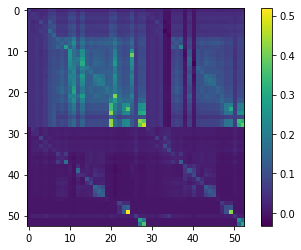

In [10]:
color_map = plt.imshow(MLP.model[0].layers.weight.detach().numpy())
#color_map.set_cmap("Blues")
plt.colorbar()
plt.show()

In [11]:
y_TrainHat = MLP.model[0].layers(xTrain.float())
rmse_train = torch.sqrt(torch.mean((y_TrainHat - yTrain.float())**2,axis = 0))
rmse_ang_train = torch.mean(rmse_train[0:29])
rmse_mag_train = torch.mean(rmse_train[29:53])
print(rmse_ang_train)
print(rmse_mag_train)
y_Hat = MLP.model[0].layers(torch.from_numpy(PQ_injection).float())
print(y_Hat.shape)

tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
torch.Size([20000, 53])


In [19]:
np.save(saveFile+'rmse_LR_train',rmse_train.detach().numpy() )
np.save(saveFile+'y_TrainHat_LR',y_TrainHat.detach().numpy())
np.save(saveFile+'yHat_LR',y_Hat.detach().numpy())

In [12]:
y_TestHat = MLP.model[0].layers(xTest.float())
rmse_test = torch.sqrt(torch.mean((y_TestHat - yTest.float())**2,axis = 0))
rmse_ang_test = torch.mean(rmse_test[0:29])
rmse_mag_test = torch.mean(rmse_test[29:53])
print(rmse_ang_test)
print(rmse_mag_test)

tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)


In [21]:
np.save(saveFile+'rmse_LR_test',rmse_test.detach().numpy())
np.save(saveFile+'y_TestHat_LR',y_TestHat.detach().numpy())

In [13]:
# Initialize generator and discriminator
time = []
loss_train = []  
loss_valid = [] 
batch_loss_train = [] 
avg_train_losses = []
L2_loss = nn.MSELoss()
if cuda:
    MLP.cuda()
    L2_loss.cuda()
# Configure data loader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=opt.batch_size,
    shuffle=True,
)

# Optimizers
optimizer = torch.optim.Adam(MLP.parameters(), lr=opt.lr)
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
# Create batch of latent vectors that we will use to check the progression of the generator
# ----------
#  Training
# ----------

batches_done = 0

for epoch in range(opt.n_epochs):

    for i, (xTrain, yTrain) in enumerate(dataloader):
        # Configure input
            # -----------------
            #  Train Generator
            # -----------------
            startTime = datetime.datetime.now()
            optimizer.zero_grad()
            # Generate a batch of images
            yHatTrain = MLP(xTrain.float())
            # Adversarial loss
            loss = L2_loss(yHatTrain,yTrain.float())
            loss.backward()
            optimizer.step()
            endTime = datetime.datetime.now()
            timeElapsed = abs(endTime - startTime).total_seconds()
            time.append(timeElapsed)
            batch_loss_train.append(loss.item())  
            print(
                "[Epoch %d/%d] [Batch %d/%d][G loss: %.9f]"
                % (epoch, opt.n_epochs, batches_done % len(dataloader), len(dataloader), loss.item())
            )       
            if (batches_done % (len(yValid)//opt.batch_size) == 0):
                with torch.no_grad(): 
                    yHatValid = MLP(xValid.float()) 
                    # Compute loss
                    lossValueValid = L2_loss(yHatValid, yValid)
                    loss_valid.append(lossValueValid.item())
                if epoch >= 799:
                    if (epoch == 799):
                        bestScore = lossValueValid
                        torch.save(MLP.state_dict(), saveFile +'Best'+'.ckpt')
                        torch.save(optimizer.state_dict(), saveFile+'Optim'+'Best'+'.ckpt')
                    else:
                        thisValidScore = lossValueValid
                        if thisValidScore < bestScore:
                            bestScore = thisValidScore
                            torch.save(MLP.state_dict(), saveFile + 'Best'+'.ckpt')
                            torch.save(optimizer.state_dict(), saveFile+'Optim'+'Best'+'.ckpt')                  
            batches_done += 1
    train_loss = np.average(batch_loss_train)
    avg_train_losses.append(train_loss)
    batch_loss_train = []

[Epoch 0/400] [Batch 0/375][G loss: 0.004572660]
[Epoch 0/400] [Batch 1/375][G loss: 0.004573522]
[Epoch 0/400] [Batch 2/375][G loss: 0.004556488]
[Epoch 0/400] [Batch 3/375][G loss: 0.004519980]
[Epoch 0/400] [Batch 4/375][G loss: 0.004508195]
[Epoch 0/400] [Batch 5/375][G loss: 0.004497434]
[Epoch 0/400] [Batch 6/375][G loss: 0.004485247]
[Epoch 0/400] [Batch 7/375][G loss: 0.004476564]
[Epoch 0/400] [Batch 8/375][G loss: 0.004418967]
[Epoch 0/400] [Batch 9/375][G loss: 0.004418110]
[Epoch 0/400] [Batch 10/375][G loss: 0.004447262]
[Epoch 0/400] [Batch 11/375][G loss: 0.004402064]
[Epoch 0/400] [Batch 12/375][G loss: 0.004371381]
[Epoch 0/400] [Batch 13/375][G loss: 0.004360850]
[Epoch 0/400] [Batch 14/375][G loss: 0.004362372]
[Epoch 0/400] [Batch 15/375][G loss: 0.004312612]
[Epoch 0/400] [Batch 16/375][G loss: 0.004316730]
[Epoch 0/400] [Batch 17/375][G loss: 0.004323919]
[Epoch 0/400] [Batch 18/375][G loss: 0.004281321]
[Epoch 0/400] [Batch 19/375][G loss: 0.004251719]
[Epoch 0/4

[Epoch 0/400] [Batch 300/375][G loss: 0.001533187]
[Epoch 0/400] [Batch 301/375][G loss: 0.001530039]
[Epoch 0/400] [Batch 302/375][G loss: 0.001522490]
[Epoch 0/400] [Batch 303/375][G loss: 0.001525649]
[Epoch 0/400] [Batch 304/375][G loss: 0.001511968]
[Epoch 0/400] [Batch 305/375][G loss: 0.001514890]
[Epoch 0/400] [Batch 306/375][G loss: 0.001501995]
[Epoch 0/400] [Batch 307/375][G loss: 0.001508560]
[Epoch 0/400] [Batch 308/375][G loss: 0.001495119]
[Epoch 0/400] [Batch 309/375][G loss: 0.001479131]
[Epoch 0/400] [Batch 310/375][G loss: 0.001480680]
[Epoch 0/400] [Batch 311/375][G loss: 0.001464243]
[Epoch 0/400] [Batch 312/375][G loss: 0.001464421]
[Epoch 0/400] [Batch 313/375][G loss: 0.001451016]
[Epoch 0/400] [Batch 314/375][G loss: 0.001449796]
[Epoch 0/400] [Batch 315/375][G loss: 0.001454734]
[Epoch 0/400] [Batch 316/375][G loss: 0.001447603]
[Epoch 0/400] [Batch 317/375][G loss: 0.001430736]
[Epoch 0/400] [Batch 318/375][G loss: 0.001427155]
[Epoch 0/400] [Batch 319/375][G

[Epoch 1/400] [Batch 237/375][G loss: 0.000378781]
[Epoch 1/400] [Batch 238/375][G loss: 0.000364649]
[Epoch 1/400] [Batch 239/375][G loss: 0.000362605]
[Epoch 1/400] [Batch 240/375][G loss: 0.000349454]
[Epoch 1/400] [Batch 241/375][G loss: 0.000377073]
[Epoch 1/400] [Batch 242/375][G loss: 0.000352303]
[Epoch 1/400] [Batch 243/375][G loss: 0.000359311]
[Epoch 1/400] [Batch 244/375][G loss: 0.000353534]
[Epoch 1/400] [Batch 245/375][G loss: 0.000347056]
[Epoch 1/400] [Batch 246/375][G loss: 0.000352064]
[Epoch 1/400] [Batch 247/375][G loss: 0.000339303]
[Epoch 1/400] [Batch 248/375][G loss: 0.000345540]
[Epoch 1/400] [Batch 249/375][G loss: 0.000342714]
[Epoch 1/400] [Batch 250/375][G loss: 0.000343643]
[Epoch 1/400] [Batch 251/375][G loss: 0.000348043]
[Epoch 1/400] [Batch 252/375][G loss: 0.000345332]
[Epoch 1/400] [Batch 253/375][G loss: 0.000353600]
[Epoch 1/400] [Batch 254/375][G loss: 0.000327496]
[Epoch 1/400] [Batch 255/375][G loss: 0.000329712]
[Epoch 1/400] [Batch 256/375][G

[Epoch 2/400] [Batch 165/375][G loss: 0.000062673]
[Epoch 2/400] [Batch 166/375][G loss: 0.000062861]
[Epoch 2/400] [Batch 167/375][G loss: 0.000057772]
[Epoch 2/400] [Batch 168/375][G loss: 0.000056024]
[Epoch 2/400] [Batch 169/375][G loss: 0.000070194]
[Epoch 2/400] [Batch 170/375][G loss: 0.000059857]
[Epoch 2/400] [Batch 171/375][G loss: 0.000051792]
[Epoch 2/400] [Batch 172/375][G loss: 0.000055337]
[Epoch 2/400] [Batch 173/375][G loss: 0.000060373]
[Epoch 2/400] [Batch 174/375][G loss: 0.000057764]
[Epoch 2/400] [Batch 175/375][G loss: 0.000051767]
[Epoch 2/400] [Batch 176/375][G loss: 0.000051915]
[Epoch 2/400] [Batch 177/375][G loss: 0.000056467]
[Epoch 2/400] [Batch 178/375][G loss: 0.000052827]
[Epoch 2/400] [Batch 179/375][G loss: 0.000056855]
[Epoch 2/400] [Batch 180/375][G loss: 0.000053131]
[Epoch 2/400] [Batch 181/375][G loss: 0.000053626]
[Epoch 2/400] [Batch 182/375][G loss: 0.000049352]
[Epoch 2/400] [Batch 183/375][G loss: 0.000058947]
[Epoch 2/400] [Batch 184/375][G

[Epoch 3/400] [Batch 82/375][G loss: 0.000018186]
[Epoch 3/400] [Batch 83/375][G loss: 0.000015582]
[Epoch 3/400] [Batch 84/375][G loss: 0.000018609]
[Epoch 3/400] [Batch 85/375][G loss: 0.000016142]
[Epoch 3/400] [Batch 86/375][G loss: 0.000016080]
[Epoch 3/400] [Batch 87/375][G loss: 0.000015395]
[Epoch 3/400] [Batch 88/375][G loss: 0.000017337]
[Epoch 3/400] [Batch 89/375][G loss: 0.000013960]
[Epoch 3/400] [Batch 90/375][G loss: 0.000013183]
[Epoch 3/400] [Batch 91/375][G loss: 0.000011331]
[Epoch 3/400] [Batch 92/375][G loss: 0.000014196]
[Epoch 3/400] [Batch 93/375][G loss: 0.000016601]
[Epoch 3/400] [Batch 94/375][G loss: 0.000017435]
[Epoch 3/400] [Batch 95/375][G loss: 0.000014934]
[Epoch 3/400] [Batch 96/375][G loss: 0.000014295]
[Epoch 3/400] [Batch 97/375][G loss: 0.000015612]
[Epoch 3/400] [Batch 98/375][G loss: 0.000011619]
[Epoch 3/400] [Batch 99/375][G loss: 0.000014338]
[Epoch 3/400] [Batch 100/375][G loss: 0.000014331]
[Epoch 3/400] [Batch 101/375][G loss: 0.000018650

[Epoch 4/400] [Batch 0/375][G loss: 0.000011223]
[Epoch 4/400] [Batch 1/375][G loss: 0.000012148]
[Epoch 4/400] [Batch 2/375][G loss: 0.000012753]
[Epoch 4/400] [Batch 3/375][G loss: 0.000010731]
[Epoch 4/400] [Batch 4/375][G loss: 0.000015439]
[Epoch 4/400] [Batch 5/375][G loss: 0.000010947]
[Epoch 4/400] [Batch 6/375][G loss: 0.000011427]
[Epoch 4/400] [Batch 7/375][G loss: 0.000011718]
[Epoch 4/400] [Batch 8/375][G loss: 0.000015442]
[Epoch 4/400] [Batch 9/375][G loss: 0.000010122]
[Epoch 4/400] [Batch 10/375][G loss: 0.000010747]
[Epoch 4/400] [Batch 11/375][G loss: 0.000013246]
[Epoch 4/400] [Batch 12/375][G loss: 0.000011638]
[Epoch 4/400] [Batch 13/375][G loss: 0.000011604]
[Epoch 4/400] [Batch 14/375][G loss: 0.000009038]
[Epoch 4/400] [Batch 15/375][G loss: 0.000011752]
[Epoch 4/400] [Batch 16/375][G loss: 0.000012744]
[Epoch 4/400] [Batch 17/375][G loss: 0.000011765]
[Epoch 4/400] [Batch 18/375][G loss: 0.000013378]
[Epoch 4/400] [Batch 19/375][G loss: 0.000013196]
[Epoch 4/4

[Epoch 4/400] [Batch 290/375][G loss: 0.000011216]
[Epoch 4/400] [Batch 291/375][G loss: 0.000009571]
[Epoch 4/400] [Batch 292/375][G loss: 0.000013087]
[Epoch 4/400] [Batch 293/375][G loss: 0.000009405]
[Epoch 4/400] [Batch 294/375][G loss: 0.000012078]
[Epoch 4/400] [Batch 295/375][G loss: 0.000007524]
[Epoch 4/400] [Batch 296/375][G loss: 0.000011132]
[Epoch 4/400] [Batch 297/375][G loss: 0.000008979]
[Epoch 4/400] [Batch 298/375][G loss: 0.000013639]
[Epoch 4/400] [Batch 299/375][G loss: 0.000007403]
[Epoch 4/400] [Batch 300/375][G loss: 0.000009633]
[Epoch 4/400] [Batch 301/375][G loss: 0.000010266]
[Epoch 4/400] [Batch 302/375][G loss: 0.000009284]
[Epoch 4/400] [Batch 303/375][G loss: 0.000010991]
[Epoch 4/400] [Batch 304/375][G loss: 0.000012418]
[Epoch 4/400] [Batch 305/375][G loss: 0.000009061]
[Epoch 4/400] [Batch 306/375][G loss: 0.000008965]
[Epoch 4/400] [Batch 307/375][G loss: 0.000012472]
[Epoch 4/400] [Batch 308/375][G loss: 0.000008646]
[Epoch 4/400] [Batch 309/375][G

[Epoch 5/400] [Batch 204/375][G loss: 0.000008880]
[Epoch 5/400] [Batch 205/375][G loss: 0.000010229]
[Epoch 5/400] [Batch 206/375][G loss: 0.000009330]
[Epoch 5/400] [Batch 207/375][G loss: 0.000010863]
[Epoch 5/400] [Batch 208/375][G loss: 0.000008241]
[Epoch 5/400] [Batch 209/375][G loss: 0.000008031]
[Epoch 5/400] [Batch 210/375][G loss: 0.000009716]
[Epoch 5/400] [Batch 211/375][G loss: 0.000010098]
[Epoch 5/400] [Batch 212/375][G loss: 0.000010758]
[Epoch 5/400] [Batch 213/375][G loss: 0.000008100]
[Epoch 5/400] [Batch 214/375][G loss: 0.000009770]
[Epoch 5/400] [Batch 215/375][G loss: 0.000008289]
[Epoch 5/400] [Batch 216/375][G loss: 0.000011750]
[Epoch 5/400] [Batch 217/375][G loss: 0.000006960]
[Epoch 5/400] [Batch 218/375][G loss: 0.000008319]
[Epoch 5/400] [Batch 219/375][G loss: 0.000010196]
[Epoch 5/400] [Batch 220/375][G loss: 0.000007387]
[Epoch 5/400] [Batch 221/375][G loss: 0.000008713]
[Epoch 5/400] [Batch 222/375][G loss: 0.000009810]
[Epoch 5/400] [Batch 223/375][G

[Epoch 6/400] [Batch 128/375][G loss: 0.000008551]
[Epoch 6/400] [Batch 129/375][G loss: 0.000010324]
[Epoch 6/400] [Batch 130/375][G loss: 0.000009328]
[Epoch 6/400] [Batch 131/375][G loss: 0.000008467]
[Epoch 6/400] [Batch 132/375][G loss: 0.000008955]
[Epoch 6/400] [Batch 133/375][G loss: 0.000007142]
[Epoch 6/400] [Batch 134/375][G loss: 0.000008530]
[Epoch 6/400] [Batch 135/375][G loss: 0.000009130]
[Epoch 6/400] [Batch 136/375][G loss: 0.000010570]
[Epoch 6/400] [Batch 137/375][G loss: 0.000008402]
[Epoch 6/400] [Batch 138/375][G loss: 0.000009565]
[Epoch 6/400] [Batch 139/375][G loss: 0.000007666]
[Epoch 6/400] [Batch 140/375][G loss: 0.000009208]
[Epoch 6/400] [Batch 141/375][G loss: 0.000008047]
[Epoch 6/400] [Batch 142/375][G loss: 0.000008921]
[Epoch 6/400] [Batch 143/375][G loss: 0.000008463]
[Epoch 6/400] [Batch 144/375][G loss: 0.000007236]
[Epoch 6/400] [Batch 145/375][G loss: 0.000007985]
[Epoch 6/400] [Batch 146/375][G loss: 0.000007992]
[Epoch 6/400] [Batch 147/375][G

[Epoch 7/400] [Batch 44/375][G loss: 0.000007144]
[Epoch 7/400] [Batch 45/375][G loss: 0.000006909]
[Epoch 7/400] [Batch 46/375][G loss: 0.000007802]
[Epoch 7/400] [Batch 47/375][G loss: 0.000007797]
[Epoch 7/400] [Batch 48/375][G loss: 0.000007481]
[Epoch 7/400] [Batch 49/375][G loss: 0.000006679]
[Epoch 7/400] [Batch 50/375][G loss: 0.000009559]
[Epoch 7/400] [Batch 51/375][G loss: 0.000007463]
[Epoch 7/400] [Batch 52/375][G loss: 0.000006256]
[Epoch 7/400] [Batch 53/375][G loss: 0.000009649]
[Epoch 7/400] [Batch 54/375][G loss: 0.000009610]
[Epoch 7/400] [Batch 55/375][G loss: 0.000007956]
[Epoch 7/400] [Batch 56/375][G loss: 0.000007525]
[Epoch 7/400] [Batch 57/375][G loss: 0.000009559]
[Epoch 7/400] [Batch 58/375][G loss: 0.000008181]
[Epoch 7/400] [Batch 59/375][G loss: 0.000006750]
[Epoch 7/400] [Batch 60/375][G loss: 0.000008662]
[Epoch 7/400] [Batch 61/375][G loss: 0.000008634]
[Epoch 7/400] [Batch 62/375][G loss: 0.000009289]
[Epoch 7/400] [Batch 63/375][G loss: 0.000008689]


[Epoch 7/400] [Batch 333/375][G loss: 0.000006999]
[Epoch 7/400] [Batch 334/375][G loss: 0.000007688]
[Epoch 7/400] [Batch 335/375][G loss: 0.000006412]
[Epoch 7/400] [Batch 336/375][G loss: 0.000009823]
[Epoch 7/400] [Batch 337/375][G loss: 0.000007068]
[Epoch 7/400] [Batch 338/375][G loss: 0.000008111]
[Epoch 7/400] [Batch 339/375][G loss: 0.000006788]
[Epoch 7/400] [Batch 340/375][G loss: 0.000007218]
[Epoch 7/400] [Batch 341/375][G loss: 0.000006638]
[Epoch 7/400] [Batch 342/375][G loss: 0.000006310]
[Epoch 7/400] [Batch 343/375][G loss: 0.000007525]
[Epoch 7/400] [Batch 344/375][G loss: 0.000008084]
[Epoch 7/400] [Batch 345/375][G loss: 0.000008147]
[Epoch 7/400] [Batch 346/375][G loss: 0.000007034]
[Epoch 7/400] [Batch 347/375][G loss: 0.000005920]
[Epoch 7/400] [Batch 348/375][G loss: 0.000006253]
[Epoch 7/400] [Batch 349/375][G loss: 0.000007581]
[Epoch 7/400] [Batch 350/375][G loss: 0.000009613]
[Epoch 7/400] [Batch 351/375][G loss: 0.000007002]
[Epoch 7/400] [Batch 352/375][G

[Epoch 8/400] [Batch 251/375][G loss: 0.000008253]
[Epoch 8/400] [Batch 252/375][G loss: 0.000007147]
[Epoch 8/400] [Batch 253/375][G loss: 0.000007477]
[Epoch 8/400] [Batch 254/375][G loss: 0.000007596]
[Epoch 8/400] [Batch 255/375][G loss: 0.000006624]
[Epoch 8/400] [Batch 256/375][G loss: 0.000006946]
[Epoch 8/400] [Batch 257/375][G loss: 0.000006040]
[Epoch 8/400] [Batch 258/375][G loss: 0.000007227]
[Epoch 8/400] [Batch 259/375][G loss: 0.000005152]
[Epoch 8/400] [Batch 260/375][G loss: 0.000006424]
[Epoch 8/400] [Batch 261/375][G loss: 0.000005799]
[Epoch 8/400] [Batch 262/375][G loss: 0.000005367]
[Epoch 8/400] [Batch 263/375][G loss: 0.000006474]
[Epoch 8/400] [Batch 264/375][G loss: 0.000008325]
[Epoch 8/400] [Batch 265/375][G loss: 0.000005488]
[Epoch 8/400] [Batch 266/375][G loss: 0.000006751]
[Epoch 8/400] [Batch 267/375][G loss: 0.000007399]
[Epoch 8/400] [Batch 268/375][G loss: 0.000005496]
[Epoch 8/400] [Batch 269/375][G loss: 0.000007795]
[Epoch 8/400] [Batch 270/375][G

[Epoch 9/400] [Batch 175/375][G loss: 0.000005414]
[Epoch 9/400] [Batch 176/375][G loss: 0.000006393]
[Epoch 9/400] [Batch 177/375][G loss: 0.000006733]
[Epoch 9/400] [Batch 178/375][G loss: 0.000005886]
[Epoch 9/400] [Batch 179/375][G loss: 0.000004455]
[Epoch 9/400] [Batch 180/375][G loss: 0.000005594]
[Epoch 9/400] [Batch 181/375][G loss: 0.000005541]
[Epoch 9/400] [Batch 182/375][G loss: 0.000006677]
[Epoch 9/400] [Batch 183/375][G loss: 0.000005672]
[Epoch 9/400] [Batch 184/375][G loss: 0.000006019]
[Epoch 9/400] [Batch 185/375][G loss: 0.000006273]
[Epoch 9/400] [Batch 186/375][G loss: 0.000005898]
[Epoch 9/400] [Batch 187/375][G loss: 0.000004733]
[Epoch 9/400] [Batch 188/375][G loss: 0.000005566]
[Epoch 9/400] [Batch 189/375][G loss: 0.000005344]
[Epoch 9/400] [Batch 190/375][G loss: 0.000006417]
[Epoch 9/400] [Batch 191/375][G loss: 0.000005399]
[Epoch 9/400] [Batch 192/375][G loss: 0.000005940]
[Epoch 9/400] [Batch 193/375][G loss: 0.000007286]
[Epoch 9/400] [Batch 194/375][G

[Epoch 10/400] [Batch 108/375][G loss: 0.000006777]
[Epoch 10/400] [Batch 109/375][G loss: 0.000005634]
[Epoch 10/400] [Batch 110/375][G loss: 0.000004045]
[Epoch 10/400] [Batch 111/375][G loss: 0.000005683]
[Epoch 10/400] [Batch 112/375][G loss: 0.000005928]
[Epoch 10/400] [Batch 113/375][G loss: 0.000004924]
[Epoch 10/400] [Batch 114/375][G loss: 0.000004580]
[Epoch 10/400] [Batch 115/375][G loss: 0.000004712]
[Epoch 10/400] [Batch 116/375][G loss: 0.000006177]
[Epoch 10/400] [Batch 117/375][G loss: 0.000004773]
[Epoch 10/400] [Batch 118/375][G loss: 0.000004830]
[Epoch 10/400] [Batch 119/375][G loss: 0.000006188]
[Epoch 10/400] [Batch 120/375][G loss: 0.000004434]
[Epoch 10/400] [Batch 121/375][G loss: 0.000005121]
[Epoch 10/400] [Batch 122/375][G loss: 0.000005751]
[Epoch 10/400] [Batch 123/375][G loss: 0.000007452]
[Epoch 10/400] [Batch 124/375][G loss: 0.000004932]
[Epoch 10/400] [Batch 125/375][G loss: 0.000005883]
[Epoch 10/400] [Batch 126/375][G loss: 0.000007049]
[Epoch 10/40

[Epoch 11/400] [Batch 10/375][G loss: 0.000004877]
[Epoch 11/400] [Batch 11/375][G loss: 0.000004791]
[Epoch 11/400] [Batch 12/375][G loss: 0.000004897]
[Epoch 11/400] [Batch 13/375][G loss: 0.000004575]
[Epoch 11/400] [Batch 14/375][G loss: 0.000004806]
[Epoch 11/400] [Batch 15/375][G loss: 0.000003585]
[Epoch 11/400] [Batch 16/375][G loss: 0.000004894]
[Epoch 11/400] [Batch 17/375][G loss: 0.000004175]
[Epoch 11/400] [Batch 18/375][G loss: 0.000005239]
[Epoch 11/400] [Batch 19/375][G loss: 0.000005057]
[Epoch 11/400] [Batch 20/375][G loss: 0.000005232]
[Epoch 11/400] [Batch 21/375][G loss: 0.000004834]
[Epoch 11/400] [Batch 22/375][G loss: 0.000005419]
[Epoch 11/400] [Batch 23/375][G loss: 0.000005048]
[Epoch 11/400] [Batch 24/375][G loss: 0.000005688]
[Epoch 11/400] [Batch 25/375][G loss: 0.000004800]
[Epoch 11/400] [Batch 26/375][G loss: 0.000005818]
[Epoch 11/400] [Batch 27/375][G loss: 0.000005147]
[Epoch 11/400] [Batch 28/375][G loss: 0.000006802]
[Epoch 11/400] [Batch 29/375][G

[Epoch 11/400] [Batch 305/375][G loss: 0.000004699]
[Epoch 11/400] [Batch 306/375][G loss: 0.000003753]
[Epoch 11/400] [Batch 307/375][G loss: 0.000006248]
[Epoch 11/400] [Batch 308/375][G loss: 0.000005397]
[Epoch 11/400] [Batch 309/375][G loss: 0.000004032]
[Epoch 11/400] [Batch 310/375][G loss: 0.000004544]
[Epoch 11/400] [Batch 311/375][G loss: 0.000003775]
[Epoch 11/400] [Batch 312/375][G loss: 0.000005777]
[Epoch 11/400] [Batch 313/375][G loss: 0.000005227]
[Epoch 11/400] [Batch 314/375][G loss: 0.000004479]
[Epoch 11/400] [Batch 315/375][G loss: 0.000004075]
[Epoch 11/400] [Batch 316/375][G loss: 0.000003231]
[Epoch 11/400] [Batch 317/375][G loss: 0.000004082]
[Epoch 11/400] [Batch 318/375][G loss: 0.000005314]
[Epoch 11/400] [Batch 319/375][G loss: 0.000004942]
[Epoch 11/400] [Batch 320/375][G loss: 0.000004740]
[Epoch 11/400] [Batch 321/375][G loss: 0.000004556]
[Epoch 11/400] [Batch 322/375][G loss: 0.000003983]
[Epoch 11/400] [Batch 323/375][G loss: 0.000005181]
[Epoch 11/40

[Epoch 12/400] [Batch 215/375][G loss: 0.000003970]
[Epoch 12/400] [Batch 216/375][G loss: 0.000005677]
[Epoch 12/400] [Batch 217/375][G loss: 0.000003973]
[Epoch 12/400] [Batch 218/375][G loss: 0.000003570]
[Epoch 12/400] [Batch 219/375][G loss: 0.000005092]
[Epoch 12/400] [Batch 220/375][G loss: 0.000004415]
[Epoch 12/400] [Batch 221/375][G loss: 0.000003880]
[Epoch 12/400] [Batch 222/375][G loss: 0.000005247]
[Epoch 12/400] [Batch 223/375][G loss: 0.000004360]
[Epoch 12/400] [Batch 224/375][G loss: 0.000003405]
[Epoch 12/400] [Batch 225/375][G loss: 0.000004067]
[Epoch 12/400] [Batch 226/375][G loss: 0.000004821]
[Epoch 12/400] [Batch 227/375][G loss: 0.000004272]
[Epoch 12/400] [Batch 228/375][G loss: 0.000004306]
[Epoch 12/400] [Batch 229/375][G loss: 0.000004192]
[Epoch 12/400] [Batch 230/375][G loss: 0.000003495]
[Epoch 12/400] [Batch 231/375][G loss: 0.000003586]
[Epoch 12/400] [Batch 232/375][G loss: 0.000004429]
[Epoch 12/400] [Batch 233/375][G loss: 0.000004839]
[Epoch 12/40

[Epoch 13/400] [Batch 142/375][G loss: 0.000003493]
[Epoch 13/400] [Batch 143/375][G loss: 0.000003704]
[Epoch 13/400] [Batch 144/375][G loss: 0.000003509]
[Epoch 13/400] [Batch 145/375][G loss: 0.000003689]
[Epoch 13/400] [Batch 146/375][G loss: 0.000003511]
[Epoch 13/400] [Batch 147/375][G loss: 0.000004042]
[Epoch 13/400] [Batch 148/375][G loss: 0.000002436]
[Epoch 13/400] [Batch 149/375][G loss: 0.000003760]
[Epoch 13/400] [Batch 150/375][G loss: 0.000003796]
[Epoch 13/400] [Batch 151/375][G loss: 0.000003256]
[Epoch 13/400] [Batch 152/375][G loss: 0.000004355]
[Epoch 13/400] [Batch 153/375][G loss: 0.000003477]
[Epoch 13/400] [Batch 154/375][G loss: 0.000003185]
[Epoch 13/400] [Batch 155/375][G loss: 0.000003319]
[Epoch 13/400] [Batch 156/375][G loss: 0.000004451]
[Epoch 13/400] [Batch 157/375][G loss: 0.000005283]
[Epoch 13/400] [Batch 158/375][G loss: 0.000004606]
[Epoch 13/400] [Batch 159/375][G loss: 0.000003231]
[Epoch 13/400] [Batch 160/375][G loss: 0.000003629]
[Epoch 13/40

[Epoch 14/400] [Batch 53/375][G loss: 0.000003143]
[Epoch 14/400] [Batch 54/375][G loss: 0.000003365]
[Epoch 14/400] [Batch 55/375][G loss: 0.000002661]
[Epoch 14/400] [Batch 56/375][G loss: 0.000002841]
[Epoch 14/400] [Batch 57/375][G loss: 0.000003720]
[Epoch 14/400] [Batch 58/375][G loss: 0.000002691]
[Epoch 14/400] [Batch 59/375][G loss: 0.000003376]
[Epoch 14/400] [Batch 60/375][G loss: 0.000002970]
[Epoch 14/400] [Batch 61/375][G loss: 0.000002561]
[Epoch 14/400] [Batch 62/375][G loss: 0.000003215]
[Epoch 14/400] [Batch 63/375][G loss: 0.000003155]
[Epoch 14/400] [Batch 64/375][G loss: 0.000002752]
[Epoch 14/400] [Batch 65/375][G loss: 0.000002731]
[Epoch 14/400] [Batch 66/375][G loss: 0.000003873]
[Epoch 14/400] [Batch 67/375][G loss: 0.000003529]
[Epoch 14/400] [Batch 68/375][G loss: 0.000003486]
[Epoch 14/400] [Batch 69/375][G loss: 0.000002836]
[Epoch 14/400] [Batch 70/375][G loss: 0.000003251]
[Epoch 14/400] [Batch 71/375][G loss: 0.000003900]
[Epoch 14/400] [Batch 72/375][G

[Epoch 14/400] [Batch 344/375][G loss: 0.000003322]
[Epoch 14/400] [Batch 345/375][G loss: 0.000003128]
[Epoch 14/400] [Batch 346/375][G loss: 0.000002345]
[Epoch 14/400] [Batch 347/375][G loss: 0.000002539]
[Epoch 14/400] [Batch 348/375][G loss: 0.000003432]
[Epoch 14/400] [Batch 349/375][G loss: 0.000003059]
[Epoch 14/400] [Batch 350/375][G loss: 0.000002836]
[Epoch 14/400] [Batch 351/375][G loss: 0.000002393]
[Epoch 14/400] [Batch 352/375][G loss: 0.000002477]
[Epoch 14/400] [Batch 353/375][G loss: 0.000002671]
[Epoch 14/400] [Batch 354/375][G loss: 0.000003147]
[Epoch 14/400] [Batch 355/375][G loss: 0.000003335]
[Epoch 14/400] [Batch 356/375][G loss: 0.000002591]
[Epoch 14/400] [Batch 357/375][G loss: 0.000002768]
[Epoch 14/400] [Batch 358/375][G loss: 0.000002703]
[Epoch 14/400] [Batch 359/375][G loss: 0.000003197]
[Epoch 14/400] [Batch 360/375][G loss: 0.000002965]
[Epoch 14/400] [Batch 361/375][G loss: 0.000002935]
[Epoch 14/400] [Batch 362/375][G loss: 0.000002218]
[Epoch 14/40

[Epoch 15/400] [Batch 264/375][G loss: 0.000002452]
[Epoch 15/400] [Batch 265/375][G loss: 0.000002409]
[Epoch 15/400] [Batch 266/375][G loss: 0.000002087]
[Epoch 15/400] [Batch 267/375][G loss: 0.000003118]
[Epoch 15/400] [Batch 268/375][G loss: 0.000002341]
[Epoch 15/400] [Batch 269/375][G loss: 0.000002209]
[Epoch 15/400] [Batch 270/375][G loss: 0.000002752]
[Epoch 15/400] [Batch 271/375][G loss: 0.000002730]
[Epoch 15/400] [Batch 272/375][G loss: 0.000003043]
[Epoch 15/400] [Batch 273/375][G loss: 0.000003245]
[Epoch 15/400] [Batch 274/375][G loss: 0.000002144]
[Epoch 15/400] [Batch 275/375][G loss: 0.000002825]
[Epoch 15/400] [Batch 276/375][G loss: 0.000002999]
[Epoch 15/400] [Batch 277/375][G loss: 0.000002781]
[Epoch 15/400] [Batch 278/375][G loss: 0.000002558]
[Epoch 15/400] [Batch 279/375][G loss: 0.000002278]
[Epoch 15/400] [Batch 280/375][G loss: 0.000002990]
[Epoch 15/400] [Batch 281/375][G loss: 0.000002813]
[Epoch 15/400] [Batch 282/375][G loss: 0.000002681]
[Epoch 15/40

[Epoch 16/400] [Batch 158/375][G loss: 0.000001914]
[Epoch 16/400] [Batch 159/375][G loss: 0.000002481]
[Epoch 16/400] [Batch 160/375][G loss: 0.000002142]
[Epoch 16/400] [Batch 161/375][G loss: 0.000002123]
[Epoch 16/400] [Batch 162/375][G loss: 0.000002487]
[Epoch 16/400] [Batch 163/375][G loss: 0.000002568]
[Epoch 16/400] [Batch 164/375][G loss: 0.000002159]
[Epoch 16/400] [Batch 165/375][G loss: 0.000002791]
[Epoch 16/400] [Batch 166/375][G loss: 0.000002253]
[Epoch 16/400] [Batch 167/375][G loss: 0.000002589]
[Epoch 16/400] [Batch 168/375][G loss: 0.000002014]
[Epoch 16/400] [Batch 169/375][G loss: 0.000002056]
[Epoch 16/400] [Batch 170/375][G loss: 0.000001917]
[Epoch 16/400] [Batch 171/375][G loss: 0.000002385]
[Epoch 16/400] [Batch 172/375][G loss: 0.000002215]
[Epoch 16/400] [Batch 173/375][G loss: 0.000002407]
[Epoch 16/400] [Batch 174/375][G loss: 0.000002388]
[Epoch 16/400] [Batch 175/375][G loss: 0.000002387]
[Epoch 16/400] [Batch 176/375][G loss: 0.000002742]
[Epoch 16/40

[Epoch 17/400] [Batch 68/375][G loss: 0.000002377]
[Epoch 17/400] [Batch 69/375][G loss: 0.000002413]
[Epoch 17/400] [Batch 70/375][G loss: 0.000002268]
[Epoch 17/400] [Batch 71/375][G loss: 0.000001804]
[Epoch 17/400] [Batch 72/375][G loss: 0.000002344]
[Epoch 17/400] [Batch 73/375][G loss: 0.000001984]
[Epoch 17/400] [Batch 74/375][G loss: 0.000001740]
[Epoch 17/400] [Batch 75/375][G loss: 0.000002372]
[Epoch 17/400] [Batch 76/375][G loss: 0.000002386]
[Epoch 17/400] [Batch 77/375][G loss: 0.000002520]
[Epoch 17/400] [Batch 78/375][G loss: 0.000002147]
[Epoch 17/400] [Batch 79/375][G loss: 0.000002157]
[Epoch 17/400] [Batch 80/375][G loss: 0.000002074]
[Epoch 17/400] [Batch 81/375][G loss: 0.000002017]
[Epoch 17/400] [Batch 82/375][G loss: 0.000002008]
[Epoch 17/400] [Batch 83/375][G loss: 0.000002349]
[Epoch 17/400] [Batch 84/375][G loss: 0.000001868]
[Epoch 17/400] [Batch 85/375][G loss: 0.000002126]
[Epoch 17/400] [Batch 86/375][G loss: 0.000002283]
[Epoch 17/400] [Batch 87/375][G

[Epoch 17/400] [Batch 362/375][G loss: 0.000002072]
[Epoch 17/400] [Batch 363/375][G loss: 0.000001875]
[Epoch 17/400] [Batch 364/375][G loss: 0.000001778]
[Epoch 17/400] [Batch 365/375][G loss: 0.000002014]
[Epoch 17/400] [Batch 366/375][G loss: 0.000002083]
[Epoch 17/400] [Batch 367/375][G loss: 0.000002026]
[Epoch 17/400] [Batch 368/375][G loss: 0.000001783]
[Epoch 17/400] [Batch 369/375][G loss: 0.000001962]
[Epoch 17/400] [Batch 370/375][G loss: 0.000002101]
[Epoch 17/400] [Batch 371/375][G loss: 0.000001491]
[Epoch 17/400] [Batch 372/375][G loss: 0.000001971]
[Epoch 17/400] [Batch 373/375][G loss: 0.000002197]
[Epoch 17/400] [Batch 374/375][G loss: 0.000002121]
[Epoch 18/400] [Batch 0/375][G loss: 0.000001570]
[Epoch 18/400] [Batch 1/375][G loss: 0.000001663]
[Epoch 18/400] [Batch 2/375][G loss: 0.000002011]
[Epoch 18/400] [Batch 3/375][G loss: 0.000001997]
[Epoch 18/400] [Batch 4/375][G loss: 0.000002120]
[Epoch 18/400] [Batch 5/375][G loss: 0.000001611]
[Epoch 18/400] [Batch 6/

[Epoch 18/400] [Batch 266/375][G loss: 0.000001948]
[Epoch 18/400] [Batch 267/375][G loss: 0.000001710]
[Epoch 18/400] [Batch 268/375][G loss: 0.000001532]
[Epoch 18/400] [Batch 269/375][G loss: 0.000001713]
[Epoch 18/400] [Batch 270/375][G loss: 0.000001557]
[Epoch 18/400] [Batch 271/375][G loss: 0.000001683]
[Epoch 18/400] [Batch 272/375][G loss: 0.000001850]
[Epoch 18/400] [Batch 273/375][G loss: 0.000001529]
[Epoch 18/400] [Batch 274/375][G loss: 0.000001627]
[Epoch 18/400] [Batch 275/375][G loss: 0.000001233]
[Epoch 18/400] [Batch 276/375][G loss: 0.000001694]
[Epoch 18/400] [Batch 277/375][G loss: 0.000001741]
[Epoch 18/400] [Batch 278/375][G loss: 0.000001732]
[Epoch 18/400] [Batch 279/375][G loss: 0.000001484]
[Epoch 18/400] [Batch 280/375][G loss: 0.000001629]
[Epoch 18/400] [Batch 281/375][G loss: 0.000001317]
[Epoch 18/400] [Batch 282/375][G loss: 0.000001571]
[Epoch 18/400] [Batch 283/375][G loss: 0.000001478]
[Epoch 18/400] [Batch 284/375][G loss: 0.000002141]
[Epoch 18/40

[Epoch 19/400] [Batch 177/375][G loss: 0.000001374]
[Epoch 19/400] [Batch 178/375][G loss: 0.000001561]
[Epoch 19/400] [Batch 179/375][G loss: 0.000001508]
[Epoch 19/400] [Batch 180/375][G loss: 0.000001414]
[Epoch 19/400] [Batch 181/375][G loss: 0.000001641]
[Epoch 19/400] [Batch 182/375][G loss: 0.000001591]
[Epoch 19/400] [Batch 183/375][G loss: 0.000001059]
[Epoch 19/400] [Batch 184/375][G loss: 0.000001554]
[Epoch 19/400] [Batch 185/375][G loss: 0.000001476]
[Epoch 19/400] [Batch 186/375][G loss: 0.000001427]
[Epoch 19/400] [Batch 187/375][G loss: 0.000001619]
[Epoch 19/400] [Batch 188/375][G loss: 0.000001459]
[Epoch 19/400] [Batch 189/375][G loss: 0.000001663]
[Epoch 19/400] [Batch 190/375][G loss: 0.000001295]
[Epoch 19/400] [Batch 191/375][G loss: 0.000001545]
[Epoch 19/400] [Batch 192/375][G loss: 0.000001882]
[Epoch 19/400] [Batch 193/375][G loss: 0.000001285]
[Epoch 19/400] [Batch 194/375][G loss: 0.000001564]
[Epoch 19/400] [Batch 195/375][G loss: 0.000001556]
[Epoch 19/40

[Epoch 20/400] [Batch 94/375][G loss: 0.000001432]
[Epoch 20/400] [Batch 95/375][G loss: 0.000001400]
[Epoch 20/400] [Batch 96/375][G loss: 0.000001435]
[Epoch 20/400] [Batch 97/375][G loss: 0.000001529]
[Epoch 20/400] [Batch 98/375][G loss: 0.000001214]
[Epoch 20/400] [Batch 99/375][G loss: 0.000001156]
[Epoch 20/400] [Batch 100/375][G loss: 0.000001340]
[Epoch 20/400] [Batch 101/375][G loss: 0.000001137]
[Epoch 20/400] [Batch 102/375][G loss: 0.000001297]
[Epoch 20/400] [Batch 103/375][G loss: 0.000001079]
[Epoch 20/400] [Batch 104/375][G loss: 0.000001552]
[Epoch 20/400] [Batch 105/375][G loss: 0.000001346]
[Epoch 20/400] [Batch 106/375][G loss: 0.000001500]
[Epoch 20/400] [Batch 107/375][G loss: 0.000001285]
[Epoch 20/400] [Batch 108/375][G loss: 0.000001142]
[Epoch 20/400] [Batch 109/375][G loss: 0.000001588]
[Epoch 20/400] [Batch 110/375][G loss: 0.000001309]
[Epoch 20/400] [Batch 111/375][G loss: 0.000001497]
[Epoch 20/400] [Batch 112/375][G loss: 0.000001207]
[Epoch 20/400] [Ba

[Epoch 21/400] [Batch 6/375][G loss: 0.000001112]
[Epoch 21/400] [Batch 7/375][G loss: 0.000000853]
[Epoch 21/400] [Batch 8/375][G loss: 0.000001055]
[Epoch 21/400] [Batch 9/375][G loss: 0.000001359]
[Epoch 21/400] [Batch 10/375][G loss: 0.000001096]
[Epoch 21/400] [Batch 11/375][G loss: 0.000001037]
[Epoch 21/400] [Batch 12/375][G loss: 0.000001132]
[Epoch 21/400] [Batch 13/375][G loss: 0.000001335]
[Epoch 21/400] [Batch 14/375][G loss: 0.000001042]
[Epoch 21/400] [Batch 15/375][G loss: 0.000001029]
[Epoch 21/400] [Batch 16/375][G loss: 0.000001183]
[Epoch 21/400] [Batch 17/375][G loss: 0.000001081]
[Epoch 21/400] [Batch 18/375][G loss: 0.000001184]
[Epoch 21/400] [Batch 19/375][G loss: 0.000001221]
[Epoch 21/400] [Batch 20/375][G loss: 0.000001322]
[Epoch 21/400] [Batch 21/375][G loss: 0.000001320]
[Epoch 21/400] [Batch 22/375][G loss: 0.000001003]
[Epoch 21/400] [Batch 23/375][G loss: 0.000000960]
[Epoch 21/400] [Batch 24/375][G loss: 0.000001140]
[Epoch 21/400] [Batch 25/375][G los

[Epoch 21/400] [Batch 297/375][G loss: 0.000001003]
[Epoch 21/400] [Batch 298/375][G loss: 0.000000743]
[Epoch 21/400] [Batch 299/375][G loss: 0.000000986]
[Epoch 21/400] [Batch 300/375][G loss: 0.000001079]
[Epoch 21/400] [Batch 301/375][G loss: 0.000001271]
[Epoch 21/400] [Batch 302/375][G loss: 0.000000980]
[Epoch 21/400] [Batch 303/375][G loss: 0.000000962]
[Epoch 21/400] [Batch 304/375][G loss: 0.000000900]
[Epoch 21/400] [Batch 305/375][G loss: 0.000001016]
[Epoch 21/400] [Batch 306/375][G loss: 0.000001045]
[Epoch 21/400] [Batch 307/375][G loss: 0.000001015]
[Epoch 21/400] [Batch 308/375][G loss: 0.000000930]
[Epoch 21/400] [Batch 309/375][G loss: 0.000001036]
[Epoch 21/400] [Batch 310/375][G loss: 0.000001038]
[Epoch 21/400] [Batch 311/375][G loss: 0.000000948]
[Epoch 21/400] [Batch 312/375][G loss: 0.000001264]
[Epoch 21/400] [Batch 313/375][G loss: 0.000000933]
[Epoch 21/400] [Batch 314/375][G loss: 0.000001141]
[Epoch 21/400] [Batch 315/375][G loss: 0.000001011]
[Epoch 21/40

[Epoch 22/400] [Batch 172/375][G loss: 0.000000998]
[Epoch 22/400] [Batch 173/375][G loss: 0.000000766]
[Epoch 22/400] [Batch 174/375][G loss: 0.000001020]
[Epoch 22/400] [Batch 175/375][G loss: 0.000000833]
[Epoch 22/400] [Batch 176/375][G loss: 0.000000827]
[Epoch 22/400] [Batch 177/375][G loss: 0.000000907]
[Epoch 22/400] [Batch 178/375][G loss: 0.000001147]
[Epoch 22/400] [Batch 179/375][G loss: 0.000001223]
[Epoch 22/400] [Batch 180/375][G loss: 0.000001326]
[Epoch 22/400] [Batch 181/375][G loss: 0.000000953]
[Epoch 22/400] [Batch 182/375][G loss: 0.000001132]
[Epoch 22/400] [Batch 183/375][G loss: 0.000000821]
[Epoch 22/400] [Batch 184/375][G loss: 0.000001019]
[Epoch 22/400] [Batch 185/375][G loss: 0.000000839]
[Epoch 22/400] [Batch 186/375][G loss: 0.000000962]
[Epoch 22/400] [Batch 187/375][G loss: 0.000000898]
[Epoch 22/400] [Batch 188/375][G loss: 0.000000766]
[Epoch 22/400] [Batch 189/375][G loss: 0.000001021]
[Epoch 22/400] [Batch 190/375][G loss: 0.000000979]
[Epoch 22/40

[Epoch 23/400] [Batch 55/375][G loss: 0.000000875]
[Epoch 23/400] [Batch 56/375][G loss: 0.000000919]
[Epoch 23/400] [Batch 57/375][G loss: 0.000000797]
[Epoch 23/400] [Batch 58/375][G loss: 0.000000834]
[Epoch 23/400] [Batch 59/375][G loss: 0.000000831]
[Epoch 23/400] [Batch 60/375][G loss: 0.000000864]
[Epoch 23/400] [Batch 61/375][G loss: 0.000000958]
[Epoch 23/400] [Batch 62/375][G loss: 0.000000859]
[Epoch 23/400] [Batch 63/375][G loss: 0.000000871]
[Epoch 23/400] [Batch 64/375][G loss: 0.000000847]
[Epoch 23/400] [Batch 65/375][G loss: 0.000001019]
[Epoch 23/400] [Batch 66/375][G loss: 0.000000883]
[Epoch 23/400] [Batch 67/375][G loss: 0.000000830]
[Epoch 23/400] [Batch 68/375][G loss: 0.000000912]
[Epoch 23/400] [Batch 69/375][G loss: 0.000000872]
[Epoch 23/400] [Batch 70/375][G loss: 0.000000894]
[Epoch 23/400] [Batch 71/375][G loss: 0.000000907]
[Epoch 23/400] [Batch 72/375][G loss: 0.000000843]
[Epoch 23/400] [Batch 73/375][G loss: 0.000000731]
[Epoch 23/400] [Batch 74/375][G

[Epoch 23/400] [Batch 344/375][G loss: 0.000000816]
[Epoch 23/400] [Batch 345/375][G loss: 0.000000942]
[Epoch 23/400] [Batch 346/375][G loss: 0.000000768]
[Epoch 23/400] [Batch 347/375][G loss: 0.000000787]
[Epoch 23/400] [Batch 348/375][G loss: 0.000000717]
[Epoch 23/400] [Batch 349/375][G loss: 0.000000722]
[Epoch 23/400] [Batch 350/375][G loss: 0.000000954]
[Epoch 23/400] [Batch 351/375][G loss: 0.000000846]
[Epoch 23/400] [Batch 352/375][G loss: 0.000000861]
[Epoch 23/400] [Batch 353/375][G loss: 0.000000804]
[Epoch 23/400] [Batch 354/375][G loss: 0.000000907]
[Epoch 23/400] [Batch 355/375][G loss: 0.000000627]
[Epoch 23/400] [Batch 356/375][G loss: 0.000000868]
[Epoch 23/400] [Batch 357/375][G loss: 0.000000869]
[Epoch 23/400] [Batch 358/375][G loss: 0.000000782]
[Epoch 23/400] [Batch 359/375][G loss: 0.000000772]
[Epoch 23/400] [Batch 360/375][G loss: 0.000000858]
[Epoch 23/400] [Batch 361/375][G loss: 0.000000813]
[Epoch 23/400] [Batch 362/375][G loss: 0.000000891]
[Epoch 23/40

[Epoch 24/400] [Batch 264/375][G loss: 0.000000596]
[Epoch 24/400] [Batch 265/375][G loss: 0.000000813]
[Epoch 24/400] [Batch 266/375][G loss: 0.000000814]
[Epoch 24/400] [Batch 267/375][G loss: 0.000000728]
[Epoch 24/400] [Batch 268/375][G loss: 0.000000680]
[Epoch 24/400] [Batch 269/375][G loss: 0.000000960]
[Epoch 24/400] [Batch 270/375][G loss: 0.000000821]
[Epoch 24/400] [Batch 271/375][G loss: 0.000000647]
[Epoch 24/400] [Batch 272/375][G loss: 0.000000666]
[Epoch 24/400] [Batch 273/375][G loss: 0.000000624]
[Epoch 24/400] [Batch 274/375][G loss: 0.000000728]
[Epoch 24/400] [Batch 275/375][G loss: 0.000000896]
[Epoch 24/400] [Batch 276/375][G loss: 0.000000945]
[Epoch 24/400] [Batch 277/375][G loss: 0.000000826]
[Epoch 24/400] [Batch 278/375][G loss: 0.000000629]
[Epoch 24/400] [Batch 279/375][G loss: 0.000000650]
[Epoch 24/400] [Batch 280/375][G loss: 0.000000706]
[Epoch 24/400] [Batch 281/375][G loss: 0.000000739]
[Epoch 24/400] [Batch 282/375][G loss: 0.000000696]
[Epoch 24/40

[Epoch 25/400] [Batch 174/375][G loss: 0.000000680]
[Epoch 25/400] [Batch 175/375][G loss: 0.000000474]
[Epoch 25/400] [Batch 176/375][G loss: 0.000000577]
[Epoch 25/400] [Batch 177/375][G loss: 0.000000664]
[Epoch 25/400] [Batch 178/375][G loss: 0.000000638]
[Epoch 25/400] [Batch 179/375][G loss: 0.000000742]
[Epoch 25/400] [Batch 180/375][G loss: 0.000000727]
[Epoch 25/400] [Batch 181/375][G loss: 0.000000655]
[Epoch 25/400] [Batch 182/375][G loss: 0.000000520]
[Epoch 25/400] [Batch 183/375][G loss: 0.000000557]
[Epoch 25/400] [Batch 184/375][G loss: 0.000000833]
[Epoch 25/400] [Batch 185/375][G loss: 0.000000860]
[Epoch 25/400] [Batch 186/375][G loss: 0.000000769]
[Epoch 25/400] [Batch 187/375][G loss: 0.000000612]
[Epoch 25/400] [Batch 188/375][G loss: 0.000000679]
[Epoch 25/400] [Batch 189/375][G loss: 0.000000620]
[Epoch 25/400] [Batch 190/375][G loss: 0.000000496]
[Epoch 25/400] [Batch 191/375][G loss: 0.000000645]
[Epoch 25/400] [Batch 192/375][G loss: 0.000000854]
[Epoch 25/40

[Epoch 26/400] [Batch 80/375][G loss: 0.000000566]
[Epoch 26/400] [Batch 81/375][G loss: 0.000000649]
[Epoch 26/400] [Batch 82/375][G loss: 0.000000580]
[Epoch 26/400] [Batch 83/375][G loss: 0.000000703]
[Epoch 26/400] [Batch 84/375][G loss: 0.000000537]
[Epoch 26/400] [Batch 85/375][G loss: 0.000000647]
[Epoch 26/400] [Batch 86/375][G loss: 0.000000677]
[Epoch 26/400] [Batch 87/375][G loss: 0.000000543]
[Epoch 26/400] [Batch 88/375][G loss: 0.000000629]
[Epoch 26/400] [Batch 89/375][G loss: 0.000000550]
[Epoch 26/400] [Batch 90/375][G loss: 0.000000624]
[Epoch 26/400] [Batch 91/375][G loss: 0.000000773]
[Epoch 26/400] [Batch 92/375][G loss: 0.000000691]
[Epoch 26/400] [Batch 93/375][G loss: 0.000000544]
[Epoch 26/400] [Batch 94/375][G loss: 0.000000697]
[Epoch 26/400] [Batch 95/375][G loss: 0.000000592]
[Epoch 26/400] [Batch 96/375][G loss: 0.000000583]
[Epoch 26/400] [Batch 97/375][G loss: 0.000000576]
[Epoch 26/400] [Batch 98/375][G loss: 0.000000610]
[Epoch 26/400] [Batch 99/375][G

[Epoch 26/400] [Batch 365/375][G loss: 0.000000465]
[Epoch 26/400] [Batch 366/375][G loss: 0.000000401]
[Epoch 26/400] [Batch 367/375][G loss: 0.000000465]
[Epoch 26/400] [Batch 368/375][G loss: 0.000000499]
[Epoch 26/400] [Batch 369/375][G loss: 0.000000404]
[Epoch 26/400] [Batch 370/375][G loss: 0.000000483]
[Epoch 26/400] [Batch 371/375][G loss: 0.000000465]
[Epoch 26/400] [Batch 372/375][G loss: 0.000000547]
[Epoch 26/400] [Batch 373/375][G loss: 0.000000453]
[Epoch 26/400] [Batch 374/375][G loss: 0.000000489]
[Epoch 27/400] [Batch 0/375][G loss: 0.000000499]
[Epoch 27/400] [Batch 1/375][G loss: 0.000000372]
[Epoch 27/400] [Batch 2/375][G loss: 0.000000518]
[Epoch 27/400] [Batch 3/375][G loss: 0.000000556]
[Epoch 27/400] [Batch 4/375][G loss: 0.000000689]
[Epoch 27/400] [Batch 5/375][G loss: 0.000000579]
[Epoch 27/400] [Batch 6/375][G loss: 0.000000427]
[Epoch 27/400] [Batch 7/375][G loss: 0.000000650]
[Epoch 27/400] [Batch 8/375][G loss: 0.000000540]
[Epoch 27/400] [Batch 9/375][G

[Epoch 27/400] [Batch 278/375][G loss: 0.000000531]
[Epoch 27/400] [Batch 279/375][G loss: 0.000000436]
[Epoch 27/400] [Batch 280/375][G loss: 0.000000517]
[Epoch 27/400] [Batch 281/375][G loss: 0.000000496]
[Epoch 27/400] [Batch 282/375][G loss: 0.000000478]
[Epoch 27/400] [Batch 283/375][G loss: 0.000000361]
[Epoch 27/400] [Batch 284/375][G loss: 0.000000465]
[Epoch 27/400] [Batch 285/375][G loss: 0.000000479]
[Epoch 27/400] [Batch 286/375][G loss: 0.000000427]
[Epoch 27/400] [Batch 287/375][G loss: 0.000000576]
[Epoch 27/400] [Batch 288/375][G loss: 0.000000446]
[Epoch 27/400] [Batch 289/375][G loss: 0.000000530]
[Epoch 27/400] [Batch 290/375][G loss: 0.000000568]
[Epoch 27/400] [Batch 291/375][G loss: 0.000000454]
[Epoch 27/400] [Batch 292/375][G loss: 0.000000397]
[Epoch 27/400] [Batch 293/375][G loss: 0.000000392]
[Epoch 27/400] [Batch 294/375][G loss: 0.000000545]
[Epoch 27/400] [Batch 295/375][G loss: 0.000000562]
[Epoch 27/400] [Batch 296/375][G loss: 0.000000599]
[Epoch 27/40

[Epoch 28/400] [Batch 197/375][G loss: 0.000000515]
[Epoch 28/400] [Batch 198/375][G loss: 0.000000360]
[Epoch 28/400] [Batch 199/375][G loss: 0.000000445]
[Epoch 28/400] [Batch 200/375][G loss: 0.000000499]
[Epoch 28/400] [Batch 201/375][G loss: 0.000000450]
[Epoch 28/400] [Batch 202/375][G loss: 0.000000564]
[Epoch 28/400] [Batch 203/375][G loss: 0.000000447]
[Epoch 28/400] [Batch 204/375][G loss: 0.000000509]
[Epoch 28/400] [Batch 205/375][G loss: 0.000000486]
[Epoch 28/400] [Batch 206/375][G loss: 0.000000540]
[Epoch 28/400] [Batch 207/375][G loss: 0.000000477]
[Epoch 28/400] [Batch 208/375][G loss: 0.000000406]
[Epoch 28/400] [Batch 209/375][G loss: 0.000000493]
[Epoch 28/400] [Batch 210/375][G loss: 0.000000483]
[Epoch 28/400] [Batch 211/375][G loss: 0.000000494]
[Epoch 28/400] [Batch 212/375][G loss: 0.000000464]
[Epoch 28/400] [Batch 213/375][G loss: 0.000000463]
[Epoch 28/400] [Batch 214/375][G loss: 0.000000346]
[Epoch 28/400] [Batch 215/375][G loss: 0.000000635]
[Epoch 28/40

[Epoch 29/400] [Batch 109/375][G loss: 0.000000401]
[Epoch 29/400] [Batch 110/375][G loss: 0.000000411]
[Epoch 29/400] [Batch 111/375][G loss: 0.000000371]
[Epoch 29/400] [Batch 112/375][G loss: 0.000000640]
[Epoch 29/400] [Batch 113/375][G loss: 0.000000432]
[Epoch 29/400] [Batch 114/375][G loss: 0.000000384]
[Epoch 29/400] [Batch 115/375][G loss: 0.000000419]
[Epoch 29/400] [Batch 116/375][G loss: 0.000000320]
[Epoch 29/400] [Batch 117/375][G loss: 0.000000391]
[Epoch 29/400] [Batch 118/375][G loss: 0.000000432]
[Epoch 29/400] [Batch 119/375][G loss: 0.000000436]
[Epoch 29/400] [Batch 120/375][G loss: 0.000000488]
[Epoch 29/400] [Batch 121/375][G loss: 0.000000364]
[Epoch 29/400] [Batch 122/375][G loss: 0.000000435]
[Epoch 29/400] [Batch 123/375][G loss: 0.000000438]
[Epoch 29/400] [Batch 124/375][G loss: 0.000000349]
[Epoch 29/400] [Batch 125/375][G loss: 0.000000329]
[Epoch 29/400] [Batch 126/375][G loss: 0.000000361]
[Epoch 29/400] [Batch 127/375][G loss: 0.000000359]
[Epoch 29/40

[Epoch 30/400] [Batch 0/375][G loss: 0.000000283]
[Epoch 30/400] [Batch 1/375][G loss: 0.000000284]
[Epoch 30/400] [Batch 2/375][G loss: 0.000000499]
[Epoch 30/400] [Batch 3/375][G loss: 0.000000445]
[Epoch 30/400] [Batch 4/375][G loss: 0.000000334]
[Epoch 30/400] [Batch 5/375][G loss: 0.000000358]
[Epoch 30/400] [Batch 6/375][G loss: 0.000000362]
[Epoch 30/400] [Batch 7/375][G loss: 0.000000373]
[Epoch 30/400] [Batch 8/375][G loss: 0.000000448]
[Epoch 30/400] [Batch 9/375][G loss: 0.000000523]
[Epoch 30/400] [Batch 10/375][G loss: 0.000000357]
[Epoch 30/400] [Batch 11/375][G loss: 0.000000391]
[Epoch 30/400] [Batch 12/375][G loss: 0.000000445]
[Epoch 30/400] [Batch 13/375][G loss: 0.000000338]
[Epoch 30/400] [Batch 14/375][G loss: 0.000000405]
[Epoch 30/400] [Batch 15/375][G loss: 0.000000418]
[Epoch 30/400] [Batch 16/375][G loss: 0.000000282]
[Epoch 30/400] [Batch 17/375][G loss: 0.000000401]
[Epoch 30/400] [Batch 18/375][G loss: 0.000000360]
[Epoch 30/400] [Batch 19/375][G loss: 0.0

[Epoch 30/400] [Batch 290/375][G loss: 0.000000322]
[Epoch 30/400] [Batch 291/375][G loss: 0.000000442]
[Epoch 30/400] [Batch 292/375][G loss: 0.000000405]
[Epoch 30/400] [Batch 293/375][G loss: 0.000000359]
[Epoch 30/400] [Batch 294/375][G loss: 0.000000638]
[Epoch 30/400] [Batch 295/375][G loss: 0.000000353]
[Epoch 30/400] [Batch 296/375][G loss: 0.000000344]
[Epoch 30/400] [Batch 297/375][G loss: 0.000000501]
[Epoch 30/400] [Batch 298/375][G loss: 0.000000338]
[Epoch 30/400] [Batch 299/375][G loss: 0.000000317]
[Epoch 30/400] [Batch 300/375][G loss: 0.000000307]
[Epoch 30/400] [Batch 301/375][G loss: 0.000000312]
[Epoch 30/400] [Batch 302/375][G loss: 0.000000376]
[Epoch 30/400] [Batch 303/375][G loss: 0.000000350]
[Epoch 30/400] [Batch 304/375][G loss: 0.000000342]
[Epoch 30/400] [Batch 305/375][G loss: 0.000000338]
[Epoch 30/400] [Batch 306/375][G loss: 0.000000388]
[Epoch 30/400] [Batch 307/375][G loss: 0.000000376]
[Epoch 30/400] [Batch 308/375][G loss: 0.000000362]
[Epoch 30/40

[Epoch 31/400] [Batch 199/375][G loss: 0.000000331]
[Epoch 31/400] [Batch 200/375][G loss: 0.000000377]
[Epoch 31/400] [Batch 201/375][G loss: 0.000000354]
[Epoch 31/400] [Batch 202/375][G loss: 0.000000284]
[Epoch 31/400] [Batch 203/375][G loss: 0.000000350]
[Epoch 31/400] [Batch 204/375][G loss: 0.000000248]
[Epoch 31/400] [Batch 205/375][G loss: 0.000000457]
[Epoch 31/400] [Batch 206/375][G loss: 0.000000268]
[Epoch 31/400] [Batch 207/375][G loss: 0.000000306]
[Epoch 31/400] [Batch 208/375][G loss: 0.000000369]
[Epoch 31/400] [Batch 209/375][G loss: 0.000000312]
[Epoch 31/400] [Batch 210/375][G loss: 0.000000325]
[Epoch 31/400] [Batch 211/375][G loss: 0.000000287]
[Epoch 31/400] [Batch 212/375][G loss: 0.000000330]
[Epoch 31/400] [Batch 213/375][G loss: 0.000000342]
[Epoch 31/400] [Batch 214/375][G loss: 0.000000310]
[Epoch 31/400] [Batch 215/375][G loss: 0.000000426]
[Epoch 31/400] [Batch 216/375][G loss: 0.000000381]
[Epoch 31/400] [Batch 217/375][G loss: 0.000000293]
[Epoch 31/40

[Epoch 32/400] [Batch 95/375][G loss: 0.000000281]
[Epoch 32/400] [Batch 96/375][G loss: 0.000000327]
[Epoch 32/400] [Batch 97/375][G loss: 0.000000290]
[Epoch 32/400] [Batch 98/375][G loss: 0.000000358]
[Epoch 32/400] [Batch 99/375][G loss: 0.000000296]
[Epoch 32/400] [Batch 100/375][G loss: 0.000000265]
[Epoch 32/400] [Batch 101/375][G loss: 0.000000235]
[Epoch 32/400] [Batch 102/375][G loss: 0.000000264]
[Epoch 32/400] [Batch 103/375][G loss: 0.000000358]
[Epoch 32/400] [Batch 104/375][G loss: 0.000000435]
[Epoch 32/400] [Batch 105/375][G loss: 0.000000742]
[Epoch 32/400] [Batch 106/375][G loss: 0.000000308]
[Epoch 32/400] [Batch 107/375][G loss: 0.000000281]
[Epoch 32/400] [Batch 108/375][G loss: 0.000000281]
[Epoch 32/400] [Batch 109/375][G loss: 0.000000361]
[Epoch 32/400] [Batch 110/375][G loss: 0.000000278]
[Epoch 32/400] [Batch 111/375][G loss: 0.000000298]
[Epoch 32/400] [Batch 112/375][G loss: 0.000000325]
[Epoch 32/400] [Batch 113/375][G loss: 0.000000282]
[Epoch 32/400] [B

[Epoch 33/400] [Batch 1/375][G loss: 0.000000297]
[Epoch 33/400] [Batch 2/375][G loss: 0.000000250]
[Epoch 33/400] [Batch 3/375][G loss: 0.000000270]
[Epoch 33/400] [Batch 4/375][G loss: 0.000000234]
[Epoch 33/400] [Batch 5/375][G loss: 0.000000269]
[Epoch 33/400] [Batch 6/375][G loss: 0.000000275]
[Epoch 33/400] [Batch 7/375][G loss: 0.000000212]
[Epoch 33/400] [Batch 8/375][G loss: 0.000000324]
[Epoch 33/400] [Batch 9/375][G loss: 0.000000318]
[Epoch 33/400] [Batch 10/375][G loss: 0.000000224]
[Epoch 33/400] [Batch 11/375][G loss: 0.000000328]
[Epoch 33/400] [Batch 12/375][G loss: 0.000000516]
[Epoch 33/400] [Batch 13/375][G loss: 0.000000484]
[Epoch 33/400] [Batch 14/375][G loss: 0.000000276]
[Epoch 33/400] [Batch 15/375][G loss: 0.000000292]
[Epoch 33/400] [Batch 16/375][G loss: 0.000000321]
[Epoch 33/400] [Batch 17/375][G loss: 0.000000303]
[Epoch 33/400] [Batch 18/375][G loss: 0.000000456]
[Epoch 33/400] [Batch 19/375][G loss: 0.000000336]
[Epoch 33/400] [Batch 20/375][G loss: 0.

[Epoch 33/400] [Batch 284/375][G loss: 0.000000273]
[Epoch 33/400] [Batch 285/375][G loss: 0.000000453]
[Epoch 33/400] [Batch 286/375][G loss: 0.000000197]
[Epoch 33/400] [Batch 287/375][G loss: 0.000000209]
[Epoch 33/400] [Batch 288/375][G loss: 0.000000333]
[Epoch 33/400] [Batch 289/375][G loss: 0.000000284]
[Epoch 33/400] [Batch 290/375][G loss: 0.000000211]
[Epoch 33/400] [Batch 291/375][G loss: 0.000000273]
[Epoch 33/400] [Batch 292/375][G loss: 0.000000229]
[Epoch 33/400] [Batch 293/375][G loss: 0.000000301]
[Epoch 33/400] [Batch 294/375][G loss: 0.000000331]
[Epoch 33/400] [Batch 295/375][G loss: 0.000000306]
[Epoch 33/400] [Batch 296/375][G loss: 0.000000383]
[Epoch 33/400] [Batch 297/375][G loss: 0.000000266]
[Epoch 33/400] [Batch 298/375][G loss: 0.000000259]
[Epoch 33/400] [Batch 299/375][G loss: 0.000000321]
[Epoch 33/400] [Batch 300/375][G loss: 0.000000222]
[Epoch 33/400] [Batch 301/375][G loss: 0.000000241]
[Epoch 33/400] [Batch 302/375][G loss: 0.000000266]
[Epoch 33/40

[Epoch 34/400] [Batch 207/375][G loss: 0.000000191]
[Epoch 34/400] [Batch 208/375][G loss: 0.000000194]
[Epoch 34/400] [Batch 209/375][G loss: 0.000000268]
[Epoch 34/400] [Batch 210/375][G loss: 0.000000251]
[Epoch 34/400] [Batch 211/375][G loss: 0.000000257]
[Epoch 34/400] [Batch 212/375][G loss: 0.000000284]
[Epoch 34/400] [Batch 213/375][G loss: 0.000000118]
[Epoch 34/400] [Batch 214/375][G loss: 0.000000231]
[Epoch 34/400] [Batch 215/375][G loss: 0.000000333]
[Epoch 34/400] [Batch 216/375][G loss: 0.000000362]
[Epoch 34/400] [Batch 217/375][G loss: 0.000000243]
[Epoch 34/400] [Batch 218/375][G loss: 0.000000238]
[Epoch 34/400] [Batch 219/375][G loss: 0.000000213]
[Epoch 34/400] [Batch 220/375][G loss: 0.000000295]
[Epoch 34/400] [Batch 221/375][G loss: 0.000000286]
[Epoch 34/400] [Batch 222/375][G loss: 0.000000291]
[Epoch 34/400] [Batch 223/375][G loss: 0.000000235]
[Epoch 34/400] [Batch 224/375][G loss: 0.000000227]
[Epoch 34/400] [Batch 225/375][G loss: 0.000000205]
[Epoch 34/40

[Epoch 35/400] [Batch 124/375][G loss: 0.000000169]
[Epoch 35/400] [Batch 125/375][G loss: 0.000000255]
[Epoch 35/400] [Batch 126/375][G loss: 0.000000265]
[Epoch 35/400] [Batch 127/375][G loss: 0.000000224]
[Epoch 35/400] [Batch 128/375][G loss: 0.000000203]
[Epoch 35/400] [Batch 129/375][G loss: 0.000000291]
[Epoch 35/400] [Batch 130/375][G loss: 0.000000199]
[Epoch 35/400] [Batch 131/375][G loss: 0.000000304]
[Epoch 35/400] [Batch 132/375][G loss: 0.000000242]
[Epoch 35/400] [Batch 133/375][G loss: 0.000000274]
[Epoch 35/400] [Batch 134/375][G loss: 0.000000302]
[Epoch 35/400] [Batch 135/375][G loss: 0.000000229]
[Epoch 35/400] [Batch 136/375][G loss: 0.000000223]
[Epoch 35/400] [Batch 137/375][G loss: 0.000000218]
[Epoch 35/400] [Batch 138/375][G loss: 0.000000248]
[Epoch 35/400] [Batch 139/375][G loss: 0.000000228]
[Epoch 35/400] [Batch 140/375][G loss: 0.000000200]
[Epoch 35/400] [Batch 141/375][G loss: 0.000000256]
[Epoch 35/400] [Batch 142/375][G loss: 0.000000219]
[Epoch 35/40

[Epoch 36/400] [Batch 49/375][G loss: 0.000000261]
[Epoch 36/400] [Batch 50/375][G loss: 0.000000192]
[Epoch 36/400] [Batch 51/375][G loss: 0.000000259]
[Epoch 36/400] [Batch 52/375][G loss: 0.000000214]
[Epoch 36/400] [Batch 53/375][G loss: 0.000000207]
[Epoch 36/400] [Batch 54/375][G loss: 0.000000213]
[Epoch 36/400] [Batch 55/375][G loss: 0.000000286]
[Epoch 36/400] [Batch 56/375][G loss: 0.000000232]
[Epoch 36/400] [Batch 57/375][G loss: 0.000000265]
[Epoch 36/400] [Batch 58/375][G loss: 0.000000180]
[Epoch 36/400] [Batch 59/375][G loss: 0.000000243]
[Epoch 36/400] [Batch 60/375][G loss: 0.000000216]
[Epoch 36/400] [Batch 61/375][G loss: 0.000000201]
[Epoch 36/400] [Batch 62/375][G loss: 0.000000311]
[Epoch 36/400] [Batch 63/375][G loss: 0.000000625]
[Epoch 36/400] [Batch 64/375][G loss: 0.000000277]
[Epoch 36/400] [Batch 65/375][G loss: 0.000000196]
[Epoch 36/400] [Batch 66/375][G loss: 0.000000216]
[Epoch 36/400] [Batch 67/375][G loss: 0.000000172]
[Epoch 36/400] [Batch 68/375][G

[Epoch 36/400] [Batch 341/375][G loss: 0.000000183]
[Epoch 36/400] [Batch 342/375][G loss: 0.000000271]
[Epoch 36/400] [Batch 343/375][G loss: 0.000000219]
[Epoch 36/400] [Batch 344/375][G loss: 0.000000188]
[Epoch 36/400] [Batch 345/375][G loss: 0.000000198]
[Epoch 36/400] [Batch 346/375][G loss: 0.000000220]
[Epoch 36/400] [Batch 347/375][G loss: 0.000000213]
[Epoch 36/400] [Batch 348/375][G loss: 0.000000205]
[Epoch 36/400] [Batch 349/375][G loss: 0.000000192]
[Epoch 36/400] [Batch 350/375][G loss: 0.000000192]
[Epoch 36/400] [Batch 351/375][G loss: 0.000000239]
[Epoch 36/400] [Batch 352/375][G loss: 0.000000180]
[Epoch 36/400] [Batch 353/375][G loss: 0.000000145]
[Epoch 36/400] [Batch 354/375][G loss: 0.000000238]
[Epoch 36/400] [Batch 355/375][G loss: 0.000000252]
[Epoch 36/400] [Batch 356/375][G loss: 0.000000172]
[Epoch 36/400] [Batch 357/375][G loss: 0.000000203]
[Epoch 36/400] [Batch 358/375][G loss: 0.000000186]
[Epoch 36/400] [Batch 359/375][G loss: 0.000000226]
[Epoch 36/40

[Epoch 37/400] [Batch 245/375][G loss: 0.000000237]
[Epoch 37/400] [Batch 246/375][G loss: 0.000000199]
[Epoch 37/400] [Batch 247/375][G loss: 0.000000420]
[Epoch 37/400] [Batch 248/375][G loss: 0.000000198]
[Epoch 37/400] [Batch 249/375][G loss: 0.000000222]
[Epoch 37/400] [Batch 250/375][G loss: 0.000000250]
[Epoch 37/400] [Batch 251/375][G loss: 0.000000234]
[Epoch 37/400] [Batch 252/375][G loss: 0.000000193]
[Epoch 37/400] [Batch 253/375][G loss: 0.000000207]
[Epoch 37/400] [Batch 254/375][G loss: 0.000000165]
[Epoch 37/400] [Batch 255/375][G loss: 0.000000169]
[Epoch 37/400] [Batch 256/375][G loss: 0.000000190]
[Epoch 37/400] [Batch 257/375][G loss: 0.000000241]
[Epoch 37/400] [Batch 258/375][G loss: 0.000000228]
[Epoch 37/400] [Batch 259/375][G loss: 0.000000184]
[Epoch 37/400] [Batch 260/375][G loss: 0.000000258]
[Epoch 37/400] [Batch 261/375][G loss: 0.000000170]
[Epoch 37/400] [Batch 262/375][G loss: 0.000000207]
[Epoch 37/400] [Batch 263/375][G loss: 0.000000240]
[Epoch 37/40

[Epoch 38/400] [Batch 146/375][G loss: 0.000000194]
[Epoch 38/400] [Batch 147/375][G loss: 0.000000228]
[Epoch 38/400] [Batch 148/375][G loss: 0.000000153]
[Epoch 38/400] [Batch 149/375][G loss: 0.000000181]
[Epoch 38/400] [Batch 150/375][G loss: 0.000000175]
[Epoch 38/400] [Batch 151/375][G loss: 0.000000145]
[Epoch 38/400] [Batch 152/375][G loss: 0.000000142]
[Epoch 38/400] [Batch 153/375][G loss: 0.000000238]
[Epoch 38/400] [Batch 154/375][G loss: 0.000000267]
[Epoch 38/400] [Batch 155/375][G loss: 0.000000164]
[Epoch 38/400] [Batch 156/375][G loss: 0.000000213]
[Epoch 38/400] [Batch 157/375][G loss: 0.000000165]
[Epoch 38/400] [Batch 158/375][G loss: 0.000000148]
[Epoch 38/400] [Batch 159/375][G loss: 0.000000224]
[Epoch 38/400] [Batch 160/375][G loss: 0.000000179]
[Epoch 38/400] [Batch 161/375][G loss: 0.000000188]
[Epoch 38/400] [Batch 162/375][G loss: 0.000000157]
[Epoch 38/400] [Batch 163/375][G loss: 0.000000168]
[Epoch 38/400] [Batch 164/375][G loss: 0.000000292]
[Epoch 38/40

[Epoch 39/400] [Batch 51/375][G loss: 0.000000186]
[Epoch 39/400] [Batch 52/375][G loss: 0.000000243]
[Epoch 39/400] [Batch 53/375][G loss: 0.000000138]
[Epoch 39/400] [Batch 54/375][G loss: 0.000000268]
[Epoch 39/400] [Batch 55/375][G loss: 0.000000165]
[Epoch 39/400] [Batch 56/375][G loss: 0.000000156]
[Epoch 39/400] [Batch 57/375][G loss: 0.000000219]
[Epoch 39/400] [Batch 58/375][G loss: 0.000000169]
[Epoch 39/400] [Batch 59/375][G loss: 0.000000332]
[Epoch 39/400] [Batch 60/375][G loss: 0.000000172]
[Epoch 39/400] [Batch 61/375][G loss: 0.000000155]
[Epoch 39/400] [Batch 62/375][G loss: 0.000000191]
[Epoch 39/400] [Batch 63/375][G loss: 0.000000174]
[Epoch 39/400] [Batch 64/375][G loss: 0.000000153]
[Epoch 39/400] [Batch 65/375][G loss: 0.000000197]
[Epoch 39/400] [Batch 66/375][G loss: 0.000000174]
[Epoch 39/400] [Batch 67/375][G loss: 0.000000137]
[Epoch 39/400] [Batch 68/375][G loss: 0.000000252]
[Epoch 39/400] [Batch 69/375][G loss: 0.000000216]
[Epoch 39/400] [Batch 70/375][G

[Epoch 39/400] [Batch 331/375][G loss: 0.000000104]
[Epoch 39/400] [Batch 332/375][G loss: 0.000000112]
[Epoch 39/400] [Batch 333/375][G loss: 0.000000181]
[Epoch 39/400] [Batch 334/375][G loss: 0.000000257]
[Epoch 39/400] [Batch 335/375][G loss: 0.000000264]
[Epoch 39/400] [Batch 336/375][G loss: 0.000000166]
[Epoch 39/400] [Batch 337/375][G loss: 0.000000234]
[Epoch 39/400] [Batch 338/375][G loss: 0.000000171]
[Epoch 39/400] [Batch 339/375][G loss: 0.000000125]
[Epoch 39/400] [Batch 340/375][G loss: 0.000000164]
[Epoch 39/400] [Batch 341/375][G loss: 0.000000205]
[Epoch 39/400] [Batch 342/375][G loss: 0.000000268]
[Epoch 39/400] [Batch 343/375][G loss: 0.000000260]
[Epoch 39/400] [Batch 344/375][G loss: 0.000000175]
[Epoch 39/400] [Batch 345/375][G loss: 0.000000148]
[Epoch 39/400] [Batch 346/375][G loss: 0.000000158]
[Epoch 39/400] [Batch 347/375][G loss: 0.000000139]
[Epoch 39/400] [Batch 348/375][G loss: 0.000000125]
[Epoch 39/400] [Batch 349/375][G loss: 0.000000123]
[Epoch 39/40

[Epoch 40/400] [Batch 236/375][G loss: 0.000000146]
[Epoch 40/400] [Batch 237/375][G loss: 0.000000331]
[Epoch 40/400] [Batch 238/375][G loss: 0.000000124]
[Epoch 40/400] [Batch 239/375][G loss: 0.000000176]
[Epoch 40/400] [Batch 240/375][G loss: 0.000000201]
[Epoch 40/400] [Batch 241/375][G loss: 0.000000162]
[Epoch 40/400] [Batch 242/375][G loss: 0.000000178]
[Epoch 40/400] [Batch 243/375][G loss: 0.000000170]
[Epoch 40/400] [Batch 244/375][G loss: 0.000000206]
[Epoch 40/400] [Batch 245/375][G loss: 0.000000132]
[Epoch 40/400] [Batch 246/375][G loss: 0.000000162]
[Epoch 40/400] [Batch 247/375][G loss: 0.000000118]
[Epoch 40/400] [Batch 248/375][G loss: 0.000000160]
[Epoch 40/400] [Batch 249/375][G loss: 0.000000226]
[Epoch 40/400] [Batch 250/375][G loss: 0.000000158]
[Epoch 40/400] [Batch 251/375][G loss: 0.000000140]
[Epoch 40/400] [Batch 252/375][G loss: 0.000000287]
[Epoch 40/400] [Batch 253/375][G loss: 0.000000126]
[Epoch 40/400] [Batch 254/375][G loss: 0.000000219]
[Epoch 40/40

[Epoch 41/400] [Batch 142/375][G loss: 0.000000117]
[Epoch 41/400] [Batch 143/375][G loss: 0.000000189]
[Epoch 41/400] [Batch 144/375][G loss: 0.000000160]
[Epoch 41/400] [Batch 145/375][G loss: 0.000000121]
[Epoch 41/400] [Batch 146/375][G loss: 0.000000123]
[Epoch 41/400] [Batch 147/375][G loss: 0.000000133]
[Epoch 41/400] [Batch 148/375][G loss: 0.000000138]
[Epoch 41/400] [Batch 149/375][G loss: 0.000000165]
[Epoch 41/400] [Batch 150/375][G loss: 0.000000158]
[Epoch 41/400] [Batch 151/375][G loss: 0.000000473]
[Epoch 41/400] [Batch 152/375][G loss: 0.000000237]
[Epoch 41/400] [Batch 153/375][G loss: 0.000000142]
[Epoch 41/400] [Batch 154/375][G loss: 0.000000138]
[Epoch 41/400] [Batch 155/375][G loss: 0.000000132]
[Epoch 41/400] [Batch 156/375][G loss: 0.000000122]
[Epoch 41/400] [Batch 157/375][G loss: 0.000000158]
[Epoch 41/400] [Batch 158/375][G loss: 0.000000182]
[Epoch 41/400] [Batch 159/375][G loss: 0.000000160]
[Epoch 41/400] [Batch 160/375][G loss: 0.000000130]
[Epoch 41/40

[Epoch 42/400] [Batch 28/375][G loss: 0.000000131]
[Epoch 42/400] [Batch 29/375][G loss: 0.000000134]
[Epoch 42/400] [Batch 30/375][G loss: 0.000000312]
[Epoch 42/400] [Batch 31/375][G loss: 0.000000144]
[Epoch 42/400] [Batch 32/375][G loss: 0.000000116]
[Epoch 42/400] [Batch 33/375][G loss: 0.000000113]
[Epoch 42/400] [Batch 34/375][G loss: 0.000000232]
[Epoch 42/400] [Batch 35/375][G loss: 0.000000134]
[Epoch 42/400] [Batch 36/375][G loss: 0.000000119]
[Epoch 42/400] [Batch 37/375][G loss: 0.000000196]
[Epoch 42/400] [Batch 38/375][G loss: 0.000000147]
[Epoch 42/400] [Batch 39/375][G loss: 0.000000140]
[Epoch 42/400] [Batch 40/375][G loss: 0.000000106]
[Epoch 42/400] [Batch 41/375][G loss: 0.000000211]
[Epoch 42/400] [Batch 42/375][G loss: 0.000000187]
[Epoch 42/400] [Batch 43/375][G loss: 0.000000150]
[Epoch 42/400] [Batch 44/375][G loss: 0.000000324]
[Epoch 42/400] [Batch 45/375][G loss: 0.000000167]
[Epoch 42/400] [Batch 46/375][G loss: 0.000000141]
[Epoch 42/400] [Batch 47/375][G

[Epoch 42/400] [Batch 311/375][G loss: 0.000000193]
[Epoch 42/400] [Batch 312/375][G loss: 0.000000154]
[Epoch 42/400] [Batch 313/375][G loss: 0.000000215]
[Epoch 42/400] [Batch 314/375][G loss: 0.000000214]
[Epoch 42/400] [Batch 315/375][G loss: 0.000000128]
[Epoch 42/400] [Batch 316/375][G loss: 0.000000143]
[Epoch 42/400] [Batch 317/375][G loss: 0.000000126]
[Epoch 42/400] [Batch 318/375][G loss: 0.000000154]
[Epoch 42/400] [Batch 319/375][G loss: 0.000000112]
[Epoch 42/400] [Batch 320/375][G loss: 0.000000130]
[Epoch 42/400] [Batch 321/375][G loss: 0.000000130]
[Epoch 42/400] [Batch 322/375][G loss: 0.000000181]
[Epoch 42/400] [Batch 323/375][G loss: 0.000000146]
[Epoch 42/400] [Batch 324/375][G loss: 0.000000208]
[Epoch 42/400] [Batch 325/375][G loss: 0.000000158]
[Epoch 42/400] [Batch 326/375][G loss: 0.000000103]
[Epoch 42/400] [Batch 327/375][G loss: 0.000000190]
[Epoch 42/400] [Batch 328/375][G loss: 0.000000196]
[Epoch 42/400] [Batch 329/375][G loss: 0.000000221]
[Epoch 42/40

[Epoch 43/400] [Batch 213/375][G loss: 0.000000184]
[Epoch 43/400] [Batch 214/375][G loss: 0.000000114]
[Epoch 43/400] [Batch 215/375][G loss: 0.000000218]
[Epoch 43/400] [Batch 216/375][G loss: 0.000000109]
[Epoch 43/400] [Batch 217/375][G loss: 0.000000148]
[Epoch 43/400] [Batch 218/375][G loss: 0.000000166]
[Epoch 43/400] [Batch 219/375][G loss: 0.000000149]
[Epoch 43/400] [Batch 220/375][G loss: 0.000000142]
[Epoch 43/400] [Batch 221/375][G loss: 0.000000211]
[Epoch 43/400] [Batch 222/375][G loss: 0.000000152]
[Epoch 43/400] [Batch 223/375][G loss: 0.000000102]
[Epoch 43/400] [Batch 224/375][G loss: 0.000000136]
[Epoch 43/400] [Batch 225/375][G loss: 0.000000140]
[Epoch 43/400] [Batch 226/375][G loss: 0.000000136]
[Epoch 43/400] [Batch 227/375][G loss: 0.000000188]
[Epoch 43/400] [Batch 228/375][G loss: 0.000000153]
[Epoch 43/400] [Batch 229/375][G loss: 0.000000201]
[Epoch 43/400] [Batch 230/375][G loss: 0.000000134]
[Epoch 43/400] [Batch 231/375][G loss: 0.000000169]
[Epoch 43/40

[Epoch 44/400] [Batch 110/375][G loss: 0.000000195]
[Epoch 44/400] [Batch 111/375][G loss: 0.000000102]
[Epoch 44/400] [Batch 112/375][G loss: 0.000000215]
[Epoch 44/400] [Batch 113/375][G loss: 0.000000112]
[Epoch 44/400] [Batch 114/375][G loss: 0.000000103]
[Epoch 44/400] [Batch 115/375][G loss: 0.000000133]
[Epoch 44/400] [Batch 116/375][G loss: 0.000000146]
[Epoch 44/400] [Batch 117/375][G loss: 0.000000106]
[Epoch 44/400] [Batch 118/375][G loss: 0.000000150]
[Epoch 44/400] [Batch 119/375][G loss: 0.000000152]
[Epoch 44/400] [Batch 120/375][G loss: 0.000000129]
[Epoch 44/400] [Batch 121/375][G loss: 0.000000154]
[Epoch 44/400] [Batch 122/375][G loss: 0.000000153]
[Epoch 44/400] [Batch 123/375][G loss: 0.000000123]
[Epoch 44/400] [Batch 124/375][G loss: 0.000000131]
[Epoch 44/400] [Batch 125/375][G loss: 0.000000146]
[Epoch 44/400] [Batch 126/375][G loss: 0.000000134]
[Epoch 44/400] [Batch 127/375][G loss: 0.000000323]
[Epoch 44/400] [Batch 128/375][G loss: 0.000000282]
[Epoch 44/40

[Epoch 45/400] [Batch 6/375][G loss: 0.000000250]
[Epoch 45/400] [Batch 7/375][G loss: 0.000000102]
[Epoch 45/400] [Batch 8/375][G loss: 0.000000114]
[Epoch 45/400] [Batch 9/375][G loss: 0.000000133]
[Epoch 45/400] [Batch 10/375][G loss: 0.000000125]
[Epoch 45/400] [Batch 11/375][G loss: 0.000000210]
[Epoch 45/400] [Batch 12/375][G loss: 0.000000202]
[Epoch 45/400] [Batch 13/375][G loss: 0.000000111]
[Epoch 45/400] [Batch 14/375][G loss: 0.000000132]
[Epoch 45/400] [Batch 15/375][G loss: 0.000000134]
[Epoch 45/400] [Batch 16/375][G loss: 0.000000093]
[Epoch 45/400] [Batch 17/375][G loss: 0.000000133]
[Epoch 45/400] [Batch 18/375][G loss: 0.000000166]
[Epoch 45/400] [Batch 19/375][G loss: 0.000000169]
[Epoch 45/400] [Batch 20/375][G loss: 0.000000112]
[Epoch 45/400] [Batch 21/375][G loss: 0.000000081]
[Epoch 45/400] [Batch 22/375][G loss: 0.000000149]
[Epoch 45/400] [Batch 23/375][G loss: 0.000000184]
[Epoch 45/400] [Batch 24/375][G loss: 0.000000130]
[Epoch 45/400] [Batch 25/375][G los

[Epoch 45/400] [Batch 297/375][G loss: 0.000000092]
[Epoch 45/400] [Batch 298/375][G loss: 0.000000145]
[Epoch 45/400] [Batch 299/375][G loss: 0.000000152]
[Epoch 45/400] [Batch 300/375][G loss: 0.000000110]
[Epoch 45/400] [Batch 301/375][G loss: 0.000000196]
[Epoch 45/400] [Batch 302/375][G loss: 0.000000183]
[Epoch 45/400] [Batch 303/375][G loss: 0.000000116]
[Epoch 45/400] [Batch 304/375][G loss: 0.000000102]
[Epoch 45/400] [Batch 305/375][G loss: 0.000000135]
[Epoch 45/400] [Batch 306/375][G loss: 0.000000102]
[Epoch 45/400] [Batch 307/375][G loss: 0.000000136]
[Epoch 45/400] [Batch 308/375][G loss: 0.000000188]
[Epoch 45/400] [Batch 309/375][G loss: 0.000000143]
[Epoch 45/400] [Batch 310/375][G loss: 0.000000182]
[Epoch 45/400] [Batch 311/375][G loss: 0.000000167]
[Epoch 45/400] [Batch 312/375][G loss: 0.000000101]
[Epoch 45/400] [Batch 313/375][G loss: 0.000000105]
[Epoch 45/400] [Batch 314/375][G loss: 0.000000184]
[Epoch 45/400] [Batch 315/375][G loss: 0.000000153]
[Epoch 45/40

[Epoch 46/400] [Batch 199/375][G loss: 0.000000133]
[Epoch 46/400] [Batch 200/375][G loss: 0.000000139]
[Epoch 46/400] [Batch 201/375][G loss: 0.000000149]
[Epoch 46/400] [Batch 202/375][G loss: 0.000000150]
[Epoch 46/400] [Batch 203/375][G loss: 0.000000192]
[Epoch 46/400] [Batch 204/375][G loss: 0.000000082]
[Epoch 46/400] [Batch 205/375][G loss: 0.000000140]
[Epoch 46/400] [Batch 206/375][G loss: 0.000000168]
[Epoch 46/400] [Batch 207/375][G loss: 0.000000156]
[Epoch 46/400] [Batch 208/375][G loss: 0.000000108]
[Epoch 46/400] [Batch 209/375][G loss: 0.000000357]
[Epoch 46/400] [Batch 210/375][G loss: 0.000000196]
[Epoch 46/400] [Batch 211/375][G loss: 0.000000114]
[Epoch 46/400] [Batch 212/375][G loss: 0.000000103]
[Epoch 46/400] [Batch 213/375][G loss: 0.000000148]
[Epoch 46/400] [Batch 214/375][G loss: 0.000000096]
[Epoch 46/400] [Batch 215/375][G loss: 0.000000131]
[Epoch 46/400] [Batch 216/375][G loss: 0.000000117]
[Epoch 46/400] [Batch 217/375][G loss: 0.000000142]
[Epoch 46/40

[Epoch 47/400] [Batch 101/375][G loss: 0.000000249]
[Epoch 47/400] [Batch 102/375][G loss: 0.000000103]
[Epoch 47/400] [Batch 103/375][G loss: 0.000000178]
[Epoch 47/400] [Batch 104/375][G loss: 0.000000103]
[Epoch 47/400] [Batch 105/375][G loss: 0.000000176]
[Epoch 47/400] [Batch 106/375][G loss: 0.000000086]
[Epoch 47/400] [Batch 107/375][G loss: 0.000000126]
[Epoch 47/400] [Batch 108/375][G loss: 0.000000083]
[Epoch 47/400] [Batch 109/375][G loss: 0.000000192]
[Epoch 47/400] [Batch 110/375][G loss: 0.000000129]
[Epoch 47/400] [Batch 111/375][G loss: 0.000000174]
[Epoch 47/400] [Batch 112/375][G loss: 0.000000297]
[Epoch 47/400] [Batch 113/375][G loss: 0.000000109]
[Epoch 47/400] [Batch 114/375][G loss: 0.000000138]
[Epoch 47/400] [Batch 115/375][G loss: 0.000000124]
[Epoch 47/400] [Batch 116/375][G loss: 0.000000094]
[Epoch 47/400] [Batch 117/375][G loss: 0.000000114]
[Epoch 47/400] [Batch 118/375][G loss: 0.000000131]
[Epoch 47/400] [Batch 119/375][G loss: 0.000000118]
[Epoch 47/40

[Epoch 48/400] [Batch 9/375][G loss: 0.000000152]
[Epoch 48/400] [Batch 10/375][G loss: 0.000000216]
[Epoch 48/400] [Batch 11/375][G loss: 0.000000135]
[Epoch 48/400] [Batch 12/375][G loss: 0.000000165]
[Epoch 48/400] [Batch 13/375][G loss: 0.000000112]
[Epoch 48/400] [Batch 14/375][G loss: 0.000000145]
[Epoch 48/400] [Batch 15/375][G loss: 0.000000163]
[Epoch 48/400] [Batch 16/375][G loss: 0.000000108]
[Epoch 48/400] [Batch 17/375][G loss: 0.000000113]
[Epoch 48/400] [Batch 18/375][G loss: 0.000000074]
[Epoch 48/400] [Batch 19/375][G loss: 0.000000107]
[Epoch 48/400] [Batch 20/375][G loss: 0.000000132]
[Epoch 48/400] [Batch 21/375][G loss: 0.000000107]
[Epoch 48/400] [Batch 22/375][G loss: 0.000000223]
[Epoch 48/400] [Batch 23/375][G loss: 0.000000085]
[Epoch 48/400] [Batch 24/375][G loss: 0.000000170]
[Epoch 48/400] [Batch 25/375][G loss: 0.000000111]
[Epoch 48/400] [Batch 26/375][G loss: 0.000000113]
[Epoch 48/400] [Batch 27/375][G loss: 0.000000228]
[Epoch 48/400] [Batch 28/375][G 

[Epoch 48/400] [Batch 268/375][G loss: 0.000000172]
[Epoch 48/400] [Batch 269/375][G loss: 0.000000119]
[Epoch 48/400] [Batch 270/375][G loss: 0.000000187]
[Epoch 48/400] [Batch 271/375][G loss: 0.000000106]
[Epoch 48/400] [Batch 272/375][G loss: 0.000000092]
[Epoch 48/400] [Batch 273/375][G loss: 0.000000105]
[Epoch 48/400] [Batch 274/375][G loss: 0.000000123]
[Epoch 48/400] [Batch 275/375][G loss: 0.000000082]
[Epoch 48/400] [Batch 276/375][G loss: 0.000000116]
[Epoch 48/400] [Batch 277/375][G loss: 0.000000125]
[Epoch 48/400] [Batch 278/375][G loss: 0.000000172]
[Epoch 48/400] [Batch 279/375][G loss: 0.000000246]
[Epoch 48/400] [Batch 280/375][G loss: 0.000000131]
[Epoch 48/400] [Batch 281/375][G loss: 0.000000091]
[Epoch 48/400] [Batch 282/375][G loss: 0.000000095]
[Epoch 48/400] [Batch 283/375][G loss: 0.000000108]
[Epoch 48/400] [Batch 284/375][G loss: 0.000000138]
[Epoch 48/400] [Batch 285/375][G loss: 0.000000091]
[Epoch 48/400] [Batch 286/375][G loss: 0.000000443]
[Epoch 48/40

[Epoch 49/400] [Batch 172/375][G loss: 0.000000139]
[Epoch 49/400] [Batch 173/375][G loss: 0.000000183]
[Epoch 49/400] [Batch 174/375][G loss: 0.000000100]
[Epoch 49/400] [Batch 175/375][G loss: 0.000000098]
[Epoch 49/400] [Batch 176/375][G loss: 0.000000120]
[Epoch 49/400] [Batch 177/375][G loss: 0.000000221]
[Epoch 49/400] [Batch 178/375][G loss: 0.000000201]
[Epoch 49/400] [Batch 179/375][G loss: 0.000000147]
[Epoch 49/400] [Batch 180/375][G loss: 0.000000152]
[Epoch 49/400] [Batch 181/375][G loss: 0.000000124]
[Epoch 49/400] [Batch 182/375][G loss: 0.000000131]
[Epoch 49/400] [Batch 183/375][G loss: 0.000000156]
[Epoch 49/400] [Batch 184/375][G loss: 0.000000087]
[Epoch 49/400] [Batch 185/375][G loss: 0.000000096]
[Epoch 49/400] [Batch 186/375][G loss: 0.000000112]
[Epoch 49/400] [Batch 187/375][G loss: 0.000000189]
[Epoch 49/400] [Batch 188/375][G loss: 0.000000135]
[Epoch 49/400] [Batch 189/375][G loss: 0.000000098]
[Epoch 49/400] [Batch 190/375][G loss: 0.000000092]
[Epoch 49/40

[Epoch 50/400] [Batch 79/375][G loss: 0.000000142]
[Epoch 50/400] [Batch 80/375][G loss: 0.000000111]
[Epoch 50/400] [Batch 81/375][G loss: 0.000000102]
[Epoch 50/400] [Batch 82/375][G loss: 0.000000124]
[Epoch 50/400] [Batch 83/375][G loss: 0.000000185]
[Epoch 50/400] [Batch 84/375][G loss: 0.000000155]
[Epoch 50/400] [Batch 85/375][G loss: 0.000000146]
[Epoch 50/400] [Batch 86/375][G loss: 0.000000088]
[Epoch 50/400] [Batch 87/375][G loss: 0.000000147]
[Epoch 50/400] [Batch 88/375][G loss: 0.000000127]
[Epoch 50/400] [Batch 89/375][G loss: 0.000000125]
[Epoch 50/400] [Batch 90/375][G loss: 0.000000100]
[Epoch 50/400] [Batch 91/375][G loss: 0.000000099]
[Epoch 50/400] [Batch 92/375][G loss: 0.000000112]
[Epoch 50/400] [Batch 93/375][G loss: 0.000000110]
[Epoch 50/400] [Batch 94/375][G loss: 0.000000151]
[Epoch 50/400] [Batch 95/375][G loss: 0.000000153]
[Epoch 50/400] [Batch 96/375][G loss: 0.000000117]
[Epoch 50/400] [Batch 97/375][G loss: 0.000000099]
[Epoch 50/400] [Batch 98/375][G

[Epoch 50/400] [Batch 362/375][G loss: 0.000000125]
[Epoch 50/400] [Batch 363/375][G loss: 0.000000124]
[Epoch 50/400] [Batch 364/375][G loss: 0.000000120]
[Epoch 50/400] [Batch 365/375][G loss: 0.000000279]
[Epoch 50/400] [Batch 366/375][G loss: 0.000000123]
[Epoch 50/400] [Batch 367/375][G loss: 0.000000141]
[Epoch 50/400] [Batch 368/375][G loss: 0.000000146]
[Epoch 50/400] [Batch 369/375][G loss: 0.000000101]
[Epoch 50/400] [Batch 370/375][G loss: 0.000000107]
[Epoch 50/400] [Batch 371/375][G loss: 0.000000244]
[Epoch 50/400] [Batch 372/375][G loss: 0.000000084]
[Epoch 50/400] [Batch 373/375][G loss: 0.000000094]
[Epoch 50/400] [Batch 374/375][G loss: 0.000000110]
[Epoch 51/400] [Batch 0/375][G loss: 0.000000092]
[Epoch 51/400] [Batch 1/375][G loss: 0.000000080]
[Epoch 51/400] [Batch 2/375][G loss: 0.000000185]
[Epoch 51/400] [Batch 3/375][G loss: 0.000000111]
[Epoch 51/400] [Batch 4/375][G loss: 0.000000082]
[Epoch 51/400] [Batch 5/375][G loss: 0.000000067]
[Epoch 51/400] [Batch 6/

[Epoch 51/400] [Batch 266/375][G loss: 0.000000107]
[Epoch 51/400] [Batch 267/375][G loss: 0.000000170]
[Epoch 51/400] [Batch 268/375][G loss: 0.000000087]
[Epoch 51/400] [Batch 269/375][G loss: 0.000000209]
[Epoch 51/400] [Batch 270/375][G loss: 0.000000142]
[Epoch 51/400] [Batch 271/375][G loss: 0.000000130]
[Epoch 51/400] [Batch 272/375][G loss: 0.000000132]
[Epoch 51/400] [Batch 273/375][G loss: 0.000000169]
[Epoch 51/400] [Batch 274/375][G loss: 0.000000072]
[Epoch 51/400] [Batch 275/375][G loss: 0.000000085]
[Epoch 51/400] [Batch 276/375][G loss: 0.000000090]
[Epoch 51/400] [Batch 277/375][G loss: 0.000000101]
[Epoch 51/400] [Batch 278/375][G loss: 0.000000172]
[Epoch 51/400] [Batch 279/375][G loss: 0.000000093]
[Epoch 51/400] [Batch 280/375][G loss: 0.000000082]
[Epoch 51/400] [Batch 281/375][G loss: 0.000000149]
[Epoch 51/400] [Batch 282/375][G loss: 0.000000070]
[Epoch 51/400] [Batch 283/375][G loss: 0.000000549]
[Epoch 51/400] [Batch 284/375][G loss: 0.000000114]
[Epoch 51/40

[Epoch 52/400] [Batch 174/375][G loss: 0.000000073]
[Epoch 52/400] [Batch 175/375][G loss: 0.000000106]
[Epoch 52/400] [Batch 176/375][G loss: 0.000000131]
[Epoch 52/400] [Batch 177/375][G loss: 0.000000081]
[Epoch 52/400] [Batch 178/375][G loss: 0.000000108]
[Epoch 52/400] [Batch 179/375][G loss: 0.000000066]
[Epoch 52/400] [Batch 180/375][G loss: 0.000000142]
[Epoch 52/400] [Batch 181/375][G loss: 0.000000085]
[Epoch 52/400] [Batch 182/375][G loss: 0.000000142]
[Epoch 52/400] [Batch 183/375][G loss: 0.000000117]
[Epoch 52/400] [Batch 184/375][G loss: 0.000000091]
[Epoch 52/400] [Batch 185/375][G loss: 0.000000110]
[Epoch 52/400] [Batch 186/375][G loss: 0.000000240]
[Epoch 52/400] [Batch 187/375][G loss: 0.000000119]
[Epoch 52/400] [Batch 188/375][G loss: 0.000000089]
[Epoch 52/400] [Batch 189/375][G loss: 0.000000098]
[Epoch 52/400] [Batch 190/375][G loss: 0.000000163]
[Epoch 52/400] [Batch 191/375][G loss: 0.000000125]
[Epoch 52/400] [Batch 192/375][G loss: 0.000000107]
[Epoch 52/40

[Epoch 53/400] [Batch 75/375][G loss: 0.000000101]
[Epoch 53/400] [Batch 76/375][G loss: 0.000000151]
[Epoch 53/400] [Batch 77/375][G loss: 0.000000109]
[Epoch 53/400] [Batch 78/375][G loss: 0.000000136]
[Epoch 53/400] [Batch 79/375][G loss: 0.000000079]
[Epoch 53/400] [Batch 80/375][G loss: 0.000000117]
[Epoch 53/400] [Batch 81/375][G loss: 0.000000110]
[Epoch 53/400] [Batch 82/375][G loss: 0.000000125]
[Epoch 53/400] [Batch 83/375][G loss: 0.000000138]
[Epoch 53/400] [Batch 84/375][G loss: 0.000000103]
[Epoch 53/400] [Batch 85/375][G loss: 0.000000123]
[Epoch 53/400] [Batch 86/375][G loss: 0.000000171]
[Epoch 53/400] [Batch 87/375][G loss: 0.000000193]
[Epoch 53/400] [Batch 88/375][G loss: 0.000000088]
[Epoch 53/400] [Batch 89/375][G loss: 0.000000085]
[Epoch 53/400] [Batch 90/375][G loss: 0.000000108]
[Epoch 53/400] [Batch 91/375][G loss: 0.000000109]
[Epoch 53/400] [Batch 92/375][G loss: 0.000000106]
[Epoch 53/400] [Batch 93/375][G loss: 0.000000162]
[Epoch 53/400] [Batch 94/375][G

[Epoch 53/400] [Batch 358/375][G loss: 0.000000126]
[Epoch 53/400] [Batch 359/375][G loss: 0.000000170]
[Epoch 53/400] [Batch 360/375][G loss: 0.000000132]
[Epoch 53/400] [Batch 361/375][G loss: 0.000000086]
[Epoch 53/400] [Batch 362/375][G loss: 0.000000068]
[Epoch 53/400] [Batch 363/375][G loss: 0.000000101]
[Epoch 53/400] [Batch 364/375][G loss: 0.000000151]
[Epoch 53/400] [Batch 365/375][G loss: 0.000000163]
[Epoch 53/400] [Batch 366/375][G loss: 0.000000104]
[Epoch 53/400] [Batch 367/375][G loss: 0.000000103]
[Epoch 53/400] [Batch 368/375][G loss: 0.000000076]
[Epoch 53/400] [Batch 369/375][G loss: 0.000000098]
[Epoch 53/400] [Batch 370/375][G loss: 0.000000097]
[Epoch 53/400] [Batch 371/375][G loss: 0.000000098]
[Epoch 53/400] [Batch 372/375][G loss: 0.000000085]
[Epoch 53/400] [Batch 373/375][G loss: 0.000000258]
[Epoch 53/400] [Batch 374/375][G loss: 0.000000089]
[Epoch 54/400] [Batch 0/375][G loss: 0.000000111]
[Epoch 54/400] [Batch 1/375][G loss: 0.000000139]
[Epoch 54/400] [

[Epoch 54/400] [Batch 253/375][G loss: 0.000000089]
[Epoch 54/400] [Batch 254/375][G loss: 0.000000126]
[Epoch 54/400] [Batch 255/375][G loss: 0.000000089]
[Epoch 54/400] [Batch 256/375][G loss: 0.000000106]
[Epoch 54/400] [Batch 257/375][G loss: 0.000000184]
[Epoch 54/400] [Batch 258/375][G loss: 0.000000074]
[Epoch 54/400] [Batch 259/375][G loss: 0.000000070]
[Epoch 54/400] [Batch 260/375][G loss: 0.000000086]
[Epoch 54/400] [Batch 261/375][G loss: 0.000000099]
[Epoch 54/400] [Batch 262/375][G loss: 0.000000071]
[Epoch 54/400] [Batch 263/375][G loss: 0.000000078]
[Epoch 54/400] [Batch 264/375][G loss: 0.000000106]
[Epoch 54/400] [Batch 265/375][G loss: 0.000000086]
[Epoch 54/400] [Batch 266/375][G loss: 0.000000104]
[Epoch 54/400] [Batch 267/375][G loss: 0.000000101]
[Epoch 54/400] [Batch 268/375][G loss: 0.000000105]
[Epoch 54/400] [Batch 269/375][G loss: 0.000000112]
[Epoch 54/400] [Batch 270/375][G loss: 0.000000065]
[Epoch 54/400] [Batch 271/375][G loss: 0.000000081]
[Epoch 54/40

[Epoch 55/400] [Batch 160/375][G loss: 0.000000064]
[Epoch 55/400] [Batch 161/375][G loss: 0.000000077]
[Epoch 55/400] [Batch 162/375][G loss: 0.000000110]
[Epoch 55/400] [Batch 163/375][G loss: 0.000000127]
[Epoch 55/400] [Batch 164/375][G loss: 0.000000114]
[Epoch 55/400] [Batch 165/375][G loss: 0.000000143]
[Epoch 55/400] [Batch 166/375][G loss: 0.000000086]
[Epoch 55/400] [Batch 167/375][G loss: 0.000000123]
[Epoch 55/400] [Batch 168/375][G loss: 0.000000118]
[Epoch 55/400] [Batch 169/375][G loss: 0.000000164]
[Epoch 55/400] [Batch 170/375][G loss: 0.000000126]
[Epoch 55/400] [Batch 171/375][G loss: 0.000000203]
[Epoch 55/400] [Batch 172/375][G loss: 0.000000097]
[Epoch 55/400] [Batch 173/375][G loss: 0.000000156]
[Epoch 55/400] [Batch 174/375][G loss: 0.000000115]
[Epoch 55/400] [Batch 175/375][G loss: 0.000000142]
[Epoch 55/400] [Batch 176/375][G loss: 0.000000275]
[Epoch 55/400] [Batch 177/375][G loss: 0.000000076]
[Epoch 55/400] [Batch 178/375][G loss: 0.000000166]
[Epoch 55/40

[Epoch 56/400] [Batch 71/375][G loss: 0.000000078]
[Epoch 56/400] [Batch 72/375][G loss: 0.000000090]
[Epoch 56/400] [Batch 73/375][G loss: 0.000000167]
[Epoch 56/400] [Batch 74/375][G loss: 0.000000127]
[Epoch 56/400] [Batch 75/375][G loss: 0.000000104]
[Epoch 56/400] [Batch 76/375][G loss: 0.000000076]
[Epoch 56/400] [Batch 77/375][G loss: 0.000000138]
[Epoch 56/400] [Batch 78/375][G loss: 0.000000129]
[Epoch 56/400] [Batch 79/375][G loss: 0.000000111]
[Epoch 56/400] [Batch 80/375][G loss: 0.000000079]
[Epoch 56/400] [Batch 81/375][G loss: 0.000000110]
[Epoch 56/400] [Batch 82/375][G loss: 0.000000061]
[Epoch 56/400] [Batch 83/375][G loss: 0.000000390]
[Epoch 56/400] [Batch 84/375][G loss: 0.000000098]
[Epoch 56/400] [Batch 85/375][G loss: 0.000000149]
[Epoch 56/400] [Batch 86/375][G loss: 0.000000089]
[Epoch 56/400] [Batch 87/375][G loss: 0.000000079]
[Epoch 56/400] [Batch 88/375][G loss: 0.000000067]
[Epoch 56/400] [Batch 89/375][G loss: 0.000000071]
[Epoch 56/400] [Batch 90/375][G

[Epoch 56/400] [Batch 354/375][G loss: 0.000000137]
[Epoch 56/400] [Batch 355/375][G loss: 0.000000138]
[Epoch 56/400] [Batch 356/375][G loss: 0.000000256]
[Epoch 56/400] [Batch 357/375][G loss: 0.000000096]
[Epoch 56/400] [Batch 358/375][G loss: 0.000000095]
[Epoch 56/400] [Batch 359/375][G loss: 0.000000065]
[Epoch 56/400] [Batch 360/375][G loss: 0.000000115]
[Epoch 56/400] [Batch 361/375][G loss: 0.000000075]
[Epoch 56/400] [Batch 362/375][G loss: 0.000000057]
[Epoch 56/400] [Batch 363/375][G loss: 0.000000140]
[Epoch 56/400] [Batch 364/375][G loss: 0.000000059]
[Epoch 56/400] [Batch 365/375][G loss: 0.000000096]
[Epoch 56/400] [Batch 366/375][G loss: 0.000000117]
[Epoch 56/400] [Batch 367/375][G loss: 0.000000121]
[Epoch 56/400] [Batch 368/375][G loss: 0.000000171]
[Epoch 56/400] [Batch 369/375][G loss: 0.000000138]
[Epoch 56/400] [Batch 370/375][G loss: 0.000000112]
[Epoch 56/400] [Batch 371/375][G loss: 0.000000092]
[Epoch 56/400] [Batch 372/375][G loss: 0.000000070]
[Epoch 56/40

[Epoch 57/400] [Batch 249/375][G loss: 0.000000108]
[Epoch 57/400] [Batch 250/375][G loss: 0.000000090]
[Epoch 57/400] [Batch 251/375][G loss: 0.000000092]
[Epoch 57/400] [Batch 252/375][G loss: 0.000000066]
[Epoch 57/400] [Batch 253/375][G loss: 0.000000145]
[Epoch 57/400] [Batch 254/375][G loss: 0.000000187]
[Epoch 57/400] [Batch 255/375][G loss: 0.000000135]
[Epoch 57/400] [Batch 256/375][G loss: 0.000000115]
[Epoch 57/400] [Batch 257/375][G loss: 0.000000149]
[Epoch 57/400] [Batch 258/375][G loss: 0.000000103]
[Epoch 57/400] [Batch 259/375][G loss: 0.000000134]
[Epoch 57/400] [Batch 260/375][G loss: 0.000000114]
[Epoch 57/400] [Batch 261/375][G loss: 0.000000153]
[Epoch 57/400] [Batch 262/375][G loss: 0.000000063]
[Epoch 57/400] [Batch 263/375][G loss: 0.000000081]
[Epoch 57/400] [Batch 264/375][G loss: 0.000000101]
[Epoch 57/400] [Batch 265/375][G loss: 0.000000082]
[Epoch 57/400] [Batch 266/375][G loss: 0.000000099]
[Epoch 57/400] [Batch 267/375][G loss: 0.000000168]
[Epoch 57/40

[Epoch 58/400] [Batch 149/375][G loss: 0.000000096]
[Epoch 58/400] [Batch 150/375][G loss: 0.000000087]
[Epoch 58/400] [Batch 151/375][G loss: 0.000000084]
[Epoch 58/400] [Batch 152/375][G loss: 0.000000114]
[Epoch 58/400] [Batch 153/375][G loss: 0.000000091]
[Epoch 58/400] [Batch 154/375][G loss: 0.000000134]
[Epoch 58/400] [Batch 155/375][G loss: 0.000000150]
[Epoch 58/400] [Batch 156/375][G loss: 0.000000120]
[Epoch 58/400] [Batch 157/375][G loss: 0.000000152]
[Epoch 58/400] [Batch 158/375][G loss: 0.000000096]
[Epoch 58/400] [Batch 159/375][G loss: 0.000000064]
[Epoch 58/400] [Batch 160/375][G loss: 0.000000084]
[Epoch 58/400] [Batch 161/375][G loss: 0.000000131]
[Epoch 58/400] [Batch 162/375][G loss: 0.000000141]
[Epoch 58/400] [Batch 163/375][G loss: 0.000000069]
[Epoch 58/400] [Batch 164/375][G loss: 0.000000261]
[Epoch 58/400] [Batch 165/375][G loss: 0.000000082]
[Epoch 58/400] [Batch 166/375][G loss: 0.000000065]
[Epoch 58/400] [Batch 167/375][G loss: 0.000000108]
[Epoch 58/40

[Epoch 59/400] [Batch 51/375][G loss: 0.000000093]
[Epoch 59/400] [Batch 52/375][G loss: 0.000000080]
[Epoch 59/400] [Batch 53/375][G loss: 0.000000085]
[Epoch 59/400] [Batch 54/375][G loss: 0.000000082]
[Epoch 59/400] [Batch 55/375][G loss: 0.000000079]
[Epoch 59/400] [Batch 56/375][G loss: 0.000000060]
[Epoch 59/400] [Batch 57/375][G loss: 0.000000097]
[Epoch 59/400] [Batch 58/375][G loss: 0.000000058]
[Epoch 59/400] [Batch 59/375][G loss: 0.000000118]
[Epoch 59/400] [Batch 60/375][G loss: 0.000000097]
[Epoch 59/400] [Batch 61/375][G loss: 0.000000157]
[Epoch 59/400] [Batch 62/375][G loss: 0.000000095]
[Epoch 59/400] [Batch 63/375][G loss: 0.000000116]
[Epoch 59/400] [Batch 64/375][G loss: 0.000000091]
[Epoch 59/400] [Batch 65/375][G loss: 0.000000128]
[Epoch 59/400] [Batch 66/375][G loss: 0.000000067]
[Epoch 59/400] [Batch 67/375][G loss: 0.000000148]
[Epoch 59/400] [Batch 68/375][G loss: 0.000000077]
[Epoch 59/400] [Batch 69/375][G loss: 0.000000082]
[Epoch 59/400] [Batch 70/375][G

[Epoch 59/400] [Batch 329/375][G loss: 0.000000070]
[Epoch 59/400] [Batch 330/375][G loss: 0.000000125]
[Epoch 59/400] [Batch 331/375][G loss: 0.000000083]
[Epoch 59/400] [Batch 332/375][G loss: 0.000000096]
[Epoch 59/400] [Batch 333/375][G loss: 0.000000114]
[Epoch 59/400] [Batch 334/375][G loss: 0.000000056]
[Epoch 59/400] [Batch 335/375][G loss: 0.000000138]
[Epoch 59/400] [Batch 336/375][G loss: 0.000000096]
[Epoch 59/400] [Batch 337/375][G loss: 0.000000073]
[Epoch 59/400] [Batch 338/375][G loss: 0.000000072]
[Epoch 59/400] [Batch 339/375][G loss: 0.000000138]
[Epoch 59/400] [Batch 340/375][G loss: 0.000000069]
[Epoch 59/400] [Batch 341/375][G loss: 0.000000134]
[Epoch 59/400] [Batch 342/375][G loss: 0.000000094]
[Epoch 59/400] [Batch 343/375][G loss: 0.000000076]
[Epoch 59/400] [Batch 344/375][G loss: 0.000000118]
[Epoch 59/400] [Batch 345/375][G loss: 0.000000088]
[Epoch 59/400] [Batch 346/375][G loss: 0.000000142]
[Epoch 59/400] [Batch 347/375][G loss: 0.000000074]
[Epoch 59/40

[Epoch 60/400] [Batch 231/375][G loss: 0.000000223]
[Epoch 60/400] [Batch 232/375][G loss: 0.000000081]
[Epoch 60/400] [Batch 233/375][G loss: 0.000000068]
[Epoch 60/400] [Batch 234/375][G loss: 0.000000165]
[Epoch 60/400] [Batch 235/375][G loss: 0.000000138]
[Epoch 60/400] [Batch 236/375][G loss: 0.000000097]
[Epoch 60/400] [Batch 237/375][G loss: 0.000000108]
[Epoch 60/400] [Batch 238/375][G loss: 0.000000098]
[Epoch 60/400] [Batch 239/375][G loss: 0.000000121]
[Epoch 60/400] [Batch 240/375][G loss: 0.000000060]
[Epoch 60/400] [Batch 241/375][G loss: 0.000000123]
[Epoch 60/400] [Batch 242/375][G loss: 0.000000088]
[Epoch 60/400] [Batch 243/375][G loss: 0.000000071]
[Epoch 60/400] [Batch 244/375][G loss: 0.000000077]
[Epoch 60/400] [Batch 245/375][G loss: 0.000000099]
[Epoch 60/400] [Batch 246/375][G loss: 0.000000125]
[Epoch 60/400] [Batch 247/375][G loss: 0.000000076]
[Epoch 60/400] [Batch 248/375][G loss: 0.000000087]
[Epoch 60/400] [Batch 249/375][G loss: 0.000000107]
[Epoch 60/40

[Epoch 61/400] [Batch 129/375][G loss: 0.000000098]
[Epoch 61/400] [Batch 130/375][G loss: 0.000000102]
[Epoch 61/400] [Batch 131/375][G loss: 0.000000067]
[Epoch 61/400] [Batch 132/375][G loss: 0.000000100]
[Epoch 61/400] [Batch 133/375][G loss: 0.000000083]
[Epoch 61/400] [Batch 134/375][G loss: 0.000000317]
[Epoch 61/400] [Batch 135/375][G loss: 0.000000229]
[Epoch 61/400] [Batch 136/375][G loss: 0.000000110]
[Epoch 61/400] [Batch 137/375][G loss: 0.000000128]
[Epoch 61/400] [Batch 138/375][G loss: 0.000000065]
[Epoch 61/400] [Batch 139/375][G loss: 0.000000075]
[Epoch 61/400] [Batch 140/375][G loss: 0.000000101]
[Epoch 61/400] [Batch 141/375][G loss: 0.000000116]
[Epoch 61/400] [Batch 142/375][G loss: 0.000000132]
[Epoch 61/400] [Batch 143/375][G loss: 0.000000151]
[Epoch 61/400] [Batch 144/375][G loss: 0.000000064]
[Epoch 61/400] [Batch 145/375][G loss: 0.000000122]
[Epoch 61/400] [Batch 146/375][G loss: 0.000000068]
[Epoch 61/400] [Batch 147/375][G loss: 0.000000100]
[Epoch 61/40

[Epoch 62/400] [Batch 30/375][G loss: 0.000000081]
[Epoch 62/400] [Batch 31/375][G loss: 0.000000141]
[Epoch 62/400] [Batch 32/375][G loss: 0.000000085]
[Epoch 62/400] [Batch 33/375][G loss: 0.000000147]
[Epoch 62/400] [Batch 34/375][G loss: 0.000000169]
[Epoch 62/400] [Batch 35/375][G loss: 0.000000080]
[Epoch 62/400] [Batch 36/375][G loss: 0.000000161]
[Epoch 62/400] [Batch 37/375][G loss: 0.000000118]
[Epoch 62/400] [Batch 38/375][G loss: 0.000000131]
[Epoch 62/400] [Batch 39/375][G loss: 0.000000118]
[Epoch 62/400] [Batch 40/375][G loss: 0.000000072]
[Epoch 62/400] [Batch 41/375][G loss: 0.000000067]
[Epoch 62/400] [Batch 42/375][G loss: 0.000000116]
[Epoch 62/400] [Batch 43/375][G loss: 0.000000126]
[Epoch 62/400] [Batch 44/375][G loss: 0.000000173]
[Epoch 62/400] [Batch 45/375][G loss: 0.000000101]
[Epoch 62/400] [Batch 46/375][G loss: 0.000000046]
[Epoch 62/400] [Batch 47/375][G loss: 0.000000088]
[Epoch 62/400] [Batch 48/375][G loss: 0.000000068]
[Epoch 62/400] [Batch 49/375][G

[Epoch 62/400] [Batch 305/375][G loss: 0.000000114]
[Epoch 62/400] [Batch 306/375][G loss: 0.000000080]
[Epoch 62/400] [Batch 307/375][G loss: 0.000000110]
[Epoch 62/400] [Batch 308/375][G loss: 0.000000076]
[Epoch 62/400] [Batch 309/375][G loss: 0.000000138]
[Epoch 62/400] [Batch 310/375][G loss: 0.000000140]
[Epoch 62/400] [Batch 311/375][G loss: 0.000000064]
[Epoch 62/400] [Batch 312/375][G loss: 0.000000115]
[Epoch 62/400] [Batch 313/375][G loss: 0.000000087]
[Epoch 62/400] [Batch 314/375][G loss: 0.000000099]
[Epoch 62/400] [Batch 315/375][G loss: 0.000000188]
[Epoch 62/400] [Batch 316/375][G loss: 0.000000183]
[Epoch 62/400] [Batch 317/375][G loss: 0.000000070]
[Epoch 62/400] [Batch 318/375][G loss: 0.000000111]
[Epoch 62/400] [Batch 319/375][G loss: 0.000000107]
[Epoch 62/400] [Batch 320/375][G loss: 0.000000092]
[Epoch 62/400] [Batch 321/375][G loss: 0.000000119]
[Epoch 62/400] [Batch 322/375][G loss: 0.000000180]
[Epoch 62/400] [Batch 323/375][G loss: 0.000000102]
[Epoch 62/40

[Epoch 63/400] [Batch 206/375][G loss: 0.000000081]
[Epoch 63/400] [Batch 207/375][G loss: 0.000000065]
[Epoch 63/400] [Batch 208/375][G loss: 0.000000045]
[Epoch 63/400] [Batch 209/375][G loss: 0.000000117]
[Epoch 63/400] [Batch 210/375][G loss: 0.000000150]
[Epoch 63/400] [Batch 211/375][G loss: 0.000000074]
[Epoch 63/400] [Batch 212/375][G loss: 0.000000238]
[Epoch 63/400] [Batch 213/375][G loss: 0.000000069]
[Epoch 63/400] [Batch 214/375][G loss: 0.000000068]
[Epoch 63/400] [Batch 215/375][G loss: 0.000000071]
[Epoch 63/400] [Batch 216/375][G loss: 0.000000102]
[Epoch 63/400] [Batch 217/375][G loss: 0.000000167]
[Epoch 63/400] [Batch 218/375][G loss: 0.000000080]
[Epoch 63/400] [Batch 219/375][G loss: 0.000000069]
[Epoch 63/400] [Batch 220/375][G loss: 0.000000079]
[Epoch 63/400] [Batch 221/375][G loss: 0.000000110]
[Epoch 63/400] [Batch 222/375][G loss: 0.000000090]
[Epoch 63/400] [Batch 223/375][G loss: 0.000000531]
[Epoch 63/400] [Batch 224/375][G loss: 0.000000129]
[Epoch 63/40

[Epoch 64/400] [Batch 111/375][G loss: 0.000000116]
[Epoch 64/400] [Batch 112/375][G loss: 0.000000081]
[Epoch 64/400] [Batch 113/375][G loss: 0.000000061]
[Epoch 64/400] [Batch 114/375][G loss: 0.000000163]
[Epoch 64/400] [Batch 115/375][G loss: 0.000000120]
[Epoch 64/400] [Batch 116/375][G loss: 0.000000060]
[Epoch 64/400] [Batch 117/375][G loss: 0.000000148]
[Epoch 64/400] [Batch 118/375][G loss: 0.000000126]
[Epoch 64/400] [Batch 119/375][G loss: 0.000000164]
[Epoch 64/400] [Batch 120/375][G loss: 0.000000083]
[Epoch 64/400] [Batch 121/375][G loss: 0.000000094]
[Epoch 64/400] [Batch 122/375][G loss: 0.000000090]
[Epoch 64/400] [Batch 123/375][G loss: 0.000000111]
[Epoch 64/400] [Batch 124/375][G loss: 0.000000077]
[Epoch 64/400] [Batch 125/375][G loss: 0.000000111]
[Epoch 64/400] [Batch 126/375][G loss: 0.000000178]
[Epoch 64/400] [Batch 127/375][G loss: 0.000000081]
[Epoch 64/400] [Batch 128/375][G loss: 0.000000128]
[Epoch 64/400] [Batch 129/375][G loss: 0.000000079]
[Epoch 64/40

[Epoch 65/400] [Batch 15/375][G loss: 0.000000135]
[Epoch 65/400] [Batch 16/375][G loss: 0.000000143]
[Epoch 65/400] [Batch 17/375][G loss: 0.000000063]
[Epoch 65/400] [Batch 18/375][G loss: 0.000000118]
[Epoch 65/400] [Batch 19/375][G loss: 0.000000081]
[Epoch 65/400] [Batch 20/375][G loss: 0.000000076]
[Epoch 65/400] [Batch 21/375][G loss: 0.000000234]
[Epoch 65/400] [Batch 22/375][G loss: 0.000000090]
[Epoch 65/400] [Batch 23/375][G loss: 0.000000070]
[Epoch 65/400] [Batch 24/375][G loss: 0.000000109]
[Epoch 65/400] [Batch 25/375][G loss: 0.000000111]
[Epoch 65/400] [Batch 26/375][G loss: 0.000000067]
[Epoch 65/400] [Batch 27/375][G loss: 0.000000099]
[Epoch 65/400] [Batch 28/375][G loss: 0.000000257]
[Epoch 65/400] [Batch 29/375][G loss: 0.000000207]
[Epoch 65/400] [Batch 30/375][G loss: 0.000000128]
[Epoch 65/400] [Batch 31/375][G loss: 0.000000081]
[Epoch 65/400] [Batch 32/375][G loss: 0.000000102]
[Epoch 65/400] [Batch 33/375][G loss: 0.000000103]
[Epoch 65/400] [Batch 34/375][G

[Epoch 65/400] [Batch 300/375][G loss: 0.000000097]
[Epoch 65/400] [Batch 301/375][G loss: 0.000000079]
[Epoch 65/400] [Batch 302/375][G loss: 0.000000091]
[Epoch 65/400] [Batch 303/375][G loss: 0.000000238]
[Epoch 65/400] [Batch 304/375][G loss: 0.000000102]
[Epoch 65/400] [Batch 305/375][G loss: 0.000000113]
[Epoch 65/400] [Batch 306/375][G loss: 0.000000087]
[Epoch 65/400] [Batch 307/375][G loss: 0.000000058]
[Epoch 65/400] [Batch 308/375][G loss: 0.000000097]
[Epoch 65/400] [Batch 309/375][G loss: 0.000000085]
[Epoch 65/400] [Batch 310/375][G loss: 0.000000100]
[Epoch 65/400] [Batch 311/375][G loss: 0.000000074]
[Epoch 65/400] [Batch 312/375][G loss: 0.000000068]
[Epoch 65/400] [Batch 313/375][G loss: 0.000000133]
[Epoch 65/400] [Batch 314/375][G loss: 0.000000161]
[Epoch 65/400] [Batch 315/375][G loss: 0.000000069]
[Epoch 65/400] [Batch 316/375][G loss: 0.000000083]
[Epoch 65/400] [Batch 317/375][G loss: 0.000000083]
[Epoch 65/400] [Batch 318/375][G loss: 0.000000109]
[Epoch 65/40

[Epoch 66/400] [Batch 207/375][G loss: 0.000000049]
[Epoch 66/400] [Batch 208/375][G loss: 0.000000284]
[Epoch 66/400] [Batch 209/375][G loss: 0.000000073]
[Epoch 66/400] [Batch 210/375][G loss: 0.000000073]
[Epoch 66/400] [Batch 211/375][G loss: 0.000000108]
[Epoch 66/400] [Batch 212/375][G loss: 0.000000127]
[Epoch 66/400] [Batch 213/375][G loss: 0.000000125]
[Epoch 66/400] [Batch 214/375][G loss: 0.000000131]
[Epoch 66/400] [Batch 215/375][G loss: 0.000000135]
[Epoch 66/400] [Batch 216/375][G loss: 0.000000123]
[Epoch 66/400] [Batch 217/375][G loss: 0.000000104]
[Epoch 66/400] [Batch 218/375][G loss: 0.000000102]
[Epoch 66/400] [Batch 219/375][G loss: 0.000000082]
[Epoch 66/400] [Batch 220/375][G loss: 0.000000104]
[Epoch 66/400] [Batch 221/375][G loss: 0.000000116]
[Epoch 66/400] [Batch 222/375][G loss: 0.000000168]
[Epoch 66/400] [Batch 223/375][G loss: 0.000000081]
[Epoch 66/400] [Batch 224/375][G loss: 0.000000123]
[Epoch 66/400] [Batch 225/375][G loss: 0.000000079]
[Epoch 66/40

[Epoch 67/400] [Batch 84/375][G loss: 0.000000086]
[Epoch 67/400] [Batch 85/375][G loss: 0.000000222]
[Epoch 67/400] [Batch 86/375][G loss: 0.000000102]
[Epoch 67/400] [Batch 87/375][G loss: 0.000000107]
[Epoch 67/400] [Batch 88/375][G loss: 0.000000051]
[Epoch 67/400] [Batch 89/375][G loss: 0.000000147]
[Epoch 67/400] [Batch 90/375][G loss: 0.000000055]
[Epoch 67/400] [Batch 91/375][G loss: 0.000000150]
[Epoch 67/400] [Batch 92/375][G loss: 0.000000059]
[Epoch 67/400] [Batch 93/375][G loss: 0.000000065]
[Epoch 67/400] [Batch 94/375][G loss: 0.000000052]
[Epoch 67/400] [Batch 95/375][G loss: 0.000000066]
[Epoch 67/400] [Batch 96/375][G loss: 0.000000267]
[Epoch 67/400] [Batch 97/375][G loss: 0.000000056]
[Epoch 67/400] [Batch 98/375][G loss: 0.000000081]
[Epoch 67/400] [Batch 99/375][G loss: 0.000000088]
[Epoch 67/400] [Batch 100/375][G loss: 0.000000078]
[Epoch 67/400] [Batch 101/375][G loss: 0.000000110]
[Epoch 67/400] [Batch 102/375][G loss: 0.000000115]
[Epoch 67/400] [Batch 103/37

[Epoch 67/400] [Batch 371/375][G loss: 0.000000116]
[Epoch 67/400] [Batch 372/375][G loss: 0.000000131]
[Epoch 67/400] [Batch 373/375][G loss: 0.000000099]
[Epoch 67/400] [Batch 374/375][G loss: 0.000000065]
[Epoch 68/400] [Batch 0/375][G loss: 0.000000092]
[Epoch 68/400] [Batch 1/375][G loss: 0.000000076]
[Epoch 68/400] [Batch 2/375][G loss: 0.000000208]
[Epoch 68/400] [Batch 3/375][G loss: 0.000000193]
[Epoch 68/400] [Batch 4/375][G loss: 0.000000090]
[Epoch 68/400] [Batch 5/375][G loss: 0.000000099]
[Epoch 68/400] [Batch 6/375][G loss: 0.000000077]
[Epoch 68/400] [Batch 7/375][G loss: 0.000000179]
[Epoch 68/400] [Batch 8/375][G loss: 0.000000150]
[Epoch 68/400] [Batch 9/375][G loss: 0.000000121]
[Epoch 68/400] [Batch 10/375][G loss: 0.000000104]
[Epoch 68/400] [Batch 11/375][G loss: 0.000000070]
[Epoch 68/400] [Batch 12/375][G loss: 0.000000098]
[Epoch 68/400] [Batch 13/375][G loss: 0.000000124]
[Epoch 68/400] [Batch 14/375][G loss: 0.000000096]
[Epoch 68/400] [Batch 15/375][G loss:

[Epoch 68/400] [Batch 269/375][G loss: 0.000000097]
[Epoch 68/400] [Batch 270/375][G loss: 0.000000092]
[Epoch 68/400] [Batch 271/375][G loss: 0.000000084]
[Epoch 68/400] [Batch 272/375][G loss: 0.000000079]
[Epoch 68/400] [Batch 273/375][G loss: 0.000000088]
[Epoch 68/400] [Batch 274/375][G loss: 0.000000089]
[Epoch 68/400] [Batch 275/375][G loss: 0.000000050]
[Epoch 68/400] [Batch 276/375][G loss: 0.000000055]
[Epoch 68/400] [Batch 277/375][G loss: 0.000000070]
[Epoch 68/400] [Batch 278/375][G loss: 0.000000120]
[Epoch 68/400] [Batch 279/375][G loss: 0.000000084]
[Epoch 68/400] [Batch 280/375][G loss: 0.000000111]
[Epoch 68/400] [Batch 281/375][G loss: 0.000000081]
[Epoch 68/400] [Batch 282/375][G loss: 0.000000096]
[Epoch 68/400] [Batch 283/375][G loss: 0.000000080]
[Epoch 68/400] [Batch 284/375][G loss: 0.000000067]
[Epoch 68/400] [Batch 285/375][G loss: 0.000000122]
[Epoch 68/400] [Batch 286/375][G loss: 0.000000093]
[Epoch 68/400] [Batch 287/375][G loss: 0.000000056]
[Epoch 68/40

[Epoch 69/400] [Batch 179/375][G loss: 0.000000110]
[Epoch 69/400] [Batch 180/375][G loss: 0.000000103]
[Epoch 69/400] [Batch 181/375][G loss: 0.000000053]
[Epoch 69/400] [Batch 182/375][G loss: 0.000000109]
[Epoch 69/400] [Batch 183/375][G loss: 0.000000135]
[Epoch 69/400] [Batch 184/375][G loss: 0.000000130]
[Epoch 69/400] [Batch 185/375][G loss: 0.000000094]
[Epoch 69/400] [Batch 186/375][G loss: 0.000000095]
[Epoch 69/400] [Batch 187/375][G loss: 0.000000113]
[Epoch 69/400] [Batch 188/375][G loss: 0.000000095]
[Epoch 69/400] [Batch 189/375][G loss: 0.000000091]
[Epoch 69/400] [Batch 190/375][G loss: 0.000000073]
[Epoch 69/400] [Batch 191/375][G loss: 0.000000063]
[Epoch 69/400] [Batch 192/375][G loss: 0.000000086]
[Epoch 69/400] [Batch 193/375][G loss: 0.000000209]
[Epoch 69/400] [Batch 194/375][G loss: 0.000000143]
[Epoch 69/400] [Batch 195/375][G loss: 0.000000102]
[Epoch 69/400] [Batch 196/375][G loss: 0.000000108]
[Epoch 69/400] [Batch 197/375][G loss: 0.000000165]
[Epoch 69/40

[Epoch 70/400] [Batch 85/375][G loss: 0.000000083]
[Epoch 70/400] [Batch 86/375][G loss: 0.000000088]
[Epoch 70/400] [Batch 87/375][G loss: 0.000000052]
[Epoch 70/400] [Batch 88/375][G loss: 0.000000055]
[Epoch 70/400] [Batch 89/375][G loss: 0.000000094]
[Epoch 70/400] [Batch 90/375][G loss: 0.000000175]
[Epoch 70/400] [Batch 91/375][G loss: 0.000000098]
[Epoch 70/400] [Batch 92/375][G loss: 0.000000115]
[Epoch 70/400] [Batch 93/375][G loss: 0.000000093]
[Epoch 70/400] [Batch 94/375][G loss: 0.000000176]
[Epoch 70/400] [Batch 95/375][G loss: 0.000000116]
[Epoch 70/400] [Batch 96/375][G loss: 0.000000133]
[Epoch 70/400] [Batch 97/375][G loss: 0.000000121]
[Epoch 70/400] [Batch 98/375][G loss: 0.000000096]
[Epoch 70/400] [Batch 99/375][G loss: 0.000000089]
[Epoch 70/400] [Batch 100/375][G loss: 0.000000090]
[Epoch 70/400] [Batch 101/375][G loss: 0.000000073]
[Epoch 70/400] [Batch 102/375][G loss: 0.000000069]
[Epoch 70/400] [Batch 103/375][G loss: 0.000000081]
[Epoch 70/400] [Batch 104/3

[Epoch 70/400] [Batch 365/375][G loss: 0.000000091]
[Epoch 70/400] [Batch 366/375][G loss: 0.000000080]
[Epoch 70/400] [Batch 367/375][G loss: 0.000000135]
[Epoch 70/400] [Batch 368/375][G loss: 0.000000061]
[Epoch 70/400] [Batch 369/375][G loss: 0.000000097]
[Epoch 70/400] [Batch 370/375][G loss: 0.000000185]
[Epoch 70/400] [Batch 371/375][G loss: 0.000000118]
[Epoch 70/400] [Batch 372/375][G loss: 0.000000150]
[Epoch 70/400] [Batch 373/375][G loss: 0.000000128]
[Epoch 70/400] [Batch 374/375][G loss: 0.000000088]
[Epoch 71/400] [Batch 0/375][G loss: 0.000000113]
[Epoch 71/400] [Batch 1/375][G loss: 0.000000255]
[Epoch 71/400] [Batch 2/375][G loss: 0.000000118]
[Epoch 71/400] [Batch 3/375][G loss: 0.000000147]
[Epoch 71/400] [Batch 4/375][G loss: 0.000000066]
[Epoch 71/400] [Batch 5/375][G loss: 0.000000091]
[Epoch 71/400] [Batch 6/375][G loss: 0.000000106]
[Epoch 71/400] [Batch 7/375][G loss: 0.000000097]
[Epoch 71/400] [Batch 8/375][G loss: 0.000000115]
[Epoch 71/400] [Batch 9/375][G

[Epoch 71/400] [Batch 270/375][G loss: 0.000000076]
[Epoch 71/400] [Batch 271/375][G loss: 0.000000048]
[Epoch 71/400] [Batch 272/375][G loss: 0.000000108]
[Epoch 71/400] [Batch 273/375][G loss: 0.000000072]
[Epoch 71/400] [Batch 274/375][G loss: 0.000000082]
[Epoch 71/400] [Batch 275/375][G loss: 0.000000082]
[Epoch 71/400] [Batch 276/375][G loss: 0.000000100]
[Epoch 71/400] [Batch 277/375][G loss: 0.000000134]
[Epoch 71/400] [Batch 278/375][G loss: 0.000000124]
[Epoch 71/400] [Batch 279/375][G loss: 0.000000105]
[Epoch 71/400] [Batch 280/375][G loss: 0.000000073]
[Epoch 71/400] [Batch 281/375][G loss: 0.000000087]
[Epoch 71/400] [Batch 282/375][G loss: 0.000000121]
[Epoch 71/400] [Batch 283/375][G loss: 0.000000068]
[Epoch 71/400] [Batch 284/375][G loss: 0.000000111]
[Epoch 71/400] [Batch 285/375][G loss: 0.000000085]
[Epoch 71/400] [Batch 286/375][G loss: 0.000000126]
[Epoch 71/400] [Batch 287/375][G loss: 0.000000141]
[Epoch 71/400] [Batch 288/375][G loss: 0.000000216]
[Epoch 71/40

[Epoch 72/400] [Batch 175/375][G loss: 0.000000082]
[Epoch 72/400] [Batch 176/375][G loss: 0.000000132]
[Epoch 72/400] [Batch 177/375][G loss: 0.000000053]
[Epoch 72/400] [Batch 178/375][G loss: 0.000000038]
[Epoch 72/400] [Batch 179/375][G loss: 0.000000163]
[Epoch 72/400] [Batch 180/375][G loss: 0.000000192]
[Epoch 72/400] [Batch 181/375][G loss: 0.000000211]
[Epoch 72/400] [Batch 182/375][G loss: 0.000000087]
[Epoch 72/400] [Batch 183/375][G loss: 0.000000088]
[Epoch 72/400] [Batch 184/375][G loss: 0.000000059]
[Epoch 72/400] [Batch 185/375][G loss: 0.000000070]
[Epoch 72/400] [Batch 186/375][G loss: 0.000000163]
[Epoch 72/400] [Batch 187/375][G loss: 0.000000162]
[Epoch 72/400] [Batch 188/375][G loss: 0.000000058]
[Epoch 72/400] [Batch 189/375][G loss: 0.000000090]
[Epoch 72/400] [Batch 190/375][G loss: 0.000000153]
[Epoch 72/400] [Batch 191/375][G loss: 0.000000123]
[Epoch 72/400] [Batch 192/375][G loss: 0.000000087]
[Epoch 72/400] [Batch 193/375][G loss: 0.000000079]
[Epoch 72/40

[Epoch 73/400] [Batch 58/375][G loss: 0.000000098]
[Epoch 73/400] [Batch 59/375][G loss: 0.000000071]
[Epoch 73/400] [Batch 60/375][G loss: 0.000000093]
[Epoch 73/400] [Batch 61/375][G loss: 0.000000063]
[Epoch 73/400] [Batch 62/375][G loss: 0.000000115]
[Epoch 73/400] [Batch 63/375][G loss: 0.000000092]
[Epoch 73/400] [Batch 64/375][G loss: 0.000000267]
[Epoch 73/400] [Batch 65/375][G loss: 0.000000101]
[Epoch 73/400] [Batch 66/375][G loss: 0.000000072]
[Epoch 73/400] [Batch 67/375][G loss: 0.000000069]
[Epoch 73/400] [Batch 68/375][G loss: 0.000000081]
[Epoch 73/400] [Batch 69/375][G loss: 0.000000073]
[Epoch 73/400] [Batch 70/375][G loss: 0.000000050]
[Epoch 73/400] [Batch 71/375][G loss: 0.000000232]
[Epoch 73/400] [Batch 72/375][G loss: 0.000000069]
[Epoch 73/400] [Batch 73/375][G loss: 0.000000038]
[Epoch 73/400] [Batch 74/375][G loss: 0.000000104]
[Epoch 73/400] [Batch 75/375][G loss: 0.000000146]
[Epoch 73/400] [Batch 76/375][G loss: 0.000000079]
[Epoch 73/400] [Batch 77/375][G

[Epoch 73/400] [Batch 310/375][G loss: 0.000000160]
[Epoch 73/400] [Batch 311/375][G loss: 0.000000077]
[Epoch 73/400] [Batch 312/375][G loss: 0.000000100]
[Epoch 73/400] [Batch 313/375][G loss: 0.000000128]
[Epoch 73/400] [Batch 314/375][G loss: 0.000000085]
[Epoch 73/400] [Batch 315/375][G loss: 0.000000174]
[Epoch 73/400] [Batch 316/375][G loss: 0.000000101]
[Epoch 73/400] [Batch 317/375][G loss: 0.000000099]
[Epoch 73/400] [Batch 318/375][G loss: 0.000000101]
[Epoch 73/400] [Batch 319/375][G loss: 0.000000063]
[Epoch 73/400] [Batch 320/375][G loss: 0.000000064]
[Epoch 73/400] [Batch 321/375][G loss: 0.000000056]
[Epoch 73/400] [Batch 322/375][G loss: 0.000000053]
[Epoch 73/400] [Batch 323/375][G loss: 0.000000058]
[Epoch 73/400] [Batch 324/375][G loss: 0.000000061]
[Epoch 73/400] [Batch 325/375][G loss: 0.000000054]
[Epoch 73/400] [Batch 326/375][G loss: 0.000000119]
[Epoch 73/400] [Batch 327/375][G loss: 0.000000111]
[Epoch 73/400] [Batch 328/375][G loss: 0.000000068]
[Epoch 73/40

[Epoch 74/400] [Batch 223/375][G loss: 0.000000130]
[Epoch 74/400] [Batch 224/375][G loss: 0.000000054]
[Epoch 74/400] [Batch 225/375][G loss: 0.000000068]
[Epoch 74/400] [Batch 226/375][G loss: 0.000000275]
[Epoch 74/400] [Batch 227/375][G loss: 0.000000087]
[Epoch 74/400] [Batch 228/375][G loss: 0.000000094]
[Epoch 74/400] [Batch 229/375][G loss: 0.000000060]
[Epoch 74/400] [Batch 230/375][G loss: 0.000000063]
[Epoch 74/400] [Batch 231/375][G loss: 0.000000212]
[Epoch 74/400] [Batch 232/375][G loss: 0.000000074]
[Epoch 74/400] [Batch 233/375][G loss: 0.000000091]
[Epoch 74/400] [Batch 234/375][G loss: 0.000000077]
[Epoch 74/400] [Batch 235/375][G loss: 0.000000070]
[Epoch 74/400] [Batch 236/375][G loss: 0.000000075]
[Epoch 74/400] [Batch 237/375][G loss: 0.000000120]
[Epoch 74/400] [Batch 238/375][G loss: 0.000000092]
[Epoch 74/400] [Batch 239/375][G loss: 0.000000092]
[Epoch 74/400] [Batch 240/375][G loss: 0.000000138]
[Epoch 74/400] [Batch 241/375][G loss: 0.000000125]
[Epoch 74/40

[Epoch 75/400] [Batch 135/375][G loss: 0.000000130]
[Epoch 75/400] [Batch 136/375][G loss: 0.000000093]
[Epoch 75/400] [Batch 137/375][G loss: 0.000000071]
[Epoch 75/400] [Batch 138/375][G loss: 0.000000102]
[Epoch 75/400] [Batch 139/375][G loss: 0.000000057]
[Epoch 75/400] [Batch 140/375][G loss: 0.000000150]
[Epoch 75/400] [Batch 141/375][G loss: 0.000000135]
[Epoch 75/400] [Batch 142/375][G loss: 0.000000120]
[Epoch 75/400] [Batch 143/375][G loss: 0.000000101]
[Epoch 75/400] [Batch 144/375][G loss: 0.000000113]
[Epoch 75/400] [Batch 145/375][G loss: 0.000000145]
[Epoch 75/400] [Batch 146/375][G loss: 0.000000125]
[Epoch 75/400] [Batch 147/375][G loss: 0.000000111]
[Epoch 75/400] [Batch 148/375][G loss: 0.000000059]
[Epoch 75/400] [Batch 149/375][G loss: 0.000000096]
[Epoch 75/400] [Batch 150/375][G loss: 0.000000095]
[Epoch 75/400] [Batch 151/375][G loss: 0.000000129]
[Epoch 75/400] [Batch 152/375][G loss: 0.000000070]
[Epoch 75/400] [Batch 153/375][G loss: 0.000000086]
[Epoch 75/40

[Epoch 76/400] [Batch 23/375][G loss: 0.000000068]
[Epoch 76/400] [Batch 24/375][G loss: 0.000000076]
[Epoch 76/400] [Batch 25/375][G loss: 0.000000050]
[Epoch 76/400] [Batch 26/375][G loss: 0.000000058]
[Epoch 76/400] [Batch 27/375][G loss: 0.000000096]
[Epoch 76/400] [Batch 28/375][G loss: 0.000000059]
[Epoch 76/400] [Batch 29/375][G loss: 0.000000045]
[Epoch 76/400] [Batch 30/375][G loss: 0.000000137]
[Epoch 76/400] [Batch 31/375][G loss: 0.000000067]
[Epoch 76/400] [Batch 32/375][G loss: 0.000000156]
[Epoch 76/400] [Batch 33/375][G loss: 0.000000151]
[Epoch 76/400] [Batch 34/375][G loss: 0.000000097]
[Epoch 76/400] [Batch 35/375][G loss: 0.000000076]
[Epoch 76/400] [Batch 36/375][G loss: 0.000000068]
[Epoch 76/400] [Batch 37/375][G loss: 0.000000115]
[Epoch 76/400] [Batch 38/375][G loss: 0.000000055]
[Epoch 76/400] [Batch 39/375][G loss: 0.000000092]
[Epoch 76/400] [Batch 40/375][G loss: 0.000000073]
[Epoch 76/400] [Batch 41/375][G loss: 0.000000133]
[Epoch 76/400] [Batch 42/375][G

[Epoch 76/400] [Batch 311/375][G loss: 0.000000067]
[Epoch 76/400] [Batch 312/375][G loss: 0.000000132]
[Epoch 76/400] [Batch 313/375][G loss: 0.000000062]
[Epoch 76/400] [Batch 314/375][G loss: 0.000000084]
[Epoch 76/400] [Batch 315/375][G loss: 0.000000127]
[Epoch 76/400] [Batch 316/375][G loss: 0.000000098]
[Epoch 76/400] [Batch 317/375][G loss: 0.000000094]
[Epoch 76/400] [Batch 318/375][G loss: 0.000000098]
[Epoch 76/400] [Batch 319/375][G loss: 0.000000142]
[Epoch 76/400] [Batch 320/375][G loss: 0.000000121]
[Epoch 76/400] [Batch 321/375][G loss: 0.000000083]
[Epoch 76/400] [Batch 322/375][G loss: 0.000000088]
[Epoch 76/400] [Batch 323/375][G loss: 0.000000066]
[Epoch 76/400] [Batch 324/375][G loss: 0.000000044]
[Epoch 76/400] [Batch 325/375][G loss: 0.000000103]
[Epoch 76/400] [Batch 326/375][G loss: 0.000000038]
[Epoch 76/400] [Batch 327/375][G loss: 0.000000131]
[Epoch 76/400] [Batch 328/375][G loss: 0.000000058]
[Epoch 76/400] [Batch 329/375][G loss: 0.000000095]
[Epoch 76/40

[Epoch 77/400] [Batch 218/375][G loss: 0.000000049]
[Epoch 77/400] [Batch 219/375][G loss: 0.000000102]
[Epoch 77/400] [Batch 220/375][G loss: 0.000000088]
[Epoch 77/400] [Batch 221/375][G loss: 0.000000095]
[Epoch 77/400] [Batch 222/375][G loss: 0.000000036]
[Epoch 77/400] [Batch 223/375][G loss: 0.000000051]
[Epoch 77/400] [Batch 224/375][G loss: 0.000000049]
[Epoch 77/400] [Batch 225/375][G loss: 0.000000154]
[Epoch 77/400] [Batch 226/375][G loss: 0.000000095]
[Epoch 77/400] [Batch 227/375][G loss: 0.000000043]
[Epoch 77/400] [Batch 228/375][G loss: 0.000000116]
[Epoch 77/400] [Batch 229/375][G loss: 0.000000248]
[Epoch 77/400] [Batch 230/375][G loss: 0.000000090]
[Epoch 77/400] [Batch 231/375][G loss: 0.000000084]
[Epoch 77/400] [Batch 232/375][G loss: 0.000000197]
[Epoch 77/400] [Batch 233/375][G loss: 0.000000181]
[Epoch 77/400] [Batch 234/375][G loss: 0.000000058]
[Epoch 77/400] [Batch 235/375][G loss: 0.000000050]
[Epoch 77/400] [Batch 236/375][G loss: 0.000000093]
[Epoch 77/40

[Epoch 78/400] [Batch 115/375][G loss: 0.000000109]
[Epoch 78/400] [Batch 116/375][G loss: 0.000000121]
[Epoch 78/400] [Batch 117/375][G loss: 0.000000069]
[Epoch 78/400] [Batch 118/375][G loss: 0.000000079]
[Epoch 78/400] [Batch 119/375][G loss: 0.000000058]
[Epoch 78/400] [Batch 120/375][G loss: 0.000000155]
[Epoch 78/400] [Batch 121/375][G loss: 0.000000084]
[Epoch 78/400] [Batch 122/375][G loss: 0.000000078]
[Epoch 78/400] [Batch 123/375][G loss: 0.000000058]
[Epoch 78/400] [Batch 124/375][G loss: 0.000000143]
[Epoch 78/400] [Batch 125/375][G loss: 0.000000067]
[Epoch 78/400] [Batch 126/375][G loss: 0.000000086]
[Epoch 78/400] [Batch 127/375][G loss: 0.000000237]
[Epoch 78/400] [Batch 128/375][G loss: 0.000000121]
[Epoch 78/400] [Batch 129/375][G loss: 0.000000062]
[Epoch 78/400] [Batch 130/375][G loss: 0.000000073]
[Epoch 78/400] [Batch 131/375][G loss: 0.000000079]
[Epoch 78/400] [Batch 132/375][G loss: 0.000000116]
[Epoch 78/400] [Batch 133/375][G loss: 0.000000083]
[Epoch 78/40

[Epoch 79/400] [Batch 35/375][G loss: 0.000000054]
[Epoch 79/400] [Batch 36/375][G loss: 0.000000045]
[Epoch 79/400] [Batch 37/375][G loss: 0.000000124]
[Epoch 79/400] [Batch 38/375][G loss: 0.000000063]
[Epoch 79/400] [Batch 39/375][G loss: 0.000000065]
[Epoch 79/400] [Batch 40/375][G loss: 0.000000070]
[Epoch 79/400] [Batch 41/375][G loss: 0.000000066]
[Epoch 79/400] [Batch 42/375][G loss: 0.000000182]
[Epoch 79/400] [Batch 43/375][G loss: 0.000000104]
[Epoch 79/400] [Batch 44/375][G loss: 0.000000109]
[Epoch 79/400] [Batch 45/375][G loss: 0.000000069]
[Epoch 79/400] [Batch 46/375][G loss: 0.000000089]
[Epoch 79/400] [Batch 47/375][G loss: 0.000000086]
[Epoch 79/400] [Batch 48/375][G loss: 0.000000095]
[Epoch 79/400] [Batch 49/375][G loss: 0.000000044]
[Epoch 79/400] [Batch 50/375][G loss: 0.000000087]
[Epoch 79/400] [Batch 51/375][G loss: 0.000000065]
[Epoch 79/400] [Batch 52/375][G loss: 0.000000114]
[Epoch 79/400] [Batch 53/375][G loss: 0.000000087]
[Epoch 79/400] [Batch 54/375][G

[Epoch 79/400] [Batch 312/375][G loss: 0.000000251]
[Epoch 79/400] [Batch 313/375][G loss: 0.000000060]
[Epoch 79/400] [Batch 314/375][G loss: 0.000000216]
[Epoch 79/400] [Batch 315/375][G loss: 0.000000102]
[Epoch 79/400] [Batch 316/375][G loss: 0.000000057]
[Epoch 79/400] [Batch 317/375][G loss: 0.000000078]
[Epoch 79/400] [Batch 318/375][G loss: 0.000000083]
[Epoch 79/400] [Batch 319/375][G loss: 0.000000082]
[Epoch 79/400] [Batch 320/375][G loss: 0.000000047]
[Epoch 79/400] [Batch 321/375][G loss: 0.000000137]
[Epoch 79/400] [Batch 322/375][G loss: 0.000000059]
[Epoch 79/400] [Batch 323/375][G loss: 0.000000208]
[Epoch 79/400] [Batch 324/375][G loss: 0.000000108]
[Epoch 79/400] [Batch 325/375][G loss: 0.000000101]
[Epoch 79/400] [Batch 326/375][G loss: 0.000000075]
[Epoch 79/400] [Batch 327/375][G loss: 0.000000072]
[Epoch 79/400] [Batch 328/375][G loss: 0.000000130]
[Epoch 79/400] [Batch 329/375][G loss: 0.000000064]
[Epoch 79/400] [Batch 330/375][G loss: 0.000000102]
[Epoch 79/40

[Epoch 80/400] [Batch 207/375][G loss: 0.000000066]
[Epoch 80/400] [Batch 208/375][G loss: 0.000000062]
[Epoch 80/400] [Batch 209/375][G loss: 0.000000078]
[Epoch 80/400] [Batch 210/375][G loss: 0.000000064]
[Epoch 80/400] [Batch 211/375][G loss: 0.000000104]
[Epoch 80/400] [Batch 212/375][G loss: 0.000000108]
[Epoch 80/400] [Batch 213/375][G loss: 0.000000072]
[Epoch 80/400] [Batch 214/375][G loss: 0.000000071]
[Epoch 80/400] [Batch 215/375][G loss: 0.000000063]
[Epoch 80/400] [Batch 216/375][G loss: 0.000000181]
[Epoch 80/400] [Batch 217/375][G loss: 0.000000058]
[Epoch 80/400] [Batch 218/375][G loss: 0.000000099]
[Epoch 80/400] [Batch 219/375][G loss: 0.000000089]
[Epoch 80/400] [Batch 220/375][G loss: 0.000000084]
[Epoch 80/400] [Batch 221/375][G loss: 0.000000053]
[Epoch 80/400] [Batch 222/375][G loss: 0.000000109]
[Epoch 80/400] [Batch 223/375][G loss: 0.000000144]
[Epoch 80/400] [Batch 224/375][G loss: 0.000000083]
[Epoch 80/400] [Batch 225/375][G loss: 0.000000063]
[Epoch 80/40

[Epoch 81/400] [Batch 104/375][G loss: 0.000000079]
[Epoch 81/400] [Batch 105/375][G loss: 0.000000115]
[Epoch 81/400] [Batch 106/375][G loss: 0.000000091]
[Epoch 81/400] [Batch 107/375][G loss: 0.000000134]
[Epoch 81/400] [Batch 108/375][G loss: 0.000000162]
[Epoch 81/400] [Batch 109/375][G loss: 0.000000126]
[Epoch 81/400] [Batch 110/375][G loss: 0.000000100]
[Epoch 81/400] [Batch 111/375][G loss: 0.000000117]
[Epoch 81/400] [Batch 112/375][G loss: 0.000000084]
[Epoch 81/400] [Batch 113/375][G loss: 0.000000087]
[Epoch 81/400] [Batch 114/375][G loss: 0.000000069]
[Epoch 81/400] [Batch 115/375][G loss: 0.000000129]
[Epoch 81/400] [Batch 116/375][G loss: 0.000000058]
[Epoch 81/400] [Batch 117/375][G loss: 0.000000083]
[Epoch 81/400] [Batch 118/375][G loss: 0.000000109]
[Epoch 81/400] [Batch 119/375][G loss: 0.000000087]
[Epoch 81/400] [Batch 120/375][G loss: 0.000000052]
[Epoch 81/400] [Batch 121/375][G loss: 0.000000047]
[Epoch 81/400] [Batch 122/375][G loss: 0.000000132]
[Epoch 81/40

[Epoch 81/400] [Batch 371/375][G loss: 0.000000186]
[Epoch 81/400] [Batch 372/375][G loss: 0.000000223]
[Epoch 81/400] [Batch 373/375][G loss: 0.000000057]
[Epoch 81/400] [Batch 374/375][G loss: 0.000000069]
[Epoch 82/400] [Batch 0/375][G loss: 0.000000055]
[Epoch 82/400] [Batch 1/375][G loss: 0.000000082]
[Epoch 82/400] [Batch 2/375][G loss: 0.000000111]
[Epoch 82/400] [Batch 3/375][G loss: 0.000000074]
[Epoch 82/400] [Batch 4/375][G loss: 0.000000138]
[Epoch 82/400] [Batch 5/375][G loss: 0.000000068]
[Epoch 82/400] [Batch 6/375][G loss: 0.000000046]
[Epoch 82/400] [Batch 7/375][G loss: 0.000000066]
[Epoch 82/400] [Batch 8/375][G loss: 0.000000096]
[Epoch 82/400] [Batch 9/375][G loss: 0.000000104]
[Epoch 82/400] [Batch 10/375][G loss: 0.000000096]
[Epoch 82/400] [Batch 11/375][G loss: 0.000000097]
[Epoch 82/400] [Batch 12/375][G loss: 0.000000049]
[Epoch 82/400] [Batch 13/375][G loss: 0.000000061]
[Epoch 82/400] [Batch 14/375][G loss: 0.000000071]
[Epoch 82/400] [Batch 15/375][G loss:

[Epoch 82/400] [Batch 276/375][G loss: 0.000000177]
[Epoch 82/400] [Batch 277/375][G loss: 0.000000073]
[Epoch 82/400] [Batch 278/375][G loss: 0.000000051]
[Epoch 82/400] [Batch 279/375][G loss: 0.000000117]
[Epoch 82/400] [Batch 280/375][G loss: 0.000000092]
[Epoch 82/400] [Batch 281/375][G loss: 0.000000166]
[Epoch 82/400] [Batch 282/375][G loss: 0.000000117]
[Epoch 82/400] [Batch 283/375][G loss: 0.000000065]
[Epoch 82/400] [Batch 284/375][G loss: 0.000000050]
[Epoch 82/400] [Batch 285/375][G loss: 0.000000091]
[Epoch 82/400] [Batch 286/375][G loss: 0.000000146]
[Epoch 82/400] [Batch 287/375][G loss: 0.000000089]
[Epoch 82/400] [Batch 288/375][G loss: 0.000000093]
[Epoch 82/400] [Batch 289/375][G loss: 0.000000086]
[Epoch 82/400] [Batch 290/375][G loss: 0.000000070]
[Epoch 82/400] [Batch 291/375][G loss: 0.000000107]
[Epoch 82/400] [Batch 292/375][G loss: 0.000000154]
[Epoch 82/400] [Batch 293/375][G loss: 0.000000114]
[Epoch 82/400] [Batch 294/375][G loss: 0.000000145]
[Epoch 82/40

[Epoch 83/400] [Batch 184/375][G loss: 0.000000095]
[Epoch 83/400] [Batch 185/375][G loss: 0.000000104]
[Epoch 83/400] [Batch 186/375][G loss: 0.000000119]
[Epoch 83/400] [Batch 187/375][G loss: 0.000000067]
[Epoch 83/400] [Batch 188/375][G loss: 0.000000100]
[Epoch 83/400] [Batch 189/375][G loss: 0.000000114]
[Epoch 83/400] [Batch 190/375][G loss: 0.000000060]
[Epoch 83/400] [Batch 191/375][G loss: 0.000000090]
[Epoch 83/400] [Batch 192/375][G loss: 0.000000152]
[Epoch 83/400] [Batch 193/375][G loss: 0.000000080]
[Epoch 83/400] [Batch 194/375][G loss: 0.000000175]
[Epoch 83/400] [Batch 195/375][G loss: 0.000000072]
[Epoch 83/400] [Batch 196/375][G loss: 0.000000051]
[Epoch 83/400] [Batch 197/375][G loss: 0.000000086]
[Epoch 83/400] [Batch 198/375][G loss: 0.000000050]
[Epoch 83/400] [Batch 199/375][G loss: 0.000000122]
[Epoch 83/400] [Batch 200/375][G loss: 0.000000056]
[Epoch 83/400] [Batch 201/375][G loss: 0.000000047]
[Epoch 83/400] [Batch 202/375][G loss: 0.000000082]
[Epoch 83/40

[Epoch 84/400] [Batch 86/375][G loss: 0.000000112]
[Epoch 84/400] [Batch 87/375][G loss: 0.000000046]
[Epoch 84/400] [Batch 88/375][G loss: 0.000000071]
[Epoch 84/400] [Batch 89/375][G loss: 0.000000175]
[Epoch 84/400] [Batch 90/375][G loss: 0.000000113]
[Epoch 84/400] [Batch 91/375][G loss: 0.000000054]
[Epoch 84/400] [Batch 92/375][G loss: 0.000000091]
[Epoch 84/400] [Batch 93/375][G loss: 0.000000124]
[Epoch 84/400] [Batch 94/375][G loss: 0.000000053]
[Epoch 84/400] [Batch 95/375][G loss: 0.000000069]
[Epoch 84/400] [Batch 96/375][G loss: 0.000000073]
[Epoch 84/400] [Batch 97/375][G loss: 0.000000103]
[Epoch 84/400] [Batch 98/375][G loss: 0.000000040]
[Epoch 84/400] [Batch 99/375][G loss: 0.000000101]
[Epoch 84/400] [Batch 100/375][G loss: 0.000000063]
[Epoch 84/400] [Batch 101/375][G loss: 0.000000164]
[Epoch 84/400] [Batch 102/375][G loss: 0.000000060]
[Epoch 84/400] [Batch 103/375][G loss: 0.000000151]
[Epoch 84/400] [Batch 104/375][G loss: 0.000000082]
[Epoch 84/400] [Batch 105/

[Epoch 84/400] [Batch 364/375][G loss: 0.000000069]
[Epoch 84/400] [Batch 365/375][G loss: 0.000000130]
[Epoch 84/400] [Batch 366/375][G loss: 0.000000083]
[Epoch 84/400] [Batch 367/375][G loss: 0.000000067]
[Epoch 84/400] [Batch 368/375][G loss: 0.000000096]
[Epoch 84/400] [Batch 369/375][G loss: 0.000000132]
[Epoch 84/400] [Batch 370/375][G loss: 0.000000127]
[Epoch 84/400] [Batch 371/375][G loss: 0.000000153]
[Epoch 84/400] [Batch 372/375][G loss: 0.000000075]
[Epoch 84/400] [Batch 373/375][G loss: 0.000000240]
[Epoch 84/400] [Batch 374/375][G loss: 0.000000217]
[Epoch 85/400] [Batch 0/375][G loss: 0.000000065]
[Epoch 85/400] [Batch 1/375][G loss: 0.000000252]
[Epoch 85/400] [Batch 2/375][G loss: 0.000000126]
[Epoch 85/400] [Batch 3/375][G loss: 0.000000189]
[Epoch 85/400] [Batch 4/375][G loss: 0.000000072]
[Epoch 85/400] [Batch 5/375][G loss: 0.000000077]
[Epoch 85/400] [Batch 6/375][G loss: 0.000000107]
[Epoch 85/400] [Batch 7/375][G loss: 0.000000091]
[Epoch 85/400] [Batch 8/375]

[Epoch 85/400] [Batch 253/375][G loss: 0.000000084]
[Epoch 85/400] [Batch 254/375][G loss: 0.000000090]
[Epoch 85/400] [Batch 255/375][G loss: 0.000000146]
[Epoch 85/400] [Batch 256/375][G loss: 0.000000051]
[Epoch 85/400] [Batch 257/375][G loss: 0.000000089]
[Epoch 85/400] [Batch 258/375][G loss: 0.000000098]
[Epoch 85/400] [Batch 259/375][G loss: 0.000000081]
[Epoch 85/400] [Batch 260/375][G loss: 0.000000072]
[Epoch 85/400] [Batch 261/375][G loss: 0.000000045]
[Epoch 85/400] [Batch 262/375][G loss: 0.000000100]
[Epoch 85/400] [Batch 263/375][G loss: 0.000000085]
[Epoch 85/400] [Batch 264/375][G loss: 0.000000106]
[Epoch 85/400] [Batch 265/375][G loss: 0.000000058]
[Epoch 85/400] [Batch 266/375][G loss: 0.000000070]
[Epoch 85/400] [Batch 267/375][G loss: 0.000000071]
[Epoch 85/400] [Batch 268/375][G loss: 0.000000135]
[Epoch 85/400] [Batch 269/375][G loss: 0.000000105]
[Epoch 85/400] [Batch 270/375][G loss: 0.000000086]
[Epoch 85/400] [Batch 271/375][G loss: 0.000000051]
[Epoch 85/40

[Epoch 86/400] [Batch 164/375][G loss: 0.000000144]
[Epoch 86/400] [Batch 165/375][G loss: 0.000000127]
[Epoch 86/400] [Batch 166/375][G loss: 0.000000099]
[Epoch 86/400] [Batch 167/375][G loss: 0.000000072]
[Epoch 86/400] [Batch 168/375][G loss: 0.000000093]
[Epoch 86/400] [Batch 169/375][G loss: 0.000000078]
[Epoch 86/400] [Batch 170/375][G loss: 0.000000079]
[Epoch 86/400] [Batch 171/375][G loss: 0.000000058]
[Epoch 86/400] [Batch 172/375][G loss: 0.000000052]
[Epoch 86/400] [Batch 173/375][G loss: 0.000000059]
[Epoch 86/400] [Batch 174/375][G loss: 0.000000120]
[Epoch 86/400] [Batch 175/375][G loss: 0.000000088]
[Epoch 86/400] [Batch 176/375][G loss: 0.000000132]
[Epoch 86/400] [Batch 177/375][G loss: 0.000000102]
[Epoch 86/400] [Batch 178/375][G loss: 0.000000050]
[Epoch 86/400] [Batch 179/375][G loss: 0.000000102]
[Epoch 86/400] [Batch 180/375][G loss: 0.000000101]
[Epoch 86/400] [Batch 181/375][G loss: 0.000000042]
[Epoch 86/400] [Batch 182/375][G loss: 0.000000049]
[Epoch 86/40

[Epoch 87/400] [Batch 63/375][G loss: 0.000000136]
[Epoch 87/400] [Batch 64/375][G loss: 0.000000060]
[Epoch 87/400] [Batch 65/375][G loss: 0.000000057]
[Epoch 87/400] [Batch 66/375][G loss: 0.000000101]
[Epoch 87/400] [Batch 67/375][G loss: 0.000000106]
[Epoch 87/400] [Batch 68/375][G loss: 0.000000119]
[Epoch 87/400] [Batch 69/375][G loss: 0.000000074]
[Epoch 87/400] [Batch 70/375][G loss: 0.000000075]
[Epoch 87/400] [Batch 71/375][G loss: 0.000000109]
[Epoch 87/400] [Batch 72/375][G loss: 0.000000096]
[Epoch 87/400] [Batch 73/375][G loss: 0.000000238]
[Epoch 87/400] [Batch 74/375][G loss: 0.000000072]
[Epoch 87/400] [Batch 75/375][G loss: 0.000000099]
[Epoch 87/400] [Batch 76/375][G loss: 0.000000088]
[Epoch 87/400] [Batch 77/375][G loss: 0.000000092]
[Epoch 87/400] [Batch 78/375][G loss: 0.000000057]
[Epoch 87/400] [Batch 79/375][G loss: 0.000000053]
[Epoch 87/400] [Batch 80/375][G loss: 0.000000041]
[Epoch 87/400] [Batch 81/375][G loss: 0.000000078]
[Epoch 87/400] [Batch 82/375][G

[Epoch 87/400] [Batch 341/375][G loss: 0.000000094]
[Epoch 87/400] [Batch 342/375][G loss: 0.000000146]
[Epoch 87/400] [Batch 343/375][G loss: 0.000000077]
[Epoch 87/400] [Batch 344/375][G loss: 0.000000066]
[Epoch 87/400] [Batch 345/375][G loss: 0.000000069]
[Epoch 87/400] [Batch 346/375][G loss: 0.000000106]
[Epoch 87/400] [Batch 347/375][G loss: 0.000000045]
[Epoch 87/400] [Batch 348/375][G loss: 0.000000091]
[Epoch 87/400] [Batch 349/375][G loss: 0.000000143]
[Epoch 87/400] [Batch 350/375][G loss: 0.000000109]
[Epoch 87/400] [Batch 351/375][G loss: 0.000000102]
[Epoch 87/400] [Batch 352/375][G loss: 0.000000046]
[Epoch 87/400] [Batch 353/375][G loss: 0.000000101]
[Epoch 87/400] [Batch 354/375][G loss: 0.000000088]
[Epoch 87/400] [Batch 355/375][G loss: 0.000000089]
[Epoch 87/400] [Batch 356/375][G loss: 0.000000082]
[Epoch 87/400] [Batch 357/375][G loss: 0.000000127]
[Epoch 87/400] [Batch 358/375][G loss: 0.000000129]
[Epoch 87/400] [Batch 359/375][G loss: 0.000000101]
[Epoch 87/40

[Epoch 88/400] [Batch 252/375][G loss: 0.000000092]
[Epoch 88/400] [Batch 253/375][G loss: 0.000000077]
[Epoch 88/400] [Batch 254/375][G loss: 0.000000195]
[Epoch 88/400] [Batch 255/375][G loss: 0.000000066]
[Epoch 88/400] [Batch 256/375][G loss: 0.000000136]
[Epoch 88/400] [Batch 257/375][G loss: 0.000000094]
[Epoch 88/400] [Batch 258/375][G loss: 0.000000403]
[Epoch 88/400] [Batch 259/375][G loss: 0.000000079]
[Epoch 88/400] [Batch 260/375][G loss: 0.000000089]
[Epoch 88/400] [Batch 261/375][G loss: 0.000000086]
[Epoch 88/400] [Batch 262/375][G loss: 0.000000049]
[Epoch 88/400] [Batch 263/375][G loss: 0.000000117]
[Epoch 88/400] [Batch 264/375][G loss: 0.000000164]
[Epoch 88/400] [Batch 265/375][G loss: 0.000000098]
[Epoch 88/400] [Batch 266/375][G loss: 0.000000085]
[Epoch 88/400] [Batch 267/375][G loss: 0.000000069]
[Epoch 88/400] [Batch 268/375][G loss: 0.000000133]
[Epoch 88/400] [Batch 269/375][G loss: 0.000000068]
[Epoch 88/400] [Batch 270/375][G loss: 0.000000082]
[Epoch 88/40

[Epoch 89/400] [Batch 160/375][G loss: 0.000000144]
[Epoch 89/400] [Batch 161/375][G loss: 0.000000124]
[Epoch 89/400] [Batch 162/375][G loss: 0.000000125]
[Epoch 89/400] [Batch 163/375][G loss: 0.000000066]
[Epoch 89/400] [Batch 164/375][G loss: 0.000000095]
[Epoch 89/400] [Batch 165/375][G loss: 0.000000115]
[Epoch 89/400] [Batch 166/375][G loss: 0.000000042]
[Epoch 89/400] [Batch 167/375][G loss: 0.000000109]
[Epoch 89/400] [Batch 168/375][G loss: 0.000000146]
[Epoch 89/400] [Batch 169/375][G loss: 0.000000068]
[Epoch 89/400] [Batch 170/375][G loss: 0.000000098]
[Epoch 89/400] [Batch 171/375][G loss: 0.000000065]
[Epoch 89/400] [Batch 172/375][G loss: 0.000000116]
[Epoch 89/400] [Batch 173/375][G loss: 0.000000059]
[Epoch 89/400] [Batch 174/375][G loss: 0.000000073]
[Epoch 89/400] [Batch 175/375][G loss: 0.000000073]
[Epoch 89/400] [Batch 176/375][G loss: 0.000000070]
[Epoch 89/400] [Batch 177/375][G loss: 0.000000137]
[Epoch 89/400] [Batch 178/375][G loss: 0.000000075]
[Epoch 89/40

[Epoch 90/400] [Batch 57/375][G loss: 0.000000074]
[Epoch 90/400] [Batch 58/375][G loss: 0.000000107]
[Epoch 90/400] [Batch 59/375][G loss: 0.000000170]
[Epoch 90/400] [Batch 60/375][G loss: 0.000000063]
[Epoch 90/400] [Batch 61/375][G loss: 0.000000037]
[Epoch 90/400] [Batch 62/375][G loss: 0.000000060]
[Epoch 90/400] [Batch 63/375][G loss: 0.000000087]
[Epoch 90/400] [Batch 64/375][G loss: 0.000000281]
[Epoch 90/400] [Batch 65/375][G loss: 0.000000066]
[Epoch 90/400] [Batch 66/375][G loss: 0.000000094]
[Epoch 90/400] [Batch 67/375][G loss: 0.000000069]
[Epoch 90/400] [Batch 68/375][G loss: 0.000000090]
[Epoch 90/400] [Batch 69/375][G loss: 0.000000052]
[Epoch 90/400] [Batch 70/375][G loss: 0.000000061]
[Epoch 90/400] [Batch 71/375][G loss: 0.000000046]
[Epoch 90/400] [Batch 72/375][G loss: 0.000000053]
[Epoch 90/400] [Batch 73/375][G loss: 0.000000105]
[Epoch 90/400] [Batch 74/375][G loss: 0.000000073]
[Epoch 90/400] [Batch 75/375][G loss: 0.000000046]
[Epoch 90/400] [Batch 76/375][G

[Epoch 90/400] [Batch 326/375][G loss: 0.000000063]
[Epoch 90/400] [Batch 327/375][G loss: 0.000000084]
[Epoch 90/400] [Batch 328/375][G loss: 0.000000121]
[Epoch 90/400] [Batch 329/375][G loss: 0.000000095]
[Epoch 90/400] [Batch 330/375][G loss: 0.000000041]
[Epoch 90/400] [Batch 331/375][G loss: 0.000000102]
[Epoch 90/400] [Batch 332/375][G loss: 0.000000102]
[Epoch 90/400] [Batch 333/375][G loss: 0.000000085]
[Epoch 90/400] [Batch 334/375][G loss: 0.000000074]
[Epoch 90/400] [Batch 335/375][G loss: 0.000000102]
[Epoch 90/400] [Batch 336/375][G loss: 0.000000045]
[Epoch 90/400] [Batch 337/375][G loss: 0.000000055]
[Epoch 90/400] [Batch 338/375][G loss: 0.000000101]
[Epoch 90/400] [Batch 339/375][G loss: 0.000000085]
[Epoch 90/400] [Batch 340/375][G loss: 0.000000104]
[Epoch 90/400] [Batch 341/375][G loss: 0.000000108]
[Epoch 90/400] [Batch 342/375][G loss: 0.000000122]
[Epoch 90/400] [Batch 343/375][G loss: 0.000000083]
[Epoch 90/400] [Batch 344/375][G loss: 0.000000118]
[Epoch 90/40

[Epoch 91/400] [Batch 237/375][G loss: 0.000000084]
[Epoch 91/400] [Batch 238/375][G loss: 0.000000114]
[Epoch 91/400] [Batch 239/375][G loss: 0.000000062]
[Epoch 91/400] [Batch 240/375][G loss: 0.000000055]
[Epoch 91/400] [Batch 241/375][G loss: 0.000000129]
[Epoch 91/400] [Batch 242/375][G loss: 0.000000082]
[Epoch 91/400] [Batch 243/375][G loss: 0.000000074]
[Epoch 91/400] [Batch 244/375][G loss: 0.000000117]
[Epoch 91/400] [Batch 245/375][G loss: 0.000000051]
[Epoch 91/400] [Batch 246/375][G loss: 0.000000084]
[Epoch 91/400] [Batch 247/375][G loss: 0.000000119]
[Epoch 91/400] [Batch 248/375][G loss: 0.000000091]
[Epoch 91/400] [Batch 249/375][G loss: 0.000000069]
[Epoch 91/400] [Batch 250/375][G loss: 0.000000078]
[Epoch 91/400] [Batch 251/375][G loss: 0.000000062]
[Epoch 91/400] [Batch 252/375][G loss: 0.000000041]
[Epoch 91/400] [Batch 253/375][G loss: 0.000000079]
[Epoch 91/400] [Batch 254/375][G loss: 0.000000113]
[Epoch 91/400] [Batch 255/375][G loss: 0.000000159]
[Epoch 91/40

[Epoch 92/400] [Batch 132/375][G loss: 0.000000059]
[Epoch 92/400] [Batch 133/375][G loss: 0.000000159]
[Epoch 92/400] [Batch 134/375][G loss: 0.000000083]
[Epoch 92/400] [Batch 135/375][G loss: 0.000000099]
[Epoch 92/400] [Batch 136/375][G loss: 0.000000087]
[Epoch 92/400] [Batch 137/375][G loss: 0.000000064]
[Epoch 92/400] [Batch 138/375][G loss: 0.000000062]
[Epoch 92/400] [Batch 139/375][G loss: 0.000000052]
[Epoch 92/400] [Batch 140/375][G loss: 0.000000154]
[Epoch 92/400] [Batch 141/375][G loss: 0.000000043]
[Epoch 92/400] [Batch 142/375][G loss: 0.000000146]
[Epoch 92/400] [Batch 143/375][G loss: 0.000000062]
[Epoch 92/400] [Batch 144/375][G loss: 0.000000066]
[Epoch 92/400] [Batch 145/375][G loss: 0.000000116]
[Epoch 92/400] [Batch 146/375][G loss: 0.000000066]
[Epoch 92/400] [Batch 147/375][G loss: 0.000000064]
[Epoch 92/400] [Batch 148/375][G loss: 0.000000084]
[Epoch 92/400] [Batch 149/375][G loss: 0.000000085]
[Epoch 92/400] [Batch 150/375][G loss: 0.000000079]
[Epoch 92/40

[Epoch 93/400] [Batch 34/375][G loss: 0.000000090]
[Epoch 93/400] [Batch 35/375][G loss: 0.000000097]
[Epoch 93/400] [Batch 36/375][G loss: 0.000000107]
[Epoch 93/400] [Batch 37/375][G loss: 0.000000073]
[Epoch 93/400] [Batch 38/375][G loss: 0.000000110]
[Epoch 93/400] [Batch 39/375][G loss: 0.000000068]
[Epoch 93/400] [Batch 40/375][G loss: 0.000000048]
[Epoch 93/400] [Batch 41/375][G loss: 0.000000070]
[Epoch 93/400] [Batch 42/375][G loss: 0.000000107]
[Epoch 93/400] [Batch 43/375][G loss: 0.000000069]
[Epoch 93/400] [Batch 44/375][G loss: 0.000000039]
[Epoch 93/400] [Batch 45/375][G loss: 0.000000068]
[Epoch 93/400] [Batch 46/375][G loss: 0.000000091]
[Epoch 93/400] [Batch 47/375][G loss: 0.000000066]
[Epoch 93/400] [Batch 48/375][G loss: 0.000000209]
[Epoch 93/400] [Batch 49/375][G loss: 0.000000072]
[Epoch 93/400] [Batch 50/375][G loss: 0.000000121]
[Epoch 93/400] [Batch 51/375][G loss: 0.000000112]
[Epoch 93/400] [Batch 52/375][G loss: 0.000000081]
[Epoch 93/400] [Batch 53/375][G

[Epoch 93/400] [Batch 327/375][G loss: 0.000000104]
[Epoch 93/400] [Batch 328/375][G loss: 0.000000058]
[Epoch 93/400] [Batch 329/375][G loss: 0.000000044]
[Epoch 93/400] [Batch 330/375][G loss: 0.000000120]
[Epoch 93/400] [Batch 331/375][G loss: 0.000000063]
[Epoch 93/400] [Batch 332/375][G loss: 0.000000092]
[Epoch 93/400] [Batch 333/375][G loss: 0.000000057]
[Epoch 93/400] [Batch 334/375][G loss: 0.000000159]
[Epoch 93/400] [Batch 335/375][G loss: 0.000000075]
[Epoch 93/400] [Batch 336/375][G loss: 0.000000062]
[Epoch 93/400] [Batch 337/375][G loss: 0.000000131]
[Epoch 93/400] [Batch 338/375][G loss: 0.000000065]
[Epoch 93/400] [Batch 339/375][G loss: 0.000000083]
[Epoch 93/400] [Batch 340/375][G loss: 0.000000111]
[Epoch 93/400] [Batch 341/375][G loss: 0.000000100]
[Epoch 93/400] [Batch 342/375][G loss: 0.000000073]
[Epoch 93/400] [Batch 343/375][G loss: 0.000000048]
[Epoch 93/400] [Batch 344/375][G loss: 0.000000086]
[Epoch 93/400] [Batch 345/375][G loss: 0.000000072]
[Epoch 93/40

[Epoch 94/400] [Batch 239/375][G loss: 0.000000093]
[Epoch 94/400] [Batch 240/375][G loss: 0.000000047]
[Epoch 94/400] [Batch 241/375][G loss: 0.000000064]
[Epoch 94/400] [Batch 242/375][G loss: 0.000000084]
[Epoch 94/400] [Batch 243/375][G loss: 0.000000077]
[Epoch 94/400] [Batch 244/375][G loss: 0.000000073]
[Epoch 94/400] [Batch 245/375][G loss: 0.000000039]
[Epoch 94/400] [Batch 246/375][G loss: 0.000000054]
[Epoch 94/400] [Batch 247/375][G loss: 0.000000065]
[Epoch 94/400] [Batch 248/375][G loss: 0.000000068]
[Epoch 94/400] [Batch 249/375][G loss: 0.000000045]
[Epoch 94/400] [Batch 250/375][G loss: 0.000000106]
[Epoch 94/400] [Batch 251/375][G loss: 0.000000061]
[Epoch 94/400] [Batch 252/375][G loss: 0.000000087]
[Epoch 94/400] [Batch 253/375][G loss: 0.000000070]
[Epoch 94/400] [Batch 254/375][G loss: 0.000000105]
[Epoch 94/400] [Batch 255/375][G loss: 0.000000054]
[Epoch 94/400] [Batch 256/375][G loss: 0.000000069]
[Epoch 94/400] [Batch 257/375][G loss: 0.000000159]
[Epoch 94/40

[Epoch 95/400] [Batch 157/375][G loss: 0.000000063]
[Epoch 95/400] [Batch 158/375][G loss: 0.000000060]
[Epoch 95/400] [Batch 159/375][G loss: 0.000000113]
[Epoch 95/400] [Batch 160/375][G loss: 0.000000064]
[Epoch 95/400] [Batch 161/375][G loss: 0.000000046]
[Epoch 95/400] [Batch 162/375][G loss: 0.000000065]
[Epoch 95/400] [Batch 163/375][G loss: 0.000000070]
[Epoch 95/400] [Batch 164/375][G loss: 0.000000049]
[Epoch 95/400] [Batch 165/375][G loss: 0.000000058]
[Epoch 95/400] [Batch 166/375][G loss: 0.000000086]
[Epoch 95/400] [Batch 167/375][G loss: 0.000000072]
[Epoch 95/400] [Batch 168/375][G loss: 0.000000090]
[Epoch 95/400] [Batch 169/375][G loss: 0.000000048]
[Epoch 95/400] [Batch 170/375][G loss: 0.000000335]
[Epoch 95/400] [Batch 171/375][G loss: 0.000000149]
[Epoch 95/400] [Batch 172/375][G loss: 0.000000071]
[Epoch 95/400] [Batch 173/375][G loss: 0.000000060]
[Epoch 95/400] [Batch 174/375][G loss: 0.000000074]
[Epoch 95/400] [Batch 175/375][G loss: 0.000000089]
[Epoch 95/40

[Epoch 96/400] [Batch 78/375][G loss: 0.000000111]
[Epoch 96/400] [Batch 79/375][G loss: 0.000000060]
[Epoch 96/400] [Batch 80/375][G loss: 0.000000049]
[Epoch 96/400] [Batch 81/375][G loss: 0.000000084]
[Epoch 96/400] [Batch 82/375][G loss: 0.000000161]
[Epoch 96/400] [Batch 83/375][G loss: 0.000000091]
[Epoch 96/400] [Batch 84/375][G loss: 0.000000075]
[Epoch 96/400] [Batch 85/375][G loss: 0.000000066]
[Epoch 96/400] [Batch 86/375][G loss: 0.000000086]
[Epoch 96/400] [Batch 87/375][G loss: 0.000000094]
[Epoch 96/400] [Batch 88/375][G loss: 0.000000063]
[Epoch 96/400] [Batch 89/375][G loss: 0.000000092]
[Epoch 96/400] [Batch 90/375][G loss: 0.000000099]
[Epoch 96/400] [Batch 91/375][G loss: 0.000000094]
[Epoch 96/400] [Batch 92/375][G loss: 0.000000051]
[Epoch 96/400] [Batch 93/375][G loss: 0.000000080]
[Epoch 96/400] [Batch 94/375][G loss: 0.000000042]
[Epoch 96/400] [Batch 95/375][G loss: 0.000000081]
[Epoch 96/400] [Batch 96/375][G loss: 0.000000051]
[Epoch 96/400] [Batch 97/375][G

[Epoch 96/400] [Batch 372/375][G loss: 0.000000133]
[Epoch 96/400] [Batch 373/375][G loss: 0.000000100]
[Epoch 96/400] [Batch 374/375][G loss: 0.000000190]
[Epoch 97/400] [Batch 0/375][G loss: 0.000000079]
[Epoch 97/400] [Batch 1/375][G loss: 0.000000051]
[Epoch 97/400] [Batch 2/375][G loss: 0.000000098]
[Epoch 97/400] [Batch 3/375][G loss: 0.000000073]
[Epoch 97/400] [Batch 4/375][G loss: 0.000000164]
[Epoch 97/400] [Batch 5/375][G loss: 0.000000068]
[Epoch 97/400] [Batch 6/375][G loss: 0.000000093]
[Epoch 97/400] [Batch 7/375][G loss: 0.000000073]
[Epoch 97/400] [Batch 8/375][G loss: 0.000000061]
[Epoch 97/400] [Batch 9/375][G loss: 0.000000078]
[Epoch 97/400] [Batch 10/375][G loss: 0.000000070]
[Epoch 97/400] [Batch 11/375][G loss: 0.000000060]
[Epoch 97/400] [Batch 12/375][G loss: 0.000000063]
[Epoch 97/400] [Batch 13/375][G loss: 0.000000064]
[Epoch 97/400] [Batch 14/375][G loss: 0.000000140]
[Epoch 97/400] [Batch 15/375][G loss: 0.000000060]
[Epoch 97/400] [Batch 16/375][G loss: 

[Epoch 97/400] [Batch 282/375][G loss: 0.000000080]
[Epoch 97/400] [Batch 283/375][G loss: 0.000000085]
[Epoch 97/400] [Batch 284/375][G loss: 0.000000055]
[Epoch 97/400] [Batch 285/375][G loss: 0.000000088]
[Epoch 97/400] [Batch 286/375][G loss: 0.000000047]
[Epoch 97/400] [Batch 287/375][G loss: 0.000000184]
[Epoch 97/400] [Batch 288/375][G loss: 0.000000063]
[Epoch 97/400] [Batch 289/375][G loss: 0.000000056]
[Epoch 97/400] [Batch 290/375][G loss: 0.000000074]
[Epoch 97/400] [Batch 291/375][G loss: 0.000000086]
[Epoch 97/400] [Batch 292/375][G loss: 0.000000104]
[Epoch 97/400] [Batch 293/375][G loss: 0.000000064]
[Epoch 97/400] [Batch 294/375][G loss: 0.000000057]
[Epoch 97/400] [Batch 295/375][G loss: 0.000000079]
[Epoch 97/400] [Batch 296/375][G loss: 0.000000047]
[Epoch 97/400] [Batch 297/375][G loss: 0.000000037]
[Epoch 97/400] [Batch 298/375][G loss: 0.000000083]
[Epoch 97/400] [Batch 299/375][G loss: 0.000000033]
[Epoch 97/400] [Batch 300/375][G loss: 0.000000075]
[Epoch 97/40

[Epoch 98/400] [Batch 202/375][G loss: 0.000000072]
[Epoch 98/400] [Batch 203/375][G loss: 0.000000059]
[Epoch 98/400] [Batch 204/375][G loss: 0.000000053]
[Epoch 98/400] [Batch 205/375][G loss: 0.000000047]
[Epoch 98/400] [Batch 206/375][G loss: 0.000000177]
[Epoch 98/400] [Batch 207/375][G loss: 0.000000094]
[Epoch 98/400] [Batch 208/375][G loss: 0.000000099]
[Epoch 98/400] [Batch 209/375][G loss: 0.000000124]
[Epoch 98/400] [Batch 210/375][G loss: 0.000000182]
[Epoch 98/400] [Batch 211/375][G loss: 0.000000074]
[Epoch 98/400] [Batch 212/375][G loss: 0.000000077]
[Epoch 98/400] [Batch 213/375][G loss: 0.000000108]
[Epoch 98/400] [Batch 214/375][G loss: 0.000000115]
[Epoch 98/400] [Batch 215/375][G loss: 0.000000089]
[Epoch 98/400] [Batch 216/375][G loss: 0.000000053]
[Epoch 98/400] [Batch 217/375][G loss: 0.000000075]
[Epoch 98/400] [Batch 218/375][G loss: 0.000000055]
[Epoch 98/400] [Batch 219/375][G loss: 0.000000061]
[Epoch 98/400] [Batch 220/375][G loss: 0.000000067]
[Epoch 98/40

[Epoch 99/400] [Batch 124/375][G loss: 0.000000080]
[Epoch 99/400] [Batch 125/375][G loss: 0.000000063]
[Epoch 99/400] [Batch 126/375][G loss: 0.000000092]
[Epoch 99/400] [Batch 127/375][G loss: 0.000000104]
[Epoch 99/400] [Batch 128/375][G loss: 0.000000065]
[Epoch 99/400] [Batch 129/375][G loss: 0.000000116]
[Epoch 99/400] [Batch 130/375][G loss: 0.000000069]
[Epoch 99/400] [Batch 131/375][G loss: 0.000000058]
[Epoch 99/400] [Batch 132/375][G loss: 0.000000055]
[Epoch 99/400] [Batch 133/375][G loss: 0.000000060]
[Epoch 99/400] [Batch 134/375][G loss: 0.000000068]
[Epoch 99/400] [Batch 135/375][G loss: 0.000000081]
[Epoch 99/400] [Batch 136/375][G loss: 0.000000084]
[Epoch 99/400] [Batch 137/375][G loss: 0.000000089]
[Epoch 99/400] [Batch 138/375][G loss: 0.000000060]
[Epoch 99/400] [Batch 139/375][G loss: 0.000000053]
[Epoch 99/400] [Batch 140/375][G loss: 0.000000112]
[Epoch 99/400] [Batch 141/375][G loss: 0.000000050]
[Epoch 99/400] [Batch 142/375][G loss: 0.000000059]
[Epoch 99/40

[Epoch 100/400] [Batch 41/375][G loss: 0.000000093]
[Epoch 100/400] [Batch 42/375][G loss: 0.000000084]
[Epoch 100/400] [Batch 43/375][G loss: 0.000000116]
[Epoch 100/400] [Batch 44/375][G loss: 0.000000062]
[Epoch 100/400] [Batch 45/375][G loss: 0.000000081]
[Epoch 100/400] [Batch 46/375][G loss: 0.000000076]
[Epoch 100/400] [Batch 47/375][G loss: 0.000000101]
[Epoch 100/400] [Batch 48/375][G loss: 0.000000073]
[Epoch 100/400] [Batch 49/375][G loss: 0.000000056]
[Epoch 100/400] [Batch 50/375][G loss: 0.000000058]
[Epoch 100/400] [Batch 51/375][G loss: 0.000000059]
[Epoch 100/400] [Batch 52/375][G loss: 0.000000113]
[Epoch 100/400] [Batch 53/375][G loss: 0.000000050]
[Epoch 100/400] [Batch 54/375][G loss: 0.000000091]
[Epoch 100/400] [Batch 55/375][G loss: 0.000000071]
[Epoch 100/400] [Batch 56/375][G loss: 0.000000049]
[Epoch 100/400] [Batch 57/375][G loss: 0.000000089]
[Epoch 100/400] [Batch 58/375][G loss: 0.000000063]
[Epoch 100/400] [Batch 59/375][G loss: 0.000000082]
[Epoch 100/4

[Epoch 100/400] [Batch 335/375][G loss: 0.000000176]
[Epoch 100/400] [Batch 336/375][G loss: 0.000000435]
[Epoch 100/400] [Batch 337/375][G loss: 0.000000079]
[Epoch 100/400] [Batch 338/375][G loss: 0.000000065]
[Epoch 100/400] [Batch 339/375][G loss: 0.000000178]
[Epoch 100/400] [Batch 340/375][G loss: 0.000000095]
[Epoch 100/400] [Batch 341/375][G loss: 0.000000099]
[Epoch 100/400] [Batch 342/375][G loss: 0.000000117]
[Epoch 100/400] [Batch 343/375][G loss: 0.000000077]
[Epoch 100/400] [Batch 344/375][G loss: 0.000000034]
[Epoch 100/400] [Batch 345/375][G loss: 0.000000048]
[Epoch 100/400] [Batch 346/375][G loss: 0.000000081]
[Epoch 100/400] [Batch 347/375][G loss: 0.000000109]
[Epoch 100/400] [Batch 348/375][G loss: 0.000000046]
[Epoch 100/400] [Batch 349/375][G loss: 0.000000045]
[Epoch 100/400] [Batch 350/375][G loss: 0.000000093]
[Epoch 100/400] [Batch 351/375][G loss: 0.000000059]
[Epoch 100/400] [Batch 352/375][G loss: 0.000000052]
[Epoch 100/400] [Batch 353/375][G loss: 0.0000

[Epoch 101/400] [Batch 252/375][G loss: 0.000000046]
[Epoch 101/400] [Batch 253/375][G loss: 0.000000064]
[Epoch 101/400] [Batch 254/375][G loss: 0.000000077]
[Epoch 101/400] [Batch 255/375][G loss: 0.000000074]
[Epoch 101/400] [Batch 256/375][G loss: 0.000000160]
[Epoch 101/400] [Batch 257/375][G loss: 0.000000075]
[Epoch 101/400] [Batch 258/375][G loss: 0.000000039]
[Epoch 101/400] [Batch 259/375][G loss: 0.000000119]
[Epoch 101/400] [Batch 260/375][G loss: 0.000000039]
[Epoch 101/400] [Batch 261/375][G loss: 0.000000065]
[Epoch 101/400] [Batch 262/375][G loss: 0.000000160]
[Epoch 101/400] [Batch 263/375][G loss: 0.000000030]
[Epoch 101/400] [Batch 264/375][G loss: 0.000000087]
[Epoch 101/400] [Batch 265/375][G loss: 0.000000101]
[Epoch 101/400] [Batch 266/375][G loss: 0.000000038]
[Epoch 101/400] [Batch 267/375][G loss: 0.000000057]
[Epoch 101/400] [Batch 268/375][G loss: 0.000000072]
[Epoch 101/400] [Batch 269/375][G loss: 0.000000085]
[Epoch 101/400] [Batch 270/375][G loss: 0.0000

[Epoch 102/400] [Batch 173/375][G loss: 0.000000107]
[Epoch 102/400] [Batch 174/375][G loss: 0.000000067]
[Epoch 102/400] [Batch 175/375][G loss: 0.000000050]
[Epoch 102/400] [Batch 176/375][G loss: 0.000000070]
[Epoch 102/400] [Batch 177/375][G loss: 0.000000115]
[Epoch 102/400] [Batch 178/375][G loss: 0.000000081]
[Epoch 102/400] [Batch 179/375][G loss: 0.000000180]
[Epoch 102/400] [Batch 180/375][G loss: 0.000000052]
[Epoch 102/400] [Batch 181/375][G loss: 0.000000034]
[Epoch 102/400] [Batch 182/375][G loss: 0.000000096]
[Epoch 102/400] [Batch 183/375][G loss: 0.000000160]
[Epoch 102/400] [Batch 184/375][G loss: 0.000000081]
[Epoch 102/400] [Batch 185/375][G loss: 0.000000061]
[Epoch 102/400] [Batch 186/375][G loss: 0.000000112]
[Epoch 102/400] [Batch 187/375][G loss: 0.000000076]
[Epoch 102/400] [Batch 188/375][G loss: 0.000000056]
[Epoch 102/400] [Batch 189/375][G loss: 0.000000072]
[Epoch 102/400] [Batch 190/375][G loss: 0.000000081]
[Epoch 102/400] [Batch 191/375][G loss: 0.0000

[Epoch 103/400] [Batch 92/375][G loss: 0.000000077]
[Epoch 103/400] [Batch 93/375][G loss: 0.000000309]
[Epoch 103/400] [Batch 94/375][G loss: 0.000000053]
[Epoch 103/400] [Batch 95/375][G loss: 0.000000039]
[Epoch 103/400] [Batch 96/375][G loss: 0.000000068]
[Epoch 103/400] [Batch 97/375][G loss: 0.000000098]
[Epoch 103/400] [Batch 98/375][G loss: 0.000000079]
[Epoch 103/400] [Batch 99/375][G loss: 0.000000055]
[Epoch 103/400] [Batch 100/375][G loss: 0.000000077]
[Epoch 103/400] [Batch 101/375][G loss: 0.000000057]
[Epoch 103/400] [Batch 102/375][G loss: 0.000000096]
[Epoch 103/400] [Batch 103/375][G loss: 0.000000059]
[Epoch 103/400] [Batch 104/375][G loss: 0.000000052]
[Epoch 103/400] [Batch 105/375][G loss: 0.000000085]
[Epoch 103/400] [Batch 106/375][G loss: 0.000000085]
[Epoch 103/400] [Batch 107/375][G loss: 0.000000163]
[Epoch 103/400] [Batch 108/375][G loss: 0.000000085]
[Epoch 103/400] [Batch 109/375][G loss: 0.000000045]
[Epoch 103/400] [Batch 110/375][G loss: 0.000000224]
[

[Epoch 103/400] [Batch 372/375][G loss: 0.000000061]
[Epoch 103/400] [Batch 373/375][G loss: 0.000000058]
[Epoch 103/400] [Batch 374/375][G loss: 0.000000160]
[Epoch 104/400] [Batch 0/375][G loss: 0.000000089]
[Epoch 104/400] [Batch 1/375][G loss: 0.000000056]
[Epoch 104/400] [Batch 2/375][G loss: 0.000000059]
[Epoch 104/400] [Batch 3/375][G loss: 0.000000054]
[Epoch 104/400] [Batch 4/375][G loss: 0.000000064]
[Epoch 104/400] [Batch 5/375][G loss: 0.000000084]
[Epoch 104/400] [Batch 6/375][G loss: 0.000000082]
[Epoch 104/400] [Batch 7/375][G loss: 0.000000087]
[Epoch 104/400] [Batch 8/375][G loss: 0.000000191]
[Epoch 104/400] [Batch 9/375][G loss: 0.000000093]
[Epoch 104/400] [Batch 10/375][G loss: 0.000000049]
[Epoch 104/400] [Batch 11/375][G loss: 0.000000064]
[Epoch 104/400] [Batch 12/375][G loss: 0.000000127]
[Epoch 104/400] [Batch 13/375][G loss: 0.000000048]
[Epoch 104/400] [Batch 14/375][G loss: 0.000000082]
[Epoch 104/400] [Batch 15/375][G loss: 0.000000102]
[Epoch 104/400] [Ba

[Epoch 104/400] [Batch 276/375][G loss: 0.000000074]
[Epoch 104/400] [Batch 277/375][G loss: 0.000000065]
[Epoch 104/400] [Batch 278/375][G loss: 0.000000155]
[Epoch 104/400] [Batch 279/375][G loss: 0.000000105]
[Epoch 104/400] [Batch 280/375][G loss: 0.000000055]
[Epoch 104/400] [Batch 281/375][G loss: 0.000000050]
[Epoch 104/400] [Batch 282/375][G loss: 0.000000073]
[Epoch 104/400] [Batch 283/375][G loss: 0.000000159]
[Epoch 104/400] [Batch 284/375][G loss: 0.000000050]
[Epoch 104/400] [Batch 285/375][G loss: 0.000000049]
[Epoch 104/400] [Batch 286/375][G loss: 0.000000096]
[Epoch 104/400] [Batch 287/375][G loss: 0.000000047]
[Epoch 104/400] [Batch 288/375][G loss: 0.000000056]
[Epoch 104/400] [Batch 289/375][G loss: 0.000000060]
[Epoch 104/400] [Batch 290/375][G loss: 0.000000086]
[Epoch 104/400] [Batch 291/375][G loss: 0.000000154]
[Epoch 104/400] [Batch 292/375][G loss: 0.000000065]
[Epoch 104/400] [Batch 293/375][G loss: 0.000000044]
[Epoch 104/400] [Batch 294/375][G loss: 0.0000

[Epoch 105/400] [Batch 176/375][G loss: 0.000000095]
[Epoch 105/400] [Batch 177/375][G loss: 0.000000068]
[Epoch 105/400] [Batch 178/375][G loss: 0.000000059]
[Epoch 105/400] [Batch 179/375][G loss: 0.000000094]
[Epoch 105/400] [Batch 180/375][G loss: 0.000000058]
[Epoch 105/400] [Batch 181/375][G loss: 0.000000071]
[Epoch 105/400] [Batch 182/375][G loss: 0.000000051]
[Epoch 105/400] [Batch 183/375][G loss: 0.000000047]
[Epoch 105/400] [Batch 184/375][G loss: 0.000000178]
[Epoch 105/400] [Batch 185/375][G loss: 0.000000059]
[Epoch 105/400] [Batch 186/375][G loss: 0.000000058]
[Epoch 105/400] [Batch 187/375][G loss: 0.000000089]
[Epoch 105/400] [Batch 188/375][G loss: 0.000000067]
[Epoch 105/400] [Batch 189/375][G loss: 0.000000065]
[Epoch 105/400] [Batch 190/375][G loss: 0.000000081]
[Epoch 105/400] [Batch 191/375][G loss: 0.000000159]
[Epoch 105/400] [Batch 192/375][G loss: 0.000000097]
[Epoch 105/400] [Batch 193/375][G loss: 0.000000068]
[Epoch 105/400] [Batch 194/375][G loss: 0.0000

[Epoch 106/400] [Batch 77/375][G loss: 0.000000084]
[Epoch 106/400] [Batch 78/375][G loss: 0.000000060]
[Epoch 106/400] [Batch 79/375][G loss: 0.000000073]
[Epoch 106/400] [Batch 80/375][G loss: 0.000000066]
[Epoch 106/400] [Batch 81/375][G loss: 0.000000058]
[Epoch 106/400] [Batch 82/375][G loss: 0.000000033]
[Epoch 106/400] [Batch 83/375][G loss: 0.000000063]
[Epoch 106/400] [Batch 84/375][G loss: 0.000000044]
[Epoch 106/400] [Batch 85/375][G loss: 0.000000035]
[Epoch 106/400] [Batch 86/375][G loss: 0.000000181]
[Epoch 106/400] [Batch 87/375][G loss: 0.000000075]
[Epoch 106/400] [Batch 88/375][G loss: 0.000000168]
[Epoch 106/400] [Batch 89/375][G loss: 0.000000059]
[Epoch 106/400] [Batch 90/375][G loss: 0.000000298]
[Epoch 106/400] [Batch 91/375][G loss: 0.000000100]
[Epoch 106/400] [Batch 92/375][G loss: 0.000000099]
[Epoch 106/400] [Batch 93/375][G loss: 0.000000103]
[Epoch 106/400] [Batch 94/375][G loss: 0.000000095]
[Epoch 106/400] [Batch 95/375][G loss: 0.000000091]
[Epoch 106/4

[Epoch 106/400] [Batch 358/375][G loss: 0.000000134]
[Epoch 106/400] [Batch 359/375][G loss: 0.000000067]
[Epoch 106/400] [Batch 360/375][G loss: 0.000000056]
[Epoch 106/400] [Batch 361/375][G loss: 0.000000058]
[Epoch 106/400] [Batch 362/375][G loss: 0.000000090]
[Epoch 106/400] [Batch 363/375][G loss: 0.000000047]
[Epoch 106/400] [Batch 364/375][G loss: 0.000000041]
[Epoch 106/400] [Batch 365/375][G loss: 0.000000081]
[Epoch 106/400] [Batch 366/375][G loss: 0.000000096]
[Epoch 106/400] [Batch 367/375][G loss: 0.000000106]
[Epoch 106/400] [Batch 368/375][G loss: 0.000000079]
[Epoch 106/400] [Batch 369/375][G loss: 0.000000044]
[Epoch 106/400] [Batch 370/375][G loss: 0.000000100]
[Epoch 106/400] [Batch 371/375][G loss: 0.000000079]
[Epoch 106/400] [Batch 372/375][G loss: 0.000000102]
[Epoch 106/400] [Batch 373/375][G loss: 0.000000070]
[Epoch 106/400] [Batch 374/375][G loss: 0.000000080]
[Epoch 107/400] [Batch 0/375][G loss: 0.000000095]
[Epoch 107/400] [Batch 1/375][G loss: 0.00000008

[Epoch 107/400] [Batch 259/375][G loss: 0.000000075]
[Epoch 107/400] [Batch 260/375][G loss: 0.000000088]
[Epoch 107/400] [Batch 261/375][G loss: 0.000000062]
[Epoch 107/400] [Batch 262/375][G loss: 0.000000134]
[Epoch 107/400] [Batch 263/375][G loss: 0.000000069]
[Epoch 107/400] [Batch 264/375][G loss: 0.000000045]
[Epoch 107/400] [Batch 265/375][G loss: 0.000000115]
[Epoch 107/400] [Batch 266/375][G loss: 0.000000093]
[Epoch 107/400] [Batch 267/375][G loss: 0.000000065]
[Epoch 107/400] [Batch 268/375][G loss: 0.000000050]
[Epoch 107/400] [Batch 269/375][G loss: 0.000000094]
[Epoch 107/400] [Batch 270/375][G loss: 0.000000064]
[Epoch 107/400] [Batch 271/375][G loss: 0.000000104]
[Epoch 107/400] [Batch 272/375][G loss: 0.000000060]
[Epoch 107/400] [Batch 273/375][G loss: 0.000000105]
[Epoch 107/400] [Batch 274/375][G loss: 0.000000037]
[Epoch 107/400] [Batch 275/375][G loss: 0.000000109]
[Epoch 107/400] [Batch 276/375][G loss: 0.000000075]
[Epoch 107/400] [Batch 277/375][G loss: 0.0000

[Epoch 108/400] [Batch 159/375][G loss: 0.000000077]
[Epoch 108/400] [Batch 160/375][G loss: 0.000000097]
[Epoch 108/400] [Batch 161/375][G loss: 0.000000105]
[Epoch 108/400] [Batch 162/375][G loss: 0.000000051]
[Epoch 108/400] [Batch 163/375][G loss: 0.000000035]
[Epoch 108/400] [Batch 164/375][G loss: 0.000000075]
[Epoch 108/400] [Batch 165/375][G loss: 0.000000116]
[Epoch 108/400] [Batch 166/375][G loss: 0.000000092]
[Epoch 108/400] [Batch 167/375][G loss: 0.000000042]
[Epoch 108/400] [Batch 168/375][G loss: 0.000000057]
[Epoch 108/400] [Batch 169/375][G loss: 0.000000061]
[Epoch 108/400] [Batch 170/375][G loss: 0.000000064]
[Epoch 108/400] [Batch 171/375][G loss: 0.000000057]
[Epoch 108/400] [Batch 172/375][G loss: 0.000000085]
[Epoch 108/400] [Batch 173/375][G loss: 0.000000105]
[Epoch 108/400] [Batch 174/375][G loss: 0.000000152]
[Epoch 108/400] [Batch 175/375][G loss: 0.000000053]
[Epoch 108/400] [Batch 176/375][G loss: 0.000000097]
[Epoch 108/400] [Batch 177/375][G loss: 0.0000

[Epoch 109/400] [Batch 57/375][G loss: 0.000000044]
[Epoch 109/400] [Batch 58/375][G loss: 0.000000096]
[Epoch 109/400] [Batch 59/375][G loss: 0.000000111]
[Epoch 109/400] [Batch 60/375][G loss: 0.000000060]
[Epoch 109/400] [Batch 61/375][G loss: 0.000000074]
[Epoch 109/400] [Batch 62/375][G loss: 0.000000042]
[Epoch 109/400] [Batch 63/375][G loss: 0.000000105]
[Epoch 109/400] [Batch 64/375][G loss: 0.000000063]
[Epoch 109/400] [Batch 65/375][G loss: 0.000000065]
[Epoch 109/400] [Batch 66/375][G loss: 0.000000064]
[Epoch 109/400] [Batch 67/375][G loss: 0.000000092]
[Epoch 109/400] [Batch 68/375][G loss: 0.000000078]
[Epoch 109/400] [Batch 69/375][G loss: 0.000000067]
[Epoch 109/400] [Batch 70/375][G loss: 0.000000146]
[Epoch 109/400] [Batch 71/375][G loss: 0.000000111]
[Epoch 109/400] [Batch 72/375][G loss: 0.000000076]
[Epoch 109/400] [Batch 73/375][G loss: 0.000000103]
[Epoch 109/400] [Batch 74/375][G loss: 0.000000049]
[Epoch 109/400] [Batch 75/375][G loss: 0.000000149]
[Epoch 109/4

[Epoch 109/400] [Batch 336/375][G loss: 0.000000103]
[Epoch 109/400] [Batch 337/375][G loss: 0.000000058]
[Epoch 109/400] [Batch 338/375][G loss: 0.000000074]
[Epoch 109/400] [Batch 339/375][G loss: 0.000000054]
[Epoch 109/400] [Batch 340/375][G loss: 0.000000086]
[Epoch 109/400] [Batch 341/375][G loss: 0.000000063]
[Epoch 109/400] [Batch 342/375][G loss: 0.000000079]
[Epoch 109/400] [Batch 343/375][G loss: 0.000000074]
[Epoch 109/400] [Batch 344/375][G loss: 0.000000040]
[Epoch 109/400] [Batch 345/375][G loss: 0.000000049]
[Epoch 109/400] [Batch 346/375][G loss: 0.000000155]
[Epoch 109/400] [Batch 347/375][G loss: 0.000000085]
[Epoch 109/400] [Batch 348/375][G loss: 0.000000060]
[Epoch 109/400] [Batch 349/375][G loss: 0.000000110]
[Epoch 109/400] [Batch 350/375][G loss: 0.000000045]
[Epoch 109/400] [Batch 351/375][G loss: 0.000000054]
[Epoch 109/400] [Batch 352/375][G loss: 0.000000056]
[Epoch 109/400] [Batch 353/375][G loss: 0.000000062]
[Epoch 109/400] [Batch 354/375][G loss: 0.0000

[Epoch 110/400] [Batch 228/375][G loss: 0.000000081]
[Epoch 110/400] [Batch 229/375][G loss: 0.000000031]
[Epoch 110/400] [Batch 230/375][G loss: 0.000000072]
[Epoch 110/400] [Batch 231/375][G loss: 0.000000121]
[Epoch 110/400] [Batch 232/375][G loss: 0.000000091]
[Epoch 110/400] [Batch 233/375][G loss: 0.000000076]
[Epoch 110/400] [Batch 234/375][G loss: 0.000000061]
[Epoch 110/400] [Batch 235/375][G loss: 0.000000067]
[Epoch 110/400] [Batch 236/375][G loss: 0.000000087]
[Epoch 110/400] [Batch 237/375][G loss: 0.000000054]
[Epoch 110/400] [Batch 238/375][G loss: 0.000000119]
[Epoch 110/400] [Batch 239/375][G loss: 0.000000053]
[Epoch 110/400] [Batch 240/375][G loss: 0.000000072]
[Epoch 110/400] [Batch 241/375][G loss: 0.000000063]
[Epoch 110/400] [Batch 242/375][G loss: 0.000000103]
[Epoch 110/400] [Batch 243/375][G loss: 0.000000290]
[Epoch 110/400] [Batch 244/375][G loss: 0.000000047]
[Epoch 110/400] [Batch 245/375][G loss: 0.000000171]
[Epoch 110/400] [Batch 246/375][G loss: 0.0000

[Epoch 111/400] [Batch 121/375][G loss: 0.000000115]
[Epoch 111/400] [Batch 122/375][G loss: 0.000000046]
[Epoch 111/400] [Batch 123/375][G loss: 0.000000080]
[Epoch 111/400] [Batch 124/375][G loss: 0.000000065]
[Epoch 111/400] [Batch 125/375][G loss: 0.000000128]
[Epoch 111/400] [Batch 126/375][G loss: 0.000000088]
[Epoch 111/400] [Batch 127/375][G loss: 0.000000172]
[Epoch 111/400] [Batch 128/375][G loss: 0.000000067]
[Epoch 111/400] [Batch 129/375][G loss: 0.000000093]
[Epoch 111/400] [Batch 130/375][G loss: 0.000000048]
[Epoch 111/400] [Batch 131/375][G loss: 0.000000090]
[Epoch 111/400] [Batch 132/375][G loss: 0.000000059]
[Epoch 111/400] [Batch 133/375][G loss: 0.000000049]
[Epoch 111/400] [Batch 134/375][G loss: 0.000000132]
[Epoch 111/400] [Batch 135/375][G loss: 0.000000050]
[Epoch 111/400] [Batch 136/375][G loss: 0.000000109]
[Epoch 111/400] [Batch 137/375][G loss: 0.000000035]
[Epoch 111/400] [Batch 138/375][G loss: 0.000000052]
[Epoch 111/400] [Batch 139/375][G loss: 0.0000

[Epoch 112/400] [Batch 26/375][G loss: 0.000000050]
[Epoch 112/400] [Batch 27/375][G loss: 0.000000115]
[Epoch 112/400] [Batch 28/375][G loss: 0.000000046]
[Epoch 112/400] [Batch 29/375][G loss: 0.000000052]
[Epoch 112/400] [Batch 30/375][G loss: 0.000000074]
[Epoch 112/400] [Batch 31/375][G loss: 0.000000039]
[Epoch 112/400] [Batch 32/375][G loss: 0.000000056]
[Epoch 112/400] [Batch 33/375][G loss: 0.000000036]
[Epoch 112/400] [Batch 34/375][G loss: 0.000000059]
[Epoch 112/400] [Batch 35/375][G loss: 0.000000064]
[Epoch 112/400] [Batch 36/375][G loss: 0.000000071]
[Epoch 112/400] [Batch 37/375][G loss: 0.000000036]
[Epoch 112/400] [Batch 38/375][G loss: 0.000000128]
[Epoch 112/400] [Batch 39/375][G loss: 0.000000073]
[Epoch 112/400] [Batch 40/375][G loss: 0.000000055]
[Epoch 112/400] [Batch 41/375][G loss: 0.000000036]
[Epoch 112/400] [Batch 42/375][G loss: 0.000000037]
[Epoch 112/400] [Batch 43/375][G loss: 0.000000052]
[Epoch 112/400] [Batch 44/375][G loss: 0.000000119]
[Epoch 112/4

[Epoch 112/400] [Batch 316/375][G loss: 0.000000047]
[Epoch 112/400] [Batch 317/375][G loss: 0.000000058]
[Epoch 112/400] [Batch 318/375][G loss: 0.000000059]
[Epoch 112/400] [Batch 319/375][G loss: 0.000000082]
[Epoch 112/400] [Batch 320/375][G loss: 0.000000070]
[Epoch 112/400] [Batch 321/375][G loss: 0.000000064]
[Epoch 112/400] [Batch 322/375][G loss: 0.000000061]
[Epoch 112/400] [Batch 323/375][G loss: 0.000000090]
[Epoch 112/400] [Batch 324/375][G loss: 0.000000053]
[Epoch 112/400] [Batch 325/375][G loss: 0.000000075]
[Epoch 112/400] [Batch 326/375][G loss: 0.000000066]
[Epoch 112/400] [Batch 327/375][G loss: 0.000000069]
[Epoch 112/400] [Batch 328/375][G loss: 0.000000047]
[Epoch 112/400] [Batch 329/375][G loss: 0.000000042]
[Epoch 112/400] [Batch 330/375][G loss: 0.000000053]
[Epoch 112/400] [Batch 331/375][G loss: 0.000000047]
[Epoch 112/400] [Batch 332/375][G loss: 0.000000132]
[Epoch 112/400] [Batch 333/375][G loss: 0.000000103]
[Epoch 112/400] [Batch 334/375][G loss: 0.0000

[Epoch 113/400] [Batch 226/375][G loss: 0.000000047]
[Epoch 113/400] [Batch 227/375][G loss: 0.000000039]
[Epoch 113/400] [Batch 228/375][G loss: 0.000000040]
[Epoch 113/400] [Batch 229/375][G loss: 0.000000062]
[Epoch 113/400] [Batch 230/375][G loss: 0.000000049]
[Epoch 113/400] [Batch 231/375][G loss: 0.000000072]
[Epoch 113/400] [Batch 232/375][G loss: 0.000000067]
[Epoch 113/400] [Batch 233/375][G loss: 0.000000084]
[Epoch 113/400] [Batch 234/375][G loss: 0.000000065]
[Epoch 113/400] [Batch 235/375][G loss: 0.000000066]
[Epoch 113/400] [Batch 236/375][G loss: 0.000000070]
[Epoch 113/400] [Batch 237/375][G loss: 0.000000060]
[Epoch 113/400] [Batch 238/375][G loss: 0.000000045]
[Epoch 113/400] [Batch 239/375][G loss: 0.000000047]
[Epoch 113/400] [Batch 240/375][G loss: 0.000000165]
[Epoch 113/400] [Batch 241/375][G loss: 0.000000047]
[Epoch 113/400] [Batch 242/375][G loss: 0.000000084]
[Epoch 113/400] [Batch 243/375][G loss: 0.000000053]
[Epoch 113/400] [Batch 244/375][G loss: 0.0000

[Epoch 114/400] [Batch 140/375][G loss: 0.000000058]
[Epoch 114/400] [Batch 141/375][G loss: 0.000000056]
[Epoch 114/400] [Batch 142/375][G loss: 0.000000048]
[Epoch 114/400] [Batch 143/375][G loss: 0.000000065]
[Epoch 114/400] [Batch 144/375][G loss: 0.000000113]
[Epoch 114/400] [Batch 145/375][G loss: 0.000000058]
[Epoch 114/400] [Batch 146/375][G loss: 0.000000082]
[Epoch 114/400] [Batch 147/375][G loss: 0.000000053]
[Epoch 114/400] [Batch 148/375][G loss: 0.000000084]
[Epoch 114/400] [Batch 149/375][G loss: 0.000000046]
[Epoch 114/400] [Batch 150/375][G loss: 0.000000075]
[Epoch 114/400] [Batch 151/375][G loss: 0.000000047]
[Epoch 114/400] [Batch 152/375][G loss: 0.000000042]
[Epoch 114/400] [Batch 153/375][G loss: 0.000000044]
[Epoch 114/400] [Batch 154/375][G loss: 0.000000072]
[Epoch 114/400] [Batch 155/375][G loss: 0.000000175]
[Epoch 114/400] [Batch 156/375][G loss: 0.000000155]
[Epoch 114/400] [Batch 157/375][G loss: 0.000000061]
[Epoch 114/400] [Batch 158/375][G loss: 0.0000

[Epoch 115/400] [Batch 52/375][G loss: 0.000000046]
[Epoch 115/400] [Batch 53/375][G loss: 0.000000046]
[Epoch 115/400] [Batch 54/375][G loss: 0.000000044]
[Epoch 115/400] [Batch 55/375][G loss: 0.000000037]
[Epoch 115/400] [Batch 56/375][G loss: 0.000000067]
[Epoch 115/400] [Batch 57/375][G loss: 0.000000175]
[Epoch 115/400] [Batch 58/375][G loss: 0.000000070]
[Epoch 115/400] [Batch 59/375][G loss: 0.000000048]
[Epoch 115/400] [Batch 60/375][G loss: 0.000000060]
[Epoch 115/400] [Batch 61/375][G loss: 0.000000079]
[Epoch 115/400] [Batch 62/375][G loss: 0.000000066]
[Epoch 115/400] [Batch 63/375][G loss: 0.000000085]
[Epoch 115/400] [Batch 64/375][G loss: 0.000000078]
[Epoch 115/400] [Batch 65/375][G loss: 0.000000092]
[Epoch 115/400] [Batch 66/375][G loss: 0.000000077]
[Epoch 115/400] [Batch 67/375][G loss: 0.000000131]
[Epoch 115/400] [Batch 68/375][G loss: 0.000000044]
[Epoch 115/400] [Batch 69/375][G loss: 0.000000071]
[Epoch 115/400] [Batch 70/375][G loss: 0.000000074]
[Epoch 115/4

[Epoch 115/400] [Batch 328/375][G loss: 0.000000070]
[Epoch 115/400] [Batch 329/375][G loss: 0.000000076]
[Epoch 115/400] [Batch 330/375][G loss: 0.000000062]
[Epoch 115/400] [Batch 331/375][G loss: 0.000000090]
[Epoch 115/400] [Batch 332/375][G loss: 0.000000043]
[Epoch 115/400] [Batch 333/375][G loss: 0.000000062]
[Epoch 115/400] [Batch 334/375][G loss: 0.000000068]
[Epoch 115/400] [Batch 335/375][G loss: 0.000000041]
[Epoch 115/400] [Batch 336/375][G loss: 0.000000056]
[Epoch 115/400] [Batch 337/375][G loss: 0.000000071]
[Epoch 115/400] [Batch 338/375][G loss: 0.000000061]
[Epoch 115/400] [Batch 339/375][G loss: 0.000000074]
[Epoch 115/400] [Batch 340/375][G loss: 0.000000060]
[Epoch 115/400] [Batch 341/375][G loss: 0.000000071]
[Epoch 115/400] [Batch 342/375][G loss: 0.000000055]
[Epoch 115/400] [Batch 343/375][G loss: 0.000000102]
[Epoch 115/400] [Batch 344/375][G loss: 0.000000214]
[Epoch 115/400] [Batch 345/375][G loss: 0.000000059]
[Epoch 115/400] [Batch 346/375][G loss: 0.0000

[Epoch 116/400] [Batch 225/375][G loss: 0.000000103]
[Epoch 116/400] [Batch 226/375][G loss: 0.000000078]
[Epoch 116/400] [Batch 227/375][G loss: 0.000000076]
[Epoch 116/400] [Batch 228/375][G loss: 0.000000081]
[Epoch 116/400] [Batch 229/375][G loss: 0.000000080]
[Epoch 116/400] [Batch 230/375][G loss: 0.000000073]
[Epoch 116/400] [Batch 231/375][G loss: 0.000000073]
[Epoch 116/400] [Batch 232/375][G loss: 0.000000113]
[Epoch 116/400] [Batch 233/375][G loss: 0.000000058]
[Epoch 116/400] [Batch 234/375][G loss: 0.000000088]
[Epoch 116/400] [Batch 235/375][G loss: 0.000000076]
[Epoch 116/400] [Batch 236/375][G loss: 0.000000047]
[Epoch 116/400] [Batch 237/375][G loss: 0.000000040]
[Epoch 116/400] [Batch 238/375][G loss: 0.000000053]
[Epoch 116/400] [Batch 239/375][G loss: 0.000000048]
[Epoch 116/400] [Batch 240/375][G loss: 0.000000052]
[Epoch 116/400] [Batch 241/375][G loss: 0.000000042]
[Epoch 116/400] [Batch 242/375][G loss: 0.000000069]
[Epoch 116/400] [Batch 243/375][G loss: 0.0000

[Epoch 117/400] [Batch 125/375][G loss: 0.000000051]
[Epoch 117/400] [Batch 126/375][G loss: 0.000000079]
[Epoch 117/400] [Batch 127/375][G loss: 0.000000058]
[Epoch 117/400] [Batch 128/375][G loss: 0.000000040]
[Epoch 117/400] [Batch 129/375][G loss: 0.000000042]
[Epoch 117/400] [Batch 130/375][G loss: 0.000000058]
[Epoch 117/400] [Batch 131/375][G loss: 0.000000068]
[Epoch 117/400] [Batch 132/375][G loss: 0.000000073]
[Epoch 117/400] [Batch 133/375][G loss: 0.000000046]
[Epoch 117/400] [Batch 134/375][G loss: 0.000000049]
[Epoch 117/400] [Batch 135/375][G loss: 0.000000055]
[Epoch 117/400] [Batch 136/375][G loss: 0.000000072]
[Epoch 117/400] [Batch 137/375][G loss: 0.000000123]
[Epoch 117/400] [Batch 138/375][G loss: 0.000000112]
[Epoch 117/400] [Batch 139/375][G loss: 0.000000051]
[Epoch 117/400] [Batch 140/375][G loss: 0.000000040]
[Epoch 117/400] [Batch 141/375][G loss: 0.000000060]
[Epoch 117/400] [Batch 142/375][G loss: 0.000000039]
[Epoch 117/400] [Batch 143/375][G loss: 0.0000

[Epoch 118/400] [Batch 29/375][G loss: 0.000000077]
[Epoch 118/400] [Batch 30/375][G loss: 0.000000041]
[Epoch 118/400] [Batch 31/375][G loss: 0.000000051]
[Epoch 118/400] [Batch 32/375][G loss: 0.000000047]
[Epoch 118/400] [Batch 33/375][G loss: 0.000000081]
[Epoch 118/400] [Batch 34/375][G loss: 0.000000054]
[Epoch 118/400] [Batch 35/375][G loss: 0.000000077]
[Epoch 118/400] [Batch 36/375][G loss: 0.000000063]
[Epoch 118/400] [Batch 37/375][G loss: 0.000000059]
[Epoch 118/400] [Batch 38/375][G loss: 0.000000047]
[Epoch 118/400] [Batch 39/375][G loss: 0.000000059]
[Epoch 118/400] [Batch 40/375][G loss: 0.000000062]
[Epoch 118/400] [Batch 41/375][G loss: 0.000000072]
[Epoch 118/400] [Batch 42/375][G loss: 0.000000027]
[Epoch 118/400] [Batch 43/375][G loss: 0.000000100]
[Epoch 118/400] [Batch 44/375][G loss: 0.000000078]
[Epoch 118/400] [Batch 45/375][G loss: 0.000000040]
[Epoch 118/400] [Batch 46/375][G loss: 0.000000061]
[Epoch 118/400] [Batch 47/375][G loss: 0.000000079]
[Epoch 118/4

[Epoch 118/400] [Batch 312/375][G loss: 0.000000056]
[Epoch 118/400] [Batch 313/375][G loss: 0.000000108]
[Epoch 118/400] [Batch 314/375][G loss: 0.000000087]
[Epoch 118/400] [Batch 315/375][G loss: 0.000000040]
[Epoch 118/400] [Batch 316/375][G loss: 0.000000043]
[Epoch 118/400] [Batch 317/375][G loss: 0.000000060]
[Epoch 118/400] [Batch 318/375][G loss: 0.000000082]
[Epoch 118/400] [Batch 319/375][G loss: 0.000000051]
[Epoch 118/400] [Batch 320/375][G loss: 0.000000068]
[Epoch 118/400] [Batch 321/375][G loss: 0.000000106]
[Epoch 118/400] [Batch 322/375][G loss: 0.000000058]
[Epoch 118/400] [Batch 323/375][G loss: 0.000000044]
[Epoch 118/400] [Batch 324/375][G loss: 0.000000058]
[Epoch 118/400] [Batch 325/375][G loss: 0.000000119]
[Epoch 118/400] [Batch 326/375][G loss: 0.000000051]
[Epoch 118/400] [Batch 327/375][G loss: 0.000000042]
[Epoch 118/400] [Batch 328/375][G loss: 0.000000113]
[Epoch 118/400] [Batch 329/375][G loss: 0.000000063]
[Epoch 118/400] [Batch 330/375][G loss: 0.0000

[Epoch 119/400] [Batch 210/375][G loss: 0.000000038]
[Epoch 119/400] [Batch 211/375][G loss: 0.000000141]
[Epoch 119/400] [Batch 212/375][G loss: 0.000000102]
[Epoch 119/400] [Batch 213/375][G loss: 0.000000081]
[Epoch 119/400] [Batch 214/375][G loss: 0.000000052]
[Epoch 119/400] [Batch 215/375][G loss: 0.000000097]
[Epoch 119/400] [Batch 216/375][G loss: 0.000000060]
[Epoch 119/400] [Batch 217/375][G loss: 0.000000092]
[Epoch 119/400] [Batch 218/375][G loss: 0.000000038]
[Epoch 119/400] [Batch 219/375][G loss: 0.000000074]
[Epoch 119/400] [Batch 220/375][G loss: 0.000000075]
[Epoch 119/400] [Batch 221/375][G loss: 0.000000056]
[Epoch 119/400] [Batch 222/375][G loss: 0.000000033]
[Epoch 119/400] [Batch 223/375][G loss: 0.000000086]
[Epoch 119/400] [Batch 224/375][G loss: 0.000000090]
[Epoch 119/400] [Batch 225/375][G loss: 0.000000127]
[Epoch 119/400] [Batch 226/375][G loss: 0.000000049]
[Epoch 119/400] [Batch 227/375][G loss: 0.000000368]
[Epoch 119/400] [Batch 228/375][G loss: 0.0000

[Epoch 120/400] [Batch 117/375][G loss: 0.000000053]
[Epoch 120/400] [Batch 118/375][G loss: 0.000000051]
[Epoch 120/400] [Batch 119/375][G loss: 0.000000058]
[Epoch 120/400] [Batch 120/375][G loss: 0.000000086]
[Epoch 120/400] [Batch 121/375][G loss: 0.000000172]
[Epoch 120/400] [Batch 122/375][G loss: 0.000000122]
[Epoch 120/400] [Batch 123/375][G loss: 0.000000052]
[Epoch 120/400] [Batch 124/375][G loss: 0.000000058]
[Epoch 120/400] [Batch 125/375][G loss: 0.000000096]
[Epoch 120/400] [Batch 126/375][G loss: 0.000000091]
[Epoch 120/400] [Batch 127/375][G loss: 0.000000054]
[Epoch 120/400] [Batch 128/375][G loss: 0.000000052]
[Epoch 120/400] [Batch 129/375][G loss: 0.000000094]
[Epoch 120/400] [Batch 130/375][G loss: 0.000000033]
[Epoch 120/400] [Batch 131/375][G loss: 0.000000114]
[Epoch 120/400] [Batch 132/375][G loss: 0.000000049]
[Epoch 120/400] [Batch 133/375][G loss: 0.000000047]
[Epoch 120/400] [Batch 134/375][G loss: 0.000000058]
[Epoch 120/400] [Batch 135/375][G loss: 0.0000

[Epoch 121/400] [Batch 7/375][G loss: 0.000000044]
[Epoch 121/400] [Batch 8/375][G loss: 0.000000287]
[Epoch 121/400] [Batch 9/375][G loss: 0.000000180]
[Epoch 121/400] [Batch 10/375][G loss: 0.000000058]
[Epoch 121/400] [Batch 11/375][G loss: 0.000000105]
[Epoch 121/400] [Batch 12/375][G loss: 0.000000099]
[Epoch 121/400] [Batch 13/375][G loss: 0.000000073]
[Epoch 121/400] [Batch 14/375][G loss: 0.000000049]
[Epoch 121/400] [Batch 15/375][G loss: 0.000000036]
[Epoch 121/400] [Batch 16/375][G loss: 0.000000080]
[Epoch 121/400] [Batch 17/375][G loss: 0.000000147]
[Epoch 121/400] [Batch 18/375][G loss: 0.000000056]
[Epoch 121/400] [Batch 19/375][G loss: 0.000000094]
[Epoch 121/400] [Batch 20/375][G loss: 0.000000092]
[Epoch 121/400] [Batch 21/375][G loss: 0.000000066]
[Epoch 121/400] [Batch 22/375][G loss: 0.000000099]
[Epoch 121/400] [Batch 23/375][G loss: 0.000000089]
[Epoch 121/400] [Batch 24/375][G loss: 0.000000049]
[Epoch 121/400] [Batch 25/375][G loss: 0.000000072]
[Epoch 121/400]

[Epoch 121/400] [Batch 287/375][G loss: 0.000000089]
[Epoch 121/400] [Batch 288/375][G loss: 0.000000050]
[Epoch 121/400] [Batch 289/375][G loss: 0.000000141]
[Epoch 121/400] [Batch 290/375][G loss: 0.000000042]
[Epoch 121/400] [Batch 291/375][G loss: 0.000000037]
[Epoch 121/400] [Batch 292/375][G loss: 0.000000092]
[Epoch 121/400] [Batch 293/375][G loss: 0.000000188]
[Epoch 121/400] [Batch 294/375][G loss: 0.000000077]
[Epoch 121/400] [Batch 295/375][G loss: 0.000000074]
[Epoch 121/400] [Batch 296/375][G loss: 0.000000055]
[Epoch 121/400] [Batch 297/375][G loss: 0.000000083]
[Epoch 121/400] [Batch 298/375][G loss: 0.000000079]
[Epoch 121/400] [Batch 299/375][G loss: 0.000000036]
[Epoch 121/400] [Batch 300/375][G loss: 0.000000050]
[Epoch 121/400] [Batch 301/375][G loss: 0.000000068]
[Epoch 121/400] [Batch 302/375][G loss: 0.000000088]
[Epoch 121/400] [Batch 303/375][G loss: 0.000000055]
[Epoch 121/400] [Batch 304/375][G loss: 0.000000038]
[Epoch 121/400] [Batch 305/375][G loss: 0.0000

[Epoch 122/400] [Batch 178/375][G loss: 0.000000075]
[Epoch 122/400] [Batch 179/375][G loss: 0.000000045]
[Epoch 122/400] [Batch 180/375][G loss: 0.000000155]
[Epoch 122/400] [Batch 181/375][G loss: 0.000000077]
[Epoch 122/400] [Batch 182/375][G loss: 0.000000075]
[Epoch 122/400] [Batch 183/375][G loss: 0.000000068]
[Epoch 122/400] [Batch 184/375][G loss: 0.000000050]
[Epoch 122/400] [Batch 185/375][G loss: 0.000000048]
[Epoch 122/400] [Batch 186/375][G loss: 0.000000046]
[Epoch 122/400] [Batch 187/375][G loss: 0.000000044]
[Epoch 122/400] [Batch 188/375][G loss: 0.000000142]
[Epoch 122/400] [Batch 189/375][G loss: 0.000000079]
[Epoch 122/400] [Batch 190/375][G loss: 0.000000045]
[Epoch 122/400] [Batch 191/375][G loss: 0.000000062]
[Epoch 122/400] [Batch 192/375][G loss: 0.000000122]
[Epoch 122/400] [Batch 193/375][G loss: 0.000000063]
[Epoch 122/400] [Batch 194/375][G loss: 0.000000079]
[Epoch 122/400] [Batch 195/375][G loss: 0.000000055]
[Epoch 122/400] [Batch 196/375][G loss: 0.0000

[Epoch 123/400] [Batch 67/375][G loss: 0.000000091]
[Epoch 123/400] [Batch 68/375][G loss: 0.000000120]
[Epoch 123/400] [Batch 69/375][G loss: 0.000000095]
[Epoch 123/400] [Batch 70/375][G loss: 0.000000048]
[Epoch 123/400] [Batch 71/375][G loss: 0.000000035]
[Epoch 123/400] [Batch 72/375][G loss: 0.000000037]
[Epoch 123/400] [Batch 73/375][G loss: 0.000000053]
[Epoch 123/400] [Batch 74/375][G loss: 0.000000066]
[Epoch 123/400] [Batch 75/375][G loss: 0.000000075]
[Epoch 123/400] [Batch 76/375][G loss: 0.000000045]
[Epoch 123/400] [Batch 77/375][G loss: 0.000000076]
[Epoch 123/400] [Batch 78/375][G loss: 0.000000049]
[Epoch 123/400] [Batch 79/375][G loss: 0.000000040]
[Epoch 123/400] [Batch 80/375][G loss: 0.000000162]
[Epoch 123/400] [Batch 81/375][G loss: 0.000000052]
[Epoch 123/400] [Batch 82/375][G loss: 0.000000166]
[Epoch 123/400] [Batch 83/375][G loss: 0.000000064]
[Epoch 123/400] [Batch 84/375][G loss: 0.000000038]
[Epoch 123/400] [Batch 85/375][G loss: 0.000000046]
[Epoch 123/4

[Epoch 123/400] [Batch 350/375][G loss: 0.000000049]
[Epoch 123/400] [Batch 351/375][G loss: 0.000000059]
[Epoch 123/400] [Batch 352/375][G loss: 0.000000081]
[Epoch 123/400] [Batch 353/375][G loss: 0.000000051]
[Epoch 123/400] [Batch 354/375][G loss: 0.000000063]
[Epoch 123/400] [Batch 355/375][G loss: 0.000000041]
[Epoch 123/400] [Batch 356/375][G loss: 0.000000043]
[Epoch 123/400] [Batch 357/375][G loss: 0.000000046]
[Epoch 123/400] [Batch 358/375][G loss: 0.000000063]
[Epoch 123/400] [Batch 359/375][G loss: 0.000000092]
[Epoch 123/400] [Batch 360/375][G loss: 0.000000030]
[Epoch 123/400] [Batch 361/375][G loss: 0.000000173]
[Epoch 123/400] [Batch 362/375][G loss: 0.000000094]
[Epoch 123/400] [Batch 363/375][G loss: 0.000000099]
[Epoch 123/400] [Batch 364/375][G loss: 0.000000069]
[Epoch 123/400] [Batch 365/375][G loss: 0.000000083]
[Epoch 123/400] [Batch 366/375][G loss: 0.000000049]
[Epoch 123/400] [Batch 367/375][G loss: 0.000000058]
[Epoch 123/400] [Batch 368/375][G loss: 0.0000

[Epoch 124/400] [Batch 253/375][G loss: 0.000000086]
[Epoch 124/400] [Batch 254/375][G loss: 0.000000071]
[Epoch 124/400] [Batch 255/375][G loss: 0.000000055]
[Epoch 124/400] [Batch 256/375][G loss: 0.000000048]
[Epoch 124/400] [Batch 257/375][G loss: 0.000000057]
[Epoch 124/400] [Batch 258/375][G loss: 0.000000044]
[Epoch 124/400] [Batch 259/375][G loss: 0.000000104]
[Epoch 124/400] [Batch 260/375][G loss: 0.000000162]
[Epoch 124/400] [Batch 261/375][G loss: 0.000000135]
[Epoch 124/400] [Batch 262/375][G loss: 0.000000030]
[Epoch 124/400] [Batch 263/375][G loss: 0.000000087]
[Epoch 124/400] [Batch 264/375][G loss: 0.000000042]
[Epoch 124/400] [Batch 265/375][G loss: 0.000000062]
[Epoch 124/400] [Batch 266/375][G loss: 0.000000043]
[Epoch 124/400] [Batch 267/375][G loss: 0.000000052]
[Epoch 124/400] [Batch 268/375][G loss: 0.000000032]
[Epoch 124/400] [Batch 269/375][G loss: 0.000000052]
[Epoch 124/400] [Batch 270/375][G loss: 0.000000107]
[Epoch 124/400] [Batch 271/375][G loss: 0.0000

[Epoch 125/400] [Batch 152/375][G loss: 0.000000049]
[Epoch 125/400] [Batch 153/375][G loss: 0.000000066]
[Epoch 125/400] [Batch 154/375][G loss: 0.000000082]
[Epoch 125/400] [Batch 155/375][G loss: 0.000000050]
[Epoch 125/400] [Batch 156/375][G loss: 0.000000075]
[Epoch 125/400] [Batch 157/375][G loss: 0.000000053]
[Epoch 125/400] [Batch 158/375][G loss: 0.000000070]
[Epoch 125/400] [Batch 159/375][G loss: 0.000000060]
[Epoch 125/400] [Batch 160/375][G loss: 0.000000130]
[Epoch 125/400] [Batch 161/375][G loss: 0.000000035]
[Epoch 125/400] [Batch 162/375][G loss: 0.000000062]
[Epoch 125/400] [Batch 163/375][G loss: 0.000000083]
[Epoch 125/400] [Batch 164/375][G loss: 0.000000040]
[Epoch 125/400] [Batch 165/375][G loss: 0.000000049]
[Epoch 125/400] [Batch 166/375][G loss: 0.000000035]
[Epoch 125/400] [Batch 167/375][G loss: 0.000000079]
[Epoch 125/400] [Batch 168/375][G loss: 0.000000123]
[Epoch 125/400] [Batch 169/375][G loss: 0.000000029]
[Epoch 125/400] [Batch 170/375][G loss: 0.0000

[Epoch 126/400] [Batch 57/375][G loss: 0.000000063]
[Epoch 126/400] [Batch 58/375][G loss: 0.000000369]
[Epoch 126/400] [Batch 59/375][G loss: 0.000000067]
[Epoch 126/400] [Batch 60/375][G loss: 0.000000081]
[Epoch 126/400] [Batch 61/375][G loss: 0.000000071]
[Epoch 126/400] [Batch 62/375][G loss: 0.000000049]
[Epoch 126/400] [Batch 63/375][G loss: 0.000000049]
[Epoch 126/400] [Batch 64/375][G loss: 0.000000078]
[Epoch 126/400] [Batch 65/375][G loss: 0.000000049]
[Epoch 126/400] [Batch 66/375][G loss: 0.000000088]
[Epoch 126/400] [Batch 67/375][G loss: 0.000000089]
[Epoch 126/400] [Batch 68/375][G loss: 0.000000074]
[Epoch 126/400] [Batch 69/375][G loss: 0.000000115]
[Epoch 126/400] [Batch 70/375][G loss: 0.000000040]
[Epoch 126/400] [Batch 71/375][G loss: 0.000000069]
[Epoch 126/400] [Batch 72/375][G loss: 0.000000086]
[Epoch 126/400] [Batch 73/375][G loss: 0.000000034]
[Epoch 126/400] [Batch 74/375][G loss: 0.000000125]
[Epoch 126/400] [Batch 75/375][G loss: 0.000000055]
[Epoch 126/4

[Epoch 126/400] [Batch 346/375][G loss: 0.000000181]
[Epoch 126/400] [Batch 347/375][G loss: 0.000000075]
[Epoch 126/400] [Batch 348/375][G loss: 0.000000068]
[Epoch 126/400] [Batch 349/375][G loss: 0.000000089]
[Epoch 126/400] [Batch 350/375][G loss: 0.000000129]
[Epoch 126/400] [Batch 351/375][G loss: 0.000000041]
[Epoch 126/400] [Batch 352/375][G loss: 0.000000059]
[Epoch 126/400] [Batch 353/375][G loss: 0.000000031]
[Epoch 126/400] [Batch 354/375][G loss: 0.000000044]
[Epoch 126/400] [Batch 355/375][G loss: 0.000000044]
[Epoch 126/400] [Batch 356/375][G loss: 0.000000054]
[Epoch 126/400] [Batch 357/375][G loss: 0.000000094]
[Epoch 126/400] [Batch 358/375][G loss: 0.000000172]
[Epoch 126/400] [Batch 359/375][G loss: 0.000000069]
[Epoch 126/400] [Batch 360/375][G loss: 0.000000043]
[Epoch 126/400] [Batch 361/375][G loss: 0.000000056]
[Epoch 126/400] [Batch 362/375][G loss: 0.000000116]
[Epoch 126/400] [Batch 363/375][G loss: 0.000000119]
[Epoch 126/400] [Batch 364/375][G loss: 0.0000

[Epoch 127/400] [Batch 221/375][G loss: 0.000000050]
[Epoch 127/400] [Batch 222/375][G loss: 0.000000128]
[Epoch 127/400] [Batch 223/375][G loss: 0.000000061]
[Epoch 127/400] [Batch 224/375][G loss: 0.000000070]
[Epoch 127/400] [Batch 225/375][G loss: 0.000000141]
[Epoch 127/400] [Batch 226/375][G loss: 0.000000067]
[Epoch 127/400] [Batch 227/375][G loss: 0.000000052]
[Epoch 127/400] [Batch 228/375][G loss: 0.000000066]
[Epoch 127/400] [Batch 229/375][G loss: 0.000000037]
[Epoch 127/400] [Batch 230/375][G loss: 0.000000048]
[Epoch 127/400] [Batch 231/375][G loss: 0.000000069]
[Epoch 127/400] [Batch 232/375][G loss: 0.000000070]
[Epoch 127/400] [Batch 233/375][G loss: 0.000000040]
[Epoch 127/400] [Batch 234/375][G loss: 0.000000122]
[Epoch 127/400] [Batch 235/375][G loss: 0.000000042]
[Epoch 127/400] [Batch 236/375][G loss: 0.000000069]
[Epoch 127/400] [Batch 237/375][G loss: 0.000000052]
[Epoch 127/400] [Batch 238/375][G loss: 0.000000117]
[Epoch 127/400] [Batch 239/375][G loss: 0.0000

[Epoch 128/400] [Batch 113/375][G loss: 0.000000043]
[Epoch 128/400] [Batch 114/375][G loss: 0.000000079]
[Epoch 128/400] [Batch 115/375][G loss: 0.000000061]
[Epoch 128/400] [Batch 116/375][G loss: 0.000000083]
[Epoch 128/400] [Batch 117/375][G loss: 0.000000039]
[Epoch 128/400] [Batch 118/375][G loss: 0.000000057]
[Epoch 128/400] [Batch 119/375][G loss: 0.000000042]
[Epoch 128/400] [Batch 120/375][G loss: 0.000000160]
[Epoch 128/400] [Batch 121/375][G loss: 0.000000047]
[Epoch 128/400] [Batch 122/375][G loss: 0.000000051]
[Epoch 128/400] [Batch 123/375][G loss: 0.000000062]
[Epoch 128/400] [Batch 124/375][G loss: 0.000000066]
[Epoch 128/400] [Batch 125/375][G loss: 0.000000050]
[Epoch 128/400] [Batch 126/375][G loss: 0.000000036]
[Epoch 128/400] [Batch 127/375][G loss: 0.000000074]
[Epoch 128/400] [Batch 128/375][G loss: 0.000000064]
[Epoch 128/400] [Batch 129/375][G loss: 0.000000030]
[Epoch 128/400] [Batch 130/375][G loss: 0.000000051]
[Epoch 128/400] [Batch 131/375][G loss: 0.0000

[Epoch 129/400] [Batch 6/375][G loss: 0.000000069]
[Epoch 129/400] [Batch 7/375][G loss: 0.000000087]
[Epoch 129/400] [Batch 8/375][G loss: 0.000000081]
[Epoch 129/400] [Batch 9/375][G loss: 0.000000054]
[Epoch 129/400] [Batch 10/375][G loss: 0.000000062]
[Epoch 129/400] [Batch 11/375][G loss: 0.000000040]
[Epoch 129/400] [Batch 12/375][G loss: 0.000000059]
[Epoch 129/400] [Batch 13/375][G loss: 0.000000053]
[Epoch 129/400] [Batch 14/375][G loss: 0.000000036]
[Epoch 129/400] [Batch 15/375][G loss: 0.000000059]
[Epoch 129/400] [Batch 16/375][G loss: 0.000000060]
[Epoch 129/400] [Batch 17/375][G loss: 0.000000090]
[Epoch 129/400] [Batch 18/375][G loss: 0.000000064]
[Epoch 129/400] [Batch 19/375][G loss: 0.000000155]
[Epoch 129/400] [Batch 20/375][G loss: 0.000000056]
[Epoch 129/400] [Batch 21/375][G loss: 0.000000168]
[Epoch 129/400] [Batch 22/375][G loss: 0.000000076]
[Epoch 129/400] [Batch 23/375][G loss: 0.000000090]
[Epoch 129/400] [Batch 24/375][G loss: 0.000000049]
[Epoch 129/400] 

[Epoch 129/400] [Batch 252/375][G loss: 0.000000042]
[Epoch 129/400] [Batch 253/375][G loss: 0.000000067]
[Epoch 129/400] [Batch 254/375][G loss: 0.000000054]
[Epoch 129/400] [Batch 255/375][G loss: 0.000000036]
[Epoch 129/400] [Batch 256/375][G loss: 0.000000039]
[Epoch 129/400] [Batch 257/375][G loss: 0.000000071]
[Epoch 129/400] [Batch 258/375][G loss: 0.000000050]
[Epoch 129/400] [Batch 259/375][G loss: 0.000000035]
[Epoch 129/400] [Batch 260/375][G loss: 0.000000069]
[Epoch 129/400] [Batch 261/375][G loss: 0.000000065]
[Epoch 129/400] [Batch 262/375][G loss: 0.000000060]
[Epoch 129/400] [Batch 263/375][G loss: 0.000000086]
[Epoch 129/400] [Batch 264/375][G loss: 0.000000117]
[Epoch 129/400] [Batch 265/375][G loss: 0.000000068]
[Epoch 129/400] [Batch 266/375][G loss: 0.000000049]
[Epoch 129/400] [Batch 267/375][G loss: 0.000000060]
[Epoch 129/400] [Batch 268/375][G loss: 0.000000044]
[Epoch 129/400] [Batch 269/375][G loss: 0.000000039]
[Epoch 129/400] [Batch 270/375][G loss: 0.0000

[Epoch 130/400] [Batch 146/375][G loss: 0.000000036]
[Epoch 130/400] [Batch 147/375][G loss: 0.000000153]
[Epoch 130/400] [Batch 148/375][G loss: 0.000000060]
[Epoch 130/400] [Batch 149/375][G loss: 0.000000041]
[Epoch 130/400] [Batch 150/375][G loss: 0.000000045]
[Epoch 130/400] [Batch 151/375][G loss: 0.000000165]
[Epoch 130/400] [Batch 152/375][G loss: 0.000000085]
[Epoch 130/400] [Batch 153/375][G loss: 0.000000058]
[Epoch 130/400] [Batch 154/375][G loss: 0.000000061]
[Epoch 130/400] [Batch 155/375][G loss: 0.000000110]
[Epoch 130/400] [Batch 156/375][G loss: 0.000000088]
[Epoch 130/400] [Batch 157/375][G loss: 0.000000100]
[Epoch 130/400] [Batch 158/375][G loss: 0.000000041]
[Epoch 130/400] [Batch 159/375][G loss: 0.000000085]
[Epoch 130/400] [Batch 160/375][G loss: 0.000000049]
[Epoch 130/400] [Batch 161/375][G loss: 0.000000086]
[Epoch 130/400] [Batch 162/375][G loss: 0.000000088]
[Epoch 130/400] [Batch 163/375][G loss: 0.000000084]
[Epoch 130/400] [Batch 164/375][G loss: 0.0000

[Epoch 131/400] [Batch 50/375][G loss: 0.000000079]
[Epoch 131/400] [Batch 51/375][G loss: 0.000000034]
[Epoch 131/400] [Batch 52/375][G loss: 0.000000073]
[Epoch 131/400] [Batch 53/375][G loss: 0.000000050]
[Epoch 131/400] [Batch 54/375][G loss: 0.000000093]
[Epoch 131/400] [Batch 55/375][G loss: 0.000000057]
[Epoch 131/400] [Batch 56/375][G loss: 0.000000054]
[Epoch 131/400] [Batch 57/375][G loss: 0.000000050]
[Epoch 131/400] [Batch 58/375][G loss: 0.000000148]
[Epoch 131/400] [Batch 59/375][G loss: 0.000000099]
[Epoch 131/400] [Batch 60/375][G loss: 0.000000041]
[Epoch 131/400] [Batch 61/375][G loss: 0.000000102]
[Epoch 131/400] [Batch 62/375][G loss: 0.000000047]
[Epoch 131/400] [Batch 63/375][G loss: 0.000000033]
[Epoch 131/400] [Batch 64/375][G loss: 0.000000063]
[Epoch 131/400] [Batch 65/375][G loss: 0.000000054]
[Epoch 131/400] [Batch 66/375][G loss: 0.000000069]
[Epoch 131/400] [Batch 67/375][G loss: 0.000000089]
[Epoch 131/400] [Batch 68/375][G loss: 0.000000086]
[Epoch 131/4

[Epoch 131/400] [Batch 332/375][G loss: 0.000000076]
[Epoch 131/400] [Batch 333/375][G loss: 0.000000061]
[Epoch 131/400] [Batch 334/375][G loss: 0.000000072]
[Epoch 131/400] [Batch 335/375][G loss: 0.000000054]
[Epoch 131/400] [Batch 336/375][G loss: 0.000000145]
[Epoch 131/400] [Batch 337/375][G loss: 0.000000081]
[Epoch 131/400] [Batch 338/375][G loss: 0.000000049]
[Epoch 131/400] [Batch 339/375][G loss: 0.000000045]
[Epoch 131/400] [Batch 340/375][G loss: 0.000000061]
[Epoch 131/400] [Batch 341/375][G loss: 0.000000066]
[Epoch 131/400] [Batch 342/375][G loss: 0.000000192]
[Epoch 131/400] [Batch 343/375][G loss: 0.000000051]
[Epoch 131/400] [Batch 344/375][G loss: 0.000000058]
[Epoch 131/400] [Batch 345/375][G loss: 0.000000110]
[Epoch 131/400] [Batch 346/375][G loss: 0.000000060]
[Epoch 131/400] [Batch 347/375][G loss: 0.000000042]
[Epoch 131/400] [Batch 348/375][G loss: 0.000000073]
[Epoch 131/400] [Batch 349/375][G loss: 0.000000102]
[Epoch 131/400] [Batch 350/375][G loss: 0.0000

[Epoch 132/400] [Batch 240/375][G loss: 0.000000068]
[Epoch 132/400] [Batch 241/375][G loss: 0.000000050]
[Epoch 132/400] [Batch 242/375][G loss: 0.000000065]
[Epoch 132/400] [Batch 243/375][G loss: 0.000000043]
[Epoch 132/400] [Batch 244/375][G loss: 0.000000071]
[Epoch 132/400] [Batch 245/375][G loss: 0.000000084]
[Epoch 132/400] [Batch 246/375][G loss: 0.000000049]
[Epoch 132/400] [Batch 247/375][G loss: 0.000000076]
[Epoch 132/400] [Batch 248/375][G loss: 0.000000173]
[Epoch 132/400] [Batch 249/375][G loss: 0.000000081]
[Epoch 132/400] [Batch 250/375][G loss: 0.000000043]
[Epoch 132/400] [Batch 251/375][G loss: 0.000000054]
[Epoch 132/400] [Batch 252/375][G loss: 0.000000062]
[Epoch 132/400] [Batch 253/375][G loss: 0.000000038]
[Epoch 132/400] [Batch 254/375][G loss: 0.000000038]
[Epoch 132/400] [Batch 255/375][G loss: 0.000000087]
[Epoch 132/400] [Batch 256/375][G loss: 0.000000113]
[Epoch 132/400] [Batch 257/375][G loss: 0.000000040]
[Epoch 132/400] [Batch 258/375][G loss: 0.0000

[Epoch 133/400] [Batch 147/375][G loss: 0.000000143]
[Epoch 133/400] [Batch 148/375][G loss: 0.000000118]
[Epoch 133/400] [Batch 149/375][G loss: 0.000000049]
[Epoch 133/400] [Batch 150/375][G loss: 0.000000068]
[Epoch 133/400] [Batch 151/375][G loss: 0.000000048]
[Epoch 133/400] [Batch 152/375][G loss: 0.000000053]
[Epoch 133/400] [Batch 153/375][G loss: 0.000000110]
[Epoch 133/400] [Batch 154/375][G loss: 0.000000154]
[Epoch 133/400] [Batch 155/375][G loss: 0.000000066]
[Epoch 133/400] [Batch 156/375][G loss: 0.000000041]
[Epoch 133/400] [Batch 157/375][G loss: 0.000000044]
[Epoch 133/400] [Batch 158/375][G loss: 0.000000071]
[Epoch 133/400] [Batch 159/375][G loss: 0.000000035]
[Epoch 133/400] [Batch 160/375][G loss: 0.000000059]
[Epoch 133/400] [Batch 161/375][G loss: 0.000000048]
[Epoch 133/400] [Batch 162/375][G loss: 0.000000065]
[Epoch 133/400] [Batch 163/375][G loss: 0.000000084]
[Epoch 133/400] [Batch 164/375][G loss: 0.000000042]
[Epoch 133/400] [Batch 165/375][G loss: 0.0000

[Epoch 134/400] [Batch 50/375][G loss: 0.000000051]
[Epoch 134/400] [Batch 51/375][G loss: 0.000000062]
[Epoch 134/400] [Batch 52/375][G loss: 0.000000062]
[Epoch 134/400] [Batch 53/375][G loss: 0.000000045]
[Epoch 134/400] [Batch 54/375][G loss: 0.000000130]
[Epoch 134/400] [Batch 55/375][G loss: 0.000000137]
[Epoch 134/400] [Batch 56/375][G loss: 0.000000069]
[Epoch 134/400] [Batch 57/375][G loss: 0.000000062]
[Epoch 134/400] [Batch 58/375][G loss: 0.000000052]
[Epoch 134/400] [Batch 59/375][G loss: 0.000000086]
[Epoch 134/400] [Batch 60/375][G loss: 0.000000067]
[Epoch 134/400] [Batch 61/375][G loss: 0.000000070]
[Epoch 134/400] [Batch 62/375][G loss: 0.000000048]
[Epoch 134/400] [Batch 63/375][G loss: 0.000000044]
[Epoch 134/400] [Batch 64/375][G loss: 0.000000039]
[Epoch 134/400] [Batch 65/375][G loss: 0.000000156]
[Epoch 134/400] [Batch 66/375][G loss: 0.000000074]
[Epoch 134/400] [Batch 67/375][G loss: 0.000000036]
[Epoch 134/400] [Batch 68/375][G loss: 0.000000066]
[Epoch 134/4

[Epoch 134/400] [Batch 338/375][G loss: 0.000000114]
[Epoch 134/400] [Batch 339/375][G loss: 0.000000032]
[Epoch 134/400] [Batch 340/375][G loss: 0.000000068]
[Epoch 134/400] [Batch 341/375][G loss: 0.000000066]
[Epoch 134/400] [Batch 342/375][G loss: 0.000000051]
[Epoch 134/400] [Batch 343/375][G loss: 0.000000033]
[Epoch 134/400] [Batch 344/375][G loss: 0.000000030]
[Epoch 134/400] [Batch 345/375][G loss: 0.000000069]
[Epoch 134/400] [Batch 346/375][G loss: 0.000000063]
[Epoch 134/400] [Batch 347/375][G loss: 0.000000064]
[Epoch 134/400] [Batch 348/375][G loss: 0.000000048]
[Epoch 134/400] [Batch 349/375][G loss: 0.000000042]
[Epoch 134/400] [Batch 350/375][G loss: 0.000000052]
[Epoch 134/400] [Batch 351/375][G loss: 0.000000037]
[Epoch 134/400] [Batch 352/375][G loss: 0.000000073]
[Epoch 134/400] [Batch 353/375][G loss: 0.000000060]
[Epoch 134/400] [Batch 354/375][G loss: 0.000000092]
[Epoch 134/400] [Batch 355/375][G loss: 0.000000041]
[Epoch 134/400] [Batch 356/375][G loss: 0.0000

[Epoch 135/400] [Batch 237/375][G loss: 0.000000039]
[Epoch 135/400] [Batch 238/375][G loss: 0.000000181]
[Epoch 135/400] [Batch 239/375][G loss: 0.000000054]
[Epoch 135/400] [Batch 240/375][G loss: 0.000000049]
[Epoch 135/400] [Batch 241/375][G loss: 0.000000054]
[Epoch 135/400] [Batch 242/375][G loss: 0.000000114]
[Epoch 135/400] [Batch 243/375][G loss: 0.000000063]
[Epoch 135/400] [Batch 244/375][G loss: 0.000000057]
[Epoch 135/400] [Batch 245/375][G loss: 0.000000042]
[Epoch 135/400] [Batch 246/375][G loss: 0.000000058]
[Epoch 135/400] [Batch 247/375][G loss: 0.000000050]
[Epoch 135/400] [Batch 248/375][G loss: 0.000000052]
[Epoch 135/400] [Batch 249/375][G loss: 0.000000048]
[Epoch 135/400] [Batch 250/375][G loss: 0.000000035]
[Epoch 135/400] [Batch 251/375][G loss: 0.000000038]
[Epoch 135/400] [Batch 252/375][G loss: 0.000000071]
[Epoch 135/400] [Batch 253/375][G loss: 0.000000149]
[Epoch 135/400] [Batch 254/375][G loss: 0.000000044]
[Epoch 135/400] [Batch 255/375][G loss: 0.0000

[Epoch 136/400] [Batch 130/375][G loss: 0.000000119]
[Epoch 136/400] [Batch 131/375][G loss: 0.000000058]
[Epoch 136/400] [Batch 132/375][G loss: 0.000000039]
[Epoch 136/400] [Batch 133/375][G loss: 0.000000058]
[Epoch 136/400] [Batch 134/375][G loss: 0.000000038]
[Epoch 136/400] [Batch 135/375][G loss: 0.000000052]
[Epoch 136/400] [Batch 136/375][G loss: 0.000000065]
[Epoch 136/400] [Batch 137/375][G loss: 0.000000031]
[Epoch 136/400] [Batch 138/375][G loss: 0.000000068]
[Epoch 136/400] [Batch 139/375][G loss: 0.000000045]
[Epoch 136/400] [Batch 140/375][G loss: 0.000000065]
[Epoch 136/400] [Batch 141/375][G loss: 0.000000048]
[Epoch 136/400] [Batch 142/375][G loss: 0.000000088]
[Epoch 136/400] [Batch 143/375][G loss: 0.000000044]
[Epoch 136/400] [Batch 144/375][G loss: 0.000000061]
[Epoch 136/400] [Batch 145/375][G loss: 0.000000042]
[Epoch 136/400] [Batch 146/375][G loss: 0.000000069]
[Epoch 136/400] [Batch 147/375][G loss: 0.000000066]
[Epoch 136/400] [Batch 148/375][G loss: 0.0000

[Epoch 137/400] [Batch 35/375][G loss: 0.000000052]
[Epoch 137/400] [Batch 36/375][G loss: 0.000000055]
[Epoch 137/400] [Batch 37/375][G loss: 0.000000048]
[Epoch 137/400] [Batch 38/375][G loss: 0.000000044]
[Epoch 137/400] [Batch 39/375][G loss: 0.000000078]
[Epoch 137/400] [Batch 40/375][G loss: 0.000000041]
[Epoch 137/400] [Batch 41/375][G loss: 0.000000026]
[Epoch 137/400] [Batch 42/375][G loss: 0.000000035]
[Epoch 137/400] [Batch 43/375][G loss: 0.000000051]
[Epoch 137/400] [Batch 44/375][G loss: 0.000000053]
[Epoch 137/400] [Batch 45/375][G loss: 0.000000068]
[Epoch 137/400] [Batch 46/375][G loss: 0.000000061]
[Epoch 137/400] [Batch 47/375][G loss: 0.000000066]
[Epoch 137/400] [Batch 48/375][G loss: 0.000000049]
[Epoch 137/400] [Batch 49/375][G loss: 0.000000060]
[Epoch 137/400] [Batch 50/375][G loss: 0.000000070]
[Epoch 137/400] [Batch 51/375][G loss: 0.000000045]
[Epoch 137/400] [Batch 52/375][G loss: 0.000000038]
[Epoch 137/400] [Batch 53/375][G loss: 0.000000032]
[Epoch 137/4

[Epoch 137/400] [Batch 305/375][G loss: 0.000000058]
[Epoch 137/400] [Batch 306/375][G loss: 0.000000049]
[Epoch 137/400] [Batch 307/375][G loss: 0.000000074]
[Epoch 137/400] [Batch 308/375][G loss: 0.000000051]
[Epoch 137/400] [Batch 309/375][G loss: 0.000000043]
[Epoch 137/400] [Batch 310/375][G loss: 0.000000082]
[Epoch 137/400] [Batch 311/375][G loss: 0.000000047]
[Epoch 137/400] [Batch 312/375][G loss: 0.000000062]
[Epoch 137/400] [Batch 313/375][G loss: 0.000000100]
[Epoch 137/400] [Batch 314/375][G loss: 0.000000055]
[Epoch 137/400] [Batch 315/375][G loss: 0.000000054]
[Epoch 137/400] [Batch 316/375][G loss: 0.000000036]
[Epoch 137/400] [Batch 317/375][G loss: 0.000000058]
[Epoch 137/400] [Batch 318/375][G loss: 0.000000045]
[Epoch 137/400] [Batch 319/375][G loss: 0.000000043]
[Epoch 137/400] [Batch 320/375][G loss: 0.000000083]
[Epoch 137/400] [Batch 321/375][G loss: 0.000000054]
[Epoch 137/400] [Batch 322/375][G loss: 0.000000044]
[Epoch 137/400] [Batch 323/375][G loss: 0.0000

[Epoch 138/400] [Batch 193/375][G loss: 0.000000049]
[Epoch 138/400] [Batch 194/375][G loss: 0.000000058]
[Epoch 138/400] [Batch 195/375][G loss: 0.000000076]
[Epoch 138/400] [Batch 196/375][G loss: 0.000000025]
[Epoch 138/400] [Batch 197/375][G loss: 0.000000034]
[Epoch 138/400] [Batch 198/375][G loss: 0.000000035]
[Epoch 138/400] [Batch 199/375][G loss: 0.000000194]
[Epoch 138/400] [Batch 200/375][G loss: 0.000000042]
[Epoch 138/400] [Batch 201/375][G loss: 0.000000061]
[Epoch 138/400] [Batch 202/375][G loss: 0.000000063]
[Epoch 138/400] [Batch 203/375][G loss: 0.000000047]
[Epoch 138/400] [Batch 204/375][G loss: 0.000000046]
[Epoch 138/400] [Batch 205/375][G loss: 0.000000068]
[Epoch 138/400] [Batch 206/375][G loss: 0.000000037]
[Epoch 138/400] [Batch 207/375][G loss: 0.000000036]
[Epoch 138/400] [Batch 208/375][G loss: 0.000000033]
[Epoch 138/400] [Batch 209/375][G loss: 0.000000037]
[Epoch 138/400] [Batch 210/375][G loss: 0.000000060]
[Epoch 138/400] [Batch 211/375][G loss: 0.0000

[Epoch 139/400] [Batch 87/375][G loss: 0.000000033]
[Epoch 139/400] [Batch 88/375][G loss: 0.000000053]
[Epoch 139/400] [Batch 89/375][G loss: 0.000000032]
[Epoch 139/400] [Batch 90/375][G loss: 0.000000043]
[Epoch 139/400] [Batch 91/375][G loss: 0.000000070]
[Epoch 139/400] [Batch 92/375][G loss: 0.000000036]
[Epoch 139/400] [Batch 93/375][G loss: 0.000000059]
[Epoch 139/400] [Batch 94/375][G loss: 0.000000043]
[Epoch 139/400] [Batch 95/375][G loss: 0.000000046]
[Epoch 139/400] [Batch 96/375][G loss: 0.000000040]
[Epoch 139/400] [Batch 97/375][G loss: 0.000000040]
[Epoch 139/400] [Batch 98/375][G loss: 0.000000056]
[Epoch 139/400] [Batch 99/375][G loss: 0.000000070]
[Epoch 139/400] [Batch 100/375][G loss: 0.000000042]
[Epoch 139/400] [Batch 101/375][G loss: 0.000000045]
[Epoch 139/400] [Batch 102/375][G loss: 0.000000096]
[Epoch 139/400] [Batch 103/375][G loss: 0.000000029]
[Epoch 139/400] [Batch 104/375][G loss: 0.000000042]
[Epoch 139/400] [Batch 105/375][G loss: 0.000000060]
[Epoch

[Epoch 139/400] [Batch 358/375][G loss: 0.000000047]
[Epoch 139/400] [Batch 359/375][G loss: 0.000000056]
[Epoch 139/400] [Batch 360/375][G loss: 0.000000067]
[Epoch 139/400] [Batch 361/375][G loss: 0.000000041]
[Epoch 139/400] [Batch 362/375][G loss: 0.000000059]
[Epoch 139/400] [Batch 363/375][G loss: 0.000000061]
[Epoch 139/400] [Batch 364/375][G loss: 0.000000047]
[Epoch 139/400] [Batch 365/375][G loss: 0.000000032]
[Epoch 139/400] [Batch 366/375][G loss: 0.000000054]
[Epoch 139/400] [Batch 367/375][G loss: 0.000000036]
[Epoch 139/400] [Batch 368/375][G loss: 0.000000061]
[Epoch 139/400] [Batch 369/375][G loss: 0.000000076]
[Epoch 139/400] [Batch 370/375][G loss: 0.000000107]
[Epoch 139/400] [Batch 371/375][G loss: 0.000000105]
[Epoch 139/400] [Batch 372/375][G loss: 0.000000054]
[Epoch 139/400] [Batch 373/375][G loss: 0.000000037]
[Epoch 139/400] [Batch 374/375][G loss: 0.000000059]
[Epoch 140/400] [Batch 0/375][G loss: 0.000000101]
[Epoch 140/400] [Batch 1/375][G loss: 0.00000007

[Epoch 140/400] [Batch 205/375][G loss: 0.000000041]
[Epoch 140/400] [Batch 206/375][G loss: 0.000000069]
[Epoch 140/400] [Batch 207/375][G loss: 0.000000069]
[Epoch 140/400] [Batch 208/375][G loss: 0.000000051]
[Epoch 140/400] [Batch 209/375][G loss: 0.000000043]
[Epoch 140/400] [Batch 210/375][G loss: 0.000000068]
[Epoch 140/400] [Batch 211/375][G loss: 0.000000050]
[Epoch 140/400] [Batch 212/375][G loss: 0.000000111]
[Epoch 140/400] [Batch 213/375][G loss: 0.000000053]
[Epoch 140/400] [Batch 214/375][G loss: 0.000000111]
[Epoch 140/400] [Batch 215/375][G loss: 0.000000045]
[Epoch 140/400] [Batch 216/375][G loss: 0.000000058]
[Epoch 140/400] [Batch 217/375][G loss: 0.000000056]
[Epoch 140/400] [Batch 218/375][G loss: 0.000000032]
[Epoch 140/400] [Batch 219/375][G loss: 0.000000117]
[Epoch 140/400] [Batch 220/375][G loss: 0.000000033]
[Epoch 140/400] [Batch 221/375][G loss: 0.000000044]
[Epoch 140/400] [Batch 222/375][G loss: 0.000000098]
[Epoch 140/400] [Batch 223/375][G loss: 0.0000

[Epoch 141/400] [Batch 96/375][G loss: 0.000000066]
[Epoch 141/400] [Batch 97/375][G loss: 0.000000051]
[Epoch 141/400] [Batch 98/375][G loss: 0.000000068]
[Epoch 141/400] [Batch 99/375][G loss: 0.000000048]
[Epoch 141/400] [Batch 100/375][G loss: 0.000000107]
[Epoch 141/400] [Batch 101/375][G loss: 0.000000090]
[Epoch 141/400] [Batch 102/375][G loss: 0.000000077]
[Epoch 141/400] [Batch 103/375][G loss: 0.000000050]
[Epoch 141/400] [Batch 104/375][G loss: 0.000000041]
[Epoch 141/400] [Batch 105/375][G loss: 0.000000045]
[Epoch 141/400] [Batch 106/375][G loss: 0.000000068]
[Epoch 141/400] [Batch 107/375][G loss: 0.000000037]
[Epoch 141/400] [Batch 108/375][G loss: 0.000000063]
[Epoch 141/400] [Batch 109/375][G loss: 0.000000042]
[Epoch 141/400] [Batch 110/375][G loss: 0.000000093]
[Epoch 141/400] [Batch 111/375][G loss: 0.000000084]
[Epoch 141/400] [Batch 112/375][G loss: 0.000000079]
[Epoch 141/400] [Batch 113/375][G loss: 0.000000060]
[Epoch 141/400] [Batch 114/375][G loss: 0.00000007

[Epoch 141/400] [Batch 374/375][G loss: 0.000000034]
[Epoch 142/400] [Batch 0/375][G loss: 0.000000074]
[Epoch 142/400] [Batch 1/375][G loss: 0.000000037]
[Epoch 142/400] [Batch 2/375][G loss: 0.000000034]
[Epoch 142/400] [Batch 3/375][G loss: 0.000000061]
[Epoch 142/400] [Batch 4/375][G loss: 0.000000049]
[Epoch 142/400] [Batch 5/375][G loss: 0.000000042]
[Epoch 142/400] [Batch 6/375][G loss: 0.000000076]
[Epoch 142/400] [Batch 7/375][G loss: 0.000000056]
[Epoch 142/400] [Batch 8/375][G loss: 0.000000070]
[Epoch 142/400] [Batch 9/375][G loss: 0.000000058]
[Epoch 142/400] [Batch 10/375][G loss: 0.000000114]
[Epoch 142/400] [Batch 11/375][G loss: 0.000000047]
[Epoch 142/400] [Batch 12/375][G loss: 0.000000043]
[Epoch 142/400] [Batch 13/375][G loss: 0.000000083]
[Epoch 142/400] [Batch 14/375][G loss: 0.000000033]
[Epoch 142/400] [Batch 15/375][G loss: 0.000000048]
[Epoch 142/400] [Batch 16/375][G loss: 0.000000039]
[Epoch 142/400] [Batch 17/375][G loss: 0.000000070]
[Epoch 142/400] [Batc

[Epoch 142/400] [Batch 270/375][G loss: 0.000000067]
[Epoch 142/400] [Batch 271/375][G loss: 0.000000044]
[Epoch 142/400] [Batch 272/375][G loss: 0.000000036]
[Epoch 142/400] [Batch 273/375][G loss: 0.000000043]
[Epoch 142/400] [Batch 274/375][G loss: 0.000000103]
[Epoch 142/400] [Batch 275/375][G loss: 0.000000039]
[Epoch 142/400] [Batch 276/375][G loss: 0.000000046]
[Epoch 142/400] [Batch 277/375][G loss: 0.000000028]
[Epoch 142/400] [Batch 278/375][G loss: 0.000000045]
[Epoch 142/400] [Batch 279/375][G loss: 0.000000046]
[Epoch 142/400] [Batch 280/375][G loss: 0.000000036]
[Epoch 142/400] [Batch 281/375][G loss: 0.000000058]
[Epoch 142/400] [Batch 282/375][G loss: 0.000000045]
[Epoch 142/400] [Batch 283/375][G loss: 0.000000058]
[Epoch 142/400] [Batch 284/375][G loss: 0.000000037]
[Epoch 142/400] [Batch 285/375][G loss: 0.000000040]
[Epoch 142/400] [Batch 286/375][G loss: 0.000000066]
[Epoch 142/400] [Batch 287/375][G loss: 0.000000086]
[Epoch 142/400] [Batch 288/375][G loss: 0.0000

[Epoch 143/400] [Batch 185/375][G loss: 0.000000035]
[Epoch 143/400] [Batch 186/375][G loss: 0.000000042]
[Epoch 143/400] [Batch 187/375][G loss: 0.000000057]
[Epoch 143/400] [Batch 188/375][G loss: 0.000000055]
[Epoch 143/400] [Batch 189/375][G loss: 0.000000059]
[Epoch 143/400] [Batch 190/375][G loss: 0.000000050]
[Epoch 143/400] [Batch 191/375][G loss: 0.000000066]
[Epoch 143/400] [Batch 192/375][G loss: 0.000000078]
[Epoch 143/400] [Batch 193/375][G loss: 0.000000036]
[Epoch 143/400] [Batch 194/375][G loss: 0.000000047]
[Epoch 143/400] [Batch 195/375][G loss: 0.000000054]
[Epoch 143/400] [Batch 196/375][G loss: 0.000000043]
[Epoch 143/400] [Batch 197/375][G loss: 0.000000053]
[Epoch 143/400] [Batch 198/375][G loss: 0.000000040]
[Epoch 143/400] [Batch 199/375][G loss: 0.000000082]
[Epoch 143/400] [Batch 200/375][G loss: 0.000000044]
[Epoch 143/400] [Batch 201/375][G loss: 0.000000043]
[Epoch 143/400] [Batch 202/375][G loss: 0.000000058]
[Epoch 143/400] [Batch 203/375][G loss: 0.0000

[Epoch 144/400] [Batch 80/375][G loss: 0.000000028]
[Epoch 144/400] [Batch 81/375][G loss: 0.000000053]
[Epoch 144/400] [Batch 82/375][G loss: 0.000000139]
[Epoch 144/400] [Batch 83/375][G loss: 0.000000058]
[Epoch 144/400] [Batch 84/375][G loss: 0.000000038]
[Epoch 144/400] [Batch 85/375][G loss: 0.000000163]
[Epoch 144/400] [Batch 86/375][G loss: 0.000000047]
[Epoch 144/400] [Batch 87/375][G loss: 0.000000129]
[Epoch 144/400] [Batch 88/375][G loss: 0.000000041]
[Epoch 144/400] [Batch 89/375][G loss: 0.000000092]
[Epoch 144/400] [Batch 90/375][G loss: 0.000000057]
[Epoch 144/400] [Batch 91/375][G loss: 0.000000088]
[Epoch 144/400] [Batch 92/375][G loss: 0.000000061]
[Epoch 144/400] [Batch 93/375][G loss: 0.000000025]
[Epoch 144/400] [Batch 94/375][G loss: 0.000000096]
[Epoch 144/400] [Batch 95/375][G loss: 0.000000043]
[Epoch 144/400] [Batch 96/375][G loss: 0.000000041]
[Epoch 144/400] [Batch 97/375][G loss: 0.000000046]
[Epoch 144/400] [Batch 98/375][G loss: 0.000000141]
[Epoch 144/4

[Epoch 144/400] [Batch 347/375][G loss: 0.000000043]
[Epoch 144/400] [Batch 348/375][G loss: 0.000000062]
[Epoch 144/400] [Batch 349/375][G loss: 0.000000042]
[Epoch 144/400] [Batch 350/375][G loss: 0.000000050]
[Epoch 144/400] [Batch 351/375][G loss: 0.000000046]
[Epoch 144/400] [Batch 352/375][G loss: 0.000000097]
[Epoch 144/400] [Batch 353/375][G loss: 0.000000056]
[Epoch 144/400] [Batch 354/375][G loss: 0.000000042]
[Epoch 144/400] [Batch 355/375][G loss: 0.000000058]
[Epoch 144/400] [Batch 356/375][G loss: 0.000000039]
[Epoch 144/400] [Batch 357/375][G loss: 0.000000047]
[Epoch 144/400] [Batch 358/375][G loss: 0.000000082]
[Epoch 144/400] [Batch 359/375][G loss: 0.000000037]
[Epoch 144/400] [Batch 360/375][G loss: 0.000000034]
[Epoch 144/400] [Batch 361/375][G loss: 0.000000065]
[Epoch 144/400] [Batch 362/375][G loss: 0.000000180]
[Epoch 144/400] [Batch 363/375][G loss: 0.000000052]
[Epoch 144/400] [Batch 364/375][G loss: 0.000000057]
[Epoch 144/400] [Batch 365/375][G loss: 0.0000

[Epoch 145/400] [Batch 214/375][G loss: 0.000000052]
[Epoch 145/400] [Batch 215/375][G loss: 0.000000030]
[Epoch 145/400] [Batch 216/375][G loss: 0.000000065]
[Epoch 145/400] [Batch 217/375][G loss: 0.000000036]
[Epoch 145/400] [Batch 218/375][G loss: 0.000000043]
[Epoch 145/400] [Batch 219/375][G loss: 0.000000039]
[Epoch 145/400] [Batch 220/375][G loss: 0.000000037]
[Epoch 145/400] [Batch 221/375][G loss: 0.000000041]
[Epoch 145/400] [Batch 222/375][G loss: 0.000000106]
[Epoch 145/400] [Batch 223/375][G loss: 0.000000049]
[Epoch 145/400] [Batch 224/375][G loss: 0.000000029]
[Epoch 145/400] [Batch 225/375][G loss: 0.000000079]
[Epoch 145/400] [Batch 226/375][G loss: 0.000000065]
[Epoch 145/400] [Batch 227/375][G loss: 0.000000079]
[Epoch 145/400] [Batch 228/375][G loss: 0.000000105]
[Epoch 145/400] [Batch 229/375][G loss: 0.000000062]
[Epoch 145/400] [Batch 230/375][G loss: 0.000000095]
[Epoch 145/400] [Batch 231/375][G loss: 0.000000055]
[Epoch 145/400] [Batch 232/375][G loss: 0.0000

[Epoch 146/400] [Batch 109/375][G loss: 0.000000042]
[Epoch 146/400] [Batch 110/375][G loss: 0.000000047]
[Epoch 146/400] [Batch 111/375][G loss: 0.000000074]
[Epoch 146/400] [Batch 112/375][G loss: 0.000000053]
[Epoch 146/400] [Batch 113/375][G loss: 0.000000034]
[Epoch 146/400] [Batch 114/375][G loss: 0.000000094]
[Epoch 146/400] [Batch 115/375][G loss: 0.000000037]
[Epoch 146/400] [Batch 116/375][G loss: 0.000000162]
[Epoch 146/400] [Batch 117/375][G loss: 0.000000072]
[Epoch 146/400] [Batch 118/375][G loss: 0.000000048]
[Epoch 146/400] [Batch 119/375][G loss: 0.000000031]
[Epoch 146/400] [Batch 120/375][G loss: 0.000000092]
[Epoch 146/400] [Batch 121/375][G loss: 0.000000034]
[Epoch 146/400] [Batch 122/375][G loss: 0.000000043]
[Epoch 146/400] [Batch 123/375][G loss: 0.000000048]
[Epoch 146/400] [Batch 124/375][G loss: 0.000000038]
[Epoch 146/400] [Batch 125/375][G loss: 0.000000068]
[Epoch 146/400] [Batch 126/375][G loss: 0.000000047]
[Epoch 146/400] [Batch 127/375][G loss: 0.0000

[Epoch 146/400] [Batch 374/375][G loss: 0.000000050]
[Epoch 147/400] [Batch 0/375][G loss: 0.000000094]
[Epoch 147/400] [Batch 1/375][G loss: 0.000000247]
[Epoch 147/400] [Batch 2/375][G loss: 0.000000051]
[Epoch 147/400] [Batch 3/375][G loss: 0.000000045]
[Epoch 147/400] [Batch 4/375][G loss: 0.000000088]
[Epoch 147/400] [Batch 5/375][G loss: 0.000000043]
[Epoch 147/400] [Batch 6/375][G loss: 0.000000052]
[Epoch 147/400] [Batch 7/375][G loss: 0.000000044]
[Epoch 147/400] [Batch 8/375][G loss: 0.000000031]
[Epoch 147/400] [Batch 9/375][G loss: 0.000000137]
[Epoch 147/400] [Batch 10/375][G loss: 0.000000088]
[Epoch 147/400] [Batch 11/375][G loss: 0.000000078]
[Epoch 147/400] [Batch 12/375][G loss: 0.000000082]
[Epoch 147/400] [Batch 13/375][G loss: 0.000000068]
[Epoch 147/400] [Batch 14/375][G loss: 0.000000067]
[Epoch 147/400] [Batch 15/375][G loss: 0.000000099]
[Epoch 147/400] [Batch 16/375][G loss: 0.000000041]
[Epoch 147/400] [Batch 17/375][G loss: 0.000000059]
[Epoch 147/400] [Batc

[Epoch 147/400] [Batch 244/375][G loss: 0.000000030]
[Epoch 147/400] [Batch 245/375][G loss: 0.000000080]
[Epoch 147/400] [Batch 246/375][G loss: 0.000000053]
[Epoch 147/400] [Batch 247/375][G loss: 0.000000046]
[Epoch 147/400] [Batch 248/375][G loss: 0.000000045]
[Epoch 147/400] [Batch 249/375][G loss: 0.000000040]
[Epoch 147/400] [Batch 250/375][G loss: 0.000000037]
[Epoch 147/400] [Batch 251/375][G loss: 0.000000046]
[Epoch 147/400] [Batch 252/375][G loss: 0.000000088]
[Epoch 147/400] [Batch 253/375][G loss: 0.000000079]
[Epoch 147/400] [Batch 254/375][G loss: 0.000000049]
[Epoch 147/400] [Batch 255/375][G loss: 0.000000055]
[Epoch 147/400] [Batch 256/375][G loss: 0.000000041]
[Epoch 147/400] [Batch 257/375][G loss: 0.000000050]
[Epoch 147/400] [Batch 258/375][G loss: 0.000000057]
[Epoch 147/400] [Batch 259/375][G loss: 0.000000049]
[Epoch 147/400] [Batch 260/375][G loss: 0.000000072]
[Epoch 147/400] [Batch 261/375][G loss: 0.000000098]
[Epoch 147/400] [Batch 262/375][G loss: 0.0000

[Epoch 148/400] [Batch 146/375][G loss: 0.000000065]
[Epoch 148/400] [Batch 147/375][G loss: 0.000000094]
[Epoch 148/400] [Batch 148/375][G loss: 0.000000045]
[Epoch 148/400] [Batch 149/375][G loss: 0.000000032]
[Epoch 148/400] [Batch 150/375][G loss: 0.000000164]
[Epoch 148/400] [Batch 151/375][G loss: 0.000000081]
[Epoch 148/400] [Batch 152/375][G loss: 0.000000046]
[Epoch 148/400] [Batch 153/375][G loss: 0.000000035]
[Epoch 148/400] [Batch 154/375][G loss: 0.000000034]
[Epoch 148/400] [Batch 155/375][G loss: 0.000000078]
[Epoch 148/400] [Batch 156/375][G loss: 0.000000046]
[Epoch 148/400] [Batch 157/375][G loss: 0.000000077]
[Epoch 148/400] [Batch 158/375][G loss: 0.000000048]
[Epoch 148/400] [Batch 159/375][G loss: 0.000000049]
[Epoch 148/400] [Batch 160/375][G loss: 0.000000046]
[Epoch 148/400] [Batch 161/375][G loss: 0.000000046]
[Epoch 148/400] [Batch 162/375][G loss: 0.000000041]
[Epoch 148/400] [Batch 163/375][G loss: 0.000000050]
[Epoch 148/400] [Batch 164/375][G loss: 0.0000

[Epoch 149/400] [Batch 42/375][G loss: 0.000000051]
[Epoch 149/400] [Batch 43/375][G loss: 0.000000061]
[Epoch 149/400] [Batch 44/375][G loss: 0.000000032]
[Epoch 149/400] [Batch 45/375][G loss: 0.000000062]
[Epoch 149/400] [Batch 46/375][G loss: 0.000000044]
[Epoch 149/400] [Batch 47/375][G loss: 0.000000025]
[Epoch 149/400] [Batch 48/375][G loss: 0.000000042]
[Epoch 149/400] [Batch 49/375][G loss: 0.000000112]
[Epoch 149/400] [Batch 50/375][G loss: 0.000000093]
[Epoch 149/400] [Batch 51/375][G loss: 0.000000080]
[Epoch 149/400] [Batch 52/375][G loss: 0.000000054]
[Epoch 149/400] [Batch 53/375][G loss: 0.000000056]
[Epoch 149/400] [Batch 54/375][G loss: 0.000000046]
[Epoch 149/400] [Batch 55/375][G loss: 0.000000082]
[Epoch 149/400] [Batch 56/375][G loss: 0.000000079]
[Epoch 149/400] [Batch 57/375][G loss: 0.000000067]
[Epoch 149/400] [Batch 58/375][G loss: 0.000000047]
[Epoch 149/400] [Batch 59/375][G loss: 0.000000044]
[Epoch 149/400] [Batch 60/375][G loss: 0.000000052]
[Epoch 149/4

[Epoch 149/400] [Batch 314/375][G loss: 0.000000060]
[Epoch 149/400] [Batch 315/375][G loss: 0.000000066]
[Epoch 149/400] [Batch 316/375][G loss: 0.000000044]
[Epoch 149/400] [Batch 317/375][G loss: 0.000000051]
[Epoch 149/400] [Batch 318/375][G loss: 0.000000084]
[Epoch 149/400] [Batch 319/375][G loss: 0.000000043]
[Epoch 149/400] [Batch 320/375][G loss: 0.000000124]
[Epoch 149/400] [Batch 321/375][G loss: 0.000000034]
[Epoch 149/400] [Batch 322/375][G loss: 0.000000068]
[Epoch 149/400] [Batch 323/375][G loss: 0.000000036]
[Epoch 149/400] [Batch 324/375][G loss: 0.000000116]
[Epoch 149/400] [Batch 325/375][G loss: 0.000000043]
[Epoch 149/400] [Batch 326/375][G loss: 0.000000096]
[Epoch 149/400] [Batch 327/375][G loss: 0.000000054]
[Epoch 149/400] [Batch 328/375][G loss: 0.000000102]
[Epoch 149/400] [Batch 329/375][G loss: 0.000000039]
[Epoch 149/400] [Batch 330/375][G loss: 0.000000070]
[Epoch 149/400] [Batch 331/375][G loss: 0.000000062]
[Epoch 149/400] [Batch 332/375][G loss: 0.0000

[Epoch 150/400] [Batch 220/375][G loss: 0.000000050]
[Epoch 150/400] [Batch 221/375][G loss: 0.000000063]
[Epoch 150/400] [Batch 222/375][G loss: 0.000000039]
[Epoch 150/400] [Batch 223/375][G loss: 0.000000044]
[Epoch 150/400] [Batch 224/375][G loss: 0.000000056]
[Epoch 150/400] [Batch 225/375][G loss: 0.000000063]
[Epoch 150/400] [Batch 226/375][G loss: 0.000000139]
[Epoch 150/400] [Batch 227/375][G loss: 0.000000068]
[Epoch 150/400] [Batch 228/375][G loss: 0.000000042]
[Epoch 150/400] [Batch 229/375][G loss: 0.000000051]
[Epoch 150/400] [Batch 230/375][G loss: 0.000000056]
[Epoch 150/400] [Batch 231/375][G loss: 0.000000037]
[Epoch 150/400] [Batch 232/375][G loss: 0.000000064]
[Epoch 150/400] [Batch 233/375][G loss: 0.000000056]
[Epoch 150/400] [Batch 234/375][G loss: 0.000000070]
[Epoch 150/400] [Batch 235/375][G loss: 0.000000055]
[Epoch 150/400] [Batch 236/375][G loss: 0.000000047]
[Epoch 150/400] [Batch 237/375][G loss: 0.000000102]
[Epoch 150/400] [Batch 238/375][G loss: 0.0000

[Epoch 151/400] [Batch 128/375][G loss: 0.000000048]
[Epoch 151/400] [Batch 129/375][G loss: 0.000000049]
[Epoch 151/400] [Batch 130/375][G loss: 0.000000049]
[Epoch 151/400] [Batch 131/375][G loss: 0.000000075]
[Epoch 151/400] [Batch 132/375][G loss: 0.000000071]
[Epoch 151/400] [Batch 133/375][G loss: 0.000000124]
[Epoch 151/400] [Batch 134/375][G loss: 0.000000071]
[Epoch 151/400] [Batch 135/375][G loss: 0.000000059]
[Epoch 151/400] [Batch 136/375][G loss: 0.000000046]
[Epoch 151/400] [Batch 137/375][G loss: 0.000000055]
[Epoch 151/400] [Batch 138/375][G loss: 0.000000047]
[Epoch 151/400] [Batch 139/375][G loss: 0.000000042]
[Epoch 151/400] [Batch 140/375][G loss: 0.000000041]
[Epoch 151/400] [Batch 141/375][G loss: 0.000000128]
[Epoch 151/400] [Batch 142/375][G loss: 0.000000100]
[Epoch 151/400] [Batch 143/375][G loss: 0.000000068]
[Epoch 151/400] [Batch 144/375][G loss: 0.000000051]
[Epoch 151/400] [Batch 145/375][G loss: 0.000000043]
[Epoch 151/400] [Batch 146/375][G loss: 0.0000

[Epoch 152/400] [Batch 10/375][G loss: 0.000000070]
[Epoch 152/400] [Batch 11/375][G loss: 0.000000044]
[Epoch 152/400] [Batch 12/375][G loss: 0.000000060]
[Epoch 152/400] [Batch 13/375][G loss: 0.000000057]
[Epoch 152/400] [Batch 14/375][G loss: 0.000000029]
[Epoch 152/400] [Batch 15/375][G loss: 0.000000058]
[Epoch 152/400] [Batch 16/375][G loss: 0.000000055]
[Epoch 152/400] [Batch 17/375][G loss: 0.000000071]
[Epoch 152/400] [Batch 18/375][G loss: 0.000000057]
[Epoch 152/400] [Batch 19/375][G loss: 0.000000053]
[Epoch 152/400] [Batch 20/375][G loss: 0.000000050]
[Epoch 152/400] [Batch 21/375][G loss: 0.000000045]
[Epoch 152/400] [Batch 22/375][G loss: 0.000000035]
[Epoch 152/400] [Batch 23/375][G loss: 0.000000062]
[Epoch 152/400] [Batch 24/375][G loss: 0.000000049]
[Epoch 152/400] [Batch 25/375][G loss: 0.000000039]
[Epoch 152/400] [Batch 26/375][G loss: 0.000000053]
[Epoch 152/400] [Batch 27/375][G loss: 0.000000034]
[Epoch 152/400] [Batch 28/375][G loss: 0.000000045]
[Epoch 152/4

[Epoch 152/400] [Batch 273/375][G loss: 0.000000044]
[Epoch 152/400] [Batch 274/375][G loss: 0.000000084]
[Epoch 152/400] [Batch 275/375][G loss: 0.000000036]
[Epoch 152/400] [Batch 276/375][G loss: 0.000000030]
[Epoch 152/400] [Batch 277/375][G loss: 0.000000110]
[Epoch 152/400] [Batch 278/375][G loss: 0.000000087]
[Epoch 152/400] [Batch 279/375][G loss: 0.000000034]
[Epoch 152/400] [Batch 280/375][G loss: 0.000000040]
[Epoch 152/400] [Batch 281/375][G loss: 0.000000080]
[Epoch 152/400] [Batch 282/375][G loss: 0.000000061]
[Epoch 152/400] [Batch 283/375][G loss: 0.000000063]
[Epoch 152/400] [Batch 284/375][G loss: 0.000000057]
[Epoch 152/400] [Batch 285/375][G loss: 0.000000051]
[Epoch 152/400] [Batch 286/375][G loss: 0.000000054]
[Epoch 152/400] [Batch 287/375][G loss: 0.000000042]
[Epoch 152/400] [Batch 288/375][G loss: 0.000000034]
[Epoch 152/400] [Batch 289/375][G loss: 0.000000050]
[Epoch 152/400] [Batch 290/375][G loss: 0.000000077]
[Epoch 152/400] [Batch 291/375][G loss: 0.0000

[Epoch 153/400] [Batch 170/375][G loss: 0.000000034]
[Epoch 153/400] [Batch 171/375][G loss: 0.000000059]
[Epoch 153/400] [Batch 172/375][G loss: 0.000000064]
[Epoch 153/400] [Batch 173/375][G loss: 0.000000049]
[Epoch 153/400] [Batch 174/375][G loss: 0.000000067]
[Epoch 153/400] [Batch 175/375][G loss: 0.000000040]
[Epoch 153/400] [Batch 176/375][G loss: 0.000000051]
[Epoch 153/400] [Batch 177/375][G loss: 0.000000058]
[Epoch 153/400] [Batch 178/375][G loss: 0.000000044]
[Epoch 153/400] [Batch 179/375][G loss: 0.000000075]
[Epoch 153/400] [Batch 180/375][G loss: 0.000000056]
[Epoch 153/400] [Batch 181/375][G loss: 0.000000053]
[Epoch 153/400] [Batch 182/375][G loss: 0.000000043]
[Epoch 153/400] [Batch 183/375][G loss: 0.000000032]
[Epoch 153/400] [Batch 184/375][G loss: 0.000000036]
[Epoch 153/400] [Batch 185/375][G loss: 0.000000055]
[Epoch 153/400] [Batch 186/375][G loss: 0.000000046]
[Epoch 153/400] [Batch 187/375][G loss: 0.000000042]
[Epoch 153/400] [Batch 188/375][G loss: 0.0000

[Epoch 154/400] [Batch 76/375][G loss: 0.000000049]
[Epoch 154/400] [Batch 77/375][G loss: 0.000000056]
[Epoch 154/400] [Batch 78/375][G loss: 0.000000041]
[Epoch 154/400] [Batch 79/375][G loss: 0.000000054]
[Epoch 154/400] [Batch 80/375][G loss: 0.000000039]
[Epoch 154/400] [Batch 81/375][G loss: 0.000000047]
[Epoch 154/400] [Batch 82/375][G loss: 0.000000067]
[Epoch 154/400] [Batch 83/375][G loss: 0.000000052]
[Epoch 154/400] [Batch 84/375][G loss: 0.000000044]
[Epoch 154/400] [Batch 85/375][G loss: 0.000000050]
[Epoch 154/400] [Batch 86/375][G loss: 0.000000059]
[Epoch 154/400] [Batch 87/375][G loss: 0.000000027]
[Epoch 154/400] [Batch 88/375][G loss: 0.000000058]
[Epoch 154/400] [Batch 89/375][G loss: 0.000000039]
[Epoch 154/400] [Batch 90/375][G loss: 0.000000048]
[Epoch 154/400] [Batch 91/375][G loss: 0.000000036]
[Epoch 154/400] [Batch 92/375][G loss: 0.000000075]
[Epoch 154/400] [Batch 93/375][G loss: 0.000000040]
[Epoch 154/400] [Batch 94/375][G loss: 0.000000071]
[Epoch 154/4

[Epoch 154/400] [Batch 310/375][G loss: 0.000000070]
[Epoch 154/400] [Batch 311/375][G loss: 0.000000052]
[Epoch 154/400] [Batch 312/375][G loss: 0.000000046]
[Epoch 154/400] [Batch 313/375][G loss: 0.000000042]
[Epoch 154/400] [Batch 314/375][G loss: 0.000000044]
[Epoch 154/400] [Batch 315/375][G loss: 0.000000053]
[Epoch 154/400] [Batch 316/375][G loss: 0.000000084]
[Epoch 154/400] [Batch 317/375][G loss: 0.000000072]
[Epoch 154/400] [Batch 318/375][G loss: 0.000000044]
[Epoch 154/400] [Batch 319/375][G loss: 0.000000071]
[Epoch 154/400] [Batch 320/375][G loss: 0.000000074]
[Epoch 154/400] [Batch 321/375][G loss: 0.000000050]
[Epoch 154/400] [Batch 322/375][G loss: 0.000000050]
[Epoch 154/400] [Batch 323/375][G loss: 0.000000094]
[Epoch 154/400] [Batch 324/375][G loss: 0.000000118]
[Epoch 154/400] [Batch 325/375][G loss: 0.000000082]
[Epoch 154/400] [Batch 326/375][G loss: 0.000000070]
[Epoch 154/400] [Batch 327/375][G loss: 0.000000065]
[Epoch 154/400] [Batch 328/375][G loss: 0.0000

[Epoch 155/400] [Batch 221/375][G loss: 0.000000052]
[Epoch 155/400] [Batch 222/375][G loss: 0.000000042]
[Epoch 155/400] [Batch 223/375][G loss: 0.000000048]
[Epoch 155/400] [Batch 224/375][G loss: 0.000000044]
[Epoch 155/400] [Batch 225/375][G loss: 0.000000046]
[Epoch 155/400] [Batch 226/375][G loss: 0.000000047]
[Epoch 155/400] [Batch 227/375][G loss: 0.000000040]
[Epoch 155/400] [Batch 228/375][G loss: 0.000000037]
[Epoch 155/400] [Batch 229/375][G loss: 0.000000057]
[Epoch 155/400] [Batch 230/375][G loss: 0.000000059]
[Epoch 155/400] [Batch 231/375][G loss: 0.000000043]
[Epoch 155/400] [Batch 232/375][G loss: 0.000000034]
[Epoch 155/400] [Batch 233/375][G loss: 0.000000039]
[Epoch 155/400] [Batch 234/375][G loss: 0.000000071]
[Epoch 155/400] [Batch 235/375][G loss: 0.000000101]
[Epoch 155/400] [Batch 236/375][G loss: 0.000000041]
[Epoch 155/400] [Batch 237/375][G loss: 0.000000069]
[Epoch 155/400] [Batch 238/375][G loss: 0.000000054]
[Epoch 155/400] [Batch 239/375][G loss: 0.0000

[Epoch 156/400] [Batch 112/375][G loss: 0.000000084]
[Epoch 156/400] [Batch 113/375][G loss: 0.000000057]
[Epoch 156/400] [Batch 114/375][G loss: 0.000000043]
[Epoch 156/400] [Batch 115/375][G loss: 0.000000058]
[Epoch 156/400] [Batch 116/375][G loss: 0.000000060]
[Epoch 156/400] [Batch 117/375][G loss: 0.000000072]
[Epoch 156/400] [Batch 118/375][G loss: 0.000000068]
[Epoch 156/400] [Batch 119/375][G loss: 0.000000041]
[Epoch 156/400] [Batch 120/375][G loss: 0.000000046]
[Epoch 156/400] [Batch 121/375][G loss: 0.000000046]
[Epoch 156/400] [Batch 122/375][G loss: 0.000000025]
[Epoch 156/400] [Batch 123/375][G loss: 0.000000071]
[Epoch 156/400] [Batch 124/375][G loss: 0.000000045]
[Epoch 156/400] [Batch 125/375][G loss: 0.000000033]
[Epoch 156/400] [Batch 126/375][G loss: 0.000000157]
[Epoch 156/400] [Batch 127/375][G loss: 0.000000061]
[Epoch 156/400] [Batch 128/375][G loss: 0.000000041]
[Epoch 156/400] [Batch 129/375][G loss: 0.000000038]
[Epoch 156/400] [Batch 130/375][G loss: 0.0000

[Epoch 157/400] [Batch 12/375][G loss: 0.000000065]
[Epoch 157/400] [Batch 13/375][G loss: 0.000000042]
[Epoch 157/400] [Batch 14/375][G loss: 0.000000052]
[Epoch 157/400] [Batch 15/375][G loss: 0.000000054]
[Epoch 157/400] [Batch 16/375][G loss: 0.000000098]
[Epoch 157/400] [Batch 17/375][G loss: 0.000000025]
[Epoch 157/400] [Batch 18/375][G loss: 0.000000032]
[Epoch 157/400] [Batch 19/375][G loss: 0.000000045]
[Epoch 157/400] [Batch 20/375][G loss: 0.000000074]
[Epoch 157/400] [Batch 21/375][G loss: 0.000000034]
[Epoch 157/400] [Batch 22/375][G loss: 0.000000044]
[Epoch 157/400] [Batch 23/375][G loss: 0.000000047]
[Epoch 157/400] [Batch 24/375][G loss: 0.000000050]
[Epoch 157/400] [Batch 25/375][G loss: 0.000000054]
[Epoch 157/400] [Batch 26/375][G loss: 0.000000044]
[Epoch 157/400] [Batch 27/375][G loss: 0.000000047]
[Epoch 157/400] [Batch 28/375][G loss: 0.000000044]
[Epoch 157/400] [Batch 29/375][G loss: 0.000000056]
[Epoch 157/400] [Batch 30/375][G loss: 0.000000029]
[Epoch 157/4

[Epoch 157/400] [Batch 228/375][G loss: 0.000000086]
[Epoch 157/400] [Batch 229/375][G loss: 0.000000086]
[Epoch 157/400] [Batch 230/375][G loss: 0.000000045]
[Epoch 157/400] [Batch 231/375][G loss: 0.000000046]
[Epoch 157/400] [Batch 232/375][G loss: 0.000000049]
[Epoch 157/400] [Batch 233/375][G loss: 0.000000085]
[Epoch 157/400] [Batch 234/375][G loss: 0.000000068]
[Epoch 157/400] [Batch 235/375][G loss: 0.000000079]
[Epoch 157/400] [Batch 236/375][G loss: 0.000000062]
[Epoch 157/400] [Batch 237/375][G loss: 0.000000042]
[Epoch 157/400] [Batch 238/375][G loss: 0.000000056]
[Epoch 157/400] [Batch 239/375][G loss: 0.000000036]
[Epoch 157/400] [Batch 240/375][G loss: 0.000000031]
[Epoch 157/400] [Batch 241/375][G loss: 0.000000102]
[Epoch 157/400] [Batch 242/375][G loss: 0.000000034]
[Epoch 157/400] [Batch 243/375][G loss: 0.000000035]
[Epoch 157/400] [Batch 244/375][G loss: 0.000000028]
[Epoch 157/400] [Batch 245/375][G loss: 0.000000065]
[Epoch 157/400] [Batch 246/375][G loss: 0.0000

[Epoch 158/400] [Batch 90/375][G loss: 0.000000032]
[Epoch 158/400] [Batch 91/375][G loss: 0.000000044]
[Epoch 158/400] [Batch 92/375][G loss: 0.000000063]
[Epoch 158/400] [Batch 93/375][G loss: 0.000000032]
[Epoch 158/400] [Batch 94/375][G loss: 0.000000091]
[Epoch 158/400] [Batch 95/375][G loss: 0.000000046]
[Epoch 158/400] [Batch 96/375][G loss: 0.000000049]
[Epoch 158/400] [Batch 97/375][G loss: 0.000000148]
[Epoch 158/400] [Batch 98/375][G loss: 0.000000031]
[Epoch 158/400] [Batch 99/375][G loss: 0.000000044]
[Epoch 158/400] [Batch 100/375][G loss: 0.000000043]
[Epoch 158/400] [Batch 101/375][G loss: 0.000000049]
[Epoch 158/400] [Batch 102/375][G loss: 0.000000063]
[Epoch 158/400] [Batch 103/375][G loss: 0.000000037]
[Epoch 158/400] [Batch 104/375][G loss: 0.000000052]
[Epoch 158/400] [Batch 105/375][G loss: 0.000000028]
[Epoch 158/400] [Batch 106/375][G loss: 0.000000052]
[Epoch 158/400] [Batch 107/375][G loss: 0.000000050]
[Epoch 158/400] [Batch 108/375][G loss: 0.000000053]
[Ep

[Epoch 158/400] [Batch 362/375][G loss: 0.000000040]
[Epoch 158/400] [Batch 363/375][G loss: 0.000000042]
[Epoch 158/400] [Batch 364/375][G loss: 0.000000050]
[Epoch 158/400] [Batch 365/375][G loss: 0.000000038]
[Epoch 158/400] [Batch 366/375][G loss: 0.000000055]
[Epoch 158/400] [Batch 367/375][G loss: 0.000000038]
[Epoch 158/400] [Batch 368/375][G loss: 0.000000041]
[Epoch 158/400] [Batch 369/375][G loss: 0.000000069]
[Epoch 158/400] [Batch 370/375][G loss: 0.000000032]
[Epoch 158/400] [Batch 371/375][G loss: 0.000000098]
[Epoch 158/400] [Batch 372/375][G loss: 0.000000059]
[Epoch 158/400] [Batch 373/375][G loss: 0.000000028]
[Epoch 158/400] [Batch 374/375][G loss: 0.000000040]
[Epoch 159/400] [Batch 0/375][G loss: 0.000000058]
[Epoch 159/400] [Batch 1/375][G loss: 0.000000068]
[Epoch 159/400] [Batch 2/375][G loss: 0.000000047]
[Epoch 159/400] [Batch 3/375][G loss: 0.000000046]
[Epoch 159/400] [Batch 4/375][G loss: 0.000000067]
[Epoch 159/400] [Batch 5/375][G loss: 0.000000039]
[Epoc

[Epoch 159/400] [Batch 244/375][G loss: 0.000000036]
[Epoch 159/400] [Batch 245/375][G loss: 0.000000054]
[Epoch 159/400] [Batch 246/375][G loss: 0.000000040]
[Epoch 159/400] [Batch 247/375][G loss: 0.000000048]
[Epoch 159/400] [Batch 248/375][G loss: 0.000000038]
[Epoch 159/400] [Batch 249/375][G loss: 0.000000027]
[Epoch 159/400] [Batch 250/375][G loss: 0.000000044]
[Epoch 159/400] [Batch 251/375][G loss: 0.000000079]
[Epoch 159/400] [Batch 252/375][G loss: 0.000000095]
[Epoch 159/400] [Batch 253/375][G loss: 0.000000049]
[Epoch 159/400] [Batch 254/375][G loss: 0.000000035]
[Epoch 159/400] [Batch 255/375][G loss: 0.000000029]
[Epoch 159/400] [Batch 256/375][G loss: 0.000000036]
[Epoch 159/400] [Batch 257/375][G loss: 0.000000056]
[Epoch 159/400] [Batch 258/375][G loss: 0.000000047]
[Epoch 159/400] [Batch 259/375][G loss: 0.000000056]
[Epoch 159/400] [Batch 260/375][G loss: 0.000000090]
[Epoch 159/400] [Batch 261/375][G loss: 0.000000072]
[Epoch 159/400] [Batch 262/375][G loss: 0.0000

[Epoch 160/400] [Batch 148/375][G loss: 0.000000083]
[Epoch 160/400] [Batch 149/375][G loss: 0.000000048]
[Epoch 160/400] [Batch 150/375][G loss: 0.000000028]
[Epoch 160/400] [Batch 151/375][G loss: 0.000000039]
[Epoch 160/400] [Batch 152/375][G loss: 0.000000034]
[Epoch 160/400] [Batch 153/375][G loss: 0.000000050]
[Epoch 160/400] [Batch 154/375][G loss: 0.000000064]
[Epoch 160/400] [Batch 155/375][G loss: 0.000000029]
[Epoch 160/400] [Batch 156/375][G loss: 0.000000051]
[Epoch 160/400] [Batch 157/375][G loss: 0.000000055]
[Epoch 160/400] [Batch 158/375][G loss: 0.000000032]
[Epoch 160/400] [Batch 159/375][G loss: 0.000000045]
[Epoch 160/400] [Batch 160/375][G loss: 0.000000089]
[Epoch 160/400] [Batch 161/375][G loss: 0.000000054]
[Epoch 160/400] [Batch 162/375][G loss: 0.000000036]
[Epoch 160/400] [Batch 163/375][G loss: 0.000000046]
[Epoch 160/400] [Batch 164/375][G loss: 0.000000035]
[Epoch 160/400] [Batch 165/375][G loss: 0.000000042]
[Epoch 160/400] [Batch 166/375][G loss: 0.0000

[Epoch 161/400] [Batch 38/375][G loss: 0.000000077]
[Epoch 161/400] [Batch 39/375][G loss: 0.000000062]
[Epoch 161/400] [Batch 40/375][G loss: 0.000000040]
[Epoch 161/400] [Batch 41/375][G loss: 0.000000036]
[Epoch 161/400] [Batch 42/375][G loss: 0.000000237]
[Epoch 161/400] [Batch 43/375][G loss: 0.000000031]
[Epoch 161/400] [Batch 44/375][G loss: 0.000000120]
[Epoch 161/400] [Batch 45/375][G loss: 0.000000053]
[Epoch 161/400] [Batch 46/375][G loss: 0.000000108]
[Epoch 161/400] [Batch 47/375][G loss: 0.000000051]
[Epoch 161/400] [Batch 48/375][G loss: 0.000000035]
[Epoch 161/400] [Batch 49/375][G loss: 0.000000081]
[Epoch 161/400] [Batch 50/375][G loss: 0.000000074]
[Epoch 161/400] [Batch 51/375][G loss: 0.000000095]
[Epoch 161/400] [Batch 52/375][G loss: 0.000000064]
[Epoch 161/400] [Batch 53/375][G loss: 0.000000044]
[Epoch 161/400] [Batch 54/375][G loss: 0.000000065]
[Epoch 161/400] [Batch 55/375][G loss: 0.000000145]
[Epoch 161/400] [Batch 56/375][G loss: 0.000000037]
[Epoch 161/4

[Epoch 161/400] [Batch 285/375][G loss: 0.000000047]
[Epoch 161/400] [Batch 286/375][G loss: 0.000000108]
[Epoch 161/400] [Batch 287/375][G loss: 0.000000091]
[Epoch 161/400] [Batch 288/375][G loss: 0.000000066]
[Epoch 161/400] [Batch 289/375][G loss: 0.000000078]
[Epoch 161/400] [Batch 290/375][G loss: 0.000000050]
[Epoch 161/400] [Batch 291/375][G loss: 0.000000043]
[Epoch 161/400] [Batch 292/375][G loss: 0.000000040]
[Epoch 161/400] [Batch 293/375][G loss: 0.000000093]
[Epoch 161/400] [Batch 294/375][G loss: 0.000000045]
[Epoch 161/400] [Batch 295/375][G loss: 0.000000065]
[Epoch 161/400] [Batch 296/375][G loss: 0.000000089]
[Epoch 161/400] [Batch 297/375][G loss: 0.000000077]
[Epoch 161/400] [Batch 298/375][G loss: 0.000000041]
[Epoch 161/400] [Batch 299/375][G loss: 0.000000038]
[Epoch 161/400] [Batch 300/375][G loss: 0.000000042]
[Epoch 161/400] [Batch 301/375][G loss: 0.000000044]
[Epoch 161/400] [Batch 302/375][G loss: 0.000000068]
[Epoch 161/400] [Batch 303/375][G loss: 0.0000

[Epoch 162/400] [Batch 195/375][G loss: 0.000000082]
[Epoch 162/400] [Batch 196/375][G loss: 0.000000061]
[Epoch 162/400] [Batch 197/375][G loss: 0.000000049]
[Epoch 162/400] [Batch 198/375][G loss: 0.000000040]
[Epoch 162/400] [Batch 199/375][G loss: 0.000000069]
[Epoch 162/400] [Batch 200/375][G loss: 0.000000052]
[Epoch 162/400] [Batch 201/375][G loss: 0.000000068]
[Epoch 162/400] [Batch 202/375][G loss: 0.000000047]
[Epoch 162/400] [Batch 203/375][G loss: 0.000000054]
[Epoch 162/400] [Batch 204/375][G loss: 0.000000039]
[Epoch 162/400] [Batch 205/375][G loss: 0.000000081]
[Epoch 162/400] [Batch 206/375][G loss: 0.000000074]
[Epoch 162/400] [Batch 207/375][G loss: 0.000000066]
[Epoch 162/400] [Batch 208/375][G loss: 0.000000058]
[Epoch 162/400] [Batch 209/375][G loss: 0.000000043]
[Epoch 162/400] [Batch 210/375][G loss: 0.000000053]
[Epoch 162/400] [Batch 211/375][G loss: 0.000000062]
[Epoch 162/400] [Batch 212/375][G loss: 0.000000059]
[Epoch 162/400] [Batch 213/375][G loss: 0.0000

[Epoch 163/400] [Batch 47/375][G loss: 0.000000033]
[Epoch 163/400] [Batch 48/375][G loss: 0.000000035]
[Epoch 163/400] [Batch 49/375][G loss: 0.000000037]
[Epoch 163/400] [Batch 50/375][G loss: 0.000000048]
[Epoch 163/400] [Batch 51/375][G loss: 0.000000036]
[Epoch 163/400] [Batch 52/375][G loss: 0.000000032]
[Epoch 163/400] [Batch 53/375][G loss: 0.000000062]
[Epoch 163/400] [Batch 54/375][G loss: 0.000000040]
[Epoch 163/400] [Batch 55/375][G loss: 0.000000094]
[Epoch 163/400] [Batch 56/375][G loss: 0.000000074]
[Epoch 163/400] [Batch 57/375][G loss: 0.000000023]
[Epoch 163/400] [Batch 58/375][G loss: 0.000000039]
[Epoch 163/400] [Batch 59/375][G loss: 0.000000052]
[Epoch 163/400] [Batch 60/375][G loss: 0.000000051]
[Epoch 163/400] [Batch 61/375][G loss: 0.000000052]
[Epoch 163/400] [Batch 62/375][G loss: 0.000000035]
[Epoch 163/400] [Batch 63/375][G loss: 0.000000053]
[Epoch 163/400] [Batch 64/375][G loss: 0.000000037]
[Epoch 163/400] [Batch 65/375][G loss: 0.000000061]
[Epoch 163/4

[Epoch 163/400] [Batch 327/375][G loss: 0.000000081]
[Epoch 163/400] [Batch 328/375][G loss: 0.000000073]
[Epoch 163/400] [Batch 329/375][G loss: 0.000000057]
[Epoch 163/400] [Batch 330/375][G loss: 0.000000030]
[Epoch 163/400] [Batch 331/375][G loss: 0.000000040]
[Epoch 163/400] [Batch 332/375][G loss: 0.000000116]
[Epoch 163/400] [Batch 333/375][G loss: 0.000000054]
[Epoch 163/400] [Batch 334/375][G loss: 0.000000072]
[Epoch 163/400] [Batch 335/375][G loss: 0.000000036]
[Epoch 163/400] [Batch 336/375][G loss: 0.000000058]
[Epoch 163/400] [Batch 337/375][G loss: 0.000000056]
[Epoch 163/400] [Batch 338/375][G loss: 0.000000077]
[Epoch 163/400] [Batch 339/375][G loss: 0.000000039]
[Epoch 163/400] [Batch 340/375][G loss: 0.000000039]
[Epoch 163/400] [Batch 341/375][G loss: 0.000000037]
[Epoch 163/400] [Batch 342/375][G loss: 0.000000034]
[Epoch 163/400] [Batch 343/375][G loss: 0.000000096]
[Epoch 163/400] [Batch 344/375][G loss: 0.000000024]
[Epoch 163/400] [Batch 345/375][G loss: 0.0000

[Epoch 164/400] [Batch 230/375][G loss: 0.000000061]
[Epoch 164/400] [Batch 231/375][G loss: 0.000000037]
[Epoch 164/400] [Batch 232/375][G loss: 0.000000049]
[Epoch 164/400] [Batch 233/375][G loss: 0.000000052]
[Epoch 164/400] [Batch 234/375][G loss: 0.000000026]
[Epoch 164/400] [Batch 235/375][G loss: 0.000000049]
[Epoch 164/400] [Batch 236/375][G loss: 0.000000033]
[Epoch 164/400] [Batch 237/375][G loss: 0.000000063]
[Epoch 164/400] [Batch 238/375][G loss: 0.000000023]
[Epoch 164/400] [Batch 239/375][G loss: 0.000000045]
[Epoch 164/400] [Batch 240/375][G loss: 0.000000077]
[Epoch 164/400] [Batch 241/375][G loss: 0.000000055]
[Epoch 164/400] [Batch 242/375][G loss: 0.000000040]
[Epoch 164/400] [Batch 243/375][G loss: 0.000000037]
[Epoch 164/400] [Batch 244/375][G loss: 0.000000104]
[Epoch 164/400] [Batch 245/375][G loss: 0.000000038]
[Epoch 164/400] [Batch 246/375][G loss: 0.000000059]
[Epoch 164/400] [Batch 247/375][G loss: 0.000000073]
[Epoch 164/400] [Batch 248/375][G loss: 0.0000

[Epoch 165/400] [Batch 127/375][G loss: 0.000000034]
[Epoch 165/400] [Batch 128/375][G loss: 0.000000036]
[Epoch 165/400] [Batch 129/375][G loss: 0.000000093]
[Epoch 165/400] [Batch 130/375][G loss: 0.000000052]
[Epoch 165/400] [Batch 131/375][G loss: 0.000000034]
[Epoch 165/400] [Batch 132/375][G loss: 0.000000116]
[Epoch 165/400] [Batch 133/375][G loss: 0.000000046]
[Epoch 165/400] [Batch 134/375][G loss: 0.000000038]
[Epoch 165/400] [Batch 135/375][G loss: 0.000000051]
[Epoch 165/400] [Batch 136/375][G loss: 0.000000047]
[Epoch 165/400] [Batch 137/375][G loss: 0.000000035]
[Epoch 165/400] [Batch 138/375][G loss: 0.000000041]
[Epoch 165/400] [Batch 139/375][G loss: 0.000000099]
[Epoch 165/400] [Batch 140/375][G loss: 0.000000037]
[Epoch 165/400] [Batch 141/375][G loss: 0.000000141]
[Epoch 165/400] [Batch 142/375][G loss: 0.000000043]
[Epoch 165/400] [Batch 143/375][G loss: 0.000000117]
[Epoch 165/400] [Batch 144/375][G loss: 0.000000049]
[Epoch 165/400] [Batch 145/375][G loss: 0.0000

[Epoch 166/400] [Batch 16/375][G loss: 0.000000061]
[Epoch 166/400] [Batch 17/375][G loss: 0.000000033]
[Epoch 166/400] [Batch 18/375][G loss: 0.000000073]
[Epoch 166/400] [Batch 19/375][G loss: 0.000000031]
[Epoch 166/400] [Batch 20/375][G loss: 0.000000038]
[Epoch 166/400] [Batch 21/375][G loss: 0.000000088]
[Epoch 166/400] [Batch 22/375][G loss: 0.000000037]
[Epoch 166/400] [Batch 23/375][G loss: 0.000000040]
[Epoch 166/400] [Batch 24/375][G loss: 0.000000051]
[Epoch 166/400] [Batch 25/375][G loss: 0.000000038]
[Epoch 166/400] [Batch 26/375][G loss: 0.000000037]
[Epoch 166/400] [Batch 27/375][G loss: 0.000000036]
[Epoch 166/400] [Batch 28/375][G loss: 0.000000028]
[Epoch 166/400] [Batch 29/375][G loss: 0.000000038]
[Epoch 166/400] [Batch 30/375][G loss: 0.000000046]
[Epoch 166/400] [Batch 31/375][G loss: 0.000000054]
[Epoch 166/400] [Batch 32/375][G loss: 0.000000043]
[Epoch 166/400] [Batch 33/375][G loss: 0.000000032]
[Epoch 166/400] [Batch 34/375][G loss: 0.000000048]
[Epoch 166/4

[Epoch 166/400] [Batch 293/375][G loss: 0.000000087]
[Epoch 166/400] [Batch 294/375][G loss: 0.000000055]
[Epoch 166/400] [Batch 295/375][G loss: 0.000000039]
[Epoch 166/400] [Batch 296/375][G loss: 0.000000039]
[Epoch 166/400] [Batch 297/375][G loss: 0.000000033]
[Epoch 166/400] [Batch 298/375][G loss: 0.000000040]
[Epoch 166/400] [Batch 299/375][G loss: 0.000000025]
[Epoch 166/400] [Batch 300/375][G loss: 0.000000063]
[Epoch 166/400] [Batch 301/375][G loss: 0.000000033]
[Epoch 166/400] [Batch 302/375][G loss: 0.000000097]
[Epoch 166/400] [Batch 303/375][G loss: 0.000000049]
[Epoch 166/400] [Batch 304/375][G loss: 0.000000041]
[Epoch 166/400] [Batch 305/375][G loss: 0.000000050]
[Epoch 166/400] [Batch 306/375][G loss: 0.000000032]
[Epoch 166/400] [Batch 307/375][G loss: 0.000000048]
[Epoch 166/400] [Batch 308/375][G loss: 0.000000063]
[Epoch 166/400] [Batch 309/375][G loss: 0.000000049]
[Epoch 166/400] [Batch 310/375][G loss: 0.000000117]
[Epoch 166/400] [Batch 311/375][G loss: 0.0000

[Epoch 167/400] [Batch 191/375][G loss: 0.000000047]
[Epoch 167/400] [Batch 192/375][G loss: 0.000000058]
[Epoch 167/400] [Batch 193/375][G loss: 0.000000048]
[Epoch 167/400] [Batch 194/375][G loss: 0.000000042]
[Epoch 167/400] [Batch 195/375][G loss: 0.000000062]
[Epoch 167/400] [Batch 196/375][G loss: 0.000000087]
[Epoch 167/400] [Batch 197/375][G loss: 0.000000049]
[Epoch 167/400] [Batch 198/375][G loss: 0.000000102]
[Epoch 167/400] [Batch 199/375][G loss: 0.000000045]
[Epoch 167/400] [Batch 200/375][G loss: 0.000000038]
[Epoch 167/400] [Batch 201/375][G loss: 0.000000049]
[Epoch 167/400] [Batch 202/375][G loss: 0.000000116]
[Epoch 167/400] [Batch 203/375][G loss: 0.000000062]
[Epoch 167/400] [Batch 204/375][G loss: 0.000000039]
[Epoch 167/400] [Batch 205/375][G loss: 0.000000031]
[Epoch 167/400] [Batch 206/375][G loss: 0.000000030]
[Epoch 167/400] [Batch 207/375][G loss: 0.000000034]
[Epoch 167/400] [Batch 208/375][G loss: 0.000000071]
[Epoch 167/400] [Batch 209/375][G loss: 0.0000

[Epoch 168/400] [Batch 92/375][G loss: 0.000000078]
[Epoch 168/400] [Batch 93/375][G loss: 0.000000074]
[Epoch 168/400] [Batch 94/375][G loss: 0.000000088]
[Epoch 168/400] [Batch 95/375][G loss: 0.000000034]
[Epoch 168/400] [Batch 96/375][G loss: 0.000000054]
[Epoch 168/400] [Batch 97/375][G loss: 0.000000044]
[Epoch 168/400] [Batch 98/375][G loss: 0.000000071]
[Epoch 168/400] [Batch 99/375][G loss: 0.000000025]
[Epoch 168/400] [Batch 100/375][G loss: 0.000000073]
[Epoch 168/400] [Batch 101/375][G loss: 0.000000065]
[Epoch 168/400] [Batch 102/375][G loss: 0.000000036]
[Epoch 168/400] [Batch 103/375][G loss: 0.000000042]
[Epoch 168/400] [Batch 104/375][G loss: 0.000000031]
[Epoch 168/400] [Batch 105/375][G loss: 0.000000096]
[Epoch 168/400] [Batch 106/375][G loss: 0.000000054]
[Epoch 168/400] [Batch 107/375][G loss: 0.000000037]
[Epoch 168/400] [Batch 108/375][G loss: 0.000000038]
[Epoch 168/400] [Batch 109/375][G loss: 0.000000212]
[Epoch 168/400] [Batch 110/375][G loss: 0.000000044]
[

[Epoch 168/400] [Batch 370/375][G loss: 0.000000057]
[Epoch 168/400] [Batch 371/375][G loss: 0.000000027]
[Epoch 168/400] [Batch 372/375][G loss: 0.000000054]
[Epoch 168/400] [Batch 373/375][G loss: 0.000000069]
[Epoch 168/400] [Batch 374/375][G loss: 0.000000049]
[Epoch 169/400] [Batch 0/375][G loss: 0.000000055]
[Epoch 169/400] [Batch 1/375][G loss: 0.000000053]
[Epoch 169/400] [Batch 2/375][G loss: 0.000000075]
[Epoch 169/400] [Batch 3/375][G loss: 0.000000047]
[Epoch 169/400] [Batch 4/375][G loss: 0.000000043]
[Epoch 169/400] [Batch 5/375][G loss: 0.000000048]
[Epoch 169/400] [Batch 6/375][G loss: 0.000000046]
[Epoch 169/400] [Batch 7/375][G loss: 0.000000056]
[Epoch 169/400] [Batch 8/375][G loss: 0.000000049]
[Epoch 169/400] [Batch 9/375][G loss: 0.000000048]
[Epoch 169/400] [Batch 10/375][G loss: 0.000000043]
[Epoch 169/400] [Batch 11/375][G loss: 0.000000044]
[Epoch 169/400] [Batch 12/375][G loss: 0.000000058]
[Epoch 169/400] [Batch 13/375][G loss: 0.000000038]
[Epoch 169/400] [

[Epoch 169/400] [Batch 257/375][G loss: 0.000000063]
[Epoch 169/400] [Batch 258/375][G loss: 0.000000043]
[Epoch 169/400] [Batch 259/375][G loss: 0.000000037]
[Epoch 169/400] [Batch 260/375][G loss: 0.000000050]
[Epoch 169/400] [Batch 261/375][G loss: 0.000000039]
[Epoch 169/400] [Batch 262/375][G loss: 0.000000055]
[Epoch 169/400] [Batch 263/375][G loss: 0.000000132]
[Epoch 169/400] [Batch 264/375][G loss: 0.000000064]
[Epoch 169/400] [Batch 265/375][G loss: 0.000000070]
[Epoch 169/400] [Batch 266/375][G loss: 0.000000047]
[Epoch 169/400] [Batch 267/375][G loss: 0.000000050]
[Epoch 169/400] [Batch 268/375][G loss: 0.000000042]
[Epoch 169/400] [Batch 269/375][G loss: 0.000000051]
[Epoch 169/400] [Batch 270/375][G loss: 0.000000084]
[Epoch 169/400] [Batch 271/375][G loss: 0.000000049]
[Epoch 169/400] [Batch 272/375][G loss: 0.000000043]
[Epoch 169/400] [Batch 273/375][G loss: 0.000000090]
[Epoch 169/400] [Batch 274/375][G loss: 0.000000058]
[Epoch 169/400] [Batch 275/375][G loss: 0.0000

[Epoch 170/400] [Batch 146/375][G loss: 0.000000032]
[Epoch 170/400] [Batch 147/375][G loss: 0.000000044]
[Epoch 170/400] [Batch 148/375][G loss: 0.000000038]
[Epoch 170/400] [Batch 149/375][G loss: 0.000000034]
[Epoch 170/400] [Batch 150/375][G loss: 0.000000030]
[Epoch 170/400] [Batch 151/375][G loss: 0.000000131]
[Epoch 170/400] [Batch 152/375][G loss: 0.000000033]
[Epoch 170/400] [Batch 153/375][G loss: 0.000000068]
[Epoch 170/400] [Batch 154/375][G loss: 0.000000093]
[Epoch 170/400] [Batch 155/375][G loss: 0.000000060]
[Epoch 170/400] [Batch 156/375][G loss: 0.000000053]
[Epoch 170/400] [Batch 157/375][G loss: 0.000000061]
[Epoch 170/400] [Batch 158/375][G loss: 0.000000032]
[Epoch 170/400] [Batch 159/375][G loss: 0.000000051]
[Epoch 170/400] [Batch 160/375][G loss: 0.000000096]
[Epoch 170/400] [Batch 161/375][G loss: 0.000000050]
[Epoch 170/400] [Batch 162/375][G loss: 0.000000040]
[Epoch 170/400] [Batch 163/375][G loss: 0.000000035]
[Epoch 170/400] [Batch 164/375][G loss: 0.0000

[Epoch 171/400] [Batch 21/375][G loss: 0.000000046]
[Epoch 171/400] [Batch 22/375][G loss: 0.000000043]
[Epoch 171/400] [Batch 23/375][G loss: 0.000000050]
[Epoch 171/400] [Batch 24/375][G loss: 0.000000025]
[Epoch 171/400] [Batch 25/375][G loss: 0.000000050]
[Epoch 171/400] [Batch 26/375][G loss: 0.000000154]
[Epoch 171/400] [Batch 27/375][G loss: 0.000000043]
[Epoch 171/400] [Batch 28/375][G loss: 0.000000061]
[Epoch 171/400] [Batch 29/375][G loss: 0.000000031]
[Epoch 171/400] [Batch 30/375][G loss: 0.000000070]
[Epoch 171/400] [Batch 31/375][G loss: 0.000000063]
[Epoch 171/400] [Batch 32/375][G loss: 0.000000048]
[Epoch 171/400] [Batch 33/375][G loss: 0.000000064]
[Epoch 171/400] [Batch 34/375][G loss: 0.000000079]
[Epoch 171/400] [Batch 35/375][G loss: 0.000000049]
[Epoch 171/400] [Batch 36/375][G loss: 0.000000050]
[Epoch 171/400] [Batch 37/375][G loss: 0.000000034]
[Epoch 171/400] [Batch 38/375][G loss: 0.000000053]
[Epoch 171/400] [Batch 39/375][G loss: 0.000000044]
[Epoch 171/4

[Epoch 171/400] [Batch 243/375][G loss: 0.000000084]
[Epoch 171/400] [Batch 244/375][G loss: 0.000000049]
[Epoch 171/400] [Batch 245/375][G loss: 0.000000032]
[Epoch 171/400] [Batch 246/375][G loss: 0.000000044]
[Epoch 171/400] [Batch 247/375][G loss: 0.000000047]
[Epoch 171/400] [Batch 248/375][G loss: 0.000000052]
[Epoch 171/400] [Batch 249/375][G loss: 0.000000085]
[Epoch 171/400] [Batch 250/375][G loss: 0.000000070]
[Epoch 171/400] [Batch 251/375][G loss: 0.000000060]
[Epoch 171/400] [Batch 252/375][G loss: 0.000000034]
[Epoch 171/400] [Batch 253/375][G loss: 0.000000055]
[Epoch 171/400] [Batch 254/375][G loss: 0.000000051]
[Epoch 171/400] [Batch 255/375][G loss: 0.000000071]
[Epoch 171/400] [Batch 256/375][G loss: 0.000000070]
[Epoch 171/400] [Batch 257/375][G loss: 0.000000035]
[Epoch 171/400] [Batch 258/375][G loss: 0.000000065]
[Epoch 171/400] [Batch 259/375][G loss: 0.000000027]
[Epoch 171/400] [Batch 260/375][G loss: 0.000000033]
[Epoch 171/400] [Batch 261/375][G loss: 0.0000

[Epoch 172/400] [Batch 145/375][G loss: 0.000000034]
[Epoch 172/400] [Batch 146/375][G loss: 0.000000042]
[Epoch 172/400] [Batch 147/375][G loss: 0.000000034]
[Epoch 172/400] [Batch 148/375][G loss: 0.000000061]
[Epoch 172/400] [Batch 149/375][G loss: 0.000000040]
[Epoch 172/400] [Batch 150/375][G loss: 0.000000033]
[Epoch 172/400] [Batch 151/375][G loss: 0.000000053]
[Epoch 172/400] [Batch 152/375][G loss: 0.000000024]
[Epoch 172/400] [Batch 153/375][G loss: 0.000000049]
[Epoch 172/400] [Batch 154/375][G loss: 0.000000033]
[Epoch 172/400] [Batch 155/375][G loss: 0.000000040]
[Epoch 172/400] [Batch 156/375][G loss: 0.000000118]
[Epoch 172/400] [Batch 157/375][G loss: 0.000000048]
[Epoch 172/400] [Batch 158/375][G loss: 0.000000036]
[Epoch 172/400] [Batch 159/375][G loss: 0.000000043]
[Epoch 172/400] [Batch 160/375][G loss: 0.000000096]
[Epoch 172/400] [Batch 161/375][G loss: 0.000000037]
[Epoch 172/400] [Batch 162/375][G loss: 0.000000047]
[Epoch 172/400] [Batch 163/375][G loss: 0.0000

[Epoch 173/400] [Batch 20/375][G loss: 0.000000062]
[Epoch 173/400] [Batch 21/375][G loss: 0.000000052]
[Epoch 173/400] [Batch 22/375][G loss: 0.000000032]
[Epoch 173/400] [Batch 23/375][G loss: 0.000000089]
[Epoch 173/400] [Batch 24/375][G loss: 0.000000048]
[Epoch 173/400] [Batch 25/375][G loss: 0.000000049]
[Epoch 173/400] [Batch 26/375][G loss: 0.000000046]
[Epoch 173/400] [Batch 27/375][G loss: 0.000000027]
[Epoch 173/400] [Batch 28/375][G loss: 0.000000028]
[Epoch 173/400] [Batch 29/375][G loss: 0.000000053]
[Epoch 173/400] [Batch 30/375][G loss: 0.000000044]
[Epoch 173/400] [Batch 31/375][G loss: 0.000000036]
[Epoch 173/400] [Batch 32/375][G loss: 0.000000056]
[Epoch 173/400] [Batch 33/375][G loss: 0.000000021]
[Epoch 173/400] [Batch 34/375][G loss: 0.000000030]
[Epoch 173/400] [Batch 35/375][G loss: 0.000000043]
[Epoch 173/400] [Batch 36/375][G loss: 0.000000039]
[Epoch 173/400] [Batch 37/375][G loss: 0.000000060]
[Epoch 173/400] [Batch 38/375][G loss: 0.000000045]
[Epoch 173/4

[Epoch 173/400] [Batch 291/375][G loss: 0.000000045]
[Epoch 173/400] [Batch 292/375][G loss: 0.000000059]
[Epoch 173/400] [Batch 293/375][G loss: 0.000000092]
[Epoch 173/400] [Batch 294/375][G loss: 0.000000034]
[Epoch 173/400] [Batch 295/375][G loss: 0.000000043]
[Epoch 173/400] [Batch 296/375][G loss: 0.000000047]
[Epoch 173/400] [Batch 297/375][G loss: 0.000000040]
[Epoch 173/400] [Batch 298/375][G loss: 0.000000033]
[Epoch 173/400] [Batch 299/375][G loss: 0.000000043]
[Epoch 173/400] [Batch 300/375][G loss: 0.000000038]
[Epoch 173/400] [Batch 301/375][G loss: 0.000000050]
[Epoch 173/400] [Batch 302/375][G loss: 0.000000047]
[Epoch 173/400] [Batch 303/375][G loss: 0.000000049]
[Epoch 173/400] [Batch 304/375][G loss: 0.000000090]
[Epoch 173/400] [Batch 305/375][G loss: 0.000000199]
[Epoch 173/400] [Batch 306/375][G loss: 0.000000046]
[Epoch 173/400] [Batch 307/375][G loss: 0.000000059]
[Epoch 173/400] [Batch 308/375][G loss: 0.000000082]
[Epoch 173/400] [Batch 309/375][G loss: 0.0000

[Epoch 174/400] [Batch 179/375][G loss: 0.000000029]
[Epoch 174/400] [Batch 180/375][G loss: 0.000000051]
[Epoch 174/400] [Batch 181/375][G loss: 0.000000056]
[Epoch 174/400] [Batch 182/375][G loss: 0.000000051]
[Epoch 174/400] [Batch 183/375][G loss: 0.000000038]
[Epoch 174/400] [Batch 184/375][G loss: 0.000000064]
[Epoch 174/400] [Batch 185/375][G loss: 0.000000049]
[Epoch 174/400] [Batch 186/375][G loss: 0.000000043]
[Epoch 174/400] [Batch 187/375][G loss: 0.000000055]
[Epoch 174/400] [Batch 188/375][G loss: 0.000000049]
[Epoch 174/400] [Batch 189/375][G loss: 0.000000049]
[Epoch 174/400] [Batch 190/375][G loss: 0.000000100]
[Epoch 174/400] [Batch 191/375][G loss: 0.000000068]
[Epoch 174/400] [Batch 192/375][G loss: 0.000000053]
[Epoch 174/400] [Batch 193/375][G loss: 0.000000081]
[Epoch 174/400] [Batch 194/375][G loss: 0.000000105]
[Epoch 174/400] [Batch 195/375][G loss: 0.000000066]
[Epoch 174/400] [Batch 196/375][G loss: 0.000000049]
[Epoch 174/400] [Batch 197/375][G loss: 0.0000

[Epoch 175/400] [Batch 76/375][G loss: 0.000000043]
[Epoch 175/400] [Batch 77/375][G loss: 0.000000040]
[Epoch 175/400] [Batch 78/375][G loss: 0.000000053]
[Epoch 175/400] [Batch 79/375][G loss: 0.000000037]
[Epoch 175/400] [Batch 80/375][G loss: 0.000000076]
[Epoch 175/400] [Batch 81/375][G loss: 0.000000054]
[Epoch 175/400] [Batch 82/375][G loss: 0.000000053]
[Epoch 175/400] [Batch 83/375][G loss: 0.000000069]
[Epoch 175/400] [Batch 84/375][G loss: 0.000000046]
[Epoch 175/400] [Batch 85/375][G loss: 0.000000053]
[Epoch 175/400] [Batch 86/375][G loss: 0.000000106]
[Epoch 175/400] [Batch 87/375][G loss: 0.000000050]
[Epoch 175/400] [Batch 88/375][G loss: 0.000000044]
[Epoch 175/400] [Batch 89/375][G loss: 0.000000057]
[Epoch 175/400] [Batch 90/375][G loss: 0.000000049]
[Epoch 175/400] [Batch 91/375][G loss: 0.000000026]
[Epoch 175/400] [Batch 92/375][G loss: 0.000000068]
[Epoch 175/400] [Batch 93/375][G loss: 0.000000079]
[Epoch 175/400] [Batch 94/375][G loss: 0.000000049]
[Epoch 175/4

[Epoch 175/400] [Batch 323/375][G loss: 0.000000035]
[Epoch 175/400] [Batch 324/375][G loss: 0.000000052]
[Epoch 175/400] [Batch 325/375][G loss: 0.000000032]
[Epoch 175/400] [Batch 326/375][G loss: 0.000000115]
[Epoch 175/400] [Batch 327/375][G loss: 0.000000050]
[Epoch 175/400] [Batch 328/375][G loss: 0.000000098]
[Epoch 175/400] [Batch 329/375][G loss: 0.000000041]
[Epoch 175/400] [Batch 330/375][G loss: 0.000000041]
[Epoch 175/400] [Batch 331/375][G loss: 0.000000055]
[Epoch 175/400] [Batch 332/375][G loss: 0.000000052]
[Epoch 175/400] [Batch 333/375][G loss: 0.000000054]
[Epoch 175/400] [Batch 334/375][G loss: 0.000000046]
[Epoch 175/400] [Batch 335/375][G loss: 0.000000048]
[Epoch 175/400] [Batch 336/375][G loss: 0.000000092]
[Epoch 175/400] [Batch 337/375][G loss: 0.000000052]
[Epoch 175/400] [Batch 338/375][G loss: 0.000000036]
[Epoch 175/400] [Batch 339/375][G loss: 0.000000106]
[Epoch 175/400] [Batch 340/375][G loss: 0.000000044]
[Epoch 175/400] [Batch 341/375][G loss: 0.0000

[Epoch 176/400] [Batch 216/375][G loss: 0.000000047]
[Epoch 176/400] [Batch 217/375][G loss: 0.000000148]
[Epoch 176/400] [Batch 218/375][G loss: 0.000000048]
[Epoch 176/400] [Batch 219/375][G loss: 0.000000035]
[Epoch 176/400] [Batch 220/375][G loss: 0.000000063]
[Epoch 176/400] [Batch 221/375][G loss: 0.000000047]
[Epoch 176/400] [Batch 222/375][G loss: 0.000000063]
[Epoch 176/400] [Batch 223/375][G loss: 0.000000093]
[Epoch 176/400] [Batch 224/375][G loss: 0.000000033]
[Epoch 176/400] [Batch 225/375][G loss: 0.000000051]
[Epoch 176/400] [Batch 226/375][G loss: 0.000000068]
[Epoch 176/400] [Batch 227/375][G loss: 0.000000046]
[Epoch 176/400] [Batch 228/375][G loss: 0.000000030]
[Epoch 176/400] [Batch 229/375][G loss: 0.000000049]
[Epoch 176/400] [Batch 230/375][G loss: 0.000000049]
[Epoch 176/400] [Batch 231/375][G loss: 0.000000043]
[Epoch 176/400] [Batch 232/375][G loss: 0.000000059]
[Epoch 176/400] [Batch 233/375][G loss: 0.000000027]
[Epoch 176/400] [Batch 234/375][G loss: 0.0000

[Epoch 177/400] [Batch 109/375][G loss: 0.000000113]
[Epoch 177/400] [Batch 110/375][G loss: 0.000000061]
[Epoch 177/400] [Batch 111/375][G loss: 0.000000052]
[Epoch 177/400] [Batch 112/375][G loss: 0.000000046]
[Epoch 177/400] [Batch 113/375][G loss: 0.000000038]
[Epoch 177/400] [Batch 114/375][G loss: 0.000000031]
[Epoch 177/400] [Batch 115/375][G loss: 0.000000129]
[Epoch 177/400] [Batch 116/375][G loss: 0.000000066]
[Epoch 177/400] [Batch 117/375][G loss: 0.000000028]
[Epoch 177/400] [Batch 118/375][G loss: 0.000000048]
[Epoch 177/400] [Batch 119/375][G loss: 0.000000048]
[Epoch 177/400] [Batch 120/375][G loss: 0.000000035]
[Epoch 177/400] [Batch 121/375][G loss: 0.000000070]
[Epoch 177/400] [Batch 122/375][G loss: 0.000000056]
[Epoch 177/400] [Batch 123/375][G loss: 0.000000044]
[Epoch 177/400] [Batch 124/375][G loss: 0.000000040]
[Epoch 177/400] [Batch 125/375][G loss: 0.000000036]
[Epoch 177/400] [Batch 126/375][G loss: 0.000000034]
[Epoch 177/400] [Batch 127/375][G loss: 0.0000

[Epoch 178/400] [Batch 4/375][G loss: 0.000000043]
[Epoch 178/400] [Batch 5/375][G loss: 0.000000098]
[Epoch 178/400] [Batch 6/375][G loss: 0.000000035]
[Epoch 178/400] [Batch 7/375][G loss: 0.000000091]
[Epoch 178/400] [Batch 8/375][G loss: 0.000000071]
[Epoch 178/400] [Batch 9/375][G loss: 0.000000042]
[Epoch 178/400] [Batch 10/375][G loss: 0.000000031]
[Epoch 178/400] [Batch 11/375][G loss: 0.000000052]
[Epoch 178/400] [Batch 12/375][G loss: 0.000000034]
[Epoch 178/400] [Batch 13/375][G loss: 0.000000035]
[Epoch 178/400] [Batch 14/375][G loss: 0.000000036]
[Epoch 178/400] [Batch 15/375][G loss: 0.000000038]
[Epoch 178/400] [Batch 16/375][G loss: 0.000000033]
[Epoch 178/400] [Batch 17/375][G loss: 0.000000121]
[Epoch 178/400] [Batch 18/375][G loss: 0.000000030]
[Epoch 178/400] [Batch 19/375][G loss: 0.000000026]
[Epoch 178/400] [Batch 20/375][G loss: 0.000000035]
[Epoch 178/400] [Batch 21/375][G loss: 0.000000023]
[Epoch 178/400] [Batch 22/375][G loss: 0.000000030]
[Epoch 178/400] [B

[Epoch 178/400] [Batch 264/375][G loss: 0.000000058]
[Epoch 178/400] [Batch 265/375][G loss: 0.000000040]
[Epoch 178/400] [Batch 266/375][G loss: 0.000000034]
[Epoch 178/400] [Batch 267/375][G loss: 0.000000045]
[Epoch 178/400] [Batch 268/375][G loss: 0.000000052]
[Epoch 178/400] [Batch 269/375][G loss: 0.000000035]
[Epoch 178/400] [Batch 270/375][G loss: 0.000000028]
[Epoch 178/400] [Batch 271/375][G loss: 0.000000096]
[Epoch 178/400] [Batch 272/375][G loss: 0.000000042]
[Epoch 178/400] [Batch 273/375][G loss: 0.000000057]
[Epoch 178/400] [Batch 274/375][G loss: 0.000000041]
[Epoch 178/400] [Batch 275/375][G loss: 0.000000062]
[Epoch 178/400] [Batch 276/375][G loss: 0.000000024]
[Epoch 178/400] [Batch 277/375][G loss: 0.000000068]
[Epoch 178/400] [Batch 278/375][G loss: 0.000000060]
[Epoch 178/400] [Batch 279/375][G loss: 0.000000065]
[Epoch 178/400] [Batch 280/375][G loss: 0.000000034]
[Epoch 178/400] [Batch 281/375][G loss: 0.000000035]
[Epoch 178/400] [Batch 282/375][G loss: 0.0000

[Epoch 179/400] [Batch 154/375][G loss: 0.000000057]
[Epoch 179/400] [Batch 155/375][G loss: 0.000000071]
[Epoch 179/400] [Batch 156/375][G loss: 0.000000056]
[Epoch 179/400] [Batch 157/375][G loss: 0.000000068]
[Epoch 179/400] [Batch 158/375][G loss: 0.000000060]
[Epoch 179/400] [Batch 159/375][G loss: 0.000000050]
[Epoch 179/400] [Batch 160/375][G loss: 0.000000048]
[Epoch 179/400] [Batch 161/375][G loss: 0.000000089]
[Epoch 179/400] [Batch 162/375][G loss: 0.000000029]
[Epoch 179/400] [Batch 163/375][G loss: 0.000000035]
[Epoch 179/400] [Batch 164/375][G loss: 0.000000085]
[Epoch 179/400] [Batch 165/375][G loss: 0.000000051]
[Epoch 179/400] [Batch 166/375][G loss: 0.000000028]
[Epoch 179/400] [Batch 167/375][G loss: 0.000000079]
[Epoch 179/400] [Batch 168/375][G loss: 0.000000099]
[Epoch 179/400] [Batch 169/375][G loss: 0.000000047]
[Epoch 179/400] [Batch 170/375][G loss: 0.000000039]
[Epoch 179/400] [Batch 171/375][G loss: 0.000000108]
[Epoch 179/400] [Batch 172/375][G loss: 0.0000

[Epoch 180/400] [Batch 44/375][G loss: 0.000000043]
[Epoch 180/400] [Batch 45/375][G loss: 0.000000091]
[Epoch 180/400] [Batch 46/375][G loss: 0.000000030]
[Epoch 180/400] [Batch 47/375][G loss: 0.000000042]
[Epoch 180/400] [Batch 48/375][G loss: 0.000000045]
[Epoch 180/400] [Batch 49/375][G loss: 0.000000057]
[Epoch 180/400] [Batch 50/375][G loss: 0.000000059]
[Epoch 180/400] [Batch 51/375][G loss: 0.000000060]
[Epoch 180/400] [Batch 52/375][G loss: 0.000000069]
[Epoch 180/400] [Batch 53/375][G loss: 0.000000058]
[Epoch 180/400] [Batch 54/375][G loss: 0.000000026]
[Epoch 180/400] [Batch 55/375][G loss: 0.000000030]
[Epoch 180/400] [Batch 56/375][G loss: 0.000000066]
[Epoch 180/400] [Batch 57/375][G loss: 0.000000039]
[Epoch 180/400] [Batch 58/375][G loss: 0.000000057]
[Epoch 180/400] [Batch 59/375][G loss: 0.000000049]
[Epoch 180/400] [Batch 60/375][G loss: 0.000000040]
[Epoch 180/400] [Batch 61/375][G loss: 0.000000051]
[Epoch 180/400] [Batch 62/375][G loss: 0.000000025]
[Epoch 180/4

[Epoch 180/400] [Batch 329/375][G loss: 0.000000070]
[Epoch 180/400] [Batch 330/375][G loss: 0.000000089]
[Epoch 180/400] [Batch 331/375][G loss: 0.000000040]
[Epoch 180/400] [Batch 332/375][G loss: 0.000000044]
[Epoch 180/400] [Batch 333/375][G loss: 0.000000032]
[Epoch 180/400] [Batch 334/375][G loss: 0.000000045]
[Epoch 180/400] [Batch 335/375][G loss: 0.000000055]
[Epoch 180/400] [Batch 336/375][G loss: 0.000000092]
[Epoch 180/400] [Batch 337/375][G loss: 0.000000067]
[Epoch 180/400] [Batch 338/375][G loss: 0.000000055]
[Epoch 180/400] [Batch 339/375][G loss: 0.000000060]
[Epoch 180/400] [Batch 340/375][G loss: 0.000000035]
[Epoch 180/400] [Batch 341/375][G loss: 0.000000042]
[Epoch 180/400] [Batch 342/375][G loss: 0.000000099]
[Epoch 180/400] [Batch 343/375][G loss: 0.000000051]
[Epoch 180/400] [Batch 344/375][G loss: 0.000000076]
[Epoch 180/400] [Batch 345/375][G loss: 0.000000082]
[Epoch 180/400] [Batch 346/375][G loss: 0.000000049]
[Epoch 180/400] [Batch 347/375][G loss: 0.0000

[Epoch 181/400] [Batch 242/375][G loss: 0.000000043]
[Epoch 181/400] [Batch 243/375][G loss: 0.000000029]
[Epoch 181/400] [Batch 244/375][G loss: 0.000000035]
[Epoch 181/400] [Batch 245/375][G loss: 0.000000054]
[Epoch 181/400] [Batch 246/375][G loss: 0.000000044]
[Epoch 181/400] [Batch 247/375][G loss: 0.000000163]
[Epoch 181/400] [Batch 248/375][G loss: 0.000000043]
[Epoch 181/400] [Batch 249/375][G loss: 0.000000050]
[Epoch 181/400] [Batch 250/375][G loss: 0.000000063]
[Epoch 181/400] [Batch 251/375][G loss: 0.000000037]
[Epoch 181/400] [Batch 252/375][G loss: 0.000000050]
[Epoch 181/400] [Batch 253/375][G loss: 0.000000044]
[Epoch 181/400] [Batch 254/375][G loss: 0.000000033]
[Epoch 181/400] [Batch 255/375][G loss: 0.000000043]
[Epoch 181/400] [Batch 256/375][G loss: 0.000000043]
[Epoch 181/400] [Batch 257/375][G loss: 0.000000051]
[Epoch 181/400] [Batch 258/375][G loss: 0.000000141]
[Epoch 181/400] [Batch 259/375][G loss: 0.000000049]
[Epoch 181/400] [Batch 260/375][G loss: 0.0000

[Epoch 182/400] [Batch 105/375][G loss: 0.000000050]
[Epoch 182/400] [Batch 106/375][G loss: 0.000000031]
[Epoch 182/400] [Batch 107/375][G loss: 0.000000085]
[Epoch 182/400] [Batch 108/375][G loss: 0.000000029]
[Epoch 182/400] [Batch 109/375][G loss: 0.000000050]
[Epoch 182/400] [Batch 110/375][G loss: 0.000000039]
[Epoch 182/400] [Batch 111/375][G loss: 0.000000045]
[Epoch 182/400] [Batch 112/375][G loss: 0.000000040]
[Epoch 182/400] [Batch 113/375][G loss: 0.000000035]
[Epoch 182/400] [Batch 114/375][G loss: 0.000000054]
[Epoch 182/400] [Batch 115/375][G loss: 0.000000048]
[Epoch 182/400] [Batch 116/375][G loss: 0.000000028]
[Epoch 182/400] [Batch 117/375][G loss: 0.000000040]
[Epoch 182/400] [Batch 118/375][G loss: 0.000000048]
[Epoch 182/400] [Batch 119/375][G loss: 0.000000036]
[Epoch 182/400] [Batch 120/375][G loss: 0.000000052]
[Epoch 182/400] [Batch 121/375][G loss: 0.000000026]
[Epoch 182/400] [Batch 122/375][G loss: 0.000000037]
[Epoch 182/400] [Batch 123/375][G loss: 0.0000

[Epoch 182/400] [Batch 353/375][G loss: 0.000000086]
[Epoch 182/400] [Batch 354/375][G loss: 0.000000046]
[Epoch 182/400] [Batch 355/375][G loss: 0.000000066]
[Epoch 182/400] [Batch 356/375][G loss: 0.000000089]
[Epoch 182/400] [Batch 357/375][G loss: 0.000000066]
[Epoch 182/400] [Batch 358/375][G loss: 0.000000041]
[Epoch 182/400] [Batch 359/375][G loss: 0.000000050]
[Epoch 182/400] [Batch 360/375][G loss: 0.000000034]
[Epoch 182/400] [Batch 361/375][G loss: 0.000000040]
[Epoch 182/400] [Batch 362/375][G loss: 0.000000052]
[Epoch 182/400] [Batch 363/375][G loss: 0.000000043]
[Epoch 182/400] [Batch 364/375][G loss: 0.000000033]
[Epoch 182/400] [Batch 365/375][G loss: 0.000000038]
[Epoch 182/400] [Batch 366/375][G loss: 0.000000051]
[Epoch 182/400] [Batch 367/375][G loss: 0.000000045]
[Epoch 182/400] [Batch 368/375][G loss: 0.000000087]
[Epoch 182/400] [Batch 369/375][G loss: 0.000000034]
[Epoch 182/400] [Batch 370/375][G loss: 0.000000083]
[Epoch 182/400] [Batch 371/375][G loss: 0.0000

[Epoch 183/400] [Batch 227/375][G loss: 0.000000044]
[Epoch 183/400] [Batch 228/375][G loss: 0.000000050]
[Epoch 183/400] [Batch 229/375][G loss: 0.000000031]
[Epoch 183/400] [Batch 230/375][G loss: 0.000000038]
[Epoch 183/400] [Batch 231/375][G loss: 0.000000061]
[Epoch 183/400] [Batch 232/375][G loss: 0.000000083]
[Epoch 183/400] [Batch 233/375][G loss: 0.000000044]
[Epoch 183/400] [Batch 234/375][G loss: 0.000000081]
[Epoch 183/400] [Batch 235/375][G loss: 0.000000037]
[Epoch 183/400] [Batch 236/375][G loss: 0.000000038]
[Epoch 183/400] [Batch 237/375][G loss: 0.000000057]
[Epoch 183/400] [Batch 238/375][G loss: 0.000000046]
[Epoch 183/400] [Batch 239/375][G loss: 0.000000038]
[Epoch 183/400] [Batch 240/375][G loss: 0.000000037]
[Epoch 183/400] [Batch 241/375][G loss: 0.000000054]
[Epoch 183/400] [Batch 242/375][G loss: 0.000000056]
[Epoch 183/400] [Batch 243/375][G loss: 0.000000031]
[Epoch 183/400] [Batch 244/375][G loss: 0.000000034]
[Epoch 183/400] [Batch 245/375][G loss: 0.0000

[Epoch 184/400] [Batch 115/375][G loss: 0.000000033]
[Epoch 184/400] [Batch 116/375][G loss: 0.000000032]
[Epoch 184/400] [Batch 117/375][G loss: 0.000000044]
[Epoch 184/400] [Batch 118/375][G loss: 0.000000040]
[Epoch 184/400] [Batch 119/375][G loss: 0.000000086]
[Epoch 184/400] [Batch 120/375][G loss: 0.000000037]
[Epoch 184/400] [Batch 121/375][G loss: 0.000000225]
[Epoch 184/400] [Batch 122/375][G loss: 0.000000049]
[Epoch 184/400] [Batch 123/375][G loss: 0.000000043]
[Epoch 184/400] [Batch 124/375][G loss: 0.000000031]
[Epoch 184/400] [Batch 125/375][G loss: 0.000000042]
[Epoch 184/400] [Batch 126/375][G loss: 0.000000023]
[Epoch 184/400] [Batch 127/375][G loss: 0.000000038]
[Epoch 184/400] [Batch 128/375][G loss: 0.000000061]
[Epoch 184/400] [Batch 129/375][G loss: 0.000000047]
[Epoch 184/400] [Batch 130/375][G loss: 0.000000055]
[Epoch 184/400] [Batch 131/375][G loss: 0.000000025]
[Epoch 184/400] [Batch 132/375][G loss: 0.000000044]
[Epoch 184/400] [Batch 133/375][G loss: 0.0000

[Epoch 185/400] [Batch 17/375][G loss: 0.000000042]
[Epoch 185/400] [Batch 18/375][G loss: 0.000000047]
[Epoch 185/400] [Batch 19/375][G loss: 0.000000040]
[Epoch 185/400] [Batch 20/375][G loss: 0.000000034]
[Epoch 185/400] [Batch 21/375][G loss: 0.000000049]
[Epoch 185/400] [Batch 22/375][G loss: 0.000000053]
[Epoch 185/400] [Batch 23/375][G loss: 0.000000027]
[Epoch 185/400] [Batch 24/375][G loss: 0.000000034]
[Epoch 185/400] [Batch 25/375][G loss: 0.000000042]
[Epoch 185/400] [Batch 26/375][G loss: 0.000000052]
[Epoch 185/400] [Batch 27/375][G loss: 0.000000054]
[Epoch 185/400] [Batch 28/375][G loss: 0.000000046]
[Epoch 185/400] [Batch 29/375][G loss: 0.000000034]
[Epoch 185/400] [Batch 30/375][G loss: 0.000000045]
[Epoch 185/400] [Batch 31/375][G loss: 0.000000049]
[Epoch 185/400] [Batch 32/375][G loss: 0.000000049]
[Epoch 185/400] [Batch 33/375][G loss: 0.000000033]
[Epoch 185/400] [Batch 34/375][G loss: 0.000000045]
[Epoch 185/400] [Batch 35/375][G loss: 0.000000043]
[Epoch 185/4

[Epoch 185/400] [Batch 261/375][G loss: 0.000000056]
[Epoch 185/400] [Batch 262/375][G loss: 0.000000062]
[Epoch 185/400] [Batch 263/375][G loss: 0.000000042]
[Epoch 185/400] [Batch 264/375][G loss: 0.000000051]
[Epoch 185/400] [Batch 265/375][G loss: 0.000000060]
[Epoch 185/400] [Batch 266/375][G loss: 0.000000044]
[Epoch 185/400] [Batch 267/375][G loss: 0.000000040]
[Epoch 185/400] [Batch 268/375][G loss: 0.000000034]
[Epoch 185/400] [Batch 269/375][G loss: 0.000000057]
[Epoch 185/400] [Batch 270/375][G loss: 0.000000054]
[Epoch 185/400] [Batch 271/375][G loss: 0.000000034]
[Epoch 185/400] [Batch 272/375][G loss: 0.000000036]
[Epoch 185/400] [Batch 273/375][G loss: 0.000000069]
[Epoch 185/400] [Batch 274/375][G loss: 0.000000063]
[Epoch 185/400] [Batch 275/375][G loss: 0.000000048]
[Epoch 185/400] [Batch 276/375][G loss: 0.000000043]
[Epoch 185/400] [Batch 277/375][G loss: 0.000000045]
[Epoch 185/400] [Batch 278/375][G loss: 0.000000111]
[Epoch 185/400] [Batch 279/375][G loss: 0.0000

[Epoch 186/400] [Batch 155/375][G loss: 0.000000045]
[Epoch 186/400] [Batch 156/375][G loss: 0.000000042]
[Epoch 186/400] [Batch 157/375][G loss: 0.000000071]
[Epoch 186/400] [Batch 158/375][G loss: 0.000000034]
[Epoch 186/400] [Batch 159/375][G loss: 0.000000056]
[Epoch 186/400] [Batch 160/375][G loss: 0.000000043]
[Epoch 186/400] [Batch 161/375][G loss: 0.000000040]
[Epoch 186/400] [Batch 162/375][G loss: 0.000000064]
[Epoch 186/400] [Batch 163/375][G loss: 0.000000034]
[Epoch 186/400] [Batch 164/375][G loss: 0.000000033]
[Epoch 186/400] [Batch 165/375][G loss: 0.000000036]
[Epoch 186/400] [Batch 166/375][G loss: 0.000000029]
[Epoch 186/400] [Batch 167/375][G loss: 0.000000092]
[Epoch 186/400] [Batch 168/375][G loss: 0.000000084]
[Epoch 186/400] [Batch 169/375][G loss: 0.000000044]
[Epoch 186/400] [Batch 170/375][G loss: 0.000000048]
[Epoch 186/400] [Batch 171/375][G loss: 0.000000051]
[Epoch 186/400] [Batch 172/375][G loss: 0.000000037]
[Epoch 186/400] [Batch 173/375][G loss: 0.0000

[Epoch 187/400] [Batch 54/375][G loss: 0.000000040]
[Epoch 187/400] [Batch 55/375][G loss: 0.000000030]
[Epoch 187/400] [Batch 56/375][G loss: 0.000000046]
[Epoch 187/400] [Batch 57/375][G loss: 0.000000040]
[Epoch 187/400] [Batch 58/375][G loss: 0.000000056]
[Epoch 187/400] [Batch 59/375][G loss: 0.000000053]
[Epoch 187/400] [Batch 60/375][G loss: 0.000000189]
[Epoch 187/400] [Batch 61/375][G loss: 0.000000030]
[Epoch 187/400] [Batch 62/375][G loss: 0.000000039]
[Epoch 187/400] [Batch 63/375][G loss: 0.000000034]
[Epoch 187/400] [Batch 64/375][G loss: 0.000000057]
[Epoch 187/400] [Batch 65/375][G loss: 0.000000133]
[Epoch 187/400] [Batch 66/375][G loss: 0.000000044]
[Epoch 187/400] [Batch 67/375][G loss: 0.000000035]
[Epoch 187/400] [Batch 68/375][G loss: 0.000000065]
[Epoch 187/400] [Batch 69/375][G loss: 0.000000048]
[Epoch 187/400] [Batch 70/375][G loss: 0.000000041]
[Epoch 187/400] [Batch 71/375][G loss: 0.000000037]
[Epoch 187/400] [Batch 72/375][G loss: 0.000000099]
[Epoch 187/4

[Epoch 187/400] [Batch 338/375][G loss: 0.000000032]
[Epoch 187/400] [Batch 339/375][G loss: 0.000000029]
[Epoch 187/400] [Batch 340/375][G loss: 0.000000081]
[Epoch 187/400] [Batch 341/375][G loss: 0.000000037]
[Epoch 187/400] [Batch 342/375][G loss: 0.000000036]
[Epoch 187/400] [Batch 343/375][G loss: 0.000000073]
[Epoch 187/400] [Batch 344/375][G loss: 0.000000036]
[Epoch 187/400] [Batch 345/375][G loss: 0.000000031]
[Epoch 187/400] [Batch 346/375][G loss: 0.000000070]
[Epoch 187/400] [Batch 347/375][G loss: 0.000000035]
[Epoch 187/400] [Batch 348/375][G loss: 0.000000034]
[Epoch 187/400] [Batch 349/375][G loss: 0.000000049]
[Epoch 187/400] [Batch 350/375][G loss: 0.000000032]
[Epoch 187/400] [Batch 351/375][G loss: 0.000000031]
[Epoch 187/400] [Batch 352/375][G loss: 0.000000055]
[Epoch 187/400] [Batch 353/375][G loss: 0.000000040]
[Epoch 187/400] [Batch 354/375][G loss: 0.000000031]
[Epoch 187/400] [Batch 355/375][G loss: 0.000000282]
[Epoch 187/400] [Batch 356/375][G loss: 0.0000

[Epoch 188/400] [Batch 239/375][G loss: 0.000000126]
[Epoch 188/400] [Batch 240/375][G loss: 0.000000036]
[Epoch 188/400] [Batch 241/375][G loss: 0.000000076]
[Epoch 188/400] [Batch 242/375][G loss: 0.000000065]
[Epoch 188/400] [Batch 243/375][G loss: 0.000000049]
[Epoch 188/400] [Batch 244/375][G loss: 0.000000051]
[Epoch 188/400] [Batch 245/375][G loss: 0.000000055]
[Epoch 188/400] [Batch 246/375][G loss: 0.000000042]
[Epoch 188/400] [Batch 247/375][G loss: 0.000000071]
[Epoch 188/400] [Batch 248/375][G loss: 0.000000056]
[Epoch 188/400] [Batch 249/375][G loss: 0.000000053]
[Epoch 188/400] [Batch 250/375][G loss: 0.000000041]
[Epoch 188/400] [Batch 251/375][G loss: 0.000000052]
[Epoch 188/400] [Batch 252/375][G loss: 0.000000045]
[Epoch 188/400] [Batch 253/375][G loss: 0.000000065]
[Epoch 188/400] [Batch 254/375][G loss: 0.000000051]
[Epoch 188/400] [Batch 255/375][G loss: 0.000000029]
[Epoch 188/400] [Batch 256/375][G loss: 0.000000037]
[Epoch 188/400] [Batch 257/375][G loss: 0.0000

[Epoch 189/400] [Batch 130/375][G loss: 0.000000033]
[Epoch 189/400] [Batch 131/375][G loss: 0.000000055]
[Epoch 189/400] [Batch 132/375][G loss: 0.000000066]
[Epoch 189/400] [Batch 133/375][G loss: 0.000000049]
[Epoch 189/400] [Batch 134/375][G loss: 0.000000040]
[Epoch 189/400] [Batch 135/375][G loss: 0.000000038]
[Epoch 189/400] [Batch 136/375][G loss: 0.000000034]
[Epoch 189/400] [Batch 137/375][G loss: 0.000000055]
[Epoch 189/400] [Batch 138/375][G loss: 0.000000033]
[Epoch 189/400] [Batch 139/375][G loss: 0.000000055]
[Epoch 189/400] [Batch 140/375][G loss: 0.000000051]
[Epoch 189/400] [Batch 141/375][G loss: 0.000000037]
[Epoch 189/400] [Batch 142/375][G loss: 0.000000036]
[Epoch 189/400] [Batch 143/375][G loss: 0.000000031]
[Epoch 189/400] [Batch 144/375][G loss: 0.000000060]
[Epoch 189/400] [Batch 145/375][G loss: 0.000000051]
[Epoch 189/400] [Batch 146/375][G loss: 0.000000020]
[Epoch 189/400] [Batch 147/375][G loss: 0.000000035]
[Epoch 189/400] [Batch 148/375][G loss: 0.0000

[Epoch 190/400] [Batch 23/375][G loss: 0.000000071]
[Epoch 190/400] [Batch 24/375][G loss: 0.000000069]
[Epoch 190/400] [Batch 25/375][G loss: 0.000000048]
[Epoch 190/400] [Batch 26/375][G loss: 0.000000038]
[Epoch 190/400] [Batch 27/375][G loss: 0.000000063]
[Epoch 190/400] [Batch 28/375][G loss: 0.000000034]
[Epoch 190/400] [Batch 29/375][G loss: 0.000000027]
[Epoch 190/400] [Batch 30/375][G loss: 0.000000037]
[Epoch 190/400] [Batch 31/375][G loss: 0.000000022]
[Epoch 190/400] [Batch 32/375][G loss: 0.000000035]
[Epoch 190/400] [Batch 33/375][G loss: 0.000000034]
[Epoch 190/400] [Batch 34/375][G loss: 0.000000042]
[Epoch 190/400] [Batch 35/375][G loss: 0.000000037]
[Epoch 190/400] [Batch 36/375][G loss: 0.000000037]
[Epoch 190/400] [Batch 37/375][G loss: 0.000000024]
[Epoch 190/400] [Batch 38/375][G loss: 0.000000033]
[Epoch 190/400] [Batch 39/375][G loss: 0.000000054]
[Epoch 190/400] [Batch 40/375][G loss: 0.000000059]
[Epoch 190/400] [Batch 41/375][G loss: 0.000000083]
[Epoch 190/4

[Epoch 190/400] [Batch 301/375][G loss: 0.000000043]
[Epoch 190/400] [Batch 302/375][G loss: 0.000000070]
[Epoch 190/400] [Batch 303/375][G loss: 0.000000041]
[Epoch 190/400] [Batch 304/375][G loss: 0.000000043]
[Epoch 190/400] [Batch 305/375][G loss: 0.000000040]
[Epoch 190/400] [Batch 306/375][G loss: 0.000000057]
[Epoch 190/400] [Batch 307/375][G loss: 0.000000046]
[Epoch 190/400] [Batch 308/375][G loss: 0.000000039]
[Epoch 190/400] [Batch 309/375][G loss: 0.000000086]
[Epoch 190/400] [Batch 310/375][G loss: 0.000000036]
[Epoch 190/400] [Batch 311/375][G loss: 0.000000031]
[Epoch 190/400] [Batch 312/375][G loss: 0.000000038]
[Epoch 190/400] [Batch 313/375][G loss: 0.000000132]
[Epoch 190/400] [Batch 314/375][G loss: 0.000000040]
[Epoch 190/400] [Batch 315/375][G loss: 0.000000041]
[Epoch 190/400] [Batch 316/375][G loss: 0.000000051]
[Epoch 190/400] [Batch 317/375][G loss: 0.000000055]
[Epoch 190/400] [Batch 318/375][G loss: 0.000000049]
[Epoch 190/400] [Batch 319/375][G loss: 0.0000

[Epoch 191/400] [Batch 202/375][G loss: 0.000000031]
[Epoch 191/400] [Batch 203/375][G loss: 0.000000042]
[Epoch 191/400] [Batch 204/375][G loss: 0.000000038]
[Epoch 191/400] [Batch 205/375][G loss: 0.000000030]
[Epoch 191/400] [Batch 206/375][G loss: 0.000000049]
[Epoch 191/400] [Batch 207/375][G loss: 0.000000038]
[Epoch 191/400] [Batch 208/375][G loss: 0.000000084]
[Epoch 191/400] [Batch 209/375][G loss: 0.000000023]
[Epoch 191/400] [Batch 210/375][G loss: 0.000000039]
[Epoch 191/400] [Batch 211/375][G loss: 0.000000036]
[Epoch 191/400] [Batch 212/375][G loss: 0.000000042]
[Epoch 191/400] [Batch 213/375][G loss: 0.000000049]
[Epoch 191/400] [Batch 214/375][G loss: 0.000000035]
[Epoch 191/400] [Batch 215/375][G loss: 0.000000042]
[Epoch 191/400] [Batch 216/375][G loss: 0.000000086]
[Epoch 191/400] [Batch 217/375][G loss: 0.000000032]
[Epoch 191/400] [Batch 218/375][G loss: 0.000000046]
[Epoch 191/400] [Batch 219/375][G loss: 0.000000059]
[Epoch 191/400] [Batch 220/375][G loss: 0.0000

[Epoch 192/400] [Batch 101/375][G loss: 0.000000048]
[Epoch 192/400] [Batch 102/375][G loss: 0.000000034]
[Epoch 192/400] [Batch 103/375][G loss: 0.000000084]
[Epoch 192/400] [Batch 104/375][G loss: 0.000000060]
[Epoch 192/400] [Batch 105/375][G loss: 0.000000044]
[Epoch 192/400] [Batch 106/375][G loss: 0.000000026]
[Epoch 192/400] [Batch 107/375][G loss: 0.000000024]
[Epoch 192/400] [Batch 108/375][G loss: 0.000000215]
[Epoch 192/400] [Batch 109/375][G loss: 0.000000046]
[Epoch 192/400] [Batch 110/375][G loss: 0.000000071]
[Epoch 192/400] [Batch 111/375][G loss: 0.000000052]
[Epoch 192/400] [Batch 112/375][G loss: 0.000000039]
[Epoch 192/400] [Batch 113/375][G loss: 0.000000059]
[Epoch 192/400] [Batch 114/375][G loss: 0.000000040]
[Epoch 192/400] [Batch 115/375][G loss: 0.000000041]
[Epoch 192/400] [Batch 116/375][G loss: 0.000000036]
[Epoch 192/400] [Batch 117/375][G loss: 0.000000051]
[Epoch 192/400] [Batch 118/375][G loss: 0.000000041]
[Epoch 192/400] [Batch 119/375][G loss: 0.0000

[Epoch 192/400] [Batch 347/375][G loss: 0.000000032]
[Epoch 192/400] [Batch 348/375][G loss: 0.000000030]
[Epoch 192/400] [Batch 349/375][G loss: 0.000000045]
[Epoch 192/400] [Batch 350/375][G loss: 0.000000059]
[Epoch 192/400] [Batch 351/375][G loss: 0.000000056]
[Epoch 192/400] [Batch 352/375][G loss: 0.000000035]
[Epoch 192/400] [Batch 353/375][G loss: 0.000000045]
[Epoch 192/400] [Batch 354/375][G loss: 0.000000038]
[Epoch 192/400] [Batch 355/375][G loss: 0.000000087]
[Epoch 192/400] [Batch 356/375][G loss: 0.000000037]
[Epoch 192/400] [Batch 357/375][G loss: 0.000000043]
[Epoch 192/400] [Batch 358/375][G loss: 0.000000038]
[Epoch 192/400] [Batch 359/375][G loss: 0.000000045]
[Epoch 192/400] [Batch 360/375][G loss: 0.000000056]
[Epoch 192/400] [Batch 361/375][G loss: 0.000000036]
[Epoch 192/400] [Batch 362/375][G loss: 0.000000059]
[Epoch 192/400] [Batch 363/375][G loss: 0.000000047]
[Epoch 192/400] [Batch 364/375][G loss: 0.000000046]
[Epoch 192/400] [Batch 365/375][G loss: 0.0000

[Epoch 193/400] [Batch 236/375][G loss: 0.000000112]
[Epoch 193/400] [Batch 237/375][G loss: 0.000000026]
[Epoch 193/400] [Batch 238/375][G loss: 0.000000053]
[Epoch 193/400] [Batch 239/375][G loss: 0.000000095]
[Epoch 193/400] [Batch 240/375][G loss: 0.000000044]
[Epoch 193/400] [Batch 241/375][G loss: 0.000000038]
[Epoch 193/400] [Batch 242/375][G loss: 0.000000041]
[Epoch 193/400] [Batch 243/375][G loss: 0.000000055]
[Epoch 193/400] [Batch 244/375][G loss: 0.000000036]
[Epoch 193/400] [Batch 245/375][G loss: 0.000000048]
[Epoch 193/400] [Batch 246/375][G loss: 0.000000073]
[Epoch 193/400] [Batch 247/375][G loss: 0.000000037]
[Epoch 193/400] [Batch 248/375][G loss: 0.000000035]
[Epoch 193/400] [Batch 249/375][G loss: 0.000000037]
[Epoch 193/400] [Batch 250/375][G loss: 0.000000038]
[Epoch 193/400] [Batch 251/375][G loss: 0.000000095]
[Epoch 193/400] [Batch 252/375][G loss: 0.000000052]
[Epoch 193/400] [Batch 253/375][G loss: 0.000000049]
[Epoch 193/400] [Batch 254/375][G loss: 0.0000

[Epoch 194/400] [Batch 129/375][G loss: 0.000000038]
[Epoch 194/400] [Batch 130/375][G loss: 0.000000060]
[Epoch 194/400] [Batch 131/375][G loss: 0.000000037]
[Epoch 194/400] [Batch 132/375][G loss: 0.000000057]
[Epoch 194/400] [Batch 133/375][G loss: 0.000000076]
[Epoch 194/400] [Batch 134/375][G loss: 0.000000082]
[Epoch 194/400] [Batch 135/375][G loss: 0.000000030]
[Epoch 194/400] [Batch 136/375][G loss: 0.000000035]
[Epoch 194/400] [Batch 137/375][G loss: 0.000000033]
[Epoch 194/400] [Batch 138/375][G loss: 0.000000055]
[Epoch 194/400] [Batch 139/375][G loss: 0.000000036]
[Epoch 194/400] [Batch 140/375][G loss: 0.000000034]
[Epoch 194/400] [Batch 141/375][G loss: 0.000000039]
[Epoch 194/400] [Batch 142/375][G loss: 0.000000036]
[Epoch 194/400] [Batch 143/375][G loss: 0.000000084]
[Epoch 194/400] [Batch 144/375][G loss: 0.000000040]
[Epoch 194/400] [Batch 145/375][G loss: 0.000000035]
[Epoch 194/400] [Batch 146/375][G loss: 0.000000049]
[Epoch 194/400] [Batch 147/375][G loss: 0.0000

[Epoch 195/400] [Batch 25/375][G loss: 0.000000088]
[Epoch 195/400] [Batch 26/375][G loss: 0.000000037]
[Epoch 195/400] [Batch 27/375][G loss: 0.000000067]
[Epoch 195/400] [Batch 28/375][G loss: 0.000000035]
[Epoch 195/400] [Batch 29/375][G loss: 0.000000069]
[Epoch 195/400] [Batch 30/375][G loss: 0.000000026]
[Epoch 195/400] [Batch 31/375][G loss: 0.000000039]
[Epoch 195/400] [Batch 32/375][G loss: 0.000000047]
[Epoch 195/400] [Batch 33/375][G loss: 0.000000037]
[Epoch 195/400] [Batch 34/375][G loss: 0.000000047]
[Epoch 195/400] [Batch 35/375][G loss: 0.000000050]
[Epoch 195/400] [Batch 36/375][G loss: 0.000000053]
[Epoch 195/400] [Batch 37/375][G loss: 0.000000043]
[Epoch 195/400] [Batch 38/375][G loss: 0.000000027]
[Epoch 195/400] [Batch 39/375][G loss: 0.000000049]
[Epoch 195/400] [Batch 40/375][G loss: 0.000000039]
[Epoch 195/400] [Batch 41/375][G loss: 0.000000049]
[Epoch 195/400] [Batch 42/375][G loss: 0.000000059]
[Epoch 195/400] [Batch 43/375][G loss: 0.000000037]
[Epoch 195/4

[Epoch 195/400] [Batch 293/375][G loss: 0.000000032]
[Epoch 195/400] [Batch 294/375][G loss: 0.000000034]
[Epoch 195/400] [Batch 295/375][G loss: 0.000000085]
[Epoch 195/400] [Batch 296/375][G loss: 0.000000057]
[Epoch 195/400] [Batch 297/375][G loss: 0.000000043]
[Epoch 195/400] [Batch 298/375][G loss: 0.000000077]
[Epoch 195/400] [Batch 299/375][G loss: 0.000000032]
[Epoch 195/400] [Batch 300/375][G loss: 0.000000052]
[Epoch 195/400] [Batch 301/375][G loss: 0.000000042]
[Epoch 195/400] [Batch 302/375][G loss: 0.000000072]
[Epoch 195/400] [Batch 303/375][G loss: 0.000000035]
[Epoch 195/400] [Batch 304/375][G loss: 0.000000051]
[Epoch 195/400] [Batch 305/375][G loss: 0.000000035]
[Epoch 195/400] [Batch 306/375][G loss: 0.000000032]
[Epoch 195/400] [Batch 307/375][G loss: 0.000000068]
[Epoch 195/400] [Batch 308/375][G loss: 0.000000077]
[Epoch 195/400] [Batch 309/375][G loss: 0.000000044]
[Epoch 195/400] [Batch 310/375][G loss: 0.000000056]
[Epoch 195/400] [Batch 311/375][G loss: 0.0000

[Epoch 196/400] [Batch 198/375][G loss: 0.000000134]
[Epoch 196/400] [Batch 199/375][G loss: 0.000000102]
[Epoch 196/400] [Batch 200/375][G loss: 0.000000093]
[Epoch 196/400] [Batch 201/375][G loss: 0.000000059]
[Epoch 196/400] [Batch 202/375][G loss: 0.000000050]
[Epoch 196/400] [Batch 203/375][G loss: 0.000000073]
[Epoch 196/400] [Batch 204/375][G loss: 0.000000062]
[Epoch 196/400] [Batch 205/375][G loss: 0.000000047]
[Epoch 196/400] [Batch 206/375][G loss: 0.000000040]
[Epoch 196/400] [Batch 207/375][G loss: 0.000000030]
[Epoch 196/400] [Batch 208/375][G loss: 0.000000055]
[Epoch 196/400] [Batch 209/375][G loss: 0.000000085]
[Epoch 196/400] [Batch 210/375][G loss: 0.000000042]
[Epoch 196/400] [Batch 211/375][G loss: 0.000000051]
[Epoch 196/400] [Batch 212/375][G loss: 0.000000071]
[Epoch 196/400] [Batch 213/375][G loss: 0.000000029]
[Epoch 196/400] [Batch 214/375][G loss: 0.000000044]
[Epoch 196/400] [Batch 215/375][G loss: 0.000000057]
[Epoch 196/400] [Batch 216/375][G loss: 0.0000

[Epoch 197/400] [Batch 84/375][G loss: 0.000000039]
[Epoch 197/400] [Batch 85/375][G loss: 0.000000059]
[Epoch 197/400] [Batch 86/375][G loss: 0.000000037]
[Epoch 197/400] [Batch 87/375][G loss: 0.000000031]
[Epoch 197/400] [Batch 88/375][G loss: 0.000000082]
[Epoch 197/400] [Batch 89/375][G loss: 0.000000038]
[Epoch 197/400] [Batch 90/375][G loss: 0.000000029]
[Epoch 197/400] [Batch 91/375][G loss: 0.000000033]
[Epoch 197/400] [Batch 92/375][G loss: 0.000000028]
[Epoch 197/400] [Batch 93/375][G loss: 0.000000041]
[Epoch 197/400] [Batch 94/375][G loss: 0.000000045]
[Epoch 197/400] [Batch 95/375][G loss: 0.000000037]
[Epoch 197/400] [Batch 96/375][G loss: 0.000000049]
[Epoch 197/400] [Batch 97/375][G loss: 0.000000064]
[Epoch 197/400] [Batch 98/375][G loss: 0.000000045]
[Epoch 197/400] [Batch 99/375][G loss: 0.000000039]
[Epoch 197/400] [Batch 100/375][G loss: 0.000000040]
[Epoch 197/400] [Batch 101/375][G loss: 0.000000044]
[Epoch 197/400] [Batch 102/375][G loss: 0.000000051]
[Epoch 19

[Epoch 197/400] [Batch 365/375][G loss: 0.000000040]
[Epoch 197/400] [Batch 366/375][G loss: 0.000000047]
[Epoch 197/400] [Batch 367/375][G loss: 0.000000036]
[Epoch 197/400] [Batch 368/375][G loss: 0.000000054]
[Epoch 197/400] [Batch 369/375][G loss: 0.000000045]
[Epoch 197/400] [Batch 370/375][G loss: 0.000000056]
[Epoch 197/400] [Batch 371/375][G loss: 0.000000032]
[Epoch 197/400] [Batch 372/375][G loss: 0.000000040]
[Epoch 197/400] [Batch 373/375][G loss: 0.000000055]
[Epoch 197/400] [Batch 374/375][G loss: 0.000000027]
[Epoch 198/400] [Batch 0/375][G loss: 0.000000035]
[Epoch 198/400] [Batch 1/375][G loss: 0.000000024]
[Epoch 198/400] [Batch 2/375][G loss: 0.000000027]
[Epoch 198/400] [Batch 3/375][G loss: 0.000000036]
[Epoch 198/400] [Batch 4/375][G loss: 0.000000031]
[Epoch 198/400] [Batch 5/375][G loss: 0.000000028]
[Epoch 198/400] [Batch 6/375][G loss: 0.000000039]
[Epoch 198/400] [Batch 7/375][G loss: 0.000000034]
[Epoch 198/400] [Batch 8/375][G loss: 0.000000026]
[Epoch 198/

[Epoch 198/400] [Batch 263/375][G loss: 0.000000051]
[Epoch 198/400] [Batch 264/375][G loss: 0.000000051]
[Epoch 198/400] [Batch 265/375][G loss: 0.000000030]
[Epoch 198/400] [Batch 266/375][G loss: 0.000000083]
[Epoch 198/400] [Batch 267/375][G loss: 0.000000043]
[Epoch 198/400] [Batch 268/375][G loss: 0.000000066]
[Epoch 198/400] [Batch 269/375][G loss: 0.000000033]
[Epoch 198/400] [Batch 270/375][G loss: 0.000000036]
[Epoch 198/400] [Batch 271/375][G loss: 0.000000039]
[Epoch 198/400] [Batch 272/375][G loss: 0.000000055]
[Epoch 198/400] [Batch 273/375][G loss: 0.000000081]
[Epoch 198/400] [Batch 274/375][G loss: 0.000000049]
[Epoch 198/400] [Batch 275/375][G loss: 0.000000065]
[Epoch 198/400] [Batch 276/375][G loss: 0.000000038]
[Epoch 198/400] [Batch 277/375][G loss: 0.000000030]
[Epoch 198/400] [Batch 278/375][G loss: 0.000000043]
[Epoch 198/400] [Batch 279/375][G loss: 0.000000049]
[Epoch 198/400] [Batch 280/375][G loss: 0.000000079]
[Epoch 198/400] [Batch 281/375][G loss: 0.0000

[Epoch 199/400] [Batch 161/375][G loss: 0.000000099]
[Epoch 199/400] [Batch 162/375][G loss: 0.000000030]
[Epoch 199/400] [Batch 163/375][G loss: 0.000000042]
[Epoch 199/400] [Batch 164/375][G loss: 0.000000031]
[Epoch 199/400] [Batch 165/375][G loss: 0.000000058]
[Epoch 199/400] [Batch 166/375][G loss: 0.000000081]
[Epoch 199/400] [Batch 167/375][G loss: 0.000000059]
[Epoch 199/400] [Batch 168/375][G loss: 0.000000258]
[Epoch 199/400] [Batch 169/375][G loss: 0.000000029]
[Epoch 199/400] [Batch 170/375][G loss: 0.000000052]
[Epoch 199/400] [Batch 171/375][G loss: 0.000000111]
[Epoch 199/400] [Batch 172/375][G loss: 0.000000038]
[Epoch 199/400] [Batch 173/375][G loss: 0.000000038]
[Epoch 199/400] [Batch 174/375][G loss: 0.000000050]
[Epoch 199/400] [Batch 175/375][G loss: 0.000000047]
[Epoch 199/400] [Batch 176/375][G loss: 0.000000054]
[Epoch 199/400] [Batch 177/375][G loss: 0.000000105]
[Epoch 199/400] [Batch 178/375][G loss: 0.000000043]
[Epoch 199/400] [Batch 179/375][G loss: 0.0000

[Epoch 200/400] [Batch 55/375][G loss: 0.000000038]
[Epoch 200/400] [Batch 56/375][G loss: 0.000000064]
[Epoch 200/400] [Batch 57/375][G loss: 0.000000072]
[Epoch 200/400] [Batch 58/375][G loss: 0.000000061]
[Epoch 200/400] [Batch 59/375][G loss: 0.000000060]
[Epoch 200/400] [Batch 60/375][G loss: 0.000000052]
[Epoch 200/400] [Batch 61/375][G loss: 0.000000023]
[Epoch 200/400] [Batch 62/375][G loss: 0.000000054]
[Epoch 200/400] [Batch 63/375][G loss: 0.000000036]
[Epoch 200/400] [Batch 64/375][G loss: 0.000000060]
[Epoch 200/400] [Batch 65/375][G loss: 0.000000029]
[Epoch 200/400] [Batch 66/375][G loss: 0.000000025]
[Epoch 200/400] [Batch 67/375][G loss: 0.000000034]
[Epoch 200/400] [Batch 68/375][G loss: 0.000000035]
[Epoch 200/400] [Batch 69/375][G loss: 0.000000043]
[Epoch 200/400] [Batch 70/375][G loss: 0.000000047]
[Epoch 200/400] [Batch 71/375][G loss: 0.000000020]
[Epoch 200/400] [Batch 72/375][G loss: 0.000000049]
[Epoch 200/400] [Batch 73/375][G loss: 0.000000066]
[Epoch 200/4

[Epoch 200/400] [Batch 323/375][G loss: 0.000000037]
[Epoch 200/400] [Batch 324/375][G loss: 0.000000050]
[Epoch 200/400] [Batch 325/375][G loss: 0.000000034]
[Epoch 200/400] [Batch 326/375][G loss: 0.000000058]
[Epoch 200/400] [Batch 327/375][G loss: 0.000000036]
[Epoch 200/400] [Batch 328/375][G loss: 0.000000063]
[Epoch 200/400] [Batch 329/375][G loss: 0.000000079]
[Epoch 200/400] [Batch 330/375][G loss: 0.000000043]
[Epoch 200/400] [Batch 331/375][G loss: 0.000000019]
[Epoch 200/400] [Batch 332/375][G loss: 0.000000059]
[Epoch 200/400] [Batch 333/375][G loss: 0.000000067]
[Epoch 200/400] [Batch 334/375][G loss: 0.000000271]
[Epoch 200/400] [Batch 335/375][G loss: 0.000000046]
[Epoch 200/400] [Batch 336/375][G loss: 0.000000100]
[Epoch 200/400] [Batch 337/375][G loss: 0.000000042]
[Epoch 200/400] [Batch 338/375][G loss: 0.000000047]
[Epoch 200/400] [Batch 339/375][G loss: 0.000000070]
[Epoch 200/400] [Batch 340/375][G loss: 0.000000034]
[Epoch 200/400] [Batch 341/375][G loss: 0.0000

[Epoch 201/400] [Batch 218/375][G loss: 0.000000035]
[Epoch 201/400] [Batch 219/375][G loss: 0.000000054]
[Epoch 201/400] [Batch 220/375][G loss: 0.000000034]
[Epoch 201/400] [Batch 221/375][G loss: 0.000000047]
[Epoch 201/400] [Batch 222/375][G loss: 0.000000052]
[Epoch 201/400] [Batch 223/375][G loss: 0.000000048]
[Epoch 201/400] [Batch 224/375][G loss: 0.000000029]
[Epoch 201/400] [Batch 225/375][G loss: 0.000000052]
[Epoch 201/400] [Batch 226/375][G loss: 0.000000039]
[Epoch 201/400] [Batch 227/375][G loss: 0.000000046]
[Epoch 201/400] [Batch 228/375][G loss: 0.000000046]
[Epoch 201/400] [Batch 229/375][G loss: 0.000000042]
[Epoch 201/400] [Batch 230/375][G loss: 0.000000029]
[Epoch 201/400] [Batch 231/375][G loss: 0.000000053]
[Epoch 201/400] [Batch 232/375][G loss: 0.000000079]
[Epoch 201/400] [Batch 233/375][G loss: 0.000000023]
[Epoch 201/400] [Batch 234/375][G loss: 0.000000031]
[Epoch 201/400] [Batch 235/375][G loss: 0.000000038]
[Epoch 201/400] [Batch 236/375][G loss: 0.0000

[Epoch 202/400] [Batch 107/375][G loss: 0.000000070]
[Epoch 202/400] [Batch 108/375][G loss: 0.000000032]
[Epoch 202/400] [Batch 109/375][G loss: 0.000000065]
[Epoch 202/400] [Batch 110/375][G loss: 0.000000089]
[Epoch 202/400] [Batch 111/375][G loss: 0.000000050]
[Epoch 202/400] [Batch 112/375][G loss: 0.000000051]
[Epoch 202/400] [Batch 113/375][G loss: 0.000000061]
[Epoch 202/400] [Batch 114/375][G loss: 0.000000047]
[Epoch 202/400] [Batch 115/375][G loss: 0.000000049]
[Epoch 202/400] [Batch 116/375][G loss: 0.000000033]
[Epoch 202/400] [Batch 117/375][G loss: 0.000000029]
[Epoch 202/400] [Batch 118/375][G loss: 0.000000036]
[Epoch 202/400] [Batch 119/375][G loss: 0.000000041]
[Epoch 202/400] [Batch 120/375][G loss: 0.000000024]
[Epoch 202/400] [Batch 121/375][G loss: 0.000000043]
[Epoch 202/400] [Batch 122/375][G loss: 0.000000056]
[Epoch 202/400] [Batch 123/375][G loss: 0.000000034]
[Epoch 202/400] [Batch 124/375][G loss: 0.000000048]
[Epoch 202/400] [Batch 125/375][G loss: 0.0000

[Epoch 202/400] [Batch 353/375][G loss: 0.000000038]
[Epoch 202/400] [Batch 354/375][G loss: 0.000000079]
[Epoch 202/400] [Batch 355/375][G loss: 0.000000024]
[Epoch 202/400] [Batch 356/375][G loss: 0.000000068]
[Epoch 202/400] [Batch 357/375][G loss: 0.000000069]
[Epoch 202/400] [Batch 358/375][G loss: 0.000000058]
[Epoch 202/400] [Batch 359/375][G loss: 0.000000089]
[Epoch 202/400] [Batch 360/375][G loss: 0.000000056]
[Epoch 202/400] [Batch 361/375][G loss: 0.000000045]
[Epoch 202/400] [Batch 362/375][G loss: 0.000000056]
[Epoch 202/400] [Batch 363/375][G loss: 0.000000095]
[Epoch 202/400] [Batch 364/375][G loss: 0.000000037]
[Epoch 202/400] [Batch 365/375][G loss: 0.000000041]
[Epoch 202/400] [Batch 366/375][G loss: 0.000000040]
[Epoch 202/400] [Batch 367/375][G loss: 0.000000038]
[Epoch 202/400] [Batch 368/375][G loss: 0.000000058]
[Epoch 202/400] [Batch 369/375][G loss: 0.000000034]
[Epoch 202/400] [Batch 370/375][G loss: 0.000000062]
[Epoch 202/400] [Batch 371/375][G loss: 0.0000

[Epoch 203/400] [Batch 224/375][G loss: 0.000000033]
[Epoch 203/400] [Batch 225/375][G loss: 0.000000037]
[Epoch 203/400] [Batch 226/375][G loss: 0.000000038]
[Epoch 203/400] [Batch 227/375][G loss: 0.000000042]
[Epoch 203/400] [Batch 228/375][G loss: 0.000000030]
[Epoch 203/400] [Batch 229/375][G loss: 0.000000052]
[Epoch 203/400] [Batch 230/375][G loss: 0.000000058]
[Epoch 203/400] [Batch 231/375][G loss: 0.000000035]
[Epoch 203/400] [Batch 232/375][G loss: 0.000000036]
[Epoch 203/400] [Batch 233/375][G loss: 0.000000048]
[Epoch 203/400] [Batch 234/375][G loss: 0.000000033]
[Epoch 203/400] [Batch 235/375][G loss: 0.000000087]
[Epoch 203/400] [Batch 236/375][G loss: 0.000000040]
[Epoch 203/400] [Batch 237/375][G loss: 0.000000032]
[Epoch 203/400] [Batch 238/375][G loss: 0.000000030]
[Epoch 203/400] [Batch 239/375][G loss: 0.000000067]
[Epoch 203/400] [Batch 240/375][G loss: 0.000000077]
[Epoch 203/400] [Batch 241/375][G loss: 0.000000034]
[Epoch 203/400] [Batch 242/375][G loss: 0.0000

[Epoch 204/400] [Batch 91/375][G loss: 0.000000030]
[Epoch 204/400] [Batch 92/375][G loss: 0.000000052]
[Epoch 204/400] [Batch 93/375][G loss: 0.000000050]
[Epoch 204/400] [Batch 94/375][G loss: 0.000000047]
[Epoch 204/400] [Batch 95/375][G loss: 0.000000046]
[Epoch 204/400] [Batch 96/375][G loss: 0.000000033]
[Epoch 204/400] [Batch 97/375][G loss: 0.000000039]
[Epoch 204/400] [Batch 98/375][G loss: 0.000000027]
[Epoch 204/400] [Batch 99/375][G loss: 0.000000090]
[Epoch 204/400] [Batch 100/375][G loss: 0.000000032]
[Epoch 204/400] [Batch 101/375][G loss: 0.000000039]
[Epoch 204/400] [Batch 102/375][G loss: 0.000000099]
[Epoch 204/400] [Batch 103/375][G loss: 0.000000027]
[Epoch 204/400] [Batch 104/375][G loss: 0.000000031]
[Epoch 204/400] [Batch 105/375][G loss: 0.000000039]
[Epoch 204/400] [Batch 106/375][G loss: 0.000000046]
[Epoch 204/400] [Batch 107/375][G loss: 0.000000038]
[Epoch 204/400] [Batch 108/375][G loss: 0.000000043]
[Epoch 204/400] [Batch 109/375][G loss: 0.000000052]
[E

[Epoch 204/400] [Batch 337/375][G loss: 0.000000042]
[Epoch 204/400] [Batch 338/375][G loss: 0.000000050]
[Epoch 204/400] [Batch 339/375][G loss: 0.000000052]
[Epoch 204/400] [Batch 340/375][G loss: 0.000000067]
[Epoch 204/400] [Batch 341/375][G loss: 0.000000044]
[Epoch 204/400] [Batch 342/375][G loss: 0.000000037]
[Epoch 204/400] [Batch 343/375][G loss: 0.000000040]
[Epoch 204/400] [Batch 344/375][G loss: 0.000000035]
[Epoch 204/400] [Batch 345/375][G loss: 0.000000039]
[Epoch 204/400] [Batch 346/375][G loss: 0.000000061]
[Epoch 204/400] [Batch 347/375][G loss: 0.000000025]
[Epoch 204/400] [Batch 348/375][G loss: 0.000000057]
[Epoch 204/400] [Batch 349/375][G loss: 0.000000084]
[Epoch 204/400] [Batch 350/375][G loss: 0.000000026]
[Epoch 204/400] [Batch 351/375][G loss: 0.000000038]
[Epoch 204/400] [Batch 352/375][G loss: 0.000000044]
[Epoch 204/400] [Batch 353/375][G loss: 0.000000074]
[Epoch 204/400] [Batch 354/375][G loss: 0.000000032]
[Epoch 204/400] [Batch 355/375][G loss: 0.0000

[Epoch 205/400] [Batch 195/375][G loss: 0.000000057]
[Epoch 205/400] [Batch 196/375][G loss: 0.000000030]
[Epoch 205/400] [Batch 197/375][G loss: 0.000000045]
[Epoch 205/400] [Batch 198/375][G loss: 0.000000039]
[Epoch 205/400] [Batch 199/375][G loss: 0.000000054]
[Epoch 205/400] [Batch 200/375][G loss: 0.000000048]
[Epoch 205/400] [Batch 201/375][G loss: 0.000000036]
[Epoch 205/400] [Batch 202/375][G loss: 0.000000041]
[Epoch 205/400] [Batch 203/375][G loss: 0.000000066]
[Epoch 205/400] [Batch 204/375][G loss: 0.000000079]
[Epoch 205/400] [Batch 205/375][G loss: 0.000000031]
[Epoch 205/400] [Batch 206/375][G loss: 0.000000033]
[Epoch 205/400] [Batch 207/375][G loss: 0.000000055]
[Epoch 205/400] [Batch 208/375][G loss: 0.000000049]
[Epoch 205/400] [Batch 209/375][G loss: 0.000000029]
[Epoch 205/400] [Batch 210/375][G loss: 0.000000189]
[Epoch 205/400] [Batch 211/375][G loss: 0.000000031]
[Epoch 205/400] [Batch 212/375][G loss: 0.000000038]
[Epoch 205/400] [Batch 213/375][G loss: 0.0000

[Epoch 206/400] [Batch 55/375][G loss: 0.000000041]
[Epoch 206/400] [Batch 56/375][G loss: 0.000000034]
[Epoch 206/400] [Batch 57/375][G loss: 0.000000054]
[Epoch 206/400] [Batch 58/375][G loss: 0.000000026]
[Epoch 206/400] [Batch 59/375][G loss: 0.000000046]
[Epoch 206/400] [Batch 60/375][G loss: 0.000000118]
[Epoch 206/400] [Batch 61/375][G loss: 0.000000044]
[Epoch 206/400] [Batch 62/375][G loss: 0.000000036]
[Epoch 206/400] [Batch 63/375][G loss: 0.000000036]
[Epoch 206/400] [Batch 64/375][G loss: 0.000000038]
[Epoch 206/400] [Batch 65/375][G loss: 0.000000052]
[Epoch 206/400] [Batch 66/375][G loss: 0.000000046]
[Epoch 206/400] [Batch 67/375][G loss: 0.000000029]
[Epoch 206/400] [Batch 68/375][G loss: 0.000000042]
[Epoch 206/400] [Batch 69/375][G loss: 0.000000042]
[Epoch 206/400] [Batch 70/375][G loss: 0.000000078]
[Epoch 206/400] [Batch 71/375][G loss: 0.000000048]
[Epoch 206/400] [Batch 72/375][G loss: 0.000000044]
[Epoch 206/400] [Batch 73/375][G loss: 0.000000044]
[Epoch 206/4

[Epoch 206/400] [Batch 309/375][G loss: 0.000000087]
[Epoch 206/400] [Batch 310/375][G loss: 0.000000035]
[Epoch 206/400] [Batch 311/375][G loss: 0.000000043]
[Epoch 206/400] [Batch 312/375][G loss: 0.000000034]
[Epoch 206/400] [Batch 313/375][G loss: 0.000000053]
[Epoch 206/400] [Batch 314/375][G loss: 0.000000032]
[Epoch 206/400] [Batch 315/375][G loss: 0.000000033]
[Epoch 206/400] [Batch 316/375][G loss: 0.000000058]
[Epoch 206/400] [Batch 317/375][G loss: 0.000000079]
[Epoch 206/400] [Batch 318/375][G loss: 0.000000060]
[Epoch 206/400] [Batch 319/375][G loss: 0.000000051]
[Epoch 206/400] [Batch 320/375][G loss: 0.000000027]
[Epoch 206/400] [Batch 321/375][G loss: 0.000000044]
[Epoch 206/400] [Batch 322/375][G loss: 0.000000041]
[Epoch 206/400] [Batch 323/375][G loss: 0.000000096]
[Epoch 206/400] [Batch 324/375][G loss: 0.000000047]
[Epoch 206/400] [Batch 325/375][G loss: 0.000000073]
[Epoch 206/400] [Batch 326/375][G loss: 0.000000031]
[Epoch 206/400] [Batch 327/375][G loss: 0.0000

[Epoch 207/400] [Batch 185/375][G loss: 0.000000035]
[Epoch 207/400] [Batch 186/375][G loss: 0.000000043]
[Epoch 207/400] [Batch 187/375][G loss: 0.000000073]
[Epoch 207/400] [Batch 188/375][G loss: 0.000000039]
[Epoch 207/400] [Batch 189/375][G loss: 0.000000044]
[Epoch 207/400] [Batch 190/375][G loss: 0.000000048]
[Epoch 207/400] [Batch 191/375][G loss: 0.000000034]
[Epoch 207/400] [Batch 192/375][G loss: 0.000000031]
[Epoch 207/400] [Batch 193/375][G loss: 0.000000036]
[Epoch 207/400] [Batch 194/375][G loss: 0.000000033]
[Epoch 207/400] [Batch 195/375][G loss: 0.000000047]
[Epoch 207/400] [Batch 196/375][G loss: 0.000000072]
[Epoch 207/400] [Batch 197/375][G loss: 0.000000038]
[Epoch 207/400] [Batch 198/375][G loss: 0.000000033]
[Epoch 207/400] [Batch 199/375][G loss: 0.000000050]
[Epoch 207/400] [Batch 200/375][G loss: 0.000000044]
[Epoch 207/400] [Batch 201/375][G loss: 0.000000058]
[Epoch 207/400] [Batch 202/375][G loss: 0.000000058]
[Epoch 207/400] [Batch 203/375][G loss: 0.0000

[Epoch 208/400] [Batch 40/375][G loss: 0.000000048]
[Epoch 208/400] [Batch 41/375][G loss: 0.000000047]
[Epoch 208/400] [Batch 42/375][G loss: 0.000000030]
[Epoch 208/400] [Batch 43/375][G loss: 0.000000056]
[Epoch 208/400] [Batch 44/375][G loss: 0.000000028]
[Epoch 208/400] [Batch 45/375][G loss: 0.000000030]
[Epoch 208/400] [Batch 46/375][G loss: 0.000000031]
[Epoch 208/400] [Batch 47/375][G loss: 0.000000037]
[Epoch 208/400] [Batch 48/375][G loss: 0.000000034]
[Epoch 208/400] [Batch 49/375][G loss: 0.000000059]
[Epoch 208/400] [Batch 50/375][G loss: 0.000000095]
[Epoch 208/400] [Batch 51/375][G loss: 0.000000046]
[Epoch 208/400] [Batch 52/375][G loss: 0.000000048]
[Epoch 208/400] [Batch 53/375][G loss: 0.000000045]
[Epoch 208/400] [Batch 54/375][G loss: 0.000000076]
[Epoch 208/400] [Batch 55/375][G loss: 0.000000029]
[Epoch 208/400] [Batch 56/375][G loss: 0.000000035]
[Epoch 208/400] [Batch 57/375][G loss: 0.000000044]
[Epoch 208/400] [Batch 58/375][G loss: 0.000000029]
[Epoch 208/4

[Epoch 208/400] [Batch 265/375][G loss: 0.000000036]
[Epoch 208/400] [Batch 266/375][G loss: 0.000000051]
[Epoch 208/400] [Batch 267/375][G loss: 0.000000065]
[Epoch 208/400] [Batch 268/375][G loss: 0.000000029]
[Epoch 208/400] [Batch 269/375][G loss: 0.000000051]
[Epoch 208/400] [Batch 270/375][G loss: 0.000000084]
[Epoch 208/400] [Batch 271/375][G loss: 0.000000064]
[Epoch 208/400] [Batch 272/375][G loss: 0.000000037]
[Epoch 208/400] [Batch 273/375][G loss: 0.000000041]
[Epoch 208/400] [Batch 274/375][G loss: 0.000000042]
[Epoch 208/400] [Batch 275/375][G loss: 0.000000064]
[Epoch 208/400] [Batch 276/375][G loss: 0.000000042]
[Epoch 208/400] [Batch 277/375][G loss: 0.000000026]
[Epoch 208/400] [Batch 278/375][G loss: 0.000000043]
[Epoch 208/400] [Batch 279/375][G loss: 0.000000049]
[Epoch 208/400] [Batch 280/375][G loss: 0.000000044]
[Epoch 208/400] [Batch 281/375][G loss: 0.000000055]
[Epoch 208/400] [Batch 282/375][G loss: 0.000000070]
[Epoch 208/400] [Batch 283/375][G loss: 0.0000

[Epoch 209/400] [Batch 116/375][G loss: 0.000000079]
[Epoch 209/400] [Batch 117/375][G loss: 0.000000062]
[Epoch 209/400] [Batch 118/375][G loss: 0.000000116]
[Epoch 209/400] [Batch 119/375][G loss: 0.000000057]
[Epoch 209/400] [Batch 120/375][G loss: 0.000000070]
[Epoch 209/400] [Batch 121/375][G loss: 0.000000041]
[Epoch 209/400] [Batch 122/375][G loss: 0.000000045]
[Epoch 209/400] [Batch 123/375][G loss: 0.000000040]
[Epoch 209/400] [Batch 124/375][G loss: 0.000000046]
[Epoch 209/400] [Batch 125/375][G loss: 0.000000065]
[Epoch 209/400] [Batch 126/375][G loss: 0.000000069]
[Epoch 209/400] [Batch 127/375][G loss: 0.000000082]
[Epoch 209/400] [Batch 128/375][G loss: 0.000000047]
[Epoch 209/400] [Batch 129/375][G loss: 0.000000082]
[Epoch 209/400] [Batch 130/375][G loss: 0.000000053]
[Epoch 209/400] [Batch 131/375][G loss: 0.000000026]
[Epoch 209/400] [Batch 132/375][G loss: 0.000000037]
[Epoch 209/400] [Batch 133/375][G loss: 0.000000082]
[Epoch 209/400] [Batch 134/375][G loss: 0.0000

[Epoch 209/400] [Batch 332/375][G loss: 0.000000050]
[Epoch 209/400] [Batch 333/375][G loss: 0.000000051]
[Epoch 209/400] [Batch 334/375][G loss: 0.000000056]
[Epoch 209/400] [Batch 335/375][G loss: 0.000000049]
[Epoch 209/400] [Batch 336/375][G loss: 0.000000042]
[Epoch 209/400] [Batch 337/375][G loss: 0.000000028]
[Epoch 209/400] [Batch 338/375][G loss: 0.000000060]
[Epoch 209/400] [Batch 339/375][G loss: 0.000000049]
[Epoch 209/400] [Batch 340/375][G loss: 0.000000035]
[Epoch 209/400] [Batch 341/375][G loss: 0.000000042]
[Epoch 209/400] [Batch 342/375][G loss: 0.000000044]
[Epoch 209/400] [Batch 343/375][G loss: 0.000000032]
[Epoch 209/400] [Batch 344/375][G loss: 0.000000047]
[Epoch 209/400] [Batch 345/375][G loss: 0.000000034]
[Epoch 209/400] [Batch 346/375][G loss: 0.000000036]
[Epoch 209/400] [Batch 347/375][G loss: 0.000000031]
[Epoch 209/400] [Batch 348/375][G loss: 0.000000044]
[Epoch 209/400] [Batch 349/375][G loss: 0.000000062]
[Epoch 209/400] [Batch 350/375][G loss: 0.0000

[Epoch 210/400] [Batch 184/375][G loss: 0.000000037]
[Epoch 210/400] [Batch 185/375][G loss: 0.000000032]
[Epoch 210/400] [Batch 186/375][G loss: 0.000000032]
[Epoch 210/400] [Batch 187/375][G loss: 0.000000058]
[Epoch 210/400] [Batch 188/375][G loss: 0.000000048]
[Epoch 210/400] [Batch 189/375][G loss: 0.000000058]
[Epoch 210/400] [Batch 190/375][G loss: 0.000000023]
[Epoch 210/400] [Batch 191/375][G loss: 0.000000038]
[Epoch 210/400] [Batch 192/375][G loss: 0.000000041]
[Epoch 210/400] [Batch 193/375][G loss: 0.000000045]
[Epoch 210/400] [Batch 194/375][G loss: 0.000000025]
[Epoch 210/400] [Batch 195/375][G loss: 0.000000081]
[Epoch 210/400] [Batch 196/375][G loss: 0.000000049]
[Epoch 210/400] [Batch 197/375][G loss: 0.000000030]
[Epoch 210/400] [Batch 198/375][G loss: 0.000000068]
[Epoch 210/400] [Batch 199/375][G loss: 0.000000045]
[Epoch 210/400] [Batch 200/375][G loss: 0.000000037]
[Epoch 210/400] [Batch 201/375][G loss: 0.000000038]
[Epoch 210/400] [Batch 202/375][G loss: 0.0000

[Epoch 211/400] [Batch 37/375][G loss: 0.000000042]
[Epoch 211/400] [Batch 38/375][G loss: 0.000000025]
[Epoch 211/400] [Batch 39/375][G loss: 0.000000211]
[Epoch 211/400] [Batch 40/375][G loss: 0.000000071]
[Epoch 211/400] [Batch 41/375][G loss: 0.000000030]
[Epoch 211/400] [Batch 42/375][G loss: 0.000000042]
[Epoch 211/400] [Batch 43/375][G loss: 0.000000039]
[Epoch 211/400] [Batch 44/375][G loss: 0.000000046]
[Epoch 211/400] [Batch 45/375][G loss: 0.000000032]
[Epoch 211/400] [Batch 46/375][G loss: 0.000000026]
[Epoch 211/400] [Batch 47/375][G loss: 0.000000051]
[Epoch 211/400] [Batch 48/375][G loss: 0.000000042]
[Epoch 211/400] [Batch 49/375][G loss: 0.000000063]
[Epoch 211/400] [Batch 50/375][G loss: 0.000000028]
[Epoch 211/400] [Batch 51/375][G loss: 0.000000051]
[Epoch 211/400] [Batch 52/375][G loss: 0.000000040]
[Epoch 211/400] [Batch 53/375][G loss: 0.000000035]
[Epoch 211/400] [Batch 54/375][G loss: 0.000000026]
[Epoch 211/400] [Batch 55/375][G loss: 0.000000041]
[Epoch 211/4

[Epoch 211/400] [Batch 251/375][G loss: 0.000000048]
[Epoch 211/400] [Batch 252/375][G loss: 0.000000020]
[Epoch 211/400] [Batch 253/375][G loss: 0.000000204]
[Epoch 211/400] [Batch 254/375][G loss: 0.000000035]
[Epoch 211/400] [Batch 255/375][G loss: 0.000000045]
[Epoch 211/400] [Batch 256/375][G loss: 0.000000036]
[Epoch 211/400] [Batch 257/375][G loss: 0.000000035]
[Epoch 211/400] [Batch 258/375][G loss: 0.000000044]
[Epoch 211/400] [Batch 259/375][G loss: 0.000000049]
[Epoch 211/400] [Batch 260/375][G loss: 0.000000056]
[Epoch 211/400] [Batch 261/375][G loss: 0.000000055]
[Epoch 211/400] [Batch 262/375][G loss: 0.000000029]
[Epoch 211/400] [Batch 263/375][G loss: 0.000000035]
[Epoch 211/400] [Batch 264/375][G loss: 0.000000057]
[Epoch 211/400] [Batch 265/375][G loss: 0.000000055]
[Epoch 211/400] [Batch 266/375][G loss: 0.000000040]
[Epoch 211/400] [Batch 267/375][G loss: 0.000000039]
[Epoch 211/400] [Batch 268/375][G loss: 0.000000129]
[Epoch 211/400] [Batch 269/375][G loss: 0.0000

[Epoch 212/400] [Batch 106/375][G loss: 0.000000043]
[Epoch 212/400] [Batch 107/375][G loss: 0.000000059]
[Epoch 212/400] [Batch 108/375][G loss: 0.000000041]
[Epoch 212/400] [Batch 109/375][G loss: 0.000000044]
[Epoch 212/400] [Batch 110/375][G loss: 0.000000027]
[Epoch 212/400] [Batch 111/375][G loss: 0.000000055]
[Epoch 212/400] [Batch 112/375][G loss: 0.000000049]
[Epoch 212/400] [Batch 113/375][G loss: 0.000000029]
[Epoch 212/400] [Batch 114/375][G loss: 0.000000026]
[Epoch 212/400] [Batch 115/375][G loss: 0.000000040]
[Epoch 212/400] [Batch 116/375][G loss: 0.000000042]
[Epoch 212/400] [Batch 117/375][G loss: 0.000000046]
[Epoch 212/400] [Batch 118/375][G loss: 0.000000075]
[Epoch 212/400] [Batch 119/375][G loss: 0.000000043]
[Epoch 212/400] [Batch 120/375][G loss: 0.000000027]
[Epoch 212/400] [Batch 121/375][G loss: 0.000000048]
[Epoch 212/400] [Batch 122/375][G loss: 0.000000068]
[Epoch 212/400] [Batch 123/375][G loss: 0.000000038]
[Epoch 212/400] [Batch 124/375][G loss: 0.0000

[Epoch 212/400] [Batch 346/375][G loss: 0.000000043]
[Epoch 212/400] [Batch 347/375][G loss: 0.000000047]
[Epoch 212/400] [Batch 348/375][G loss: 0.000000040]
[Epoch 212/400] [Batch 349/375][G loss: 0.000000085]
[Epoch 212/400] [Batch 350/375][G loss: 0.000000036]
[Epoch 212/400] [Batch 351/375][G loss: 0.000000053]
[Epoch 212/400] [Batch 352/375][G loss: 0.000000043]
[Epoch 212/400] [Batch 353/375][G loss: 0.000000033]
[Epoch 212/400] [Batch 354/375][G loss: 0.000000039]
[Epoch 212/400] [Batch 355/375][G loss: 0.000000025]
[Epoch 212/400] [Batch 356/375][G loss: 0.000000059]
[Epoch 212/400] [Batch 357/375][G loss: 0.000000039]
[Epoch 212/400] [Batch 358/375][G loss: 0.000000054]
[Epoch 212/400] [Batch 359/375][G loss: 0.000000061]
[Epoch 212/400] [Batch 360/375][G loss: 0.000000029]
[Epoch 212/400] [Batch 361/375][G loss: 0.000000025]
[Epoch 212/400] [Batch 362/375][G loss: 0.000000041]
[Epoch 212/400] [Batch 363/375][G loss: 0.000000097]
[Epoch 212/400] [Batch 364/375][G loss: 0.0000

[Epoch 213/400] [Batch 221/375][G loss: 0.000000044]
[Epoch 213/400] [Batch 222/375][G loss: 0.000000069]
[Epoch 213/400] [Batch 223/375][G loss: 0.000000050]
[Epoch 213/400] [Batch 224/375][G loss: 0.000000054]
[Epoch 213/400] [Batch 225/375][G loss: 0.000000061]
[Epoch 213/400] [Batch 226/375][G loss: 0.000000034]
[Epoch 213/400] [Batch 227/375][G loss: 0.000000035]
[Epoch 213/400] [Batch 228/375][G loss: 0.000000060]
[Epoch 213/400] [Batch 229/375][G loss: 0.000000037]
[Epoch 213/400] [Batch 230/375][G loss: 0.000000034]
[Epoch 213/400] [Batch 231/375][G loss: 0.000000097]
[Epoch 213/400] [Batch 232/375][G loss: 0.000000098]
[Epoch 213/400] [Batch 233/375][G loss: 0.000000052]
[Epoch 213/400] [Batch 234/375][G loss: 0.000000027]
[Epoch 213/400] [Batch 235/375][G loss: 0.000000027]
[Epoch 213/400] [Batch 236/375][G loss: 0.000000076]
[Epoch 213/400] [Batch 237/375][G loss: 0.000000034]
[Epoch 213/400] [Batch 238/375][G loss: 0.000000044]
[Epoch 213/400] [Batch 239/375][G loss: 0.0000

[Epoch 214/400] [Batch 78/375][G loss: 0.000000110]
[Epoch 214/400] [Batch 79/375][G loss: 0.000000038]
[Epoch 214/400] [Batch 80/375][G loss: 0.000000039]
[Epoch 214/400] [Batch 81/375][G loss: 0.000000036]
[Epoch 214/400] [Batch 82/375][G loss: 0.000000029]
[Epoch 214/400] [Batch 83/375][G loss: 0.000000031]
[Epoch 214/400] [Batch 84/375][G loss: 0.000000053]
[Epoch 214/400] [Batch 85/375][G loss: 0.000000031]
[Epoch 214/400] [Batch 86/375][G loss: 0.000000130]
[Epoch 214/400] [Batch 87/375][G loss: 0.000000037]
[Epoch 214/400] [Batch 88/375][G loss: 0.000000037]
[Epoch 214/400] [Batch 89/375][G loss: 0.000000048]
[Epoch 214/400] [Batch 90/375][G loss: 0.000000058]
[Epoch 214/400] [Batch 91/375][G loss: 0.000000035]
[Epoch 214/400] [Batch 92/375][G loss: 0.000000066]
[Epoch 214/400] [Batch 93/375][G loss: 0.000000072]
[Epoch 214/400] [Batch 94/375][G loss: 0.000000038]
[Epoch 214/400] [Batch 95/375][G loss: 0.000000041]
[Epoch 214/400] [Batch 96/375][G loss: 0.000000043]
[Epoch 214/4

[Epoch 214/400] [Batch 305/375][G loss: 0.000000090]
[Epoch 214/400] [Batch 306/375][G loss: 0.000000047]
[Epoch 214/400] [Batch 307/375][G loss: 0.000000048]
[Epoch 214/400] [Batch 308/375][G loss: 0.000000041]
[Epoch 214/400] [Batch 309/375][G loss: 0.000000043]
[Epoch 214/400] [Batch 310/375][G loss: 0.000000051]
[Epoch 214/400] [Batch 311/375][G loss: 0.000000039]
[Epoch 214/400] [Batch 312/375][G loss: 0.000000046]
[Epoch 214/400] [Batch 313/375][G loss: 0.000000030]
[Epoch 214/400] [Batch 314/375][G loss: 0.000000058]
[Epoch 214/400] [Batch 315/375][G loss: 0.000000035]
[Epoch 214/400] [Batch 316/375][G loss: 0.000000028]
[Epoch 214/400] [Batch 317/375][G loss: 0.000000046]
[Epoch 214/400] [Batch 318/375][G loss: 0.000000027]
[Epoch 214/400] [Batch 319/375][G loss: 0.000000037]
[Epoch 214/400] [Batch 320/375][G loss: 0.000000023]
[Epoch 214/400] [Batch 321/375][G loss: 0.000000044]
[Epoch 214/400] [Batch 322/375][G loss: 0.000000045]
[Epoch 214/400] [Batch 323/375][G loss: 0.0000

[Epoch 215/400] [Batch 159/375][G loss: 0.000000061]
[Epoch 215/400] [Batch 160/375][G loss: 0.000000058]
[Epoch 215/400] [Batch 161/375][G loss: 0.000000073]
[Epoch 215/400] [Batch 162/375][G loss: 0.000000028]
[Epoch 215/400] [Batch 163/375][G loss: 0.000000028]
[Epoch 215/400] [Batch 164/375][G loss: 0.000000039]
[Epoch 215/400] [Batch 165/375][G loss: 0.000000063]
[Epoch 215/400] [Batch 166/375][G loss: 0.000000032]
[Epoch 215/400] [Batch 167/375][G loss: 0.000000027]
[Epoch 215/400] [Batch 168/375][G loss: 0.000000033]
[Epoch 215/400] [Batch 169/375][G loss: 0.000000041]
[Epoch 215/400] [Batch 170/375][G loss: 0.000000029]
[Epoch 215/400] [Batch 171/375][G loss: 0.000000039]
[Epoch 215/400] [Batch 172/375][G loss: 0.000000047]
[Epoch 215/400] [Batch 173/375][G loss: 0.000000038]
[Epoch 215/400] [Batch 174/375][G loss: 0.000000048]
[Epoch 215/400] [Batch 175/375][G loss: 0.000000035]
[Epoch 215/400] [Batch 176/375][G loss: 0.000000031]
[Epoch 215/400] [Batch 177/375][G loss: 0.0000

[Epoch 215/400] [Batch 374/375][G loss: 0.000000037]
[Epoch 216/400] [Batch 0/375][G loss: 0.000000088]
[Epoch 216/400] [Batch 1/375][G loss: 0.000000029]
[Epoch 216/400] [Batch 2/375][G loss: 0.000000047]
[Epoch 216/400] [Batch 3/375][G loss: 0.000000051]
[Epoch 216/400] [Batch 4/375][G loss: 0.000000031]
[Epoch 216/400] [Batch 5/375][G loss: 0.000000042]
[Epoch 216/400] [Batch 6/375][G loss: 0.000000033]
[Epoch 216/400] [Batch 7/375][G loss: 0.000000052]
[Epoch 216/400] [Batch 8/375][G loss: 0.000000029]
[Epoch 216/400] [Batch 9/375][G loss: 0.000000032]
[Epoch 216/400] [Batch 10/375][G loss: 0.000000059]
[Epoch 216/400] [Batch 11/375][G loss: 0.000000039]
[Epoch 216/400] [Batch 12/375][G loss: 0.000000031]
[Epoch 216/400] [Batch 13/375][G loss: 0.000000035]
[Epoch 216/400] [Batch 14/375][G loss: 0.000000037]
[Epoch 216/400] [Batch 15/375][G loss: 0.000000042]
[Epoch 216/400] [Batch 16/375][G loss: 0.000000048]
[Epoch 216/400] [Batch 17/375][G loss: 0.000000055]
[Epoch 216/400] [Batc

[Epoch 216/400] [Batch 194/375][G loss: 0.000000040]
[Epoch 216/400] [Batch 195/375][G loss: 0.000000039]
[Epoch 216/400] [Batch 196/375][G loss: 0.000000037]
[Epoch 216/400] [Batch 197/375][G loss: 0.000000038]
[Epoch 216/400] [Batch 198/375][G loss: 0.000000035]
[Epoch 216/400] [Batch 199/375][G loss: 0.000000025]
[Epoch 216/400] [Batch 200/375][G loss: 0.000000021]
[Epoch 216/400] [Batch 201/375][G loss: 0.000000035]
[Epoch 216/400] [Batch 202/375][G loss: 0.000000030]
[Epoch 216/400] [Batch 203/375][G loss: 0.000000044]
[Epoch 216/400] [Batch 204/375][G loss: 0.000000019]
[Epoch 216/400] [Batch 205/375][G loss: 0.000000078]
[Epoch 216/400] [Batch 206/375][G loss: 0.000000106]
[Epoch 216/400] [Batch 207/375][G loss: 0.000000030]
[Epoch 216/400] [Batch 208/375][G loss: 0.000000055]
[Epoch 216/400] [Batch 209/375][G loss: 0.000000030]
[Epoch 216/400] [Batch 210/375][G loss: 0.000000171]
[Epoch 216/400] [Batch 211/375][G loss: 0.000000042]
[Epoch 216/400] [Batch 212/375][G loss: 0.0000

[Epoch 216/400] [Batch 372/375][G loss: 0.000000077]
[Epoch 216/400] [Batch 373/375][G loss: 0.000000161]
[Epoch 216/400] [Batch 374/375][G loss: 0.000000048]
[Epoch 217/400] [Batch 0/375][G loss: 0.000000039]
[Epoch 217/400] [Batch 1/375][G loss: 0.000000031]
[Epoch 217/400] [Batch 2/375][G loss: 0.000000040]
[Epoch 217/400] [Batch 3/375][G loss: 0.000000031]
[Epoch 217/400] [Batch 4/375][G loss: 0.000000040]
[Epoch 217/400] [Batch 5/375][G loss: 0.000000037]
[Epoch 217/400] [Batch 6/375][G loss: 0.000000045]
[Epoch 217/400] [Batch 7/375][G loss: 0.000000074]
[Epoch 217/400] [Batch 8/375][G loss: 0.000000049]
[Epoch 217/400] [Batch 9/375][G loss: 0.000000049]
[Epoch 217/400] [Batch 10/375][G loss: 0.000000041]
[Epoch 217/400] [Batch 11/375][G loss: 0.000000043]
[Epoch 217/400] [Batch 12/375][G loss: 0.000000045]
[Epoch 217/400] [Batch 13/375][G loss: 0.000000045]
[Epoch 217/400] [Batch 14/375][G loss: 0.000000039]
[Epoch 217/400] [Batch 15/375][G loss: 0.000000054]
[Epoch 217/400] [Ba

[Epoch 217/400] [Batch 209/375][G loss: 0.000000037]
[Epoch 217/400] [Batch 210/375][G loss: 0.000000061]
[Epoch 217/400] [Batch 211/375][G loss: 0.000000030]
[Epoch 217/400] [Batch 212/375][G loss: 0.000000056]
[Epoch 217/400] [Batch 213/375][G loss: 0.000000038]
[Epoch 217/400] [Batch 214/375][G loss: 0.000000063]
[Epoch 217/400] [Batch 215/375][G loss: 0.000000049]
[Epoch 217/400] [Batch 216/375][G loss: 0.000000036]
[Epoch 217/400] [Batch 217/375][G loss: 0.000000061]
[Epoch 217/400] [Batch 218/375][G loss: 0.000000029]
[Epoch 217/400] [Batch 219/375][G loss: 0.000000037]
[Epoch 217/400] [Batch 220/375][G loss: 0.000000047]
[Epoch 217/400] [Batch 221/375][G loss: 0.000000030]
[Epoch 217/400] [Batch 222/375][G loss: 0.000000043]
[Epoch 217/400] [Batch 223/375][G loss: 0.000000035]
[Epoch 217/400] [Batch 224/375][G loss: 0.000000029]
[Epoch 217/400] [Batch 225/375][G loss: 0.000000036]
[Epoch 217/400] [Batch 226/375][G loss: 0.000000049]
[Epoch 217/400] [Batch 227/375][G loss: 0.0000

[Epoch 218/400] [Batch 61/375][G loss: 0.000000039]
[Epoch 218/400] [Batch 62/375][G loss: 0.000000027]
[Epoch 218/400] [Batch 63/375][G loss: 0.000000079]
[Epoch 218/400] [Batch 64/375][G loss: 0.000000088]
[Epoch 218/400] [Batch 65/375][G loss: 0.000000032]
[Epoch 218/400] [Batch 66/375][G loss: 0.000000034]
[Epoch 218/400] [Batch 67/375][G loss: 0.000000039]
[Epoch 218/400] [Batch 68/375][G loss: 0.000000035]
[Epoch 218/400] [Batch 69/375][G loss: 0.000000019]
[Epoch 218/400] [Batch 70/375][G loss: 0.000000041]
[Epoch 218/400] [Batch 71/375][G loss: 0.000000082]
[Epoch 218/400] [Batch 72/375][G loss: 0.000000050]
[Epoch 218/400] [Batch 73/375][G loss: 0.000000030]
[Epoch 218/400] [Batch 74/375][G loss: 0.000000030]
[Epoch 218/400] [Batch 75/375][G loss: 0.000000050]
[Epoch 218/400] [Batch 76/375][G loss: 0.000000032]
[Epoch 218/400] [Batch 77/375][G loss: 0.000000085]
[Epoch 218/400] [Batch 78/375][G loss: 0.000000054]
[Epoch 218/400] [Batch 79/375][G loss: 0.000000033]
[Epoch 218/4

[Epoch 218/400] [Batch 282/375][G loss: 0.000000037]
[Epoch 218/400] [Batch 283/375][G loss: 0.000000107]
[Epoch 218/400] [Batch 284/375][G loss: 0.000000026]
[Epoch 218/400] [Batch 285/375][G loss: 0.000000030]
[Epoch 218/400] [Batch 286/375][G loss: 0.000000045]
[Epoch 218/400] [Batch 287/375][G loss: 0.000000051]
[Epoch 218/400] [Batch 288/375][G loss: 0.000000035]
[Epoch 218/400] [Batch 289/375][G loss: 0.000000035]
[Epoch 218/400] [Batch 290/375][G loss: 0.000000088]
[Epoch 218/400] [Batch 291/375][G loss: 0.000000027]
[Epoch 218/400] [Batch 292/375][G loss: 0.000000033]
[Epoch 218/400] [Batch 293/375][G loss: 0.000000031]
[Epoch 218/400] [Batch 294/375][G loss: 0.000000034]
[Epoch 218/400] [Batch 295/375][G loss: 0.000000029]
[Epoch 218/400] [Batch 296/375][G loss: 0.000000041]
[Epoch 218/400] [Batch 297/375][G loss: 0.000000038]
[Epoch 218/400] [Batch 298/375][G loss: 0.000000031]
[Epoch 218/400] [Batch 299/375][G loss: 0.000000027]
[Epoch 218/400] [Batch 300/375][G loss: 0.0000

[Epoch 219/400] [Batch 128/375][G loss: 0.000000044]
[Epoch 219/400] [Batch 129/375][G loss: 0.000000030]
[Epoch 219/400] [Batch 130/375][G loss: 0.000000027]
[Epoch 219/400] [Batch 131/375][G loss: 0.000000090]
[Epoch 219/400] [Batch 132/375][G loss: 0.000000036]
[Epoch 219/400] [Batch 133/375][G loss: 0.000000041]
[Epoch 219/400] [Batch 134/375][G loss: 0.000000040]
[Epoch 219/400] [Batch 135/375][G loss: 0.000000041]
[Epoch 219/400] [Batch 136/375][G loss: 0.000000065]
[Epoch 219/400] [Batch 137/375][G loss: 0.000000115]
[Epoch 219/400] [Batch 138/375][G loss: 0.000000118]
[Epoch 219/400] [Batch 139/375][G loss: 0.000000030]
[Epoch 219/400] [Batch 140/375][G loss: 0.000000046]
[Epoch 219/400] [Batch 141/375][G loss: 0.000000032]
[Epoch 219/400] [Batch 142/375][G loss: 0.000000035]
[Epoch 219/400] [Batch 143/375][G loss: 0.000000059]
[Epoch 219/400] [Batch 144/375][G loss: 0.000000035]
[Epoch 219/400] [Batch 145/375][G loss: 0.000000049]
[Epoch 219/400] [Batch 146/375][G loss: 0.0000

[Epoch 219/400] [Batch 364/375][G loss: 0.000000029]
[Epoch 219/400] [Batch 365/375][G loss: 0.000000047]
[Epoch 219/400] [Batch 366/375][G loss: 0.000000047]
[Epoch 219/400] [Batch 367/375][G loss: 0.000000039]
[Epoch 219/400] [Batch 368/375][G loss: 0.000000063]
[Epoch 219/400] [Batch 369/375][G loss: 0.000000036]
[Epoch 219/400] [Batch 370/375][G loss: 0.000000112]
[Epoch 219/400] [Batch 371/375][G loss: 0.000000042]
[Epoch 219/400] [Batch 372/375][G loss: 0.000000056]
[Epoch 219/400] [Batch 373/375][G loss: 0.000000032]
[Epoch 219/400] [Batch 374/375][G loss: 0.000000031]
[Epoch 220/400] [Batch 0/375][G loss: 0.000000048]
[Epoch 220/400] [Batch 1/375][G loss: 0.000000043]
[Epoch 220/400] [Batch 2/375][G loss: 0.000000042]
[Epoch 220/400] [Batch 3/375][G loss: 0.000000059]
[Epoch 220/400] [Batch 4/375][G loss: 0.000000024]
[Epoch 220/400] [Batch 5/375][G loss: 0.000000027]
[Epoch 220/400] [Batch 6/375][G loss: 0.000000029]
[Epoch 220/400] [Batch 7/375][G loss: 0.000000050]
[Epoch 22

[Epoch 220/400] [Batch 235/375][G loss: 0.000000044]
[Epoch 220/400] [Batch 236/375][G loss: 0.000000052]
[Epoch 220/400] [Batch 237/375][G loss: 0.000000043]
[Epoch 220/400] [Batch 238/375][G loss: 0.000000035]
[Epoch 220/400] [Batch 239/375][G loss: 0.000000053]
[Epoch 220/400] [Batch 240/375][G loss: 0.000000033]
[Epoch 220/400] [Batch 241/375][G loss: 0.000000054]
[Epoch 220/400] [Batch 242/375][G loss: 0.000000047]
[Epoch 220/400] [Batch 243/375][G loss: 0.000000045]
[Epoch 220/400] [Batch 244/375][G loss: 0.000000060]
[Epoch 220/400] [Batch 245/375][G loss: 0.000000036]
[Epoch 220/400] [Batch 246/375][G loss: 0.000000050]
[Epoch 220/400] [Batch 247/375][G loss: 0.000000040]
[Epoch 220/400] [Batch 248/375][G loss: 0.000000033]
[Epoch 220/400] [Batch 249/375][G loss: 0.000000045]
[Epoch 220/400] [Batch 250/375][G loss: 0.000000057]
[Epoch 220/400] [Batch 251/375][G loss: 0.000000036]
[Epoch 220/400] [Batch 252/375][G loss: 0.000000039]
[Epoch 220/400] [Batch 253/375][G loss: 0.0000

[Epoch 221/400] [Batch 93/375][G loss: 0.000000055]
[Epoch 221/400] [Batch 94/375][G loss: 0.000000070]
[Epoch 221/400] [Batch 95/375][G loss: 0.000000072]
[Epoch 221/400] [Batch 96/375][G loss: 0.000000065]
[Epoch 221/400] [Batch 97/375][G loss: 0.000000036]
[Epoch 221/400] [Batch 98/375][G loss: 0.000000035]
[Epoch 221/400] [Batch 99/375][G loss: 0.000000124]
[Epoch 221/400] [Batch 100/375][G loss: 0.000000033]
[Epoch 221/400] [Batch 101/375][G loss: 0.000000033]
[Epoch 221/400] [Batch 102/375][G loss: 0.000000050]
[Epoch 221/400] [Batch 103/375][G loss: 0.000000033]
[Epoch 221/400] [Batch 104/375][G loss: 0.000000067]
[Epoch 221/400] [Batch 105/375][G loss: 0.000000078]
[Epoch 221/400] [Batch 106/375][G loss: 0.000000047]
[Epoch 221/400] [Batch 107/375][G loss: 0.000000031]
[Epoch 221/400] [Batch 108/375][G loss: 0.000000050]
[Epoch 221/400] [Batch 109/375][G loss: 0.000000023]
[Epoch 221/400] [Batch 110/375][G loss: 0.000000033]
[Epoch 221/400] [Batch 111/375][G loss: 0.000000048]


[Epoch 221/400] [Batch 332/375][G loss: 0.000000028]
[Epoch 221/400] [Batch 333/375][G loss: 0.000000063]
[Epoch 221/400] [Batch 334/375][G loss: 0.000000040]
[Epoch 221/400] [Batch 335/375][G loss: 0.000000054]
[Epoch 221/400] [Batch 336/375][G loss: 0.000000060]
[Epoch 221/400] [Batch 337/375][G loss: 0.000000190]
[Epoch 221/400] [Batch 338/375][G loss: 0.000000041]
[Epoch 221/400] [Batch 339/375][G loss: 0.000000034]
[Epoch 221/400] [Batch 340/375][G loss: 0.000000044]
[Epoch 221/400] [Batch 341/375][G loss: 0.000000044]
[Epoch 221/400] [Batch 342/375][G loss: 0.000000033]
[Epoch 221/400] [Batch 343/375][G loss: 0.000000028]
[Epoch 221/400] [Batch 344/375][G loss: 0.000000041]
[Epoch 221/400] [Batch 345/375][G loss: 0.000000034]
[Epoch 221/400] [Batch 346/375][G loss: 0.000000044]
[Epoch 221/400] [Batch 347/375][G loss: 0.000000039]
[Epoch 221/400] [Batch 348/375][G loss: 0.000000063]
[Epoch 221/400] [Batch 349/375][G loss: 0.000000032]
[Epoch 221/400] [Batch 350/375][G loss: 0.0000

[Epoch 222/400] [Batch 196/375][G loss: 0.000000071]
[Epoch 222/400] [Batch 197/375][G loss: 0.000000026]
[Epoch 222/400] [Batch 198/375][G loss: 0.000000048]
[Epoch 222/400] [Batch 199/375][G loss: 0.000000056]
[Epoch 222/400] [Batch 200/375][G loss: 0.000000025]
[Epoch 222/400] [Batch 201/375][G loss: 0.000000039]
[Epoch 222/400] [Batch 202/375][G loss: 0.000000031]
[Epoch 222/400] [Batch 203/375][G loss: 0.000000030]
[Epoch 222/400] [Batch 204/375][G loss: 0.000000039]
[Epoch 222/400] [Batch 205/375][G loss: 0.000000070]
[Epoch 222/400] [Batch 206/375][G loss: 0.000000180]
[Epoch 222/400] [Batch 207/375][G loss: 0.000000064]
[Epoch 222/400] [Batch 208/375][G loss: 0.000000080]
[Epoch 222/400] [Batch 209/375][G loss: 0.000000021]
[Epoch 222/400] [Batch 210/375][G loss: 0.000000036]
[Epoch 222/400] [Batch 211/375][G loss: 0.000000042]
[Epoch 222/400] [Batch 212/375][G loss: 0.000000040]
[Epoch 222/400] [Batch 213/375][G loss: 0.000000038]
[Epoch 222/400] [Batch 214/375][G loss: 0.0000

[Epoch 223/400] [Batch 65/375][G loss: 0.000000034]
[Epoch 223/400] [Batch 66/375][G loss: 0.000000055]
[Epoch 223/400] [Batch 67/375][G loss: 0.000000035]
[Epoch 223/400] [Batch 68/375][G loss: 0.000000122]
[Epoch 223/400] [Batch 69/375][G loss: 0.000000053]
[Epoch 223/400] [Batch 70/375][G loss: 0.000000028]
[Epoch 223/400] [Batch 71/375][G loss: 0.000000039]
[Epoch 223/400] [Batch 72/375][G loss: 0.000000042]
[Epoch 223/400] [Batch 73/375][G loss: 0.000000052]
[Epoch 223/400] [Batch 74/375][G loss: 0.000000075]
[Epoch 223/400] [Batch 75/375][G loss: 0.000000041]
[Epoch 223/400] [Batch 76/375][G loss: 0.000000023]
[Epoch 223/400] [Batch 77/375][G loss: 0.000000029]
[Epoch 223/400] [Batch 78/375][G loss: 0.000000052]
[Epoch 223/400] [Batch 79/375][G loss: 0.000000026]
[Epoch 223/400] [Batch 80/375][G loss: 0.000000056]
[Epoch 223/400] [Batch 81/375][G loss: 0.000000037]
[Epoch 223/400] [Batch 82/375][G loss: 0.000000059]
[Epoch 223/400] [Batch 83/375][G loss: 0.000000044]
[Epoch 223/4

[Epoch 223/400] [Batch 291/375][G loss: 0.000000029]
[Epoch 223/400] [Batch 292/375][G loss: 0.000000090]
[Epoch 223/400] [Batch 293/375][G loss: 0.000000043]
[Epoch 223/400] [Batch 294/375][G loss: 0.000000039]
[Epoch 223/400] [Batch 295/375][G loss: 0.000000041]
[Epoch 223/400] [Batch 296/375][G loss: 0.000000040]
[Epoch 223/400] [Batch 297/375][G loss: 0.000000043]
[Epoch 223/400] [Batch 298/375][G loss: 0.000000028]
[Epoch 223/400] [Batch 299/375][G loss: 0.000000037]
[Epoch 223/400] [Batch 300/375][G loss: 0.000000055]
[Epoch 223/400] [Batch 301/375][G loss: 0.000000039]
[Epoch 223/400] [Batch 302/375][G loss: 0.000000028]
[Epoch 223/400] [Batch 303/375][G loss: 0.000000035]
[Epoch 223/400] [Batch 304/375][G loss: 0.000000028]
[Epoch 223/400] [Batch 305/375][G loss: 0.000000047]
[Epoch 223/400] [Batch 306/375][G loss: 0.000000030]
[Epoch 223/400] [Batch 307/375][G loss: 0.000000038]
[Epoch 223/400] [Batch 308/375][G loss: 0.000000132]
[Epoch 223/400] [Batch 309/375][G loss: 0.0000

[Epoch 224/400] [Batch 166/375][G loss: 0.000000055]
[Epoch 224/400] [Batch 167/375][G loss: 0.000000066]
[Epoch 224/400] [Batch 168/375][G loss: 0.000000070]
[Epoch 224/400] [Batch 169/375][G loss: 0.000000042]
[Epoch 224/400] [Batch 170/375][G loss: 0.000000038]
[Epoch 224/400] [Batch 171/375][G loss: 0.000000027]
[Epoch 224/400] [Batch 172/375][G loss: 0.000000051]
[Epoch 224/400] [Batch 173/375][G loss: 0.000000061]
[Epoch 224/400] [Batch 174/375][G loss: 0.000000062]
[Epoch 224/400] [Batch 175/375][G loss: 0.000000060]
[Epoch 224/400] [Batch 176/375][G loss: 0.000000068]
[Epoch 224/400] [Batch 177/375][G loss: 0.000000050]
[Epoch 224/400] [Batch 178/375][G loss: 0.000000034]
[Epoch 224/400] [Batch 179/375][G loss: 0.000000040]
[Epoch 224/400] [Batch 180/375][G loss: 0.000000046]
[Epoch 224/400] [Batch 181/375][G loss: 0.000000040]
[Epoch 224/400] [Batch 182/375][G loss: 0.000000041]
[Epoch 224/400] [Batch 183/375][G loss: 0.000000028]
[Epoch 224/400] [Batch 184/375][G loss: 0.0000

[Epoch 225/400] [Batch 15/375][G loss: 0.000000065]
[Epoch 225/400] [Batch 16/375][G loss: 0.000000089]
[Epoch 225/400] [Batch 17/375][G loss: 0.000000054]
[Epoch 225/400] [Batch 18/375][G loss: 0.000000028]
[Epoch 225/400] [Batch 19/375][G loss: 0.000000034]
[Epoch 225/400] [Batch 20/375][G loss: 0.000000035]
[Epoch 225/400] [Batch 21/375][G loss: 0.000000041]
[Epoch 225/400] [Batch 22/375][G loss: 0.000000034]
[Epoch 225/400] [Batch 23/375][G loss: 0.000000046]
[Epoch 225/400] [Batch 24/375][G loss: 0.000000052]
[Epoch 225/400] [Batch 25/375][G loss: 0.000000035]
[Epoch 225/400] [Batch 26/375][G loss: 0.000000032]
[Epoch 225/400] [Batch 27/375][G loss: 0.000000056]
[Epoch 225/400] [Batch 28/375][G loss: 0.000000037]
[Epoch 225/400] [Batch 29/375][G loss: 0.000000061]
[Epoch 225/400] [Batch 30/375][G loss: 0.000000037]
[Epoch 225/400] [Batch 31/375][G loss: 0.000000031]
[Epoch 225/400] [Batch 32/375][G loss: 0.000000034]
[Epoch 225/400] [Batch 33/375][G loss: 0.000000026]
[Epoch 225/4

[Epoch 225/400] [Batch 236/375][G loss: 0.000000033]
[Epoch 225/400] [Batch 237/375][G loss: 0.000000090]
[Epoch 225/400] [Batch 238/375][G loss: 0.000000054]
[Epoch 225/400] [Batch 239/375][G loss: 0.000000042]
[Epoch 225/400] [Batch 240/375][G loss: 0.000000069]
[Epoch 225/400] [Batch 241/375][G loss: 0.000000061]
[Epoch 225/400] [Batch 242/375][G loss: 0.000000039]
[Epoch 225/400] [Batch 243/375][G loss: 0.000000058]
[Epoch 225/400] [Batch 244/375][G loss: 0.000000055]
[Epoch 225/400] [Batch 245/375][G loss: 0.000000235]
[Epoch 225/400] [Batch 246/375][G loss: 0.000000045]
[Epoch 225/400] [Batch 247/375][G loss: 0.000000044]
[Epoch 225/400] [Batch 248/375][G loss: 0.000000035]
[Epoch 225/400] [Batch 249/375][G loss: 0.000000024]
[Epoch 225/400] [Batch 250/375][G loss: 0.000000037]
[Epoch 225/400] [Batch 251/375][G loss: 0.000000035]
[Epoch 225/400] [Batch 252/375][G loss: 0.000000046]
[Epoch 225/400] [Batch 253/375][G loss: 0.000000041]
[Epoch 225/400] [Batch 254/375][G loss: 0.0000

[Epoch 226/400] [Batch 95/375][G loss: 0.000000046]
[Epoch 226/400] [Batch 96/375][G loss: 0.000000035]
[Epoch 226/400] [Batch 97/375][G loss: 0.000000026]
[Epoch 226/400] [Batch 98/375][G loss: 0.000000044]
[Epoch 226/400] [Batch 99/375][G loss: 0.000000079]
[Epoch 226/400] [Batch 100/375][G loss: 0.000000039]
[Epoch 226/400] [Batch 101/375][G loss: 0.000000039]
[Epoch 226/400] [Batch 102/375][G loss: 0.000000048]
[Epoch 226/400] [Batch 103/375][G loss: 0.000000039]
[Epoch 226/400] [Batch 104/375][G loss: 0.000000058]
[Epoch 226/400] [Batch 105/375][G loss: 0.000000052]
[Epoch 226/400] [Batch 106/375][G loss: 0.000000035]
[Epoch 226/400] [Batch 107/375][G loss: 0.000000031]
[Epoch 226/400] [Batch 108/375][G loss: 0.000000110]
[Epoch 226/400] [Batch 109/375][G loss: 0.000000187]
[Epoch 226/400] [Batch 110/375][G loss: 0.000000025]
[Epoch 226/400] [Batch 111/375][G loss: 0.000000052]
[Epoch 226/400] [Batch 112/375][G loss: 0.000000033]
[Epoch 226/400] [Batch 113/375][G loss: 0.000000029

[Epoch 226/400] [Batch 320/375][G loss: 0.000000039]
[Epoch 226/400] [Batch 321/375][G loss: 0.000000036]
[Epoch 226/400] [Batch 322/375][G loss: 0.000000044]
[Epoch 226/400] [Batch 323/375][G loss: 0.000000055]
[Epoch 226/400] [Batch 324/375][G loss: 0.000000081]
[Epoch 226/400] [Batch 325/375][G loss: 0.000000031]
[Epoch 226/400] [Batch 326/375][G loss: 0.000000053]
[Epoch 226/400] [Batch 327/375][G loss: 0.000000067]
[Epoch 226/400] [Batch 328/375][G loss: 0.000000041]
[Epoch 226/400] [Batch 329/375][G loss: 0.000000044]
[Epoch 226/400] [Batch 330/375][G loss: 0.000000061]
[Epoch 226/400] [Batch 331/375][G loss: 0.000000053]
[Epoch 226/400] [Batch 332/375][G loss: 0.000000055]
[Epoch 226/400] [Batch 333/375][G loss: 0.000000051]
[Epoch 226/400] [Batch 334/375][G loss: 0.000000029]
[Epoch 226/400] [Batch 335/375][G loss: 0.000000033]
[Epoch 226/400] [Batch 336/375][G loss: 0.000000048]
[Epoch 226/400] [Batch 337/375][G loss: 0.000000036]
[Epoch 226/400] [Batch 338/375][G loss: 0.0000

[Epoch 227/400] [Batch 173/375][G loss: 0.000000050]
[Epoch 227/400] [Batch 174/375][G loss: 0.000000050]
[Epoch 227/400] [Batch 175/375][G loss: 0.000000042]
[Epoch 227/400] [Batch 176/375][G loss: 0.000000044]
[Epoch 227/400] [Batch 177/375][G loss: 0.000000041]
[Epoch 227/400] [Batch 178/375][G loss: 0.000000044]
[Epoch 227/400] [Batch 179/375][G loss: 0.000000036]
[Epoch 227/400] [Batch 180/375][G loss: 0.000000031]
[Epoch 227/400] [Batch 181/375][G loss: 0.000000176]
[Epoch 227/400] [Batch 182/375][G loss: 0.000000039]
[Epoch 227/400] [Batch 183/375][G loss: 0.000000021]
[Epoch 227/400] [Batch 184/375][G loss: 0.000000044]
[Epoch 227/400] [Batch 185/375][G loss: 0.000000047]
[Epoch 227/400] [Batch 186/375][G loss: 0.000000022]
[Epoch 227/400] [Batch 187/375][G loss: 0.000000045]
[Epoch 227/400] [Batch 188/375][G loss: 0.000000054]
[Epoch 227/400] [Batch 189/375][G loss: 0.000000078]
[Epoch 227/400] [Batch 190/375][G loss: 0.000000053]
[Epoch 227/400] [Batch 191/375][G loss: 0.0000

[Epoch 228/400] [Batch 4/375][G loss: 0.000000065]
[Epoch 228/400] [Batch 5/375][G loss: 0.000000034]
[Epoch 228/400] [Batch 6/375][G loss: 0.000000025]
[Epoch 228/400] [Batch 7/375][G loss: 0.000000066]
[Epoch 228/400] [Batch 8/375][G loss: 0.000000031]
[Epoch 228/400] [Batch 9/375][G loss: 0.000000033]
[Epoch 228/400] [Batch 10/375][G loss: 0.000000064]
[Epoch 228/400] [Batch 11/375][G loss: 0.000000038]
[Epoch 228/400] [Batch 12/375][G loss: 0.000000047]
[Epoch 228/400] [Batch 13/375][G loss: 0.000000031]
[Epoch 228/400] [Batch 14/375][G loss: 0.000000038]
[Epoch 228/400] [Batch 15/375][G loss: 0.000000029]
[Epoch 228/400] [Batch 16/375][G loss: 0.000000024]
[Epoch 228/400] [Batch 17/375][G loss: 0.000000077]
[Epoch 228/400] [Batch 18/375][G loss: 0.000000049]
[Epoch 228/400] [Batch 19/375][G loss: 0.000000053]
[Epoch 228/400] [Batch 20/375][G loss: 0.000000056]
[Epoch 228/400] [Batch 21/375][G loss: 0.000000069]
[Epoch 228/400] [Batch 22/375][G loss: 0.000000067]
[Epoch 228/400] [B

[Epoch 228/400] [Batch 245/375][G loss: 0.000000036]
[Epoch 228/400] [Batch 246/375][G loss: 0.000000051]
[Epoch 228/400] [Batch 247/375][G loss: 0.000000067]
[Epoch 228/400] [Batch 248/375][G loss: 0.000000044]
[Epoch 228/400] [Batch 249/375][G loss: 0.000000040]
[Epoch 228/400] [Batch 250/375][G loss: 0.000000069]
[Epoch 228/400] [Batch 251/375][G loss: 0.000000028]
[Epoch 228/400] [Batch 252/375][G loss: 0.000000034]
[Epoch 228/400] [Batch 253/375][G loss: 0.000000030]
[Epoch 228/400] [Batch 254/375][G loss: 0.000000037]
[Epoch 228/400] [Batch 255/375][G loss: 0.000000035]
[Epoch 228/400] [Batch 256/375][G loss: 0.000000033]
[Epoch 228/400] [Batch 257/375][G loss: 0.000000047]
[Epoch 228/400] [Batch 258/375][G loss: 0.000000045]
[Epoch 228/400] [Batch 259/375][G loss: 0.000000035]
[Epoch 228/400] [Batch 260/375][G loss: 0.000000113]
[Epoch 228/400] [Batch 261/375][G loss: 0.000000034]
[Epoch 228/400] [Batch 262/375][G loss: 0.000000237]
[Epoch 228/400] [Batch 263/375][G loss: 0.0000

[Epoch 229/400] [Batch 99/375][G loss: 0.000000046]
[Epoch 229/400] [Batch 100/375][G loss: 0.000000042]
[Epoch 229/400] [Batch 101/375][G loss: 0.000000040]
[Epoch 229/400] [Batch 102/375][G loss: 0.000000027]
[Epoch 229/400] [Batch 103/375][G loss: 0.000000031]
[Epoch 229/400] [Batch 104/375][G loss: 0.000000042]
[Epoch 229/400] [Batch 105/375][G loss: 0.000000040]
[Epoch 229/400] [Batch 106/375][G loss: 0.000000034]
[Epoch 229/400] [Batch 107/375][G loss: 0.000000029]
[Epoch 229/400] [Batch 108/375][G loss: 0.000000045]
[Epoch 229/400] [Batch 109/375][G loss: 0.000000031]
[Epoch 229/400] [Batch 110/375][G loss: 0.000000030]
[Epoch 229/400] [Batch 111/375][G loss: 0.000000046]
[Epoch 229/400] [Batch 112/375][G loss: 0.000000031]
[Epoch 229/400] [Batch 113/375][G loss: 0.000000062]
[Epoch 229/400] [Batch 114/375][G loss: 0.000000032]
[Epoch 229/400] [Batch 115/375][G loss: 0.000000085]
[Epoch 229/400] [Batch 116/375][G loss: 0.000000030]
[Epoch 229/400] [Batch 117/375][G loss: 0.00000

[Epoch 229/400] [Batch 316/375][G loss: 0.000000032]
[Epoch 229/400] [Batch 317/375][G loss: 0.000000059]
[Epoch 229/400] [Batch 318/375][G loss: 0.000000040]
[Epoch 229/400] [Batch 319/375][G loss: 0.000000029]
[Epoch 229/400] [Batch 320/375][G loss: 0.000000120]
[Epoch 229/400] [Batch 321/375][G loss: 0.000000047]
[Epoch 229/400] [Batch 322/375][G loss: 0.000000037]
[Epoch 229/400] [Batch 323/375][G loss: 0.000000028]
[Epoch 229/400] [Batch 324/375][G loss: 0.000000054]
[Epoch 229/400] [Batch 325/375][G loss: 0.000000035]
[Epoch 229/400] [Batch 326/375][G loss: 0.000000050]
[Epoch 229/400] [Batch 327/375][G loss: 0.000000024]
[Epoch 229/400] [Batch 328/375][G loss: 0.000000124]
[Epoch 229/400] [Batch 329/375][G loss: 0.000000041]
[Epoch 229/400] [Batch 330/375][G loss: 0.000000045]
[Epoch 229/400] [Batch 331/375][G loss: 0.000000037]
[Epoch 229/400] [Batch 332/375][G loss: 0.000000025]
[Epoch 229/400] [Batch 333/375][G loss: 0.000000041]
[Epoch 229/400] [Batch 334/375][G loss: 0.0000

[Epoch 230/400] [Batch 188/375][G loss: 0.000000046]
[Epoch 230/400] [Batch 189/375][G loss: 0.000000025]
[Epoch 230/400] [Batch 190/375][G loss: 0.000000051]
[Epoch 230/400] [Batch 191/375][G loss: 0.000000030]
[Epoch 230/400] [Batch 192/375][G loss: 0.000000114]
[Epoch 230/400] [Batch 193/375][G loss: 0.000000053]
[Epoch 230/400] [Batch 194/375][G loss: 0.000000069]
[Epoch 230/400] [Batch 195/375][G loss: 0.000000037]
[Epoch 230/400] [Batch 196/375][G loss: 0.000000039]
[Epoch 230/400] [Batch 197/375][G loss: 0.000000060]
[Epoch 230/400] [Batch 198/375][G loss: 0.000000039]
[Epoch 230/400] [Batch 199/375][G loss: 0.000000027]
[Epoch 230/400] [Batch 200/375][G loss: 0.000000051]
[Epoch 230/400] [Batch 201/375][G loss: 0.000000033]
[Epoch 230/400] [Batch 202/375][G loss: 0.000000073]
[Epoch 230/400] [Batch 203/375][G loss: 0.000000038]
[Epoch 230/400] [Batch 204/375][G loss: 0.000000045]
[Epoch 230/400] [Batch 205/375][G loss: 0.000000067]
[Epoch 230/400] [Batch 206/375][G loss: 0.0000

[Epoch 231/400] [Batch 44/375][G loss: 0.000000047]
[Epoch 231/400] [Batch 45/375][G loss: 0.000000031]
[Epoch 231/400] [Batch 46/375][G loss: 0.000000048]
[Epoch 231/400] [Batch 47/375][G loss: 0.000000045]
[Epoch 231/400] [Batch 48/375][G loss: 0.000000041]
[Epoch 231/400] [Batch 49/375][G loss: 0.000000094]
[Epoch 231/400] [Batch 50/375][G loss: 0.000000061]
[Epoch 231/400] [Batch 51/375][G loss: 0.000000055]
[Epoch 231/400] [Batch 52/375][G loss: 0.000000063]
[Epoch 231/400] [Batch 53/375][G loss: 0.000000053]
[Epoch 231/400] [Batch 54/375][G loss: 0.000000052]
[Epoch 231/400] [Batch 55/375][G loss: 0.000000038]
[Epoch 231/400] [Batch 56/375][G loss: 0.000000037]
[Epoch 231/400] [Batch 57/375][G loss: 0.000000037]
[Epoch 231/400] [Batch 58/375][G loss: 0.000000042]
[Epoch 231/400] [Batch 59/375][G loss: 0.000000025]
[Epoch 231/400] [Batch 60/375][G loss: 0.000000042]
[Epoch 231/400] [Batch 61/375][G loss: 0.000000035]
[Epoch 231/400] [Batch 62/375][G loss: 0.000000049]
[Epoch 231/4

[Epoch 231/400] [Batch 288/375][G loss: 0.000000042]
[Epoch 231/400] [Batch 289/375][G loss: 0.000000064]
[Epoch 231/400] [Batch 290/375][G loss: 0.000000044]
[Epoch 231/400] [Batch 291/375][G loss: 0.000000042]
[Epoch 231/400] [Batch 292/375][G loss: 0.000000022]
[Epoch 231/400] [Batch 293/375][G loss: 0.000000037]
[Epoch 231/400] [Batch 294/375][G loss: 0.000000087]
[Epoch 231/400] [Batch 295/375][G loss: 0.000000037]
[Epoch 231/400] [Batch 296/375][G loss: 0.000000055]
[Epoch 231/400] [Batch 297/375][G loss: 0.000000042]
[Epoch 231/400] [Batch 298/375][G loss: 0.000000071]
[Epoch 231/400] [Batch 299/375][G loss: 0.000000037]
[Epoch 231/400] [Batch 300/375][G loss: 0.000000038]
[Epoch 231/400] [Batch 301/375][G loss: 0.000000031]
[Epoch 231/400] [Batch 302/375][G loss: 0.000000054]
[Epoch 231/400] [Batch 303/375][G loss: 0.000000073]
[Epoch 231/400] [Batch 304/375][G loss: 0.000000020]
[Epoch 231/400] [Batch 305/375][G loss: 0.000000038]
[Epoch 231/400] [Batch 306/375][G loss: 0.0000

[Epoch 232/400] [Batch 165/375][G loss: 0.000000029]
[Epoch 232/400] [Batch 166/375][G loss: 0.000000048]
[Epoch 232/400] [Batch 167/375][G loss: 0.000000027]
[Epoch 232/400] [Batch 168/375][G loss: 0.000000029]
[Epoch 232/400] [Batch 169/375][G loss: 0.000000023]
[Epoch 232/400] [Batch 170/375][G loss: 0.000000048]
[Epoch 232/400] [Batch 171/375][G loss: 0.000000034]
[Epoch 232/400] [Batch 172/375][G loss: 0.000000034]
[Epoch 232/400] [Batch 173/375][G loss: 0.000000039]
[Epoch 232/400] [Batch 174/375][G loss: 0.000000047]
[Epoch 232/400] [Batch 175/375][G loss: 0.000000034]
[Epoch 232/400] [Batch 176/375][G loss: 0.000000055]
[Epoch 232/400] [Batch 177/375][G loss: 0.000000026]
[Epoch 232/400] [Batch 178/375][G loss: 0.000000034]
[Epoch 232/400] [Batch 179/375][G loss: 0.000000052]
[Epoch 232/400] [Batch 180/375][G loss: 0.000000049]
[Epoch 232/400] [Batch 181/375][G loss: 0.000000029]
[Epoch 232/400] [Batch 182/375][G loss: 0.000000047]
[Epoch 232/400] [Batch 183/375][G loss: 0.0000

[Epoch 233/400] [Batch 32/375][G loss: 0.000000171]
[Epoch 233/400] [Batch 33/375][G loss: 0.000000055]
[Epoch 233/400] [Batch 34/375][G loss: 0.000000169]
[Epoch 233/400] [Batch 35/375][G loss: 0.000000061]
[Epoch 233/400] [Batch 36/375][G loss: 0.000000043]
[Epoch 233/400] [Batch 37/375][G loss: 0.000000036]
[Epoch 233/400] [Batch 38/375][G loss: 0.000000061]
[Epoch 233/400] [Batch 39/375][G loss: 0.000000047]
[Epoch 233/400] [Batch 40/375][G loss: 0.000000063]
[Epoch 233/400] [Batch 41/375][G loss: 0.000000033]
[Epoch 233/400] [Batch 42/375][G loss: 0.000000032]
[Epoch 233/400] [Batch 43/375][G loss: 0.000000065]
[Epoch 233/400] [Batch 44/375][G loss: 0.000000046]
[Epoch 233/400] [Batch 45/375][G loss: 0.000000114]
[Epoch 233/400] [Batch 46/375][G loss: 0.000000050]
[Epoch 233/400] [Batch 47/375][G loss: 0.000000024]
[Epoch 233/400] [Batch 48/375][G loss: 0.000000030]
[Epoch 233/400] [Batch 49/375][G loss: 0.000000029]
[Epoch 233/400] [Batch 50/375][G loss: 0.000000034]
[Epoch 233/4

[Epoch 233/400] [Batch 269/375][G loss: 0.000000033]
[Epoch 233/400] [Batch 270/375][G loss: 0.000000039]
[Epoch 233/400] [Batch 271/375][G loss: 0.000000088]
[Epoch 233/400] [Batch 272/375][G loss: 0.000000053]
[Epoch 233/400] [Batch 273/375][G loss: 0.000000037]
[Epoch 233/400] [Batch 274/375][G loss: 0.000000023]
[Epoch 233/400] [Batch 275/375][G loss: 0.000000050]
[Epoch 233/400] [Batch 276/375][G loss: 0.000000035]
[Epoch 233/400] [Batch 277/375][G loss: 0.000000032]
[Epoch 233/400] [Batch 278/375][G loss: 0.000000047]
[Epoch 233/400] [Batch 279/375][G loss: 0.000000058]
[Epoch 233/400] [Batch 280/375][G loss: 0.000000034]
[Epoch 233/400] [Batch 281/375][G loss: 0.000000071]
[Epoch 233/400] [Batch 282/375][G loss: 0.000000045]
[Epoch 233/400] [Batch 283/375][G loss: 0.000000038]
[Epoch 233/400] [Batch 284/375][G loss: 0.000000043]
[Epoch 233/400] [Batch 285/375][G loss: 0.000000092]
[Epoch 233/400] [Batch 286/375][G loss: 0.000000041]
[Epoch 233/400] [Batch 287/375][G loss: 0.0000

[Epoch 234/400] [Batch 132/375][G loss: 0.000000046]
[Epoch 234/400] [Batch 133/375][G loss: 0.000000081]
[Epoch 234/400] [Batch 134/375][G loss: 0.000000053]
[Epoch 234/400] [Batch 135/375][G loss: 0.000000029]
[Epoch 234/400] [Batch 136/375][G loss: 0.000000049]
[Epoch 234/400] [Batch 137/375][G loss: 0.000000040]
[Epoch 234/400] [Batch 138/375][G loss: 0.000000044]
[Epoch 234/400] [Batch 139/375][G loss: 0.000000047]
[Epoch 234/400] [Batch 140/375][G loss: 0.000000036]
[Epoch 234/400] [Batch 141/375][G loss: 0.000000059]
[Epoch 234/400] [Batch 142/375][G loss: 0.000000103]
[Epoch 234/400] [Batch 143/375][G loss: 0.000000059]
[Epoch 234/400] [Batch 144/375][G loss: 0.000000035]
[Epoch 234/400] [Batch 145/375][G loss: 0.000000054]
[Epoch 234/400] [Batch 146/375][G loss: 0.000000076]
[Epoch 234/400] [Batch 147/375][G loss: 0.000000044]
[Epoch 234/400] [Batch 148/375][G loss: 0.000000029]
[Epoch 234/400] [Batch 149/375][G loss: 0.000000033]
[Epoch 234/400] [Batch 150/375][G loss: 0.0000

[Epoch 235/400] [Batch 1/375][G loss: 0.000000076]
[Epoch 235/400] [Batch 2/375][G loss: 0.000000053]
[Epoch 235/400] [Batch 3/375][G loss: 0.000000029]
[Epoch 235/400] [Batch 4/375][G loss: 0.000000040]
[Epoch 235/400] [Batch 5/375][G loss: 0.000000049]
[Epoch 235/400] [Batch 6/375][G loss: 0.000000038]
[Epoch 235/400] [Batch 7/375][G loss: 0.000000045]
[Epoch 235/400] [Batch 8/375][G loss: 0.000000033]
[Epoch 235/400] [Batch 9/375][G loss: 0.000000043]
[Epoch 235/400] [Batch 10/375][G loss: 0.000000077]
[Epoch 235/400] [Batch 11/375][G loss: 0.000000034]
[Epoch 235/400] [Batch 12/375][G loss: 0.000000073]
[Epoch 235/400] [Batch 13/375][G loss: 0.000000055]
[Epoch 235/400] [Batch 14/375][G loss: 0.000000021]
[Epoch 235/400] [Batch 15/375][G loss: 0.000000032]
[Epoch 235/400] [Batch 16/375][G loss: 0.000000047]
[Epoch 235/400] [Batch 17/375][G loss: 0.000000113]
[Epoch 235/400] [Batch 18/375][G loss: 0.000000040]
[Epoch 235/400] [Batch 19/375][G loss: 0.000000109]
[Epoch 235/400] [Batc

[Epoch 235/400] [Batch 245/375][G loss: 0.000000036]
[Epoch 235/400] [Batch 246/375][G loss: 0.000000030]
[Epoch 235/400] [Batch 247/375][G loss: 0.000000039]
[Epoch 235/400] [Batch 248/375][G loss: 0.000000037]
[Epoch 235/400] [Batch 249/375][G loss: 0.000000033]
[Epoch 235/400] [Batch 250/375][G loss: 0.000000023]
[Epoch 235/400] [Batch 251/375][G loss: 0.000000046]
[Epoch 235/400] [Batch 252/375][G loss: 0.000000039]
[Epoch 235/400] [Batch 253/375][G loss: 0.000000025]
[Epoch 235/400] [Batch 254/375][G loss: 0.000000048]
[Epoch 235/400] [Batch 255/375][G loss: 0.000000054]
[Epoch 235/400] [Batch 256/375][G loss: 0.000000037]
[Epoch 235/400] [Batch 257/375][G loss: 0.000000055]
[Epoch 235/400] [Batch 258/375][G loss: 0.000000052]
[Epoch 235/400] [Batch 259/375][G loss: 0.000000061]
[Epoch 235/400] [Batch 260/375][G loss: 0.000000033]
[Epoch 235/400] [Batch 261/375][G loss: 0.000000034]
[Epoch 235/400] [Batch 262/375][G loss: 0.000000040]
[Epoch 235/400] [Batch 263/375][G loss: 0.0000

[Epoch 236/400] [Batch 106/375][G loss: 0.000000031]
[Epoch 236/400] [Batch 107/375][G loss: 0.000000031]
[Epoch 236/400] [Batch 108/375][G loss: 0.000000050]
[Epoch 236/400] [Batch 109/375][G loss: 0.000000049]
[Epoch 236/400] [Batch 110/375][G loss: 0.000000034]
[Epoch 236/400] [Batch 111/375][G loss: 0.000000047]
[Epoch 236/400] [Batch 112/375][G loss: 0.000000025]
[Epoch 236/400] [Batch 113/375][G loss: 0.000000048]
[Epoch 236/400] [Batch 114/375][G loss: 0.000000038]
[Epoch 236/400] [Batch 115/375][G loss: 0.000000047]
[Epoch 236/400] [Batch 116/375][G loss: 0.000000044]
[Epoch 236/400] [Batch 117/375][G loss: 0.000000057]
[Epoch 236/400] [Batch 118/375][G loss: 0.000000043]
[Epoch 236/400] [Batch 119/375][G loss: 0.000000048]
[Epoch 236/400] [Batch 120/375][G loss: 0.000000061]
[Epoch 236/400] [Batch 121/375][G loss: 0.000000034]
[Epoch 236/400] [Batch 122/375][G loss: 0.000000032]
[Epoch 236/400] [Batch 123/375][G loss: 0.000000026]
[Epoch 236/400] [Batch 124/375][G loss: 0.0000

[Epoch 236/400] [Batch 346/375][G loss: 0.000000050]
[Epoch 236/400] [Batch 347/375][G loss: 0.000000061]
[Epoch 236/400] [Batch 348/375][G loss: 0.000000032]
[Epoch 236/400] [Batch 349/375][G loss: 0.000000043]
[Epoch 236/400] [Batch 350/375][G loss: 0.000000048]
[Epoch 236/400] [Batch 351/375][G loss: 0.000000036]
[Epoch 236/400] [Batch 352/375][G loss: 0.000000035]
[Epoch 236/400] [Batch 353/375][G loss: 0.000000023]
[Epoch 236/400] [Batch 354/375][G loss: 0.000000034]
[Epoch 236/400] [Batch 355/375][G loss: 0.000000040]
[Epoch 236/400] [Batch 356/375][G loss: 0.000000052]
[Epoch 236/400] [Batch 357/375][G loss: 0.000000069]
[Epoch 236/400] [Batch 358/375][G loss: 0.000000043]
[Epoch 236/400] [Batch 359/375][G loss: 0.000000053]
[Epoch 236/400] [Batch 360/375][G loss: 0.000000067]
[Epoch 236/400] [Batch 361/375][G loss: 0.000000047]
[Epoch 236/400] [Batch 362/375][G loss: 0.000000029]
[Epoch 236/400] [Batch 363/375][G loss: 0.000000040]
[Epoch 236/400] [Batch 364/375][G loss: 0.0000

[Epoch 237/400] [Batch 219/375][G loss: 0.000000032]
[Epoch 237/400] [Batch 220/375][G loss: 0.000000031]
[Epoch 237/400] [Batch 221/375][G loss: 0.000000243]
[Epoch 237/400] [Batch 222/375][G loss: 0.000000040]
[Epoch 237/400] [Batch 223/375][G loss: 0.000000053]
[Epoch 237/400] [Batch 224/375][G loss: 0.000000032]
[Epoch 237/400] [Batch 225/375][G loss: 0.000000050]
[Epoch 237/400] [Batch 226/375][G loss: 0.000000049]
[Epoch 237/400] [Batch 227/375][G loss: 0.000000048]
[Epoch 237/400] [Batch 228/375][G loss: 0.000000039]
[Epoch 237/400] [Batch 229/375][G loss: 0.000000036]
[Epoch 237/400] [Batch 230/375][G loss: 0.000000039]
[Epoch 237/400] [Batch 231/375][G loss: 0.000000056]
[Epoch 237/400] [Batch 232/375][G loss: 0.000000046]
[Epoch 237/400] [Batch 233/375][G loss: 0.000000049]
[Epoch 237/400] [Batch 234/375][G loss: 0.000000036]
[Epoch 237/400] [Batch 235/375][G loss: 0.000000036]
[Epoch 237/400] [Batch 236/375][G loss: 0.000000045]
[Epoch 237/400] [Batch 237/375][G loss: 0.0000

[Epoch 238/400] [Batch 94/375][G loss: 0.000000036]
[Epoch 238/400] [Batch 95/375][G loss: 0.000000074]
[Epoch 238/400] [Batch 96/375][G loss: 0.000000025]
[Epoch 238/400] [Batch 97/375][G loss: 0.000000033]
[Epoch 238/400] [Batch 98/375][G loss: 0.000000058]
[Epoch 238/400] [Batch 99/375][G loss: 0.000000030]
[Epoch 238/400] [Batch 100/375][G loss: 0.000000121]
[Epoch 238/400] [Batch 101/375][G loss: 0.000000030]
[Epoch 238/400] [Batch 102/375][G loss: 0.000000031]
[Epoch 238/400] [Batch 103/375][G loss: 0.000000034]
[Epoch 238/400] [Batch 104/375][G loss: 0.000000044]
[Epoch 238/400] [Batch 105/375][G loss: 0.000000051]
[Epoch 238/400] [Batch 106/375][G loss: 0.000000086]
[Epoch 238/400] [Batch 107/375][G loss: 0.000000025]
[Epoch 238/400] [Batch 108/375][G loss: 0.000000034]
[Epoch 238/400] [Batch 109/375][G loss: 0.000000045]
[Epoch 238/400] [Batch 110/375][G loss: 0.000000046]
[Epoch 238/400] [Batch 111/375][G loss: 0.000000051]
[Epoch 238/400] [Batch 112/375][G loss: 0.000000023]

[Epoch 238/400] [Batch 332/375][G loss: 0.000000047]
[Epoch 238/400] [Batch 333/375][G loss: 0.000000037]
[Epoch 238/400] [Batch 334/375][G loss: 0.000000046]
[Epoch 238/400] [Batch 335/375][G loss: 0.000000038]
[Epoch 238/400] [Batch 336/375][G loss: 0.000000049]
[Epoch 238/400] [Batch 337/375][G loss: 0.000000053]
[Epoch 238/400] [Batch 338/375][G loss: 0.000000052]
[Epoch 238/400] [Batch 339/375][G loss: 0.000000033]
[Epoch 238/400] [Batch 340/375][G loss: 0.000000028]
[Epoch 238/400] [Batch 341/375][G loss: 0.000000040]
[Epoch 238/400] [Batch 342/375][G loss: 0.000000035]
[Epoch 238/400] [Batch 343/375][G loss: 0.000000061]
[Epoch 238/400] [Batch 344/375][G loss: 0.000000041]
[Epoch 238/400] [Batch 345/375][G loss: 0.000000041]
[Epoch 238/400] [Batch 346/375][G loss: 0.000000037]
[Epoch 238/400] [Batch 347/375][G loss: 0.000000043]
[Epoch 238/400] [Batch 348/375][G loss: 0.000000036]
[Epoch 238/400] [Batch 349/375][G loss: 0.000000037]
[Epoch 238/400] [Batch 350/375][G loss: 0.0000

[Epoch 239/400] [Batch 197/375][G loss: 0.000000037]
[Epoch 239/400] [Batch 198/375][G loss: 0.000000032]
[Epoch 239/400] [Batch 199/375][G loss: 0.000000031]
[Epoch 239/400] [Batch 200/375][G loss: 0.000000039]
[Epoch 239/400] [Batch 201/375][G loss: 0.000000041]
[Epoch 239/400] [Batch 202/375][G loss: 0.000000025]
[Epoch 239/400] [Batch 203/375][G loss: 0.000000048]
[Epoch 239/400] [Batch 204/375][G loss: 0.000000035]
[Epoch 239/400] [Batch 205/375][G loss: 0.000000078]
[Epoch 239/400] [Batch 206/375][G loss: 0.000000054]
[Epoch 239/400] [Batch 207/375][G loss: 0.000000026]
[Epoch 239/400] [Batch 208/375][G loss: 0.000000026]
[Epoch 239/400] [Batch 209/375][G loss: 0.000000048]
[Epoch 239/400] [Batch 210/375][G loss: 0.000000038]
[Epoch 239/400] [Batch 211/375][G loss: 0.000000047]
[Epoch 239/400] [Batch 212/375][G loss: 0.000000049]
[Epoch 239/400] [Batch 213/375][G loss: 0.000000027]
[Epoch 239/400] [Batch 214/375][G loss: 0.000000042]
[Epoch 239/400] [Batch 215/375][G loss: 0.0000

[Epoch 240/400] [Batch 71/375][G loss: 0.000000036]
[Epoch 240/400] [Batch 72/375][G loss: 0.000000029]
[Epoch 240/400] [Batch 73/375][G loss: 0.000000028]
[Epoch 240/400] [Batch 74/375][G loss: 0.000000032]
[Epoch 240/400] [Batch 75/375][G loss: 0.000000035]
[Epoch 240/400] [Batch 76/375][G loss: 0.000000119]
[Epoch 240/400] [Batch 77/375][G loss: 0.000000049]
[Epoch 240/400] [Batch 78/375][G loss: 0.000000029]
[Epoch 240/400] [Batch 79/375][G loss: 0.000000031]
[Epoch 240/400] [Batch 80/375][G loss: 0.000000047]
[Epoch 240/400] [Batch 81/375][G loss: 0.000000052]
[Epoch 240/400] [Batch 82/375][G loss: 0.000000080]
[Epoch 240/400] [Batch 83/375][G loss: 0.000000025]
[Epoch 240/400] [Batch 84/375][G loss: 0.000000059]
[Epoch 240/400] [Batch 85/375][G loss: 0.000000044]
[Epoch 240/400] [Batch 86/375][G loss: 0.000000023]
[Epoch 240/400] [Batch 87/375][G loss: 0.000000052]
[Epoch 240/400] [Batch 88/375][G loss: 0.000000107]
[Epoch 240/400] [Batch 89/375][G loss: 0.000000080]
[Epoch 240/4

[Epoch 240/400] [Batch 286/375][G loss: 0.000000123]
[Epoch 240/400] [Batch 287/375][G loss: 0.000000026]
[Epoch 240/400] [Batch 288/375][G loss: 0.000000057]
[Epoch 240/400] [Batch 289/375][G loss: 0.000000034]
[Epoch 240/400] [Batch 290/375][G loss: 0.000000052]
[Epoch 240/400] [Batch 291/375][G loss: 0.000000046]
[Epoch 240/400] [Batch 292/375][G loss: 0.000000039]
[Epoch 240/400] [Batch 293/375][G loss: 0.000000032]
[Epoch 240/400] [Batch 294/375][G loss: 0.000000017]
[Epoch 240/400] [Batch 295/375][G loss: 0.000000036]
[Epoch 240/400] [Batch 296/375][G loss: 0.000000040]
[Epoch 240/400] [Batch 297/375][G loss: 0.000000042]
[Epoch 240/400] [Batch 298/375][G loss: 0.000000032]
[Epoch 240/400] [Batch 299/375][G loss: 0.000000052]
[Epoch 240/400] [Batch 300/375][G loss: 0.000000054]
[Epoch 240/400] [Batch 301/375][G loss: 0.000000031]
[Epoch 240/400] [Batch 302/375][G loss: 0.000000029]
[Epoch 240/400] [Batch 303/375][G loss: 0.000000040]
[Epoch 240/400] [Batch 304/375][G loss: 0.0000

[Epoch 241/400] [Batch 98/375][G loss: 0.000000049]
[Epoch 241/400] [Batch 99/375][G loss: 0.000000035]
[Epoch 241/400] [Batch 100/375][G loss: 0.000000042]
[Epoch 241/400] [Batch 101/375][G loss: 0.000000033]
[Epoch 241/400] [Batch 102/375][G loss: 0.000000037]
[Epoch 241/400] [Batch 103/375][G loss: 0.000000039]
[Epoch 241/400] [Batch 104/375][G loss: 0.000000040]
[Epoch 241/400] [Batch 105/375][G loss: 0.000000107]
[Epoch 241/400] [Batch 106/375][G loss: 0.000000061]
[Epoch 241/400] [Batch 107/375][G loss: 0.000000043]
[Epoch 241/400] [Batch 108/375][G loss: 0.000000027]
[Epoch 241/400] [Batch 109/375][G loss: 0.000000036]
[Epoch 241/400] [Batch 110/375][G loss: 0.000000038]
[Epoch 241/400] [Batch 111/375][G loss: 0.000000032]
[Epoch 241/400] [Batch 112/375][G loss: 0.000000040]
[Epoch 241/400] [Batch 113/375][G loss: 0.000000064]
[Epoch 241/400] [Batch 114/375][G loss: 0.000000034]
[Epoch 241/400] [Batch 115/375][G loss: 0.000000038]
[Epoch 241/400] [Batch 116/375][G loss: 0.000000

[Epoch 241/400] [Batch 301/375][G loss: 0.000000043]
[Epoch 241/400] [Batch 302/375][G loss: 0.000000048]
[Epoch 241/400] [Batch 303/375][G loss: 0.000000034]
[Epoch 241/400] [Batch 304/375][G loss: 0.000000051]
[Epoch 241/400] [Batch 305/375][G loss: 0.000000045]
[Epoch 241/400] [Batch 306/375][G loss: 0.000000023]
[Epoch 241/400] [Batch 307/375][G loss: 0.000000028]
[Epoch 241/400] [Batch 308/375][G loss: 0.000000034]
[Epoch 241/400] [Batch 309/375][G loss: 0.000000023]
[Epoch 241/400] [Batch 310/375][G loss: 0.000000033]
[Epoch 241/400] [Batch 311/375][G loss: 0.000000042]
[Epoch 241/400] [Batch 312/375][G loss: 0.000000084]
[Epoch 241/400] [Batch 313/375][G loss: 0.000000039]
[Epoch 241/400] [Batch 314/375][G loss: 0.000000035]
[Epoch 241/400] [Batch 315/375][G loss: 0.000000026]
[Epoch 241/400] [Batch 316/375][G loss: 0.000000036]
[Epoch 241/400] [Batch 317/375][G loss: 0.000000054]
[Epoch 241/400] [Batch 318/375][G loss: 0.000000089]
[Epoch 241/400] [Batch 319/375][G loss: 0.0000

[Epoch 242/400] [Batch 138/375][G loss: 0.000000049]
[Epoch 242/400] [Batch 139/375][G loss: 0.000000035]
[Epoch 242/400] [Batch 140/375][G loss: 0.000000039]
[Epoch 242/400] [Batch 141/375][G loss: 0.000000034]
[Epoch 242/400] [Batch 142/375][G loss: 0.000000084]
[Epoch 242/400] [Batch 143/375][G loss: 0.000000027]
[Epoch 242/400] [Batch 144/375][G loss: 0.000000057]
[Epoch 242/400] [Batch 145/375][G loss: 0.000000060]
[Epoch 242/400] [Batch 146/375][G loss: 0.000000041]
[Epoch 242/400] [Batch 147/375][G loss: 0.000000049]
[Epoch 242/400] [Batch 148/375][G loss: 0.000000052]
[Epoch 242/400] [Batch 149/375][G loss: 0.000000038]
[Epoch 242/400] [Batch 150/375][G loss: 0.000000040]
[Epoch 242/400] [Batch 151/375][G loss: 0.000000072]
[Epoch 242/400] [Batch 152/375][G loss: 0.000000224]
[Epoch 242/400] [Batch 153/375][G loss: 0.000000133]
[Epoch 242/400] [Batch 154/375][G loss: 0.000000033]
[Epoch 242/400] [Batch 155/375][G loss: 0.000000051]
[Epoch 242/400] [Batch 156/375][G loss: 0.0000

[Epoch 242/400] [Batch 365/375][G loss: 0.000000070]
[Epoch 242/400] [Batch 366/375][G loss: 0.000000058]
[Epoch 242/400] [Batch 367/375][G loss: 0.000000040]
[Epoch 242/400] [Batch 368/375][G loss: 0.000000045]
[Epoch 242/400] [Batch 369/375][G loss: 0.000000037]
[Epoch 242/400] [Batch 370/375][G loss: 0.000000105]
[Epoch 242/400] [Batch 371/375][G loss: 0.000000035]
[Epoch 242/400] [Batch 372/375][G loss: 0.000000037]
[Epoch 242/400] [Batch 373/375][G loss: 0.000000038]
[Epoch 242/400] [Batch 374/375][G loss: 0.000000035]
[Epoch 243/400] [Batch 0/375][G loss: 0.000000065]
[Epoch 243/400] [Batch 1/375][G loss: 0.000000043]
[Epoch 243/400] [Batch 2/375][G loss: 0.000000029]
[Epoch 243/400] [Batch 3/375][G loss: 0.000000045]
[Epoch 243/400] [Batch 4/375][G loss: 0.000000057]
[Epoch 243/400] [Batch 5/375][G loss: 0.000000037]
[Epoch 243/400] [Batch 6/375][G loss: 0.000000049]
[Epoch 243/400] [Batch 7/375][G loss: 0.000000032]
[Epoch 243/400] [Batch 8/375][G loss: 0.000000054]
[Epoch 243/

[Epoch 243/400] [Batch 197/375][G loss: 0.000000032]
[Epoch 243/400] [Batch 198/375][G loss: 0.000000026]
[Epoch 243/400] [Batch 199/375][G loss: 0.000000035]
[Epoch 243/400] [Batch 200/375][G loss: 0.000000034]
[Epoch 243/400] [Batch 201/375][G loss: 0.000000036]
[Epoch 243/400] [Batch 202/375][G loss: 0.000000039]
[Epoch 243/400] [Batch 203/375][G loss: 0.000000013]
[Epoch 243/400] [Batch 204/375][G loss: 0.000000024]
[Epoch 243/400] [Batch 205/375][G loss: 0.000000019]
[Epoch 243/400] [Batch 206/375][G loss: 0.000000040]
[Epoch 243/400] [Batch 207/375][G loss: 0.000000061]
[Epoch 243/400] [Batch 208/375][G loss: 0.000000028]
[Epoch 243/400] [Batch 209/375][G loss: 0.000000066]
[Epoch 243/400] [Batch 210/375][G loss: 0.000000028]
[Epoch 243/400] [Batch 211/375][G loss: 0.000000043]
[Epoch 243/400] [Batch 212/375][G loss: 0.000000037]
[Epoch 243/400] [Batch 213/375][G loss: 0.000000063]
[Epoch 243/400] [Batch 214/375][G loss: 0.000000060]
[Epoch 243/400] [Batch 215/375][G loss: 0.0000

[Epoch 244/400] [Batch 65/375][G loss: 0.000000045]
[Epoch 244/400] [Batch 66/375][G loss: 0.000000035]
[Epoch 244/400] [Batch 67/375][G loss: 0.000000028]
[Epoch 244/400] [Batch 68/375][G loss: 0.000000029]
[Epoch 244/400] [Batch 69/375][G loss: 0.000000032]
[Epoch 244/400] [Batch 70/375][G loss: 0.000000049]
[Epoch 244/400] [Batch 71/375][G loss: 0.000000061]
[Epoch 244/400] [Batch 72/375][G loss: 0.000000094]
[Epoch 244/400] [Batch 73/375][G loss: 0.000000041]
[Epoch 244/400] [Batch 74/375][G loss: 0.000000034]
[Epoch 244/400] [Batch 75/375][G loss: 0.000000037]
[Epoch 244/400] [Batch 76/375][G loss: 0.000000030]
[Epoch 244/400] [Batch 77/375][G loss: 0.000000043]
[Epoch 244/400] [Batch 78/375][G loss: 0.000000030]
[Epoch 244/400] [Batch 79/375][G loss: 0.000000088]
[Epoch 244/400] [Batch 80/375][G loss: 0.000000040]
[Epoch 244/400] [Batch 81/375][G loss: 0.000000034]
[Epoch 244/400] [Batch 82/375][G loss: 0.000000115]
[Epoch 244/400] [Batch 83/375][G loss: 0.000000047]
[Epoch 244/4

[Epoch 244/400] [Batch 310/375][G loss: 0.000000044]
[Epoch 244/400] [Batch 311/375][G loss: 0.000000041]
[Epoch 244/400] [Batch 312/375][G loss: 0.000000041]
[Epoch 244/400] [Batch 313/375][G loss: 0.000000043]
[Epoch 244/400] [Batch 314/375][G loss: 0.000000058]
[Epoch 244/400] [Batch 315/375][G loss: 0.000000039]
[Epoch 244/400] [Batch 316/375][G loss: 0.000000017]
[Epoch 244/400] [Batch 317/375][G loss: 0.000000049]
[Epoch 244/400] [Batch 318/375][G loss: 0.000000040]
[Epoch 244/400] [Batch 319/375][G loss: 0.000000050]
[Epoch 244/400] [Batch 320/375][G loss: 0.000000035]
[Epoch 244/400] [Batch 321/375][G loss: 0.000000036]
[Epoch 244/400] [Batch 322/375][G loss: 0.000000038]
[Epoch 244/400] [Batch 323/375][G loss: 0.000000031]
[Epoch 244/400] [Batch 324/375][G loss: 0.000000037]
[Epoch 244/400] [Batch 325/375][G loss: 0.000000085]
[Epoch 244/400] [Batch 326/375][G loss: 0.000000089]
[Epoch 244/400] [Batch 327/375][G loss: 0.000000053]
[Epoch 244/400] [Batch 328/375][G loss: 0.0000

[Epoch 245/400] [Batch 175/375][G loss: 0.000000037]
[Epoch 245/400] [Batch 176/375][G loss: 0.000000036]
[Epoch 245/400] [Batch 177/375][G loss: 0.000000030]
[Epoch 245/400] [Batch 178/375][G loss: 0.000000036]
[Epoch 245/400] [Batch 179/375][G loss: 0.000000067]
[Epoch 245/400] [Batch 180/375][G loss: 0.000000047]
[Epoch 245/400] [Batch 181/375][G loss: 0.000000072]
[Epoch 245/400] [Batch 182/375][G loss: 0.000000038]
[Epoch 245/400] [Batch 183/375][G loss: 0.000000037]
[Epoch 245/400] [Batch 184/375][G loss: 0.000000035]
[Epoch 245/400] [Batch 185/375][G loss: 0.000000211]
[Epoch 245/400] [Batch 186/375][G loss: 0.000000046]
[Epoch 245/400] [Batch 187/375][G loss: 0.000000040]
[Epoch 245/400] [Batch 188/375][G loss: 0.000000054]
[Epoch 245/400] [Batch 189/375][G loss: 0.000000064]
[Epoch 245/400] [Batch 190/375][G loss: 0.000000069]
[Epoch 245/400] [Batch 191/375][G loss: 0.000000043]
[Epoch 245/400] [Batch 192/375][G loss: 0.000000079]
[Epoch 245/400] [Batch 193/375][G loss: 0.0000

[Epoch 246/400] [Batch 36/375][G loss: 0.000000033]
[Epoch 246/400] [Batch 37/375][G loss: 0.000000040]
[Epoch 246/400] [Batch 38/375][G loss: 0.000000038]
[Epoch 246/400] [Batch 39/375][G loss: 0.000000029]
[Epoch 246/400] [Batch 40/375][G loss: 0.000000037]
[Epoch 246/400] [Batch 41/375][G loss: 0.000000041]
[Epoch 246/400] [Batch 42/375][G loss: 0.000000027]
[Epoch 246/400] [Batch 43/375][G loss: 0.000000041]
[Epoch 246/400] [Batch 44/375][G loss: 0.000000039]
[Epoch 246/400] [Batch 45/375][G loss: 0.000000033]
[Epoch 246/400] [Batch 46/375][G loss: 0.000000043]
[Epoch 246/400] [Batch 47/375][G loss: 0.000000040]
[Epoch 246/400] [Batch 48/375][G loss: 0.000000048]
[Epoch 246/400] [Batch 49/375][G loss: 0.000000082]
[Epoch 246/400] [Batch 50/375][G loss: 0.000000034]
[Epoch 246/400] [Batch 51/375][G loss: 0.000000029]
[Epoch 246/400] [Batch 52/375][G loss: 0.000000041]
[Epoch 246/400] [Batch 53/375][G loss: 0.000000065]
[Epoch 246/400] [Batch 54/375][G loss: 0.000000046]
[Epoch 246/4

[Epoch 246/400] [Batch 281/375][G loss: 0.000000038]
[Epoch 246/400] [Batch 282/375][G loss: 0.000000026]
[Epoch 246/400] [Batch 283/375][G loss: 0.000000032]
[Epoch 246/400] [Batch 284/375][G loss: 0.000000068]
[Epoch 246/400] [Batch 285/375][G loss: 0.000000050]
[Epoch 246/400] [Batch 286/375][G loss: 0.000000032]
[Epoch 246/400] [Batch 287/375][G loss: 0.000000050]
[Epoch 246/400] [Batch 288/375][G loss: 0.000000046]
[Epoch 246/400] [Batch 289/375][G loss: 0.000000119]
[Epoch 246/400] [Batch 290/375][G loss: 0.000000040]
[Epoch 246/400] [Batch 291/375][G loss: 0.000000047]
[Epoch 246/400] [Batch 292/375][G loss: 0.000000039]
[Epoch 246/400] [Batch 293/375][G loss: 0.000000037]
[Epoch 246/400] [Batch 294/375][G loss: 0.000000093]
[Epoch 246/400] [Batch 295/375][G loss: 0.000000039]
[Epoch 246/400] [Batch 296/375][G loss: 0.000000047]
[Epoch 246/400] [Batch 297/375][G loss: 0.000000058]
[Epoch 246/400] [Batch 298/375][G loss: 0.000000067]
[Epoch 246/400] [Batch 299/375][G loss: 0.0000

[Epoch 247/400] [Batch 150/375][G loss: 0.000000037]
[Epoch 247/400] [Batch 151/375][G loss: 0.000000048]
[Epoch 247/400] [Batch 152/375][G loss: 0.000000032]
[Epoch 247/400] [Batch 153/375][G loss: 0.000000029]
[Epoch 247/400] [Batch 154/375][G loss: 0.000000041]
[Epoch 247/400] [Batch 155/375][G loss: 0.000000040]
[Epoch 247/400] [Batch 156/375][G loss: 0.000000047]
[Epoch 247/400] [Batch 157/375][G loss: 0.000000070]
[Epoch 247/400] [Batch 158/375][G loss: 0.000000038]
[Epoch 247/400] [Batch 159/375][G loss: 0.000000036]
[Epoch 247/400] [Batch 160/375][G loss: 0.000000029]
[Epoch 247/400] [Batch 161/375][G loss: 0.000000048]
[Epoch 247/400] [Batch 162/375][G loss: 0.000000034]
[Epoch 247/400] [Batch 163/375][G loss: 0.000000025]
[Epoch 247/400] [Batch 164/375][G loss: 0.000000038]
[Epoch 247/400] [Batch 165/375][G loss: 0.000000061]
[Epoch 247/400] [Batch 166/375][G loss: 0.000000038]
[Epoch 247/400] [Batch 167/375][G loss: 0.000000121]
[Epoch 247/400] [Batch 168/375][G loss: 0.0000

[Epoch 248/400] [Batch 7/375][G loss: 0.000000052]
[Epoch 248/400] [Batch 8/375][G loss: 0.000000030]
[Epoch 248/400] [Batch 9/375][G loss: 0.000000028]
[Epoch 248/400] [Batch 10/375][G loss: 0.000000043]
[Epoch 248/400] [Batch 11/375][G loss: 0.000000052]
[Epoch 248/400] [Batch 12/375][G loss: 0.000000034]
[Epoch 248/400] [Batch 13/375][G loss: 0.000000056]
[Epoch 248/400] [Batch 14/375][G loss: 0.000000040]
[Epoch 248/400] [Batch 15/375][G loss: 0.000000064]
[Epoch 248/400] [Batch 16/375][G loss: 0.000000041]
[Epoch 248/400] [Batch 17/375][G loss: 0.000000028]
[Epoch 248/400] [Batch 18/375][G loss: 0.000000050]
[Epoch 248/400] [Batch 19/375][G loss: 0.000000042]
[Epoch 248/400] [Batch 20/375][G loss: 0.000000046]
[Epoch 248/400] [Batch 21/375][G loss: 0.000000063]
[Epoch 248/400] [Batch 22/375][G loss: 0.000000035]
[Epoch 248/400] [Batch 23/375][G loss: 0.000000047]
[Epoch 248/400] [Batch 24/375][G loss: 0.000000022]
[Epoch 248/400] [Batch 25/375][G loss: 0.000000025]
[Epoch 248/400]

[Epoch 248/400] [Batch 254/375][G loss: 0.000000038]
[Epoch 248/400] [Batch 255/375][G loss: 0.000000039]
[Epoch 248/400] [Batch 256/375][G loss: 0.000000030]
[Epoch 248/400] [Batch 257/375][G loss: 0.000000031]
[Epoch 248/400] [Batch 258/375][G loss: 0.000000033]
[Epoch 248/400] [Batch 259/375][G loss: 0.000000057]
[Epoch 248/400] [Batch 260/375][G loss: 0.000000043]
[Epoch 248/400] [Batch 261/375][G loss: 0.000000043]
[Epoch 248/400] [Batch 262/375][G loss: 0.000000043]
[Epoch 248/400] [Batch 263/375][G loss: 0.000000050]
[Epoch 248/400] [Batch 264/375][G loss: 0.000000038]
[Epoch 248/400] [Batch 265/375][G loss: 0.000000058]
[Epoch 248/400] [Batch 266/375][G loss: 0.000000032]
[Epoch 248/400] [Batch 267/375][G loss: 0.000000039]
[Epoch 248/400] [Batch 268/375][G loss: 0.000000031]
[Epoch 248/400] [Batch 269/375][G loss: 0.000000060]
[Epoch 248/400] [Batch 270/375][G loss: 0.000000022]
[Epoch 248/400] [Batch 271/375][G loss: 0.000000038]
[Epoch 248/400] [Batch 272/375][G loss: 0.0000

[Epoch 249/400] [Batch 111/375][G loss: 0.000000020]
[Epoch 249/400] [Batch 112/375][G loss: 0.000000027]
[Epoch 249/400] [Batch 113/375][G loss: 0.000000026]
[Epoch 249/400] [Batch 114/375][G loss: 0.000000071]
[Epoch 249/400] [Batch 115/375][G loss: 0.000000040]
[Epoch 249/400] [Batch 116/375][G loss: 0.000000032]
[Epoch 249/400] [Batch 117/375][G loss: 0.000000026]
[Epoch 249/400] [Batch 118/375][G loss: 0.000000035]
[Epoch 249/400] [Batch 119/375][G loss: 0.000000038]
[Epoch 249/400] [Batch 120/375][G loss: 0.000000032]
[Epoch 249/400] [Batch 121/375][G loss: 0.000000118]
[Epoch 249/400] [Batch 122/375][G loss: 0.000000027]
[Epoch 249/400] [Batch 123/375][G loss: 0.000000040]
[Epoch 249/400] [Batch 124/375][G loss: 0.000000037]
[Epoch 249/400] [Batch 125/375][G loss: 0.000000045]
[Epoch 249/400] [Batch 126/375][G loss: 0.000000036]
[Epoch 249/400] [Batch 127/375][G loss: 0.000000045]
[Epoch 249/400] [Batch 128/375][G loss: 0.000000038]
[Epoch 249/400] [Batch 129/375][G loss: 0.0000

[Epoch 249/400] [Batch 349/375][G loss: 0.000000044]
[Epoch 249/400] [Batch 350/375][G loss: 0.000000029]
[Epoch 249/400] [Batch 351/375][G loss: 0.000000067]
[Epoch 249/400] [Batch 352/375][G loss: 0.000000036]
[Epoch 249/400] [Batch 353/375][G loss: 0.000000020]
[Epoch 249/400] [Batch 354/375][G loss: 0.000000036]
[Epoch 249/400] [Batch 355/375][G loss: 0.000000045]
[Epoch 249/400] [Batch 356/375][G loss: 0.000000023]
[Epoch 249/400] [Batch 357/375][G loss: 0.000000036]
[Epoch 249/400] [Batch 358/375][G loss: 0.000000058]
[Epoch 249/400] [Batch 359/375][G loss: 0.000000036]
[Epoch 249/400] [Batch 360/375][G loss: 0.000000046]
[Epoch 249/400] [Batch 361/375][G loss: 0.000000057]
[Epoch 249/400] [Batch 362/375][G loss: 0.000000030]
[Epoch 249/400] [Batch 363/375][G loss: 0.000000064]
[Epoch 249/400] [Batch 364/375][G loss: 0.000000038]
[Epoch 249/400] [Batch 365/375][G loss: 0.000000051]
[Epoch 249/400] [Batch 366/375][G loss: 0.000000044]
[Epoch 249/400] [Batch 367/375][G loss: 0.0000

[Epoch 250/400] [Batch 209/375][G loss: 0.000000035]
[Epoch 250/400] [Batch 210/375][G loss: 0.000000047]
[Epoch 250/400] [Batch 211/375][G loss: 0.000000053]
[Epoch 250/400] [Batch 212/375][G loss: 0.000000036]
[Epoch 250/400] [Batch 213/375][G loss: 0.000000048]
[Epoch 250/400] [Batch 214/375][G loss: 0.000000034]
[Epoch 250/400] [Batch 215/375][G loss: 0.000000025]
[Epoch 250/400] [Batch 216/375][G loss: 0.000000033]
[Epoch 250/400] [Batch 217/375][G loss: 0.000000028]
[Epoch 250/400] [Batch 218/375][G loss: 0.000000058]
[Epoch 250/400] [Batch 219/375][G loss: 0.000000049]
[Epoch 250/400] [Batch 220/375][G loss: 0.000000027]
[Epoch 250/400] [Batch 221/375][G loss: 0.000000018]
[Epoch 250/400] [Batch 222/375][G loss: 0.000000045]
[Epoch 250/400] [Batch 223/375][G loss: 0.000000033]
[Epoch 250/400] [Batch 224/375][G loss: 0.000000047]
[Epoch 250/400] [Batch 225/375][G loss: 0.000000053]
[Epoch 250/400] [Batch 226/375][G loss: 0.000000040]
[Epoch 250/400] [Batch 227/375][G loss: 0.0000

[Epoch 251/400] [Batch 61/375][G loss: 0.000000032]
[Epoch 251/400] [Batch 62/375][G loss: 0.000000111]
[Epoch 251/400] [Batch 63/375][G loss: 0.000000035]
[Epoch 251/400] [Batch 64/375][G loss: 0.000000043]
[Epoch 251/400] [Batch 65/375][G loss: 0.000000035]
[Epoch 251/400] [Batch 66/375][G loss: 0.000000032]
[Epoch 251/400] [Batch 67/375][G loss: 0.000000024]
[Epoch 251/400] [Batch 68/375][G loss: 0.000000057]
[Epoch 251/400] [Batch 69/375][G loss: 0.000000031]
[Epoch 251/400] [Batch 70/375][G loss: 0.000000068]
[Epoch 251/400] [Batch 71/375][G loss: 0.000000033]
[Epoch 251/400] [Batch 72/375][G loss: 0.000000090]
[Epoch 251/400] [Batch 73/375][G loss: 0.000000052]
[Epoch 251/400] [Batch 74/375][G loss: 0.000000035]
[Epoch 251/400] [Batch 75/375][G loss: 0.000000026]
[Epoch 251/400] [Batch 76/375][G loss: 0.000000044]
[Epoch 251/400] [Batch 77/375][G loss: 0.000000036]
[Epoch 251/400] [Batch 78/375][G loss: 0.000000033]
[Epoch 251/400] [Batch 79/375][G loss: 0.000000036]
[Epoch 251/4

[Epoch 251/400] [Batch 308/375][G loss: 0.000000071]
[Epoch 251/400] [Batch 309/375][G loss: 0.000000044]
[Epoch 251/400] [Batch 310/375][G loss: 0.000000034]
[Epoch 251/400] [Batch 311/375][G loss: 0.000000023]
[Epoch 251/400] [Batch 312/375][G loss: 0.000000025]
[Epoch 251/400] [Batch 313/375][G loss: 0.000000030]
[Epoch 251/400] [Batch 314/375][G loss: 0.000000060]
[Epoch 251/400] [Batch 315/375][G loss: 0.000000020]
[Epoch 251/400] [Batch 316/375][G loss: 0.000000036]
[Epoch 251/400] [Batch 317/375][G loss: 0.000000032]
[Epoch 251/400] [Batch 318/375][G loss: 0.000000035]
[Epoch 251/400] [Batch 319/375][G loss: 0.000000033]
[Epoch 251/400] [Batch 320/375][G loss: 0.000000071]
[Epoch 251/400] [Batch 321/375][G loss: 0.000000035]
[Epoch 251/400] [Batch 322/375][G loss: 0.000000041]
[Epoch 251/400] [Batch 323/375][G loss: 0.000000036]
[Epoch 251/400] [Batch 324/375][G loss: 0.000000029]
[Epoch 251/400] [Batch 325/375][G loss: 0.000000088]
[Epoch 251/400] [Batch 326/375][G loss: 0.0000

[Epoch 252/400] [Batch 178/375][G loss: 0.000000043]
[Epoch 252/400] [Batch 179/375][G loss: 0.000000034]
[Epoch 252/400] [Batch 180/375][G loss: 0.000000046]
[Epoch 252/400] [Batch 181/375][G loss: 0.000000035]
[Epoch 252/400] [Batch 182/375][G loss: 0.000000048]
[Epoch 252/400] [Batch 183/375][G loss: 0.000000052]
[Epoch 252/400] [Batch 184/375][G loss: 0.000000036]
[Epoch 252/400] [Batch 185/375][G loss: 0.000000037]
[Epoch 252/400] [Batch 186/375][G loss: 0.000000034]
[Epoch 252/400] [Batch 187/375][G loss: 0.000000051]
[Epoch 252/400] [Batch 188/375][G loss: 0.000000035]
[Epoch 252/400] [Batch 189/375][G loss: 0.000000051]
[Epoch 252/400] [Batch 190/375][G loss: 0.000000038]
[Epoch 252/400] [Batch 191/375][G loss: 0.000000170]
[Epoch 252/400] [Batch 192/375][G loss: 0.000000081]
[Epoch 252/400] [Batch 193/375][G loss: 0.000000037]
[Epoch 252/400] [Batch 194/375][G loss: 0.000000030]
[Epoch 252/400] [Batch 195/375][G loss: 0.000000046]
[Epoch 252/400] [Batch 196/375][G loss: 0.0000

[Epoch 253/400] [Batch 46/375][G loss: 0.000000045]
[Epoch 253/400] [Batch 47/375][G loss: 0.000000034]
[Epoch 253/400] [Batch 48/375][G loss: 0.000000028]
[Epoch 253/400] [Batch 49/375][G loss: 0.000000082]
[Epoch 253/400] [Batch 50/375][G loss: 0.000000021]
[Epoch 253/400] [Batch 51/375][G loss: 0.000000033]
[Epoch 253/400] [Batch 52/375][G loss: 0.000000095]
[Epoch 253/400] [Batch 53/375][G loss: 0.000000045]
[Epoch 253/400] [Batch 54/375][G loss: 0.000000038]
[Epoch 253/400] [Batch 55/375][G loss: 0.000000060]
[Epoch 253/400] [Batch 56/375][G loss: 0.000000124]
[Epoch 253/400] [Batch 57/375][G loss: 0.000000042]
[Epoch 253/400] [Batch 58/375][G loss: 0.000000032]
[Epoch 253/400] [Batch 59/375][G loss: 0.000000034]
[Epoch 253/400] [Batch 60/375][G loss: 0.000000058]
[Epoch 253/400] [Batch 61/375][G loss: 0.000000034]
[Epoch 253/400] [Batch 62/375][G loss: 0.000000035]
[Epoch 253/400] [Batch 63/375][G loss: 0.000000041]
[Epoch 253/400] [Batch 64/375][G loss: 0.000000041]
[Epoch 253/4

[Epoch 253/400] [Batch 288/375][G loss: 0.000000069]
[Epoch 253/400] [Batch 289/375][G loss: 0.000000033]
[Epoch 253/400] [Batch 290/375][G loss: 0.000000074]
[Epoch 253/400] [Batch 291/375][G loss: 0.000000059]
[Epoch 253/400] [Batch 292/375][G loss: 0.000000036]
[Epoch 253/400] [Batch 293/375][G loss: 0.000000042]
[Epoch 253/400] [Batch 294/375][G loss: 0.000000030]
[Epoch 253/400] [Batch 295/375][G loss: 0.000000038]
[Epoch 253/400] [Batch 296/375][G loss: 0.000000035]
[Epoch 253/400] [Batch 297/375][G loss: 0.000000039]
[Epoch 253/400] [Batch 298/375][G loss: 0.000000036]
[Epoch 253/400] [Batch 299/375][G loss: 0.000000025]
[Epoch 253/400] [Batch 300/375][G loss: 0.000000046]
[Epoch 253/400] [Batch 301/375][G loss: 0.000000063]
[Epoch 253/400] [Batch 302/375][G loss: 0.000000031]
[Epoch 253/400] [Batch 303/375][G loss: 0.000000042]
[Epoch 253/400] [Batch 304/375][G loss: 0.000000046]
[Epoch 253/400] [Batch 305/375][G loss: 0.000000029]
[Epoch 253/400] [Batch 306/375][G loss: 0.0000

[Epoch 254/400] [Batch 158/375][G loss: 0.000000040]
[Epoch 254/400] [Batch 159/375][G loss: 0.000000035]
[Epoch 254/400] [Batch 160/375][G loss: 0.000000032]
[Epoch 254/400] [Batch 161/375][G loss: 0.000000084]
[Epoch 254/400] [Batch 162/375][G loss: 0.000000032]
[Epoch 254/400] [Batch 163/375][G loss: 0.000000050]
[Epoch 254/400] [Batch 164/375][G loss: 0.000000038]
[Epoch 254/400] [Batch 165/375][G loss: 0.000000022]
[Epoch 254/400] [Batch 166/375][G loss: 0.000000024]
[Epoch 254/400] [Batch 167/375][G loss: 0.000000037]
[Epoch 254/400] [Batch 168/375][G loss: 0.000000047]
[Epoch 254/400] [Batch 169/375][G loss: 0.000000035]
[Epoch 254/400] [Batch 170/375][G loss: 0.000000049]
[Epoch 254/400] [Batch 171/375][G loss: 0.000000043]
[Epoch 254/400] [Batch 172/375][G loss: 0.000000039]
[Epoch 254/400] [Batch 173/375][G loss: 0.000000042]
[Epoch 254/400] [Batch 174/375][G loss: 0.000000027]
[Epoch 254/400] [Batch 175/375][G loss: 0.000000026]
[Epoch 254/400] [Batch 176/375][G loss: 0.0000

[Epoch 255/400] [Batch 32/375][G loss: 0.000000024]
[Epoch 255/400] [Batch 33/375][G loss: 0.000000059]
[Epoch 255/400] [Batch 34/375][G loss: 0.000000065]
[Epoch 255/400] [Batch 35/375][G loss: 0.000000067]
[Epoch 255/400] [Batch 36/375][G loss: 0.000000042]
[Epoch 255/400] [Batch 37/375][G loss: 0.000000043]
[Epoch 255/400] [Batch 38/375][G loss: 0.000000041]
[Epoch 255/400] [Batch 39/375][G loss: 0.000000036]
[Epoch 255/400] [Batch 40/375][G loss: 0.000000043]
[Epoch 255/400] [Batch 41/375][G loss: 0.000000027]
[Epoch 255/400] [Batch 42/375][G loss: 0.000000046]
[Epoch 255/400] [Batch 43/375][G loss: 0.000000038]
[Epoch 255/400] [Batch 44/375][G loss: 0.000000035]
[Epoch 255/400] [Batch 45/375][G loss: 0.000000029]
[Epoch 255/400] [Batch 46/375][G loss: 0.000000023]
[Epoch 255/400] [Batch 47/375][G loss: 0.000000103]
[Epoch 255/400] [Batch 48/375][G loss: 0.000000057]
[Epoch 255/400] [Batch 49/375][G loss: 0.000000090]
[Epoch 255/400] [Batch 50/375][G loss: 0.000000034]
[Epoch 255/4

[Epoch 255/400] [Batch 266/375][G loss: 0.000000043]
[Epoch 255/400] [Batch 267/375][G loss: 0.000000039]
[Epoch 255/400] [Batch 268/375][G loss: 0.000000071]
[Epoch 255/400] [Batch 269/375][G loss: 0.000000033]
[Epoch 255/400] [Batch 270/375][G loss: 0.000000026]
[Epoch 255/400] [Batch 271/375][G loss: 0.000000055]
[Epoch 255/400] [Batch 272/375][G loss: 0.000000028]
[Epoch 255/400] [Batch 273/375][G loss: 0.000000036]
[Epoch 255/400] [Batch 274/375][G loss: 0.000000031]
[Epoch 255/400] [Batch 275/375][G loss: 0.000000029]
[Epoch 255/400] [Batch 276/375][G loss: 0.000000045]
[Epoch 255/400] [Batch 277/375][G loss: 0.000000030]
[Epoch 255/400] [Batch 278/375][G loss: 0.000000028]
[Epoch 255/400] [Batch 279/375][G loss: 0.000000045]
[Epoch 255/400] [Batch 280/375][G loss: 0.000000051]
[Epoch 255/400] [Batch 281/375][G loss: 0.000000049]
[Epoch 255/400] [Batch 282/375][G loss: 0.000000043]
[Epoch 255/400] [Batch 283/375][G loss: 0.000000036]
[Epoch 255/400] [Batch 284/375][G loss: 0.0000

[Epoch 256/400] [Batch 92/375][G loss: 0.000000037]
[Epoch 256/400] [Batch 93/375][G loss: 0.000000037]
[Epoch 256/400] [Batch 94/375][G loss: 0.000000063]
[Epoch 256/400] [Batch 95/375][G loss: 0.000000041]
[Epoch 256/400] [Batch 96/375][G loss: 0.000000038]
[Epoch 256/400] [Batch 97/375][G loss: 0.000000032]
[Epoch 256/400] [Batch 98/375][G loss: 0.000000028]
[Epoch 256/400] [Batch 99/375][G loss: 0.000000044]
[Epoch 256/400] [Batch 100/375][G loss: 0.000000058]
[Epoch 256/400] [Batch 101/375][G loss: 0.000000053]
[Epoch 256/400] [Batch 102/375][G loss: 0.000000057]
[Epoch 256/400] [Batch 103/375][G loss: 0.000000060]
[Epoch 256/400] [Batch 104/375][G loss: 0.000000042]
[Epoch 256/400] [Batch 105/375][G loss: 0.000000028]
[Epoch 256/400] [Batch 106/375][G loss: 0.000000041]
[Epoch 256/400] [Batch 107/375][G loss: 0.000000037]
[Epoch 256/400] [Batch 108/375][G loss: 0.000000031]
[Epoch 256/400] [Batch 109/375][G loss: 0.000000080]
[Epoch 256/400] [Batch 110/375][G loss: 0.000000037]
[

[Epoch 256/400] [Batch 315/375][G loss: 0.000000039]
[Epoch 256/400] [Batch 316/375][G loss: 0.000000034]
[Epoch 256/400] [Batch 317/375][G loss: 0.000000050]
[Epoch 256/400] [Batch 318/375][G loss: 0.000000039]
[Epoch 256/400] [Batch 319/375][G loss: 0.000000047]
[Epoch 256/400] [Batch 320/375][G loss: 0.000000024]
[Epoch 256/400] [Batch 321/375][G loss: 0.000000047]
[Epoch 256/400] [Batch 322/375][G loss: 0.000000033]
[Epoch 256/400] [Batch 323/375][G loss: 0.000000064]
[Epoch 256/400] [Batch 324/375][G loss: 0.000000035]
[Epoch 256/400] [Batch 325/375][G loss: 0.000000031]
[Epoch 256/400] [Batch 326/375][G loss: 0.000000038]
[Epoch 256/400] [Batch 327/375][G loss: 0.000000076]
[Epoch 256/400] [Batch 328/375][G loss: 0.000000043]
[Epoch 256/400] [Batch 329/375][G loss: 0.000000043]
[Epoch 256/400] [Batch 330/375][G loss: 0.000000036]
[Epoch 256/400] [Batch 331/375][G loss: 0.000000036]
[Epoch 256/400] [Batch 332/375][G loss: 0.000000047]
[Epoch 256/400] [Batch 333/375][G loss: 0.0000

[Epoch 257/400] [Batch 176/375][G loss: 0.000000038]
[Epoch 257/400] [Batch 177/375][G loss: 0.000000034]
[Epoch 257/400] [Batch 178/375][G loss: 0.000000063]
[Epoch 257/400] [Batch 179/375][G loss: 0.000000028]
[Epoch 257/400] [Batch 180/375][G loss: 0.000000017]
[Epoch 257/400] [Batch 181/375][G loss: 0.000000033]
[Epoch 257/400] [Batch 182/375][G loss: 0.000000034]
[Epoch 257/400] [Batch 183/375][G loss: 0.000000053]
[Epoch 257/400] [Batch 184/375][G loss: 0.000000023]
[Epoch 257/400] [Batch 185/375][G loss: 0.000000036]
[Epoch 257/400] [Batch 186/375][G loss: 0.000000053]
[Epoch 257/400] [Batch 187/375][G loss: 0.000000020]
[Epoch 257/400] [Batch 188/375][G loss: 0.000000062]
[Epoch 257/400] [Batch 189/375][G loss: 0.000000036]
[Epoch 257/400] [Batch 190/375][G loss: 0.000000047]
[Epoch 257/400] [Batch 191/375][G loss: 0.000000032]
[Epoch 257/400] [Batch 192/375][G loss: 0.000000041]
[Epoch 257/400] [Batch 193/375][G loss: 0.000000051]
[Epoch 257/400] [Batch 194/375][G loss: 0.0000

[Epoch 258/400] [Batch 34/375][G loss: 0.000000049]
[Epoch 258/400] [Batch 35/375][G loss: 0.000000034]
[Epoch 258/400] [Batch 36/375][G loss: 0.000000042]
[Epoch 258/400] [Batch 37/375][G loss: 0.000000050]
[Epoch 258/400] [Batch 38/375][G loss: 0.000000065]
[Epoch 258/400] [Batch 39/375][G loss: 0.000000026]
[Epoch 258/400] [Batch 40/375][G loss: 0.000000042]
[Epoch 258/400] [Batch 41/375][G loss: 0.000000071]
[Epoch 258/400] [Batch 42/375][G loss: 0.000000045]
[Epoch 258/400] [Batch 43/375][G loss: 0.000000032]
[Epoch 258/400] [Batch 44/375][G loss: 0.000000035]
[Epoch 258/400] [Batch 45/375][G loss: 0.000000041]
[Epoch 258/400] [Batch 46/375][G loss: 0.000000042]
[Epoch 258/400] [Batch 47/375][G loss: 0.000000039]
[Epoch 258/400] [Batch 48/375][G loss: 0.000000031]
[Epoch 258/400] [Batch 49/375][G loss: 0.000000039]
[Epoch 258/400] [Batch 50/375][G loss: 0.000000084]
[Epoch 258/400] [Batch 51/375][G loss: 0.000000027]
[Epoch 258/400] [Batch 52/375][G loss: 0.000000055]
[Epoch 258/4

[Epoch 258/400] [Batch 267/375][G loss: 0.000000030]
[Epoch 258/400] [Batch 268/375][G loss: 0.000000044]
[Epoch 258/400] [Batch 269/375][G loss: 0.000000037]
[Epoch 258/400] [Batch 270/375][G loss: 0.000000041]
[Epoch 258/400] [Batch 271/375][G loss: 0.000000043]
[Epoch 258/400] [Batch 272/375][G loss: 0.000000021]
[Epoch 258/400] [Batch 273/375][G loss: 0.000000032]
[Epoch 258/400] [Batch 274/375][G loss: 0.000000054]
[Epoch 258/400] [Batch 275/375][G loss: 0.000000048]
[Epoch 258/400] [Batch 276/375][G loss: 0.000000036]
[Epoch 258/400] [Batch 277/375][G loss: 0.000000090]
[Epoch 258/400] [Batch 278/375][G loss: 0.000000030]
[Epoch 258/400] [Batch 279/375][G loss: 0.000000109]
[Epoch 258/400] [Batch 280/375][G loss: 0.000000031]
[Epoch 258/400] [Batch 281/375][G loss: 0.000000045]
[Epoch 258/400] [Batch 282/375][G loss: 0.000000060]
[Epoch 258/400] [Batch 283/375][G loss: 0.000000045]
[Epoch 258/400] [Batch 284/375][G loss: 0.000000041]
[Epoch 258/400] [Batch 285/375][G loss: 0.0000

[Epoch 259/400] [Batch 130/375][G loss: 0.000000030]
[Epoch 259/400] [Batch 131/375][G loss: 0.000000030]
[Epoch 259/400] [Batch 132/375][G loss: 0.000000072]
[Epoch 259/400] [Batch 133/375][G loss: 0.000000050]
[Epoch 259/400] [Batch 134/375][G loss: 0.000000041]
[Epoch 259/400] [Batch 135/375][G loss: 0.000000026]
[Epoch 259/400] [Batch 136/375][G loss: 0.000000023]
[Epoch 259/400] [Batch 137/375][G loss: 0.000000030]
[Epoch 259/400] [Batch 138/375][G loss: 0.000000062]
[Epoch 259/400] [Batch 139/375][G loss: 0.000000037]
[Epoch 259/400] [Batch 140/375][G loss: 0.000000064]
[Epoch 259/400] [Batch 141/375][G loss: 0.000000038]
[Epoch 259/400] [Batch 142/375][G loss: 0.000000035]
[Epoch 259/400] [Batch 143/375][G loss: 0.000000029]
[Epoch 259/400] [Batch 144/375][G loss: 0.000000043]
[Epoch 259/400] [Batch 145/375][G loss: 0.000000039]
[Epoch 259/400] [Batch 146/375][G loss: 0.000000040]
[Epoch 259/400] [Batch 147/375][G loss: 0.000000051]
[Epoch 259/400] [Batch 148/375][G loss: 0.0000

[Epoch 259/400] [Batch 360/375][G loss: 0.000000071]
[Epoch 259/400] [Batch 361/375][G loss: 0.000000029]
[Epoch 259/400] [Batch 362/375][G loss: 0.000000029]
[Epoch 259/400] [Batch 363/375][G loss: 0.000000036]
[Epoch 259/400] [Batch 364/375][G loss: 0.000000021]
[Epoch 259/400] [Batch 365/375][G loss: 0.000000048]
[Epoch 259/400] [Batch 366/375][G loss: 0.000000043]
[Epoch 259/400] [Batch 367/375][G loss: 0.000000068]
[Epoch 259/400] [Batch 368/375][G loss: 0.000000039]
[Epoch 259/400] [Batch 369/375][G loss: 0.000000038]
[Epoch 259/400] [Batch 370/375][G loss: 0.000000033]
[Epoch 259/400] [Batch 371/375][G loss: 0.000000023]
[Epoch 259/400] [Batch 372/375][G loss: 0.000000038]
[Epoch 259/400] [Batch 373/375][G loss: 0.000000024]
[Epoch 259/400] [Batch 374/375][G loss: 0.000000038]
[Epoch 260/400] [Batch 0/375][G loss: 0.000000071]
[Epoch 260/400] [Batch 1/375][G loss: 0.000000040]
[Epoch 260/400] [Batch 2/375][G loss: 0.000000032]
[Epoch 260/400] [Batch 3/375][G loss: 0.000000052]
[

[Epoch 260/400] [Batch 190/375][G loss: 0.000000041]
[Epoch 260/400] [Batch 191/375][G loss: 0.000000054]
[Epoch 260/400] [Batch 192/375][G loss: 0.000000056]
[Epoch 260/400] [Batch 193/375][G loss: 0.000000058]
[Epoch 260/400] [Batch 194/375][G loss: 0.000000070]
[Epoch 260/400] [Batch 195/375][G loss: 0.000000033]
[Epoch 260/400] [Batch 196/375][G loss: 0.000000022]
[Epoch 260/400] [Batch 197/375][G loss: 0.000000045]
[Epoch 260/400] [Batch 198/375][G loss: 0.000000046]
[Epoch 260/400] [Batch 199/375][G loss: 0.000000036]
[Epoch 260/400] [Batch 200/375][G loss: 0.000000028]
[Epoch 260/400] [Batch 201/375][G loss: 0.000000046]
[Epoch 260/400] [Batch 202/375][G loss: 0.000000116]
[Epoch 260/400] [Batch 203/375][G loss: 0.000000029]
[Epoch 260/400] [Batch 204/375][G loss: 0.000000034]
[Epoch 260/400] [Batch 205/375][G loss: 0.000000029]
[Epoch 260/400] [Batch 206/375][G loss: 0.000000029]
[Epoch 260/400] [Batch 207/375][G loss: 0.000000045]
[Epoch 260/400] [Batch 208/375][G loss: 0.0000

[Epoch 261/400] [Batch 56/375][G loss: 0.000000032]
[Epoch 261/400] [Batch 57/375][G loss: 0.000000023]
[Epoch 261/400] [Batch 58/375][G loss: 0.000000037]
[Epoch 261/400] [Batch 59/375][G loss: 0.000000077]
[Epoch 261/400] [Batch 60/375][G loss: 0.000000031]
[Epoch 261/400] [Batch 61/375][G loss: 0.000000034]
[Epoch 261/400] [Batch 62/375][G loss: 0.000000067]
[Epoch 261/400] [Batch 63/375][G loss: 0.000000034]
[Epoch 261/400] [Batch 64/375][G loss: 0.000000039]
[Epoch 261/400] [Batch 65/375][G loss: 0.000000041]
[Epoch 261/400] [Batch 66/375][G loss: 0.000000050]
[Epoch 261/400] [Batch 67/375][G loss: 0.000000027]
[Epoch 261/400] [Batch 68/375][G loss: 0.000000032]
[Epoch 261/400] [Batch 69/375][G loss: 0.000000039]
[Epoch 261/400] [Batch 70/375][G loss: 0.000000033]
[Epoch 261/400] [Batch 71/375][G loss: 0.000000048]
[Epoch 261/400] [Batch 72/375][G loss: 0.000000026]
[Epoch 261/400] [Batch 73/375][G loss: 0.000000033]
[Epoch 261/400] [Batch 74/375][G loss: 0.000000041]
[Epoch 261/4

[Epoch 261/400] [Batch 298/375][G loss: 0.000000120]
[Epoch 261/400] [Batch 299/375][G loss: 0.000000047]
[Epoch 261/400] [Batch 300/375][G loss: 0.000000051]
[Epoch 261/400] [Batch 301/375][G loss: 0.000000034]
[Epoch 261/400] [Batch 302/375][G loss: 0.000000037]
[Epoch 261/400] [Batch 303/375][G loss: 0.000000035]
[Epoch 261/400] [Batch 304/375][G loss: 0.000000028]
[Epoch 261/400] [Batch 305/375][G loss: 0.000000103]
[Epoch 261/400] [Batch 306/375][G loss: 0.000000049]
[Epoch 261/400] [Batch 307/375][G loss: 0.000000042]
[Epoch 261/400] [Batch 308/375][G loss: 0.000000055]
[Epoch 261/400] [Batch 309/375][G loss: 0.000000036]
[Epoch 261/400] [Batch 310/375][G loss: 0.000000024]
[Epoch 261/400] [Batch 311/375][G loss: 0.000000030]
[Epoch 261/400] [Batch 312/375][G loss: 0.000000045]
[Epoch 261/400] [Batch 313/375][G loss: 0.000000027]
[Epoch 261/400] [Batch 314/375][G loss: 0.000000040]
[Epoch 261/400] [Batch 315/375][G loss: 0.000000024]
[Epoch 261/400] [Batch 316/375][G loss: 0.0000

[Epoch 262/400] [Batch 167/375][G loss: 0.000000029]
[Epoch 262/400] [Batch 168/375][G loss: 0.000000032]
[Epoch 262/400] [Batch 169/375][G loss: 0.000000040]
[Epoch 262/400] [Batch 170/375][G loss: 0.000000030]
[Epoch 262/400] [Batch 171/375][G loss: 0.000000027]
[Epoch 262/400] [Batch 172/375][G loss: 0.000000048]
[Epoch 262/400] [Batch 173/375][G loss: 0.000000058]
[Epoch 262/400] [Batch 174/375][G loss: 0.000000075]
[Epoch 262/400] [Batch 175/375][G loss: 0.000000040]
[Epoch 262/400] [Batch 176/375][G loss: 0.000000027]
[Epoch 262/400] [Batch 177/375][G loss: 0.000000037]
[Epoch 262/400] [Batch 178/375][G loss: 0.000000037]
[Epoch 262/400] [Batch 179/375][G loss: 0.000000043]
[Epoch 262/400] [Batch 180/375][G loss: 0.000000033]
[Epoch 262/400] [Batch 181/375][G loss: 0.000000038]
[Epoch 262/400] [Batch 182/375][G loss: 0.000000036]
[Epoch 262/400] [Batch 183/375][G loss: 0.000000031]
[Epoch 262/400] [Batch 184/375][G loss: 0.000000059]
[Epoch 262/400] [Batch 185/375][G loss: 0.0000

[Epoch 263/400] [Batch 34/375][G loss: 0.000000044]
[Epoch 263/400] [Batch 35/375][G loss: 0.000000053]
[Epoch 263/400] [Batch 36/375][G loss: 0.000000088]
[Epoch 263/400] [Batch 37/375][G loss: 0.000000028]
[Epoch 263/400] [Batch 38/375][G loss: 0.000000038]
[Epoch 263/400] [Batch 39/375][G loss: 0.000000056]
[Epoch 263/400] [Batch 40/375][G loss: 0.000000032]
[Epoch 263/400] [Batch 41/375][G loss: 0.000000032]
[Epoch 263/400] [Batch 42/375][G loss: 0.000000046]
[Epoch 263/400] [Batch 43/375][G loss: 0.000000026]
[Epoch 263/400] [Batch 44/375][G loss: 0.000000041]
[Epoch 263/400] [Batch 45/375][G loss: 0.000000033]
[Epoch 263/400] [Batch 46/375][G loss: 0.000000036]
[Epoch 263/400] [Batch 47/375][G loss: 0.000000047]
[Epoch 263/400] [Batch 48/375][G loss: 0.000000028]
[Epoch 263/400] [Batch 49/375][G loss: 0.000000030]
[Epoch 263/400] [Batch 50/375][G loss: 0.000000038]
[Epoch 263/400] [Batch 51/375][G loss: 0.000000028]
[Epoch 263/400] [Batch 52/375][G loss: 0.000000023]
[Epoch 263/4

[Epoch 263/400] [Batch 281/375][G loss: 0.000000039]
[Epoch 263/400] [Batch 282/375][G loss: 0.000000029]
[Epoch 263/400] [Batch 283/375][G loss: 0.000000047]
[Epoch 263/400] [Batch 284/375][G loss: 0.000000033]
[Epoch 263/400] [Batch 285/375][G loss: 0.000000028]
[Epoch 263/400] [Batch 286/375][G loss: 0.000000052]
[Epoch 263/400] [Batch 287/375][G loss: 0.000000048]
[Epoch 263/400] [Batch 288/375][G loss: 0.000000053]
[Epoch 263/400] [Batch 289/375][G loss: 0.000000052]
[Epoch 263/400] [Batch 290/375][G loss: 0.000000066]
[Epoch 263/400] [Batch 291/375][G loss: 0.000000042]
[Epoch 263/400] [Batch 292/375][G loss: 0.000000030]
[Epoch 263/400] [Batch 293/375][G loss: 0.000000057]
[Epoch 263/400] [Batch 294/375][G loss: 0.000000052]
[Epoch 263/400] [Batch 295/375][G loss: 0.000000051]
[Epoch 263/400] [Batch 296/375][G loss: 0.000000031]
[Epoch 263/400] [Batch 297/375][G loss: 0.000000040]
[Epoch 263/400] [Batch 298/375][G loss: 0.000000034]
[Epoch 263/400] [Batch 299/375][G loss: 0.0000

[Epoch 264/400] [Batch 136/375][G loss: 0.000000058]
[Epoch 264/400] [Batch 137/375][G loss: 0.000000025]
[Epoch 264/400] [Batch 138/375][G loss: 0.000000032]
[Epoch 264/400] [Batch 139/375][G loss: 0.000000026]
[Epoch 264/400] [Batch 140/375][G loss: 0.000000032]
[Epoch 264/400] [Batch 141/375][G loss: 0.000000115]
[Epoch 264/400] [Batch 142/375][G loss: 0.000000039]
[Epoch 264/400] [Batch 143/375][G loss: 0.000000036]
[Epoch 264/400] [Batch 144/375][G loss: 0.000000027]
[Epoch 264/400] [Batch 145/375][G loss: 0.000000038]
[Epoch 264/400] [Batch 146/375][G loss: 0.000000078]
[Epoch 264/400] [Batch 147/375][G loss: 0.000000034]
[Epoch 264/400] [Batch 148/375][G loss: 0.000000041]
[Epoch 264/400] [Batch 149/375][G loss: 0.000000036]
[Epoch 264/400] [Batch 150/375][G loss: 0.000000035]
[Epoch 264/400] [Batch 151/375][G loss: 0.000000047]
[Epoch 264/400] [Batch 152/375][G loss: 0.000000036]
[Epoch 264/400] [Batch 153/375][G loss: 0.000000022]
[Epoch 264/400] [Batch 154/375][G loss: 0.0000

[Epoch 264/400] [Batch 373/375][G loss: 0.000000036]
[Epoch 264/400] [Batch 374/375][G loss: 0.000000045]
[Epoch 265/400] [Batch 0/375][G loss: 0.000000023]
[Epoch 265/400] [Batch 1/375][G loss: 0.000000038]
[Epoch 265/400] [Batch 2/375][G loss: 0.000000060]
[Epoch 265/400] [Batch 3/375][G loss: 0.000000055]
[Epoch 265/400] [Batch 4/375][G loss: 0.000000051]
[Epoch 265/400] [Batch 5/375][G loss: 0.000000072]
[Epoch 265/400] [Batch 6/375][G loss: 0.000000032]
[Epoch 265/400] [Batch 7/375][G loss: 0.000000024]
[Epoch 265/400] [Batch 8/375][G loss: 0.000000047]
[Epoch 265/400] [Batch 9/375][G loss: 0.000000033]
[Epoch 265/400] [Batch 10/375][G loss: 0.000000027]
[Epoch 265/400] [Batch 11/375][G loss: 0.000000029]
[Epoch 265/400] [Batch 12/375][G loss: 0.000000035]
[Epoch 265/400] [Batch 13/375][G loss: 0.000000020]
[Epoch 265/400] [Batch 14/375][G loss: 0.000000059]
[Epoch 265/400] [Batch 15/375][G loss: 0.000000051]
[Epoch 265/400] [Batch 16/375][G loss: 0.000000031]
[Epoch 265/400] [Bat

[Epoch 265/400] [Batch 242/375][G loss: 0.000000033]
[Epoch 265/400] [Batch 243/375][G loss: 0.000000043]
[Epoch 265/400] [Batch 244/375][G loss: 0.000000042]
[Epoch 265/400] [Batch 245/375][G loss: 0.000000031]
[Epoch 265/400] [Batch 246/375][G loss: 0.000000044]
[Epoch 265/400] [Batch 247/375][G loss: 0.000000033]
[Epoch 265/400] [Batch 248/375][G loss: 0.000000049]
[Epoch 265/400] [Batch 249/375][G loss: 0.000000035]
[Epoch 265/400] [Batch 250/375][G loss: 0.000000036]
[Epoch 265/400] [Batch 251/375][G loss: 0.000000040]
[Epoch 265/400] [Batch 252/375][G loss: 0.000000031]
[Epoch 265/400] [Batch 253/375][G loss: 0.000000077]
[Epoch 265/400] [Batch 254/375][G loss: 0.000000031]
[Epoch 265/400] [Batch 255/375][G loss: 0.000000029]
[Epoch 265/400] [Batch 256/375][G loss: 0.000000035]
[Epoch 265/400] [Batch 257/375][G loss: 0.000000047]
[Epoch 265/400] [Batch 258/375][G loss: 0.000000040]
[Epoch 265/400] [Batch 259/375][G loss: 0.000000038]
[Epoch 265/400] [Batch 260/375][G loss: 0.0000

[Epoch 266/400] [Batch 116/375][G loss: 0.000000035]
[Epoch 266/400] [Batch 117/375][G loss: 0.000000032]
[Epoch 266/400] [Batch 118/375][G loss: 0.000000196]
[Epoch 266/400] [Batch 119/375][G loss: 0.000000046]
[Epoch 266/400] [Batch 120/375][G loss: 0.000000058]
[Epoch 266/400] [Batch 121/375][G loss: 0.000000043]
[Epoch 266/400] [Batch 122/375][G loss: 0.000000049]
[Epoch 266/400] [Batch 123/375][G loss: 0.000000043]
[Epoch 266/400] [Batch 124/375][G loss: 0.000000066]
[Epoch 266/400] [Batch 125/375][G loss: 0.000000047]
[Epoch 266/400] [Batch 126/375][G loss: 0.000000062]
[Epoch 266/400] [Batch 127/375][G loss: 0.000000037]
[Epoch 266/400] [Batch 128/375][G loss: 0.000000037]
[Epoch 266/400] [Batch 129/375][G loss: 0.000000087]
[Epoch 266/400] [Batch 130/375][G loss: 0.000000049]
[Epoch 266/400] [Batch 131/375][G loss: 0.000000044]
[Epoch 266/400] [Batch 132/375][G loss: 0.000000047]
[Epoch 266/400] [Batch 133/375][G loss: 0.000000050]
[Epoch 266/400] [Batch 134/375][G loss: 0.0000

[Epoch 266/400] [Batch 358/375][G loss: 0.000000034]
[Epoch 266/400] [Batch 359/375][G loss: 0.000000025]
[Epoch 266/400] [Batch 360/375][G loss: 0.000000075]
[Epoch 266/400] [Batch 361/375][G loss: 0.000000018]
[Epoch 266/400] [Batch 362/375][G loss: 0.000000077]
[Epoch 266/400] [Batch 363/375][G loss: 0.000000031]
[Epoch 266/400] [Batch 364/375][G loss: 0.000000064]
[Epoch 266/400] [Batch 365/375][G loss: 0.000000073]
[Epoch 266/400] [Batch 366/375][G loss: 0.000000035]
[Epoch 266/400] [Batch 367/375][G loss: 0.000000032]
[Epoch 266/400] [Batch 368/375][G loss: 0.000000037]
[Epoch 266/400] [Batch 369/375][G loss: 0.000000040]
[Epoch 266/400] [Batch 370/375][G loss: 0.000000121]
[Epoch 266/400] [Batch 371/375][G loss: 0.000000030]
[Epoch 266/400] [Batch 372/375][G loss: 0.000000039]
[Epoch 266/400] [Batch 373/375][G loss: 0.000000067]
[Epoch 266/400] [Batch 374/375][G loss: 0.000000031]
[Epoch 267/400] [Batch 0/375][G loss: 0.000000031]
[Epoch 267/400] [Batch 1/375][G loss: 0.00000009

[Epoch 267/400] [Batch 224/375][G loss: 0.000000064]
[Epoch 267/400] [Batch 225/375][G loss: 0.000000046]
[Epoch 267/400] [Batch 226/375][G loss: 0.000000034]
[Epoch 267/400] [Batch 227/375][G loss: 0.000000054]
[Epoch 267/400] [Batch 228/375][G loss: 0.000000025]
[Epoch 267/400] [Batch 229/375][G loss: 0.000000107]
[Epoch 267/400] [Batch 230/375][G loss: 0.000000047]
[Epoch 267/400] [Batch 231/375][G loss: 0.000000036]
[Epoch 267/400] [Batch 232/375][G loss: 0.000000028]
[Epoch 267/400] [Batch 233/375][G loss: 0.000000035]
[Epoch 267/400] [Batch 234/375][G loss: 0.000000050]
[Epoch 267/400] [Batch 235/375][G loss: 0.000000038]
[Epoch 267/400] [Batch 236/375][G loss: 0.000000034]
[Epoch 267/400] [Batch 237/375][G loss: 0.000000026]
[Epoch 267/400] [Batch 238/375][G loss: 0.000000049]
[Epoch 267/400] [Batch 239/375][G loss: 0.000000023]
[Epoch 267/400] [Batch 240/375][G loss: 0.000000023]
[Epoch 267/400] [Batch 241/375][G loss: 0.000000034]
[Epoch 267/400] [Batch 242/375][G loss: 0.0000

[Epoch 268/400] [Batch 87/375][G loss: 0.000000045]
[Epoch 268/400] [Batch 88/375][G loss: 0.000000047]
[Epoch 268/400] [Batch 89/375][G loss: 0.000000051]
[Epoch 268/400] [Batch 90/375][G loss: 0.000000045]
[Epoch 268/400] [Batch 91/375][G loss: 0.000000056]
[Epoch 268/400] [Batch 92/375][G loss: 0.000000081]
[Epoch 268/400] [Batch 93/375][G loss: 0.000000023]
[Epoch 268/400] [Batch 94/375][G loss: 0.000000053]
[Epoch 268/400] [Batch 95/375][G loss: 0.000000034]
[Epoch 268/400] [Batch 96/375][G loss: 0.000000023]
[Epoch 268/400] [Batch 97/375][G loss: 0.000000073]
[Epoch 268/400] [Batch 98/375][G loss: 0.000000039]
[Epoch 268/400] [Batch 99/375][G loss: 0.000000047]
[Epoch 268/400] [Batch 100/375][G loss: 0.000000036]
[Epoch 268/400] [Batch 101/375][G loss: 0.000000028]
[Epoch 268/400] [Batch 102/375][G loss: 0.000000042]
[Epoch 268/400] [Batch 103/375][G loss: 0.000000027]
[Epoch 268/400] [Batch 104/375][G loss: 0.000000052]
[Epoch 268/400] [Batch 105/375][G loss: 0.000000058]
[Epoch

[Epoch 268/400] [Batch 326/375][G loss: 0.000000103]
[Epoch 268/400] [Batch 327/375][G loss: 0.000000029]
[Epoch 268/400] [Batch 328/375][G loss: 0.000000063]
[Epoch 268/400] [Batch 329/375][G loss: 0.000000046]
[Epoch 268/400] [Batch 330/375][G loss: 0.000000032]
[Epoch 268/400] [Batch 331/375][G loss: 0.000000045]
[Epoch 268/400] [Batch 332/375][G loss: 0.000000075]
[Epoch 268/400] [Batch 333/375][G loss: 0.000000044]
[Epoch 268/400] [Batch 334/375][G loss: 0.000000039]
[Epoch 268/400] [Batch 335/375][G loss: 0.000000065]
[Epoch 268/400] [Batch 336/375][G loss: 0.000000050]
[Epoch 268/400] [Batch 337/375][G loss: 0.000000049]
[Epoch 268/400] [Batch 338/375][G loss: 0.000000033]
[Epoch 268/400] [Batch 339/375][G loss: 0.000000033]
[Epoch 268/400] [Batch 340/375][G loss: 0.000000041]
[Epoch 268/400] [Batch 341/375][G loss: 0.000000043]
[Epoch 268/400] [Batch 342/375][G loss: 0.000000020]
[Epoch 268/400] [Batch 343/375][G loss: 0.000000038]
[Epoch 268/400] [Batch 344/375][G loss: 0.0000

[Epoch 269/400] [Batch 193/375][G loss: 0.000000035]
[Epoch 269/400] [Batch 194/375][G loss: 0.000000054]
[Epoch 269/400] [Batch 195/375][G loss: 0.000000047]
[Epoch 269/400] [Batch 196/375][G loss: 0.000000039]
[Epoch 269/400] [Batch 197/375][G loss: 0.000000043]
[Epoch 269/400] [Batch 198/375][G loss: 0.000000057]
[Epoch 269/400] [Batch 199/375][G loss: 0.000000032]
[Epoch 269/400] [Batch 200/375][G loss: 0.000000045]
[Epoch 269/400] [Batch 201/375][G loss: 0.000000043]
[Epoch 269/400] [Batch 202/375][G loss: 0.000000039]
[Epoch 269/400] [Batch 203/375][G loss: 0.000000026]
[Epoch 269/400] [Batch 204/375][G loss: 0.000000046]
[Epoch 269/400] [Batch 205/375][G loss: 0.000000032]
[Epoch 269/400] [Batch 206/375][G loss: 0.000000038]
[Epoch 269/400] [Batch 207/375][G loss: 0.000000034]
[Epoch 269/400] [Batch 208/375][G loss: 0.000000029]
[Epoch 269/400] [Batch 209/375][G loss: 0.000000029]
[Epoch 269/400] [Batch 210/375][G loss: 0.000000097]
[Epoch 269/400] [Batch 211/375][G loss: 0.0000

[Epoch 270/400] [Batch 51/375][G loss: 0.000000036]
[Epoch 270/400] [Batch 52/375][G loss: 0.000000062]
[Epoch 270/400] [Batch 53/375][G loss: 0.000000037]
[Epoch 270/400] [Batch 54/375][G loss: 0.000000032]
[Epoch 270/400] [Batch 55/375][G loss: 0.000000031]
[Epoch 270/400] [Batch 56/375][G loss: 0.000000052]
[Epoch 270/400] [Batch 57/375][G loss: 0.000000037]
[Epoch 270/400] [Batch 58/375][G loss: 0.000000053]
[Epoch 270/400] [Batch 59/375][G loss: 0.000000037]
[Epoch 270/400] [Batch 60/375][G loss: 0.000000135]
[Epoch 270/400] [Batch 61/375][G loss: 0.000000045]
[Epoch 270/400] [Batch 62/375][G loss: 0.000000041]
[Epoch 270/400] [Batch 63/375][G loss: 0.000000045]
[Epoch 270/400] [Batch 64/375][G loss: 0.000000062]
[Epoch 270/400] [Batch 65/375][G loss: 0.000000032]
[Epoch 270/400] [Batch 66/375][G loss: 0.000000052]
[Epoch 270/400] [Batch 67/375][G loss: 0.000000039]
[Epoch 270/400] [Batch 68/375][G loss: 0.000000047]
[Epoch 270/400] [Batch 69/375][G loss: 0.000000037]
[Epoch 270/4

[Epoch 270/400] [Batch 288/375][G loss: 0.000000047]
[Epoch 270/400] [Batch 289/375][G loss: 0.000000030]
[Epoch 270/400] [Batch 290/375][G loss: 0.000000030]
[Epoch 270/400] [Batch 291/375][G loss: 0.000000026]
[Epoch 270/400] [Batch 292/375][G loss: 0.000000024]
[Epoch 270/400] [Batch 293/375][G loss: 0.000000071]
[Epoch 270/400] [Batch 294/375][G loss: 0.000000043]
[Epoch 270/400] [Batch 295/375][G loss: 0.000000045]
[Epoch 270/400] [Batch 296/375][G loss: 0.000000028]
[Epoch 270/400] [Batch 297/375][G loss: 0.000000027]
[Epoch 270/400] [Batch 298/375][G loss: 0.000000040]
[Epoch 270/400] [Batch 299/375][G loss: 0.000000021]
[Epoch 270/400] [Batch 300/375][G loss: 0.000000046]
[Epoch 270/400] [Batch 301/375][G loss: 0.000000020]
[Epoch 270/400] [Batch 302/375][G loss: 0.000000040]
[Epoch 270/400] [Batch 303/375][G loss: 0.000000035]
[Epoch 270/400] [Batch 304/375][G loss: 0.000000042]
[Epoch 270/400] [Batch 305/375][G loss: 0.000000038]
[Epoch 270/400] [Batch 306/375][G loss: 0.0000

[Epoch 271/400] [Batch 138/375][G loss: 0.000000030]
[Epoch 271/400] [Batch 139/375][G loss: 0.000000027]
[Epoch 271/400] [Batch 140/375][G loss: 0.000000051]
[Epoch 271/400] [Batch 141/375][G loss: 0.000000050]
[Epoch 271/400] [Batch 142/375][G loss: 0.000000019]
[Epoch 271/400] [Batch 143/375][G loss: 0.000000046]
[Epoch 271/400] [Batch 144/375][G loss: 0.000000030]
[Epoch 271/400] [Batch 145/375][G loss: 0.000000037]
[Epoch 271/400] [Batch 146/375][G loss: 0.000000042]
[Epoch 271/400] [Batch 147/375][G loss: 0.000000040]
[Epoch 271/400] [Batch 148/375][G loss: 0.000000033]
[Epoch 271/400] [Batch 149/375][G loss: 0.000000040]
[Epoch 271/400] [Batch 150/375][G loss: 0.000000030]
[Epoch 271/400] [Batch 151/375][G loss: 0.000000083]
[Epoch 271/400] [Batch 152/375][G loss: 0.000000035]
[Epoch 271/400] [Batch 153/375][G loss: 0.000000053]
[Epoch 271/400] [Batch 154/375][G loss: 0.000000036]
[Epoch 271/400] [Batch 155/375][G loss: 0.000000039]
[Epoch 271/400] [Batch 156/375][G loss: 0.0000

[Epoch 271/400] [Batch 361/375][G loss: 0.000000157]
[Epoch 271/400] [Batch 362/375][G loss: 0.000000046]
[Epoch 271/400] [Batch 363/375][G loss: 0.000000042]
[Epoch 271/400] [Batch 364/375][G loss: 0.000000049]
[Epoch 271/400] [Batch 365/375][G loss: 0.000000049]
[Epoch 271/400] [Batch 366/375][G loss: 0.000000088]
[Epoch 271/400] [Batch 367/375][G loss: 0.000000055]
[Epoch 271/400] [Batch 368/375][G loss: 0.000000056]
[Epoch 271/400] [Batch 369/375][G loss: 0.000000052]
[Epoch 271/400] [Batch 370/375][G loss: 0.000000035]
[Epoch 271/400] [Batch 371/375][G loss: 0.000000023]
[Epoch 271/400] [Batch 372/375][G loss: 0.000000081]
[Epoch 271/400] [Batch 373/375][G loss: 0.000000061]
[Epoch 271/400] [Batch 374/375][G loss: 0.000000023]
[Epoch 272/400] [Batch 0/375][G loss: 0.000000051]
[Epoch 272/400] [Batch 1/375][G loss: 0.000000035]
[Epoch 272/400] [Batch 2/375][G loss: 0.000000046]
[Epoch 272/400] [Batch 3/375][G loss: 0.000000078]
[Epoch 272/400] [Batch 4/375][G loss: 0.000000041]
[Ep

[Epoch 272/400] [Batch 224/375][G loss: 0.000000043]
[Epoch 272/400] [Batch 225/375][G loss: 0.000000039]
[Epoch 272/400] [Batch 226/375][G loss: 0.000000046]
[Epoch 272/400] [Batch 227/375][G loss: 0.000000037]
[Epoch 272/400] [Batch 228/375][G loss: 0.000000042]
[Epoch 272/400] [Batch 229/375][G loss: 0.000000036]
[Epoch 272/400] [Batch 230/375][G loss: 0.000000057]
[Epoch 272/400] [Batch 231/375][G loss: 0.000000078]
[Epoch 272/400] [Batch 232/375][G loss: 0.000000036]
[Epoch 272/400] [Batch 233/375][G loss: 0.000000043]
[Epoch 272/400] [Batch 234/375][G loss: 0.000000022]
[Epoch 272/400] [Batch 235/375][G loss: 0.000000039]
[Epoch 272/400] [Batch 236/375][G loss: 0.000000027]
[Epoch 272/400] [Batch 237/375][G loss: 0.000000032]
[Epoch 272/400] [Batch 238/375][G loss: 0.000000029]
[Epoch 272/400] [Batch 239/375][G loss: 0.000000034]
[Epoch 272/400] [Batch 240/375][G loss: 0.000000032]
[Epoch 272/400] [Batch 241/375][G loss: 0.000000028]
[Epoch 272/400] [Batch 242/375][G loss: 0.0000

[Epoch 273/400] [Batch 63/375][G loss: 0.000000038]
[Epoch 273/400] [Batch 64/375][G loss: 0.000000023]
[Epoch 273/400] [Batch 65/375][G loss: 0.000000031]
[Epoch 273/400] [Batch 66/375][G loss: 0.000000034]
[Epoch 273/400] [Batch 67/375][G loss: 0.000000018]
[Epoch 273/400] [Batch 68/375][G loss: 0.000000029]
[Epoch 273/400] [Batch 69/375][G loss: 0.000000037]
[Epoch 273/400] [Batch 70/375][G loss: 0.000000026]
[Epoch 273/400] [Batch 71/375][G loss: 0.000000060]
[Epoch 273/400] [Batch 72/375][G loss: 0.000000023]
[Epoch 273/400] [Batch 73/375][G loss: 0.000000030]
[Epoch 273/400] [Batch 74/375][G loss: 0.000000043]
[Epoch 273/400] [Batch 75/375][G loss: 0.000000034]
[Epoch 273/400] [Batch 76/375][G loss: 0.000000038]
[Epoch 273/400] [Batch 77/375][G loss: 0.000000033]
[Epoch 273/400] [Batch 78/375][G loss: 0.000000029]
[Epoch 273/400] [Batch 79/375][G loss: 0.000000111]
[Epoch 273/400] [Batch 80/375][G loss: 0.000000029]
[Epoch 273/400] [Batch 81/375][G loss: 0.000000032]
[Epoch 273/4

[Epoch 273/400] [Batch 265/375][G loss: 0.000000048]
[Epoch 273/400] [Batch 266/375][G loss: 0.000000043]
[Epoch 273/400] [Batch 267/375][G loss: 0.000000052]
[Epoch 273/400] [Batch 268/375][G loss: 0.000000028]
[Epoch 273/400] [Batch 269/375][G loss: 0.000000031]
[Epoch 273/400] [Batch 270/375][G loss: 0.000000041]
[Epoch 273/400] [Batch 271/375][G loss: 0.000000022]
[Epoch 273/400] [Batch 272/375][G loss: 0.000000064]
[Epoch 273/400] [Batch 273/375][G loss: 0.000000029]
[Epoch 273/400] [Batch 274/375][G loss: 0.000000038]
[Epoch 273/400] [Batch 275/375][G loss: 0.000000071]
[Epoch 273/400] [Batch 276/375][G loss: 0.000000044]
[Epoch 273/400] [Batch 277/375][G loss: 0.000000017]
[Epoch 273/400] [Batch 278/375][G loss: 0.000000028]
[Epoch 273/400] [Batch 279/375][G loss: 0.000000046]
[Epoch 273/400] [Batch 280/375][G loss: 0.000000037]
[Epoch 273/400] [Batch 281/375][G loss: 0.000000063]
[Epoch 273/400] [Batch 282/375][G loss: 0.000000036]
[Epoch 273/400] [Batch 283/375][G loss: 0.0000

[Epoch 274/400] [Batch 66/375][G loss: 0.000000041]
[Epoch 274/400] [Batch 67/375][G loss: 0.000000054]
[Epoch 274/400] [Batch 68/375][G loss: 0.000000091]
[Epoch 274/400] [Batch 69/375][G loss: 0.000000029]
[Epoch 274/400] [Batch 70/375][G loss: 0.000000032]
[Epoch 274/400] [Batch 71/375][G loss: 0.000000048]
[Epoch 274/400] [Batch 72/375][G loss: 0.000000212]
[Epoch 274/400] [Batch 73/375][G loss: 0.000000037]
[Epoch 274/400] [Batch 74/375][G loss: 0.000000037]
[Epoch 274/400] [Batch 75/375][G loss: 0.000000020]
[Epoch 274/400] [Batch 76/375][G loss: 0.000000041]
[Epoch 274/400] [Batch 77/375][G loss: 0.000000055]
[Epoch 274/400] [Batch 78/375][G loss: 0.000000063]
[Epoch 274/400] [Batch 79/375][G loss: 0.000000051]
[Epoch 274/400] [Batch 80/375][G loss: 0.000000036]
[Epoch 274/400] [Batch 81/375][G loss: 0.000000076]
[Epoch 274/400] [Batch 82/375][G loss: 0.000000042]
[Epoch 274/400] [Batch 83/375][G loss: 0.000000056]
[Epoch 274/400] [Batch 84/375][G loss: 0.000000047]
[Epoch 274/4

[Epoch 274/400] [Batch 294/375][G loss: 0.000000027]
[Epoch 274/400] [Batch 295/375][G loss: 0.000000033]
[Epoch 274/400] [Batch 296/375][G loss: 0.000000048]
[Epoch 274/400] [Batch 297/375][G loss: 0.000000056]
[Epoch 274/400] [Batch 298/375][G loss: 0.000000044]
[Epoch 274/400] [Batch 299/375][G loss: 0.000000032]
[Epoch 274/400] [Batch 300/375][G loss: 0.000000021]
[Epoch 274/400] [Batch 301/375][G loss: 0.000000031]
[Epoch 274/400] [Batch 302/375][G loss: 0.000000045]
[Epoch 274/400] [Batch 303/375][G loss: 0.000000071]
[Epoch 274/400] [Batch 304/375][G loss: 0.000000054]
[Epoch 274/400] [Batch 305/375][G loss: 0.000000052]
[Epoch 274/400] [Batch 306/375][G loss: 0.000000068]
[Epoch 274/400] [Batch 307/375][G loss: 0.000000046]
[Epoch 274/400] [Batch 308/375][G loss: 0.000000106]
[Epoch 274/400] [Batch 309/375][G loss: 0.000000019]
[Epoch 274/400] [Batch 310/375][G loss: 0.000000031]
[Epoch 274/400] [Batch 311/375][G loss: 0.000000068]
[Epoch 274/400] [Batch 312/375][G loss: 0.0000

[Epoch 275/400] [Batch 140/375][G loss: 0.000000046]
[Epoch 275/400] [Batch 141/375][G loss: 0.000000040]
[Epoch 275/400] [Batch 142/375][G loss: 0.000000036]
[Epoch 275/400] [Batch 143/375][G loss: 0.000000029]
[Epoch 275/400] [Batch 144/375][G loss: 0.000000044]
[Epoch 275/400] [Batch 145/375][G loss: 0.000000028]
[Epoch 275/400] [Batch 146/375][G loss: 0.000000033]
[Epoch 275/400] [Batch 147/375][G loss: 0.000000137]
[Epoch 275/400] [Batch 148/375][G loss: 0.000000029]
[Epoch 275/400] [Batch 149/375][G loss: 0.000000039]
[Epoch 275/400] [Batch 150/375][G loss: 0.000000084]
[Epoch 275/400] [Batch 151/375][G loss: 0.000000033]
[Epoch 275/400] [Batch 152/375][G loss: 0.000000037]
[Epoch 275/400] [Batch 153/375][G loss: 0.000000042]
[Epoch 275/400] [Batch 154/375][G loss: 0.000000058]
[Epoch 275/400] [Batch 155/375][G loss: 0.000000038]
[Epoch 275/400] [Batch 156/375][G loss: 0.000000069]
[Epoch 275/400] [Batch 157/375][G loss: 0.000000027]
[Epoch 275/400] [Batch 158/375][G loss: 0.0000

[Epoch 275/400] [Batch 362/375][G loss: 0.000000025]
[Epoch 275/400] [Batch 363/375][G loss: 0.000000022]
[Epoch 275/400] [Batch 364/375][G loss: 0.000000040]
[Epoch 275/400] [Batch 365/375][G loss: 0.000000032]
[Epoch 275/400] [Batch 366/375][G loss: 0.000000043]
[Epoch 275/400] [Batch 367/375][G loss: 0.000000036]
[Epoch 275/400] [Batch 368/375][G loss: 0.000000028]
[Epoch 275/400] [Batch 369/375][G loss: 0.000000037]
[Epoch 275/400] [Batch 370/375][G loss: 0.000000051]
[Epoch 275/400] [Batch 371/375][G loss: 0.000000054]
[Epoch 275/400] [Batch 372/375][G loss: 0.000000042]
[Epoch 275/400] [Batch 373/375][G loss: 0.000000034]
[Epoch 275/400] [Batch 374/375][G loss: 0.000000026]
[Epoch 276/400] [Batch 0/375][G loss: 0.000000026]
[Epoch 276/400] [Batch 1/375][G loss: 0.000000025]
[Epoch 276/400] [Batch 2/375][G loss: 0.000000029]
[Epoch 276/400] [Batch 3/375][G loss: 0.000000033]
[Epoch 276/400] [Batch 4/375][G loss: 0.000000059]
[Epoch 276/400] [Batch 5/375][G loss: 0.000000028]
[Epoc

[Epoch 276/400] [Batch 213/375][G loss: 0.000000031]
[Epoch 276/400] [Batch 214/375][G loss: 0.000000040]
[Epoch 276/400] [Batch 215/375][G loss: 0.000000036]
[Epoch 276/400] [Batch 216/375][G loss: 0.000000046]
[Epoch 276/400] [Batch 217/375][G loss: 0.000000027]
[Epoch 276/400] [Batch 218/375][G loss: 0.000000025]
[Epoch 276/400] [Batch 219/375][G loss: 0.000000030]
[Epoch 276/400] [Batch 220/375][G loss: 0.000000042]
[Epoch 276/400] [Batch 221/375][G loss: 0.000000038]
[Epoch 276/400] [Batch 222/375][G loss: 0.000000039]
[Epoch 276/400] [Batch 223/375][G loss: 0.000000058]
[Epoch 276/400] [Batch 224/375][G loss: 0.000000044]
[Epoch 276/400] [Batch 225/375][G loss: 0.000000040]
[Epoch 276/400] [Batch 226/375][G loss: 0.000000042]
[Epoch 276/400] [Batch 227/375][G loss: 0.000000036]
[Epoch 276/400] [Batch 228/375][G loss: 0.000000058]
[Epoch 276/400] [Batch 229/375][G loss: 0.000000063]
[Epoch 276/400] [Batch 230/375][G loss: 0.000000046]
[Epoch 276/400] [Batch 231/375][G loss: 0.0000

[Epoch 277/400] [Batch 69/375][G loss: 0.000000067]
[Epoch 277/400] [Batch 70/375][G loss: 0.000000030]
[Epoch 277/400] [Batch 71/375][G loss: 0.000000052]
[Epoch 277/400] [Batch 72/375][G loss: 0.000000025]
[Epoch 277/400] [Batch 73/375][G loss: 0.000000032]
[Epoch 277/400] [Batch 74/375][G loss: 0.000000028]
[Epoch 277/400] [Batch 75/375][G loss: 0.000000023]
[Epoch 277/400] [Batch 76/375][G loss: 0.000000033]
[Epoch 277/400] [Batch 77/375][G loss: 0.000000059]
[Epoch 277/400] [Batch 78/375][G loss: 0.000000039]
[Epoch 277/400] [Batch 79/375][G loss: 0.000000038]
[Epoch 277/400] [Batch 80/375][G loss: 0.000000075]
[Epoch 277/400] [Batch 81/375][G loss: 0.000000031]
[Epoch 277/400] [Batch 82/375][G loss: 0.000000048]
[Epoch 277/400] [Batch 83/375][G loss: 0.000000022]
[Epoch 277/400] [Batch 84/375][G loss: 0.000000020]
[Epoch 277/400] [Batch 85/375][G loss: 0.000000022]
[Epoch 277/400] [Batch 86/375][G loss: 0.000000054]
[Epoch 277/400] [Batch 87/375][G loss: 0.000000041]
[Epoch 277/4

[Epoch 277/400] [Batch 305/375][G loss: 0.000000029]
[Epoch 277/400] [Batch 306/375][G loss: 0.000000029]
[Epoch 277/400] [Batch 307/375][G loss: 0.000000044]
[Epoch 277/400] [Batch 308/375][G loss: 0.000000038]
[Epoch 277/400] [Batch 309/375][G loss: 0.000000055]
[Epoch 277/400] [Batch 310/375][G loss: 0.000000042]
[Epoch 277/400] [Batch 311/375][G loss: 0.000000044]
[Epoch 277/400] [Batch 312/375][G loss: 0.000000054]
[Epoch 277/400] [Batch 313/375][G loss: 0.000000079]
[Epoch 277/400] [Batch 314/375][G loss: 0.000000031]
[Epoch 277/400] [Batch 315/375][G loss: 0.000000026]
[Epoch 277/400] [Batch 316/375][G loss: 0.000000041]
[Epoch 277/400] [Batch 317/375][G loss: 0.000000053]
[Epoch 277/400] [Batch 318/375][G loss: 0.000000028]
[Epoch 277/400] [Batch 319/375][G loss: 0.000000081]
[Epoch 277/400] [Batch 320/375][G loss: 0.000000079]
[Epoch 277/400] [Batch 321/375][G loss: 0.000000054]
[Epoch 277/400] [Batch 322/375][G loss: 0.000000042]
[Epoch 277/400] [Batch 323/375][G loss: 0.0000

[Epoch 278/400] [Batch 151/375][G loss: 0.000000039]
[Epoch 278/400] [Batch 152/375][G loss: 0.000000076]
[Epoch 278/400] [Batch 153/375][G loss: 0.000000056]
[Epoch 278/400] [Batch 154/375][G loss: 0.000000046]
[Epoch 278/400] [Batch 155/375][G loss: 0.000000044]
[Epoch 278/400] [Batch 156/375][G loss: 0.000000047]
[Epoch 278/400] [Batch 157/375][G loss: 0.000000054]
[Epoch 278/400] [Batch 158/375][G loss: 0.000000045]
[Epoch 278/400] [Batch 159/375][G loss: 0.000000065]
[Epoch 278/400] [Batch 160/375][G loss: 0.000000041]
[Epoch 278/400] [Batch 161/375][G loss: 0.000000052]
[Epoch 278/400] [Batch 162/375][G loss: 0.000000046]
[Epoch 278/400] [Batch 163/375][G loss: 0.000000052]
[Epoch 278/400] [Batch 164/375][G loss: 0.000000036]
[Epoch 278/400] [Batch 165/375][G loss: 0.000000073]
[Epoch 278/400] [Batch 166/375][G loss: 0.000000037]
[Epoch 278/400] [Batch 167/375][G loss: 0.000000036]
[Epoch 278/400] [Batch 168/375][G loss: 0.000000035]
[Epoch 278/400] [Batch 169/375][G loss: 0.0000

[Epoch 279/400] [Batch 1/375][G loss: 0.000000069]
[Epoch 279/400] [Batch 2/375][G loss: 0.000000043]
[Epoch 279/400] [Batch 3/375][G loss: 0.000000045]
[Epoch 279/400] [Batch 4/375][G loss: 0.000000046]
[Epoch 279/400] [Batch 5/375][G loss: 0.000000034]
[Epoch 279/400] [Batch 6/375][G loss: 0.000000035]
[Epoch 279/400] [Batch 7/375][G loss: 0.000000047]
[Epoch 279/400] [Batch 8/375][G loss: 0.000000038]
[Epoch 279/400] [Batch 9/375][G loss: 0.000000047]
[Epoch 279/400] [Batch 10/375][G loss: 0.000000038]
[Epoch 279/400] [Batch 11/375][G loss: 0.000000025]
[Epoch 279/400] [Batch 12/375][G loss: 0.000000031]
[Epoch 279/400] [Batch 13/375][G loss: 0.000000069]
[Epoch 279/400] [Batch 14/375][G loss: 0.000000051]
[Epoch 279/400] [Batch 15/375][G loss: 0.000000033]
[Epoch 279/400] [Batch 16/375][G loss: 0.000000062]
[Epoch 279/400] [Batch 17/375][G loss: 0.000000042]
[Epoch 279/400] [Batch 18/375][G loss: 0.000000036]
[Epoch 279/400] [Batch 19/375][G loss: 0.000000060]
[Epoch 279/400] [Batc

[Epoch 279/400] [Batch 227/375][G loss: 0.000000035]
[Epoch 279/400] [Batch 228/375][G loss: 0.000000041]
[Epoch 279/400] [Batch 229/375][G loss: 0.000000028]
[Epoch 279/400] [Batch 230/375][G loss: 0.000000041]
[Epoch 279/400] [Batch 231/375][G loss: 0.000000053]
[Epoch 279/400] [Batch 232/375][G loss: 0.000000055]
[Epoch 279/400] [Batch 233/375][G loss: 0.000000048]
[Epoch 279/400] [Batch 234/375][G loss: 0.000000114]
[Epoch 279/400] [Batch 235/375][G loss: 0.000000032]
[Epoch 279/400] [Batch 236/375][G loss: 0.000000036]
[Epoch 279/400] [Batch 237/375][G loss: 0.000000046]
[Epoch 279/400] [Batch 238/375][G loss: 0.000000023]
[Epoch 279/400] [Batch 239/375][G loss: 0.000000041]
[Epoch 279/400] [Batch 240/375][G loss: 0.000000032]
[Epoch 279/400] [Batch 241/375][G loss: 0.000000027]
[Epoch 279/400] [Batch 242/375][G loss: 0.000000041]
[Epoch 279/400] [Batch 243/375][G loss: 0.000000027]
[Epoch 279/400] [Batch 244/375][G loss: 0.000000083]
[Epoch 279/400] [Batch 245/375][G loss: 0.0000

[Epoch 280/400] [Batch 80/375][G loss: 0.000000055]
[Epoch 280/400] [Batch 81/375][G loss: 0.000000033]
[Epoch 280/400] [Batch 82/375][G loss: 0.000000029]
[Epoch 280/400] [Batch 83/375][G loss: 0.000000044]
[Epoch 280/400] [Batch 84/375][G loss: 0.000000032]
[Epoch 280/400] [Batch 85/375][G loss: 0.000000030]
[Epoch 280/400] [Batch 86/375][G loss: 0.000000037]
[Epoch 280/400] [Batch 87/375][G loss: 0.000000107]
[Epoch 280/400] [Batch 88/375][G loss: 0.000000039]
[Epoch 280/400] [Batch 89/375][G loss: 0.000000037]
[Epoch 280/400] [Batch 90/375][G loss: 0.000000030]
[Epoch 280/400] [Batch 91/375][G loss: 0.000000077]
[Epoch 280/400] [Batch 92/375][G loss: 0.000000099]
[Epoch 280/400] [Batch 93/375][G loss: 0.000000055]
[Epoch 280/400] [Batch 94/375][G loss: 0.000000044]
[Epoch 280/400] [Batch 95/375][G loss: 0.000000052]
[Epoch 280/400] [Batch 96/375][G loss: 0.000000072]
[Epoch 280/400] [Batch 97/375][G loss: 0.000000023]
[Epoch 280/400] [Batch 98/375][G loss: 0.000000048]
[Epoch 280/4

[Epoch 280/400] [Batch 314/375][G loss: 0.000000034]
[Epoch 280/400] [Batch 315/375][G loss: 0.000000029]
[Epoch 280/400] [Batch 316/375][G loss: 0.000000050]
[Epoch 280/400] [Batch 317/375][G loss: 0.000000038]
[Epoch 280/400] [Batch 318/375][G loss: 0.000000039]
[Epoch 280/400] [Batch 319/375][G loss: 0.000000039]
[Epoch 280/400] [Batch 320/375][G loss: 0.000000035]
[Epoch 280/400] [Batch 321/375][G loss: 0.000000024]
[Epoch 280/400] [Batch 322/375][G loss: 0.000000044]
[Epoch 280/400] [Batch 323/375][G loss: 0.000000023]
[Epoch 280/400] [Batch 324/375][G loss: 0.000000044]
[Epoch 280/400] [Batch 325/375][G loss: 0.000000031]
[Epoch 280/400] [Batch 326/375][G loss: 0.000000030]
[Epoch 280/400] [Batch 327/375][G loss: 0.000000044]
[Epoch 280/400] [Batch 328/375][G loss: 0.000000041]
[Epoch 280/400] [Batch 329/375][G loss: 0.000000031]
[Epoch 280/400] [Batch 330/375][G loss: 0.000000073]
[Epoch 280/400] [Batch 331/375][G loss: 0.000000021]
[Epoch 280/400] [Batch 332/375][G loss: 0.0000

[Epoch 281/400] [Batch 183/375][G loss: 0.000000029]
[Epoch 281/400] [Batch 184/375][G loss: 0.000000048]
[Epoch 281/400] [Batch 185/375][G loss: 0.000000028]
[Epoch 281/400] [Batch 186/375][G loss: 0.000000029]
[Epoch 281/400] [Batch 187/375][G loss: 0.000000028]
[Epoch 281/400] [Batch 188/375][G loss: 0.000000038]
[Epoch 281/400] [Batch 189/375][G loss: 0.000000105]
[Epoch 281/400] [Batch 190/375][G loss: 0.000000035]
[Epoch 281/400] [Batch 191/375][G loss: 0.000000036]
[Epoch 281/400] [Batch 192/375][G loss: 0.000000034]
[Epoch 281/400] [Batch 193/375][G loss: 0.000000052]
[Epoch 281/400] [Batch 194/375][G loss: 0.000000033]
[Epoch 281/400] [Batch 195/375][G loss: 0.000000074]
[Epoch 281/400] [Batch 196/375][G loss: 0.000000025]
[Epoch 281/400] [Batch 197/375][G loss: 0.000000074]
[Epoch 281/400] [Batch 198/375][G loss: 0.000000063]
[Epoch 281/400] [Batch 199/375][G loss: 0.000000032]
[Epoch 281/400] [Batch 200/375][G loss: 0.000000045]
[Epoch 281/400] [Batch 201/375][G loss: 0.0000

[Epoch 282/400] [Batch 56/375][G loss: 0.000000034]
[Epoch 282/400] [Batch 57/375][G loss: 0.000000021]
[Epoch 282/400] [Batch 58/375][G loss: 0.000000029]
[Epoch 282/400] [Batch 59/375][G loss: 0.000000057]
[Epoch 282/400] [Batch 60/375][G loss: 0.000000048]
[Epoch 282/400] [Batch 61/375][G loss: 0.000000052]
[Epoch 282/400] [Batch 62/375][G loss: 0.000000028]
[Epoch 282/400] [Batch 63/375][G loss: 0.000000057]
[Epoch 282/400] [Batch 64/375][G loss: 0.000000039]
[Epoch 282/400] [Batch 65/375][G loss: 0.000000052]
[Epoch 282/400] [Batch 66/375][G loss: 0.000000041]
[Epoch 282/400] [Batch 67/375][G loss: 0.000000037]
[Epoch 282/400] [Batch 68/375][G loss: 0.000000047]
[Epoch 282/400] [Batch 69/375][G loss: 0.000000035]
[Epoch 282/400] [Batch 70/375][G loss: 0.000000041]
[Epoch 282/400] [Batch 71/375][G loss: 0.000000053]
[Epoch 282/400] [Batch 72/375][G loss: 0.000000086]
[Epoch 282/400] [Batch 73/375][G loss: 0.000000047]
[Epoch 282/400] [Batch 74/375][G loss: 0.000000053]
[Epoch 282/4

[Epoch 282/400] [Batch 308/375][G loss: 0.000000038]
[Epoch 282/400] [Batch 309/375][G loss: 0.000000026]
[Epoch 282/400] [Batch 310/375][G loss: 0.000000021]
[Epoch 282/400] [Batch 311/375][G loss: 0.000000066]
[Epoch 282/400] [Batch 312/375][G loss: 0.000000036]
[Epoch 282/400] [Batch 313/375][G loss: 0.000000041]
[Epoch 282/400] [Batch 314/375][G loss: 0.000000029]
[Epoch 282/400] [Batch 315/375][G loss: 0.000000029]
[Epoch 282/400] [Batch 316/375][G loss: 0.000000026]
[Epoch 282/400] [Batch 317/375][G loss: 0.000000049]
[Epoch 282/400] [Batch 318/375][G loss: 0.000000049]
[Epoch 282/400] [Batch 319/375][G loss: 0.000000044]
[Epoch 282/400] [Batch 320/375][G loss: 0.000000029]
[Epoch 282/400] [Batch 321/375][G loss: 0.000000037]
[Epoch 282/400] [Batch 322/375][G loss: 0.000000070]
[Epoch 282/400] [Batch 323/375][G loss: 0.000000124]
[Epoch 282/400] [Batch 324/375][G loss: 0.000000041]
[Epoch 282/400] [Batch 325/375][G loss: 0.000000046]
[Epoch 282/400] [Batch 326/375][G loss: 0.0000

[Epoch 283/400] [Batch 188/375][G loss: 0.000000059]
[Epoch 283/400] [Batch 189/375][G loss: 0.000000032]
[Epoch 283/400] [Batch 190/375][G loss: 0.000000049]
[Epoch 283/400] [Batch 191/375][G loss: 0.000000058]
[Epoch 283/400] [Batch 192/375][G loss: 0.000000042]
[Epoch 283/400] [Batch 193/375][G loss: 0.000000037]
[Epoch 283/400] [Batch 194/375][G loss: 0.000000054]
[Epoch 283/400] [Batch 195/375][G loss: 0.000000032]
[Epoch 283/400] [Batch 196/375][G loss: 0.000000062]
[Epoch 283/400] [Batch 197/375][G loss: 0.000000058]
[Epoch 283/400] [Batch 198/375][G loss: 0.000000039]
[Epoch 283/400] [Batch 199/375][G loss: 0.000000035]
[Epoch 283/400] [Batch 200/375][G loss: 0.000000027]
[Epoch 283/400] [Batch 201/375][G loss: 0.000000037]
[Epoch 283/400] [Batch 202/375][G loss: 0.000000057]
[Epoch 283/400] [Batch 203/375][G loss: 0.000000028]
[Epoch 283/400] [Batch 204/375][G loss: 0.000000042]
[Epoch 283/400] [Batch 205/375][G loss: 0.000000038]
[Epoch 283/400] [Batch 206/375][G loss: 0.0000

[Epoch 284/400] [Batch 72/375][G loss: 0.000000029]
[Epoch 284/400] [Batch 73/375][G loss: 0.000000047]
[Epoch 284/400] [Batch 74/375][G loss: 0.000000055]
[Epoch 284/400] [Batch 75/375][G loss: 0.000000091]
[Epoch 284/400] [Batch 76/375][G loss: 0.000000027]
[Epoch 284/400] [Batch 77/375][G loss: 0.000000040]
[Epoch 284/400] [Batch 78/375][G loss: 0.000000027]
[Epoch 284/400] [Batch 79/375][G loss: 0.000000100]
[Epoch 284/400] [Batch 80/375][G loss: 0.000000041]
[Epoch 284/400] [Batch 81/375][G loss: 0.000000046]
[Epoch 284/400] [Batch 82/375][G loss: 0.000000031]
[Epoch 284/400] [Batch 83/375][G loss: 0.000000046]
[Epoch 284/400] [Batch 84/375][G loss: 0.000000047]
[Epoch 284/400] [Batch 85/375][G loss: 0.000000031]
[Epoch 284/400] [Batch 86/375][G loss: 0.000000027]
[Epoch 284/400] [Batch 87/375][G loss: 0.000000045]
[Epoch 284/400] [Batch 88/375][G loss: 0.000000032]
[Epoch 284/400] [Batch 89/375][G loss: 0.000000039]
[Epoch 284/400] [Batch 90/375][G loss: 0.000000035]
[Epoch 284/4

[Epoch 284/400] [Batch 334/375][G loss: 0.000000089]
[Epoch 284/400] [Batch 335/375][G loss: 0.000000050]
[Epoch 284/400] [Batch 336/375][G loss: 0.000000037]
[Epoch 284/400] [Batch 337/375][G loss: 0.000000027]
[Epoch 284/400] [Batch 338/375][G loss: 0.000000045]
[Epoch 284/400] [Batch 339/375][G loss: 0.000000033]
[Epoch 284/400] [Batch 340/375][G loss: 0.000000027]
[Epoch 284/400] [Batch 341/375][G loss: 0.000000046]
[Epoch 284/400] [Batch 342/375][G loss: 0.000000037]
[Epoch 284/400] [Batch 343/375][G loss: 0.000000052]
[Epoch 284/400] [Batch 344/375][G loss: 0.000000035]
[Epoch 284/400] [Batch 345/375][G loss: 0.000000035]
[Epoch 284/400] [Batch 346/375][G loss: 0.000000042]
[Epoch 284/400] [Batch 347/375][G loss: 0.000000059]
[Epoch 284/400] [Batch 348/375][G loss: 0.000000035]
[Epoch 284/400] [Batch 349/375][G loss: 0.000000029]
[Epoch 284/400] [Batch 350/375][G loss: 0.000000053]
[Epoch 284/400] [Batch 351/375][G loss: 0.000000041]
[Epoch 284/400] [Batch 352/375][G loss: 0.0000

[Epoch 285/400] [Batch 222/375][G loss: 0.000000046]
[Epoch 285/400] [Batch 223/375][G loss: 0.000000026]
[Epoch 285/400] [Batch 224/375][G loss: 0.000000093]
[Epoch 285/400] [Batch 225/375][G loss: 0.000000037]
[Epoch 285/400] [Batch 226/375][G loss: 0.000000057]
[Epoch 285/400] [Batch 227/375][G loss: 0.000000060]
[Epoch 285/400] [Batch 228/375][G loss: 0.000000030]
[Epoch 285/400] [Batch 229/375][G loss: 0.000000054]
[Epoch 285/400] [Batch 230/375][G loss: 0.000000063]
[Epoch 285/400] [Batch 231/375][G loss: 0.000000040]
[Epoch 285/400] [Batch 232/375][G loss: 0.000000042]
[Epoch 285/400] [Batch 233/375][G loss: 0.000000032]
[Epoch 285/400] [Batch 234/375][G loss: 0.000000045]
[Epoch 285/400] [Batch 235/375][G loss: 0.000000049]
[Epoch 285/400] [Batch 236/375][G loss: 0.000000027]
[Epoch 285/400] [Batch 237/375][G loss: 0.000000038]
[Epoch 285/400] [Batch 238/375][G loss: 0.000000031]
[Epoch 285/400] [Batch 239/375][G loss: 0.000000030]
[Epoch 285/400] [Batch 240/375][G loss: 0.0000

[Epoch 286/400] [Batch 115/375][G loss: 0.000000026]
[Epoch 286/400] [Batch 116/375][G loss: 0.000000070]
[Epoch 286/400] [Batch 117/375][G loss: 0.000000032]
[Epoch 286/400] [Batch 118/375][G loss: 0.000000038]
[Epoch 286/400] [Batch 119/375][G loss: 0.000000043]
[Epoch 286/400] [Batch 120/375][G loss: 0.000000034]
[Epoch 286/400] [Batch 121/375][G loss: 0.000000028]
[Epoch 286/400] [Batch 122/375][G loss: 0.000000030]
[Epoch 286/400] [Batch 123/375][G loss: 0.000000051]
[Epoch 286/400] [Batch 124/375][G loss: 0.000000054]
[Epoch 286/400] [Batch 125/375][G loss: 0.000000026]
[Epoch 286/400] [Batch 126/375][G loss: 0.000000030]
[Epoch 286/400] [Batch 127/375][G loss: 0.000000022]
[Epoch 286/400] [Batch 128/375][G loss: 0.000000035]
[Epoch 286/400] [Batch 129/375][G loss: 0.000000053]
[Epoch 286/400] [Batch 130/375][G loss: 0.000000030]
[Epoch 286/400] [Batch 131/375][G loss: 0.000000051]
[Epoch 286/400] [Batch 132/375][G loss: 0.000000027]
[Epoch 286/400] [Batch 133/375][G loss: 0.0000

[Epoch 286/400] [Batch 372/375][G loss: 0.000000061]
[Epoch 286/400] [Batch 373/375][G loss: 0.000000036]
[Epoch 286/400] [Batch 374/375][G loss: 0.000000028]
[Epoch 287/400] [Batch 0/375][G loss: 0.000000031]
[Epoch 287/400] [Batch 1/375][G loss: 0.000000031]
[Epoch 287/400] [Batch 2/375][G loss: 0.000000031]
[Epoch 287/400] [Batch 3/375][G loss: 0.000000027]
[Epoch 287/400] [Batch 4/375][G loss: 0.000000053]
[Epoch 287/400] [Batch 5/375][G loss: 0.000000025]
[Epoch 287/400] [Batch 6/375][G loss: 0.000000031]
[Epoch 287/400] [Batch 7/375][G loss: 0.000000030]
[Epoch 287/400] [Batch 8/375][G loss: 0.000000030]
[Epoch 287/400] [Batch 9/375][G loss: 0.000000041]
[Epoch 287/400] [Batch 10/375][G loss: 0.000000074]
[Epoch 287/400] [Batch 11/375][G loss: 0.000000025]
[Epoch 287/400] [Batch 12/375][G loss: 0.000000031]
[Epoch 287/400] [Batch 13/375][G loss: 0.000000031]
[Epoch 287/400] [Batch 14/375][G loss: 0.000000034]
[Epoch 287/400] [Batch 15/375][G loss: 0.000000038]
[Epoch 287/400] [Ba

[Epoch 287/400] [Batch 254/375][G loss: 0.000000027]
[Epoch 287/400] [Batch 255/375][G loss: 0.000000040]
[Epoch 287/400] [Batch 256/375][G loss: 0.000000039]
[Epoch 287/400] [Batch 257/375][G loss: 0.000000031]
[Epoch 287/400] [Batch 258/375][G loss: 0.000000029]
[Epoch 287/400] [Batch 259/375][G loss: 0.000000031]
[Epoch 287/400] [Batch 260/375][G loss: 0.000000032]
[Epoch 287/400] [Batch 261/375][G loss: 0.000000074]
[Epoch 287/400] [Batch 262/375][G loss: 0.000000054]
[Epoch 287/400] [Batch 263/375][G loss: 0.000000041]
[Epoch 287/400] [Batch 264/375][G loss: 0.000000031]
[Epoch 287/400] [Batch 265/375][G loss: 0.000000042]
[Epoch 287/400] [Batch 266/375][G loss: 0.000000032]
[Epoch 287/400] [Batch 267/375][G loss: 0.000000039]
[Epoch 287/400] [Batch 268/375][G loss: 0.000000039]
[Epoch 287/400] [Batch 269/375][G loss: 0.000000040]
[Epoch 287/400] [Batch 270/375][G loss: 0.000000030]
[Epoch 287/400] [Batch 271/375][G loss: 0.000000031]
[Epoch 287/400] [Batch 272/375][G loss: 0.0000

[Epoch 288/400] [Batch 148/375][G loss: 0.000000054]
[Epoch 288/400] [Batch 149/375][G loss: 0.000000026]
[Epoch 288/400] [Batch 150/375][G loss: 0.000000034]
[Epoch 288/400] [Batch 151/375][G loss: 0.000000196]
[Epoch 288/400] [Batch 152/375][G loss: 0.000000036]
[Epoch 288/400] [Batch 153/375][G loss: 0.000000044]
[Epoch 288/400] [Batch 154/375][G loss: 0.000000031]
[Epoch 288/400] [Batch 155/375][G loss: 0.000000032]
[Epoch 288/400] [Batch 156/375][G loss: 0.000000044]
[Epoch 288/400] [Batch 157/375][G loss: 0.000000032]
[Epoch 288/400] [Batch 158/375][G loss: 0.000000036]
[Epoch 288/400] [Batch 159/375][G loss: 0.000000020]
[Epoch 288/400] [Batch 160/375][G loss: 0.000000026]
[Epoch 288/400] [Batch 161/375][G loss: 0.000000059]
[Epoch 288/400] [Batch 162/375][G loss: 0.000000071]
[Epoch 288/400] [Batch 163/375][G loss: 0.000000019]
[Epoch 288/400] [Batch 164/375][G loss: 0.000000032]
[Epoch 288/400] [Batch 165/375][G loss: 0.000000031]
[Epoch 288/400] [Batch 166/375][G loss: 0.0000

[Epoch 289/400] [Batch 42/375][G loss: 0.000000031]
[Epoch 289/400] [Batch 43/375][G loss: 0.000000029]
[Epoch 289/400] [Batch 44/375][G loss: 0.000000066]
[Epoch 289/400] [Batch 45/375][G loss: 0.000000058]
[Epoch 289/400] [Batch 46/375][G loss: 0.000000030]
[Epoch 289/400] [Batch 47/375][G loss: 0.000000039]
[Epoch 289/400] [Batch 48/375][G loss: 0.000000053]
[Epoch 289/400] [Batch 49/375][G loss: 0.000000104]
[Epoch 289/400] [Batch 50/375][G loss: 0.000000054]
[Epoch 289/400] [Batch 51/375][G loss: 0.000000045]
[Epoch 289/400] [Batch 52/375][G loss: 0.000000025]
[Epoch 289/400] [Batch 53/375][G loss: 0.000000018]
[Epoch 289/400] [Batch 54/375][G loss: 0.000000024]
[Epoch 289/400] [Batch 55/375][G loss: 0.000000027]
[Epoch 289/400] [Batch 56/375][G loss: 0.000000050]
[Epoch 289/400] [Batch 57/375][G loss: 0.000000040]
[Epoch 289/400] [Batch 58/375][G loss: 0.000000036]
[Epoch 289/400] [Batch 59/375][G loss: 0.000000030]
[Epoch 289/400] [Batch 60/375][G loss: 0.000000025]
[Epoch 289/4

[Epoch 289/400] [Batch 308/375][G loss: 0.000000030]
[Epoch 289/400] [Batch 309/375][G loss: 0.000000037]
[Epoch 289/400] [Batch 310/375][G loss: 0.000000221]
[Epoch 289/400] [Batch 311/375][G loss: 0.000000033]
[Epoch 289/400] [Batch 312/375][G loss: 0.000000031]
[Epoch 289/400] [Batch 313/375][G loss: 0.000000043]
[Epoch 289/400] [Batch 314/375][G loss: 0.000000036]
[Epoch 289/400] [Batch 315/375][G loss: 0.000000041]
[Epoch 289/400] [Batch 316/375][G loss: 0.000000107]
[Epoch 289/400] [Batch 317/375][G loss: 0.000000043]
[Epoch 289/400] [Batch 318/375][G loss: 0.000000039]
[Epoch 289/400] [Batch 319/375][G loss: 0.000000038]
[Epoch 289/400] [Batch 320/375][G loss: 0.000000047]
[Epoch 289/400] [Batch 321/375][G loss: 0.000000063]
[Epoch 289/400] [Batch 322/375][G loss: 0.000000026]
[Epoch 289/400] [Batch 323/375][G loss: 0.000000033]
[Epoch 289/400] [Batch 324/375][G loss: 0.000000029]
[Epoch 289/400] [Batch 325/375][G loss: 0.000000030]
[Epoch 289/400] [Batch 326/375][G loss: 0.0000

[Epoch 290/400] [Batch 199/375][G loss: 0.000000077]
[Epoch 290/400] [Batch 200/375][G loss: 0.000000040]
[Epoch 290/400] [Batch 201/375][G loss: 0.000000067]
[Epoch 290/400] [Batch 202/375][G loss: 0.000000070]
[Epoch 290/400] [Batch 203/375][G loss: 0.000000034]
[Epoch 290/400] [Batch 204/375][G loss: 0.000000086]
[Epoch 290/400] [Batch 205/375][G loss: 0.000000026]
[Epoch 290/400] [Batch 206/375][G loss: 0.000000038]
[Epoch 290/400] [Batch 207/375][G loss: 0.000000041]
[Epoch 290/400] [Batch 208/375][G loss: 0.000000033]
[Epoch 290/400] [Batch 209/375][G loss: 0.000000035]
[Epoch 290/400] [Batch 210/375][G loss: 0.000000037]
[Epoch 290/400] [Batch 211/375][G loss: 0.000000059]
[Epoch 290/400] [Batch 212/375][G loss: 0.000000072]
[Epoch 290/400] [Batch 213/375][G loss: 0.000000087]
[Epoch 290/400] [Batch 214/375][G loss: 0.000000044]
[Epoch 290/400] [Batch 215/375][G loss: 0.000000041]
[Epoch 290/400] [Batch 216/375][G loss: 0.000000041]
[Epoch 290/400] [Batch 217/375][G loss: 0.0000

[Epoch 291/400] [Batch 81/375][G loss: 0.000000026]
[Epoch 291/400] [Batch 82/375][G loss: 0.000000036]
[Epoch 291/400] [Batch 83/375][G loss: 0.000000038]
[Epoch 291/400] [Batch 84/375][G loss: 0.000000110]
[Epoch 291/400] [Batch 85/375][G loss: 0.000000059]
[Epoch 291/400] [Batch 86/375][G loss: 0.000000037]
[Epoch 291/400] [Batch 87/375][G loss: 0.000000087]
[Epoch 291/400] [Batch 88/375][G loss: 0.000000048]
[Epoch 291/400] [Batch 89/375][G loss: 0.000000061]
[Epoch 291/400] [Batch 90/375][G loss: 0.000000033]
[Epoch 291/400] [Batch 91/375][G loss: 0.000000035]
[Epoch 291/400] [Batch 92/375][G loss: 0.000000036]
[Epoch 291/400] [Batch 93/375][G loss: 0.000000034]
[Epoch 291/400] [Batch 94/375][G loss: 0.000000029]
[Epoch 291/400] [Batch 95/375][G loss: 0.000000063]
[Epoch 291/400] [Batch 96/375][G loss: 0.000000029]
[Epoch 291/400] [Batch 97/375][G loss: 0.000000035]
[Epoch 291/400] [Batch 98/375][G loss: 0.000000062]
[Epoch 291/400] [Batch 99/375][G loss: 0.000000060]
[Epoch 291/4

[Epoch 291/400] [Batch 346/375][G loss: 0.000000036]
[Epoch 291/400] [Batch 347/375][G loss: 0.000000083]
[Epoch 291/400] [Batch 348/375][G loss: 0.000000042]
[Epoch 291/400] [Batch 349/375][G loss: 0.000000046]
[Epoch 291/400] [Batch 350/375][G loss: 0.000000074]
[Epoch 291/400] [Batch 351/375][G loss: 0.000000040]
[Epoch 291/400] [Batch 352/375][G loss: 0.000000039]
[Epoch 291/400] [Batch 353/375][G loss: 0.000000072]
[Epoch 291/400] [Batch 354/375][G loss: 0.000000027]
[Epoch 291/400] [Batch 355/375][G loss: 0.000000045]
[Epoch 291/400] [Batch 356/375][G loss: 0.000000038]
[Epoch 291/400] [Batch 357/375][G loss: 0.000000029]
[Epoch 291/400] [Batch 358/375][G loss: 0.000000029]
[Epoch 291/400] [Batch 359/375][G loss: 0.000000037]
[Epoch 291/400] [Batch 360/375][G loss: 0.000000037]
[Epoch 291/400] [Batch 361/375][G loss: 0.000000037]
[Epoch 291/400] [Batch 362/375][G loss: 0.000000042]
[Epoch 291/400] [Batch 363/375][G loss: 0.000000053]
[Epoch 291/400] [Batch 364/375][G loss: 0.0000

[Epoch 292/400] [Batch 214/375][G loss: 0.000000026]
[Epoch 292/400] [Batch 215/375][G loss: 0.000000052]
[Epoch 292/400] [Batch 216/375][G loss: 0.000000117]
[Epoch 292/400] [Batch 217/375][G loss: 0.000000030]
[Epoch 292/400] [Batch 218/375][G loss: 0.000000045]
[Epoch 292/400] [Batch 219/375][G loss: 0.000000052]
[Epoch 292/400] [Batch 220/375][G loss: 0.000000030]
[Epoch 292/400] [Batch 221/375][G loss: 0.000000030]
[Epoch 292/400] [Batch 222/375][G loss: 0.000000056]
[Epoch 292/400] [Batch 223/375][G loss: 0.000000035]
[Epoch 292/400] [Batch 224/375][G loss: 0.000000047]
[Epoch 292/400] [Batch 225/375][G loss: 0.000000068]
[Epoch 292/400] [Batch 226/375][G loss: 0.000000022]
[Epoch 292/400] [Batch 227/375][G loss: 0.000000036]
[Epoch 292/400] [Batch 228/375][G loss: 0.000000081]
[Epoch 292/400] [Batch 229/375][G loss: 0.000000037]
[Epoch 292/400] [Batch 230/375][G loss: 0.000000054]
[Epoch 292/400] [Batch 231/375][G loss: 0.000000039]
[Epoch 292/400] [Batch 232/375][G loss: 0.0000

[Epoch 293/400] [Batch 38/375][G loss: 0.000000061]
[Epoch 293/400] [Batch 39/375][G loss: 0.000000030]
[Epoch 293/400] [Batch 40/375][G loss: 0.000000032]
[Epoch 293/400] [Batch 41/375][G loss: 0.000000065]
[Epoch 293/400] [Batch 42/375][G loss: 0.000000037]
[Epoch 293/400] [Batch 43/375][G loss: 0.000000038]
[Epoch 293/400] [Batch 44/375][G loss: 0.000000030]
[Epoch 293/400] [Batch 45/375][G loss: 0.000000042]
[Epoch 293/400] [Batch 46/375][G loss: 0.000000034]
[Epoch 293/400] [Batch 47/375][G loss: 0.000000032]
[Epoch 293/400] [Batch 48/375][G loss: 0.000000037]
[Epoch 293/400] [Batch 49/375][G loss: 0.000000039]
[Epoch 293/400] [Batch 50/375][G loss: 0.000000033]
[Epoch 293/400] [Batch 51/375][G loss: 0.000000024]
[Epoch 293/400] [Batch 52/375][G loss: 0.000000041]
[Epoch 293/400] [Batch 53/375][G loss: 0.000000037]
[Epoch 293/400] [Batch 54/375][G loss: 0.000000040]
[Epoch 293/400] [Batch 55/375][G loss: 0.000000038]
[Epoch 293/400] [Batch 56/375][G loss: 0.000000035]
[Epoch 293/4

[Epoch 293/400] [Batch 272/375][G loss: 0.000000045]
[Epoch 293/400] [Batch 273/375][G loss: 0.000000019]
[Epoch 293/400] [Batch 274/375][G loss: 0.000000209]
[Epoch 293/400] [Batch 275/375][G loss: 0.000000047]
[Epoch 293/400] [Batch 276/375][G loss: 0.000000041]
[Epoch 293/400] [Batch 277/375][G loss: 0.000000037]
[Epoch 293/400] [Batch 278/375][G loss: 0.000000040]
[Epoch 293/400] [Batch 279/375][G loss: 0.000000038]
[Epoch 293/400] [Batch 280/375][G loss: 0.000000040]
[Epoch 293/400] [Batch 281/375][G loss: 0.000000048]
[Epoch 293/400] [Batch 282/375][G loss: 0.000000056]
[Epoch 293/400] [Batch 283/375][G loss: 0.000000036]
[Epoch 293/400] [Batch 284/375][G loss: 0.000000035]
[Epoch 293/400] [Batch 285/375][G loss: 0.000000060]
[Epoch 293/400] [Batch 286/375][G loss: 0.000000028]
[Epoch 293/400] [Batch 287/375][G loss: 0.000000039]
[Epoch 293/400] [Batch 288/375][G loss: 0.000000101]
[Epoch 293/400] [Batch 289/375][G loss: 0.000000041]
[Epoch 293/400] [Batch 290/375][G loss: 0.0000

[Epoch 294/400] [Batch 141/375][G loss: 0.000000036]
[Epoch 294/400] [Batch 142/375][G loss: 0.000000037]
[Epoch 294/400] [Batch 143/375][G loss: 0.000000040]
[Epoch 294/400] [Batch 144/375][G loss: 0.000000034]
[Epoch 294/400] [Batch 145/375][G loss: 0.000000048]
[Epoch 294/400] [Batch 146/375][G loss: 0.000000041]
[Epoch 294/400] [Batch 147/375][G loss: 0.000000041]
[Epoch 294/400] [Batch 148/375][G loss: 0.000000071]
[Epoch 294/400] [Batch 149/375][G loss: 0.000000022]
[Epoch 294/400] [Batch 150/375][G loss: 0.000000033]
[Epoch 294/400] [Batch 151/375][G loss: 0.000000036]
[Epoch 294/400] [Batch 152/375][G loss: 0.000000026]
[Epoch 294/400] [Batch 153/375][G loss: 0.000000045]
[Epoch 294/400] [Batch 154/375][G loss: 0.000000032]
[Epoch 294/400] [Batch 155/375][G loss: 0.000000063]
[Epoch 294/400] [Batch 156/375][G loss: 0.000000026]
[Epoch 294/400] [Batch 157/375][G loss: 0.000000036]
[Epoch 294/400] [Batch 158/375][G loss: 0.000000033]
[Epoch 294/400] [Batch 159/375][G loss: 0.0000

[Epoch 295/400] [Batch 17/375][G loss: 0.000000037]
[Epoch 295/400] [Batch 18/375][G loss: 0.000000036]
[Epoch 295/400] [Batch 19/375][G loss: 0.000000028]
[Epoch 295/400] [Batch 20/375][G loss: 0.000000028]
[Epoch 295/400] [Batch 21/375][G loss: 0.000000044]
[Epoch 295/400] [Batch 22/375][G loss: 0.000000070]
[Epoch 295/400] [Batch 23/375][G loss: 0.000000023]
[Epoch 295/400] [Batch 24/375][G loss: 0.000000040]
[Epoch 295/400] [Batch 25/375][G loss: 0.000000047]
[Epoch 295/400] [Batch 26/375][G loss: 0.000000020]
[Epoch 295/400] [Batch 27/375][G loss: 0.000000096]
[Epoch 295/400] [Batch 28/375][G loss: 0.000000040]
[Epoch 295/400] [Batch 29/375][G loss: 0.000000034]
[Epoch 295/400] [Batch 30/375][G loss: 0.000000066]
[Epoch 295/400] [Batch 31/375][G loss: 0.000000037]
[Epoch 295/400] [Batch 32/375][G loss: 0.000000039]
[Epoch 295/400] [Batch 33/375][G loss: 0.000000056]
[Epoch 295/400] [Batch 34/375][G loss: 0.000000037]
[Epoch 295/400] [Batch 35/375][G loss: 0.000000039]
[Epoch 295/4

[Epoch 295/400] [Batch 267/375][G loss: 0.000000047]
[Epoch 295/400] [Batch 268/375][G loss: 0.000000062]
[Epoch 295/400] [Batch 269/375][G loss: 0.000000027]
[Epoch 295/400] [Batch 270/375][G loss: 0.000000032]
[Epoch 295/400] [Batch 271/375][G loss: 0.000000024]
[Epoch 295/400] [Batch 272/375][G loss: 0.000000087]
[Epoch 295/400] [Batch 273/375][G loss: 0.000000029]
[Epoch 295/400] [Batch 274/375][G loss: 0.000000035]
[Epoch 295/400] [Batch 275/375][G loss: 0.000000038]
[Epoch 295/400] [Batch 276/375][G loss: 0.000000095]
[Epoch 295/400] [Batch 277/375][G loss: 0.000000033]
[Epoch 295/400] [Batch 278/375][G loss: 0.000000036]
[Epoch 295/400] [Batch 279/375][G loss: 0.000000043]
[Epoch 295/400] [Batch 280/375][G loss: 0.000000039]
[Epoch 295/400] [Batch 281/375][G loss: 0.000000067]
[Epoch 295/400] [Batch 282/375][G loss: 0.000000046]
[Epoch 295/400] [Batch 283/375][G loss: 0.000000032]
[Epoch 295/400] [Batch 284/375][G loss: 0.000000055]
[Epoch 295/400] [Batch 285/375][G loss: 0.0000

[Epoch 296/400] [Batch 139/375][G loss: 0.000000027]
[Epoch 296/400] [Batch 140/375][G loss: 0.000000016]
[Epoch 296/400] [Batch 141/375][G loss: 0.000000035]
[Epoch 296/400] [Batch 142/375][G loss: 0.000000027]
[Epoch 296/400] [Batch 143/375][G loss: 0.000000030]
[Epoch 296/400] [Batch 144/375][G loss: 0.000000051]
[Epoch 296/400] [Batch 145/375][G loss: 0.000000038]
[Epoch 296/400] [Batch 146/375][G loss: 0.000000029]
[Epoch 296/400] [Batch 147/375][G loss: 0.000000034]
[Epoch 296/400] [Batch 148/375][G loss: 0.000000024]
[Epoch 296/400] [Batch 149/375][G loss: 0.000000044]
[Epoch 296/400] [Batch 150/375][G loss: 0.000000089]
[Epoch 296/400] [Batch 151/375][G loss: 0.000000058]
[Epoch 296/400] [Batch 152/375][G loss: 0.000000027]
[Epoch 296/400] [Batch 153/375][G loss: 0.000000043]
[Epoch 296/400] [Batch 154/375][G loss: 0.000000042]
[Epoch 296/400] [Batch 155/375][G loss: 0.000000088]
[Epoch 296/400] [Batch 156/375][G loss: 0.000000035]
[Epoch 296/400] [Batch 157/375][G loss: 0.0000

[Epoch 297/400] [Batch 10/375][G loss: 0.000000049]
[Epoch 297/400] [Batch 11/375][G loss: 0.000000030]
[Epoch 297/400] [Batch 12/375][G loss: 0.000000031]
[Epoch 297/400] [Batch 13/375][G loss: 0.000000041]
[Epoch 297/400] [Batch 14/375][G loss: 0.000000024]
[Epoch 297/400] [Batch 15/375][G loss: 0.000000038]
[Epoch 297/400] [Batch 16/375][G loss: 0.000000050]
[Epoch 297/400] [Batch 17/375][G loss: 0.000000030]
[Epoch 297/400] [Batch 18/375][G loss: 0.000000029]
[Epoch 297/400] [Batch 19/375][G loss: 0.000000026]
[Epoch 297/400] [Batch 20/375][G loss: 0.000000045]
[Epoch 297/400] [Batch 21/375][G loss: 0.000000036]
[Epoch 297/400] [Batch 22/375][G loss: 0.000000032]
[Epoch 297/400] [Batch 23/375][G loss: 0.000000052]
[Epoch 297/400] [Batch 24/375][G loss: 0.000000044]
[Epoch 297/400] [Batch 25/375][G loss: 0.000000039]
[Epoch 297/400] [Batch 26/375][G loss: 0.000000034]
[Epoch 297/400] [Batch 27/375][G loss: 0.000000044]
[Epoch 297/400] [Batch 28/375][G loss: 0.000000043]
[Epoch 297/4

[Epoch 297/400] [Batch 268/375][G loss: 0.000000038]
[Epoch 297/400] [Batch 269/375][G loss: 0.000000038]
[Epoch 297/400] [Batch 270/375][G loss: 0.000000037]
[Epoch 297/400] [Batch 271/375][G loss: 0.000000041]
[Epoch 297/400] [Batch 272/375][G loss: 0.000000029]
[Epoch 297/400] [Batch 273/375][G loss: 0.000000072]
[Epoch 297/400] [Batch 274/375][G loss: 0.000000033]
[Epoch 297/400] [Batch 275/375][G loss: 0.000000168]
[Epoch 297/400] [Batch 276/375][G loss: 0.000000036]
[Epoch 297/400] [Batch 277/375][G loss: 0.000000048]
[Epoch 297/400] [Batch 278/375][G loss: 0.000000037]
[Epoch 297/400] [Batch 279/375][G loss: 0.000000033]
[Epoch 297/400] [Batch 280/375][G loss: 0.000000054]
[Epoch 297/400] [Batch 281/375][G loss: 0.000000026]
[Epoch 297/400] [Batch 282/375][G loss: 0.000000061]
[Epoch 297/400] [Batch 283/375][G loss: 0.000000025]
[Epoch 297/400] [Batch 284/375][G loss: 0.000000022]
[Epoch 297/400] [Batch 285/375][G loss: 0.000000036]
[Epoch 297/400] [Batch 286/375][G loss: 0.0000

[Epoch 298/400] [Batch 134/375][G loss: 0.000000052]
[Epoch 298/400] [Batch 135/375][G loss: 0.000000047]
[Epoch 298/400] [Batch 136/375][G loss: 0.000000034]
[Epoch 298/400] [Batch 137/375][G loss: 0.000000038]
[Epoch 298/400] [Batch 138/375][G loss: 0.000000046]
[Epoch 298/400] [Batch 139/375][G loss: 0.000000031]
[Epoch 298/400] [Batch 140/375][G loss: 0.000000032]
[Epoch 298/400] [Batch 141/375][G loss: 0.000000039]
[Epoch 298/400] [Batch 142/375][G loss: 0.000000039]
[Epoch 298/400] [Batch 143/375][G loss: 0.000000028]
[Epoch 298/400] [Batch 144/375][G loss: 0.000000065]
[Epoch 298/400] [Batch 145/375][G loss: 0.000000066]
[Epoch 298/400] [Batch 146/375][G loss: 0.000000027]
[Epoch 298/400] [Batch 147/375][G loss: 0.000000034]
[Epoch 298/400] [Batch 148/375][G loss: 0.000000030]
[Epoch 298/400] [Batch 149/375][G loss: 0.000000031]
[Epoch 298/400] [Batch 150/375][G loss: 0.000000029]
[Epoch 298/400] [Batch 151/375][G loss: 0.000000046]
[Epoch 298/400] [Batch 152/375][G loss: 0.0000

[Epoch 298/400] [Batch 372/375][G loss: 0.000000036]
[Epoch 298/400] [Batch 373/375][G loss: 0.000000042]
[Epoch 298/400] [Batch 374/375][G loss: 0.000000037]
[Epoch 299/400] [Batch 0/375][G loss: 0.000000022]
[Epoch 299/400] [Batch 1/375][G loss: 0.000000041]
[Epoch 299/400] [Batch 2/375][G loss: 0.000000029]
[Epoch 299/400] [Batch 3/375][G loss: 0.000000050]
[Epoch 299/400] [Batch 4/375][G loss: 0.000000114]
[Epoch 299/400] [Batch 5/375][G loss: 0.000000022]
[Epoch 299/400] [Batch 6/375][G loss: 0.000000031]
[Epoch 299/400] [Batch 7/375][G loss: 0.000000042]
[Epoch 299/400] [Batch 8/375][G loss: 0.000000062]
[Epoch 299/400] [Batch 9/375][G loss: 0.000000026]
[Epoch 299/400] [Batch 10/375][G loss: 0.000000025]
[Epoch 299/400] [Batch 11/375][G loss: 0.000000032]
[Epoch 299/400] [Batch 12/375][G loss: 0.000000031]
[Epoch 299/400] [Batch 13/375][G loss: 0.000000032]
[Epoch 299/400] [Batch 14/375][G loss: 0.000000058]
[Epoch 299/400] [Batch 15/375][G loss: 0.000000040]
[Epoch 299/400] [Ba

[Epoch 299/400] [Batch 232/375][G loss: 0.000000062]
[Epoch 299/400] [Batch 233/375][G loss: 0.000000050]
[Epoch 299/400] [Batch 234/375][G loss: 0.000000029]
[Epoch 299/400] [Batch 235/375][G loss: 0.000000040]
[Epoch 299/400] [Batch 236/375][G loss: 0.000000030]
[Epoch 299/400] [Batch 237/375][G loss: 0.000000056]
[Epoch 299/400] [Batch 238/375][G loss: 0.000000036]
[Epoch 299/400] [Batch 239/375][G loss: 0.000000071]
[Epoch 299/400] [Batch 240/375][G loss: 0.000000029]
[Epoch 299/400] [Batch 241/375][G loss: 0.000000034]
[Epoch 299/400] [Batch 242/375][G loss: 0.000000040]
[Epoch 299/400] [Batch 243/375][G loss: 0.000000037]
[Epoch 299/400] [Batch 244/375][G loss: 0.000000029]
[Epoch 299/400] [Batch 245/375][G loss: 0.000000043]
[Epoch 299/400] [Batch 246/375][G loss: 0.000000023]
[Epoch 299/400] [Batch 247/375][G loss: 0.000000057]
[Epoch 299/400] [Batch 248/375][G loss: 0.000000025]
[Epoch 299/400] [Batch 249/375][G loss: 0.000000039]
[Epoch 299/400] [Batch 250/375][G loss: 0.0000

[Epoch 300/400] [Batch 81/375][G loss: 0.000000036]
[Epoch 300/400] [Batch 82/375][G loss: 0.000000028]
[Epoch 300/400] [Batch 83/375][G loss: 0.000000050]
[Epoch 300/400] [Batch 84/375][G loss: 0.000000033]
[Epoch 300/400] [Batch 85/375][G loss: 0.000000034]
[Epoch 300/400] [Batch 86/375][G loss: 0.000000026]
[Epoch 300/400] [Batch 87/375][G loss: 0.000000037]
[Epoch 300/400] [Batch 88/375][G loss: 0.000000040]
[Epoch 300/400] [Batch 89/375][G loss: 0.000000031]
[Epoch 300/400] [Batch 90/375][G loss: 0.000000027]
[Epoch 300/400] [Batch 91/375][G loss: 0.000000084]
[Epoch 300/400] [Batch 92/375][G loss: 0.000000048]
[Epoch 300/400] [Batch 93/375][G loss: 0.000000044]
[Epoch 300/400] [Batch 94/375][G loss: 0.000000027]
[Epoch 300/400] [Batch 95/375][G loss: 0.000000056]
[Epoch 300/400] [Batch 96/375][G loss: 0.000000058]
[Epoch 300/400] [Batch 97/375][G loss: 0.000000062]
[Epoch 300/400] [Batch 98/375][G loss: 0.000000044]
[Epoch 300/400] [Batch 99/375][G loss: 0.000000018]
[Epoch 300/4

[Epoch 300/400] [Batch 305/375][G loss: 0.000000070]
[Epoch 300/400] [Batch 306/375][G loss: 0.000000045]
[Epoch 300/400] [Batch 307/375][G loss: 0.000000101]
[Epoch 300/400] [Batch 308/375][G loss: 0.000000044]
[Epoch 300/400] [Batch 309/375][G loss: 0.000000057]
[Epoch 300/400] [Batch 310/375][G loss: 0.000000035]
[Epoch 300/400] [Batch 311/375][G loss: 0.000000045]
[Epoch 300/400] [Batch 312/375][G loss: 0.000000039]
[Epoch 300/400] [Batch 313/375][G loss: 0.000000018]
[Epoch 300/400] [Batch 314/375][G loss: 0.000000026]
[Epoch 300/400] [Batch 315/375][G loss: 0.000000037]
[Epoch 300/400] [Batch 316/375][G loss: 0.000000044]
[Epoch 300/400] [Batch 317/375][G loss: 0.000000033]
[Epoch 300/400] [Batch 318/375][G loss: 0.000000024]
[Epoch 300/400] [Batch 319/375][G loss: 0.000000081]
[Epoch 300/400] [Batch 320/375][G loss: 0.000000043]
[Epoch 300/400] [Batch 321/375][G loss: 0.000000062]
[Epoch 300/400] [Batch 322/375][G loss: 0.000000039]
[Epoch 300/400] [Batch 323/375][G loss: 0.0000

[Epoch 301/400] [Batch 164/375][G loss: 0.000000025]
[Epoch 301/400] [Batch 165/375][G loss: 0.000000046]
[Epoch 301/400] [Batch 166/375][G loss: 0.000000021]
[Epoch 301/400] [Batch 167/375][G loss: 0.000000034]
[Epoch 301/400] [Batch 168/375][G loss: 0.000000030]
[Epoch 301/400] [Batch 169/375][G loss: 0.000000049]
[Epoch 301/400] [Batch 170/375][G loss: 0.000000022]
[Epoch 301/400] [Batch 171/375][G loss: 0.000000029]
[Epoch 301/400] [Batch 172/375][G loss: 0.000000062]
[Epoch 301/400] [Batch 173/375][G loss: 0.000000038]
[Epoch 301/400] [Batch 174/375][G loss: 0.000000031]
[Epoch 301/400] [Batch 175/375][G loss: 0.000000057]
[Epoch 301/400] [Batch 176/375][G loss: 0.000000039]
[Epoch 301/400] [Batch 177/375][G loss: 0.000000034]
[Epoch 301/400] [Batch 178/375][G loss: 0.000000058]
[Epoch 301/400] [Batch 179/375][G loss: 0.000000038]
[Epoch 301/400] [Batch 180/375][G loss: 0.000000033]
[Epoch 301/400] [Batch 181/375][G loss: 0.000000036]
[Epoch 301/400] [Batch 182/375][G loss: 0.0000

[Epoch 302/400] [Batch 24/375][G loss: 0.000000025]
[Epoch 302/400] [Batch 25/375][G loss: 0.000000026]
[Epoch 302/400] [Batch 26/375][G loss: 0.000000027]
[Epoch 302/400] [Batch 27/375][G loss: 0.000000033]
[Epoch 302/400] [Batch 28/375][G loss: 0.000000078]
[Epoch 302/400] [Batch 29/375][G loss: 0.000000059]
[Epoch 302/400] [Batch 30/375][G loss: 0.000000060]
[Epoch 302/400] [Batch 31/375][G loss: 0.000000033]
[Epoch 302/400] [Batch 32/375][G loss: 0.000000033]
[Epoch 302/400] [Batch 33/375][G loss: 0.000000046]
[Epoch 302/400] [Batch 34/375][G loss: 0.000000038]
[Epoch 302/400] [Batch 35/375][G loss: 0.000000030]
[Epoch 302/400] [Batch 36/375][G loss: 0.000000030]
[Epoch 302/400] [Batch 37/375][G loss: 0.000000055]
[Epoch 302/400] [Batch 38/375][G loss: 0.000000032]
[Epoch 302/400] [Batch 39/375][G loss: 0.000000053]
[Epoch 302/400] [Batch 40/375][G loss: 0.000000028]
[Epoch 302/400] [Batch 41/375][G loss: 0.000000029]
[Epoch 302/400] [Batch 42/375][G loss: 0.000000030]
[Epoch 302/4

[Epoch 302/400] [Batch 270/375][G loss: 0.000000034]
[Epoch 302/400] [Batch 271/375][G loss: 0.000000044]
[Epoch 302/400] [Batch 272/375][G loss: 0.000000045]
[Epoch 302/400] [Batch 273/375][G loss: 0.000000036]
[Epoch 302/400] [Batch 274/375][G loss: 0.000000055]
[Epoch 302/400] [Batch 275/375][G loss: 0.000000031]
[Epoch 302/400] [Batch 276/375][G loss: 0.000000030]
[Epoch 302/400] [Batch 277/375][G loss: 0.000000043]
[Epoch 302/400] [Batch 278/375][G loss: 0.000000057]
[Epoch 302/400] [Batch 279/375][G loss: 0.000000046]
[Epoch 302/400] [Batch 280/375][G loss: 0.000000047]
[Epoch 302/400] [Batch 281/375][G loss: 0.000000023]
[Epoch 302/400] [Batch 282/375][G loss: 0.000000054]
[Epoch 302/400] [Batch 283/375][G loss: 0.000000035]
[Epoch 302/400] [Batch 284/375][G loss: 0.000000041]
[Epoch 302/400] [Batch 285/375][G loss: 0.000000062]
[Epoch 302/400] [Batch 286/375][G loss: 0.000000037]
[Epoch 302/400] [Batch 287/375][G loss: 0.000000029]
[Epoch 302/400] [Batch 288/375][G loss: 0.0000

[Epoch 303/400] [Batch 118/375][G loss: 0.000000035]
[Epoch 303/400] [Batch 119/375][G loss: 0.000000040]
[Epoch 303/400] [Batch 120/375][G loss: 0.000000043]
[Epoch 303/400] [Batch 121/375][G loss: 0.000000030]
[Epoch 303/400] [Batch 122/375][G loss: 0.000000038]
[Epoch 303/400] [Batch 123/375][G loss: 0.000000019]
[Epoch 303/400] [Batch 124/375][G loss: 0.000000052]
[Epoch 303/400] [Batch 125/375][G loss: 0.000000051]
[Epoch 303/400] [Batch 126/375][G loss: 0.000000024]
[Epoch 303/400] [Batch 127/375][G loss: 0.000000026]
[Epoch 303/400] [Batch 128/375][G loss: 0.000000034]
[Epoch 303/400] [Batch 129/375][G loss: 0.000000085]
[Epoch 303/400] [Batch 130/375][G loss: 0.000000031]
[Epoch 303/400] [Batch 131/375][G loss: 0.000000023]
[Epoch 303/400] [Batch 132/375][G loss: 0.000000031]
[Epoch 303/400] [Batch 133/375][G loss: 0.000000027]
[Epoch 303/400] [Batch 134/375][G loss: 0.000000057]
[Epoch 303/400] [Batch 135/375][G loss: 0.000000027]
[Epoch 303/400] [Batch 136/375][G loss: 0.0000

[Epoch 303/400] [Batch 328/375][G loss: 0.000000036]
[Epoch 303/400] [Batch 329/375][G loss: 0.000000055]
[Epoch 303/400] [Batch 330/375][G loss: 0.000000021]
[Epoch 303/400] [Batch 331/375][G loss: 0.000000072]
[Epoch 303/400] [Batch 332/375][G loss: 0.000000039]
[Epoch 303/400] [Batch 333/375][G loss: 0.000000045]
[Epoch 303/400] [Batch 334/375][G loss: 0.000000030]
[Epoch 303/400] [Batch 335/375][G loss: 0.000000048]
[Epoch 303/400] [Batch 336/375][G loss: 0.000000039]
[Epoch 303/400] [Batch 337/375][G loss: 0.000000035]
[Epoch 303/400] [Batch 338/375][G loss: 0.000000053]
[Epoch 303/400] [Batch 339/375][G loss: 0.000000033]
[Epoch 303/400] [Batch 340/375][G loss: 0.000000033]
[Epoch 303/400] [Batch 341/375][G loss: 0.000000042]
[Epoch 303/400] [Batch 342/375][G loss: 0.000000039]
[Epoch 303/400] [Batch 343/375][G loss: 0.000000042]
[Epoch 303/400] [Batch 344/375][G loss: 0.000000060]
[Epoch 303/400] [Batch 345/375][G loss: 0.000000028]
[Epoch 303/400] [Batch 346/375][G loss: 0.0000

[Epoch 304/400] [Batch 176/375][G loss: 0.000000042]
[Epoch 304/400] [Batch 177/375][G loss: 0.000000030]
[Epoch 304/400] [Batch 178/375][G loss: 0.000000043]
[Epoch 304/400] [Batch 179/375][G loss: 0.000000036]
[Epoch 304/400] [Batch 180/375][G loss: 0.000000044]
[Epoch 304/400] [Batch 181/375][G loss: 0.000000039]
[Epoch 304/400] [Batch 182/375][G loss: 0.000000027]
[Epoch 304/400] [Batch 183/375][G loss: 0.000000029]
[Epoch 304/400] [Batch 184/375][G loss: 0.000000038]
[Epoch 304/400] [Batch 185/375][G loss: 0.000000033]
[Epoch 304/400] [Batch 186/375][G loss: 0.000000099]
[Epoch 304/400] [Batch 187/375][G loss: 0.000000048]
[Epoch 304/400] [Batch 188/375][G loss: 0.000000070]
[Epoch 304/400] [Batch 189/375][G loss: 0.000000047]
[Epoch 304/400] [Batch 190/375][G loss: 0.000000079]
[Epoch 304/400] [Batch 191/375][G loss: 0.000000036]
[Epoch 304/400] [Batch 192/375][G loss: 0.000000116]
[Epoch 304/400] [Batch 193/375][G loss: 0.000000031]
[Epoch 304/400] [Batch 194/375][G loss: 0.0000

[Epoch 305/400] [Batch 37/375][G loss: 0.000000040]
[Epoch 305/400] [Batch 38/375][G loss: 0.000000027]
[Epoch 305/400] [Batch 39/375][G loss: 0.000000045]
[Epoch 305/400] [Batch 40/375][G loss: 0.000000030]
[Epoch 305/400] [Batch 41/375][G loss: 0.000000032]
[Epoch 305/400] [Batch 42/375][G loss: 0.000000021]
[Epoch 305/400] [Batch 43/375][G loss: 0.000000029]
[Epoch 305/400] [Batch 44/375][G loss: 0.000000038]
[Epoch 305/400] [Batch 45/375][G loss: 0.000000029]
[Epoch 305/400] [Batch 46/375][G loss: 0.000000058]
[Epoch 305/400] [Batch 47/375][G loss: 0.000000061]
[Epoch 305/400] [Batch 48/375][G loss: 0.000000026]
[Epoch 305/400] [Batch 49/375][G loss: 0.000000040]
[Epoch 305/400] [Batch 50/375][G loss: 0.000000041]
[Epoch 305/400] [Batch 51/375][G loss: 0.000000048]
[Epoch 305/400] [Batch 52/375][G loss: 0.000000036]
[Epoch 305/400] [Batch 53/375][G loss: 0.000000041]
[Epoch 305/400] [Batch 54/375][G loss: 0.000000054]
[Epoch 305/400] [Batch 55/375][G loss: 0.000000041]
[Epoch 305/4

[Epoch 305/400] [Batch 282/375][G loss: 0.000000027]
[Epoch 305/400] [Batch 283/375][G loss: 0.000000049]
[Epoch 305/400] [Batch 284/375][G loss: 0.000000051]
[Epoch 305/400] [Batch 285/375][G loss: 0.000000040]
[Epoch 305/400] [Batch 286/375][G loss: 0.000000036]
[Epoch 305/400] [Batch 287/375][G loss: 0.000000027]
[Epoch 305/400] [Batch 288/375][G loss: 0.000000018]
[Epoch 305/400] [Batch 289/375][G loss: 0.000000048]
[Epoch 305/400] [Batch 290/375][G loss: 0.000000038]
[Epoch 305/400] [Batch 291/375][G loss: 0.000000020]
[Epoch 305/400] [Batch 292/375][G loss: 0.000000031]
[Epoch 305/400] [Batch 293/375][G loss: 0.000000037]
[Epoch 305/400] [Batch 294/375][G loss: 0.000000026]
[Epoch 305/400] [Batch 295/375][G loss: 0.000000029]
[Epoch 305/400] [Batch 296/375][G loss: 0.000000049]
[Epoch 305/400] [Batch 297/375][G loss: 0.000000032]
[Epoch 305/400] [Batch 298/375][G loss: 0.000000026]
[Epoch 305/400] [Batch 299/375][G loss: 0.000000045]
[Epoch 305/400] [Batch 300/375][G loss: 0.0000

[Epoch 306/400] [Batch 135/375][G loss: 0.000000027]
[Epoch 306/400] [Batch 136/375][G loss: 0.000000028]
[Epoch 306/400] [Batch 137/375][G loss: 0.000000025]
[Epoch 306/400] [Batch 138/375][G loss: 0.000000062]
[Epoch 306/400] [Batch 139/375][G loss: 0.000000038]
[Epoch 306/400] [Batch 140/375][G loss: 0.000000047]
[Epoch 306/400] [Batch 141/375][G loss: 0.000000032]
[Epoch 306/400] [Batch 142/375][G loss: 0.000000031]
[Epoch 306/400] [Batch 143/375][G loss: 0.000000041]
[Epoch 306/400] [Batch 144/375][G loss: 0.000000054]
[Epoch 306/400] [Batch 145/375][G loss: 0.000000026]
[Epoch 306/400] [Batch 146/375][G loss: 0.000000029]
[Epoch 306/400] [Batch 147/375][G loss: 0.000000037]
[Epoch 306/400] [Batch 148/375][G loss: 0.000000057]
[Epoch 306/400] [Batch 149/375][G loss: 0.000000042]
[Epoch 306/400] [Batch 150/375][G loss: 0.000000044]
[Epoch 306/400] [Batch 151/375][G loss: 0.000000053]
[Epoch 306/400] [Batch 152/375][G loss: 0.000000046]
[Epoch 306/400] [Batch 153/375][G loss: 0.0000

[Epoch 307/400] [Batch 0/375][G loss: 0.000000044]
[Epoch 307/400] [Batch 1/375][G loss: 0.000000044]
[Epoch 307/400] [Batch 2/375][G loss: 0.000000049]
[Epoch 307/400] [Batch 3/375][G loss: 0.000000071]
[Epoch 307/400] [Batch 4/375][G loss: 0.000000052]
[Epoch 307/400] [Batch 5/375][G loss: 0.000000049]
[Epoch 307/400] [Batch 6/375][G loss: 0.000000031]
[Epoch 307/400] [Batch 7/375][G loss: 0.000000060]
[Epoch 307/400] [Batch 8/375][G loss: 0.000000033]
[Epoch 307/400] [Batch 9/375][G loss: 0.000000030]
[Epoch 307/400] [Batch 10/375][G loss: 0.000000036]
[Epoch 307/400] [Batch 11/375][G loss: 0.000000037]
[Epoch 307/400] [Batch 12/375][G loss: 0.000000022]
[Epoch 307/400] [Batch 13/375][G loss: 0.000000041]
[Epoch 307/400] [Batch 14/375][G loss: 0.000000031]
[Epoch 307/400] [Batch 15/375][G loss: 0.000000034]
[Epoch 307/400] [Batch 16/375][G loss: 0.000000044]
[Epoch 307/400] [Batch 17/375][G loss: 0.000000043]
[Epoch 307/400] [Batch 18/375][G loss: 0.000000046]
[Epoch 307/400] [Batch

[Epoch 307/400] [Batch 225/375][G loss: 0.000000112]
[Epoch 307/400] [Batch 226/375][G loss: 0.000000035]
[Epoch 307/400] [Batch 227/375][G loss: 0.000000033]
[Epoch 307/400] [Batch 228/375][G loss: 0.000000039]
[Epoch 307/400] [Batch 229/375][G loss: 0.000000045]
[Epoch 307/400] [Batch 230/375][G loss: 0.000000101]
[Epoch 307/400] [Batch 231/375][G loss: 0.000000022]
[Epoch 307/400] [Batch 232/375][G loss: 0.000000036]
[Epoch 307/400] [Batch 233/375][G loss: 0.000000037]
[Epoch 307/400] [Batch 234/375][G loss: 0.000000042]
[Epoch 307/400] [Batch 235/375][G loss: 0.000000037]
[Epoch 307/400] [Batch 236/375][G loss: 0.000000051]
[Epoch 307/400] [Batch 237/375][G loss: 0.000000037]
[Epoch 307/400] [Batch 238/375][G loss: 0.000000021]
[Epoch 307/400] [Batch 239/375][G loss: 0.000000028]
[Epoch 307/400] [Batch 240/375][G loss: 0.000000030]
[Epoch 307/400] [Batch 241/375][G loss: 0.000000039]
[Epoch 307/400] [Batch 242/375][G loss: 0.000000039]
[Epoch 307/400] [Batch 243/375][G loss: 0.0000

[Epoch 308/400] [Batch 64/375][G loss: 0.000000030]
[Epoch 308/400] [Batch 65/375][G loss: 0.000000034]
[Epoch 308/400] [Batch 66/375][G loss: 0.000000023]
[Epoch 308/400] [Batch 67/375][G loss: 0.000000037]
[Epoch 308/400] [Batch 68/375][G loss: 0.000000029]
[Epoch 308/400] [Batch 69/375][G loss: 0.000000069]
[Epoch 308/400] [Batch 70/375][G loss: 0.000000023]
[Epoch 308/400] [Batch 71/375][G loss: 0.000000078]
[Epoch 308/400] [Batch 72/375][G loss: 0.000000029]
[Epoch 308/400] [Batch 73/375][G loss: 0.000000040]
[Epoch 308/400] [Batch 74/375][G loss: 0.000000045]
[Epoch 308/400] [Batch 75/375][G loss: 0.000000035]
[Epoch 308/400] [Batch 76/375][G loss: 0.000000025]
[Epoch 308/400] [Batch 77/375][G loss: 0.000000035]
[Epoch 308/400] [Batch 78/375][G loss: 0.000000047]
[Epoch 308/400] [Batch 79/375][G loss: 0.000000044]
[Epoch 308/400] [Batch 80/375][G loss: 0.000000039]
[Epoch 308/400] [Batch 81/375][G loss: 0.000000040]
[Epoch 308/400] [Batch 82/375][G loss: 0.000000041]
[Epoch 308/4

[Epoch 308/400] [Batch 309/375][G loss: 0.000000060]
[Epoch 308/400] [Batch 310/375][G loss: 0.000000040]
[Epoch 308/400] [Batch 311/375][G loss: 0.000000045]
[Epoch 308/400] [Batch 312/375][G loss: 0.000000054]
[Epoch 308/400] [Batch 313/375][G loss: 0.000000030]
[Epoch 308/400] [Batch 314/375][G loss: 0.000000035]
[Epoch 308/400] [Batch 315/375][G loss: 0.000000088]
[Epoch 308/400] [Batch 316/375][G loss: 0.000000033]
[Epoch 308/400] [Batch 317/375][G loss: 0.000000029]
[Epoch 308/400] [Batch 318/375][G loss: 0.000000037]
[Epoch 308/400] [Batch 319/375][G loss: 0.000000028]
[Epoch 308/400] [Batch 320/375][G loss: 0.000000050]
[Epoch 308/400] [Batch 321/375][G loss: 0.000000054]
[Epoch 308/400] [Batch 322/375][G loss: 0.000000035]
[Epoch 308/400] [Batch 323/375][G loss: 0.000000030]
[Epoch 308/400] [Batch 324/375][G loss: 0.000000031]
[Epoch 308/400] [Batch 325/375][G loss: 0.000000107]
[Epoch 308/400] [Batch 326/375][G loss: 0.000000061]
[Epoch 308/400] [Batch 327/375][G loss: 0.0000

[Epoch 309/400] [Batch 131/375][G loss: 0.000000035]
[Epoch 309/400] [Batch 132/375][G loss: 0.000000025]
[Epoch 309/400] [Batch 133/375][G loss: 0.000000066]
[Epoch 309/400] [Batch 134/375][G loss: 0.000000025]
[Epoch 309/400] [Batch 135/375][G loss: 0.000000035]
[Epoch 309/400] [Batch 136/375][G loss: 0.000000021]
[Epoch 309/400] [Batch 137/375][G loss: 0.000000039]
[Epoch 309/400] [Batch 138/375][G loss: 0.000000031]
[Epoch 309/400] [Batch 139/375][G loss: 0.000000042]
[Epoch 309/400] [Batch 140/375][G loss: 0.000000035]
[Epoch 309/400] [Batch 141/375][G loss: 0.000000107]
[Epoch 309/400] [Batch 142/375][G loss: 0.000000029]
[Epoch 309/400] [Batch 143/375][G loss: 0.000000042]
[Epoch 309/400] [Batch 144/375][G loss: 0.000000041]
[Epoch 309/400] [Batch 145/375][G loss: 0.000000031]
[Epoch 309/400] [Batch 146/375][G loss: 0.000000032]
[Epoch 309/400] [Batch 147/375][G loss: 0.000000025]
[Epoch 309/400] [Batch 148/375][G loss: 0.000000081]
[Epoch 309/400] [Batch 149/375][G loss: 0.0000

[Epoch 310/400] [Batch 1/375][G loss: 0.000000050]
[Epoch 310/400] [Batch 2/375][G loss: 0.000000034]
[Epoch 310/400] [Batch 3/375][G loss: 0.000000028]
[Epoch 310/400] [Batch 4/375][G loss: 0.000000046]
[Epoch 310/400] [Batch 5/375][G loss: 0.000000044]
[Epoch 310/400] [Batch 6/375][G loss: 0.000000035]
[Epoch 310/400] [Batch 7/375][G loss: 0.000000074]
[Epoch 310/400] [Batch 8/375][G loss: 0.000000038]
[Epoch 310/400] [Batch 9/375][G loss: 0.000000036]
[Epoch 310/400] [Batch 10/375][G loss: 0.000000035]
[Epoch 310/400] [Batch 11/375][G loss: 0.000000060]
[Epoch 310/400] [Batch 12/375][G loss: 0.000000026]
[Epoch 310/400] [Batch 13/375][G loss: 0.000000019]
[Epoch 310/400] [Batch 14/375][G loss: 0.000000045]
[Epoch 310/400] [Batch 15/375][G loss: 0.000000031]
[Epoch 310/400] [Batch 16/375][G loss: 0.000000027]
[Epoch 310/400] [Batch 17/375][G loss: 0.000000051]
[Epoch 310/400] [Batch 18/375][G loss: 0.000000035]
[Epoch 310/400] [Batch 19/375][G loss: 0.000000021]
[Epoch 310/400] [Batc

[Epoch 310/400] [Batch 218/375][G loss: 0.000000031]
[Epoch 310/400] [Batch 219/375][G loss: 0.000000060]
[Epoch 310/400] [Batch 220/375][G loss: 0.000000050]
[Epoch 310/400] [Batch 221/375][G loss: 0.000000043]
[Epoch 310/400] [Batch 222/375][G loss: 0.000000040]
[Epoch 310/400] [Batch 223/375][G loss: 0.000000052]
[Epoch 310/400] [Batch 224/375][G loss: 0.000000037]
[Epoch 310/400] [Batch 225/375][G loss: 0.000000057]
[Epoch 310/400] [Batch 226/375][G loss: 0.000000065]
[Epoch 310/400] [Batch 227/375][G loss: 0.000000046]
[Epoch 310/400] [Batch 228/375][G loss: 0.000000036]
[Epoch 310/400] [Batch 229/375][G loss: 0.000000025]
[Epoch 310/400] [Batch 230/375][G loss: 0.000000038]
[Epoch 310/400] [Batch 231/375][G loss: 0.000000026]
[Epoch 310/400] [Batch 232/375][G loss: 0.000000035]
[Epoch 310/400] [Batch 233/375][G loss: 0.000000034]
[Epoch 310/400] [Batch 234/375][G loss: 0.000000028]
[Epoch 310/400] [Batch 235/375][G loss: 0.000000029]
[Epoch 310/400] [Batch 236/375][G loss: 0.0000

[Epoch 311/400] [Batch 70/375][G loss: 0.000000038]
[Epoch 311/400] [Batch 71/375][G loss: 0.000000061]
[Epoch 311/400] [Batch 72/375][G loss: 0.000000069]
[Epoch 311/400] [Batch 73/375][G loss: 0.000000038]
[Epoch 311/400] [Batch 74/375][G loss: 0.000000167]
[Epoch 311/400] [Batch 75/375][G loss: 0.000000031]
[Epoch 311/400] [Batch 76/375][G loss: 0.000000039]
[Epoch 311/400] [Batch 77/375][G loss: 0.000000025]
[Epoch 311/400] [Batch 78/375][G loss: 0.000000039]
[Epoch 311/400] [Batch 79/375][G loss: 0.000000041]
[Epoch 311/400] [Batch 80/375][G loss: 0.000000023]
[Epoch 311/400] [Batch 81/375][G loss: 0.000000033]
[Epoch 311/400] [Batch 82/375][G loss: 0.000000048]
[Epoch 311/400] [Batch 83/375][G loss: 0.000000040]
[Epoch 311/400] [Batch 84/375][G loss: 0.000000024]
[Epoch 311/400] [Batch 85/375][G loss: 0.000000024]
[Epoch 311/400] [Batch 86/375][G loss: 0.000000024]
[Epoch 311/400] [Batch 87/375][G loss: 0.000000031]
[Epoch 311/400] [Batch 88/375][G loss: 0.000000030]
[Epoch 311/4

[Epoch 311/400] [Batch 311/375][G loss: 0.000000032]
[Epoch 311/400] [Batch 312/375][G loss: 0.000000033]
[Epoch 311/400] [Batch 313/375][G loss: 0.000000024]
[Epoch 311/400] [Batch 314/375][G loss: 0.000000036]
[Epoch 311/400] [Batch 315/375][G loss: 0.000000035]
[Epoch 311/400] [Batch 316/375][G loss: 0.000000051]
[Epoch 311/400] [Batch 317/375][G loss: 0.000000019]
[Epoch 311/400] [Batch 318/375][G loss: 0.000000038]
[Epoch 311/400] [Batch 319/375][G loss: 0.000000031]
[Epoch 311/400] [Batch 320/375][G loss: 0.000000030]
[Epoch 311/400] [Batch 321/375][G loss: 0.000000027]
[Epoch 311/400] [Batch 322/375][G loss: 0.000000066]
[Epoch 311/400] [Batch 323/375][G loss: 0.000000036]
[Epoch 311/400] [Batch 324/375][G loss: 0.000000031]
[Epoch 311/400] [Batch 325/375][G loss: 0.000000041]
[Epoch 311/400] [Batch 326/375][G loss: 0.000000026]
[Epoch 311/400] [Batch 327/375][G loss: 0.000000059]
[Epoch 311/400] [Batch 328/375][G loss: 0.000000044]
[Epoch 311/400] [Batch 329/375][G loss: 0.0000

[Epoch 312/400] [Batch 174/375][G loss: 0.000000058]
[Epoch 312/400] [Batch 175/375][G loss: 0.000000044]
[Epoch 312/400] [Batch 176/375][G loss: 0.000000029]
[Epoch 312/400] [Batch 177/375][G loss: 0.000000036]
[Epoch 312/400] [Batch 178/375][G loss: 0.000000038]
[Epoch 312/400] [Batch 179/375][G loss: 0.000000038]
[Epoch 312/400] [Batch 180/375][G loss: 0.000000028]
[Epoch 312/400] [Batch 181/375][G loss: 0.000000054]
[Epoch 312/400] [Batch 182/375][G loss: 0.000000039]
[Epoch 312/400] [Batch 183/375][G loss: 0.000000067]
[Epoch 312/400] [Batch 184/375][G loss: 0.000000043]
[Epoch 312/400] [Batch 185/375][G loss: 0.000000024]
[Epoch 312/400] [Batch 186/375][G loss: 0.000000043]
[Epoch 312/400] [Batch 187/375][G loss: 0.000000025]
[Epoch 312/400] [Batch 188/375][G loss: 0.000000029]
[Epoch 312/400] [Batch 189/375][G loss: 0.000000020]
[Epoch 312/400] [Batch 190/375][G loss: 0.000000030]
[Epoch 312/400] [Batch 191/375][G loss: 0.000000023]
[Epoch 312/400] [Batch 192/375][G loss: 0.0000

[Epoch 313/400] [Batch 59/375][G loss: 0.000000026]
[Epoch 313/400] [Batch 60/375][G loss: 0.000000034]
[Epoch 313/400] [Batch 61/375][G loss: 0.000000029]
[Epoch 313/400] [Batch 62/375][G loss: 0.000000031]
[Epoch 313/400] [Batch 63/375][G loss: 0.000000045]
[Epoch 313/400] [Batch 64/375][G loss: 0.000000029]
[Epoch 313/400] [Batch 65/375][G loss: 0.000000020]
[Epoch 313/400] [Batch 66/375][G loss: 0.000000032]
[Epoch 313/400] [Batch 67/375][G loss: 0.000000030]
[Epoch 313/400] [Batch 68/375][G loss: 0.000000027]
[Epoch 313/400] [Batch 69/375][G loss: 0.000000025]
[Epoch 313/400] [Batch 70/375][G loss: 0.000000051]
[Epoch 313/400] [Batch 71/375][G loss: 0.000000041]
[Epoch 313/400] [Batch 72/375][G loss: 0.000000040]
[Epoch 313/400] [Batch 73/375][G loss: 0.000000043]
[Epoch 313/400] [Batch 74/375][G loss: 0.000000032]
[Epoch 313/400] [Batch 75/375][G loss: 0.000000036]
[Epoch 313/400] [Batch 76/375][G loss: 0.000000032]
[Epoch 313/400] [Batch 77/375][G loss: 0.000000042]
[Epoch 313/4

[Epoch 313/400] [Batch 318/375][G loss: 0.000000035]
[Epoch 313/400] [Batch 319/375][G loss: 0.000000063]
[Epoch 313/400] [Batch 320/375][G loss: 0.000000034]
[Epoch 313/400] [Batch 321/375][G loss: 0.000000044]
[Epoch 313/400] [Batch 322/375][G loss: 0.000000040]
[Epoch 313/400] [Batch 323/375][G loss: 0.000000028]
[Epoch 313/400] [Batch 324/375][G loss: 0.000000053]
[Epoch 313/400] [Batch 325/375][G loss: 0.000000024]
[Epoch 313/400] [Batch 326/375][G loss: 0.000000029]
[Epoch 313/400] [Batch 327/375][G loss: 0.000000032]
[Epoch 313/400] [Batch 328/375][G loss: 0.000000055]
[Epoch 313/400] [Batch 329/375][G loss: 0.000000037]
[Epoch 313/400] [Batch 330/375][G loss: 0.000000039]
[Epoch 313/400] [Batch 331/375][G loss: 0.000000171]
[Epoch 313/400] [Batch 332/375][G loss: 0.000000075]
[Epoch 313/400] [Batch 333/375][G loss: 0.000000033]
[Epoch 313/400] [Batch 334/375][G loss: 0.000000040]
[Epoch 313/400] [Batch 335/375][G loss: 0.000000039]
[Epoch 313/400] [Batch 336/375][G loss: 0.0000

[Epoch 314/400] [Batch 197/375][G loss: 0.000000040]
[Epoch 314/400] [Batch 198/375][G loss: 0.000000026]
[Epoch 314/400] [Batch 199/375][G loss: 0.000000020]
[Epoch 314/400] [Batch 200/375][G loss: 0.000000066]
[Epoch 314/400] [Batch 201/375][G loss: 0.000000043]
[Epoch 314/400] [Batch 202/375][G loss: 0.000000032]
[Epoch 314/400] [Batch 203/375][G loss: 0.000000031]
[Epoch 314/400] [Batch 204/375][G loss: 0.000000032]
[Epoch 314/400] [Batch 205/375][G loss: 0.000000044]
[Epoch 314/400] [Batch 206/375][G loss: 0.000000031]
[Epoch 314/400] [Batch 207/375][G loss: 0.000000044]
[Epoch 314/400] [Batch 208/375][G loss: 0.000000035]
[Epoch 314/400] [Batch 209/375][G loss: 0.000000031]
[Epoch 314/400] [Batch 210/375][G loss: 0.000000032]
[Epoch 314/400] [Batch 211/375][G loss: 0.000000069]
[Epoch 314/400] [Batch 212/375][G loss: 0.000000020]
[Epoch 314/400] [Batch 213/375][G loss: 0.000000024]
[Epoch 314/400] [Batch 214/375][G loss: 0.000000037]
[Epoch 314/400] [Batch 215/375][G loss: 0.0000

[Epoch 315/400] [Batch 75/375][G loss: 0.000000030]
[Epoch 315/400] [Batch 76/375][G loss: 0.000000044]
[Epoch 315/400] [Batch 77/375][G loss: 0.000000037]
[Epoch 315/400] [Batch 78/375][G loss: 0.000000100]
[Epoch 315/400] [Batch 79/375][G loss: 0.000000046]
[Epoch 315/400] [Batch 80/375][G loss: 0.000000027]
[Epoch 315/400] [Batch 81/375][G loss: 0.000000027]
[Epoch 315/400] [Batch 82/375][G loss: 0.000000031]
[Epoch 315/400] [Batch 83/375][G loss: 0.000000060]
[Epoch 315/400] [Batch 84/375][G loss: 0.000000029]
[Epoch 315/400] [Batch 85/375][G loss: 0.000000062]
[Epoch 315/400] [Batch 86/375][G loss: 0.000000042]
[Epoch 315/400] [Batch 87/375][G loss: 0.000000029]
[Epoch 315/400] [Batch 88/375][G loss: 0.000000037]
[Epoch 315/400] [Batch 89/375][G loss: 0.000000064]
[Epoch 315/400] [Batch 90/375][G loss: 0.000000036]
[Epoch 315/400] [Batch 91/375][G loss: 0.000000053]
[Epoch 315/400] [Batch 92/375][G loss: 0.000000042]
[Epoch 315/400] [Batch 93/375][G loss: 0.000000040]
[Epoch 315/4

[Epoch 315/400] [Batch 294/375][G loss: 0.000000034]
[Epoch 315/400] [Batch 295/375][G loss: 0.000000020]
[Epoch 315/400] [Batch 296/375][G loss: 0.000000032]
[Epoch 315/400] [Batch 297/375][G loss: 0.000000038]
[Epoch 315/400] [Batch 298/375][G loss: 0.000000103]
[Epoch 315/400] [Batch 299/375][G loss: 0.000000029]
[Epoch 315/400] [Batch 300/375][G loss: 0.000000041]
[Epoch 315/400] [Batch 301/375][G loss: 0.000000041]
[Epoch 315/400] [Batch 302/375][G loss: 0.000000038]
[Epoch 315/400] [Batch 303/375][G loss: 0.000000042]
[Epoch 315/400] [Batch 304/375][G loss: 0.000000032]
[Epoch 315/400] [Batch 305/375][G loss: 0.000000044]
[Epoch 315/400] [Batch 306/375][G loss: 0.000000020]
[Epoch 315/400] [Batch 307/375][G loss: 0.000000027]
[Epoch 315/400] [Batch 308/375][G loss: 0.000000052]
[Epoch 315/400] [Batch 309/375][G loss: 0.000000036]
[Epoch 315/400] [Batch 310/375][G loss: 0.000000091]
[Epoch 315/400] [Batch 311/375][G loss: 0.000000065]
[Epoch 315/400] [Batch 312/375][G loss: 0.0000

[Epoch 316/400] [Batch 158/375][G loss: 0.000000026]
[Epoch 316/400] [Batch 159/375][G loss: 0.000000042]
[Epoch 316/400] [Batch 160/375][G loss: 0.000000032]
[Epoch 316/400] [Batch 161/375][G loss: 0.000000088]
[Epoch 316/400] [Batch 162/375][G loss: 0.000000038]
[Epoch 316/400] [Batch 163/375][G loss: 0.000000033]
[Epoch 316/400] [Batch 164/375][G loss: 0.000000050]
[Epoch 316/400] [Batch 165/375][G loss: 0.000000057]
[Epoch 316/400] [Batch 166/375][G loss: 0.000000033]
[Epoch 316/400] [Batch 167/375][G loss: 0.000000033]
[Epoch 316/400] [Batch 168/375][G loss: 0.000000034]
[Epoch 316/400] [Batch 169/375][G loss: 0.000000044]
[Epoch 316/400] [Batch 170/375][G loss: 0.000000065]
[Epoch 316/400] [Batch 171/375][G loss: 0.000000032]
[Epoch 316/400] [Batch 172/375][G loss: 0.000000034]
[Epoch 316/400] [Batch 173/375][G loss: 0.000000018]
[Epoch 316/400] [Batch 174/375][G loss: 0.000000026]
[Epoch 316/400] [Batch 175/375][G loss: 0.000000035]
[Epoch 316/400] [Batch 176/375][G loss: 0.0000

[Epoch 317/400] [Batch 20/375][G loss: 0.000000034]
[Epoch 317/400] [Batch 21/375][G loss: 0.000000027]
[Epoch 317/400] [Batch 22/375][G loss: 0.000000027]
[Epoch 317/400] [Batch 23/375][G loss: 0.000000061]
[Epoch 317/400] [Batch 24/375][G loss: 0.000000039]
[Epoch 317/400] [Batch 25/375][G loss: 0.000000038]
[Epoch 317/400] [Batch 26/375][G loss: 0.000000029]
[Epoch 317/400] [Batch 27/375][G loss: 0.000000026]
[Epoch 317/400] [Batch 28/375][G loss: 0.000000026]
[Epoch 317/400] [Batch 29/375][G loss: 0.000000039]
[Epoch 317/400] [Batch 30/375][G loss: 0.000000033]
[Epoch 317/400] [Batch 31/375][G loss: 0.000000044]
[Epoch 317/400] [Batch 32/375][G loss: 0.000000027]
[Epoch 317/400] [Batch 33/375][G loss: 0.000000041]
[Epoch 317/400] [Batch 34/375][G loss: 0.000000068]
[Epoch 317/400] [Batch 35/375][G loss: 0.000000045]
[Epoch 317/400] [Batch 36/375][G loss: 0.000000039]
[Epoch 317/400] [Batch 37/375][G loss: 0.000000023]
[Epoch 317/400] [Batch 38/375][G loss: 0.000000032]
[Epoch 317/4

[Epoch 317/400] [Batch 257/375][G loss: 0.000000033]
[Epoch 317/400] [Batch 258/375][G loss: 0.000000052]
[Epoch 317/400] [Batch 259/375][G loss: 0.000000055]
[Epoch 317/400] [Batch 260/375][G loss: 0.000000059]
[Epoch 317/400] [Batch 261/375][G loss: 0.000000033]
[Epoch 317/400] [Batch 262/375][G loss: 0.000000044]
[Epoch 317/400] [Batch 263/375][G loss: 0.000000020]
[Epoch 317/400] [Batch 264/375][G loss: 0.000000091]
[Epoch 317/400] [Batch 265/375][G loss: 0.000000073]
[Epoch 317/400] [Batch 266/375][G loss: 0.000000034]
[Epoch 317/400] [Batch 267/375][G loss: 0.000000040]
[Epoch 317/400] [Batch 268/375][G loss: 0.000000035]
[Epoch 317/400] [Batch 269/375][G loss: 0.000000021]
[Epoch 317/400] [Batch 270/375][G loss: 0.000000028]
[Epoch 317/400] [Batch 271/375][G loss: 0.000000031]
[Epoch 317/400] [Batch 272/375][G loss: 0.000000033]
[Epoch 317/400] [Batch 273/375][G loss: 0.000000053]
[Epoch 317/400] [Batch 274/375][G loss: 0.000000066]
[Epoch 317/400] [Batch 275/375][G loss: 0.0000

[Epoch 318/400] [Batch 128/375][G loss: 0.000000109]
[Epoch 318/400] [Batch 129/375][G loss: 0.000000049]
[Epoch 318/400] [Batch 130/375][G loss: 0.000000039]
[Epoch 318/400] [Batch 131/375][G loss: 0.000000047]
[Epoch 318/400] [Batch 132/375][G loss: 0.000000054]
[Epoch 318/400] [Batch 133/375][G loss: 0.000000068]
[Epoch 318/400] [Batch 134/375][G loss: 0.000000033]
[Epoch 318/400] [Batch 135/375][G loss: 0.000000028]
[Epoch 318/400] [Batch 136/375][G loss: 0.000000033]
[Epoch 318/400] [Batch 137/375][G loss: 0.000000038]
[Epoch 318/400] [Batch 138/375][G loss: 0.000000034]
[Epoch 318/400] [Batch 139/375][G loss: 0.000000085]
[Epoch 318/400] [Batch 140/375][G loss: 0.000000034]
[Epoch 318/400] [Batch 141/375][G loss: 0.000000030]
[Epoch 318/400] [Batch 142/375][G loss: 0.000000023]
[Epoch 318/400] [Batch 143/375][G loss: 0.000000027]
[Epoch 318/400] [Batch 144/375][G loss: 0.000000029]
[Epoch 318/400] [Batch 145/375][G loss: 0.000000031]
[Epoch 318/400] [Batch 146/375][G loss: 0.0000

[Epoch 318/400] [Batch 319/375][G loss: 0.000000033]
[Epoch 318/400] [Batch 320/375][G loss: 0.000000048]
[Epoch 318/400] [Batch 321/375][G loss: 0.000000028]
[Epoch 318/400] [Batch 322/375][G loss: 0.000000025]
[Epoch 318/400] [Batch 323/375][G loss: 0.000000041]
[Epoch 318/400] [Batch 324/375][G loss: 0.000000046]
[Epoch 318/400] [Batch 325/375][G loss: 0.000000062]
[Epoch 318/400] [Batch 326/375][G loss: 0.000000037]
[Epoch 318/400] [Batch 327/375][G loss: 0.000000035]
[Epoch 318/400] [Batch 328/375][G loss: 0.000000041]
[Epoch 318/400] [Batch 329/375][G loss: 0.000000039]
[Epoch 318/400] [Batch 330/375][G loss: 0.000000044]
[Epoch 318/400] [Batch 331/375][G loss: 0.000000030]
[Epoch 318/400] [Batch 332/375][G loss: 0.000000036]
[Epoch 318/400] [Batch 333/375][G loss: 0.000000041]
[Epoch 318/400] [Batch 334/375][G loss: 0.000000026]
[Epoch 318/400] [Batch 335/375][G loss: 0.000000051]
[Epoch 318/400] [Batch 336/375][G loss: 0.000000028]
[Epoch 318/400] [Batch 337/375][G loss: 0.0000

[Epoch 319/400] [Batch 161/375][G loss: 0.000000037]
[Epoch 319/400] [Batch 162/375][G loss: 0.000000046]
[Epoch 319/400] [Batch 163/375][G loss: 0.000000043]
[Epoch 319/400] [Batch 164/375][G loss: 0.000000024]
[Epoch 319/400] [Batch 165/375][G loss: 0.000000027]
[Epoch 319/400] [Batch 166/375][G loss: 0.000000038]
[Epoch 319/400] [Batch 167/375][G loss: 0.000000063]
[Epoch 319/400] [Batch 168/375][G loss: 0.000000030]
[Epoch 319/400] [Batch 169/375][G loss: 0.000000045]
[Epoch 319/400] [Batch 170/375][G loss: 0.000000040]
[Epoch 319/400] [Batch 171/375][G loss: 0.000000037]
[Epoch 319/400] [Batch 172/375][G loss: 0.000000029]
[Epoch 319/400] [Batch 173/375][G loss: 0.000000046]
[Epoch 319/400] [Batch 174/375][G loss: 0.000000030]
[Epoch 319/400] [Batch 175/375][G loss: 0.000000038]
[Epoch 319/400] [Batch 176/375][G loss: 0.000000034]
[Epoch 319/400] [Batch 177/375][G loss: 0.000000035]
[Epoch 319/400] [Batch 178/375][G loss: 0.000000056]
[Epoch 319/400] [Batch 179/375][G loss: 0.0000

[Epoch 319/400] [Batch 317/375][G loss: 0.000000065]
[Epoch 319/400] [Batch 318/375][G loss: 0.000000058]
[Epoch 319/400] [Batch 319/375][G loss: 0.000000033]
[Epoch 319/400] [Batch 320/375][G loss: 0.000000030]
[Epoch 319/400] [Batch 321/375][G loss: 0.000000028]
[Epoch 319/400] [Batch 322/375][G loss: 0.000000025]
[Epoch 319/400] [Batch 323/375][G loss: 0.000000041]
[Epoch 319/400] [Batch 324/375][G loss: 0.000000037]
[Epoch 319/400] [Batch 325/375][G loss: 0.000000026]
[Epoch 319/400] [Batch 326/375][G loss: 0.000000035]
[Epoch 319/400] [Batch 327/375][G loss: 0.000000032]
[Epoch 319/400] [Batch 328/375][G loss: 0.000000037]
[Epoch 319/400] [Batch 329/375][G loss: 0.000000030]
[Epoch 319/400] [Batch 330/375][G loss: 0.000000035]
[Epoch 319/400] [Batch 331/375][G loss: 0.000000035]
[Epoch 319/400] [Batch 332/375][G loss: 0.000000040]
[Epoch 319/400] [Batch 333/375][G loss: 0.000000032]
[Epoch 319/400] [Batch 334/375][G loss: 0.000000054]
[Epoch 319/400] [Batch 335/375][G loss: 0.0000

[Epoch 320/400] [Batch 133/375][G loss: 0.000000199]
[Epoch 320/400] [Batch 134/375][G loss: 0.000000046]
[Epoch 320/400] [Batch 135/375][G loss: 0.000000065]
[Epoch 320/400] [Batch 136/375][G loss: 0.000000030]
[Epoch 320/400] [Batch 137/375][G loss: 0.000000034]
[Epoch 320/400] [Batch 138/375][G loss: 0.000000052]
[Epoch 320/400] [Batch 139/375][G loss: 0.000000029]
[Epoch 320/400] [Batch 140/375][G loss: 0.000000040]
[Epoch 320/400] [Batch 141/375][G loss: 0.000000031]
[Epoch 320/400] [Batch 142/375][G loss: 0.000000034]
[Epoch 320/400] [Batch 143/375][G loss: 0.000000052]
[Epoch 320/400] [Batch 144/375][G loss: 0.000000072]
[Epoch 320/400] [Batch 145/375][G loss: 0.000000070]
[Epoch 320/400] [Batch 146/375][G loss: 0.000000038]
[Epoch 320/400] [Batch 147/375][G loss: 0.000000053]
[Epoch 320/400] [Batch 148/375][G loss: 0.000000030]
[Epoch 320/400] [Batch 149/375][G loss: 0.000000048]
[Epoch 320/400] [Batch 150/375][G loss: 0.000000040]
[Epoch 320/400] [Batch 151/375][G loss: 0.0000

[Epoch 320/400] [Batch 299/375][G loss: 0.000000030]
[Epoch 320/400] [Batch 300/375][G loss: 0.000000030]
[Epoch 320/400] [Batch 301/375][G loss: 0.000000031]
[Epoch 320/400] [Batch 302/375][G loss: 0.000000034]
[Epoch 320/400] [Batch 303/375][G loss: 0.000000046]
[Epoch 320/400] [Batch 304/375][G loss: 0.000000033]
[Epoch 320/400] [Batch 305/375][G loss: 0.000000035]
[Epoch 320/400] [Batch 306/375][G loss: 0.000000072]
[Epoch 320/400] [Batch 307/375][G loss: 0.000000042]
[Epoch 320/400] [Batch 308/375][G loss: 0.000000028]
[Epoch 320/400] [Batch 309/375][G loss: 0.000000079]
[Epoch 320/400] [Batch 310/375][G loss: 0.000000037]
[Epoch 320/400] [Batch 311/375][G loss: 0.000000042]
[Epoch 320/400] [Batch 312/375][G loss: 0.000000039]
[Epoch 320/400] [Batch 313/375][G loss: 0.000000025]
[Epoch 320/400] [Batch 314/375][G loss: 0.000000039]
[Epoch 320/400] [Batch 315/375][G loss: 0.000000023]
[Epoch 320/400] [Batch 316/375][G loss: 0.000000033]
[Epoch 320/400] [Batch 317/375][G loss: 0.0000

[Epoch 321/400] [Batch 157/375][G loss: 0.000000032]
[Epoch 321/400] [Batch 158/375][G loss: 0.000000024]
[Epoch 321/400] [Batch 159/375][G loss: 0.000000034]
[Epoch 321/400] [Batch 160/375][G loss: 0.000000028]
[Epoch 321/400] [Batch 161/375][G loss: 0.000000027]
[Epoch 321/400] [Batch 162/375][G loss: 0.000000044]
[Epoch 321/400] [Batch 163/375][G loss: 0.000000029]
[Epoch 321/400] [Batch 164/375][G loss: 0.000000030]
[Epoch 321/400] [Batch 165/375][G loss: 0.000000027]
[Epoch 321/400] [Batch 166/375][G loss: 0.000000029]
[Epoch 321/400] [Batch 167/375][G loss: 0.000000037]
[Epoch 321/400] [Batch 168/375][G loss: 0.000000021]
[Epoch 321/400] [Batch 169/375][G loss: 0.000000060]
[Epoch 321/400] [Batch 170/375][G loss: 0.000000048]
[Epoch 321/400] [Batch 171/375][G loss: 0.000000035]
[Epoch 321/400] [Batch 172/375][G loss: 0.000000028]
[Epoch 321/400] [Batch 173/375][G loss: 0.000000026]
[Epoch 321/400] [Batch 174/375][G loss: 0.000000030]
[Epoch 321/400] [Batch 175/375][G loss: 0.0000

[Epoch 322/400] [Batch 22/375][G loss: 0.000000048]
[Epoch 322/400] [Batch 23/375][G loss: 0.000000029]
[Epoch 322/400] [Batch 24/375][G loss: 0.000000039]
[Epoch 322/400] [Batch 25/375][G loss: 0.000000035]
[Epoch 322/400] [Batch 26/375][G loss: 0.000000027]
[Epoch 322/400] [Batch 27/375][G loss: 0.000000038]
[Epoch 322/400] [Batch 28/375][G loss: 0.000000040]
[Epoch 322/400] [Batch 29/375][G loss: 0.000000026]
[Epoch 322/400] [Batch 30/375][G loss: 0.000000033]
[Epoch 322/400] [Batch 31/375][G loss: 0.000000030]
[Epoch 322/400] [Batch 32/375][G loss: 0.000000040]
[Epoch 322/400] [Batch 33/375][G loss: 0.000000030]
[Epoch 322/400] [Batch 34/375][G loss: 0.000000036]
[Epoch 322/400] [Batch 35/375][G loss: 0.000000083]
[Epoch 322/400] [Batch 36/375][G loss: 0.000000038]
[Epoch 322/400] [Batch 37/375][G loss: 0.000000044]
[Epoch 322/400] [Batch 38/375][G loss: 0.000000033]
[Epoch 322/400] [Batch 39/375][G loss: 0.000000042]
[Epoch 322/400] [Batch 40/375][G loss: 0.000000052]
[Epoch 322/4

[Epoch 322/400] [Batch 261/375][G loss: 0.000000061]
[Epoch 322/400] [Batch 262/375][G loss: 0.000000033]
[Epoch 322/400] [Batch 263/375][G loss: 0.000000061]
[Epoch 322/400] [Batch 264/375][G loss: 0.000000032]
[Epoch 322/400] [Batch 265/375][G loss: 0.000000021]
[Epoch 322/400] [Batch 266/375][G loss: 0.000000050]
[Epoch 322/400] [Batch 267/375][G loss: 0.000000024]
[Epoch 322/400] [Batch 268/375][G loss: 0.000000039]
[Epoch 322/400] [Batch 269/375][G loss: 0.000000030]
[Epoch 322/400] [Batch 270/375][G loss: 0.000000046]
[Epoch 322/400] [Batch 271/375][G loss: 0.000000027]
[Epoch 322/400] [Batch 272/375][G loss: 0.000000090]
[Epoch 322/400] [Batch 273/375][G loss: 0.000000022]
[Epoch 322/400] [Batch 274/375][G loss: 0.000000036]
[Epoch 322/400] [Batch 275/375][G loss: 0.000000042]
[Epoch 322/400] [Batch 276/375][G loss: 0.000000031]
[Epoch 322/400] [Batch 277/375][G loss: 0.000000026]
[Epoch 322/400] [Batch 278/375][G loss: 0.000000044]
[Epoch 322/400] [Batch 279/375][G loss: 0.0000

[Epoch 323/400] [Batch 126/375][G loss: 0.000000047]
[Epoch 323/400] [Batch 127/375][G loss: 0.000000058]
[Epoch 323/400] [Batch 128/375][G loss: 0.000000028]
[Epoch 323/400] [Batch 129/375][G loss: 0.000000045]
[Epoch 323/400] [Batch 130/375][G loss: 0.000000037]
[Epoch 323/400] [Batch 131/375][G loss: 0.000000045]
[Epoch 323/400] [Batch 132/375][G loss: 0.000000058]
[Epoch 323/400] [Batch 133/375][G loss: 0.000000065]
[Epoch 323/400] [Batch 134/375][G loss: 0.000000039]
[Epoch 323/400] [Batch 135/375][G loss: 0.000000081]
[Epoch 323/400] [Batch 136/375][G loss: 0.000000064]
[Epoch 323/400] [Batch 137/375][G loss: 0.000000032]
[Epoch 323/400] [Batch 138/375][G loss: 0.000000050]
[Epoch 323/400] [Batch 139/375][G loss: 0.000000046]
[Epoch 323/400] [Batch 140/375][G loss: 0.000000049]
[Epoch 323/400] [Batch 141/375][G loss: 0.000000069]
[Epoch 323/400] [Batch 142/375][G loss: 0.000000046]
[Epoch 323/400] [Batch 143/375][G loss: 0.000000041]
[Epoch 323/400] [Batch 144/375][G loss: 0.0000

[Epoch 323/400] [Batch 353/375][G loss: 0.000000035]
[Epoch 323/400] [Batch 354/375][G loss: 0.000000027]
[Epoch 323/400] [Batch 355/375][G loss: 0.000000034]
[Epoch 323/400] [Batch 356/375][G loss: 0.000000034]
[Epoch 323/400] [Batch 357/375][G loss: 0.000000067]
[Epoch 323/400] [Batch 358/375][G loss: 0.000000029]
[Epoch 323/400] [Batch 359/375][G loss: 0.000000029]
[Epoch 323/400] [Batch 360/375][G loss: 0.000000043]
[Epoch 323/400] [Batch 361/375][G loss: 0.000000038]
[Epoch 323/400] [Batch 362/375][G loss: 0.000000030]
[Epoch 323/400] [Batch 363/375][G loss: 0.000000021]
[Epoch 323/400] [Batch 364/375][G loss: 0.000000082]
[Epoch 323/400] [Batch 365/375][G loss: 0.000000038]
[Epoch 323/400] [Batch 366/375][G loss: 0.000000036]
[Epoch 323/400] [Batch 367/375][G loss: 0.000000042]
[Epoch 323/400] [Batch 368/375][G loss: 0.000000044]
[Epoch 323/400] [Batch 369/375][G loss: 0.000000112]
[Epoch 323/400] [Batch 370/375][G loss: 0.000000064]
[Epoch 323/400] [Batch 371/375][G loss: 0.0000

[Epoch 324/400] [Batch 190/375][G loss: 0.000000065]
[Epoch 324/400] [Batch 191/375][G loss: 0.000000030]
[Epoch 324/400] [Batch 192/375][G loss: 0.000000037]
[Epoch 324/400] [Batch 193/375][G loss: 0.000000048]
[Epoch 324/400] [Batch 194/375][G loss: 0.000000024]
[Epoch 324/400] [Batch 195/375][G loss: 0.000000030]
[Epoch 324/400] [Batch 196/375][G loss: 0.000000029]
[Epoch 324/400] [Batch 197/375][G loss: 0.000000028]
[Epoch 324/400] [Batch 198/375][G loss: 0.000000035]
[Epoch 324/400] [Batch 199/375][G loss: 0.000000061]
[Epoch 324/400] [Batch 200/375][G loss: 0.000000029]
[Epoch 324/400] [Batch 201/375][G loss: 0.000000023]
[Epoch 324/400] [Batch 202/375][G loss: 0.000000036]
[Epoch 324/400] [Batch 203/375][G loss: 0.000000040]
[Epoch 324/400] [Batch 204/375][G loss: 0.000000029]
[Epoch 324/400] [Batch 205/375][G loss: 0.000000019]
[Epoch 324/400] [Batch 206/375][G loss: 0.000000048]
[Epoch 324/400] [Batch 207/375][G loss: 0.000000029]
[Epoch 324/400] [Batch 208/375][G loss: 0.0000

[Epoch 325/400] [Batch 39/375][G loss: 0.000000029]
[Epoch 325/400] [Batch 40/375][G loss: 0.000000035]
[Epoch 325/400] [Batch 41/375][G loss: 0.000000030]
[Epoch 325/400] [Batch 42/375][G loss: 0.000000026]
[Epoch 325/400] [Batch 43/375][G loss: 0.000000097]
[Epoch 325/400] [Batch 44/375][G loss: 0.000000042]
[Epoch 325/400] [Batch 45/375][G loss: 0.000000044]
[Epoch 325/400] [Batch 46/375][G loss: 0.000000038]
[Epoch 325/400] [Batch 47/375][G loss: 0.000000033]
[Epoch 325/400] [Batch 48/375][G loss: 0.000000069]
[Epoch 325/400] [Batch 49/375][G loss: 0.000000047]
[Epoch 325/400] [Batch 50/375][G loss: 0.000000032]
[Epoch 325/400] [Batch 51/375][G loss: 0.000000031]
[Epoch 325/400] [Batch 52/375][G loss: 0.000000085]
[Epoch 325/400] [Batch 53/375][G loss: 0.000000037]
[Epoch 325/400] [Batch 54/375][G loss: 0.000000037]
[Epoch 325/400] [Batch 55/375][G loss: 0.000000046]
[Epoch 325/400] [Batch 56/375][G loss: 0.000000060]
[Epoch 325/400] [Batch 57/375][G loss: 0.000000037]
[Epoch 325/4

[Epoch 325/400] [Batch 261/375][G loss: 0.000000049]
[Epoch 325/400] [Batch 262/375][G loss: 0.000000051]
[Epoch 325/400] [Batch 263/375][G loss: 0.000000031]
[Epoch 325/400] [Batch 264/375][G loss: 0.000000037]
[Epoch 325/400] [Batch 265/375][G loss: 0.000000047]
[Epoch 325/400] [Batch 266/375][G loss: 0.000000064]
[Epoch 325/400] [Batch 267/375][G loss: 0.000000050]
[Epoch 325/400] [Batch 268/375][G loss: 0.000000041]
[Epoch 325/400] [Batch 269/375][G loss: 0.000000073]
[Epoch 325/400] [Batch 270/375][G loss: 0.000000029]
[Epoch 325/400] [Batch 271/375][G loss: 0.000000035]
[Epoch 325/400] [Batch 272/375][G loss: 0.000000034]
[Epoch 325/400] [Batch 273/375][G loss: 0.000000026]
[Epoch 325/400] [Batch 274/375][G loss: 0.000000048]
[Epoch 325/400] [Batch 275/375][G loss: 0.000000031]
[Epoch 325/400] [Batch 276/375][G loss: 0.000000063]
[Epoch 325/400] [Batch 277/375][G loss: 0.000000030]
[Epoch 325/400] [Batch 278/375][G loss: 0.000000026]
[Epoch 325/400] [Batch 279/375][G loss: 0.0000

[Epoch 326/400] [Batch 114/375][G loss: 0.000000036]
[Epoch 326/400] [Batch 115/375][G loss: 0.000000032]
[Epoch 326/400] [Batch 116/375][G loss: 0.000000043]
[Epoch 326/400] [Batch 117/375][G loss: 0.000000026]
[Epoch 326/400] [Batch 118/375][G loss: 0.000000038]
[Epoch 326/400] [Batch 119/375][G loss: 0.000000067]
[Epoch 326/400] [Batch 120/375][G loss: 0.000000047]
[Epoch 326/400] [Batch 121/375][G loss: 0.000000045]
[Epoch 326/400] [Batch 122/375][G loss: 0.000000038]
[Epoch 326/400] [Batch 123/375][G loss: 0.000000033]
[Epoch 326/400] [Batch 124/375][G loss: 0.000000036]
[Epoch 326/400] [Batch 125/375][G loss: 0.000000046]
[Epoch 326/400] [Batch 126/375][G loss: 0.000000029]
[Epoch 326/400] [Batch 127/375][G loss: 0.000000032]
[Epoch 326/400] [Batch 128/375][G loss: 0.000000044]
[Epoch 326/400] [Batch 129/375][G loss: 0.000000061]
[Epoch 326/400] [Batch 130/375][G loss: 0.000000058]
[Epoch 326/400] [Batch 131/375][G loss: 0.000000042]
[Epoch 326/400] [Batch 132/375][G loss: 0.0000

[Epoch 326/400] [Batch 332/375][G loss: 0.000000038]
[Epoch 326/400] [Batch 333/375][G loss: 0.000000056]
[Epoch 326/400] [Batch 334/375][G loss: 0.000000059]
[Epoch 326/400] [Batch 335/375][G loss: 0.000000034]
[Epoch 326/400] [Batch 336/375][G loss: 0.000000022]
[Epoch 326/400] [Batch 337/375][G loss: 0.000000041]
[Epoch 326/400] [Batch 338/375][G loss: 0.000000039]
[Epoch 326/400] [Batch 339/375][G loss: 0.000000027]
[Epoch 326/400] [Batch 340/375][G loss: 0.000000055]
[Epoch 326/400] [Batch 341/375][G loss: 0.000000034]
[Epoch 326/400] [Batch 342/375][G loss: 0.000000077]
[Epoch 326/400] [Batch 343/375][G loss: 0.000000044]
[Epoch 326/400] [Batch 344/375][G loss: 0.000000035]
[Epoch 326/400] [Batch 345/375][G loss: 0.000000028]
[Epoch 326/400] [Batch 346/375][G loss: 0.000000028]
[Epoch 326/400] [Batch 347/375][G loss: 0.000000047]
[Epoch 326/400] [Batch 348/375][G loss: 0.000000034]
[Epoch 326/400] [Batch 349/375][G loss: 0.000000065]
[Epoch 326/400] [Batch 350/375][G loss: 0.0000

[Epoch 327/400] [Batch 190/375][G loss: 0.000000067]
[Epoch 327/400] [Batch 191/375][G loss: 0.000000074]
[Epoch 327/400] [Batch 192/375][G loss: 0.000000068]
[Epoch 327/400] [Batch 193/375][G loss: 0.000000049]
[Epoch 327/400] [Batch 194/375][G loss: 0.000000047]
[Epoch 327/400] [Batch 195/375][G loss: 0.000000027]
[Epoch 327/400] [Batch 196/375][G loss: 0.000000061]
[Epoch 327/400] [Batch 197/375][G loss: 0.000000031]
[Epoch 327/400] [Batch 198/375][G loss: 0.000000026]
[Epoch 327/400] [Batch 199/375][G loss: 0.000000031]
[Epoch 327/400] [Batch 200/375][G loss: 0.000000019]
[Epoch 327/400] [Batch 201/375][G loss: 0.000000053]
[Epoch 327/400] [Batch 202/375][G loss: 0.000000056]
[Epoch 327/400] [Batch 203/375][G loss: 0.000000057]
[Epoch 327/400] [Batch 204/375][G loss: 0.000000037]
[Epoch 327/400] [Batch 205/375][G loss: 0.000000028]
[Epoch 327/400] [Batch 206/375][G loss: 0.000000042]
[Epoch 327/400] [Batch 207/375][G loss: 0.000000028]
[Epoch 327/400] [Batch 208/375][G loss: 0.0000

[Epoch 328/400] [Batch 40/375][G loss: 0.000000042]
[Epoch 328/400] [Batch 41/375][G loss: 0.000000038]
[Epoch 328/400] [Batch 42/375][G loss: 0.000000023]
[Epoch 328/400] [Batch 43/375][G loss: 0.000000045]
[Epoch 328/400] [Batch 44/375][G loss: 0.000000036]
[Epoch 328/400] [Batch 45/375][G loss: 0.000000031]
[Epoch 328/400] [Batch 46/375][G loss: 0.000000033]
[Epoch 328/400] [Batch 47/375][G loss: 0.000000032]
[Epoch 328/400] [Batch 48/375][G loss: 0.000000056]
[Epoch 328/400] [Batch 49/375][G loss: 0.000000037]
[Epoch 328/400] [Batch 50/375][G loss: 0.000000045]
[Epoch 328/400] [Batch 51/375][G loss: 0.000000052]
[Epoch 328/400] [Batch 52/375][G loss: 0.000000037]
[Epoch 328/400] [Batch 53/375][G loss: 0.000000047]
[Epoch 328/400] [Batch 54/375][G loss: 0.000000040]
[Epoch 328/400] [Batch 55/375][G loss: 0.000000047]
[Epoch 328/400] [Batch 56/375][G loss: 0.000000102]
[Epoch 328/400] [Batch 57/375][G loss: 0.000000029]
[Epoch 328/400] [Batch 58/375][G loss: 0.000000039]
[Epoch 328/4

[Epoch 328/400] [Batch 265/375][G loss: 0.000000026]
[Epoch 328/400] [Batch 266/375][G loss: 0.000000034]
[Epoch 328/400] [Batch 267/375][G loss: 0.000000027]
[Epoch 328/400] [Batch 268/375][G loss: 0.000000050]
[Epoch 328/400] [Batch 269/375][G loss: 0.000000039]
[Epoch 328/400] [Batch 270/375][G loss: 0.000000031]
[Epoch 328/400] [Batch 271/375][G loss: 0.000000037]
[Epoch 328/400] [Batch 272/375][G loss: 0.000000032]
[Epoch 328/400] [Batch 273/375][G loss: 0.000000045]
[Epoch 328/400] [Batch 274/375][G loss: 0.000000032]
[Epoch 328/400] [Batch 275/375][G loss: 0.000000025]
[Epoch 328/400] [Batch 276/375][G loss: 0.000000026]
[Epoch 328/400] [Batch 277/375][G loss: 0.000000053]
[Epoch 328/400] [Batch 278/375][G loss: 0.000000042]
[Epoch 328/400] [Batch 279/375][G loss: 0.000000025]
[Epoch 328/400] [Batch 280/375][G loss: 0.000000027]
[Epoch 328/400] [Batch 281/375][G loss: 0.000000038]
[Epoch 328/400] [Batch 282/375][G loss: 0.000000061]
[Epoch 328/400] [Batch 283/375][G loss: 0.0000

[Epoch 329/400] [Batch 82/375][G loss: 0.000000064]
[Epoch 329/400] [Batch 83/375][G loss: 0.000000063]
[Epoch 329/400] [Batch 84/375][G loss: 0.000000030]
[Epoch 329/400] [Batch 85/375][G loss: 0.000000028]
[Epoch 329/400] [Batch 86/375][G loss: 0.000000051]
[Epoch 329/400] [Batch 87/375][G loss: 0.000000040]
[Epoch 329/400] [Batch 88/375][G loss: 0.000000041]
[Epoch 329/400] [Batch 89/375][G loss: 0.000000039]
[Epoch 329/400] [Batch 90/375][G loss: 0.000000076]
[Epoch 329/400] [Batch 91/375][G loss: 0.000000039]
[Epoch 329/400] [Batch 92/375][G loss: 0.000000025]
[Epoch 329/400] [Batch 93/375][G loss: 0.000000039]
[Epoch 329/400] [Batch 94/375][G loss: 0.000000027]
[Epoch 329/400] [Batch 95/375][G loss: 0.000000050]
[Epoch 329/400] [Batch 96/375][G loss: 0.000000037]
[Epoch 329/400] [Batch 97/375][G loss: 0.000000031]
[Epoch 329/400] [Batch 98/375][G loss: 0.000000037]
[Epoch 329/400] [Batch 99/375][G loss: 0.000000059]
[Epoch 329/400] [Batch 100/375][G loss: 0.000000073]
[Epoch 329/

[Epoch 329/400] [Batch 304/375][G loss: 0.000000039]
[Epoch 329/400] [Batch 305/375][G loss: 0.000000029]
[Epoch 329/400] [Batch 306/375][G loss: 0.000000039]
[Epoch 329/400] [Batch 307/375][G loss: 0.000000040]
[Epoch 329/400] [Batch 308/375][G loss: 0.000000046]
[Epoch 329/400] [Batch 309/375][G loss: 0.000000026]
[Epoch 329/400] [Batch 310/375][G loss: 0.000000028]
[Epoch 329/400] [Batch 311/375][G loss: 0.000000035]
[Epoch 329/400] [Batch 312/375][G loss: 0.000000065]
[Epoch 329/400] [Batch 313/375][G loss: 0.000000042]
[Epoch 329/400] [Batch 314/375][G loss: 0.000000045]
[Epoch 329/400] [Batch 315/375][G loss: 0.000000044]
[Epoch 329/400] [Batch 316/375][G loss: 0.000000039]
[Epoch 329/400] [Batch 317/375][G loss: 0.000000047]
[Epoch 329/400] [Batch 318/375][G loss: 0.000000109]
[Epoch 329/400] [Batch 319/375][G loss: 0.000000031]
[Epoch 329/400] [Batch 320/375][G loss: 0.000000046]
[Epoch 329/400] [Batch 321/375][G loss: 0.000000046]
[Epoch 329/400] [Batch 322/375][G loss: 0.0000

[Epoch 330/400] [Batch 152/375][G loss: 0.000000032]
[Epoch 330/400] [Batch 153/375][G loss: 0.000000030]
[Epoch 330/400] [Batch 154/375][G loss: 0.000000074]
[Epoch 330/400] [Batch 155/375][G loss: 0.000000037]
[Epoch 330/400] [Batch 156/375][G loss: 0.000000097]
[Epoch 330/400] [Batch 157/375][G loss: 0.000000039]
[Epoch 330/400] [Batch 158/375][G loss: 0.000000037]
[Epoch 330/400] [Batch 159/375][G loss: 0.000000050]
[Epoch 330/400] [Batch 160/375][G loss: 0.000000029]
[Epoch 330/400] [Batch 161/375][G loss: 0.000000039]
[Epoch 330/400] [Batch 162/375][G loss: 0.000000061]
[Epoch 330/400] [Batch 163/375][G loss: 0.000000039]
[Epoch 330/400] [Batch 164/375][G loss: 0.000000024]
[Epoch 330/400] [Batch 165/375][G loss: 0.000000038]
[Epoch 330/400] [Batch 166/375][G loss: 0.000000045]
[Epoch 330/400] [Batch 167/375][G loss: 0.000000027]
[Epoch 330/400] [Batch 168/375][G loss: 0.000000033]
[Epoch 330/400] [Batch 169/375][G loss: 0.000000057]
[Epoch 330/400] [Batch 170/375][G loss: 0.0000

[Epoch 330/400] [Batch 352/375][G loss: 0.000000028]
[Epoch 330/400] [Batch 353/375][G loss: 0.000000027]
[Epoch 330/400] [Batch 354/375][G loss: 0.000000038]
[Epoch 330/400] [Batch 355/375][G loss: 0.000000044]
[Epoch 330/400] [Batch 356/375][G loss: 0.000000071]
[Epoch 330/400] [Batch 357/375][G loss: 0.000000033]
[Epoch 330/400] [Batch 358/375][G loss: 0.000000035]
[Epoch 330/400] [Batch 359/375][G loss: 0.000000033]
[Epoch 330/400] [Batch 360/375][G loss: 0.000000033]
[Epoch 330/400] [Batch 361/375][G loss: 0.000000061]
[Epoch 330/400] [Batch 362/375][G loss: 0.000000030]
[Epoch 330/400] [Batch 363/375][G loss: 0.000000041]
[Epoch 330/400] [Batch 364/375][G loss: 0.000000050]
[Epoch 330/400] [Batch 365/375][G loss: 0.000000050]
[Epoch 330/400] [Batch 366/375][G loss: 0.000000045]
[Epoch 330/400] [Batch 367/375][G loss: 0.000000040]
[Epoch 330/400] [Batch 368/375][G loss: 0.000000038]
[Epoch 330/400] [Batch 369/375][G loss: 0.000000028]
[Epoch 330/400] [Batch 370/375][G loss: 0.0000

[Epoch 331/400] [Batch 171/375][G loss: 0.000000046]
[Epoch 331/400] [Batch 172/375][G loss: 0.000000035]
[Epoch 331/400] [Batch 173/375][G loss: 0.000000038]
[Epoch 331/400] [Batch 174/375][G loss: 0.000000064]
[Epoch 331/400] [Batch 175/375][G loss: 0.000000060]
[Epoch 331/400] [Batch 176/375][G loss: 0.000000038]
[Epoch 331/400] [Batch 177/375][G loss: 0.000000046]
[Epoch 331/400] [Batch 178/375][G loss: 0.000000039]
[Epoch 331/400] [Batch 179/375][G loss: 0.000000028]
[Epoch 331/400] [Batch 180/375][G loss: 0.000000036]
[Epoch 331/400] [Batch 181/375][G loss: 0.000000152]
[Epoch 331/400] [Batch 182/375][G loss: 0.000000047]
[Epoch 331/400] [Batch 183/375][G loss: 0.000000030]
[Epoch 331/400] [Batch 184/375][G loss: 0.000000025]
[Epoch 331/400] [Batch 185/375][G loss: 0.000000038]
[Epoch 331/400] [Batch 186/375][G loss: 0.000000053]
[Epoch 331/400] [Batch 187/375][G loss: 0.000000028]
[Epoch 331/400] [Batch 188/375][G loss: 0.000000073]
[Epoch 331/400] [Batch 189/375][G loss: 0.0000

[Epoch 332/400] [Batch 4/375][G loss: 0.000000027]
[Epoch 332/400] [Batch 5/375][G loss: 0.000000047]
[Epoch 332/400] [Batch 6/375][G loss: 0.000000033]
[Epoch 332/400] [Batch 7/375][G loss: 0.000000047]
[Epoch 332/400] [Batch 8/375][G loss: 0.000000072]
[Epoch 332/400] [Batch 9/375][G loss: 0.000000026]
[Epoch 332/400] [Batch 10/375][G loss: 0.000000030]
[Epoch 332/400] [Batch 11/375][G loss: 0.000000023]
[Epoch 332/400] [Batch 12/375][G loss: 0.000000034]
[Epoch 332/400] [Batch 13/375][G loss: 0.000000104]
[Epoch 332/400] [Batch 14/375][G loss: 0.000000020]
[Epoch 332/400] [Batch 15/375][G loss: 0.000000054]
[Epoch 332/400] [Batch 16/375][G loss: 0.000000032]
[Epoch 332/400] [Batch 17/375][G loss: 0.000000039]
[Epoch 332/400] [Batch 18/375][G loss: 0.000000027]
[Epoch 332/400] [Batch 19/375][G loss: 0.000000054]
[Epoch 332/400] [Batch 20/375][G loss: 0.000000023]
[Epoch 332/400] [Batch 21/375][G loss: 0.000000033]
[Epoch 332/400] [Batch 22/375][G loss: 0.000000043]
[Epoch 332/400] [B

[Epoch 332/400] [Batch 196/375][G loss: 0.000000033]
[Epoch 332/400] [Batch 197/375][G loss: 0.000000050]
[Epoch 332/400] [Batch 198/375][G loss: 0.000000055]
[Epoch 332/400] [Batch 199/375][G loss: 0.000000030]
[Epoch 332/400] [Batch 200/375][G loss: 0.000000049]
[Epoch 332/400] [Batch 201/375][G loss: 0.000000075]
[Epoch 332/400] [Batch 202/375][G loss: 0.000000049]
[Epoch 332/400] [Batch 203/375][G loss: 0.000000036]
[Epoch 332/400] [Batch 204/375][G loss: 0.000000039]
[Epoch 332/400] [Batch 205/375][G loss: 0.000000039]
[Epoch 332/400] [Batch 206/375][G loss: 0.000000020]
[Epoch 332/400] [Batch 207/375][G loss: 0.000000056]
[Epoch 332/400] [Batch 208/375][G loss: 0.000000053]
[Epoch 332/400] [Batch 209/375][G loss: 0.000000038]
[Epoch 332/400] [Batch 210/375][G loss: 0.000000050]
[Epoch 332/400] [Batch 211/375][G loss: 0.000000024]
[Epoch 332/400] [Batch 212/375][G loss: 0.000000039]
[Epoch 332/400] [Batch 213/375][G loss: 0.000000028]
[Epoch 332/400] [Batch 214/375][G loss: 0.0000

[Epoch 332/400] [Batch 366/375][G loss: 0.000000045]
[Epoch 332/400] [Batch 367/375][G loss: 0.000000038]
[Epoch 332/400] [Batch 368/375][G loss: 0.000000029]
[Epoch 332/400] [Batch 369/375][G loss: 0.000000052]
[Epoch 332/400] [Batch 370/375][G loss: 0.000000021]
[Epoch 332/400] [Batch 371/375][G loss: 0.000000036]
[Epoch 332/400] [Batch 372/375][G loss: 0.000000028]
[Epoch 332/400] [Batch 373/375][G loss: 0.000000023]
[Epoch 332/400] [Batch 374/375][G loss: 0.000000022]
[Epoch 333/400] [Batch 0/375][G loss: 0.000000027]
[Epoch 333/400] [Batch 1/375][G loss: 0.000000034]
[Epoch 333/400] [Batch 2/375][G loss: 0.000000025]
[Epoch 333/400] [Batch 3/375][G loss: 0.000000032]
[Epoch 333/400] [Batch 4/375][G loss: 0.000000026]
[Epoch 333/400] [Batch 5/375][G loss: 0.000000033]
[Epoch 333/400] [Batch 6/375][G loss: 0.000000039]
[Epoch 333/400] [Batch 7/375][G loss: 0.000000021]
[Epoch 333/400] [Batch 8/375][G loss: 0.000000044]
[Epoch 333/400] [Batch 9/375][G loss: 0.000000031]
[Epoch 333/40

[Epoch 333/400] [Batch 164/375][G loss: 0.000000038]
[Epoch 333/400] [Batch 165/375][G loss: 0.000000030]
[Epoch 333/400] [Batch 166/375][G loss: 0.000000062]
[Epoch 333/400] [Batch 167/375][G loss: 0.000000025]
[Epoch 333/400] [Batch 168/375][G loss: 0.000000025]
[Epoch 333/400] [Batch 169/375][G loss: 0.000000057]
[Epoch 333/400] [Batch 170/375][G loss: 0.000000037]
[Epoch 333/400] [Batch 171/375][G loss: 0.000000045]
[Epoch 333/400] [Batch 172/375][G loss: 0.000000039]
[Epoch 333/400] [Batch 173/375][G loss: 0.000000035]
[Epoch 333/400] [Batch 174/375][G loss: 0.000000044]
[Epoch 333/400] [Batch 175/375][G loss: 0.000000026]
[Epoch 333/400] [Batch 176/375][G loss: 0.000000048]
[Epoch 333/400] [Batch 177/375][G loss: 0.000000039]
[Epoch 333/400] [Batch 178/375][G loss: 0.000000044]
[Epoch 333/400] [Batch 179/375][G loss: 0.000000030]
[Epoch 333/400] [Batch 180/375][G loss: 0.000000034]
[Epoch 333/400] [Batch 181/375][G loss: 0.000000018]
[Epoch 333/400] [Batch 182/375][G loss: 0.0000

[Epoch 334/400] [Batch 10/375][G loss: 0.000000025]
[Epoch 334/400] [Batch 11/375][G loss: 0.000000022]
[Epoch 334/400] [Batch 12/375][G loss: 0.000000043]
[Epoch 334/400] [Batch 13/375][G loss: 0.000000031]
[Epoch 334/400] [Batch 14/375][G loss: 0.000000051]
[Epoch 334/400] [Batch 15/375][G loss: 0.000000024]
[Epoch 334/400] [Batch 16/375][G loss: 0.000000043]
[Epoch 334/400] [Batch 17/375][G loss: 0.000000036]
[Epoch 334/400] [Batch 18/375][G loss: 0.000000039]
[Epoch 334/400] [Batch 19/375][G loss: 0.000000028]
[Epoch 334/400] [Batch 20/375][G loss: 0.000000035]
[Epoch 334/400] [Batch 21/375][G loss: 0.000000038]
[Epoch 334/400] [Batch 22/375][G loss: 0.000000025]
[Epoch 334/400] [Batch 23/375][G loss: 0.000000063]
[Epoch 334/400] [Batch 24/375][G loss: 0.000000037]
[Epoch 334/400] [Batch 25/375][G loss: 0.000000026]
[Epoch 334/400] [Batch 26/375][G loss: 0.000000035]
[Epoch 334/400] [Batch 27/375][G loss: 0.000000039]
[Epoch 334/400] [Batch 28/375][G loss: 0.000000023]
[Epoch 334/4

[Epoch 334/400] [Batch 214/375][G loss: 0.000000069]
[Epoch 334/400] [Batch 215/375][G loss: 0.000000030]
[Epoch 334/400] [Batch 216/375][G loss: 0.000000039]
[Epoch 334/400] [Batch 217/375][G loss: 0.000000044]
[Epoch 334/400] [Batch 218/375][G loss: 0.000000056]
[Epoch 334/400] [Batch 219/375][G loss: 0.000000044]
[Epoch 334/400] [Batch 220/375][G loss: 0.000000035]
[Epoch 334/400] [Batch 221/375][G loss: 0.000000038]
[Epoch 334/400] [Batch 222/375][G loss: 0.000000026]
[Epoch 334/400] [Batch 223/375][G loss: 0.000000020]
[Epoch 334/400] [Batch 224/375][G loss: 0.000000039]
[Epoch 334/400] [Batch 225/375][G loss: 0.000000028]
[Epoch 334/400] [Batch 226/375][G loss: 0.000000029]
[Epoch 334/400] [Batch 227/375][G loss: 0.000000035]
[Epoch 334/400] [Batch 228/375][G loss: 0.000000053]
[Epoch 334/400] [Batch 229/375][G loss: 0.000000038]
[Epoch 334/400] [Batch 230/375][G loss: 0.000000047]
[Epoch 334/400] [Batch 231/375][G loss: 0.000000037]
[Epoch 334/400] [Batch 232/375][G loss: 0.0000

[Epoch 335/400] [Batch 63/375][G loss: 0.000000033]
[Epoch 335/400] [Batch 64/375][G loss: 0.000000033]
[Epoch 335/400] [Batch 65/375][G loss: 0.000000028]
[Epoch 335/400] [Batch 66/375][G loss: 0.000000036]
[Epoch 335/400] [Batch 67/375][G loss: 0.000000040]
[Epoch 335/400] [Batch 68/375][G loss: 0.000000031]
[Epoch 335/400] [Batch 69/375][G loss: 0.000000029]
[Epoch 335/400] [Batch 70/375][G loss: 0.000000029]
[Epoch 335/400] [Batch 71/375][G loss: 0.000000025]
[Epoch 335/400] [Batch 72/375][G loss: 0.000000025]
[Epoch 335/400] [Batch 73/375][G loss: 0.000000033]
[Epoch 335/400] [Batch 74/375][G loss: 0.000000037]
[Epoch 335/400] [Batch 75/375][G loss: 0.000000033]
[Epoch 335/400] [Batch 76/375][G loss: 0.000000054]
[Epoch 335/400] [Batch 77/375][G loss: 0.000000039]
[Epoch 335/400] [Batch 78/375][G loss: 0.000000037]
[Epoch 335/400] [Batch 79/375][G loss: 0.000000036]
[Epoch 335/400] [Batch 80/375][G loss: 0.000000022]
[Epoch 335/400] [Batch 81/375][G loss: 0.000000035]
[Epoch 335/4

[Epoch 335/400] [Batch 287/375][G loss: 0.000000048]
[Epoch 335/400] [Batch 288/375][G loss: 0.000000035]
[Epoch 335/400] [Batch 289/375][G loss: 0.000000082]
[Epoch 335/400] [Batch 290/375][G loss: 0.000000026]
[Epoch 335/400] [Batch 291/375][G loss: 0.000000054]
[Epoch 335/400] [Batch 292/375][G loss: 0.000000038]
[Epoch 335/400] [Batch 293/375][G loss: 0.000000040]
[Epoch 335/400] [Batch 294/375][G loss: 0.000000032]
[Epoch 335/400] [Batch 295/375][G loss: 0.000000026]
[Epoch 335/400] [Batch 296/375][G loss: 0.000000043]
[Epoch 335/400] [Batch 297/375][G loss: 0.000000033]
[Epoch 335/400] [Batch 298/375][G loss: 0.000000029]
[Epoch 335/400] [Batch 299/375][G loss: 0.000000040]
[Epoch 335/400] [Batch 300/375][G loss: 0.000000074]
[Epoch 335/400] [Batch 301/375][G loss: 0.000000027]
[Epoch 335/400] [Batch 302/375][G loss: 0.000000065]
[Epoch 335/400] [Batch 303/375][G loss: 0.000000037]
[Epoch 335/400] [Batch 304/375][G loss: 0.000000026]
[Epoch 335/400] [Batch 305/375][G loss: 0.0000

[Epoch 336/400] [Batch 139/375][G loss: 0.000000058]
[Epoch 336/400] [Batch 140/375][G loss: 0.000000038]
[Epoch 336/400] [Batch 141/375][G loss: 0.000000041]
[Epoch 336/400] [Batch 142/375][G loss: 0.000000051]
[Epoch 336/400] [Batch 143/375][G loss: 0.000000030]
[Epoch 336/400] [Batch 144/375][G loss: 0.000000032]
[Epoch 336/400] [Batch 145/375][G loss: 0.000000026]
[Epoch 336/400] [Batch 146/375][G loss: 0.000000030]
[Epoch 336/400] [Batch 147/375][G loss: 0.000000043]
[Epoch 336/400] [Batch 148/375][G loss: 0.000000080]
[Epoch 336/400] [Batch 149/375][G loss: 0.000000055]
[Epoch 336/400] [Batch 150/375][G loss: 0.000000034]
[Epoch 336/400] [Batch 151/375][G loss: 0.000000042]
[Epoch 336/400] [Batch 152/375][G loss: 0.000000044]
[Epoch 336/400] [Batch 153/375][G loss: 0.000000037]
[Epoch 336/400] [Batch 154/375][G loss: 0.000000026]
[Epoch 336/400] [Batch 155/375][G loss: 0.000000062]
[Epoch 336/400] [Batch 156/375][G loss: 0.000000048]
[Epoch 336/400] [Batch 157/375][G loss: 0.0000

[Epoch 336/400] [Batch 374/375][G loss: 0.000000025]
[Epoch 337/400] [Batch 0/375][G loss: 0.000000039]
[Epoch 337/400] [Batch 1/375][G loss: 0.000000065]
[Epoch 337/400] [Batch 2/375][G loss: 0.000000033]
[Epoch 337/400] [Batch 3/375][G loss: 0.000000037]
[Epoch 337/400] [Batch 4/375][G loss: 0.000000049]
[Epoch 337/400] [Batch 5/375][G loss: 0.000000026]
[Epoch 337/400] [Batch 6/375][G loss: 0.000000033]
[Epoch 337/400] [Batch 7/375][G loss: 0.000000027]
[Epoch 337/400] [Batch 8/375][G loss: 0.000000026]
[Epoch 337/400] [Batch 9/375][G loss: 0.000000042]
[Epoch 337/400] [Batch 10/375][G loss: 0.000000034]
[Epoch 337/400] [Batch 11/375][G loss: 0.000000038]
[Epoch 337/400] [Batch 12/375][G loss: 0.000000037]
[Epoch 337/400] [Batch 13/375][G loss: 0.000000036]
[Epoch 337/400] [Batch 14/375][G loss: 0.000000027]
[Epoch 337/400] [Batch 15/375][G loss: 0.000000055]
[Epoch 337/400] [Batch 16/375][G loss: 0.000000030]
[Epoch 337/400] [Batch 17/375][G loss: 0.000000028]
[Epoch 337/400] [Batc

[Epoch 337/400] [Batch 239/375][G loss: 0.000000035]
[Epoch 337/400] [Batch 240/375][G loss: 0.000000036]
[Epoch 337/400] [Batch 241/375][G loss: 0.000000027]
[Epoch 337/400] [Batch 242/375][G loss: 0.000000033]
[Epoch 337/400] [Batch 243/375][G loss: 0.000000026]
[Epoch 337/400] [Batch 244/375][G loss: 0.000000067]
[Epoch 337/400] [Batch 245/375][G loss: 0.000000030]
[Epoch 337/400] [Batch 246/375][G loss: 0.000000041]
[Epoch 337/400] [Batch 247/375][G loss: 0.000000033]
[Epoch 337/400] [Batch 248/375][G loss: 0.000000038]
[Epoch 337/400] [Batch 249/375][G loss: 0.000000042]
[Epoch 337/400] [Batch 250/375][G loss: 0.000000035]
[Epoch 337/400] [Batch 251/375][G loss: 0.000000024]
[Epoch 337/400] [Batch 252/375][G loss: 0.000000071]
[Epoch 337/400] [Batch 253/375][G loss: 0.000000026]
[Epoch 337/400] [Batch 254/375][G loss: 0.000000071]
[Epoch 337/400] [Batch 255/375][G loss: 0.000000027]
[Epoch 337/400] [Batch 256/375][G loss: 0.000000045]
[Epoch 337/400] [Batch 257/375][G loss: 0.0000

[Epoch 338/400] [Batch 100/375][G loss: 0.000000030]
[Epoch 338/400] [Batch 101/375][G loss: 0.000000054]
[Epoch 338/400] [Batch 102/375][G loss: 0.000000035]
[Epoch 338/400] [Batch 103/375][G loss: 0.000000024]
[Epoch 338/400] [Batch 104/375][G loss: 0.000000023]
[Epoch 338/400] [Batch 105/375][G loss: 0.000000033]
[Epoch 338/400] [Batch 106/375][G loss: 0.000000028]
[Epoch 338/400] [Batch 107/375][G loss: 0.000000034]
[Epoch 338/400] [Batch 108/375][G loss: 0.000000030]
[Epoch 338/400] [Batch 109/375][G loss: 0.000000047]
[Epoch 338/400] [Batch 110/375][G loss: 0.000000026]
[Epoch 338/400] [Batch 111/375][G loss: 0.000000054]
[Epoch 338/400] [Batch 112/375][G loss: 0.000000024]
[Epoch 338/400] [Batch 113/375][G loss: 0.000000031]
[Epoch 338/400] [Batch 114/375][G loss: 0.000000032]
[Epoch 338/400] [Batch 115/375][G loss: 0.000000036]
[Epoch 338/400] [Batch 116/375][G loss: 0.000000072]
[Epoch 338/400] [Batch 117/375][G loss: 0.000000043]
[Epoch 338/400] [Batch 118/375][G loss: 0.0000

[Epoch 338/400] [Batch 312/375][G loss: 0.000000045]
[Epoch 338/400] [Batch 313/375][G loss: 0.000000028]
[Epoch 338/400] [Batch 314/375][G loss: 0.000000045]
[Epoch 338/400] [Batch 315/375][G loss: 0.000000039]
[Epoch 338/400] [Batch 316/375][G loss: 0.000000048]
[Epoch 338/400] [Batch 317/375][G loss: 0.000000023]
[Epoch 338/400] [Batch 318/375][G loss: 0.000000030]
[Epoch 338/400] [Batch 319/375][G loss: 0.000000018]
[Epoch 338/400] [Batch 320/375][G loss: 0.000000027]
[Epoch 338/400] [Batch 321/375][G loss: 0.000000077]
[Epoch 338/400] [Batch 322/375][G loss: 0.000000028]
[Epoch 338/400] [Batch 323/375][G loss: 0.000000027]
[Epoch 338/400] [Batch 324/375][G loss: 0.000000035]
[Epoch 338/400] [Batch 325/375][G loss: 0.000000041]
[Epoch 338/400] [Batch 326/375][G loss: 0.000000034]
[Epoch 338/400] [Batch 327/375][G loss: 0.000000037]
[Epoch 338/400] [Batch 328/375][G loss: 0.000000052]
[Epoch 338/400] [Batch 329/375][G loss: 0.000000030]
[Epoch 338/400] [Batch 330/375][G loss: 0.0000

[Epoch 339/400] [Batch 175/375][G loss: 0.000000040]
[Epoch 339/400] [Batch 176/375][G loss: 0.000000050]
[Epoch 339/400] [Batch 177/375][G loss: 0.000000035]
[Epoch 339/400] [Batch 178/375][G loss: 0.000000061]
[Epoch 339/400] [Batch 179/375][G loss: 0.000000030]
[Epoch 339/400] [Batch 180/375][G loss: 0.000000030]
[Epoch 339/400] [Batch 181/375][G loss: 0.000000044]
[Epoch 339/400] [Batch 182/375][G loss: 0.000000054]
[Epoch 339/400] [Batch 183/375][G loss: 0.000000075]
[Epoch 339/400] [Batch 184/375][G loss: 0.000000024]
[Epoch 339/400] [Batch 185/375][G loss: 0.000000035]
[Epoch 339/400] [Batch 186/375][G loss: 0.000000034]
[Epoch 339/400] [Batch 187/375][G loss: 0.000000030]
[Epoch 339/400] [Batch 188/375][G loss: 0.000000063]
[Epoch 339/400] [Batch 189/375][G loss: 0.000000047]
[Epoch 339/400] [Batch 190/375][G loss: 0.000000027]
[Epoch 339/400] [Batch 191/375][G loss: 0.000000034]
[Epoch 339/400] [Batch 192/375][G loss: 0.000000052]
[Epoch 339/400] [Batch 193/375][G loss: 0.0000

[Epoch 340/400] [Batch 22/375][G loss: 0.000000071]
[Epoch 340/400] [Batch 23/375][G loss: 0.000000025]
[Epoch 340/400] [Batch 24/375][G loss: 0.000000034]
[Epoch 340/400] [Batch 25/375][G loss: 0.000000022]
[Epoch 340/400] [Batch 26/375][G loss: 0.000000026]
[Epoch 340/400] [Batch 27/375][G loss: 0.000000040]
[Epoch 340/400] [Batch 28/375][G loss: 0.000000029]
[Epoch 340/400] [Batch 29/375][G loss: 0.000000036]
[Epoch 340/400] [Batch 30/375][G loss: 0.000000047]
[Epoch 340/400] [Batch 31/375][G loss: 0.000000035]
[Epoch 340/400] [Batch 32/375][G loss: 0.000000039]
[Epoch 340/400] [Batch 33/375][G loss: 0.000000038]
[Epoch 340/400] [Batch 34/375][G loss: 0.000000042]
[Epoch 340/400] [Batch 35/375][G loss: 0.000000020]
[Epoch 340/400] [Batch 36/375][G loss: 0.000000029]
[Epoch 340/400] [Batch 37/375][G loss: 0.000000035]
[Epoch 340/400] [Batch 38/375][G loss: 0.000000046]
[Epoch 340/400] [Batch 39/375][G loss: 0.000000027]
[Epoch 340/400] [Batch 40/375][G loss: 0.000000034]
[Epoch 340/4

[Epoch 340/400] [Batch 266/375][G loss: 0.000000028]
[Epoch 340/400] [Batch 267/375][G loss: 0.000000075]
[Epoch 340/400] [Batch 268/375][G loss: 0.000000041]
[Epoch 340/400] [Batch 269/375][G loss: 0.000000046]
[Epoch 340/400] [Batch 270/375][G loss: 0.000000032]
[Epoch 340/400] [Batch 271/375][G loss: 0.000000094]
[Epoch 340/400] [Batch 272/375][G loss: 0.000000041]
[Epoch 340/400] [Batch 273/375][G loss: 0.000000038]
[Epoch 340/400] [Batch 274/375][G loss: 0.000000042]
[Epoch 340/400] [Batch 275/375][G loss: 0.000000048]
[Epoch 340/400] [Batch 276/375][G loss: 0.000000038]
[Epoch 340/400] [Batch 277/375][G loss: 0.000000036]
[Epoch 340/400] [Batch 278/375][G loss: 0.000000038]
[Epoch 340/400] [Batch 279/375][G loss: 0.000000036]
[Epoch 340/400] [Batch 280/375][G loss: 0.000000024]
[Epoch 340/400] [Batch 281/375][G loss: 0.000000023]
[Epoch 340/400] [Batch 282/375][G loss: 0.000000033]
[Epoch 340/400] [Batch 283/375][G loss: 0.000000026]
[Epoch 340/400] [Batch 284/375][G loss: 0.0000

[Epoch 341/400] [Batch 140/375][G loss: 0.000000039]
[Epoch 341/400] [Batch 141/375][G loss: 0.000000026]
[Epoch 341/400] [Batch 142/375][G loss: 0.000000048]
[Epoch 341/400] [Batch 143/375][G loss: 0.000000021]
[Epoch 341/400] [Batch 144/375][G loss: 0.000000028]
[Epoch 341/400] [Batch 145/375][G loss: 0.000000027]
[Epoch 341/400] [Batch 146/375][G loss: 0.000000052]
[Epoch 341/400] [Batch 147/375][G loss: 0.000000021]
[Epoch 341/400] [Batch 148/375][G loss: 0.000000033]
[Epoch 341/400] [Batch 149/375][G loss: 0.000000028]
[Epoch 341/400] [Batch 150/375][G loss: 0.000000023]
[Epoch 341/400] [Batch 151/375][G loss: 0.000000046]
[Epoch 341/400] [Batch 152/375][G loss: 0.000000034]
[Epoch 341/400] [Batch 153/375][G loss: 0.000000034]
[Epoch 341/400] [Batch 154/375][G loss: 0.000000048]
[Epoch 341/400] [Batch 155/375][G loss: 0.000000036]
[Epoch 341/400] [Batch 156/375][G loss: 0.000000046]
[Epoch 341/400] [Batch 157/375][G loss: 0.000000057]
[Epoch 341/400] [Batch 158/375][G loss: 0.0000

[Epoch 342/400] [Batch 21/375][G loss: 0.000000037]
[Epoch 342/400] [Batch 22/375][G loss: 0.000000043]
[Epoch 342/400] [Batch 23/375][G loss: 0.000000037]
[Epoch 342/400] [Batch 24/375][G loss: 0.000000042]
[Epoch 342/400] [Batch 25/375][G loss: 0.000000041]
[Epoch 342/400] [Batch 26/375][G loss: 0.000000063]
[Epoch 342/400] [Batch 27/375][G loss: 0.000000052]
[Epoch 342/400] [Batch 28/375][G loss: 0.000000031]
[Epoch 342/400] [Batch 29/375][G loss: 0.000000045]
[Epoch 342/400] [Batch 30/375][G loss: 0.000000034]
[Epoch 342/400] [Batch 31/375][G loss: 0.000000032]
[Epoch 342/400] [Batch 32/375][G loss: 0.000000044]
[Epoch 342/400] [Batch 33/375][G loss: 0.000000057]
[Epoch 342/400] [Batch 34/375][G loss: 0.000000030]
[Epoch 342/400] [Batch 35/375][G loss: 0.000000070]
[Epoch 342/400] [Batch 36/375][G loss: 0.000000047]
[Epoch 342/400] [Batch 37/375][G loss: 0.000000041]
[Epoch 342/400] [Batch 38/375][G loss: 0.000000026]
[Epoch 342/400] [Batch 39/375][G loss: 0.000000051]
[Epoch 342/4

[Epoch 342/400] [Batch 254/375][G loss: 0.000000030]
[Epoch 342/400] [Batch 255/375][G loss: 0.000000036]
[Epoch 342/400] [Batch 256/375][G loss: 0.000000062]
[Epoch 342/400] [Batch 257/375][G loss: 0.000000033]
[Epoch 342/400] [Batch 258/375][G loss: 0.000000036]
[Epoch 342/400] [Batch 259/375][G loss: 0.000000034]
[Epoch 342/400] [Batch 260/375][G loss: 0.000000028]
[Epoch 342/400] [Batch 261/375][G loss: 0.000000029]
[Epoch 342/400] [Batch 262/375][G loss: 0.000000036]
[Epoch 342/400] [Batch 263/375][G loss: 0.000000039]
[Epoch 342/400] [Batch 264/375][G loss: 0.000000049]
[Epoch 342/400] [Batch 265/375][G loss: 0.000000030]
[Epoch 342/400] [Batch 266/375][G loss: 0.000000035]
[Epoch 342/400] [Batch 267/375][G loss: 0.000000043]
[Epoch 342/400] [Batch 268/375][G loss: 0.000000024]
[Epoch 342/400] [Batch 269/375][G loss: 0.000000040]
[Epoch 342/400] [Batch 270/375][G loss: 0.000000150]
[Epoch 342/400] [Batch 271/375][G loss: 0.000000036]
[Epoch 342/400] [Batch 272/375][G loss: 0.0000

[Epoch 343/400] [Batch 130/375][G loss: 0.000000029]
[Epoch 343/400] [Batch 131/375][G loss: 0.000000047]
[Epoch 343/400] [Batch 132/375][G loss: 0.000000039]
[Epoch 343/400] [Batch 133/375][G loss: 0.000000052]
[Epoch 343/400] [Batch 134/375][G loss: 0.000000030]
[Epoch 343/400] [Batch 135/375][G loss: 0.000000042]
[Epoch 343/400] [Batch 136/375][G loss: 0.000000028]
[Epoch 343/400] [Batch 137/375][G loss: 0.000000040]
[Epoch 343/400] [Batch 138/375][G loss: 0.000000022]
[Epoch 343/400] [Batch 139/375][G loss: 0.000000040]
[Epoch 343/400] [Batch 140/375][G loss: 0.000000030]
[Epoch 343/400] [Batch 141/375][G loss: 0.000000043]
[Epoch 343/400] [Batch 142/375][G loss: 0.000000074]
[Epoch 343/400] [Batch 143/375][G loss: 0.000000041]
[Epoch 343/400] [Batch 144/375][G loss: 0.000000031]
[Epoch 343/400] [Batch 145/375][G loss: 0.000000056]
[Epoch 343/400] [Batch 146/375][G loss: 0.000000043]
[Epoch 343/400] [Batch 147/375][G loss: 0.000000029]
[Epoch 343/400] [Batch 148/375][G loss: 0.0000

[Epoch 344/400] [Batch 1/375][G loss: 0.000000030]
[Epoch 344/400] [Batch 2/375][G loss: 0.000000028]
[Epoch 344/400] [Batch 3/375][G loss: 0.000000026]
[Epoch 344/400] [Batch 4/375][G loss: 0.000000041]
[Epoch 344/400] [Batch 5/375][G loss: 0.000000061]
[Epoch 344/400] [Batch 6/375][G loss: 0.000000028]
[Epoch 344/400] [Batch 7/375][G loss: 0.000000033]
[Epoch 344/400] [Batch 8/375][G loss: 0.000000048]
[Epoch 344/400] [Batch 9/375][G loss: 0.000000043]
[Epoch 344/400] [Batch 10/375][G loss: 0.000000034]
[Epoch 344/400] [Batch 11/375][G loss: 0.000000076]
[Epoch 344/400] [Batch 12/375][G loss: 0.000000045]
[Epoch 344/400] [Batch 13/375][G loss: 0.000000041]
[Epoch 344/400] [Batch 14/375][G loss: 0.000000037]
[Epoch 344/400] [Batch 15/375][G loss: 0.000000027]
[Epoch 344/400] [Batch 16/375][G loss: 0.000000040]
[Epoch 344/400] [Batch 17/375][G loss: 0.000000033]
[Epoch 344/400] [Batch 18/375][G loss: 0.000000027]
[Epoch 344/400] [Batch 19/375][G loss: 0.000000030]
[Epoch 344/400] [Batc

[Epoch 344/400] [Batch 225/375][G loss: 0.000000036]
[Epoch 344/400] [Batch 226/375][G loss: 0.000000033]
[Epoch 344/400] [Batch 227/375][G loss: 0.000000044]
[Epoch 344/400] [Batch 228/375][G loss: 0.000000025]
[Epoch 344/400] [Batch 229/375][G loss: 0.000000032]
[Epoch 344/400] [Batch 230/375][G loss: 0.000000032]
[Epoch 344/400] [Batch 231/375][G loss: 0.000000085]
[Epoch 344/400] [Batch 232/375][G loss: 0.000000020]
[Epoch 344/400] [Batch 233/375][G loss: 0.000000028]
[Epoch 344/400] [Batch 234/375][G loss: 0.000000025]
[Epoch 344/400] [Batch 235/375][G loss: 0.000000040]
[Epoch 344/400] [Batch 236/375][G loss: 0.000000034]
[Epoch 344/400] [Batch 237/375][G loss: 0.000000048]
[Epoch 344/400] [Batch 238/375][G loss: 0.000000035]
[Epoch 344/400] [Batch 239/375][G loss: 0.000000120]
[Epoch 344/400] [Batch 240/375][G loss: 0.000000046]
[Epoch 344/400] [Batch 241/375][G loss: 0.000000036]
[Epoch 344/400] [Batch 242/375][G loss: 0.000000037]
[Epoch 344/400] [Batch 243/375][G loss: 0.0000

[Epoch 345/400] [Batch 96/375][G loss: 0.000000032]
[Epoch 345/400] [Batch 97/375][G loss: 0.000000039]
[Epoch 345/400] [Batch 98/375][G loss: 0.000000041]
[Epoch 345/400] [Batch 99/375][G loss: 0.000000044]
[Epoch 345/400] [Batch 100/375][G loss: 0.000000049]
[Epoch 345/400] [Batch 101/375][G loss: 0.000000031]
[Epoch 345/400] [Batch 102/375][G loss: 0.000000042]
[Epoch 345/400] [Batch 103/375][G loss: 0.000000034]
[Epoch 345/400] [Batch 104/375][G loss: 0.000000084]
[Epoch 345/400] [Batch 105/375][G loss: 0.000000044]
[Epoch 345/400] [Batch 106/375][G loss: 0.000000033]
[Epoch 345/400] [Batch 107/375][G loss: 0.000000034]
[Epoch 345/400] [Batch 108/375][G loss: 0.000000026]
[Epoch 345/400] [Batch 109/375][G loss: 0.000000026]
[Epoch 345/400] [Batch 110/375][G loss: 0.000000037]
[Epoch 345/400] [Batch 111/375][G loss: 0.000000031]
[Epoch 345/400] [Batch 112/375][G loss: 0.000000041]
[Epoch 345/400] [Batch 113/375][G loss: 0.000000041]
[Epoch 345/400] [Batch 114/375][G loss: 0.00000002

[Epoch 345/400] [Batch 333/375][G loss: 0.000000077]
[Epoch 345/400] [Batch 334/375][G loss: 0.000000027]
[Epoch 345/400] [Batch 335/375][G loss: 0.000000034]
[Epoch 345/400] [Batch 336/375][G loss: 0.000000055]
[Epoch 345/400] [Batch 337/375][G loss: 0.000000021]
[Epoch 345/400] [Batch 338/375][G loss: 0.000000030]
[Epoch 345/400] [Batch 339/375][G loss: 0.000000035]
[Epoch 345/400] [Batch 340/375][G loss: 0.000000020]
[Epoch 345/400] [Batch 341/375][G loss: 0.000000031]
[Epoch 345/400] [Batch 342/375][G loss: 0.000000036]
[Epoch 345/400] [Batch 343/375][G loss: 0.000000025]
[Epoch 345/400] [Batch 344/375][G loss: 0.000000031]
[Epoch 345/400] [Batch 345/375][G loss: 0.000000023]
[Epoch 345/400] [Batch 346/375][G loss: 0.000000026]
[Epoch 345/400] [Batch 347/375][G loss: 0.000000031]
[Epoch 345/400] [Batch 348/375][G loss: 0.000000066]
[Epoch 345/400] [Batch 349/375][G loss: 0.000000042]
[Epoch 345/400] [Batch 350/375][G loss: 0.000000054]
[Epoch 345/400] [Batch 351/375][G loss: 0.0000

[Epoch 346/400] [Batch 214/375][G loss: 0.000000027]
[Epoch 346/400] [Batch 215/375][G loss: 0.000000038]
[Epoch 346/400] [Batch 216/375][G loss: 0.000000049]
[Epoch 346/400] [Batch 217/375][G loss: 0.000000041]
[Epoch 346/400] [Batch 218/375][G loss: 0.000000044]
[Epoch 346/400] [Batch 219/375][G loss: 0.000000052]
[Epoch 346/400] [Batch 220/375][G loss: 0.000000030]
[Epoch 346/400] [Batch 221/375][G loss: 0.000000054]
[Epoch 346/400] [Batch 222/375][G loss: 0.000000030]
[Epoch 346/400] [Batch 223/375][G loss: 0.000000037]
[Epoch 346/400] [Batch 224/375][G loss: 0.000000028]
[Epoch 346/400] [Batch 225/375][G loss: 0.000000029]
[Epoch 346/400] [Batch 226/375][G loss: 0.000000027]
[Epoch 346/400] [Batch 227/375][G loss: 0.000000024]
[Epoch 346/400] [Batch 228/375][G loss: 0.000000039]
[Epoch 346/400] [Batch 229/375][G loss: 0.000000055]
[Epoch 346/400] [Batch 230/375][G loss: 0.000000038]
[Epoch 346/400] [Batch 231/375][G loss: 0.000000062]
[Epoch 346/400] [Batch 232/375][G loss: 0.0000

[Epoch 347/400] [Batch 96/375][G loss: 0.000000037]
[Epoch 347/400] [Batch 97/375][G loss: 0.000000058]
[Epoch 347/400] [Batch 98/375][G loss: 0.000000069]
[Epoch 347/400] [Batch 99/375][G loss: 0.000000043]
[Epoch 347/400] [Batch 100/375][G loss: 0.000000049]
[Epoch 347/400] [Batch 101/375][G loss: 0.000000037]
[Epoch 347/400] [Batch 102/375][G loss: 0.000000030]
[Epoch 347/400] [Batch 103/375][G loss: 0.000000038]
[Epoch 347/400] [Batch 104/375][G loss: 0.000000027]
[Epoch 347/400] [Batch 105/375][G loss: 0.000000050]
[Epoch 347/400] [Batch 106/375][G loss: 0.000000038]
[Epoch 347/400] [Batch 107/375][G loss: 0.000000047]
[Epoch 347/400] [Batch 108/375][G loss: 0.000000025]
[Epoch 347/400] [Batch 109/375][G loss: 0.000000033]
[Epoch 347/400] [Batch 110/375][G loss: 0.000000031]
[Epoch 347/400] [Batch 111/375][G loss: 0.000000029]
[Epoch 347/400] [Batch 112/375][G loss: 0.000000040]
[Epoch 347/400] [Batch 113/375][G loss: 0.000000034]
[Epoch 347/400] [Batch 114/375][G loss: 0.00000002

[Epoch 347/400] [Batch 318/375][G loss: 0.000000037]
[Epoch 347/400] [Batch 319/375][G loss: 0.000000041]
[Epoch 347/400] [Batch 320/375][G loss: 0.000000030]
[Epoch 347/400] [Batch 321/375][G loss: 0.000000030]
[Epoch 347/400] [Batch 322/375][G loss: 0.000000035]
[Epoch 347/400] [Batch 323/375][G loss: 0.000000042]
[Epoch 347/400] [Batch 324/375][G loss: 0.000000029]
[Epoch 347/400] [Batch 325/375][G loss: 0.000000021]
[Epoch 347/400] [Batch 326/375][G loss: 0.000000024]
[Epoch 347/400] [Batch 327/375][G loss: 0.000000018]
[Epoch 347/400] [Batch 328/375][G loss: 0.000000042]
[Epoch 347/400] [Batch 329/375][G loss: 0.000000026]
[Epoch 347/400] [Batch 330/375][G loss: 0.000000071]
[Epoch 347/400] [Batch 331/375][G loss: 0.000000031]
[Epoch 347/400] [Batch 332/375][G loss: 0.000000028]
[Epoch 347/400] [Batch 333/375][G loss: 0.000000033]
[Epoch 347/400] [Batch 334/375][G loss: 0.000000032]
[Epoch 347/400] [Batch 335/375][G loss: 0.000000046]
[Epoch 347/400] [Batch 336/375][G loss: 0.0000

[Epoch 348/400] [Batch 140/375][G loss: 0.000000071]
[Epoch 348/400] [Batch 141/375][G loss: 0.000000092]
[Epoch 348/400] [Batch 142/375][G loss: 0.000000030]
[Epoch 348/400] [Batch 143/375][G loss: 0.000000031]
[Epoch 348/400] [Batch 144/375][G loss: 0.000000032]
[Epoch 348/400] [Batch 145/375][G loss: 0.000000053]
[Epoch 348/400] [Batch 146/375][G loss: 0.000000049]
[Epoch 348/400] [Batch 147/375][G loss: 0.000000036]
[Epoch 348/400] [Batch 148/375][G loss: 0.000000043]
[Epoch 348/400] [Batch 149/375][G loss: 0.000000031]
[Epoch 348/400] [Batch 150/375][G loss: 0.000000044]
[Epoch 348/400] [Batch 151/375][G loss: 0.000000032]
[Epoch 348/400] [Batch 152/375][G loss: 0.000000026]
[Epoch 348/400] [Batch 153/375][G loss: 0.000000037]
[Epoch 348/400] [Batch 154/375][G loss: 0.000000037]
[Epoch 348/400] [Batch 155/375][G loss: 0.000000039]
[Epoch 348/400] [Batch 156/375][G loss: 0.000000031]
[Epoch 348/400] [Batch 157/375][G loss: 0.000000026]
[Epoch 348/400] [Batch 158/375][G loss: 0.0000

[Epoch 348/400] [Batch 366/375][G loss: 0.000000040]
[Epoch 348/400] [Batch 367/375][G loss: 0.000000044]
[Epoch 348/400] [Batch 368/375][G loss: 0.000000029]
[Epoch 348/400] [Batch 369/375][G loss: 0.000000028]
[Epoch 348/400] [Batch 370/375][G loss: 0.000000048]
[Epoch 348/400] [Batch 371/375][G loss: 0.000000029]
[Epoch 348/400] [Batch 372/375][G loss: 0.000000033]
[Epoch 348/400] [Batch 373/375][G loss: 0.000000030]
[Epoch 348/400] [Batch 374/375][G loss: 0.000000020]
[Epoch 349/400] [Batch 0/375][G loss: 0.000000047]
[Epoch 349/400] [Batch 1/375][G loss: 0.000000041]
[Epoch 349/400] [Batch 2/375][G loss: 0.000000022]
[Epoch 349/400] [Batch 3/375][G loss: 0.000000017]
[Epoch 349/400] [Batch 4/375][G loss: 0.000000027]
[Epoch 349/400] [Batch 5/375][G loss: 0.000000055]
[Epoch 349/400] [Batch 6/375][G loss: 0.000000049]
[Epoch 349/400] [Batch 7/375][G loss: 0.000000034]
[Epoch 349/400] [Batch 8/375][G loss: 0.000000029]
[Epoch 349/400] [Batch 9/375][G loss: 0.000000048]
[Epoch 349/40

[Epoch 349/400] [Batch 213/375][G loss: 0.000000034]
[Epoch 349/400] [Batch 214/375][G loss: 0.000000037]
[Epoch 349/400] [Batch 215/375][G loss: 0.000000043]
[Epoch 349/400] [Batch 216/375][G loss: 0.000000023]
[Epoch 349/400] [Batch 217/375][G loss: 0.000000025]
[Epoch 349/400] [Batch 218/375][G loss: 0.000000058]
[Epoch 349/400] [Batch 219/375][G loss: 0.000000085]
[Epoch 349/400] [Batch 220/375][G loss: 0.000000028]
[Epoch 349/400] [Batch 221/375][G loss: 0.000000045]
[Epoch 349/400] [Batch 222/375][G loss: 0.000000036]
[Epoch 349/400] [Batch 223/375][G loss: 0.000000032]
[Epoch 349/400] [Batch 224/375][G loss: 0.000000033]
[Epoch 349/400] [Batch 225/375][G loss: 0.000000046]
[Epoch 349/400] [Batch 226/375][G loss: 0.000000024]
[Epoch 349/400] [Batch 227/375][G loss: 0.000000041]
[Epoch 349/400] [Batch 228/375][G loss: 0.000000033]
[Epoch 349/400] [Batch 229/375][G loss: 0.000000033]
[Epoch 349/400] [Batch 230/375][G loss: 0.000000026]
[Epoch 349/400] [Batch 231/375][G loss: 0.0000

[Epoch 350/400] [Batch 87/375][G loss: 0.000000055]
[Epoch 350/400] [Batch 88/375][G loss: 0.000000070]
[Epoch 350/400] [Batch 89/375][G loss: 0.000000030]
[Epoch 350/400] [Batch 90/375][G loss: 0.000000034]
[Epoch 350/400] [Batch 91/375][G loss: 0.000000234]
[Epoch 350/400] [Batch 92/375][G loss: 0.000000054]
[Epoch 350/400] [Batch 93/375][G loss: 0.000000032]
[Epoch 350/400] [Batch 94/375][G loss: 0.000000031]
[Epoch 350/400] [Batch 95/375][G loss: 0.000000039]
[Epoch 350/400] [Batch 96/375][G loss: 0.000000040]
[Epoch 350/400] [Batch 97/375][G loss: 0.000000031]
[Epoch 350/400] [Batch 98/375][G loss: 0.000000055]
[Epoch 350/400] [Batch 99/375][G loss: 0.000000022]
[Epoch 350/400] [Batch 100/375][G loss: 0.000000025]
[Epoch 350/400] [Batch 101/375][G loss: 0.000000033]
[Epoch 350/400] [Batch 102/375][G loss: 0.000000044]
[Epoch 350/400] [Batch 103/375][G loss: 0.000000047]
[Epoch 350/400] [Batch 104/375][G loss: 0.000000042]
[Epoch 350/400] [Batch 105/375][G loss: 0.000000053]
[Epoch

[Epoch 350/400] [Batch 321/375][G loss: 0.000000038]
[Epoch 350/400] [Batch 322/375][G loss: 0.000000050]
[Epoch 350/400] [Batch 323/375][G loss: 0.000000032]
[Epoch 350/400] [Batch 324/375][G loss: 0.000000044]
[Epoch 350/400] [Batch 325/375][G loss: 0.000000022]
[Epoch 350/400] [Batch 326/375][G loss: 0.000000054]
[Epoch 350/400] [Batch 327/375][G loss: 0.000000042]
[Epoch 350/400] [Batch 328/375][G loss: 0.000000076]
[Epoch 350/400] [Batch 329/375][G loss: 0.000000034]
[Epoch 350/400] [Batch 330/375][G loss: 0.000000076]
[Epoch 350/400] [Batch 331/375][G loss: 0.000000038]
[Epoch 350/400] [Batch 332/375][G loss: 0.000000033]
[Epoch 350/400] [Batch 333/375][G loss: 0.000000043]
[Epoch 350/400] [Batch 334/375][G loss: 0.000000031]
[Epoch 350/400] [Batch 335/375][G loss: 0.000000064]
[Epoch 350/400] [Batch 336/375][G loss: 0.000000042]
[Epoch 350/400] [Batch 337/375][G loss: 0.000000031]
[Epoch 350/400] [Batch 338/375][G loss: 0.000000027]
[Epoch 350/400] [Batch 339/375][G loss: 0.0000

[Epoch 351/400] [Batch 188/375][G loss: 0.000000057]
[Epoch 351/400] [Batch 189/375][G loss: 0.000000030]
[Epoch 351/400] [Batch 190/375][G loss: 0.000000026]
[Epoch 351/400] [Batch 191/375][G loss: 0.000000047]
[Epoch 351/400] [Batch 192/375][G loss: 0.000000044]
[Epoch 351/400] [Batch 193/375][G loss: 0.000000036]
[Epoch 351/400] [Batch 194/375][G loss: 0.000000039]
[Epoch 351/400] [Batch 195/375][G loss: 0.000000047]
[Epoch 351/400] [Batch 196/375][G loss: 0.000000036]
[Epoch 351/400] [Batch 197/375][G loss: 0.000000030]
[Epoch 351/400] [Batch 198/375][G loss: 0.000000033]
[Epoch 351/400] [Batch 199/375][G loss: 0.000000029]
[Epoch 351/400] [Batch 200/375][G loss: 0.000000036]
[Epoch 351/400] [Batch 201/375][G loss: 0.000000026]
[Epoch 351/400] [Batch 202/375][G loss: 0.000000044]
[Epoch 351/400] [Batch 203/375][G loss: 0.000000028]
[Epoch 351/400] [Batch 204/375][G loss: 0.000000039]
[Epoch 351/400] [Batch 205/375][G loss: 0.000000050]
[Epoch 351/400] [Batch 206/375][G loss: 0.0000

[Epoch 352/400] [Batch 42/375][G loss: 0.000000042]
[Epoch 352/400] [Batch 43/375][G loss: 0.000000025]
[Epoch 352/400] [Batch 44/375][G loss: 0.000000036]
[Epoch 352/400] [Batch 45/375][G loss: 0.000000026]
[Epoch 352/400] [Batch 46/375][G loss: 0.000000046]
[Epoch 352/400] [Batch 47/375][G loss: 0.000000032]
[Epoch 352/400] [Batch 48/375][G loss: 0.000000035]
[Epoch 352/400] [Batch 49/375][G loss: 0.000000031]
[Epoch 352/400] [Batch 50/375][G loss: 0.000000030]
[Epoch 352/400] [Batch 51/375][G loss: 0.000000037]
[Epoch 352/400] [Batch 52/375][G loss: 0.000000021]
[Epoch 352/400] [Batch 53/375][G loss: 0.000000037]
[Epoch 352/400] [Batch 54/375][G loss: 0.000000034]
[Epoch 352/400] [Batch 55/375][G loss: 0.000000035]
[Epoch 352/400] [Batch 56/375][G loss: 0.000000034]
[Epoch 352/400] [Batch 57/375][G loss: 0.000000023]
[Epoch 352/400] [Batch 58/375][G loss: 0.000000018]
[Epoch 352/400] [Batch 59/375][G loss: 0.000000056]
[Epoch 352/400] [Batch 60/375][G loss: 0.000000022]
[Epoch 352/4

[Epoch 352/400] [Batch 293/375][G loss: 0.000000037]
[Epoch 352/400] [Batch 294/375][G loss: 0.000000035]
[Epoch 352/400] [Batch 295/375][G loss: 0.000000046]
[Epoch 352/400] [Batch 296/375][G loss: 0.000000030]
[Epoch 352/400] [Batch 297/375][G loss: 0.000000021]
[Epoch 352/400] [Batch 298/375][G loss: 0.000000033]
[Epoch 352/400] [Batch 299/375][G loss: 0.000000043]
[Epoch 352/400] [Batch 300/375][G loss: 0.000000063]
[Epoch 352/400] [Batch 301/375][G loss: 0.000000028]
[Epoch 352/400] [Batch 302/375][G loss: 0.000000032]
[Epoch 352/400] [Batch 303/375][G loss: 0.000000040]
[Epoch 352/400] [Batch 304/375][G loss: 0.000000052]
[Epoch 352/400] [Batch 305/375][G loss: 0.000000094]
[Epoch 352/400] [Batch 306/375][G loss: 0.000000039]
[Epoch 352/400] [Batch 307/375][G loss: 0.000000035]
[Epoch 352/400] [Batch 308/375][G loss: 0.000000042]
[Epoch 352/400] [Batch 309/375][G loss: 0.000000027]
[Epoch 352/400] [Batch 310/375][G loss: 0.000000046]
[Epoch 352/400] [Batch 311/375][G loss: 0.0000

[Epoch 353/400] [Batch 161/375][G loss: 0.000000068]
[Epoch 353/400] [Batch 162/375][G loss: 0.000000030]
[Epoch 353/400] [Batch 163/375][G loss: 0.000000038]
[Epoch 353/400] [Batch 164/375][G loss: 0.000000038]
[Epoch 353/400] [Batch 165/375][G loss: 0.000000047]
[Epoch 353/400] [Batch 166/375][G loss: 0.000000033]
[Epoch 353/400] [Batch 167/375][G loss: 0.000000029]
[Epoch 353/400] [Batch 168/375][G loss: 0.000000032]
[Epoch 353/400] [Batch 169/375][G loss: 0.000000021]
[Epoch 353/400] [Batch 170/375][G loss: 0.000000048]
[Epoch 353/400] [Batch 171/375][G loss: 0.000000067]
[Epoch 353/400] [Batch 172/375][G loss: 0.000000098]
[Epoch 353/400] [Batch 173/375][G loss: 0.000000052]
[Epoch 353/400] [Batch 174/375][G loss: 0.000000039]
[Epoch 353/400] [Batch 175/375][G loss: 0.000000081]
[Epoch 353/400] [Batch 176/375][G loss: 0.000000042]
[Epoch 353/400] [Batch 177/375][G loss: 0.000000028]
[Epoch 353/400] [Batch 178/375][G loss: 0.000000041]
[Epoch 353/400] [Batch 179/375][G loss: 0.0000

[Epoch 354/400] [Batch 30/375][G loss: 0.000000032]
[Epoch 354/400] [Batch 31/375][G loss: 0.000000055]
[Epoch 354/400] [Batch 32/375][G loss: 0.000000031]
[Epoch 354/400] [Batch 33/375][G loss: 0.000000042]
[Epoch 354/400] [Batch 34/375][G loss: 0.000000042]
[Epoch 354/400] [Batch 35/375][G loss: 0.000000025]
[Epoch 354/400] [Batch 36/375][G loss: 0.000000022]
[Epoch 354/400] [Batch 37/375][G loss: 0.000000032]
[Epoch 354/400] [Batch 38/375][G loss: 0.000000048]
[Epoch 354/400] [Batch 39/375][G loss: 0.000000039]
[Epoch 354/400] [Batch 40/375][G loss: 0.000000034]
[Epoch 354/400] [Batch 41/375][G loss: 0.000000047]
[Epoch 354/400] [Batch 42/375][G loss: 0.000000072]
[Epoch 354/400] [Batch 43/375][G loss: 0.000000030]
[Epoch 354/400] [Batch 44/375][G loss: 0.000000037]
[Epoch 354/400] [Batch 45/375][G loss: 0.000000028]
[Epoch 354/400] [Batch 46/375][G loss: 0.000000037]
[Epoch 354/400] [Batch 47/375][G loss: 0.000000057]
[Epoch 354/400] [Batch 48/375][G loss: 0.000000033]
[Epoch 354/4

[Epoch 354/400] [Batch 280/375][G loss: 0.000000026]
[Epoch 354/400] [Batch 281/375][G loss: 0.000000022]
[Epoch 354/400] [Batch 282/375][G loss: 0.000000024]
[Epoch 354/400] [Batch 283/375][G loss: 0.000000032]
[Epoch 354/400] [Batch 284/375][G loss: 0.000000023]
[Epoch 354/400] [Batch 285/375][G loss: 0.000000051]
[Epoch 354/400] [Batch 286/375][G loss: 0.000000036]
[Epoch 354/400] [Batch 287/375][G loss: 0.000000027]
[Epoch 354/400] [Batch 288/375][G loss: 0.000000024]
[Epoch 354/400] [Batch 289/375][G loss: 0.000000040]
[Epoch 354/400] [Batch 290/375][G loss: 0.000000040]
[Epoch 354/400] [Batch 291/375][G loss: 0.000000058]
[Epoch 354/400] [Batch 292/375][G loss: 0.000000026]
[Epoch 354/400] [Batch 293/375][G loss: 0.000000035]
[Epoch 354/400] [Batch 294/375][G loss: 0.000000054]
[Epoch 354/400] [Batch 295/375][G loss: 0.000000034]
[Epoch 354/400] [Batch 296/375][G loss: 0.000000032]
[Epoch 354/400] [Batch 297/375][G loss: 0.000000035]
[Epoch 354/400] [Batch 298/375][G loss: 0.0000

[Epoch 355/400] [Batch 88/375][G loss: 0.000000038]
[Epoch 355/400] [Batch 89/375][G loss: 0.000000039]
[Epoch 355/400] [Batch 90/375][G loss: 0.000000028]
[Epoch 355/400] [Batch 91/375][G loss: 0.000000045]
[Epoch 355/400] [Batch 92/375][G loss: 0.000000061]
[Epoch 355/400] [Batch 93/375][G loss: 0.000000049]
[Epoch 355/400] [Batch 94/375][G loss: 0.000000035]
[Epoch 355/400] [Batch 95/375][G loss: 0.000000049]
[Epoch 355/400] [Batch 96/375][G loss: 0.000000035]
[Epoch 355/400] [Batch 97/375][G loss: 0.000000031]
[Epoch 355/400] [Batch 98/375][G loss: 0.000000024]
[Epoch 355/400] [Batch 99/375][G loss: 0.000000071]
[Epoch 355/400] [Batch 100/375][G loss: 0.000000040]
[Epoch 355/400] [Batch 101/375][G loss: 0.000000033]
[Epoch 355/400] [Batch 102/375][G loss: 0.000000084]
[Epoch 355/400] [Batch 103/375][G loss: 0.000000078]
[Epoch 355/400] [Batch 104/375][G loss: 0.000000030]
[Epoch 355/400] [Batch 105/375][G loss: 0.000000048]
[Epoch 355/400] [Batch 106/375][G loss: 0.000000039]
[Epoc

[Epoch 355/400] [Batch 270/375][G loss: 0.000000039]
[Epoch 355/400] [Batch 271/375][G loss: 0.000000037]
[Epoch 355/400] [Batch 272/375][G loss: 0.000000046]
[Epoch 355/400] [Batch 273/375][G loss: 0.000000069]
[Epoch 355/400] [Batch 274/375][G loss: 0.000000026]
[Epoch 355/400] [Batch 275/375][G loss: 0.000000061]
[Epoch 355/400] [Batch 276/375][G loss: 0.000000025]
[Epoch 355/400] [Batch 277/375][G loss: 0.000000031]
[Epoch 355/400] [Batch 278/375][G loss: 0.000000039]
[Epoch 355/400] [Batch 279/375][G loss: 0.000000031]
[Epoch 355/400] [Batch 280/375][G loss: 0.000000048]
[Epoch 355/400] [Batch 281/375][G loss: 0.000000044]
[Epoch 355/400] [Batch 282/375][G loss: 0.000000039]
[Epoch 355/400] [Batch 283/375][G loss: 0.000000065]
[Epoch 355/400] [Batch 284/375][G loss: 0.000000043]
[Epoch 355/400] [Batch 285/375][G loss: 0.000000024]
[Epoch 355/400] [Batch 286/375][G loss: 0.000000123]
[Epoch 355/400] [Batch 287/375][G loss: 0.000000038]
[Epoch 355/400] [Batch 288/375][G loss: 0.0000

[Epoch 356/400] [Batch 88/375][G loss: 0.000000025]
[Epoch 356/400] [Batch 89/375][G loss: 0.000000043]
[Epoch 356/400] [Batch 90/375][G loss: 0.000000049]
[Epoch 356/400] [Batch 91/375][G loss: 0.000000027]
[Epoch 356/400] [Batch 92/375][G loss: 0.000000023]
[Epoch 356/400] [Batch 93/375][G loss: 0.000000031]
[Epoch 356/400] [Batch 94/375][G loss: 0.000000077]
[Epoch 356/400] [Batch 95/375][G loss: 0.000000026]
[Epoch 356/400] [Batch 96/375][G loss: 0.000000031]
[Epoch 356/400] [Batch 97/375][G loss: 0.000000038]
[Epoch 356/400] [Batch 98/375][G loss: 0.000000028]
[Epoch 356/400] [Batch 99/375][G loss: 0.000000068]
[Epoch 356/400] [Batch 100/375][G loss: 0.000000029]
[Epoch 356/400] [Batch 101/375][G loss: 0.000000025]
[Epoch 356/400] [Batch 102/375][G loss: 0.000000031]
[Epoch 356/400] [Batch 103/375][G loss: 0.000000042]
[Epoch 356/400] [Batch 104/375][G loss: 0.000000034]
[Epoch 356/400] [Batch 105/375][G loss: 0.000000026]
[Epoch 356/400] [Batch 106/375][G loss: 0.000000087]
[Epoc

[Epoch 356/400] [Batch 317/375][G loss: 0.000000044]
[Epoch 356/400] [Batch 318/375][G loss: 0.000000091]
[Epoch 356/400] [Batch 319/375][G loss: 0.000000049]
[Epoch 356/400] [Batch 320/375][G loss: 0.000000036]
[Epoch 356/400] [Batch 321/375][G loss: 0.000000047]
[Epoch 356/400] [Batch 322/375][G loss: 0.000000026]
[Epoch 356/400] [Batch 323/375][G loss: 0.000000024]
[Epoch 356/400] [Batch 324/375][G loss: 0.000000022]
[Epoch 356/400] [Batch 325/375][G loss: 0.000000075]
[Epoch 356/400] [Batch 326/375][G loss: 0.000000038]
[Epoch 356/400] [Batch 327/375][G loss: 0.000000031]
[Epoch 356/400] [Batch 328/375][G loss: 0.000000037]
[Epoch 356/400] [Batch 329/375][G loss: 0.000000032]
[Epoch 356/400] [Batch 330/375][G loss: 0.000000043]
[Epoch 356/400] [Batch 331/375][G loss: 0.000000027]
[Epoch 356/400] [Batch 332/375][G loss: 0.000000026]
[Epoch 356/400] [Batch 333/375][G loss: 0.000000059]
[Epoch 356/400] [Batch 334/375][G loss: 0.000000041]
[Epoch 356/400] [Batch 335/375][G loss: 0.0000

[Epoch 357/400] [Batch 155/375][G loss: 0.000000035]
[Epoch 357/400] [Batch 156/375][G loss: 0.000000042]
[Epoch 357/400] [Batch 157/375][G loss: 0.000000034]
[Epoch 357/400] [Batch 158/375][G loss: 0.000000028]
[Epoch 357/400] [Batch 159/375][G loss: 0.000000045]
[Epoch 357/400] [Batch 160/375][G loss: 0.000000038]
[Epoch 357/400] [Batch 161/375][G loss: 0.000000037]
[Epoch 357/400] [Batch 162/375][G loss: 0.000000033]
[Epoch 357/400] [Batch 163/375][G loss: 0.000000034]
[Epoch 357/400] [Batch 164/375][G loss: 0.000000031]
[Epoch 357/400] [Batch 165/375][G loss: 0.000000042]
[Epoch 357/400] [Batch 166/375][G loss: 0.000000048]
[Epoch 357/400] [Batch 167/375][G loss: 0.000000037]
[Epoch 357/400] [Batch 168/375][G loss: 0.000000032]
[Epoch 357/400] [Batch 169/375][G loss: 0.000000041]
[Epoch 357/400] [Batch 170/375][G loss: 0.000000038]
[Epoch 357/400] [Batch 171/375][G loss: 0.000000027]
[Epoch 357/400] [Batch 172/375][G loss: 0.000000076]
[Epoch 357/400] [Batch 173/375][G loss: 0.0000

[Epoch 358/400] [Batch 17/375][G loss: 0.000000020]
[Epoch 358/400] [Batch 18/375][G loss: 0.000000030]
[Epoch 358/400] [Batch 19/375][G loss: 0.000000025]
[Epoch 358/400] [Batch 20/375][G loss: 0.000000061]
[Epoch 358/400] [Batch 21/375][G loss: 0.000000037]
[Epoch 358/400] [Batch 22/375][G loss: 0.000000037]
[Epoch 358/400] [Batch 23/375][G loss: 0.000000039]
[Epoch 358/400] [Batch 24/375][G loss: 0.000000046]
[Epoch 358/400] [Batch 25/375][G loss: 0.000000036]
[Epoch 358/400] [Batch 26/375][G loss: 0.000000057]
[Epoch 358/400] [Batch 27/375][G loss: 0.000000027]
[Epoch 358/400] [Batch 28/375][G loss: 0.000000027]
[Epoch 358/400] [Batch 29/375][G loss: 0.000000028]
[Epoch 358/400] [Batch 30/375][G loss: 0.000000039]
[Epoch 358/400] [Batch 31/375][G loss: 0.000000028]
[Epoch 358/400] [Batch 32/375][G loss: 0.000000048]
[Epoch 358/400] [Batch 33/375][G loss: 0.000000045]
[Epoch 358/400] [Batch 34/375][G loss: 0.000000049]
[Epoch 358/400] [Batch 35/375][G loss: 0.000000046]
[Epoch 358/4

[Epoch 358/400] [Batch 233/375][G loss: 0.000000057]
[Epoch 358/400] [Batch 234/375][G loss: 0.000000032]
[Epoch 358/400] [Batch 235/375][G loss: 0.000000025]
[Epoch 358/400] [Batch 236/375][G loss: 0.000000029]
[Epoch 358/400] [Batch 237/375][G loss: 0.000000035]
[Epoch 358/400] [Batch 238/375][G loss: 0.000000025]
[Epoch 358/400] [Batch 239/375][G loss: 0.000000035]
[Epoch 358/400] [Batch 240/375][G loss: 0.000000053]
[Epoch 358/400] [Batch 241/375][G loss: 0.000000027]
[Epoch 358/400] [Batch 242/375][G loss: 0.000000019]
[Epoch 358/400] [Batch 243/375][G loss: 0.000000034]
[Epoch 358/400] [Batch 244/375][G loss: 0.000000016]
[Epoch 358/400] [Batch 245/375][G loss: 0.000000033]
[Epoch 358/400] [Batch 246/375][G loss: 0.000000045]
[Epoch 358/400] [Batch 247/375][G loss: 0.000000016]
[Epoch 358/400] [Batch 248/375][G loss: 0.000000027]
[Epoch 358/400] [Batch 249/375][G loss: 0.000000039]
[Epoch 358/400] [Batch 250/375][G loss: 0.000000100]
[Epoch 358/400] [Batch 251/375][G loss: 0.0000

[Epoch 359/400] [Batch 95/375][G loss: 0.000000031]
[Epoch 359/400] [Batch 96/375][G loss: 0.000000044]
[Epoch 359/400] [Batch 97/375][G loss: 0.000000060]
[Epoch 359/400] [Batch 98/375][G loss: 0.000000018]
[Epoch 359/400] [Batch 99/375][G loss: 0.000000053]
[Epoch 359/400] [Batch 100/375][G loss: 0.000000024]
[Epoch 359/400] [Batch 101/375][G loss: 0.000000190]
[Epoch 359/400] [Batch 102/375][G loss: 0.000000028]
[Epoch 359/400] [Batch 103/375][G loss: 0.000000032]
[Epoch 359/400] [Batch 104/375][G loss: 0.000000037]
[Epoch 359/400] [Batch 105/375][G loss: 0.000000029]
[Epoch 359/400] [Batch 106/375][G loss: 0.000000041]
[Epoch 359/400] [Batch 107/375][G loss: 0.000000097]
[Epoch 359/400] [Batch 108/375][G loss: 0.000000027]
[Epoch 359/400] [Batch 109/375][G loss: 0.000000021]
[Epoch 359/400] [Batch 110/375][G loss: 0.000000033]
[Epoch 359/400] [Batch 111/375][G loss: 0.000000024]
[Epoch 359/400] [Batch 112/375][G loss: 0.000000032]
[Epoch 359/400] [Batch 113/375][G loss: 0.000000044

[Epoch 359/400] [Batch 276/375][G loss: 0.000000042]
[Epoch 359/400] [Batch 277/375][G loss: 0.000000029]
[Epoch 359/400] [Batch 278/375][G loss: 0.000000025]
[Epoch 359/400] [Batch 279/375][G loss: 0.000000034]
[Epoch 359/400] [Batch 280/375][G loss: 0.000000052]
[Epoch 359/400] [Batch 281/375][G loss: 0.000000032]
[Epoch 359/400] [Batch 282/375][G loss: 0.000000037]
[Epoch 359/400] [Batch 283/375][G loss: 0.000000026]
[Epoch 359/400] [Batch 284/375][G loss: 0.000000035]
[Epoch 359/400] [Batch 285/375][G loss: 0.000000086]
[Epoch 359/400] [Batch 286/375][G loss: 0.000000036]
[Epoch 359/400] [Batch 287/375][G loss: 0.000000036]
[Epoch 359/400] [Batch 288/375][G loss: 0.000000039]
[Epoch 359/400] [Batch 289/375][G loss: 0.000000032]
[Epoch 359/400] [Batch 290/375][G loss: 0.000000023]
[Epoch 359/400] [Batch 291/375][G loss: 0.000000031]
[Epoch 359/400] [Batch 292/375][G loss: 0.000000040]
[Epoch 359/400] [Batch 293/375][G loss: 0.000000041]
[Epoch 359/400] [Batch 294/375][G loss: 0.0000

[Epoch 360/400] [Batch 126/375][G loss: 0.000000032]
[Epoch 360/400] [Batch 127/375][G loss: 0.000000039]
[Epoch 360/400] [Batch 128/375][G loss: 0.000000036]
[Epoch 360/400] [Batch 129/375][G loss: 0.000000072]
[Epoch 360/400] [Batch 130/375][G loss: 0.000000030]
[Epoch 360/400] [Batch 131/375][G loss: 0.000000054]
[Epoch 360/400] [Batch 132/375][G loss: 0.000000025]
[Epoch 360/400] [Batch 133/375][G loss: 0.000000034]
[Epoch 360/400] [Batch 134/375][G loss: 0.000000028]
[Epoch 360/400] [Batch 135/375][G loss: 0.000000040]
[Epoch 360/400] [Batch 136/375][G loss: 0.000000026]
[Epoch 360/400] [Batch 137/375][G loss: 0.000000024]
[Epoch 360/400] [Batch 138/375][G loss: 0.000000020]
[Epoch 360/400] [Batch 139/375][G loss: 0.000000027]
[Epoch 360/400] [Batch 140/375][G loss: 0.000000028]
[Epoch 360/400] [Batch 141/375][G loss: 0.000000038]
[Epoch 360/400] [Batch 142/375][G loss: 0.000000029]
[Epoch 360/400] [Batch 143/375][G loss: 0.000000056]
[Epoch 360/400] [Batch 144/375][G loss: 0.0000

[Epoch 360/400] [Batch 346/375][G loss: 0.000000030]
[Epoch 360/400] [Batch 347/375][G loss: 0.000000031]
[Epoch 360/400] [Batch 348/375][G loss: 0.000000042]
[Epoch 360/400] [Batch 349/375][G loss: 0.000000041]
[Epoch 360/400] [Batch 350/375][G loss: 0.000000060]
[Epoch 360/400] [Batch 351/375][G loss: 0.000000031]
[Epoch 360/400] [Batch 352/375][G loss: 0.000000047]
[Epoch 360/400] [Batch 353/375][G loss: 0.000000035]
[Epoch 360/400] [Batch 354/375][G loss: 0.000000047]
[Epoch 360/400] [Batch 355/375][G loss: 0.000000030]
[Epoch 360/400] [Batch 356/375][G loss: 0.000000057]
[Epoch 360/400] [Batch 357/375][G loss: 0.000000040]
[Epoch 360/400] [Batch 358/375][G loss: 0.000000032]
[Epoch 360/400] [Batch 359/375][G loss: 0.000000028]
[Epoch 360/400] [Batch 360/375][G loss: 0.000000058]
[Epoch 360/400] [Batch 361/375][G loss: 0.000000023]
[Epoch 360/400] [Batch 362/375][G loss: 0.000000073]
[Epoch 360/400] [Batch 363/375][G loss: 0.000000076]
[Epoch 360/400] [Batch 364/375][G loss: 0.0000

[Epoch 361/400] [Batch 205/375][G loss: 0.000000038]
[Epoch 361/400] [Batch 206/375][G loss: 0.000000040]
[Epoch 361/400] [Batch 207/375][G loss: 0.000000034]
[Epoch 361/400] [Batch 208/375][G loss: 0.000000028]
[Epoch 361/400] [Batch 209/375][G loss: 0.000000028]
[Epoch 361/400] [Batch 210/375][G loss: 0.000000034]
[Epoch 361/400] [Batch 211/375][G loss: 0.000000028]
[Epoch 361/400] [Batch 212/375][G loss: 0.000000043]
[Epoch 361/400] [Batch 213/375][G loss: 0.000000037]
[Epoch 361/400] [Batch 214/375][G loss: 0.000000031]
[Epoch 361/400] [Batch 215/375][G loss: 0.000000062]
[Epoch 361/400] [Batch 216/375][G loss: 0.000000039]
[Epoch 361/400] [Batch 217/375][G loss: 0.000000041]
[Epoch 361/400] [Batch 218/375][G loss: 0.000000036]
[Epoch 361/400] [Batch 219/375][G loss: 0.000000035]
[Epoch 361/400] [Batch 220/375][G loss: 0.000000060]
[Epoch 361/400] [Batch 221/375][G loss: 0.000000046]
[Epoch 361/400] [Batch 222/375][G loss: 0.000000028]
[Epoch 361/400] [Batch 223/375][G loss: 0.0000

[Epoch 362/400] [Batch 73/375][G loss: 0.000000024]
[Epoch 362/400] [Batch 74/375][G loss: 0.000000041]
[Epoch 362/400] [Batch 75/375][G loss: 0.000000030]
[Epoch 362/400] [Batch 76/375][G loss: 0.000000030]
[Epoch 362/400] [Batch 77/375][G loss: 0.000000041]
[Epoch 362/400] [Batch 78/375][G loss: 0.000000052]
[Epoch 362/400] [Batch 79/375][G loss: 0.000000035]
[Epoch 362/400] [Batch 80/375][G loss: 0.000000028]
[Epoch 362/400] [Batch 81/375][G loss: 0.000000028]
[Epoch 362/400] [Batch 82/375][G loss: 0.000000043]
[Epoch 362/400] [Batch 83/375][G loss: 0.000000045]
[Epoch 362/400] [Batch 84/375][G loss: 0.000000052]
[Epoch 362/400] [Batch 85/375][G loss: 0.000000038]
[Epoch 362/400] [Batch 86/375][G loss: 0.000000051]
[Epoch 362/400] [Batch 87/375][G loss: 0.000000033]
[Epoch 362/400] [Batch 88/375][G loss: 0.000000039]
[Epoch 362/400] [Batch 89/375][G loss: 0.000000018]
[Epoch 362/400] [Batch 90/375][G loss: 0.000000036]
[Epoch 362/400] [Batch 91/375][G loss: 0.000000032]
[Epoch 362/4

[Epoch 362/400] [Batch 310/375][G loss: 0.000000031]
[Epoch 362/400] [Batch 311/375][G loss: 0.000000026]
[Epoch 362/400] [Batch 312/375][G loss: 0.000000039]
[Epoch 362/400] [Batch 313/375][G loss: 0.000000032]
[Epoch 362/400] [Batch 314/375][G loss: 0.000000027]
[Epoch 362/400] [Batch 315/375][G loss: 0.000000018]
[Epoch 362/400] [Batch 316/375][G loss: 0.000000031]
[Epoch 362/400] [Batch 317/375][G loss: 0.000000049]
[Epoch 362/400] [Batch 318/375][G loss: 0.000000040]
[Epoch 362/400] [Batch 319/375][G loss: 0.000000031]
[Epoch 362/400] [Batch 320/375][G loss: 0.000000089]
[Epoch 362/400] [Batch 321/375][G loss: 0.000000035]
[Epoch 362/400] [Batch 322/375][G loss: 0.000000041]
[Epoch 362/400] [Batch 323/375][G loss: 0.000000091]
[Epoch 362/400] [Batch 324/375][G loss: 0.000000051]
[Epoch 362/400] [Batch 325/375][G loss: 0.000000029]
[Epoch 362/400] [Batch 326/375][G loss: 0.000000047]
[Epoch 362/400] [Batch 327/375][G loss: 0.000000034]
[Epoch 362/400] [Batch 328/375][G loss: 0.0000

[Epoch 363/400] [Batch 177/375][G loss: 0.000000049]
[Epoch 363/400] [Batch 178/375][G loss: 0.000000046]
[Epoch 363/400] [Batch 179/375][G loss: 0.000000060]
[Epoch 363/400] [Batch 180/375][G loss: 0.000000053]
[Epoch 363/400] [Batch 181/375][G loss: 0.000000036]
[Epoch 363/400] [Batch 182/375][G loss: 0.000000104]
[Epoch 363/400] [Batch 183/375][G loss: 0.000000027]
[Epoch 363/400] [Batch 184/375][G loss: 0.000000055]
[Epoch 363/400] [Batch 185/375][G loss: 0.000000042]
[Epoch 363/400] [Batch 186/375][G loss: 0.000000041]
[Epoch 363/400] [Batch 187/375][G loss: 0.000000035]
[Epoch 363/400] [Batch 188/375][G loss: 0.000000033]
[Epoch 363/400] [Batch 189/375][G loss: 0.000000029]
[Epoch 363/400] [Batch 190/375][G loss: 0.000000025]
[Epoch 363/400] [Batch 191/375][G loss: 0.000000030]
[Epoch 363/400] [Batch 192/375][G loss: 0.000000045]
[Epoch 363/400] [Batch 193/375][G loss: 0.000000046]
[Epoch 363/400] [Batch 194/375][G loss: 0.000000030]
[Epoch 363/400] [Batch 195/375][G loss: 0.0000

[Epoch 364/400] [Batch 44/375][G loss: 0.000000127]
[Epoch 364/400] [Batch 45/375][G loss: 0.000000028]
[Epoch 364/400] [Batch 46/375][G loss: 0.000000058]
[Epoch 364/400] [Batch 47/375][G loss: 0.000000045]
[Epoch 364/400] [Batch 48/375][G loss: 0.000000058]
[Epoch 364/400] [Batch 49/375][G loss: 0.000000062]
[Epoch 364/400] [Batch 50/375][G loss: 0.000000032]
[Epoch 364/400] [Batch 51/375][G loss: 0.000000033]
[Epoch 364/400] [Batch 52/375][G loss: 0.000000044]
[Epoch 364/400] [Batch 53/375][G loss: 0.000000038]
[Epoch 364/400] [Batch 54/375][G loss: 0.000000028]
[Epoch 364/400] [Batch 55/375][G loss: 0.000000037]
[Epoch 364/400] [Batch 56/375][G loss: 0.000000054]
[Epoch 364/400] [Batch 57/375][G loss: 0.000000029]
[Epoch 364/400] [Batch 58/375][G loss: 0.000000031]
[Epoch 364/400] [Batch 59/375][G loss: 0.000000021]
[Epoch 364/400] [Batch 60/375][G loss: 0.000000054]
[Epoch 364/400] [Batch 61/375][G loss: 0.000000051]
[Epoch 364/400] [Batch 62/375][G loss: 0.000000031]
[Epoch 364/4

[Epoch 364/400] [Batch 271/375][G loss: 0.000000028]
[Epoch 364/400] [Batch 272/375][G loss: 0.000000036]
[Epoch 364/400] [Batch 273/375][G loss: 0.000000029]
[Epoch 364/400] [Batch 274/375][G loss: 0.000000022]
[Epoch 364/400] [Batch 275/375][G loss: 0.000000038]
[Epoch 364/400] [Batch 276/375][G loss: 0.000000021]
[Epoch 364/400] [Batch 277/375][G loss: 0.000000047]
[Epoch 364/400] [Batch 278/375][G loss: 0.000000023]
[Epoch 364/400] [Batch 279/375][G loss: 0.000000030]
[Epoch 364/400] [Batch 280/375][G loss: 0.000000030]
[Epoch 364/400] [Batch 281/375][G loss: 0.000000040]
[Epoch 364/400] [Batch 282/375][G loss: 0.000000035]
[Epoch 364/400] [Batch 283/375][G loss: 0.000000050]
[Epoch 364/400] [Batch 284/375][G loss: 0.000000044]
[Epoch 364/400] [Batch 285/375][G loss: 0.000000041]
[Epoch 364/400] [Batch 286/375][G loss: 0.000000032]
[Epoch 364/400] [Batch 287/375][G loss: 0.000000028]
[Epoch 364/400] [Batch 288/375][G loss: 0.000000038]
[Epoch 364/400] [Batch 289/375][G loss: 0.0000

[Epoch 365/400] [Batch 130/375][G loss: 0.000000035]
[Epoch 365/400] [Batch 131/375][G loss: 0.000000041]
[Epoch 365/400] [Batch 132/375][G loss: 0.000000064]
[Epoch 365/400] [Batch 133/375][G loss: 0.000000046]
[Epoch 365/400] [Batch 134/375][G loss: 0.000000061]
[Epoch 365/400] [Batch 135/375][G loss: 0.000000056]
[Epoch 365/400] [Batch 136/375][G loss: 0.000000044]
[Epoch 365/400] [Batch 137/375][G loss: 0.000000057]
[Epoch 365/400] [Batch 138/375][G loss: 0.000000027]
[Epoch 365/400] [Batch 139/375][G loss: 0.000000035]
[Epoch 365/400] [Batch 140/375][G loss: 0.000000027]
[Epoch 365/400] [Batch 141/375][G loss: 0.000000031]
[Epoch 365/400] [Batch 142/375][G loss: 0.000000025]
[Epoch 365/400] [Batch 143/375][G loss: 0.000000031]
[Epoch 365/400] [Batch 144/375][G loss: 0.000000047]
[Epoch 365/400] [Batch 145/375][G loss: 0.000000057]
[Epoch 365/400] [Batch 146/375][G loss: 0.000000034]
[Epoch 365/400] [Batch 147/375][G loss: 0.000000065]
[Epoch 365/400] [Batch 148/375][G loss: 0.0000

[Epoch 365/400] [Batch 349/375][G loss: 0.000000045]
[Epoch 365/400] [Batch 350/375][G loss: 0.000000035]
[Epoch 365/400] [Batch 351/375][G loss: 0.000000052]
[Epoch 365/400] [Batch 352/375][G loss: 0.000000038]
[Epoch 365/400] [Batch 353/375][G loss: 0.000000031]
[Epoch 365/400] [Batch 354/375][G loss: 0.000000021]
[Epoch 365/400] [Batch 355/375][G loss: 0.000000051]
[Epoch 365/400] [Batch 356/375][G loss: 0.000000027]
[Epoch 365/400] [Batch 357/375][G loss: 0.000000028]
[Epoch 365/400] [Batch 358/375][G loss: 0.000000039]
[Epoch 365/400] [Batch 359/375][G loss: 0.000000033]
[Epoch 365/400] [Batch 360/375][G loss: 0.000000077]
[Epoch 365/400] [Batch 361/375][G loss: 0.000000050]
[Epoch 365/400] [Batch 362/375][G loss: 0.000000053]
[Epoch 365/400] [Batch 363/375][G loss: 0.000000037]
[Epoch 365/400] [Batch 364/375][G loss: 0.000000064]
[Epoch 365/400] [Batch 365/375][G loss: 0.000000095]
[Epoch 365/400] [Batch 366/375][G loss: 0.000000041]
[Epoch 365/400] [Batch 367/375][G loss: 0.0000

[Epoch 366/400] [Batch 197/375][G loss: 0.000000034]
[Epoch 366/400] [Batch 198/375][G loss: 0.000000035]
[Epoch 366/400] [Batch 199/375][G loss: 0.000000042]
[Epoch 366/400] [Batch 200/375][G loss: 0.000000058]
[Epoch 366/400] [Batch 201/375][G loss: 0.000000035]
[Epoch 366/400] [Batch 202/375][G loss: 0.000000036]
[Epoch 366/400] [Batch 203/375][G loss: 0.000000033]
[Epoch 366/400] [Batch 204/375][G loss: 0.000000027]
[Epoch 366/400] [Batch 205/375][G loss: 0.000000108]
[Epoch 366/400] [Batch 206/375][G loss: 0.000000041]
[Epoch 366/400] [Batch 207/375][G loss: 0.000000044]
[Epoch 366/400] [Batch 208/375][G loss: 0.000000041]
[Epoch 366/400] [Batch 209/375][G loss: 0.000000034]
[Epoch 366/400] [Batch 210/375][G loss: 0.000000029]
[Epoch 366/400] [Batch 211/375][G loss: 0.000000046]
[Epoch 366/400] [Batch 212/375][G loss: 0.000000045]
[Epoch 366/400] [Batch 213/375][G loss: 0.000000057]
[Epoch 366/400] [Batch 214/375][G loss: 0.000000026]
[Epoch 366/400] [Batch 215/375][G loss: 0.0000

[Epoch 367/400] [Batch 28/375][G loss: 0.000000041]
[Epoch 367/400] [Batch 29/375][G loss: 0.000000033]
[Epoch 367/400] [Batch 30/375][G loss: 0.000000061]
[Epoch 367/400] [Batch 31/375][G loss: 0.000000041]
[Epoch 367/400] [Batch 32/375][G loss: 0.000000043]
[Epoch 367/400] [Batch 33/375][G loss: 0.000000030]
[Epoch 367/400] [Batch 34/375][G loss: 0.000000031]
[Epoch 367/400] [Batch 35/375][G loss: 0.000000018]
[Epoch 367/400] [Batch 36/375][G loss: 0.000000075]
[Epoch 367/400] [Batch 37/375][G loss: 0.000000036]
[Epoch 367/400] [Batch 38/375][G loss: 0.000000045]
[Epoch 367/400] [Batch 39/375][G loss: 0.000000056]
[Epoch 367/400] [Batch 40/375][G loss: 0.000000071]
[Epoch 367/400] [Batch 41/375][G loss: 0.000000045]
[Epoch 367/400] [Batch 42/375][G loss: 0.000000045]
[Epoch 367/400] [Batch 43/375][G loss: 0.000000044]
[Epoch 367/400] [Batch 44/375][G loss: 0.000000039]
[Epoch 367/400] [Batch 45/375][G loss: 0.000000035]
[Epoch 367/400] [Batch 46/375][G loss: 0.000000037]
[Epoch 367/4

[Epoch 367/400] [Batch 258/375][G loss: 0.000000039]
[Epoch 367/400] [Batch 259/375][G loss: 0.000000033]
[Epoch 367/400] [Batch 260/375][G loss: 0.000000060]
[Epoch 367/400] [Batch 261/375][G loss: 0.000000046]
[Epoch 367/400] [Batch 262/375][G loss: 0.000000030]
[Epoch 367/400] [Batch 263/375][G loss: 0.000000035]
[Epoch 367/400] [Batch 264/375][G loss: 0.000000065]
[Epoch 367/400] [Batch 265/375][G loss: 0.000000034]
[Epoch 367/400] [Batch 266/375][G loss: 0.000000031]
[Epoch 367/400] [Batch 267/375][G loss: 0.000000037]
[Epoch 367/400] [Batch 268/375][G loss: 0.000000040]
[Epoch 367/400] [Batch 269/375][G loss: 0.000000031]
[Epoch 367/400] [Batch 270/375][G loss: 0.000000041]
[Epoch 367/400] [Batch 271/375][G loss: 0.000000042]
[Epoch 367/400] [Batch 272/375][G loss: 0.000000033]
[Epoch 367/400] [Batch 273/375][G loss: 0.000000029]
[Epoch 367/400] [Batch 274/375][G loss: 0.000000037]
[Epoch 367/400] [Batch 275/375][G loss: 0.000000045]
[Epoch 367/400] [Batch 276/375][G loss: 0.0000

[Epoch 368/400] [Batch 130/375][G loss: 0.000000018]
[Epoch 368/400] [Batch 131/375][G loss: 0.000000023]
[Epoch 368/400] [Batch 132/375][G loss: 0.000000022]
[Epoch 368/400] [Batch 133/375][G loss: 0.000000034]
[Epoch 368/400] [Batch 134/375][G loss: 0.000000037]
[Epoch 368/400] [Batch 135/375][G loss: 0.000000033]
[Epoch 368/400] [Batch 136/375][G loss: 0.000000033]
[Epoch 368/400] [Batch 137/375][G loss: 0.000000027]
[Epoch 368/400] [Batch 138/375][G loss: 0.000000037]
[Epoch 368/400] [Batch 139/375][G loss: 0.000000093]
[Epoch 368/400] [Batch 140/375][G loss: 0.000000034]
[Epoch 368/400] [Batch 141/375][G loss: 0.000000046]
[Epoch 368/400] [Batch 142/375][G loss: 0.000000029]
[Epoch 368/400] [Batch 143/375][G loss: 0.000000029]
[Epoch 368/400] [Batch 144/375][G loss: 0.000000040]
[Epoch 368/400] [Batch 145/375][G loss: 0.000000049]
[Epoch 368/400] [Batch 146/375][G loss: 0.000000038]
[Epoch 368/400] [Batch 147/375][G loss: 0.000000036]
[Epoch 368/400] [Batch 148/375][G loss: 0.0000

[Epoch 368/400] [Batch 343/375][G loss: 0.000000022]
[Epoch 368/400] [Batch 344/375][G loss: 0.000000055]
[Epoch 368/400] [Batch 345/375][G loss: 0.000000032]
[Epoch 368/400] [Batch 346/375][G loss: 0.000000044]
[Epoch 368/400] [Batch 347/375][G loss: 0.000000071]
[Epoch 368/400] [Batch 348/375][G loss: 0.000000039]
[Epoch 368/400] [Batch 349/375][G loss: 0.000000026]
[Epoch 368/400] [Batch 350/375][G loss: 0.000000029]
[Epoch 368/400] [Batch 351/375][G loss: 0.000000026]
[Epoch 368/400] [Batch 352/375][G loss: 0.000000063]
[Epoch 368/400] [Batch 353/375][G loss: 0.000000029]
[Epoch 368/400] [Batch 354/375][G loss: 0.000000042]
[Epoch 368/400] [Batch 355/375][G loss: 0.000000035]
[Epoch 368/400] [Batch 356/375][G loss: 0.000000029]
[Epoch 368/400] [Batch 357/375][G loss: 0.000000047]
[Epoch 368/400] [Batch 358/375][G loss: 0.000000030]
[Epoch 368/400] [Batch 359/375][G loss: 0.000000031]
[Epoch 368/400] [Batch 360/375][G loss: 0.000000027]
[Epoch 368/400] [Batch 361/375][G loss: 0.0000

[Epoch 369/400] [Batch 202/375][G loss: 0.000000042]
[Epoch 369/400] [Batch 203/375][G loss: 0.000000060]
[Epoch 369/400] [Batch 204/375][G loss: 0.000000041]
[Epoch 369/400] [Batch 205/375][G loss: 0.000000046]
[Epoch 369/400] [Batch 206/375][G loss: 0.000000039]
[Epoch 369/400] [Batch 207/375][G loss: 0.000000036]
[Epoch 369/400] [Batch 208/375][G loss: 0.000000042]
[Epoch 369/400] [Batch 209/375][G loss: 0.000000027]
[Epoch 369/400] [Batch 210/375][G loss: 0.000000029]
[Epoch 369/400] [Batch 211/375][G loss: 0.000000053]
[Epoch 369/400] [Batch 212/375][G loss: 0.000000058]
[Epoch 369/400] [Batch 213/375][G loss: 0.000000042]
[Epoch 369/400] [Batch 214/375][G loss: 0.000000050]
[Epoch 369/400] [Batch 215/375][G loss: 0.000000045]
[Epoch 369/400] [Batch 216/375][G loss: 0.000000031]
[Epoch 369/400] [Batch 217/375][G loss: 0.000000026]
[Epoch 369/400] [Batch 218/375][G loss: 0.000000034]
[Epoch 369/400] [Batch 219/375][G loss: 0.000000034]
[Epoch 369/400] [Batch 220/375][G loss: 0.0000

[Epoch 370/400] [Batch 67/375][G loss: 0.000000061]
[Epoch 370/400] [Batch 68/375][G loss: 0.000000019]
[Epoch 370/400] [Batch 69/375][G loss: 0.000000022]
[Epoch 370/400] [Batch 70/375][G loss: 0.000000050]
[Epoch 370/400] [Batch 71/375][G loss: 0.000000034]
[Epoch 370/400] [Batch 72/375][G loss: 0.000000032]
[Epoch 370/400] [Batch 73/375][G loss: 0.000000032]
[Epoch 370/400] [Batch 74/375][G loss: 0.000000026]
[Epoch 370/400] [Batch 75/375][G loss: 0.000000033]
[Epoch 370/400] [Batch 76/375][G loss: 0.000000024]
[Epoch 370/400] [Batch 77/375][G loss: 0.000000024]
[Epoch 370/400] [Batch 78/375][G loss: 0.000000024]
[Epoch 370/400] [Batch 79/375][G loss: 0.000000034]
[Epoch 370/400] [Batch 80/375][G loss: 0.000000037]
[Epoch 370/400] [Batch 81/375][G loss: 0.000000040]
[Epoch 370/400] [Batch 82/375][G loss: 0.000000045]
[Epoch 370/400] [Batch 83/375][G loss: 0.000000040]
[Epoch 370/400] [Batch 84/375][G loss: 0.000000047]
[Epoch 370/400] [Batch 85/375][G loss: 0.000000029]
[Epoch 370/4

[Epoch 370/400] [Batch 320/375][G loss: 0.000000043]
[Epoch 370/400] [Batch 321/375][G loss: 0.000000044]
[Epoch 370/400] [Batch 322/375][G loss: 0.000000026]
[Epoch 370/400] [Batch 323/375][G loss: 0.000000039]
[Epoch 370/400] [Batch 324/375][G loss: 0.000000048]
[Epoch 370/400] [Batch 325/375][G loss: 0.000000029]
[Epoch 370/400] [Batch 326/375][G loss: 0.000000041]
[Epoch 370/400] [Batch 327/375][G loss: 0.000000064]
[Epoch 370/400] [Batch 328/375][G loss: 0.000000023]
[Epoch 370/400] [Batch 329/375][G loss: 0.000000030]
[Epoch 370/400] [Batch 330/375][G loss: 0.000000037]
[Epoch 370/400] [Batch 331/375][G loss: 0.000000030]
[Epoch 370/400] [Batch 332/375][G loss: 0.000000079]
[Epoch 370/400] [Batch 333/375][G loss: 0.000000053]
[Epoch 370/400] [Batch 334/375][G loss: 0.000000101]
[Epoch 370/400] [Batch 335/375][G loss: 0.000000033]
[Epoch 370/400] [Batch 336/375][G loss: 0.000000033]
[Epoch 370/400] [Batch 337/375][G loss: 0.000000044]
[Epoch 370/400] [Batch 338/375][G loss: 0.0000

[Epoch 371/400] [Batch 193/375][G loss: 0.000000028]
[Epoch 371/400] [Batch 194/375][G loss: 0.000000029]
[Epoch 371/400] [Batch 195/375][G loss: 0.000000035]
[Epoch 371/400] [Batch 196/375][G loss: 0.000000032]
[Epoch 371/400] [Batch 197/375][G loss: 0.000000035]
[Epoch 371/400] [Batch 198/375][G loss: 0.000000045]
[Epoch 371/400] [Batch 199/375][G loss: 0.000000061]
[Epoch 371/400] [Batch 200/375][G loss: 0.000000023]
[Epoch 371/400] [Batch 201/375][G loss: 0.000000030]
[Epoch 371/400] [Batch 202/375][G loss: 0.000000042]
[Epoch 371/400] [Batch 203/375][G loss: 0.000000022]
[Epoch 371/400] [Batch 204/375][G loss: 0.000000031]
[Epoch 371/400] [Batch 205/375][G loss: 0.000000054]
[Epoch 371/400] [Batch 206/375][G loss: 0.000000025]
[Epoch 371/400] [Batch 207/375][G loss: 0.000000043]
[Epoch 371/400] [Batch 208/375][G loss: 0.000000026]
[Epoch 371/400] [Batch 209/375][G loss: 0.000000045]
[Epoch 371/400] [Batch 210/375][G loss: 0.000000042]
[Epoch 371/400] [Batch 211/375][G loss: 0.0000

[Epoch 372/400] [Batch 48/375][G loss: 0.000000034]
[Epoch 372/400] [Batch 49/375][G loss: 0.000000059]
[Epoch 372/400] [Batch 50/375][G loss: 0.000000045]
[Epoch 372/400] [Batch 51/375][G loss: 0.000000045]
[Epoch 372/400] [Batch 52/375][G loss: 0.000000046]
[Epoch 372/400] [Batch 53/375][G loss: 0.000000029]
[Epoch 372/400] [Batch 54/375][G loss: 0.000000039]
[Epoch 372/400] [Batch 55/375][G loss: 0.000000032]
[Epoch 372/400] [Batch 56/375][G loss: 0.000000026]
[Epoch 372/400] [Batch 57/375][G loss: 0.000000043]
[Epoch 372/400] [Batch 58/375][G loss: 0.000000122]
[Epoch 372/400] [Batch 59/375][G loss: 0.000000052]
[Epoch 372/400] [Batch 60/375][G loss: 0.000000045]
[Epoch 372/400] [Batch 61/375][G loss: 0.000000043]
[Epoch 372/400] [Batch 62/375][G loss: 0.000000029]
[Epoch 372/400] [Batch 63/375][G loss: 0.000000065]
[Epoch 372/400] [Batch 64/375][G loss: 0.000000035]
[Epoch 372/400] [Batch 65/375][G loss: 0.000000060]
[Epoch 372/400] [Batch 66/375][G loss: 0.000000026]
[Epoch 372/4

[Epoch 372/400] [Batch 282/375][G loss: 0.000000052]
[Epoch 372/400] [Batch 283/375][G loss: 0.000000036]
[Epoch 372/400] [Batch 284/375][G loss: 0.000000032]
[Epoch 372/400] [Batch 285/375][G loss: 0.000000036]
[Epoch 372/400] [Batch 286/375][G loss: 0.000000053]
[Epoch 372/400] [Batch 287/375][G loss: 0.000000054]
[Epoch 372/400] [Batch 288/375][G loss: 0.000000032]
[Epoch 372/400] [Batch 289/375][G loss: 0.000000058]
[Epoch 372/400] [Batch 290/375][G loss: 0.000000032]
[Epoch 372/400] [Batch 291/375][G loss: 0.000000066]
[Epoch 372/400] [Batch 292/375][G loss: 0.000000043]
[Epoch 372/400] [Batch 293/375][G loss: 0.000000031]
[Epoch 372/400] [Batch 294/375][G loss: 0.000000052]
[Epoch 372/400] [Batch 295/375][G loss: 0.000000027]
[Epoch 372/400] [Batch 296/375][G loss: 0.000000038]
[Epoch 372/400] [Batch 297/375][G loss: 0.000000041]
[Epoch 372/400] [Batch 298/375][G loss: 0.000000030]
[Epoch 372/400] [Batch 299/375][G loss: 0.000000052]
[Epoch 372/400] [Batch 300/375][G loss: 0.0000

[Epoch 373/400] [Batch 149/375][G loss: 0.000000095]
[Epoch 373/400] [Batch 150/375][G loss: 0.000000037]
[Epoch 373/400] [Batch 151/375][G loss: 0.000000055]
[Epoch 373/400] [Batch 152/375][G loss: 0.000000028]
[Epoch 373/400] [Batch 153/375][G loss: 0.000000048]
[Epoch 373/400] [Batch 154/375][G loss: 0.000000031]
[Epoch 373/400] [Batch 155/375][G loss: 0.000000084]
[Epoch 373/400] [Batch 156/375][G loss: 0.000000028]
[Epoch 373/400] [Batch 157/375][G loss: 0.000000023]
[Epoch 373/400] [Batch 158/375][G loss: 0.000000068]
[Epoch 373/400] [Batch 159/375][G loss: 0.000000046]
[Epoch 373/400] [Batch 160/375][G loss: 0.000000041]
[Epoch 373/400] [Batch 161/375][G loss: 0.000000036]
[Epoch 373/400] [Batch 162/375][G loss: 0.000000068]
[Epoch 373/400] [Batch 163/375][G loss: 0.000000051]
[Epoch 373/400] [Batch 164/375][G loss: 0.000000028]
[Epoch 373/400] [Batch 165/375][G loss: 0.000000087]
[Epoch 373/400] [Batch 166/375][G loss: 0.000000040]
[Epoch 373/400] [Batch 167/375][G loss: 0.0000

[Epoch 374/400] [Batch 3/375][G loss: 0.000000033]
[Epoch 374/400] [Batch 4/375][G loss: 0.000000021]
[Epoch 374/400] [Batch 5/375][G loss: 0.000000028]
[Epoch 374/400] [Batch 6/375][G loss: 0.000000037]
[Epoch 374/400] [Batch 7/375][G loss: 0.000000054]
[Epoch 374/400] [Batch 8/375][G loss: 0.000000039]
[Epoch 374/400] [Batch 9/375][G loss: 0.000000034]
[Epoch 374/400] [Batch 10/375][G loss: 0.000000043]
[Epoch 374/400] [Batch 11/375][G loss: 0.000000048]
[Epoch 374/400] [Batch 12/375][G loss: 0.000000029]
[Epoch 374/400] [Batch 13/375][G loss: 0.000000064]
[Epoch 374/400] [Batch 14/375][G loss: 0.000000029]
[Epoch 374/400] [Batch 15/375][G loss: 0.000000032]
[Epoch 374/400] [Batch 16/375][G loss: 0.000000045]
[Epoch 374/400] [Batch 17/375][G loss: 0.000000031]
[Epoch 374/400] [Batch 18/375][G loss: 0.000000105]
[Epoch 374/400] [Batch 19/375][G loss: 0.000000067]
[Epoch 374/400] [Batch 20/375][G loss: 0.000000050]
[Epoch 374/400] [Batch 21/375][G loss: 0.000000029]
[Epoch 374/400] [Ba

[Epoch 374/400] [Batch 245/375][G loss: 0.000000025]
[Epoch 374/400] [Batch 246/375][G loss: 0.000000028]
[Epoch 374/400] [Batch 247/375][G loss: 0.000000026]
[Epoch 374/400] [Batch 248/375][G loss: 0.000000156]
[Epoch 374/400] [Batch 249/375][G loss: 0.000000054]
[Epoch 374/400] [Batch 250/375][G loss: 0.000000022]
[Epoch 374/400] [Batch 251/375][G loss: 0.000000018]
[Epoch 374/400] [Batch 252/375][G loss: 0.000000026]
[Epoch 374/400] [Batch 253/375][G loss: 0.000000036]
[Epoch 374/400] [Batch 254/375][G loss: 0.000000033]
[Epoch 374/400] [Batch 255/375][G loss: 0.000000036]
[Epoch 374/400] [Batch 256/375][G loss: 0.000000035]
[Epoch 374/400] [Batch 257/375][G loss: 0.000000050]
[Epoch 374/400] [Batch 258/375][G loss: 0.000000031]
[Epoch 374/400] [Batch 259/375][G loss: 0.000000044]
[Epoch 374/400] [Batch 260/375][G loss: 0.000000022]
[Epoch 374/400] [Batch 261/375][G loss: 0.000000036]
[Epoch 374/400] [Batch 262/375][G loss: 0.000000047]
[Epoch 374/400] [Batch 263/375][G loss: 0.0000

[Epoch 375/400] [Batch 125/375][G loss: 0.000000044]
[Epoch 375/400] [Batch 126/375][G loss: 0.000000039]
[Epoch 375/400] [Batch 127/375][G loss: 0.000000039]
[Epoch 375/400] [Batch 128/375][G loss: 0.000000039]
[Epoch 375/400] [Batch 129/375][G loss: 0.000000026]
[Epoch 375/400] [Batch 130/375][G loss: 0.000000036]
[Epoch 375/400] [Batch 131/375][G loss: 0.000000040]
[Epoch 375/400] [Batch 132/375][G loss: 0.000000050]
[Epoch 375/400] [Batch 133/375][G loss: 0.000000039]
[Epoch 375/400] [Batch 134/375][G loss: 0.000000040]
[Epoch 375/400] [Batch 135/375][G loss: 0.000000034]
[Epoch 375/400] [Batch 136/375][G loss: 0.000000070]
[Epoch 375/400] [Batch 137/375][G loss: 0.000000034]
[Epoch 375/400] [Batch 138/375][G loss: 0.000000071]
[Epoch 375/400] [Batch 139/375][G loss: 0.000000036]
[Epoch 375/400] [Batch 140/375][G loss: 0.000000040]
[Epoch 375/400] [Batch 141/375][G loss: 0.000000039]
[Epoch 375/400] [Batch 142/375][G loss: 0.000000048]
[Epoch 375/400] [Batch 143/375][G loss: 0.0000

[Epoch 376/400] [Batch 13/375][G loss: 0.000000023]
[Epoch 376/400] [Batch 14/375][G loss: 0.000000050]
[Epoch 376/400] [Batch 15/375][G loss: 0.000000033]
[Epoch 376/400] [Batch 16/375][G loss: 0.000000029]
[Epoch 376/400] [Batch 17/375][G loss: 0.000000029]
[Epoch 376/400] [Batch 18/375][G loss: 0.000000029]
[Epoch 376/400] [Batch 19/375][G loss: 0.000000030]
[Epoch 376/400] [Batch 20/375][G loss: 0.000000044]
[Epoch 376/400] [Batch 21/375][G loss: 0.000000039]
[Epoch 376/400] [Batch 22/375][G loss: 0.000000036]
[Epoch 376/400] [Batch 23/375][G loss: 0.000000033]
[Epoch 376/400] [Batch 24/375][G loss: 0.000000060]
[Epoch 376/400] [Batch 25/375][G loss: 0.000000034]
[Epoch 376/400] [Batch 26/375][G loss: 0.000000043]
[Epoch 376/400] [Batch 27/375][G loss: 0.000000042]
[Epoch 376/400] [Batch 28/375][G loss: 0.000000032]
[Epoch 376/400] [Batch 29/375][G loss: 0.000000096]
[Epoch 376/400] [Batch 30/375][G loss: 0.000000040]
[Epoch 376/400] [Batch 31/375][G loss: 0.000000043]
[Epoch 376/4

[Epoch 376/400] [Batch 278/375][G loss: 0.000000045]
[Epoch 376/400] [Batch 279/375][G loss: 0.000000049]
[Epoch 376/400] [Batch 280/375][G loss: 0.000000041]
[Epoch 376/400] [Batch 281/375][G loss: 0.000000032]
[Epoch 376/400] [Batch 282/375][G loss: 0.000000034]
[Epoch 376/400] [Batch 283/375][G loss: 0.000000030]
[Epoch 376/400] [Batch 284/375][G loss: 0.000000038]
[Epoch 376/400] [Batch 285/375][G loss: 0.000000052]
[Epoch 376/400] [Batch 286/375][G loss: 0.000000045]
[Epoch 376/400] [Batch 287/375][G loss: 0.000000034]
[Epoch 376/400] [Batch 288/375][G loss: 0.000000027]
[Epoch 376/400] [Batch 289/375][G loss: 0.000000035]
[Epoch 376/400] [Batch 290/375][G loss: 0.000000066]
[Epoch 376/400] [Batch 291/375][G loss: 0.000000045]
[Epoch 376/400] [Batch 292/375][G loss: 0.000000057]
[Epoch 376/400] [Batch 293/375][G loss: 0.000000040]
[Epoch 376/400] [Batch 294/375][G loss: 0.000000040]
[Epoch 376/400] [Batch 295/375][G loss: 0.000000069]
[Epoch 376/400] [Batch 296/375][G loss: 0.0000

[Epoch 377/400] [Batch 148/375][G loss: 0.000000022]
[Epoch 377/400] [Batch 149/375][G loss: 0.000000039]
[Epoch 377/400] [Batch 150/375][G loss: 0.000000048]
[Epoch 377/400] [Batch 151/375][G loss: 0.000000025]
[Epoch 377/400] [Batch 152/375][G loss: 0.000000072]
[Epoch 377/400] [Batch 153/375][G loss: 0.000000029]
[Epoch 377/400] [Batch 154/375][G loss: 0.000000219]
[Epoch 377/400] [Batch 155/375][G loss: 0.000000050]
[Epoch 377/400] [Batch 156/375][G loss: 0.000000041]
[Epoch 377/400] [Batch 157/375][G loss: 0.000000047]
[Epoch 377/400] [Batch 158/375][G loss: 0.000000057]
[Epoch 377/400] [Batch 159/375][G loss: 0.000000038]
[Epoch 377/400] [Batch 160/375][G loss: 0.000000044]
[Epoch 377/400] [Batch 161/375][G loss: 0.000000038]
[Epoch 377/400] [Batch 162/375][G loss: 0.000000029]
[Epoch 377/400] [Batch 163/375][G loss: 0.000000024]
[Epoch 377/400] [Batch 164/375][G loss: 0.000000024]
[Epoch 377/400] [Batch 165/375][G loss: 0.000000045]
[Epoch 377/400] [Batch 166/375][G loss: 0.0000

[Epoch 378/400] [Batch 4/375][G loss: 0.000000056]
[Epoch 378/400] [Batch 5/375][G loss: 0.000000049]
[Epoch 378/400] [Batch 6/375][G loss: 0.000000036]
[Epoch 378/400] [Batch 7/375][G loss: 0.000000024]
[Epoch 378/400] [Batch 8/375][G loss: 0.000000031]
[Epoch 378/400] [Batch 9/375][G loss: 0.000000031]
[Epoch 378/400] [Batch 10/375][G loss: 0.000000035]
[Epoch 378/400] [Batch 11/375][G loss: 0.000000101]
[Epoch 378/400] [Batch 12/375][G loss: 0.000000040]
[Epoch 378/400] [Batch 13/375][G loss: 0.000000026]
[Epoch 378/400] [Batch 14/375][G loss: 0.000000044]
[Epoch 378/400] [Batch 15/375][G loss: 0.000000060]
[Epoch 378/400] [Batch 16/375][G loss: 0.000000026]
[Epoch 378/400] [Batch 17/375][G loss: 0.000000040]
[Epoch 378/400] [Batch 18/375][G loss: 0.000000031]
[Epoch 378/400] [Batch 19/375][G loss: 0.000000025]
[Epoch 378/400] [Batch 20/375][G loss: 0.000000036]
[Epoch 378/400] [Batch 21/375][G loss: 0.000000058]
[Epoch 378/400] [Batch 22/375][G loss: 0.000000018]
[Epoch 378/400] [B

[Epoch 378/400] [Batch 253/375][G loss: 0.000000050]
[Epoch 378/400] [Batch 254/375][G loss: 0.000000035]
[Epoch 378/400] [Batch 255/375][G loss: 0.000000029]
[Epoch 378/400] [Batch 256/375][G loss: 0.000000035]
[Epoch 378/400] [Batch 257/375][G loss: 0.000000037]
[Epoch 378/400] [Batch 258/375][G loss: 0.000000055]
[Epoch 378/400] [Batch 259/375][G loss: 0.000000033]
[Epoch 378/400] [Batch 260/375][G loss: 0.000000033]
[Epoch 378/400] [Batch 261/375][G loss: 0.000000030]
[Epoch 378/400] [Batch 262/375][G loss: 0.000000036]
[Epoch 378/400] [Batch 263/375][G loss: 0.000000029]
[Epoch 378/400] [Batch 264/375][G loss: 0.000000039]
[Epoch 378/400] [Batch 265/375][G loss: 0.000000049]
[Epoch 378/400] [Batch 266/375][G loss: 0.000000049]
[Epoch 378/400] [Batch 267/375][G loss: 0.000000026]
[Epoch 378/400] [Batch 268/375][G loss: 0.000000028]
[Epoch 378/400] [Batch 269/375][G loss: 0.000000053]
[Epoch 378/400] [Batch 270/375][G loss: 0.000000034]
[Epoch 378/400] [Batch 271/375][G loss: 0.0000

[Epoch 379/400] [Batch 126/375][G loss: 0.000000021]
[Epoch 379/400] [Batch 127/375][G loss: 0.000000035]
[Epoch 379/400] [Batch 128/375][G loss: 0.000000032]
[Epoch 379/400] [Batch 129/375][G loss: 0.000000030]
[Epoch 379/400] [Batch 130/375][G loss: 0.000000044]
[Epoch 379/400] [Batch 131/375][G loss: 0.000000028]
[Epoch 379/400] [Batch 132/375][G loss: 0.000000023]
[Epoch 379/400] [Batch 133/375][G loss: 0.000000053]
[Epoch 379/400] [Batch 134/375][G loss: 0.000000022]
[Epoch 379/400] [Batch 135/375][G loss: 0.000000052]
[Epoch 379/400] [Batch 136/375][G loss: 0.000000040]
[Epoch 379/400] [Batch 137/375][G loss: 0.000000100]
[Epoch 379/400] [Batch 138/375][G loss: 0.000000037]
[Epoch 379/400] [Batch 139/375][G loss: 0.000000030]
[Epoch 379/400] [Batch 140/375][G loss: 0.000000024]
[Epoch 379/400] [Batch 141/375][G loss: 0.000000032]
[Epoch 379/400] [Batch 142/375][G loss: 0.000000074]
[Epoch 379/400] [Batch 143/375][G loss: 0.000000025]
[Epoch 379/400] [Batch 144/375][G loss: 0.0000

[Epoch 379/400] [Batch 371/375][G loss: 0.000000051]
[Epoch 379/400] [Batch 372/375][G loss: 0.000000044]
[Epoch 379/400] [Batch 373/375][G loss: 0.000000041]
[Epoch 379/400] [Batch 374/375][G loss: 0.000000040]
[Epoch 380/400] [Batch 0/375][G loss: 0.000000032]
[Epoch 380/400] [Batch 1/375][G loss: 0.000000035]
[Epoch 380/400] [Batch 2/375][G loss: 0.000000038]
[Epoch 380/400] [Batch 3/375][G loss: 0.000000029]
[Epoch 380/400] [Batch 4/375][G loss: 0.000000034]
[Epoch 380/400] [Batch 5/375][G loss: 0.000000037]
[Epoch 380/400] [Batch 6/375][G loss: 0.000000034]
[Epoch 380/400] [Batch 7/375][G loss: 0.000000074]
[Epoch 380/400] [Batch 8/375][G loss: 0.000000037]
[Epoch 380/400] [Batch 9/375][G loss: 0.000000023]
[Epoch 380/400] [Batch 10/375][G loss: 0.000000061]
[Epoch 380/400] [Batch 11/375][G loss: 0.000000029]
[Epoch 380/400] [Batch 12/375][G loss: 0.000000060]
[Epoch 380/400] [Batch 13/375][G loss: 0.000000043]
[Epoch 380/400] [Batch 14/375][G loss: 0.000000036]
[Epoch 380/400] [B

[Epoch 380/400] [Batch 217/375][G loss: 0.000000031]
[Epoch 380/400] [Batch 218/375][G loss: 0.000000039]
[Epoch 380/400] [Batch 219/375][G loss: 0.000000043]
[Epoch 380/400] [Batch 220/375][G loss: 0.000000028]
[Epoch 380/400] [Batch 221/375][G loss: 0.000000191]
[Epoch 380/400] [Batch 222/375][G loss: 0.000000026]
[Epoch 380/400] [Batch 223/375][G loss: 0.000000030]
[Epoch 380/400] [Batch 224/375][G loss: 0.000000036]
[Epoch 380/400] [Batch 225/375][G loss: 0.000000075]
[Epoch 380/400] [Batch 226/375][G loss: 0.000000017]
[Epoch 380/400] [Batch 227/375][G loss: 0.000000034]
[Epoch 380/400] [Batch 228/375][G loss: 0.000000031]
[Epoch 380/400] [Batch 229/375][G loss: 0.000000062]
[Epoch 380/400] [Batch 230/375][G loss: 0.000000031]
[Epoch 380/400] [Batch 231/375][G loss: 0.000000026]
[Epoch 380/400] [Batch 232/375][G loss: 0.000000034]
[Epoch 380/400] [Batch 233/375][G loss: 0.000000032]
[Epoch 380/400] [Batch 234/375][G loss: 0.000000022]
[Epoch 380/400] [Batch 235/375][G loss: 0.0000

[Epoch 381/400] [Batch 71/375][G loss: 0.000000062]
[Epoch 381/400] [Batch 72/375][G loss: 0.000000054]
[Epoch 381/400] [Batch 73/375][G loss: 0.000000028]
[Epoch 381/400] [Batch 74/375][G loss: 0.000000033]
[Epoch 381/400] [Batch 75/375][G loss: 0.000000057]
[Epoch 381/400] [Batch 76/375][G loss: 0.000000039]
[Epoch 381/400] [Batch 77/375][G loss: 0.000000034]
[Epoch 381/400] [Batch 78/375][G loss: 0.000000024]
[Epoch 381/400] [Batch 79/375][G loss: 0.000000037]
[Epoch 381/400] [Batch 80/375][G loss: 0.000000051]
[Epoch 381/400] [Batch 81/375][G loss: 0.000000028]
[Epoch 381/400] [Batch 82/375][G loss: 0.000000037]
[Epoch 381/400] [Batch 83/375][G loss: 0.000000069]
[Epoch 381/400] [Batch 84/375][G loss: 0.000000029]
[Epoch 381/400] [Batch 85/375][G loss: 0.000000050]
[Epoch 381/400] [Batch 86/375][G loss: 0.000000051]
[Epoch 381/400] [Batch 87/375][G loss: 0.000000069]
[Epoch 381/400] [Batch 88/375][G loss: 0.000000050]
[Epoch 381/400] [Batch 89/375][G loss: 0.000000051]
[Epoch 381/4

[Epoch 381/400] [Batch 284/375][G loss: 0.000000029]
[Epoch 381/400] [Batch 285/375][G loss: 0.000000032]
[Epoch 381/400] [Batch 286/375][G loss: 0.000000030]
[Epoch 381/400] [Batch 287/375][G loss: 0.000000076]
[Epoch 381/400] [Batch 288/375][G loss: 0.000000073]
[Epoch 381/400] [Batch 289/375][G loss: 0.000000053]
[Epoch 381/400] [Batch 290/375][G loss: 0.000000055]
[Epoch 381/400] [Batch 291/375][G loss: 0.000000049]
[Epoch 381/400] [Batch 292/375][G loss: 0.000000053]
[Epoch 381/400] [Batch 293/375][G loss: 0.000000026]
[Epoch 381/400] [Batch 294/375][G loss: 0.000000051]
[Epoch 381/400] [Batch 295/375][G loss: 0.000000030]
[Epoch 381/400] [Batch 296/375][G loss: 0.000000020]
[Epoch 381/400] [Batch 297/375][G loss: 0.000000042]
[Epoch 381/400] [Batch 298/375][G loss: 0.000000021]
[Epoch 381/400] [Batch 299/375][G loss: 0.000000032]
[Epoch 381/400] [Batch 300/375][G loss: 0.000000031]
[Epoch 381/400] [Batch 301/375][G loss: 0.000000030]
[Epoch 381/400] [Batch 302/375][G loss: 0.0000

[Epoch 382/400] [Batch 128/375][G loss: 0.000000044]
[Epoch 382/400] [Batch 129/375][G loss: 0.000000037]
[Epoch 382/400] [Batch 130/375][G loss: 0.000000044]
[Epoch 382/400] [Batch 131/375][G loss: 0.000000034]
[Epoch 382/400] [Batch 132/375][G loss: 0.000000037]
[Epoch 382/400] [Batch 133/375][G loss: 0.000000055]
[Epoch 382/400] [Batch 134/375][G loss: 0.000000073]
[Epoch 382/400] [Batch 135/375][G loss: 0.000000033]
[Epoch 382/400] [Batch 136/375][G loss: 0.000000033]
[Epoch 382/400] [Batch 137/375][G loss: 0.000000038]
[Epoch 382/400] [Batch 138/375][G loss: 0.000000026]
[Epoch 382/400] [Batch 139/375][G loss: 0.000000055]
[Epoch 382/400] [Batch 140/375][G loss: 0.000000040]
[Epoch 382/400] [Batch 141/375][G loss: 0.000000026]
[Epoch 382/400] [Batch 142/375][G loss: 0.000000068]
[Epoch 382/400] [Batch 143/375][G loss: 0.000000033]
[Epoch 382/400] [Batch 144/375][G loss: 0.000000046]
[Epoch 382/400] [Batch 145/375][G loss: 0.000000051]
[Epoch 382/400] [Batch 146/375][G loss: 0.0000

[Epoch 382/400] [Batch 367/375][G loss: 0.000000034]
[Epoch 382/400] [Batch 368/375][G loss: 0.000000041]
[Epoch 382/400] [Batch 369/375][G loss: 0.000000038]
[Epoch 382/400] [Batch 370/375][G loss: 0.000000031]
[Epoch 382/400] [Batch 371/375][G loss: 0.000000064]
[Epoch 382/400] [Batch 372/375][G loss: 0.000000032]
[Epoch 382/400] [Batch 373/375][G loss: 0.000000027]
[Epoch 382/400] [Batch 374/375][G loss: 0.000000073]
[Epoch 383/400] [Batch 0/375][G loss: 0.000000027]
[Epoch 383/400] [Batch 1/375][G loss: 0.000000042]
[Epoch 383/400] [Batch 2/375][G loss: 0.000000033]
[Epoch 383/400] [Batch 3/375][G loss: 0.000000021]
[Epoch 383/400] [Batch 4/375][G loss: 0.000000026]
[Epoch 383/400] [Batch 5/375][G loss: 0.000000036]
[Epoch 383/400] [Batch 6/375][G loss: 0.000000060]
[Epoch 383/400] [Batch 7/375][G loss: 0.000000037]
[Epoch 383/400] [Batch 8/375][G loss: 0.000000027]
[Epoch 383/400] [Batch 9/375][G loss: 0.000000030]
[Epoch 383/400] [Batch 10/375][G loss: 0.000000035]
[Epoch 383/400

[Epoch 383/400] [Batch 210/375][G loss: 0.000000028]
[Epoch 383/400] [Batch 211/375][G loss: 0.000000038]
[Epoch 383/400] [Batch 212/375][G loss: 0.000000031]
[Epoch 383/400] [Batch 213/375][G loss: 0.000000030]
[Epoch 383/400] [Batch 214/375][G loss: 0.000000042]
[Epoch 383/400] [Batch 215/375][G loss: 0.000000038]
[Epoch 383/400] [Batch 216/375][G loss: 0.000000027]
[Epoch 383/400] [Batch 217/375][G loss: 0.000000047]
[Epoch 383/400] [Batch 218/375][G loss: 0.000000030]
[Epoch 383/400] [Batch 219/375][G loss: 0.000000041]
[Epoch 383/400] [Batch 220/375][G loss: 0.000000034]
[Epoch 383/400] [Batch 221/375][G loss: 0.000000036]
[Epoch 383/400] [Batch 222/375][G loss: 0.000000039]
[Epoch 383/400] [Batch 223/375][G loss: 0.000000040]
[Epoch 383/400] [Batch 224/375][G loss: 0.000000046]
[Epoch 383/400] [Batch 225/375][G loss: 0.000000042]
[Epoch 383/400] [Batch 226/375][G loss: 0.000000033]
[Epoch 383/400] [Batch 227/375][G loss: 0.000000043]
[Epoch 383/400] [Batch 228/375][G loss: 0.0000

[Epoch 384/400] [Batch 79/375][G loss: 0.000000041]
[Epoch 384/400] [Batch 80/375][G loss: 0.000000044]
[Epoch 384/400] [Batch 81/375][G loss: 0.000000031]
[Epoch 384/400] [Batch 82/375][G loss: 0.000000044]
[Epoch 384/400] [Batch 83/375][G loss: 0.000000062]
[Epoch 384/400] [Batch 84/375][G loss: 0.000000034]
[Epoch 384/400] [Batch 85/375][G loss: 0.000000026]
[Epoch 384/400] [Batch 86/375][G loss: 0.000000065]
[Epoch 384/400] [Batch 87/375][G loss: 0.000000034]
[Epoch 384/400] [Batch 88/375][G loss: 0.000000050]
[Epoch 384/400] [Batch 89/375][G loss: 0.000000039]
[Epoch 384/400] [Batch 90/375][G loss: 0.000000039]
[Epoch 384/400] [Batch 91/375][G loss: 0.000000040]
[Epoch 384/400] [Batch 92/375][G loss: 0.000000025]
[Epoch 384/400] [Batch 93/375][G loss: 0.000000028]
[Epoch 384/400] [Batch 94/375][G loss: 0.000000048]
[Epoch 384/400] [Batch 95/375][G loss: 0.000000043]
[Epoch 384/400] [Batch 96/375][G loss: 0.000000041]
[Epoch 384/400] [Batch 97/375][G loss: 0.000000040]
[Epoch 384/4

[Epoch 384/400] [Batch 323/375][G loss: 0.000000030]
[Epoch 384/400] [Batch 324/375][G loss: 0.000000045]
[Epoch 384/400] [Batch 325/375][G loss: 0.000000029]
[Epoch 384/400] [Batch 326/375][G loss: 0.000000065]
[Epoch 384/400] [Batch 327/375][G loss: 0.000000044]
[Epoch 384/400] [Batch 328/375][G loss: 0.000000028]
[Epoch 384/400] [Batch 329/375][G loss: 0.000000037]
[Epoch 384/400] [Batch 330/375][G loss: 0.000000024]
[Epoch 384/400] [Batch 331/375][G loss: 0.000000062]
[Epoch 384/400] [Batch 332/375][G loss: 0.000000030]
[Epoch 384/400] [Batch 333/375][G loss: 0.000000020]
[Epoch 384/400] [Batch 334/375][G loss: 0.000000032]
[Epoch 384/400] [Batch 335/375][G loss: 0.000000050]
[Epoch 384/400] [Batch 336/375][G loss: 0.000000052]
[Epoch 384/400] [Batch 337/375][G loss: 0.000000028]
[Epoch 384/400] [Batch 338/375][G loss: 0.000000071]
[Epoch 384/400] [Batch 339/375][G loss: 0.000000039]
[Epoch 384/400] [Batch 340/375][G loss: 0.000000104]
[Epoch 384/400] [Batch 341/375][G loss: 0.0000

[Epoch 385/400] [Batch 195/375][G loss: 0.000000091]
[Epoch 385/400] [Batch 196/375][G loss: 0.000000037]
[Epoch 385/400] [Batch 197/375][G loss: 0.000000037]
[Epoch 385/400] [Batch 198/375][G loss: 0.000000056]
[Epoch 385/400] [Batch 199/375][G loss: 0.000000040]
[Epoch 385/400] [Batch 200/375][G loss: 0.000000064]
[Epoch 385/400] [Batch 201/375][G loss: 0.000000063]
[Epoch 385/400] [Batch 202/375][G loss: 0.000000030]
[Epoch 385/400] [Batch 203/375][G loss: 0.000000023]
[Epoch 385/400] [Batch 204/375][G loss: 0.000000035]
[Epoch 385/400] [Batch 205/375][G loss: 0.000000029]
[Epoch 385/400] [Batch 206/375][G loss: 0.000000046]
[Epoch 385/400] [Batch 207/375][G loss: 0.000000035]
[Epoch 385/400] [Batch 208/375][G loss: 0.000000034]
[Epoch 385/400] [Batch 209/375][G loss: 0.000000028]
[Epoch 385/400] [Batch 210/375][G loss: 0.000000024]
[Epoch 385/400] [Batch 211/375][G loss: 0.000000037]
[Epoch 385/400] [Batch 212/375][G loss: 0.000000034]
[Epoch 385/400] [Batch 213/375][G loss: 0.0000

[Epoch 386/400] [Batch 74/375][G loss: 0.000000019]
[Epoch 386/400] [Batch 75/375][G loss: 0.000000038]
[Epoch 386/400] [Batch 76/375][G loss: 0.000000023]
[Epoch 386/400] [Batch 77/375][G loss: 0.000000050]
[Epoch 386/400] [Batch 78/375][G loss: 0.000000034]
[Epoch 386/400] [Batch 79/375][G loss: 0.000000038]
[Epoch 386/400] [Batch 80/375][G loss: 0.000000024]
[Epoch 386/400] [Batch 81/375][G loss: 0.000000103]
[Epoch 386/400] [Batch 82/375][G loss: 0.000000031]
[Epoch 386/400] [Batch 83/375][G loss: 0.000000057]
[Epoch 386/400] [Batch 84/375][G loss: 0.000000052]
[Epoch 386/400] [Batch 85/375][G loss: 0.000000034]
[Epoch 386/400] [Batch 86/375][G loss: 0.000000042]
[Epoch 386/400] [Batch 87/375][G loss: 0.000000050]
[Epoch 386/400] [Batch 88/375][G loss: 0.000000054]
[Epoch 386/400] [Batch 89/375][G loss: 0.000000021]
[Epoch 386/400] [Batch 90/375][G loss: 0.000000065]
[Epoch 386/400] [Batch 91/375][G loss: 0.000000032]
[Epoch 386/400] [Batch 92/375][G loss: 0.000000034]
[Epoch 386/4

[Epoch 386/400] [Batch 324/375][G loss: 0.000000056]
[Epoch 386/400] [Batch 325/375][G loss: 0.000000027]
[Epoch 386/400] [Batch 326/375][G loss: 0.000000051]
[Epoch 386/400] [Batch 327/375][G loss: 0.000000067]
[Epoch 386/400] [Batch 328/375][G loss: 0.000000057]
[Epoch 386/400] [Batch 329/375][G loss: 0.000000044]
[Epoch 386/400] [Batch 330/375][G loss: 0.000000035]
[Epoch 386/400] [Batch 331/375][G loss: 0.000000042]
[Epoch 386/400] [Batch 332/375][G loss: 0.000000052]
[Epoch 386/400] [Batch 333/375][G loss: 0.000000036]
[Epoch 386/400] [Batch 334/375][G loss: 0.000000051]
[Epoch 386/400] [Batch 335/375][G loss: 0.000000021]
[Epoch 386/400] [Batch 336/375][G loss: 0.000000056]
[Epoch 386/400] [Batch 337/375][G loss: 0.000000025]
[Epoch 386/400] [Batch 338/375][G loss: 0.000000031]
[Epoch 386/400] [Batch 339/375][G loss: 0.000000026]
[Epoch 386/400] [Batch 340/375][G loss: 0.000000023]
[Epoch 386/400] [Batch 341/375][G loss: 0.000000043]
[Epoch 386/400] [Batch 342/375][G loss: 0.0000

[Epoch 387/400] [Batch 186/375][G loss: 0.000000028]
[Epoch 387/400] [Batch 187/375][G loss: 0.000000031]
[Epoch 387/400] [Batch 188/375][G loss: 0.000000035]
[Epoch 387/400] [Batch 189/375][G loss: 0.000000036]
[Epoch 387/400] [Batch 190/375][G loss: 0.000000022]
[Epoch 387/400] [Batch 191/375][G loss: 0.000000083]
[Epoch 387/400] [Batch 192/375][G loss: 0.000000092]
[Epoch 387/400] [Batch 193/375][G loss: 0.000000032]
[Epoch 387/400] [Batch 194/375][G loss: 0.000000064]
[Epoch 387/400] [Batch 195/375][G loss: 0.000000039]
[Epoch 387/400] [Batch 196/375][G loss: 0.000000037]
[Epoch 387/400] [Batch 197/375][G loss: 0.000000027]
[Epoch 387/400] [Batch 198/375][G loss: 0.000000040]
[Epoch 387/400] [Batch 199/375][G loss: 0.000000067]
[Epoch 387/400] [Batch 200/375][G loss: 0.000000048]
[Epoch 387/400] [Batch 201/375][G loss: 0.000000028]
[Epoch 387/400] [Batch 202/375][G loss: 0.000000071]
[Epoch 387/400] [Batch 203/375][G loss: 0.000000036]
[Epoch 387/400] [Batch 204/375][G loss: 0.0000

[Epoch 388/400] [Batch 25/375][G loss: 0.000000032]
[Epoch 388/400] [Batch 26/375][G loss: 0.000000036]
[Epoch 388/400] [Batch 27/375][G loss: 0.000000042]
[Epoch 388/400] [Batch 28/375][G loss: 0.000000046]
[Epoch 388/400] [Batch 29/375][G loss: 0.000000025]
[Epoch 388/400] [Batch 30/375][G loss: 0.000000023]
[Epoch 388/400] [Batch 31/375][G loss: 0.000000020]
[Epoch 388/400] [Batch 32/375][G loss: 0.000000044]
[Epoch 388/400] [Batch 33/375][G loss: 0.000000044]
[Epoch 388/400] [Batch 34/375][G loss: 0.000000044]
[Epoch 388/400] [Batch 35/375][G loss: 0.000000044]
[Epoch 388/400] [Batch 36/375][G loss: 0.000000029]
[Epoch 388/400] [Batch 37/375][G loss: 0.000000030]
[Epoch 388/400] [Batch 38/375][G loss: 0.000000023]
[Epoch 388/400] [Batch 39/375][G loss: 0.000000037]
[Epoch 388/400] [Batch 40/375][G loss: 0.000000032]
[Epoch 388/400] [Batch 41/375][G loss: 0.000000066]
[Epoch 388/400] [Batch 42/375][G loss: 0.000000016]
[Epoch 388/400] [Batch 43/375][G loss: 0.000000072]
[Epoch 388/4

[Epoch 388/400] [Batch 268/375][G loss: 0.000000099]
[Epoch 388/400] [Batch 269/375][G loss: 0.000000030]
[Epoch 388/400] [Batch 270/375][G loss: 0.000000035]
[Epoch 388/400] [Batch 271/375][G loss: 0.000000039]
[Epoch 388/400] [Batch 272/375][G loss: 0.000000039]
[Epoch 388/400] [Batch 273/375][G loss: 0.000000036]
[Epoch 388/400] [Batch 274/375][G loss: 0.000000062]
[Epoch 388/400] [Batch 275/375][G loss: 0.000000038]
[Epoch 388/400] [Batch 276/375][G loss: 0.000000036]
[Epoch 388/400] [Batch 277/375][G loss: 0.000000092]
[Epoch 388/400] [Batch 278/375][G loss: 0.000000029]
[Epoch 388/400] [Batch 279/375][G loss: 0.000000036]
[Epoch 388/400] [Batch 280/375][G loss: 0.000000040]
[Epoch 388/400] [Batch 281/375][G loss: 0.000000037]
[Epoch 388/400] [Batch 282/375][G loss: 0.000000044]
[Epoch 388/400] [Batch 283/375][G loss: 0.000000030]
[Epoch 388/400] [Batch 284/375][G loss: 0.000000059]
[Epoch 388/400] [Batch 285/375][G loss: 0.000000041]
[Epoch 388/400] [Batch 286/375][G loss: 0.0000

[Epoch 389/400] [Batch 131/375][G loss: 0.000000071]
[Epoch 389/400] [Batch 132/375][G loss: 0.000000027]
[Epoch 389/400] [Batch 133/375][G loss: 0.000000038]
[Epoch 389/400] [Batch 134/375][G loss: 0.000000056]
[Epoch 389/400] [Batch 135/375][G loss: 0.000000034]
[Epoch 389/400] [Batch 136/375][G loss: 0.000000058]
[Epoch 389/400] [Batch 137/375][G loss: 0.000000029]
[Epoch 389/400] [Batch 138/375][G loss: 0.000000051]
[Epoch 389/400] [Batch 139/375][G loss: 0.000000036]
[Epoch 389/400] [Batch 140/375][G loss: 0.000000027]
[Epoch 389/400] [Batch 141/375][G loss: 0.000000029]
[Epoch 389/400] [Batch 142/375][G loss: 0.000000071]
[Epoch 389/400] [Batch 143/375][G loss: 0.000000042]
[Epoch 389/400] [Batch 144/375][G loss: 0.000000045]
[Epoch 389/400] [Batch 145/375][G loss: 0.000000045]
[Epoch 389/400] [Batch 146/375][G loss: 0.000000098]
[Epoch 389/400] [Batch 147/375][G loss: 0.000000037]
[Epoch 389/400] [Batch 148/375][G loss: 0.000000026]
[Epoch 389/400] [Batch 149/375][G loss: 0.0000

[Epoch 390/400] [Batch 5/375][G loss: 0.000000021]
[Epoch 390/400] [Batch 6/375][G loss: 0.000000042]
[Epoch 390/400] [Batch 7/375][G loss: 0.000000034]
[Epoch 390/400] [Batch 8/375][G loss: 0.000000038]
[Epoch 390/400] [Batch 9/375][G loss: 0.000000042]
[Epoch 390/400] [Batch 10/375][G loss: 0.000000032]
[Epoch 390/400] [Batch 11/375][G loss: 0.000000025]
[Epoch 390/400] [Batch 12/375][G loss: 0.000000043]
[Epoch 390/400] [Batch 13/375][G loss: 0.000000038]
[Epoch 390/400] [Batch 14/375][G loss: 0.000000029]
[Epoch 390/400] [Batch 15/375][G loss: 0.000000043]
[Epoch 390/400] [Batch 16/375][G loss: 0.000000027]
[Epoch 390/400] [Batch 17/375][G loss: 0.000000048]
[Epoch 390/400] [Batch 18/375][G loss: 0.000000038]
[Epoch 390/400] [Batch 19/375][G loss: 0.000000038]
[Epoch 390/400] [Batch 20/375][G loss: 0.000000038]
[Epoch 390/400] [Batch 21/375][G loss: 0.000000055]
[Epoch 390/400] [Batch 22/375][G loss: 0.000000049]
[Epoch 390/400] [Batch 23/375][G loss: 0.000000034]
[Epoch 390/400] [

[Epoch 390/400] [Batch 245/375][G loss: 0.000000048]
[Epoch 390/400] [Batch 246/375][G loss: 0.000000034]
[Epoch 390/400] [Batch 247/375][G loss: 0.000000046]
[Epoch 390/400] [Batch 248/375][G loss: 0.000000068]
[Epoch 390/400] [Batch 249/375][G loss: 0.000000026]
[Epoch 390/400] [Batch 250/375][G loss: 0.000000026]
[Epoch 390/400] [Batch 251/375][G loss: 0.000000039]
[Epoch 390/400] [Batch 252/375][G loss: 0.000000036]
[Epoch 390/400] [Batch 253/375][G loss: 0.000000042]
[Epoch 390/400] [Batch 254/375][G loss: 0.000000045]
[Epoch 390/400] [Batch 255/375][G loss: 0.000000019]
[Epoch 390/400] [Batch 256/375][G loss: 0.000000034]
[Epoch 390/400] [Batch 257/375][G loss: 0.000000025]
[Epoch 390/400] [Batch 258/375][G loss: 0.000000031]
[Epoch 390/400] [Batch 259/375][G loss: 0.000000038]
[Epoch 390/400] [Batch 260/375][G loss: 0.000000038]
[Epoch 390/400] [Batch 261/375][G loss: 0.000000035]
[Epoch 390/400] [Batch 262/375][G loss: 0.000000041]
[Epoch 390/400] [Batch 263/375][G loss: 0.0000

[Epoch 391/400] [Batch 102/375][G loss: 0.000000029]
[Epoch 391/400] [Batch 103/375][G loss: 0.000000034]
[Epoch 391/400] [Batch 104/375][G loss: 0.000000034]
[Epoch 391/400] [Batch 105/375][G loss: 0.000000032]
[Epoch 391/400] [Batch 106/375][G loss: 0.000000051]
[Epoch 391/400] [Batch 107/375][G loss: 0.000000048]
[Epoch 391/400] [Batch 108/375][G loss: 0.000000041]
[Epoch 391/400] [Batch 109/375][G loss: 0.000000036]
[Epoch 391/400] [Batch 110/375][G loss: 0.000000036]
[Epoch 391/400] [Batch 111/375][G loss: 0.000000034]
[Epoch 391/400] [Batch 112/375][G loss: 0.000000057]
[Epoch 391/400] [Batch 113/375][G loss: 0.000000036]
[Epoch 391/400] [Batch 114/375][G loss: 0.000000030]
[Epoch 391/400] [Batch 115/375][G loss: 0.000000056]
[Epoch 391/400] [Batch 116/375][G loss: 0.000000031]
[Epoch 391/400] [Batch 117/375][G loss: 0.000000029]
[Epoch 391/400] [Batch 118/375][G loss: 0.000000044]
[Epoch 391/400] [Batch 119/375][G loss: 0.000000027]
[Epoch 391/400] [Batch 120/375][G loss: 0.0000

[Epoch 391/400] [Batch 346/375][G loss: 0.000000034]
[Epoch 391/400] [Batch 347/375][G loss: 0.000000026]
[Epoch 391/400] [Batch 348/375][G loss: 0.000000056]
[Epoch 391/400] [Batch 349/375][G loss: 0.000000028]
[Epoch 391/400] [Batch 350/375][G loss: 0.000000034]
[Epoch 391/400] [Batch 351/375][G loss: 0.000000026]
[Epoch 391/400] [Batch 352/375][G loss: 0.000000025]
[Epoch 391/400] [Batch 353/375][G loss: 0.000000038]
[Epoch 391/400] [Batch 354/375][G loss: 0.000000022]
[Epoch 391/400] [Batch 355/375][G loss: 0.000000026]
[Epoch 391/400] [Batch 356/375][G loss: 0.000000033]
[Epoch 391/400] [Batch 357/375][G loss: 0.000000044]
[Epoch 391/400] [Batch 358/375][G loss: 0.000000094]
[Epoch 391/400] [Batch 359/375][G loss: 0.000000041]
[Epoch 391/400] [Batch 360/375][G loss: 0.000000087]
[Epoch 391/400] [Batch 361/375][G loss: 0.000000030]
[Epoch 391/400] [Batch 362/375][G loss: 0.000000032]
[Epoch 391/400] [Batch 363/375][G loss: 0.000000023]
[Epoch 391/400] [Batch 364/375][G loss: 0.0000

[Epoch 392/400] [Batch 213/375][G loss: 0.000000053]
[Epoch 392/400] [Batch 214/375][G loss: 0.000000037]
[Epoch 392/400] [Batch 215/375][G loss: 0.000000068]
[Epoch 392/400] [Batch 216/375][G loss: 0.000000042]
[Epoch 392/400] [Batch 217/375][G loss: 0.000000049]
[Epoch 392/400] [Batch 218/375][G loss: 0.000000040]
[Epoch 392/400] [Batch 219/375][G loss: 0.000000057]
[Epoch 392/400] [Batch 220/375][G loss: 0.000000032]
[Epoch 392/400] [Batch 221/375][G loss: 0.000000025]
[Epoch 392/400] [Batch 222/375][G loss: 0.000000045]
[Epoch 392/400] [Batch 223/375][G loss: 0.000000041]
[Epoch 392/400] [Batch 224/375][G loss: 0.000000061]
[Epoch 392/400] [Batch 225/375][G loss: 0.000000032]
[Epoch 392/400] [Batch 226/375][G loss: 0.000000026]
[Epoch 392/400] [Batch 227/375][G loss: 0.000000038]
[Epoch 392/400] [Batch 228/375][G loss: 0.000000068]
[Epoch 392/400] [Batch 229/375][G loss: 0.000000033]
[Epoch 392/400] [Batch 230/375][G loss: 0.000000029]
[Epoch 392/400] [Batch 231/375][G loss: 0.0000

[Epoch 393/400] [Batch 85/375][G loss: 0.000000027]
[Epoch 393/400] [Batch 86/375][G loss: 0.000000031]
[Epoch 393/400] [Batch 87/375][G loss: 0.000000044]
[Epoch 393/400] [Batch 88/375][G loss: 0.000000033]
[Epoch 393/400] [Batch 89/375][G loss: 0.000000035]
[Epoch 393/400] [Batch 90/375][G loss: 0.000000032]
[Epoch 393/400] [Batch 91/375][G loss: 0.000000060]
[Epoch 393/400] [Batch 92/375][G loss: 0.000000032]
[Epoch 393/400] [Batch 93/375][G loss: 0.000000021]
[Epoch 393/400] [Batch 94/375][G loss: 0.000000053]
[Epoch 393/400] [Batch 95/375][G loss: 0.000000032]
[Epoch 393/400] [Batch 96/375][G loss: 0.000000038]
[Epoch 393/400] [Batch 97/375][G loss: 0.000000023]
[Epoch 393/400] [Batch 98/375][G loss: 0.000000035]
[Epoch 393/400] [Batch 99/375][G loss: 0.000000044]
[Epoch 393/400] [Batch 100/375][G loss: 0.000000139]
[Epoch 393/400] [Batch 101/375][G loss: 0.000000057]
[Epoch 393/400] [Batch 102/375][G loss: 0.000000057]
[Epoch 393/400] [Batch 103/375][G loss: 0.000000028]
[Epoch 3

[Epoch 393/400] [Batch 326/375][G loss: 0.000000033]
[Epoch 393/400] [Batch 327/375][G loss: 0.000000028]
[Epoch 393/400] [Batch 328/375][G loss: 0.000000061]
[Epoch 393/400] [Batch 329/375][G loss: 0.000000031]
[Epoch 393/400] [Batch 330/375][G loss: 0.000000029]
[Epoch 393/400] [Batch 331/375][G loss: 0.000000032]
[Epoch 393/400] [Batch 332/375][G loss: 0.000000020]
[Epoch 393/400] [Batch 333/375][G loss: 0.000000029]
[Epoch 393/400] [Batch 334/375][G loss: 0.000000039]
[Epoch 393/400] [Batch 335/375][G loss: 0.000000037]
[Epoch 393/400] [Batch 336/375][G loss: 0.000000054]
[Epoch 393/400] [Batch 337/375][G loss: 0.000000038]
[Epoch 393/400] [Batch 338/375][G loss: 0.000000042]
[Epoch 393/400] [Batch 339/375][G loss: 0.000000029]
[Epoch 393/400] [Batch 340/375][G loss: 0.000000057]
[Epoch 393/400] [Batch 341/375][G loss: 0.000000042]
[Epoch 393/400] [Batch 342/375][G loss: 0.000000031]
[Epoch 393/400] [Batch 343/375][G loss: 0.000000038]
[Epoch 393/400] [Batch 344/375][G loss: 0.0000

[Epoch 394/400] [Batch 165/375][G loss: 0.000000033]
[Epoch 394/400] [Batch 166/375][G loss: 0.000000049]
[Epoch 394/400] [Batch 167/375][G loss: 0.000000045]
[Epoch 394/400] [Batch 168/375][G loss: 0.000000023]
[Epoch 394/400] [Batch 169/375][G loss: 0.000000162]
[Epoch 394/400] [Batch 170/375][G loss: 0.000000049]
[Epoch 394/400] [Batch 171/375][G loss: 0.000000027]
[Epoch 394/400] [Batch 172/375][G loss: 0.000000028]
[Epoch 394/400] [Batch 173/375][G loss: 0.000000024]
[Epoch 394/400] [Batch 174/375][G loss: 0.000000040]
[Epoch 394/400] [Batch 175/375][G loss: 0.000000047]
[Epoch 394/400] [Batch 176/375][G loss: 0.000000034]
[Epoch 394/400] [Batch 177/375][G loss: 0.000000037]
[Epoch 394/400] [Batch 178/375][G loss: 0.000000032]
[Epoch 394/400] [Batch 179/375][G loss: 0.000000032]
[Epoch 394/400] [Batch 180/375][G loss: 0.000000046]
[Epoch 394/400] [Batch 181/375][G loss: 0.000000040]
[Epoch 394/400] [Batch 182/375][G loss: 0.000000040]
[Epoch 394/400] [Batch 183/375][G loss: 0.0000

[Epoch 395/400] [Batch 25/375][G loss: 0.000000024]
[Epoch 395/400] [Batch 26/375][G loss: 0.000000070]
[Epoch 395/400] [Batch 27/375][G loss: 0.000000024]
[Epoch 395/400] [Batch 28/375][G loss: 0.000000025]
[Epoch 395/400] [Batch 29/375][G loss: 0.000000034]
[Epoch 395/400] [Batch 30/375][G loss: 0.000000032]
[Epoch 395/400] [Batch 31/375][G loss: 0.000000030]
[Epoch 395/400] [Batch 32/375][G loss: 0.000000051]
[Epoch 395/400] [Batch 33/375][G loss: 0.000000048]
[Epoch 395/400] [Batch 34/375][G loss: 0.000000029]
[Epoch 395/400] [Batch 35/375][G loss: 0.000000034]
[Epoch 395/400] [Batch 36/375][G loss: 0.000000022]
[Epoch 395/400] [Batch 37/375][G loss: 0.000000045]
[Epoch 395/400] [Batch 38/375][G loss: 0.000000069]
[Epoch 395/400] [Batch 39/375][G loss: 0.000000101]
[Epoch 395/400] [Batch 40/375][G loss: 0.000000035]
[Epoch 395/400] [Batch 41/375][G loss: 0.000000022]
[Epoch 395/400] [Batch 42/375][G loss: 0.000000023]
[Epoch 395/400] [Batch 43/375][G loss: 0.000000019]
[Epoch 395/4

[Epoch 395/400] [Batch 252/375][G loss: 0.000000028]
[Epoch 395/400] [Batch 253/375][G loss: 0.000000091]
[Epoch 395/400] [Batch 254/375][G loss: 0.000000029]
[Epoch 395/400] [Batch 255/375][G loss: 0.000000023]
[Epoch 395/400] [Batch 256/375][G loss: 0.000000031]
[Epoch 395/400] [Batch 257/375][G loss: 0.000000042]
[Epoch 395/400] [Batch 258/375][G loss: 0.000000029]
[Epoch 395/400] [Batch 259/375][G loss: 0.000000031]
[Epoch 395/400] [Batch 260/375][G loss: 0.000000043]
[Epoch 395/400] [Batch 261/375][G loss: 0.000000050]
[Epoch 395/400] [Batch 262/375][G loss: 0.000000028]
[Epoch 395/400] [Batch 263/375][G loss: 0.000000023]
[Epoch 395/400] [Batch 264/375][G loss: 0.000000046]
[Epoch 395/400] [Batch 265/375][G loss: 0.000000032]
[Epoch 395/400] [Batch 266/375][G loss: 0.000000021]
[Epoch 395/400] [Batch 267/375][G loss: 0.000000033]
[Epoch 395/400] [Batch 268/375][G loss: 0.000000045]
[Epoch 395/400] [Batch 269/375][G loss: 0.000000022]
[Epoch 395/400] [Batch 270/375][G loss: 0.0000

[Epoch 396/400] [Batch 89/375][G loss: 0.000000042]
[Epoch 396/400] [Batch 90/375][G loss: 0.000000073]
[Epoch 396/400] [Batch 91/375][G loss: 0.000000030]
[Epoch 396/400] [Batch 92/375][G loss: 0.000000041]
[Epoch 396/400] [Batch 93/375][G loss: 0.000000044]
[Epoch 396/400] [Batch 94/375][G loss: 0.000000036]
[Epoch 396/400] [Batch 95/375][G loss: 0.000000031]
[Epoch 396/400] [Batch 96/375][G loss: 0.000000042]
[Epoch 396/400] [Batch 97/375][G loss: 0.000000021]
[Epoch 396/400] [Batch 98/375][G loss: 0.000000064]
[Epoch 396/400] [Batch 99/375][G loss: 0.000000045]
[Epoch 396/400] [Batch 100/375][G loss: 0.000000028]
[Epoch 396/400] [Batch 101/375][G loss: 0.000000035]
[Epoch 396/400] [Batch 102/375][G loss: 0.000000028]
[Epoch 396/400] [Batch 103/375][G loss: 0.000000044]
[Epoch 396/400] [Batch 104/375][G loss: 0.000000043]
[Epoch 396/400] [Batch 105/375][G loss: 0.000000043]
[Epoch 396/400] [Batch 106/375][G loss: 0.000000035]
[Epoch 396/400] [Batch 107/375][G loss: 0.000000070]
[Epo

[Epoch 396/400] [Batch 303/375][G loss: 0.000000044]
[Epoch 396/400] [Batch 304/375][G loss: 0.000000038]
[Epoch 396/400] [Batch 305/375][G loss: 0.000000039]
[Epoch 396/400] [Batch 306/375][G loss: 0.000000028]
[Epoch 396/400] [Batch 307/375][G loss: 0.000000043]
[Epoch 396/400] [Batch 308/375][G loss: 0.000000048]
[Epoch 396/400] [Batch 309/375][G loss: 0.000000029]
[Epoch 396/400] [Batch 310/375][G loss: 0.000000052]
[Epoch 396/400] [Batch 311/375][G loss: 0.000000046]
[Epoch 396/400] [Batch 312/375][G loss: 0.000000039]
[Epoch 396/400] [Batch 313/375][G loss: 0.000000021]
[Epoch 396/400] [Batch 314/375][G loss: 0.000000070]
[Epoch 396/400] [Batch 315/375][G loss: 0.000000027]
[Epoch 396/400] [Batch 316/375][G loss: 0.000000050]
[Epoch 396/400] [Batch 317/375][G loss: 0.000000031]
[Epoch 396/400] [Batch 318/375][G loss: 0.000000020]
[Epoch 396/400] [Batch 319/375][G loss: 0.000000030]
[Epoch 396/400] [Batch 320/375][G loss: 0.000000037]
[Epoch 396/400] [Batch 321/375][G loss: 0.0000

[Epoch 397/400] [Batch 137/375][G loss: 0.000000068]
[Epoch 397/400] [Batch 138/375][G loss: 0.000000055]
[Epoch 397/400] [Batch 139/375][G loss: 0.000000036]
[Epoch 397/400] [Batch 140/375][G loss: 0.000000030]
[Epoch 397/400] [Batch 141/375][G loss: 0.000000030]
[Epoch 397/400] [Batch 142/375][G loss: 0.000000028]
[Epoch 397/400] [Batch 143/375][G loss: 0.000000025]
[Epoch 397/400] [Batch 144/375][G loss: 0.000000026]
[Epoch 397/400] [Batch 145/375][G loss: 0.000000047]
[Epoch 397/400] [Batch 146/375][G loss: 0.000000021]
[Epoch 397/400] [Batch 147/375][G loss: 0.000000036]
[Epoch 397/400] [Batch 148/375][G loss: 0.000000022]
[Epoch 397/400] [Batch 149/375][G loss: 0.000000044]
[Epoch 397/400] [Batch 150/375][G loss: 0.000000048]
[Epoch 397/400] [Batch 151/375][G loss: 0.000000023]
[Epoch 397/400] [Batch 152/375][G loss: 0.000000033]
[Epoch 397/400] [Batch 153/375][G loss: 0.000000072]
[Epoch 397/400] [Batch 154/375][G loss: 0.000000041]
[Epoch 397/400] [Batch 155/375][G loss: 0.0000

[Epoch 397/400] [Batch 350/375][G loss: 0.000000028]
[Epoch 397/400] [Batch 351/375][G loss: 0.000000026]
[Epoch 397/400] [Batch 352/375][G loss: 0.000000029]
[Epoch 397/400] [Batch 353/375][G loss: 0.000000050]
[Epoch 397/400] [Batch 354/375][G loss: 0.000000035]
[Epoch 397/400] [Batch 355/375][G loss: 0.000000048]
[Epoch 397/400] [Batch 356/375][G loss: 0.000000043]
[Epoch 397/400] [Batch 357/375][G loss: 0.000000032]
[Epoch 397/400] [Batch 358/375][G loss: 0.000000031]
[Epoch 397/400] [Batch 359/375][G loss: 0.000000033]
[Epoch 397/400] [Batch 360/375][G loss: 0.000000043]
[Epoch 397/400] [Batch 361/375][G loss: 0.000000038]
[Epoch 397/400] [Batch 362/375][G loss: 0.000000035]
[Epoch 397/400] [Batch 363/375][G loss: 0.000000021]
[Epoch 397/400] [Batch 364/375][G loss: 0.000000110]
[Epoch 397/400] [Batch 365/375][G loss: 0.000000083]
[Epoch 397/400] [Batch 366/375][G loss: 0.000000052]
[Epoch 397/400] [Batch 367/375][G loss: 0.000000027]
[Epoch 397/400] [Batch 368/375][G loss: 0.0000

[Epoch 398/400] [Batch 178/375][G loss: 0.000000054]
[Epoch 398/400] [Batch 179/375][G loss: 0.000000028]
[Epoch 398/400] [Batch 180/375][G loss: 0.000000033]
[Epoch 398/400] [Batch 181/375][G loss: 0.000000035]
[Epoch 398/400] [Batch 182/375][G loss: 0.000000060]
[Epoch 398/400] [Batch 183/375][G loss: 0.000000030]
[Epoch 398/400] [Batch 184/375][G loss: 0.000000028]
[Epoch 398/400] [Batch 185/375][G loss: 0.000000024]
[Epoch 398/400] [Batch 186/375][G loss: 0.000000039]
[Epoch 398/400] [Batch 187/375][G loss: 0.000000024]
[Epoch 398/400] [Batch 188/375][G loss: 0.000000048]
[Epoch 398/400] [Batch 189/375][G loss: 0.000000022]
[Epoch 398/400] [Batch 190/375][G loss: 0.000000037]
[Epoch 398/400] [Batch 191/375][G loss: 0.000000025]
[Epoch 398/400] [Batch 192/375][G loss: 0.000000031]
[Epoch 398/400] [Batch 193/375][G loss: 0.000000049]
[Epoch 398/400] [Batch 194/375][G loss: 0.000000053]
[Epoch 398/400] [Batch 195/375][G loss: 0.000000068]
[Epoch 398/400] [Batch 196/375][G loss: 0.0000

[Epoch 399/400] [Batch 26/375][G loss: 0.000000038]
[Epoch 399/400] [Batch 27/375][G loss: 0.000000022]
[Epoch 399/400] [Batch 28/375][G loss: 0.000000028]
[Epoch 399/400] [Batch 29/375][G loss: 0.000000045]
[Epoch 399/400] [Batch 30/375][G loss: 0.000000045]
[Epoch 399/400] [Batch 31/375][G loss: 0.000000030]
[Epoch 399/400] [Batch 32/375][G loss: 0.000000039]
[Epoch 399/400] [Batch 33/375][G loss: 0.000000039]
[Epoch 399/400] [Batch 34/375][G loss: 0.000000025]
[Epoch 399/400] [Batch 35/375][G loss: 0.000000024]
[Epoch 399/400] [Batch 36/375][G loss: 0.000000045]
[Epoch 399/400] [Batch 37/375][G loss: 0.000000032]
[Epoch 399/400] [Batch 38/375][G loss: 0.000000049]
[Epoch 399/400] [Batch 39/375][G loss: 0.000000026]
[Epoch 399/400] [Batch 40/375][G loss: 0.000000025]
[Epoch 399/400] [Batch 41/375][G loss: 0.000000027]
[Epoch 399/400] [Batch 42/375][G loss: 0.000000031]
[Epoch 399/400] [Batch 43/375][G loss: 0.000000040]
[Epoch 399/400] [Batch 44/375][G loss: 0.000000027]
[Epoch 399/4

[Epoch 399/400] [Batch 244/375][G loss: 0.000000028]
[Epoch 399/400] [Batch 245/375][G loss: 0.000000033]
[Epoch 399/400] [Batch 246/375][G loss: 0.000000062]
[Epoch 399/400] [Batch 247/375][G loss: 0.000000098]
[Epoch 399/400] [Batch 248/375][G loss: 0.000000071]
[Epoch 399/400] [Batch 249/375][G loss: 0.000000029]
[Epoch 399/400] [Batch 250/375][G loss: 0.000000067]
[Epoch 399/400] [Batch 251/375][G loss: 0.000000025]
[Epoch 399/400] [Batch 252/375][G loss: 0.000000030]
[Epoch 399/400] [Batch 253/375][G loss: 0.000000058]
[Epoch 399/400] [Batch 254/375][G loss: 0.000000047]
[Epoch 399/400] [Batch 255/375][G loss: 0.000000043]
[Epoch 399/400] [Batch 256/375][G loss: 0.000000050]
[Epoch 399/400] [Batch 257/375][G loss: 0.000000042]
[Epoch 399/400] [Batch 258/375][G loss: 0.000000021]
[Epoch 399/400] [Batch 259/375][G loss: 0.000000037]
[Epoch 399/400] [Batch 260/375][G loss: 0.000000028]
[Epoch 399/400] [Batch 261/375][G loss: 0.000000025]
[Epoch 399/400] [Batch 262/375][G loss: 0.0000

In [36]:
y_Hat_after = MLP.model[0].layers(torch.from_numpy(PQ_injection).float())
print(y_Hat.shape)
np.save(saveFile+'yHat_LR_after',y_Hat_after.detach().numpy())

torch.Size([20000, 53])


In [39]:
rmse = torch.sqrt(torch.mean((y_Hat_after[valid_index:number,:] - yTest.float())**2,axis = 0))
print(rmse)

tensor([0.0187, 0.0177, 0.0292, 0.0173, 0.0191, 0.0166, 0.0265, 0.0208, 0.0268,
        0.0106, 0.0033, 0.0241, 0.0033, 0.0252, 0.0172, 0.0065, 0.0304, 0.0218,
        0.0282, 0.0083, 0.0143, 0.0261, 0.0235, 0.0220, 0.0123, 0.0118, 0.0099,
        0.0171, 0.0183, 0.0156, 0.0097, 0.0145, 0.0063, 0.0160, 0.0029, 0.0226,
        0.0242, 0.0189, 0.0100, 0.0200, 0.0059, 0.0241, 0.0092, 0.0231, 0.0031,
        0.0308, 0.0340, 0.0186, 0.0192, 0.0016, 0.0082, 0.0135, 0.0185],
       grad_fn=<SqrtBackward>)


In [34]:
print(initial_weight_original)

[[ 5.60583007e-02  2.18744292e-02  2.64540186e-02 ...  2.29217257e-02
   2.55423236e-02  2.65127112e-02]
 [ 3.35561365e-02  5.31335702e-02  4.35980228e-02 ...  3.19352189e-02
   3.96359432e-02  4.11718595e-02]
 [ 4.08044851e-02  4.42306737e-02  5.33448920e-02 ...  3.89848663e-02
   4.82789478e-02  5.01490141e-02]
 ...
 [-4.71386017e-04  1.66196274e-02  2.01345595e-02 ...  4.59786023e-02
   1.38015425e-02  1.42543633e-02]
 [ 2.01978574e-05 -7.32060298e-05  2.67582755e-04 ... -8.73252008e-05
   2.32525973e-01  1.48617347e-01]
 [ 2.49112801e-05 -1.34559858e-05  6.73977011e-05 ... -4.01681867e-05
   1.43255955e-01  2.94541595e-01]]


In [23]:
torch.save(time, saveFile + 'Time')
torch.save(MLP.state_dict(), saveFile + 'Last'+'.ckpt')
torch.save(optimizer.state_dict(), saveFile+'Optim'+'Last'+'.ckpt') 
np.save(saveFile+'Train',avg_train_losses)
np.save(saveFile+'Valid',loss_valid)

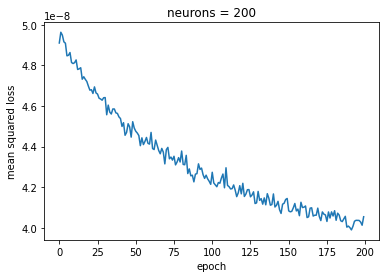

In [14]:
plt.plot(avg_train_losses[200:400])
plt.ylabel('mean squared loss')
plt.xlabel('epoch')
plt.title('neurons = 200')
plt.show()

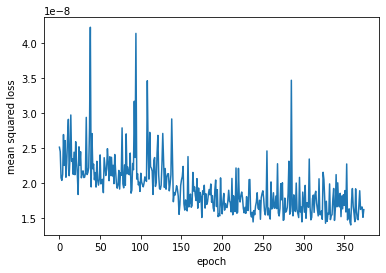

In [25]:
plt.plot(loss_valid[1500:3000:4])
plt.plot(loss_valid[3000:4500:4])
plt.ylabel('mean squared loss')
plt.xlabel('epoch')
plt.show()

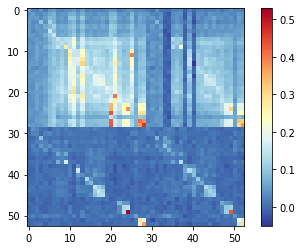

[[ 0.05828424  0.02185371  0.01842796 ...  0.02359192  0.02597785
   0.01951063]
 [ 0.03722832  0.05225526  0.03506538 ...  0.03061008  0.04599512
   0.04030554]
 [ 0.04659604  0.04384759  0.05059697 ...  0.02643303  0.05388037
   0.04053432]
 ...
 [ 0.00863184  0.02202503  0.0078987  ...  0.04428414  0.00922916
   0.00701907]
 [-0.00566256  0.00067742 -0.00591888 ...  0.01032159  0.23695321
   0.16194119]
 [-0.00514005  0.00357475  0.0103602  ...  0.00604989  0.15234019
   0.29528347]]


In [126]:
color_map = plt.imshow(MLP.model[0].layers.weight.detach().numpy())
color_map.set_cmap("RdYlBu_r")
plt.colorbar()
plt.show()
print(MLP.model[0].layers.weight.detach().numpy())

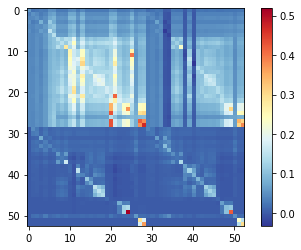

[[ 5.60702089e-02  2.16785491e-02  2.62218316e-02 ...  2.32561582e-02
   2.56339433e-02  2.66821843e-02]
 [ 3.35620765e-02  5.22907896e-02  4.29217272e-02 ...  3.21805468e-02
   3.98188564e-02  4.14456135e-02]
 [ 4.08151181e-02  4.35737460e-02  5.25302890e-02 ...  3.93158016e-02
   4.84957861e-02  5.04807611e-02]
 ...
 [-4.41115840e-04  1.67364230e-02  2.03098215e-02 ...  4.71093064e-02
   1.38145859e-02  1.43984945e-02]
 [-1.17336049e-05 -8.55315764e-05  2.85705797e-04 ... -9.44303201e-05
   2.36257822e-01  1.50996113e-01]
 [-1.00457261e-05 -2.29201666e-05  7.78940855e-05 ... -4.56428140e-05
   1.45595815e-01  2.99263242e-01]]


In [125]:
color_map = plt.imshow(initial_weight_original)
plt.colorbar()
color_map.set_cmap("RdYlBu_r")
plt.show()
print(initial_weight_original)

[[ 2.21402903e-03  1.75160528e-04 -7.79386912e-03 ...  3.35766222e-04
   3.43910418e-04 -7.17155008e-03]
 [ 3.66623957e-03 -3.55279457e-05 -7.85634445e-03 ... -1.57046596e-03
   6.17626357e-03 -1.14006984e-03]
 [ 5.78092096e-03  2.73848375e-04 -1.93332169e-03 ... -1.28827696e-02
   5.38458509e-03 -9.94644360e-03]
 ...
 [ 9.07295991e-03  5.28860525e-03 -1.24111257e-02 ... -2.82516757e-03
  -4.58542595e-03 -7.37942401e-03]
 [-5.65082453e-03  7.62954604e-04 -6.20458160e-03 ...  1.04160158e-02
   6.95392074e-04  1.09450721e-02]
 [-5.13000505e-03  3.59766659e-03  1.02823021e-02 ...  6.09552869e-03
   6.74437365e-03 -3.97977560e-03]]


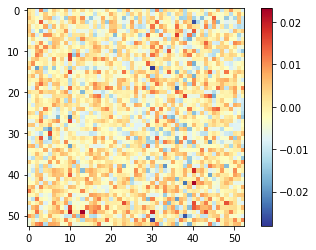

In [120]:
diff = (MLP.model[0].layers.weight.detach().numpy() - initial_weight_original) 
print(diff)
color_map = plt.imshow(diff)
color_map.set_cmap("RdYlBu_r")
plt.colorbar()

In [26]:
#number = 200
MLP.eval()
yHatTest = MLP(xTest.float())
rmse_test = np.mean((yHatTest.detach().numpy()-yTest.detach().numpy())**2)
print(rmse_test)
rmse_test1 = np.sqrt(np.mean((yHatTest.detach().numpy()-yTest.detach().numpy())**2,0))
print(rmse_test1)
print(np.mean(rmse_test1[0:29]))
print(np.mean(rmse_test1[29:53]))

2.0005355685772264e-08
[8.47650031e-05 5.62181783e-05 9.35273902e-05 7.81018945e-05
 9.37473402e-05 8.90866255e-05 1.47112039e-04 1.43887893e-04
 2.02685473e-04 1.56776095e-04 1.46388230e-04 2.12980915e-04
 1.98318697e-04 1.79211263e-04 1.51163853e-04 1.35853966e-04
 1.79025745e-04 1.61443801e-04 1.83793658e-04 2.02078916e-04
 2.15599484e-04 2.37431779e-04 1.66945048e-04 1.74451059e-04
 1.95508114e-04 1.66531317e-04 1.19865253e-04 2.04107452e-04
 2.11459884e-04 9.94019506e-05 1.06667544e-04 7.10831772e-05
 9.29072166e-05 8.34717391e-05 1.04492314e-04 8.58569597e-05
 6.42502346e-05 9.61891654e-05 1.55989353e-04 1.17405303e-04
 1.89679997e-04 1.16427222e-04 1.00098453e-04 8.98719787e-05
 9.24217830e-05 7.81332414e-05 3.22683953e-05 4.70334564e-05
 7.28065312e-05 1.08136956e-04 1.19129631e-04 1.39646495e-04
 1.49365614e-04]
0.00015820918506585696
0.00010053061292434294


In [27]:
np.save(saveFile+'rmse_test_last',rmse_test1)
np.save(saveFile+'yHatTest_last',yHatTest.detach().numpy())

In [9]:
model = Resnet(BasicBlock)
model.load_state_dict(torch.load(saveFile + 'Best'+'.ckpt'))
optimizer.load_state_dict(torch.load(saveFile+'Optim'+'Best'+'.ckpt'))
model.eval()
yHatTest = model(xTest.float())
rmse_test2 = np.mean((yHatTest.detach().numpy()-yTest.detach().numpy())**2)
print(rmse_test2)
rmse_test3 = np.sqrt(np.mean((yHatTest.detach().numpy()-yTest.detach().numpy())**2,0))
print(rmse_test3)
print(np.mean(rmse_test3[0:29]))
print(np.mean(rmse_test3[29:53]))

FileNotFoundError: [Errno 2] No such file or directory: 'data/case30/RNN_LR/hidden_dim100/S3_100Best.ckpt'

In [29]:
np.save(saveFile+'rmse_test_best',rmse_test3)
np.save(saveFile+'yHatTest_best',yHatTest.detach().numpy())

In [40]:
np.save(saveFile+'yTest',yTest.detach().numpy())